# Code Completion with RNN and LSTM

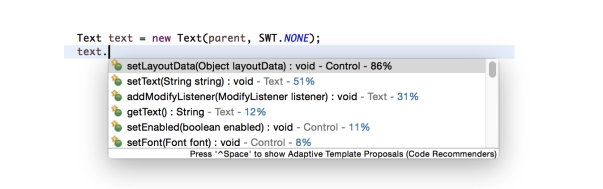

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Hands-on Demo</div>

In [9]:
# 1. Imports and Device Configuration
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from itertools import product
from tqdm import tqdm
import numpy as np
import sys
from transformers import AutoModelForCausalLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Data Loading and Inspection
with open('data/input_train.txt') as f:
  input_train_dataset = [item.rstrip().split() for item in f.readlines()]

with open('data/target_train.txt') as f:
  target_train_dataset = [item.rstrip().split() for item in f.readlines()]

with open('data/input_eval.txt') as f:
  input_eval_dataset = [item.rstrip().split() for item in f.readlines()]

with open('data/target_eval.txt') as f:
  target_eval_dataset = [item.rstrip().split() for item in f.readlines()]

with open('data/input_test.txt') as f:
  input_test_dataset = [item.rstrip().split() for item in f.readlines()]

with open('data/target_test.txt') as f:
  target_test_dataset = [item.rstrip().split() for item in f.readlines()]

with open('data/overallMethods.txt') as f:
  methods = [item.rstrip().split() for item in f.readlines()]

print("Sample Raw Input:", input_train_dataset[0])
print("Sample Raw Target:", target_train_dataset[0])
print("Sample Method:", methods[0])


Sample Raw Input: ['protected', 'java.lang.String', 'METHOD_1', '(', 'java.lang.String', '...', 'params', ')', '{', 'try', '{', 'java.util.List', '<', 'TYPE_1', '>', 'VAR_1', '=', 'TYPE_2', '.', 'METHOD_2', '(', 'new', 'TYPE_3', '(', 'VAR_2', ')', ')', ';', 'TYPE_4', '.', 'METHOD_3', '(', 'STRING_1', ',', 'VAR_1', '.', 'get', '(', '0', ')', '.', 'toString', '(', ')', ')', ';', 'TYPE_5', '.', 'METHOD_4', '(', 'VAR_1', '.', 'get', '(', '0', ')', ')', ';', 'VAR_3', '.', 'METHOD_5', '(', 'new', 'android.content.Intent', '(', 'VAR_3', '.', 'getActivity', '(', ')', ',', 'VAR_4', 'class', ')', ')', ';', '}', 'catch', '(', 'TYPE_6', 'VAR_5', ')', '{', 'VAR_5', '.', '[COMPLETION_N]']
Sample Raw Target: ['METHOD_6', '(', ')', ';', '}', 'return', 'STRING_2', ';', '}']
Sample Method: ['protected', 'java.lang.String', 'METHOD_1', '(', 'java.lang.String', '...', 'params', ')', '{', 'try', '{', 'java.util.List', '<', 'TYPE_1', '>', 'VAR_1', '=', 'TYPE_2', '.', 'METHOD_2', '(', 'new', 'TYPE_3', '(', '

In [11]:
# TOKENIZATION AND CREATING VOCABULARY
# Extract unique tokens from the methods
unique_tokens = set(token for seq in methods for token in seq)

# Add special tokens
unique_tokens.add("[COMPLETION_N]")  # Ensure one occurrence of [COMPLETION_N]
unique_tokens.add("<PAD>")  # Ensure padding token is included

# Assign each token a unique index
vocab = {token: idx for idx, token in enumerate(unique_tokens)}

# Create bidirectional mappings
token_to_id = {token: idx for idx, token in enumerate(unique_tokens)}
id_to_token = {idx: token for token, idx in token_to_id.items()}

# Exploration Point
print("\nVocabulary size:", len(token_to_id))
print("'<PAD>' token ID:", token_to_id['<PAD>'])
print("5 random vocabulary items:", list(token_to_id.items())[:5])


Vocabulary size: 488
'<PAD>' token ID: 263
5 random vocabulary items: [('java.util.Map.Entry', 0), ('getTime', 1), ('words', 2), ('p', 3), ('STRING_11', 4)]


In [12]:
# Manual Data Preprocessing: ADDING PADDING TO THE INPUTS AND TARGETS

# 1. Calculate Maximum Sequence Length
def get_max_sequence_length(*datasets):
    """Calculate maximum length across all datasets"""
    max_len = 0
    for data in datasets:
        for seq in data:
            max_len = max(max_len, len(seq))
    return max_len

max_seq_length = get_max_sequence_length(
    input_train_dataset, target_train_dataset,
    input_eval_dataset, target_eval_dataset,
    input_test_dataset, target_test_dataset
)
print(f"Maximum sequence length: {max_seq_length}")


# Process first sample without using Dataset class
SEQ_LENGTH = max_seq_length
sample_input = input_train_dataset[0]
sample_target = target_train_dataset[0]

# Convert tokens to IDs
input_ids = [token_to_id.get(token, token_to_id['<PAD>']) for token in sample_input]
target_ids = [token_to_id.get(token, token_to_id['<PAD>']) for token in sample_target]

# Manual padding
padded_input = input_ids[:SEQ_LENGTH] + [token_to_id['<PAD>']] * (SEQ_LENGTH - len(input_ids))
padded_target = target_ids[:SEQ_LENGTH] + [token_to_id['<PAD>']] * (SEQ_LENGTH - len(target_ids))

# Student Exploration Point
print("\nOriginal input length:", len(sample_input))
print("Padded input length:", len(padded_input))
print("Input before/after padding:")
print("Original Input:", sample_input)
print("Padded Input:", [id_to_token[id] for id in padded_input])


Maximum sequence length: 100

Original input length: 86
Padded input length: 100
Input before/after padding:
Original Input: ['protected', 'java.lang.String', 'METHOD_1', '(', 'java.lang.String', '...', 'params', ')', '{', 'try', '{', 'java.util.List', '<', 'TYPE_1', '>', 'VAR_1', '=', 'TYPE_2', '.', 'METHOD_2', '(', 'new', 'TYPE_3', '(', 'VAR_2', ')', ')', ';', 'TYPE_4', '.', 'METHOD_3', '(', 'STRING_1', ',', 'VAR_1', '.', 'get', '(', '0', ')', '.', 'toString', '(', ')', ')', ';', 'TYPE_5', '.', 'METHOD_4', '(', 'VAR_1', '.', 'get', '(', '0', ')', ')', ';', 'VAR_3', '.', 'METHOD_5', '(', 'new', 'android.content.Intent', '(', 'VAR_3', '.', 'getActivity', '(', ')', ',', 'VAR_4', 'class', ')', ')', ';', '}', 'catch', '(', 'TYPE_6', 'VAR_5', ')', '{', 'VAR_5', '.', '[COMPLETION_N]']
Padded Input: ['protected', 'java.lang.String', 'METHOD_1', '(', 'java.lang.String', '...', 'params', ')', '{', 'try', '{', 'java.util.List', '<', 'TYPE_1', '>', 'VAR_1', '=', 'TYPE_2', '.', 'METHOD_2', '(', '

## RNNs and short-term memory problem
Three major steps of training a Neural Network include:

1. Forward pass, which makes a Prediction (**Pred**);
2. Comparing Pred to the Ground truth using a loss function. The result is the error value , which estimates how badly the network is performing.

  **Loss(Pred, Truth) -> E**;

3. **E** is used to do the backpropagation, which calculates the gradient (**D**) for each node in the network. As anticipated by the Prof. the gradient is the value used to adjust the networks internal weights allowing the network to learn--This is what you should know in the context of this class

  Bigger gradient results in bigger adjustments and vice versa.

Because of the recurrent nature of the Recurrent Neural Networks (RNNs), the last part could be problematic, causing a vanishing gradient problem.

The vanishing gradient problem happens in RNNs when backpropagating through many time steps causes gradients to shrink so much that earlier layers stop learning, making it hard to remember long-term dependencies. LSTMs solve this by using special "gates" that control what information gets kept or forgotten, allowing them to maintain memory over longer sequences.



In [15]:
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
# Define a simple LSTM-based model
class LSTMModel(nn.Module):
	def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
		super(LSTMModel, self).__init__()

		# Converts token indices into dense vectors of fixed size (embedding_dim), helping the model learn useful representations.
		# dense vectors (continuous values) instead of one-hot vectors
		self.embedding = nn.Embedding(vocab_size, embedding_dim)

		self.lstm = nn.LSTM(input_size = embedding_dim, hidden_dim, n_layers,
		                    dropout=dropout, batch_first=True) #  ensures input data is structured as needed

		# The fully connected (Linear) layer converts LSTM’s output to the size of the vocabulary, which will be used for token prediction.
		self.fc = nn.Linear(hidden_dim, output_dim)

	def forward(self, x):
		# This ensures input is always a tensor, even if a single integer (token index) is passed.
		if isinstance(x, int):  # If x is an integer, convert it
			x = torch.tensor([x], dtype=torch.long)  # Convert to tensor

		# Converts input tokens into dense embeddings:
		embedded = self.embedding(x)

		# outputs at all timestamps, hidden state, internal cell state for lstms
		lstm_out, (hidden, cell) = self.lstm(embedded)

		# Predicted probabilities over the vocabulary for each token in the sequence.
		# hidden: (Optional) could be used for tasks needing recurrent states.
		logits = self.fc(lstm_out)
		return logits, hidden


SyntaxError: positional argument follows keyword argument (<ipython-input-15-d01fd67ddca2>, line 12)

## Model Input Parameters

**vocab_size** – The number of unique words (or tokens) in your dataset. It determines the size of the input layer.

**embedding_dim** – The size of each word’s vector representation used to capture relationships between words. Higher values capture more meaning.

**hidden_dim** – The number of neurons in the LSTM’s hidden layer. Bigger values help the model learn more complex patterns.

**output_dim** – The number of possible output classes (usually the vocab size if predicting the next word).

**n_layers** – The number of stacked LSTM layers. More layers can improve learning but may also slow training.

**dropout** – A regularization technique that randomly turns off some neurons during training to prevent overfitting.



---



### Model Output

**logits** – The raw predictions (before applying softmax) for each word in the vocabulary at each time step.

**hidden** – The hidden state of the LSTM, which carries learned information to the next sequence step or layer.





---


### Terminology To Remember:

An **epoch** is one complete pass through the entire training dataset during the learning process of a neural network. In simple terms, if you have 1,000 training examples and your model sees all 1,000 once, that’s one epoch.

Since one pass may not be enough for the model to learn patterns effectively, *training usually happens over multiple epochs*, meaning the model sees the same data multiple times to improve accuracy.


When we use **batches**, instead of passing the entire dataset through the model at once, we divide it into smaller groups (batches) and train on them separately.

For example, if you have 10,000 samples and use a batch size of 100, the model will go through 100 samples at a time and complete one epoch after 100 updates (10,000 / 100 = 100 iterations).


**Adam** is a popular optimization algorithm that adapts the learning rate for each parameter, making training more efficient. The **optimizer** updates the model’s weights to minimize the loss. The **learning rate**, which controls how much the weights change with each update.

**CrossEntropyLoss** is commonly used for text generation tasks, as it compares predicted class probabilities to the actual class.


In [7]:
# print the model
print(model)

LSTMModel(
  (embedding): Embedding(485, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=512, out_features=485, bias=True)
)


## model parts explained:

- When processing a sequence, the LSTM receives 256-dimensional input vectors (from the embedding layer) and produces 512-dimensional output representations at each timestep.

- This allows the model to store more information about the context and long-term dependencies in the sequence.

- With output size 485, model predicts a probability distribution over all 485 tokens.


In [ ]:
# Simplified training with manual batch processing
model = LSTMModel(
    vocab_size=len(token_to_id),
    embedding_dim=256,
    hidden_dim=512,
    output_dim=len(token_to_id),
    n_layers=2,
    dropout=0.3
).to(device)

# Efficient way to update model weights using gradients.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Measures how well the predicted token distributions match the actual tokens. <PAD> tokens are ignored (common in sequence tasks).
criterion = nn.CrossEntropyLoss(ignore_index=token_to_id['<PAD>'])

# Convert full dataset to tensors (students can modify this)
# Converts text sequences into numerical token IDs.
# Trims/pads sequences to a fixed SEQ_LENGTH for batch processing.

train_inputs = [
    [token_to_id[t] for t in seq][:SEQ_LENGTH] +
    [token_to_id['<PAD>']]*(SEQ_LENGTH - len(seq))
    for seq in input_train_dataset
]
train_targets = [
    [token_to_id[t] for t in seq][:SEQ_LENGTH] +
    [token_to_id['<PAD>']]*(SEQ_LENGTH - len(seq))
    for seq in target_train_dataset
]

# Converts lists into PyTorch tensors (only first 1000 samples for a quick demo).
train_tensors = (
    torch.tensor(train_inputs[:1000], dtype=torch.long),  # Limit for demo
    torch.tensor(train_targets[:1000], dtype=torch.long)
)

# Training batch-by-batch with visibility
# Loops over 3 training epochs. Each epoch processes the entire dataset once.
BATCH_SIZE = 32
for epoch in range(3):
    print(f"\n\n=== Epoch {epoch+1} ===")

    # len(train_tensors[0]) gives the number of sequences (samples) available for training. == 1000
    for batch_start in range(0, len(train_tensors[0]), BATCH_SIZE):
        batch_inputs = train_tensors[0][batch_start:batch_start+BATCH_SIZE].to(device)
        batch_targets = train_tensors[1][batch_start:batch_start+BATCH_SIZE].to(device)

        # Forward pass to compute predictions
        outputs, _ = model(batch_inputs)

        # Reshapes outputs and targets to compute cross-entropy loss.
        loss = criterion(outputs.view(-1, outputs.shape[-1]), batch_targets.view(-1))

        # Backward pass: Backpropagation computes gradients and updates model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Student Exploration Point
        # Logs loss every 128 samples to track training progress.
        if batch_start % 128 == 0:
            print(f"\nBatch {batch_start//BATCH_SIZE}:")
            print("Loss:", loss.item())

            # Decode sample prediction : Converts indices back to words to see what the model is predicting.
            sample_idx = 0
            input_tokens = [id_to_token[id.item()] for id in batch_inputs[sample_idx]]
            pred_tokens = [id_to_token[id.item()] for id in outputs.argmax(-1)[sample_idx]]

            print("Sample Input:", ' '.join(input_tokens[:15]) + " ...")
            print("Sample Prediction:", ' '.join(pred_tokens[:15]) + " ...")




=== Epoch 1 ===

Batch 0:
Loss: 6.18981409072876
Sample Input: protected java.lang.String METHOD_1 ( java.lang.String ... params ) { try { java.util.List < TYPE_1 > ...
Sample Prediction: -= nodes static string string string nodes nodes getString getString getString getString getString || || ...

Batch 4:
Loss: 4.897576332092285
Sample Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( STRING_1 ) . ...
Sample Prediction: ( ) ) ) ) ) ) ) ) ) ) ) ) ) ) ...

Batch 8:
Loss: 3.7691330909729004
Sample Input: public java.lang.Double METHOD_1 ( java.lang.String key ) { java.lang.String value = getString ( key ) ...
Sample Prediction: ) ) ) } } } } } } } } } } } } ...

Batch 12:
Loss: 3.737950086593628
Sample Input: public synchronized java.io.File METHOD_1 ( java.lang.String p ) { if ( ( VAR_1 ) || ...
Sample Prediction: ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ...

Batch 16:
Loss: 3.6669769287109375
Sample Input: public double METHOD_1 ( TYPE_1 VAR_1 ) { if ( ! ( VAR_1 . METHOD_2 ...
Sample

## Simpler visual examples


In [16]:
#  tokenized input example
input_sequence = ["def", "function", "(", ")", ":"]
token_to_id = {"def": 1, "function": 2, "(": 3, ")": 4, ":": 5}
id_to_token = {v: k for k, v in token_to_id.items()}  # Reverse lookup


import torch
import torch.nn as nn

embedding_layer = nn.Embedding(num_embeddings=6, embedding_dim=4)  # 6 possible tokens, 4D embedding
input_tensor = torch.tensor([1, 2, 3, 4, 5])  # Convert token IDs to tensor

embedded_output = embedding_layer(input_tensor)  # Pass through embedding layer
print(embedded_output)



tensor([[-0.5369,  0.4233, -0.8141,  0.2431],
        [ 0.8441,  0.7871, -0.5890,  0.2869],
        [-0.4164, -0.5605, -0.8828,  1.2666],
        [-1.1915,  0.0788, -0.6057,  1.4164],
        [-0.4400, -0.7063,  2.1676,  1.2257]], grad_fn=<EmbeddingBackward0>)


In [18]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Embedding layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer to predict next token

    def forward(self, x):
        embedded = self.embedding(x)  # Convert token IDs to embeddings
        lstm_out, (hidden, cell) = self.lstm(embedded)  # Process sequence with LSTM
        logits = self.fc(lstm_out)  # Predict token probabilities
        return logits, hidden


In [19]:
# Convert tokenized sequence into tensor
input_ids = torch.tensor([[token_to_id[t] for t in input_sequence]], dtype=torch.long)  # Shape: (1, 5)
print("Token IDs:", input_ids)


Token IDs: tensor([[1, 2, 3, 4, 5]])


In [20]:
# Define model
vocab_size = len(token_to_id) + 1  # +1 for safety if PAD token exists
embedding_dim = 256
hidden_dim = 512
output_dim = vocab_size
n_layers = 2
dropout = 0.3

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)

# Pass through model
logits, hidden = model(input_ids)

print("\nLogits Shape:", logits.shape)  # (1, 5, vocab_size)
print("Hidden State Shape:", hidden.shape)  # (2, 1, 512) -> (n_layers, batch_size, hidden_dim)



Logits Shape: torch.Size([1, 5, 6])
Hidden State Shape: torch.Size([2, 1, 512])


In [21]:
predicted_ids = logits.argmax(dim=-1)  # Get most probable token index
predicted_tokens = [id_to_token[id.item()] for id in predicted_ids[0]]  # Convert back to words

print("Predicted Tokens:", predicted_tokens)


Predicted Tokens: ['p', 'p', 'p', 'p', 'p']


# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Full code completion model</div>

In [3]:
# original code with improvements:
# 1. Imports and Device Configuration
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from itertools import product
from tqdm import tqdm
import numpy as np
import sys
from transformers import AutoModelForCausalLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Dataset Class - Data Preparation
class CodeCompletionDataset(Dataset):
    def __init__(self, input_data, target_data, vocab, seq_length):
        """
        Custom dataset for code completion.

        Args:
            input_data (list of list of str): Tokenized input sequences.
            target_data (list of list of str): Corresponding tokenized target sequences.
            vocab (dict): Token-to-index mapping.
            seq_length (int): Fixed sequence length for padding.
        """
        self.input_data = input_data
        self.target_data = target_data
        self.vocab = vocab
        self.seq_length = seq_length

        # Ensure <PAD> token exists in vocabulary
        if '<PAD>' not in vocab:
            raise ValueError("Vocabulary must contain '<PAD>' token for padding.")

        self.pad_token_id = vocab['<PAD>']

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        input_seq = self.input_data[idx]
        target_seq = self.target_data[idx]

        # Convert tokens to indices
        input_seq = [self.vocab.get(token, self.pad_token_id) for token in input_seq]
        target_seq = [self.vocab.get(token, self.pad_token_id) for token in target_seq]

        # Pad sequences to the fixed length
        input_seq = self.pad_sequence(input_seq, self.seq_length)
        target_seq = self.pad_sequence(target_seq, self.seq_length)

        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)

    def pad_sequence(self, sequence, max_len):
        """
        Pads or truncates a sequence to a fixed length.

        Args:
            sequence (list of int): List of token indices.
            max_len (int): Desired sequence length.

        Returns:
            list of int: Padded/truncated sequence.
        """
        return sequence[:max_len] + [self.pad_token_id] * max(0, max_len - len(sequence))


# 3. Model Architectures
class VanillaRNN(nn.Module):
	def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout=0):
		super(VanillaRNN, self).__init__()
		self.embedding = nn.Embedding(vocab_size, embedding_dim)
		self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True)
		self.fc = nn.Linear(hidden_dim, output_dim)

	def forward(self, x):

		if isinstance(x, int):  # If x is an integer, convert it
			x = torch.tensor([x], dtype=torch.long)  # Convert to tensor

		embedded = self.embedding(x)
		output, hidden = self.rnn(embedded)
		out = self.fc(output)
		return out, hidden


# Define a simple LSTM-based model
class LSTMModel(nn.Module):
	def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
		super(LSTMModel, self).__init__()
		self.embedding = nn.Embedding(vocab_size, embedding_dim)
		self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
		self.fc = nn.Linear(hidden_dim, output_dim)

	def forward(self, x):
		if isinstance(x, int):  # If x is an integer, convert it
			x = torch.tensor([x], dtype=torch.long)  # Convert to tensor

		embedded = self.embedding(x)
		lstm_out, (hidden, cell) = self.lstm(embedded)
		logits = self.fc(lstm_out)
		return logits, hidden

# 4. Training Functions
def train_model(model, dataloader, optimizer, criterion, epochs):
	"""Train the model and display step-wise training details."""
	model.train()
	display_interval = 100

	for epoch in range(epochs):
		epoch_loss = 0
		total_correct = 0
		total_samples = 0

		progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}")

		for batch_idx, (inputs, targets) in progress_bar:
			optimizer.zero_grad()

			inputs, targets = inputs.to(device), targets.to(device)


			outputs, _ = model(inputs)

			# Compute loss
			loss = criterion(outputs.reshape(-1, outputs.shape[-1]), targets.reshape(-1))
			loss.backward()
			optimizer.step()

			# Compute accuracy (if applicable)
			predictions = outputs.argmax(dim=-1)
			correct = (predictions == targets).sum().item()
			total = targets.numel()

			# Occasionally print input, target, and prediction for interpretation
			if batch_idx % display_interval == 0:
				print(f"Sample {idx}:")
				print(f"Input: {inputs[0].cpu().numpy()}")
				print(f"Target: {targets[0].cpu().numpy()}")
				print(f"Prediction: {predicted_tokens[0].cpu().numpy()}\n")

			batch_accuracy = correct / total
			total_correct += correct
			total_samples += total

			epoch_loss += loss.item()

			# Update progress bar with loss and accuracy
			progress_bar.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{batch_accuracy:.2%}")

		# Compute epoch-level metrics
		avg_loss = epoch_loss / len(dataloader)
		avg_accuracy = total_correct / total_samples

		print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2%}")

	# Save the trained model
	torch.save(model.state_dict(), "models/dl_code_completion.pth")
	print("Model saved successfully as rnn_code_completion.pth")


# 5. Utilities and Helper Functions
# Function to generate a vocabulary with a single occurrence of [COMPLETION_N]
def generate_vocab_with_completion_n(methods):
	"""
	Generates a vocabulary dictionary from a list of tokenized methods,
	ensuring that '[COMPLETION_N]' appears exactly once.

	Args:
		methods (list of list of str): Tokenized Java methods.

	Returns:
		dict: Vocabulary mapping each unique token to a unique index.
	"""
	# Extract unique tokens from the methods
	unique_tokens = set(token for seq in methods for token in seq)

	# Add special tokens
	unique_tokens.add("[COMPLETION_N]")  # Ensure one occurrence of [COMPLETION_N]
	unique_tokens.add("<PAD>")  # Ensure padding token is included

	# Assign each token a unique index
	vocab = {token: idx for idx, token in enumerate(unique_tokens)}

	return vocab

# 6. Hyperparameter Tuning
class HyperparameterTuner:
	def __init__(self, model_class, param_grid, train_dataloader, eval_dataloader, vocab_size, vocab):
		"""
		Initialize the hyperparameter tuner.

		Args:
			model_class: The model class to instantiate.
			param_grid: Dictionary of hyperparameters to search over.
			train_dataloader: DataLoader for training data.
			eval_dataloader: DataLoader for evaluation data.
			vocab_size: Size of the vocabulary for model initialization.
		"""
		self.model_class = model_class
		self.param_grid = param_grid
		self.train_dataloader = train_dataloader
		self.eval_dataloader = eval_dataloader
		self.vocab_size = vocab_size
		self.vocab = vocab

	def train_model(self, model, optimizer, criterion, epochs):
		"""Train the model and display step-wise training details."""
		model.train()
		display_interval = 100
		for epoch in range(epochs):
			epoch_loss = 0
			total_correct = 0
			total_samples = 0

			progress_bar = tqdm(enumerate(self.train_dataloader), total=len(self.train_dataloader), desc=f"Epoch {epoch+1}")

			for batch_idx, (inputs, targets) in progress_bar:

				inputs, targets = inputs.to(device), targets.to(device)

				optimizer.zero_grad()
				outputs,_ = model(inputs)

				# Compute loss
				loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
				loss.backward()
				nn.utils.clip_grad_norm_(model.parameters(), 2)
				optimizer.step()

				# Compute accuracy (if applicable)
				predictions = outputs.argmax(dim=-1)
				correct = (predictions == targets).sum().item()
				predicted_tokens = [list(self.vocab.keys())[list(self.vocab.values()).index(idx)] for idx in predictions[5].tolist()]
				input_tokens = [list(self.vocab.keys())[list(self.vocab.values()).index(idx)] for idx in inputs[5].cpu().numpy().tolist()]
				target_tokens = [list(self.vocab.keys())[list(self.vocab.values()).index(idx)] for idx in targets[5].cpu().numpy().tolist()]

				total = targets.numel()

				# Occasionally print input, target, and prediction for interpretation
				if batch_idx % display_interval == 0:
					print(f"Sample {batch_idx}:")
					#print("******************************\n\n\n")
					#print(predictions[0:3])
					#print(inputs[0:3])
					#print(targets[0:3])
					#print("******************************\n\n\n")

					print(f"Input: {' '.join(input_tokens)}")
					print(f"Target: {' '.join(target_tokens)}")
					print(f"Prediction: {' '.join(predicted_tokens)}\n")
					#sys.exit(-1)

				batch_accuracy = correct / total
				total_correct += correct
				total_samples += total

				epoch_loss += loss.item()

				# Update progress bar with loss and accuracy
				progress_bar.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{batch_accuracy:.2%}")

			# Compute epoch-level metrics
			avg_loss = epoch_loss / len(self.train_dataloader)
			avg_accuracy = total_correct / total_samples

			print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2%}")

	def evaluate_model(self, model, criterion):
		"""Evaluate the model on the validation set and return the loss."""
		model.eval()
		eval_loss = 0
		display_interval = 50
		correct_predictions = 0

		with torch.no_grad():

			for idx, (inputs, targets) in enumerate(self.eval_dataloader):
				inputs, targets = inputs.to(device), targets.to(device)
				outputs, _ = model(inputs)
				#outputs = model(inputs)
				loss = criterion(outputs.reshape(-1, outputs.shape[-1]), targets.reshape(-1))
				eval_loss += loss.item()


				predictions = outputs.argmax(dim=-1)
				correct_predictions += (predictions == targets).sum().item()
				#total_samples += targets.size(0)

				predicted_tokens = [list(self.vocab.keys())[list(self.vocab.values()).index(idx)] for idx in predictions[0].tolist()]
				input_tokens = [list(self.vocab.keys())[list(self.vocab.values()).index(idx)] for idx in inputs[0].cpu().numpy().tolist()]
				target_tokens = [list(self.vocab.keys())[list(self.vocab.values()).index(idx)] for idx in targets[0].cpu().numpy().tolist()]


				# Occasionally print input, target, and prediction for interpretation
				if idx % display_interval == 0:
					print(f"Input: {' '.join(input_tokens)}")
					print(f"Target: {' '.join(target_tokens)}")
					pad_pos = predicted_tokens.index('<PAD>')
					refinedPred = ' '.join(predicted_tokens[0:pad_pos])
					print(f"Prediction: {refinedPred}\n")

		print(f"Correct Predictions: ".format(correct_predictions))
		return eval_loss / len(self.eval_dataloader)

	def tune(self):
		"""Perform hyperparameter tuning by iterating over all parameter combinations."""
		best_params = None
		best_loss = float('inf')
		results = []

		# Iterate over all combinations of hyperparameters
		for param_set in product(*self.param_grid.values()):
			params = dict(zip(self.param_grid.keys(), param_set))
			print(f"\nTraining with parameters: {params}")

			# Initialize model, optimizer, and loss function
			model = self.model_class(
				self.vocab_size,
				params['embedding_dim'],
				params['hidden_dim'],
				params['output_dim'],
				params['n_layers'],
				params['dropout']
			)

			model = model.to(device)
			criterion = nn.CrossEntropyLoss().to(device)  # Move loss function to GPU
			optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

			# Train model
			self.train_model(model, optimizer, criterion, params['epochs'])

			# Evaluate model
			eval_loss = self.evaluate_model(model, criterion)
			results.append((params, eval_loss))

			# Track best parameters
			if eval_loss < best_loss:
				best_loss = eval_loss
				best_params = params

			print(f"Evaluation Loss: {eval_loss:.4f}")

		print(f"\nBest Parameters: {best_params} with Loss: {best_loss:.4f}")
		return best_params, results


# 7. Main Pipeline
def main(hp=1, mode="training"):
	with open('data/input_train.txt') as f:
	  input_train_dataset = [item.rstrip().split() for item in f.readlines()]

	with open('data/target_train.txt') as f:
	  target_train_dataset = [item.rstrip().split() for item in f.readlines()]

	with open('data/input_eval.txt') as f:
	  input_eval_dataset = [item.rstrip().split() for item in f.readlines()]

	with open('data/target_eval.txt') as f:
	  target_eval_dataset = [item.rstrip().split() for item in f.readlines()]

	with open('data/input_test.txt') as f:
	  input_test_dataset = [item.rstrip().split() for item in f.readlines()]

	with open('data/target_test.txt') as f:
	  target_test_dataset = [item.rstrip().split() for item in f.readlines()]

	with open('data/overallMethods.txt') as f:
	  methods = [item.rstrip().split() for item in f.readlines()]

	#print(methods)

	# Create vocabulary
	vocab = generate_vocab_with_completion_n(methods)
	vocab_size = len(vocab)

	#print(vocab)
	#print(vocab_size)

	# # Create dataset and dataloader
	datasetTrain = CodeCompletionDataset(input_train_dataset, target_train_dataset, vocab, seq_length=100)
	datasetTest = CodeCompletionDataset(input_test_dataset, target_test_dataset, vocab, seq_length=100)
	datasetEval = CodeCompletionDataset(input_eval_dataset, target_eval_dataset, vocab, seq_length=100)

	dataloader_train = DataLoader(datasetTrain, batch_size=32, shuffle=True)
	dataloader_test = DataLoader(datasetTest, batch_size=32, shuffle=True)
	dataloader_eval = DataLoader(datasetEval, batch_size=32, shuffle=True)



	if hp==1:

		######## HP-Tuning Config ########
		# Best Parameters: {'embedding_dim': 256, 'hidden_dim': 256, 'output_dim': 488, 'n_layers': 2, 'learning_rate': 0.001, 'dropout': 0.2, 'epochs': 5} with Loss: 0.8346
		param_grid = {
			'embedding_dim': [128, 256],
			'hidden_dim': [128, 256],
			'output_dim': [vocab_size],
			'n_layers': [2,3],
			'learning_rate': [0.0001, 0.001],
			'dropout': [0.2],
			'epochs': [3,5]
		}

		tuner = HyperparameterTuner(LSTMModel, param_grid, dataloader_train, dataloader_eval, vocab_size, vocab)
		best_params, tuning_results = tuner.tune()

	else:

		#Hyperparameters
		embedding_dim = 64
		hidden_dim = 256
		output_dim = vocab_size
		n_layers = 16
		learning_rate = 0.001
		epochs = 5
		dropout = 0.2


		# Initialize model, optimizer, and loss function
		model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout).to(device)

		if mode == "training":

			optimizer = optim.Adam(model.parameters(), lr=learning_rate)
			criterion = nn.CrossEntropyLoss(ignore_index=vocab["<PAD>"]).to(device)

			# Train the model
			train_model(model, dataloader, optimizer, criterion, epochs)

		elif mode == "eval":
			model.load_state_dict(torch.load("models/dl_code_completion.pth"))

			with torch.no_grad():
				for inputs, targets in self.test_dataloader:
					inputs, targets = inputs.to(device), targets.to(device)
					outputs, _ = model(inputs)

					predicted = torch.argmax(outputs, dim=-1)
					#predicted_tokens = [list(vocab.keys())[list(vocab.values()).index(idx)] for idx in predicted[0].tolist()]
					idx_to_token = {idx: token for token, idx in self.vocab.items()}
					predicted_tokens = [idx_to_token.get(idx, "<UNK>") for idx in predictions[0].cpu().tolist()]

					print(predicted_tokens)

		else:
			sys.exit(-1)


if __name__ == "__main__":
	main(hp=1)




Training with parameters: {'embedding_dim': 128, 'hidden_dim': 128, 'output_dim': 488, 'n_layers': 2, 'learning_rate': 0.0001, 'dropout': 0.2, 'epochs': 3}


Epoch 1:   1%|          | 8/1025 [00:01<02:00,  8.45it/s, accuracy=35.50%, loss=6.0651]

Sample 0:
Input: public void METHOD_1 ( int VAR_1 ) { if ( ( ( state ) == INT_1 ) && ( ( VAR_2 ) == ( - INT_2 ) ) ) { state = 1 ; VAR_3 = INT_3 ; TYPE_1 . METHOD_2 ( METHOD_3 ( false ) ) ; } else if ( ( ( state ) == INT_3 ) && [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ( VAR_4 [ 0 ] ) != null ) ) { VAR_4 [ 0 ] . METHOD_1 ( VAR_5 ) ; state = 0 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
P

Epoch 1:  11%|█         | 109/1025 [00:02<00:12, 70.63it/s, accuracy=83.59%, loss=1.3487]

Sample 100:
Input: public void METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 , java.lang.String VAR_3 , java.lang.String to , java.lang.String VAR_4 ) { if ( VAR_3 . equals ( to ) ) { return ; } TYPE_1 VAR_6 = new TYPE_1 ( ) ; VAR_6 . METHOD_2 ( VAR_3 ) ; VAR_6 . METHOD_3 ( to ) ; VAR_6 . METHOD_4 ( VAR_1 ) ; VAR_6 . METHOD_5 ( VAR_2 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_6 . METHOD_6 ( VAR_4 ) ; VAR_5 . add ( VAR_6 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  21%|██        | 213/1025 [00:04<00:10, 74.38it/s, accuracy=80.16%, loss=1.2006]

Sample 200:
Input: private java.lang.String METHOD_1 ( java.lang.String VAR_1 ) { java.lang.String VAR_2 = STRING_1 ; for ( int i [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = 1 ; i <= ( VAR_1 . length ( ) ) ; i ++ ) { VAR_2 += VAR_1 . METHOD_2 ( ( ( VAR_1 . length ( ) ) - i ) ) ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  30%|███       | 309/1025 [00:05<00:09, 73.90it/s, accuracy=79.72%, loss=1.1904]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( view . METHOD_2 ( ) ) == false ) { view . METHOD_3 ( VAR_1 . METHOD_4 ( ) , VAR_1 . METHOD_5 ( ) ) ; TYPE_2 . METHOD_6 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . setEnabled ( true ) ; TYPE_2 . METHOD_6 ( ) . METHOD_7 ( INT_1 ) ; TYPE_2 . METHOD_6 ( ) . METHOD_8 ( view ) ; } else { TYPE_2 . METHOD_6 ( ) . setEnabled ( false ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  40%|████      | 413/1025 [00:06<00:08, 73.30it/s, accuracy=80.16%, loss=1.0825]

Sample 400:
Input: public void METHOD_1 ( ) throws java.lang.Exception { if ( ! ( TYPE_1 . METHOD_2 ( ) . METHOD_3 ( ) ) ) { return ; } try { TYPE_2 . METHOD_4 ( ) ; } catch ( TYPE_3 VAR_1 ) { TYPE_4 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_5 ( VAR_1 ) ; } catch ( java.lang.Exception VAR_1 ) { throw VAR_1 ; } METHOD_7 ( VAR_2 , STRING_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  50%|████▉     | 509/1025 [00:08<00:06, 74.37it/s, accuracy=81.28%, loss=0.9855]

Sample 500:
Input: public void METHOD_1 ( java.lang.String VAR_1 , int VAR_2 , int VAR_3 ) { TYPE_1 VAR_4 = new TYPE_1 ( VAR_5 , INT_1 , INT_1 , VAR_6 ) ; TYPE_2 . METHOD_1 ( VAR_4 , VAR_1 , VAR_2 , VAR_3 , null ) ; TYPE_3 . METHOD_2 ( ( ( ( ( ( ( ( STRING_1 + VAR_1 ) + STRING_2 ) + VAR_2 ) + STRING_3 ) + STRING_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) + VAR_3 ) + STRING_5 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  60%|█████▉    | 613/1025 [00:09<00:05, 72.15it/s, accuracy=80.97%, loss=0.9614]

Sample 600:
Input: public java.lang.String [ ] METHOD_1 ( java.lang.String [ ] VAR_1 , java.util.HashMap < java.lang.String , java.lang.Integer > VAR_2 , int VAR_3 , TYPE_1 error , int VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , java.lang.String filename ) { java.lang.String [ ] VAR_5 = new java.lang.String [ INT_1 ] ; java.lang.Integer VAR_6 = VAR_2 . get ( VAR_1 [ 1 ] ) ; VAR_5 [ 0 ] = STRING_1 + INT_2 ; VAR_3 ++ ; VAR_5 [ 1 ] = VAR_1 [ 1 ] ; VAR_3 ++ ; VAR_5 [ INT_3 ] = STRING_1 + 0 ; VAR_3 ++ ; return VAR_5 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  69%|██████▉   | 709/1025 [00:11<00:05, 54.47it/s, accuracy=78.47%, loss=1.1096]

Sample 700:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = this . VAR_2 . METHOD_2 ( ) ; switch ( VAR_1 . type ) { case VAR_3 : VAR_4 = ( ( long ) ( VAR_5 . METHOD_3 ( ) . getValue ( VAR_1 . value ) ) ) ; break ; case VAR_6 : VAR_4 = ( ( long ) ( ( ( VAR_1 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: value ) * FLOAT_1 ) * FLOAT_1 ) ) ; break ; default : VAR_4 = VAR_7 ; break ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  79%|███████▉  | 810/1025 [00:12<00:03, 70.32it/s, accuracy=79.62%, loss=1.0143]

Sample 800:
Input: public void METHOD_1 ( java.lang.String VAR_1 ) { switch ( VAR_1 ) { case STRING_1 : int VAR_2 = METHOD_2 ( ) ; if ( VAR_2 > ( - 1 ) ) { VAR_3 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_3 ( ( ( VAR_4 ) + VAR_2 ) ) ; } break ; case STRING_2 : METHOD_4 ( ) ; break ; case STRING_3 : METHOD_5 ( ) ; break ; case STRING_4 : METHOD_6 ( ) ; break ; case STRING_5 : break ; case STRING_6 : break ; case STRING_7 : break ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  89%|████████▉ | 914/1025 [00:14<00:01, 71.77it/s, accuracy=80.47%, loss=1.0571]

Sample 900:
Input: public boolean METHOD_1 ( android.view.View VAR_1 , TYPE_1 VAR_2 ) { final int VAR_3 = VAR_2 . METHOD_2 ( ) ; switch ( VAR_3 ) { case VAR_4 : { break ; } case VAR_5 : { METHOD_3 ( VAR_1 ) ; METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 ) ; break ; } case VAR_6 : { VAR_7 = - 1 ; break ; } } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  99%|█████████▊| 1010/1025 [00:15<00:00, 74.89it/s, accuracy=87.19%, loss=0.6379]

Sample 1000:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( STRING_1 , INT_1 , METHOD_2 ( ) ) ; TYPE_2 . equals ( VAR_1 . METHOD_3 ( ) , INT_1 , STRING_2 ) ; TYPE_2 . equals ( VAR_1 . METHOD_4 ( ) , FLOAT_1 , STRING_3 ) ; TYPE_2 . equals ( VAR_1 . METHOD_5 ( ) , FLOAT_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , STRING_4 ) ; METHOD_7 ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1: 100%|██████████| 1025/1025 [00:15<00:00, 64.85it/s, accuracy=79.48%, loss=0.9775]


Epoch 1 - Loss: 1.3251, Accuracy: 80.21%


Epoch 2:   1%|          | 8/1025 [00:00<00:13, 76.56it/s, accuracy=82.12%, loss=0.8631]

Sample 0:
Input: public void METHOD_1 ( ) { VAR_1 = VAR_2 . METHOD_2 ( INT_1 ) ; java.lang.System.out.println ( VAR_1 . METHOD_6 ( ) . toString ( ) ) ; TYPE_1 . assertEquals ( STRING_1 , VAR_1 . METHOD_3 ( ) ) ; TYPE_1 . assertEquals ( STRING_2 , VAR_1 . METHOD_4 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; TYPE_1 . assertEquals ( FLOAT_1 , VAR_1 . METHOD_5 ( ) , 0 ) ; TYPE_1 . assertEquals ( STRING_3 , VAR_1 . METHOD_6 ( ) . METHOD_7 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  11%|█         | 112/1025 [00:01<00:12, 71.80it/s, accuracy=84.00%, loss=0.8203]

Sample 100:
Input: public java.lang.String METHOD_1 ( TYPE_1 key , TYPE_2 VAR_1 ) { try { METHOD_2 ( VAR_1 ) ; } catch ( TYPE_3 VAR_3 ) { VAR_3 . METHOD_3 ( ) ; return METHOD_1 ( key ) ; } return VAR_2 . get ( VAR_1 ) . get ( key [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  21%|██        | 216/1025 [00:02<00:10, 76.23it/s, accuracy=81.31%, loss=0.9157]

Sample 200:
Input: public boolean METHOD_1 ( java.lang.String VAR_1 ) { TYPE_1 VAR_2 ; try { VAR_2 = new TYPE_1 ( STRING_1 , STRING_1 , false , VAR_3 , null ) ; TYPE_2 p = new TYPE_3 ( ) ; p . METHOD_2 ( new TYPE_4 ( VAR_1 . METHOD_3 ( ) ) , STRING_1 , VAR_2 ) ; TYPE_5 VAR_4 = VAR_5 ; VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_4 ( METHOD_5 ( ) ) ; } catch ( java.lang.Exception VAR_6 ) { } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  30%|███       | 312/1025 [00:04<00:09, 75.81it/s, accuracy=81.94%, loss=0.8670]

Sample 300:
Input: public static void METHOD_1 ( java.lang.String text ) { TYPE_1 VAR_1 = new TYPE_1 ( text ) ; VAR_1 . METHOD_2 ( new TYPE_2 ( VAR_2 , VAR_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_2 . add ( VAR_1 ) ; VAR_2 . METHOD_4 ( ) ; VAR_3 . METHOD_4 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  40%|███▉      | 408/1025 [00:05<00:08, 73.26it/s, accuracy=82.12%, loss=0.8877]

Sample 400:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 , TYPE_1 VAR_2 ) { if ( ( VAR_3 . METHOD_2 ( VAR_1 ) ) || ( VAR_3 . METHOD_2 ( VAR_2 ) ) ) { return false ; } return ( VAR_4 . METHOD_3 ( VAR_1 , VAR_2 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: && ( VAR_4 . METHOD_3 ( VAR_2 , VAR_1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  50%|████▉     | 508/1025 [00:07<00:08, 61.70it/s, accuracy=79.50%, loss=0.9471]

Sample 500:
Input: private synchronized void METHOD_1 ( java.lang.String VAR_1 , java.lang.String url , java.lang.Integer value ) { java.util.Map < java.lang.String , java.lang.Integer > VAR_2 = VAR_3 . get ( VAR_1 ) ; if ( VAR_2 == null ) { VAR_2 = new java.util.HashMap < > ( ) ; } VAR_2 . put ( url , value ) ; VAR_3 . put ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 , VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  59%|█████▉    | 609/1025 [00:08<00:07, 52.64it/s, accuracy=78.97%, loss=1.0386]

Sample 600:
Input: public boolean METHOD_1 ( TYPE_1 item ) { switch ( item . METHOD_2 ( ) ) { case VAR_1 : if ( ( VAR_3 ) != null ) { android.content.Intent intent = new android.content.Intent ( this , VAR_2 class ) ; intent . METHOD_3 ( STRING_1 , VAR_3 ) ; intent . METHOD_3 ( STRING_2 , VAR_4 . METHOD_4 ( VAR_3 ) ) ; METHOD_5 ( intent ) ; } return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: true ; default : return super . METHOD_1 ( item ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  69%|██████▉   | 708/1025 [00:10<00:04, 69.55it/s, accuracy=86.00%, loss=0.6861]

Sample 700:
Input: public static java.lang.String METHOD_1 ( java.lang.String TYPE_1 ) throws java.lang.Exception { int VAR_1 = TYPE_1 . METHOD_2 ( CHAR_1 ) ; int VAR_2 = TYPE_1 . METHOD_2 ( CHAR_2 ) ; if ( ( VAR_1 == ( - 1 ) ) && ( VAR_2 == ( - 1 ) ) ) throw new java.lang.Exception ( ( ( STRING_1 + TYPE_1 ) + STRING_2 ) ) ; return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_1 . substring ( 0 , ( ( TYPE_2 . METHOD_3 ( VAR_1 , VAR_2 ) ) + 1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  79%|███████▉  | 810/1025 [00:11<00:02, 72.39it/s, accuracy=82.72%, loss=0.8299]

Sample 800:
Input: protected java.lang.String METHOD_1 ( java.lang.String VAR_1 , java.lang.String attribute , int index ) { if ( VAR_1 . contains ( ( attribute + STRING_1 ) ) ) { int a = ( ( VAR_1 . METHOD_2 ( ( attribute + STRING_1 ) , index ) ) + ( attribute . length ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) + INT_1 ; int b = VAR_1 . METHOD_2 ( CHAR_1 , a ) ; return METHOD_3 ( VAR_1 . substring ( a , b ) ) ; } else return null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  89%|████████▉ | 914/1025 [00:13<00:01, 73.40it/s, accuracy=78.97%, loss=1.0039]

Sample 900:
Input: static final TYPE_1 METHOD_1 ( java.lang.Class c , java.lang.String VAR_1 ) throws java.io.IOException { TYPE_1 VAR_2 = new TYPE_1 ( ) ; try ( java.io.InputStream VAR_3 = c . METHOD_2 ( VAR_1 ) ; TYPE_2 VAR_4 = new TYPE_2 ( VAR_3 ) ; java.io.BufferedReader VAR_5 = new java.io.BufferedReader ( VAR_4 ) ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: java.lang.String tmp = null ; while ( ( tmp = VAR_5 . METHOD_3 ( ) ) != null ) { VAR_2 . append ( tmp ) ; } } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  99%|█████████▊| 1010/1025 [00:14<00:00, 71.40it/s, accuracy=79.38%, loss=0.9819]

Sample 1000:
Input: public static void main ( java.lang.String [ ] args ) { int x = METHOD_1 ( ) ; if ( ( x % INT_1 ) == 0 ) { java.lang.System.out.println ( STRING_1 ) ; } else if ( ( x % INT_2 ) == 0 ) { java.lang.System.out.println ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: STRING_2 ) ; } else { java.lang.System.out.println ( STRING_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2: 100%|██████████| 1025/1025 [00:14<00:00, 69.78it/s, accuracy=85.93%, loss=0.6978]


Epoch 2 - Loss: 0.8777, Accuracy: 81.97%


Epoch 3:   1%|          | 8/1025 [00:00<00:13, 73.57it/s, accuracy=83.25%, loss=0.8218]

Sample 0:
Input: public void METHOD_1 ( android.view.View VAR_1 ) { if ( ( ( VAR_2 . METHOD_2 ( ) . METHOD_3 ( ) . length ( ) ) > INT_2 ) && ( VAR_2 . METHOD_2 ( ) . METHOD_3 ( ) . substring ( 1 , INT_2 ) . equals ( STRING_1 ) ) ) { METHOD_5 ( this [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_3 class ) ; } else { TYPE_2 . METHOD_6 ( this , STRING_2 , VAR_4 ) . show ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  11%|█         | 112/1025 [00:01<00:12, 72.58it/s, accuracy=80.12%, loss=0.9779]

Sample 100:
Input: private TYPE_1 METHOD_1 ( final java.lang.Throwable VAR_1 ) { if ( VAR_1 instanceof TYPE_2 ) { TYPE_2 VAR_2 = ( ( TYPE_2 ) ( VAR_1 ) ) ; return VAR_2 . METHOD_2 ( ) ; } TYPE_3 writer = new TYPE_3 ( ) ; writer.write ( VAR_1 . toString ( ) ) ; return TYPE_5 . METHOD_4 ( ) . METHOD_5 ( ) . status ( VAR_3 ) . METHOD_6 ( writer . toString ( ) ) . type ( VAR_4 ) . build ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  20%|██        | 208/1025 [00:02<00:11, 71.22it/s, accuracy=82.81%, loss=0.8481]

Sample 200:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( INT_1 ) ; double VAR_2 = FLOAT_1 ; int VAR_3 = INT_2 ; int VAR_4 = INT_2 ; TYPE_1 VAR_5 = new TYPE_1 ( FLOAT_2 ) ; TYPE_1 VAR_6 = new TYPE_1 ( FLOAT_3 ) ; TYPE_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_7 = new TYPE_1 ( FLOAT_4 ) ; TYPE_1 VAR_8 = new TYPE_1 ( 0 ) ; TYPE_2 p = VAR_9 . METHOD_2 ( VAR_1 , VAR_2 , VAR_3 , VAR_4 ) ; METHOD_3 ( p , VAR_5 , VAR_6 , VAR_7 , VAR_8 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  30%|███       | 312/1025 [00:04<00:09, 71.81it/s, accuracy=79.12%, loss=1.0617]

Sample 300:
Input: private void METHOD_1 ( ) { TYPE_1 VAR_1 = METHOD_2 ( ) . METHOD_3 ( ) . METHOD_4 ( ) ; VAR_1 . add ( new TYPE_3 ( STRING_2 , TYPE_4 . METHOD_5 ( VAR_4 ) ) { public void METHOD_6 ( ) { METHOD_8 ( ) ; } } ) ; if ( ! ( TYPE_2 . equals ( VAR_2 ) ) ) { VAR_1 . add ( new TYPE_3 ( STRING_1 , TYPE_4 . METHOD_5 ( VAR_3 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { public void METHOD_6 ( ) { METHOD_7 ( ) ; } } ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  40%|███▉      | 407/1025 [00:06<00:11, 55.44it/s, accuracy=81.59%, loss=0.9112]

Sample 400:
Input: public void add ( TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = new TYPE_2 ( VAR_4 ) ; VAR_2 . METHOD_1 ( VAR_1 ) ; int VAR_3 = this . VAR_4 . METHOD_2 ( ) ; VAR_2 . METHOD_3 ( ) . METHOD_4 ( ) . METHOD_5 ( VAR_5 ) ; this . VAR_4 . METHOD_6 ( VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , ( VAR_3 - 1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  50%|████▉     | 512/1025 [00:07<00:08, 60.49it/s, accuracy=81.19%, loss=0.9417]

Sample 500:
Input: public boolean METHOD_1 ( ) { return ( ( ( ( ! ( VAR_1 . getValue ( ) ) ) || ( VAR_2 . METHOD_2 ( STRING_1 ) ) ) && ( ( ! ( VAR_3 . getValue ( ) ) ) || ( VAR_4 . METHOD_1 ( STRING_2 ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) && ( VAR_5 . METHOD_3 ( STRING_3 , 1 , INT_2 ) ) ) && ( VAR_6 . METHOD_3 ( STRING_4 , 0 , INT_3 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  60%|█████▉    | 610/1025 [00:09<00:05, 72.28it/s, accuracy=77.62%, loss=1.0917]

Sample 600:
Input: final void METHOD_1 ( final TYPE_1 VAR_1 , final TYPE_2 view ) { VAR_2 = false ; this . VAR_1 = VAR_1 ; if ( ( this . VAR_3 ) != null ) { this . VAR_3 . METHOD_2 ( ) ; } this . VAR_3 = new java.lang.Thread ( ( ) - > METHOD_3 ( view ) ) ; this . VAR_3 . start ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  70%|██████▉   | 713/1025 [00:10<00:04, 68.71it/s, accuracy=78.09%, loss=1.0275]

Sample 700:
Input: public static byte METHOD_1 ( java.lang.String VAR_1 ) { if ( ( TYPE_1 . METHOD_2 ( VAR_1 ) ) || ( TYPE_2 . contains ( VAR_1 ) ) ) { return 0 ; } else if ( TYPE_4 . contains ( VAR_1 ) ) { return 1 ; } else if ( TYPE_5 . contains ( VAR_1 ) ) { return 0 ; } else { throw new TYPE_6 ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( STRING_1 + VAR_1 ) + STRING_2 ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  80%|███████▉  | 815/1025 [00:12<00:02, 70.67it/s, accuracy=82.78%, loss=0.8122]

Sample 800:
Input: public boolean METHOD_1 ( int i , int j ) { int VAR_1 = METHOD_2 ( i , j ) ; if ( VAR_1 == ( - 1 ) ) throw new TYPE_1 ( STRING_1 ) ; int VAR_2 = VAR_3 . METHOD_3 ( VAR_1 ) ; return ( TYPE_2 . METHOD_4 ( state [ VAR_1 ] ) ) && ( TYPE_2 . METHOD_5 ( state [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: [ VAR_2 ] ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  89%|████████▉ | 910/1025 [00:13<00:01, 72.39it/s, accuracy=83.44%, loss=0.8010]

Sample 900:
Input: public void start ( int VAR_1 ) throws TYPE_1 { java.lang.System.out.println ( ( STRING_5 + VAR_1 ) ) ; while ( VAR_1 > 0 ) { java.lang.String VAR_3 = METHOD_2 ( ) ; java.util.ArrayList < java.lang.String > VAR_4 = METHOD_3 ( VAR_3 ) ; java.util.ArrayList < java.lang.String > VAR_5 = execute ( VAR_4 ) ; java.util.ArrayList < [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: java.lang.String > VAR_6 = METHOD_4 ( VAR_5 ) ; METHOD_5 ( VAR_6 ) ; VAR_1 -- ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  99%|█████████▊| 1012/1025 [00:14<00:00, 69.39it/s, accuracy=79.62%, loss=0.9581]

Sample 1000:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 msg , java.util.List < java.lang.Object > out ) throws java.lang.Exception { byte [ ] VAR_3 ; if ( msg . METHOD_2 ( ) ) { VAR_3 = msg . array ( ) ; } else { VAR_3 = new byte [ msg . METHOD_3 ( ) ] ; msg . METHOD_4 ( msg . METHOD_5 ( ) , VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } try { out . add ( VAR_4 . METHOD_6 ( VAR_3 ) ) ; } catch ( java.lang.Exception VAR_5 ) { VAR_5 . METHOD_7 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3: 100%|██████████| 1025/1025 [00:15<00:00, 67.94it/s, accuracy=82.93%, loss=0.8229]


Epoch 3 - Loss: 0.8635, Accuracy: 82.21%
Input: public static TYPE_1 METHOD_1 ( java.lang.String path ) { TYPE_1 VAR_3 = new TYPE_1 ( ) ; VAR_3 . METHOD_2 ( STRING_1 ) ; VAR_3 . METHOD_3 ( VAR_4 ) ; java.io.File VAR_5 = new java.io.File ( path ) ; try { VAR_3 . METHOD_4 ( VAR_5 ) ; } catch ( java.io.IOException VAR_6 ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: throw new TYPE_2 ( VAR_6 ) ; } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:   1%|          | 7/1025 [00:00<00:15, 64.05it/s, accuracy=36.53%, loss=6.0856]

Sample 0:
Input: public static void METHOD_1 ( int VAR_1 ) { TYPE_1 VAR_2 = TYPE_2 . METHOD_2 ( ) . VAR_3 ; if ( VAR_2 == null ) return ; TYPE_3 VAR_4 = VAR_2 . METHOD_3 ( VAR_1 ) ; if ( VAR_4 instanceof TYPE_4 ) { TYPE_5 . METHOD_1 ( ( ( TYPE_4 ) ( VAR_4 ) ) ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  11%|█         | 112/1025 [00:01<00:16, 55.10it/s, accuracy=81.53%, loss=1.3280]

Sample 100:
Input: public void METHOD_1 ( java.util.List < TYPE_1 > VAR_1 , TYPE_2 response ) { VAR_2 . METHOD_2 ( VAR_1 ) ; VAR_3 . METHOD_3 ( ) ; if ( ! ( VAR_1 . isEmpty ( ) ) ) { VAR_4 = VAR_1 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: get ( ( ( VAR_1 . size ( ) ) - 1 ) ) . METHOD_4 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  20%|██        | 208/1025 [00:03<00:15, 52.32it/s, accuracy=82.00%, loss=1.1140]

Sample 200:
Input: public TYPE_1 < TYPE_2 , TYPE_3 > METHOD_1 ( java.io.InputStream VAR_1 , TYPE_4 context ) throws java.io.IOException , TYPE_5 { TYPE_4 VAR_2 = context . METHOD_2 ( ) ; return new TYPE_1 < TYPE_2 , TYPE_3 > ( VAR_3 . METHOD_1 ( VAR_1 , VAR_2 ) , VAR_4 . METHOD_1 ( VAR_1 , VAR_2 ) , VAR_5 . METHOD_1 ( VAR_1 , VAR_2 ) , VAR_5 . METHOD_1 ( VAR_1 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 ) , VAR_6 . METHOD_1 ( VAR_1 , context ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  30%|███       | 312/1025 [00:05<00:10, 68.12it/s, accuracy=80.91%, loss=1.1022]

Sample 300:
Input: public static void METHOD_1 ( double [ ] VAR_1 , double [ ] VAR_2 , double [ ] to ) { for ( int i = 0 ; i < ( VAR_1 . length ) ; i ++ ) { to [ i ] = ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 [ i ] ) + ( VAR_2 [ i ] ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  40%|████      | 411/1025 [00:06<00:08, 69.44it/s, accuracy=81.44%, loss=1.0083]

Sample 400:
Input: protected void METHOD_1 ( java.lang.String VAR_1 , byte [ ] VAR_2 ) { METHOD_2 ( ) ; TYPE_1 . METHOD_3 ( METHOD_4 ( ) , VAR_3 . METHOD_5 ( ) , VAR_2 , VAR_1 ) . METHOD_6 ( new TYPE_2 < TYPE_3 > ( ) { public void METHOD_7 ( TYPE_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 ) { METHOD_8 ( VAR_4 ) ; } } ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  50%|█████     | 514/1025 [00:08<00:07, 69.08it/s, accuracy=81.56%, loss=0.8995]

Sample 500:
Input: public double METHOD_1 ( TYPE_1 VAR_1 , TYPE_1 VAR_2 ) { for ( TYPE_2 VAR_3 : VAR_4 ) { if ( ( VAR_3 . METHOD_2 ( ) . getName ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . equals ( VAR_1 . getName ( ) ) ) && ( VAR_3 . METHOD_3 ( ) . getName ( ) . equals ( VAR_2 . getName ( ) ) ) ) { return VAR_3 . METHOD_4 ( ) ; } } return - 1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  60%|█████▉    | 610/1025 [00:09<00:05, 69.67it/s, accuracy=85.41%, loss=0.7472]

Sample 600:
Input: void METHOD_1 ( java.util.Collection < TYPE_1 > VAR_1 ) { final TYPE_2 < TYPE_3 > VAR_2 = METHOD_2 ( ) ; final java.util.Map < TYPE_3 , TYPE_4 > VAR_3 = new java.util.HashMap < > ( VAR_1 . size ( ) ) ; for ( TYPE_1 VAR_4 : VAR_1 ) { final TYPE_3 id = VAR_4 . getId ( ) ; final TYPE_4 VAR_5 = TYPE_5 . METHOD_3 ( VAR_4 ) ; VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . put ( id , VAR_5 ) ; } VAR_2 . METHOD_4 ( VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  70%|██████▉   | 713/1025 [00:11<00:04, 65.75it/s, accuracy=83.72%, loss=0.7986]

Sample 700:
Input: public synchronized void METHOD_1 ( ) { if ( true == ( METHOD_2 ( ) ) ) { VAR_1 = METHOD_3 ( ) . METHOD_4 ( ) ; VAR_2 = true ; if ( false == ( VAR_3 ) ) { this . VAR_4 . METHOD_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; } else { METHOD_7 ( ) ; } } else { } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  79%|███████▉  | 813/1025 [00:12<00:03, 70.10it/s, accuracy=79.66%, loss=0.9617]

Sample 800:
Input: public int METHOD_1 ( int VAR_1 , int VAR_2 , int VAR_3 , int VAR_4 , int VAR_5 ) { for ( int i = 0 ; i < ( VAR_6 . size ( ) ) ; i += 1 ) { TYPE_1 VAR_7 = ( ( TYPE_1 ) ( VAR_6 . get ( i ) ) ) ; if ( METHOD_2 ( VAR_7 , VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_2 , VAR_3 , VAR_4 , VAR_5 ) ) { return VAR_8 ; } } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  88%|████████▊ | 907/1025 [00:14<00:01, 60.92it/s, accuracy=80.25%, loss=0.9859]

Sample 900:
Input: public java.util.List < TYPE_1 > METHOD_1 ( ) throws java.io.IOException { final TYPE_2 VAR_3 = new TYPE_2 ( ) . METHOD_3 ( VAR_4 class , new TYPE_3 ( ) ) ; final TYPE_4 VAR_5 = VAR_3 . METHOD_4 ( ) ; final java.io.BufferedReader VAR_6 = new java.io.BufferedReader ( new TYPE_5 ( new java.io.FileInputStream ( VAR_1 ) , VAR_7 ) ) ; final java.util.List < TYPE_1 > VAR_8 = VAR_5 . METHOD_5 ( VAR_6 , VAR_9 ) ; VAR_6 . METHOD_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; return VAR_8 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  98%|█████████▊| 1006/1025 [00:15<00:00, 55.49it/s, accuracy=84.78%, loss=0.7376]

Sample 1000:
Input: public void METHOD_1 ( int VAR_1 ) { this . METHOD_2 ( ( ( this . METHOD_3 ( ) ) + VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; for ( TYPE_1 VAR_2 : this . METHOD_4 ( ) ) { VAR_2 . METHOD_5 ( ) . METHOD_1 ( VAR_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1: 100%|██████████| 1025/1025 [00:16<00:00, 63.65it/s, accuracy=85.48%, loss=0.6958]


Epoch 1 - Loss: 1.2966, Accuracy: 80.28%


Epoch 2:   1%|          | 6/1025 [00:00<00:19, 51.40it/s, accuracy=81.41%, loss=0.8920]

Sample 0:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( ( METHOD_2 ( ) ) != ( VAR_2 ) ) && ( ( METHOD_2 ( ) ) > 0 ) ) { int height = ( METHOD_3 ( 0 ) . METHOD_4 ( ) ) + 1 ; VAR_2 = METHOD_2 ( ) ; params = METHOD_5 ( ) ; params . height = ( METHOD_3 ( 0 ) . METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ) * INT_1 ; METHOD_6 ( params ) ; } super . METHOD_1 ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  11%|█         | 108/1025 [00:02<00:15, 57.33it/s, accuracy=81.03%, loss=0.9079]

Sample 100:
Input: public java.lang.String METHOD_1 ( ) { java.lang.String VAR_1 ; java.lang.String VAR_2 = METHOD_2 ( ) . METHOD_3 ( ) . substring ( 1 ) . toLowerCase ( ) ; switch ( METHOD_4 ( ) ) { case VAR_3 : VAR_1 = STRING_1 + VAR_2 ; break ; case VAR_4 : VAR_1 = STRING_2 + VAR_2 ; break ; default : return STRING_3 ; } return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  21%|██        | 214/1025 [00:03<00:11, 67.64it/s, accuracy=84.50%, loss=0.7164]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = VAR_1 . METHOD_3 ( ) ; if ( VAR_2 instanceof TYPE_3 ) { TYPE_3 VAR_3 = ( ( TYPE_3 ) ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 ) ) ; if ( ( VAR_3 . METHOD_4 ( ) ) instanceof TYPE_4 ) return ; } METHOD_5 ( false ) ; if ( ! ( METHOD_2 ( ) ) ) { VAR_4 . METHOD_6 ( METHOD_7 ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  30%|███       | 308/1025 [00:05<00:10, 67.53it/s, accuracy=84.16%, loss=0.7500]

Sample 300:
Input: private static java.lang.String METHOD_1 ( final java.lang.Long VAR_1 , final TYPE_1 VAR_2 , final java.lang.Long VAR_3 , final TYPE_1 VAR_4 ) { return ( ( ( ( ( ( STRING_1 + VAR_1 ) + STRING_2 ) + VAR_2 ) + STRING_3 ) + [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 ) + STRING_2 ) + VAR_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  40%|████      | 414/1025 [00:06<00:08, 67.95it/s, accuracy=80.62%, loss=0.8877]

Sample 400:
Input: static boolean METHOD_1 ( final java.io.File src , java.io.File VAR_1 ) { return TYPE_2 . METHOD_2 ( VAR_1 , new TYPE_3 ( ) { public boolean handle ( java.io.BufferedWriter writer ) { return TYPE_2 . METHOD_3 ( src , new TYPE_4 ( writer ) , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: null ) ; } } ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  50%|████▉     | 510/1025 [00:08<00:07, 67.16it/s, accuracy=86.56%, loss=0.6743]

Sample 500:
Input: public void METHOD_1 ( java.lang.String VAR_1 ) { if ( ( VAR_2 ) == null ) VAR_2 = new java.util.ArrayList < > ( ) ; if ( ( VAR_1 == null ) || ( VAR_1 . equals ( STRING_2 ) ) ) return ; java.lang.String [ ] VAR_3 = VAR_1 . split ( STRING_1 ) ; for ( java.lang.String label : VAR_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { if ( label . equals ( STRING_2 ) ) { VAR_2 . add ( java.lang.Integer . METHOD_2 ( label ) ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  59%|█████▉    | 609/1025 [00:09<00:05, 69.62it/s, accuracy=83.72%, loss=0.7987]

Sample 600:
Input: public boolean METHOD_1 ( TYPE_1 position ) { return ( ( ( ( position . METHOD_2 ( ) ) < ( METHOD_3 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) && ( ( position . METHOD_2 ( ) ) >= 0 ) ) && ( ( position . METHOD_4 ( ) ) < ( METHOD_5 ( ) ) ) ) && ( ( position . METHOD_4 ( ) ) >= 0 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  69%|██████▉   | 708/1025 [00:11<00:05, 63.22it/s, accuracy=80.47%, loss=0.9022]

Sample 700:
Input: public void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( new java.lang.String [ ] { fileName } ) ; TYPE_1 . METHOD_3 ( ) ; TYPE_1 . METHOD_4 ( STRING_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; TYPE_1 . METHOD_4 ( STRING_2 ) ; TYPE_1 . METHOD_4 ( STRING_3 ) ; TYPE_1 . METHOD_5 ( ) ; assertEquals ( ( STRING_4 + ( STRING_5 + STRING_6 ) ) , TYPE_1 . METHOD_6 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  79%|███████▉  | 808/1025 [00:12<00:03, 55.73it/s, accuracy=84.47%, loss=0.7636]

Sample 800:
Input: public void METHOD_1 ( java.lang.String VAR_1 , boolean VAR_2 ) { boolean VAR_3 = METHOD_2 ( VAR_1 , false ) ; TYPE_1 VAR_4 = TYPE_1 . METHOD_3 ( VAR_1 ) ; VAR_4 . METHOD_4 ( VAR_2 ) ; METHOD_5 ( ) . METHOD_6 ( VAR_4 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_7 ( 0 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  89%|████████▊ | 908/1025 [00:14<00:01, 61.89it/s, accuracy=81.34%, loss=0.9156]

Sample 900:
Input: public boolean METHOD_1 ( ) { if ( ( VAR_1 ) == false ) { return false ; } if ( ( VAR_2 ) == null ) { return false ; } int VAR_3 = VAR_2 . METHOD_2 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; java.lang.String VAR_4 = java.lang.Integer.toString ( VAR_3 ) ; java.lang.String VAR_5 = ( STRING_1 + VAR_4 ) + STRING_2 ; METHOD_3 ( VAR_5 ) ; VAR_2 = null ; return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  99%|█████████▊| 1011/1025 [00:16<00:00, 67.32it/s, accuracy=78.22%, loss=1.1049]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) throws java.lang.Exception { int length ; length = VAR_1 . METHOD_2 ( ) ; METHOD_3 ( ( ( java.lang.String ) ( VAR_1 . METHOD_4 ( length , VAR_2 ) ) ) ) ; length = VAR_1 . METHOD_2 ( ) ; METHOD_5 ( ( ( java.lang.String ) ( VAR_1 . METHOD_4 ( length , VAR_2 ) ) ) ) ; METHOD_6 ( VAR_1 . METHOD_2 ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2: 100%|██████████| 1025/1025 [00:16<00:00, 61.86it/s, accuracy=84.26%, loss=0.7881]


Epoch 2 - Loss: 0.8723, Accuracy: 82.00%


Epoch 3:   1%|          | 7/1025 [00:00<00:15, 65.60it/s, accuracy=86.38%, loss=0.6689]

Sample 0:
Input: public void METHOD_1 ( int VAR_1 ) { VAR_2 = VAR_1 ; if ( ( VAR_3 ) >= ( VAR_4 ) ) { VAR_5 . METHOD_2 ( new TYPE_1 ( new int [ ] [ ] { new int [ ] { } } , new int [ ] { VAR_2 } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  11%|█         | 110/1025 [00:01<00:13, 69.00it/s, accuracy=79.19%, loss=0.9991]

Sample 100:
Input: public boolean METHOD_1 ( ) throws java.io.IOException { if ( ! ( TYPE_1 . METHOD_2 ( VAR_1 ) ) ) { VAR_2 = new TYPE_2 ( VAR_3 ) ; VAR_4 = new TYPE_3 ( VAR_1 , VAR_2 ) ; VAR_6 = new java.util.ArrayList < java.io.File > ( ) ; METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_5 ) ; VAR_4 . METHOD_4 ( ) ; return true ; } else { return false ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  21%|██        | 212/1025 [00:03<00:12, 67.43it/s, accuracy=79.47%, loss=0.9639]

Sample 200:
Input: public void METHOD_1 ( java.lang.String name ) { for ( TYPE_1 VAR_1 : VAR_2 ) { if ( VAR_1 . getName ( ) . equals ( name ) ) { VAR_1 . METHOD_2 ( ) ; return ; } } TYPE_1 VAR_1 = new TYPE_1 ( name ) ; VAR_2 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: add ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  31%|███       | 314/1025 [00:04<00:10, 67.60it/s, accuracy=79.53%, loss=0.9841]

Sample 300:
Input: public int METHOD_1 ( int [ ] num ) { if ( ( num . length ) == 0 ) { return 0 ; } int VAR_1 = 0 ; int VAR_2 = num [ 0 ] ; for ( int i = 1 ; i < ( num . length ) ; i ++ ) { int tmp = VAR_2 ; VAR_2 = TYPE_1 . METHOD_2 ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 + ( num [ i ] ) ) , VAR_2 ) ; VAR_1 = tmp ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) <PA

Epoch 3:  40%|███▉      | 409/1025 [00:06<00:09, 67.84it/s, accuracy=86.72%, loss=0.6316]

Sample 400:
Input: public static java.io.InputStream METHOD_1 ( android.content.Context context , java.lang.String fileName , TYPE_1 VAR_1 , java.lang.String ... VAR_2 ) { TYPE_2 VAR_3 = TYPE_3 . METHOD_2 ( context , VAR_1 , VAR_2 ) ; if ( VAR_3 == null ) return null ; fileName = TYPE_3 . METHOD_3 ( TYPE_1 . METHOD_4 ( fileName ) ) ; TYPE_2 file = VAR_3 . METHOD_5 ( fileName ) ; if ( file == null ) return null ; return TYPE_3 . METHOD_1 ( context , file . METHOD_6 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  50%|████▉     | 508/1025 [00:07<00:07, 66.41it/s, accuracy=84.59%, loss=0.7787]

Sample 500:
Input: public void METHOD_1 ( ) { java.lang.String VAR_1 ; for ( TYPE_1 key : VAR_2 ) { VAR_1 = METHOD_2 ( VAR_3 [ 0 ] ) ; if ( VAR_1 == STRING_1 ) { key . label = STRING_2 ; VAR_4 = STRING_2 ; } else if ( VAR_1 != STRING_2 ) { key . label = VAR_1 ; VAR_4 = VAR_1 ; } } if ( ( VAR_5 ) != null ) { VAR_5 . METHOD_3 ( ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  60%|█████▉    | 611/1025 [00:09<00:07, 53.27it/s, accuracy=82.81%, loss=0.8233]

Sample 600:
Input: private void METHOD_1 ( ) { for ( int [ ] VAR_1 : VAR_2 ) { for ( int c : VAR_1 ) { switch ( c ) { case 0 : java.lang.System.out.print ( STRING_1 ) ; break ; case 1 : java.lang.System.out.print ( STRING_2 ) ; break ; } } java.lang.System.out.println ( ) ; } java.lang.System.out.println [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  69%|██████▉   | 709/1025 [00:11<00:05, 58.17it/s, accuracy=84.50%, loss=0.7495]

Sample 700:
Input: public TYPE_1 METHOD_1 ( ) { TYPE_1 VAR_1 = null ; int VAR_2 = ( this . VAR_3 ) - ( VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; int VAR_5 = this . VAR_6 ; if ( VAR_2 < 0 ) { VAR_2 += VAR_7 ; VAR_5 -- ; } return new TYPE_1 ( VAR_2 , VAR_5 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  79%|███████▉  | 808/1025 [00:12<00:03, 67.04it/s, accuracy=83.44%, loss=0.8080]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = TYPE_3 . METHOD_2 ( ) ; TYPE_2 VAR_3 = TYPE_3 . METHOD_2 ( ) ; VAR_2 . put ( STRING_1 , VAR_3 ) ; VAR_3 . put ( STRING_1 , STRING_2 ) ; VAR_2 . put ( STRING_3 , VAR_1 . id ) ; METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  88%|████████▊ | 906/1025 [00:14<00:01, 63.98it/s, accuracy=85.69%, loss=0.6839]

Sample 900:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; METHOD_2 ( VAR_2 ) ; METHOD_3 ( ) ; METHOD_4 ( ) ; METHOD_5 ( ) ; if ( VAR_1 == null ) METHOD_7 ( VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_5 = new TYPE_2 ( this , VAR_3 ) ; VAR_6 . METHOD_8 ( VAR_5 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  99%|█████████▉| 1013/1025 [00:15<00:00, 67.49it/s, accuracy=82.84%, loss=0.8101]

Sample 1000:
Input: private boolean METHOD_1 ( ) { TYPE_1 VAR_1 = TYPE_2 . METHOD_2 ( VAR_2 . METHOD_3 ( ) , false , false ) ; if ( VAR_1 . isEmpty ( ) ) { return false ; } for ( TYPE_3 error : VAR_1 . METHOD_4 ( ) ) { TYPE_4 . METHOD_5 ( error . name ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3: 100%|██████████| 1025/1025 [00:16<00:00, 63.60it/s, accuracy=79.41%, loss=0.9913]


Epoch 3 - Loss: 0.8615, Accuracy: 82.23%


Epoch 4:   1%|          | 6/1025 [00:00<00:17, 57.94it/s, accuracy=82.78%, loss=0.8172]

Sample 0:
Input: public void METHOD_1 ( ) { try { TYPE_1 . METHOD_2 ( ) . METHOD_3 ( ) . info ( STRING_2 ) ; } catch ( java.lang.Exception VAR_1 ) { TYPE_1 . METHOD_2 ( ) . METHOD_3 ( ) . info ( ( STRING_3 + VAR_1 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_1 . METHOD_4 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  11%|█         | 111/1025 [00:01<00:13, 66.54it/s, accuracy=82.50%, loss=0.8371]

Sample 100:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; VAR_1 . METHOD_2 ( STRING_1 , VAR_2 ) ; if ( ( VAR_3 ) != null ) { VAR_1 . METHOD_2 ( STRING_2 , VAR_3 . METHOD_3 ( ) ) ; } if ( ( VAR_4 ) != null ) { VAR_1 . METHOD_4 ( STRING_3 , VAR_4 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: toString ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  20%|██        | 209/1025 [00:03<00:12, 63.10it/s, accuracy=87.94%, loss=0.5951]

Sample 200:
Input: public void METHOD_1 ( java.lang.String name , TYPE_1 id , java.lang.String VAR_1 , java.lang.String VAR_2 , TYPE_2 VAR_3 ) { VAR_4 . METHOD_2 ( VAR_5 , true ) ; VAR_4 . METHOD_3 ( VAR_6 , name ) ; VAR_4 . METHOD_3 ( VAR_7 , id . getId ( ) . toString ( ) ) ; VAR_4 . METHOD_3 ( VAR_8 , VAR_1 ) ; VAR_4 . METHOD_3 ( VAR_9 , VAR_2 ) ; if ( VAR_3 != null ) VAR_4 . METHOD_3 ( VAR_10 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 . toString ( ) ) ; VAR_4 . commit ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  30%|███       | 308/1025 [00:04<00:11, 64.76it/s, accuracy=79.81%, loss=0.9587]

Sample 300:
Input: public void METHOD_1 ( java.lang.String value ) { VAR_1 . METHOD_2 ( ) ; if ( value == null ) { return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } final java.lang.String [ ] VAR_2 = value . split ( STRING_1 ) ; for ( java.lang.String VAR_3 : VAR_2 ) { if ( ! ( VAR_3 . isEmpty ( ) ) ) { VAR_1 . add ( VAR_3 ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  40%|███▉      | 407/1025 [00:06<00:11, 53.05it/s, accuracy=83.94%, loss=0.8068]

Sample 400:
Input: public void METHOD_1 ( java.util.ArrayList < TYPE_1 > VAR_1 ) { METHOD_2 ( METHOD_3 ( METHOD_4 ( ) . getId ( ) , VAR_1 , false ) ) ; METHOD_5 ( METHOD_3 ( METHOD_4 ( ) . getId ( ) , VAR_1 , true ) ) ; METHOD_6 ( METHOD_7 ( METHOD_4 ( ) . getId ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  50%|████▉     | 509/1025 [00:08<00:09, 55.63it/s, accuracy=81.78%, loss=0.8407]

Sample 500:
Input: private void METHOD_1 ( float [ ] result ) { TYPE_1 . METHOD_2 ( STRING_4 , ( STRING_2 + ( result [ 0 ] ) ) ) ; TYPE_1 . METHOD_2 ( STRING_1 , ( STRING_2 + ( result [ 1 ] ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; TYPE_1 . METHOD_2 ( STRING_3 , ( STRING_2 + ( result [ INT_1 ] ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  59%|█████▉    | 607/1025 [00:10<00:06, 60.14it/s, accuracy=85.41%, loss=0.7039]

Sample 600:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) { int VAR_2 = VAR_1 . METHOD_2 ( ) ; if ( ( ( ( VAR_3 ) >= ( VAR_4 ) ) || ( VAR_2 >= ( VAR_4 ) ) ) || ( ( VAR_5 ) <= ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_6 . METHOD_3 ( VAR_2 ) ) ) ) return VAR_1 . METHOD_4 ( VAR_7 ) ; else return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  69%|██████▉   | 712/1025 [00:11<00:04, 66.22it/s, accuracy=80.44%, loss=0.9271]

Sample 700:
Input: public static TYPE_1 METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_1 VAR_3 = VAR_1 ; TYPE_1 temp ; while ( ( VAR_3 != null ) && ( ( VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) != null ) ) { temp = VAR_1 ; VAR_1 = VAR_5 ; VAR_5 = VAR_2 ; VAR_2 = temp ; } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  79%|███████▉  | 810/1025 [00:13<00:03, 61.69it/s, accuracy=84.84%, loss=0.7529]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , java.lang.String VAR_2 , java.lang.String VAR_3 ) throws TYPE_2 { try { TYPE_3 VAR_4 = METHOD_2 ( VAR_2 , VAR_3 ) . METHOD_3 ( ) ; VAR_4 . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_5 ( VAR_2 ) , METHOD_6 ( VAR_1 ) ) ; } catch ( java.lang.Exception VAR_5 ) { VAR_6 . error ( STRING_1 , VAR_5 ) ; throw new TYPE_2 ( STRING_2 , VAR_5 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  89%|████████▊ | 908/1025 [00:14<00:01, 64.87it/s, accuracy=82.03%, loss=0.8788]

Sample 900:
Input: private void METHOD_1 ( final int VAR_1 , final int VAR_2 ) { for ( int VAR_3 = ( VAR_1 + VAR_2 ) - 1 ; VAR_3 >= VAR_1 ; VAR_3 -- ) { int i = VAR_4 . METHOD_2 ( VAR_3 ) ; if ( i >= 0 ) { VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . remove ( i ) ; VAR_4 . METHOD_3 ( i , ( - 1 ) ) ; TYPE_1 . METHOD_4 ( i ) ; } else { VAR_4 . METHOD_3 ( ( ~ i ) , ( - 1 ) ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) ) <PAD>

Epoch 4:  99%|█████████▉| 1013/1025 [00:16<00:00, 63.53it/s, accuracy=80.47%, loss=0.9490]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { this . VAR_3 = this . VAR_2 . get ( 1 ) ; this . VAR_3 = ( this . VAR_3 ) / ( VAR_1 . METHOD_2 ( ) ) ; this . VAR_3 = ( this . VAR_3 ) / ( this . VAR_4 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4: 100%|██████████| 1025/1025 [00:16<00:00, 61.31it/s, accuracy=84.52%, loss=0.7530]


Epoch 4 - Loss: 0.8574, Accuracy: 82.25%


Epoch 5:   1%|          | 6/1025 [00:00<00:17, 59.93it/s, accuracy=86.06%, loss=0.6789]

Sample 0:
Input: private void METHOD_1 ( java.lang.String VAR_1 , java.lang.Boolean VAR_2 , android.content.Intent VAR_3 ) { if ( VAR_2 ) { VAR_3 . METHOD_2 ( VAR_4 , TYPE_1 . METHOD_3 ( VAR_1 ) ) ; VAR_3 . METHOD_4 ( STRING_1 ) ; if ( ( VAR_5 ) > INT_1 ) { VAR_3 . METHOD_2 ( VAR_6 , TYPE_1 . METHOD_3 ( VAR_1 ) ) ; } } else { VAR_3 . METHOD_2 ( VAR_4 , VAR_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_3 . METHOD_4 ( STRING_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  11%|█         | 112/1025 [00:01<00:14, 64.26it/s, accuracy=81.66%, loss=0.8979]

Sample 100:
Input: private void METHOD_1 ( ) throws TYPE_1 { VAR_1 . METHOD_2 ( VAR_2 . METHOD_3 ( VAR_3 . METHOD_4 ( STRING_1 ) . getString ( 1 ) ) ) ; VAR_4 . METHOD_2 ( VAR_2 . METHOD_3 ( VAR_3 . METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( STRING_2 ) . getString ( 1 ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  20%|██        | 210/1025 [00:03<00:15, 54.15it/s, accuracy=79.69%, loss=1.0559]

Sample 200:
Input: protected android.view.View METHOD_1 ( java.lang.String title , int index , android.view.View VAR_1 , TYPE_1 VAR_2 ) { TYPE_2 VAR_3 ; VAR_3 = ( ( TYPE_2 ) ( VAR_4 . METHOD_2 ( ) . METHOD_3 ( VAR_5 , null ) ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 . setText ( title ) ; return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  30%|██▉       | 305/1025 [00:05<00:15, 47.17it/s, accuracy=80.38%, loss=0.9212]

Sample 300:
Input: protected void METHOD_1 ( TYPE_1 event ) { int x = event . METHOD_3 ( ) ; int y = event . METHOD_4 ( ) ; if ( ( VAR_1 ) != ( VAR_2 ) ) { for ( int i = 0 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: i < ( keys ) ; i ++ ) { if ( VAR_3 [ i ] . METHOD_2 ( x , y ) ) { METHOD_5 ( ( i + ( VAR_4 ) ) ) ; return ; } } } METHOD_5 ( VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) 

Epoch 5:  40%|████      | 410/1025 [00:07<00:09, 63.55it/s, accuracy=79.53%, loss=1.0122]

Sample 400:
Input: public void METHOD_1 ( java.util.ArrayList < TYPE_1 > VAR_1 , java.util.ArrayList < TYPE_1 > VAR_2 ) { VAR_4 = VAR_2 ; VAR_3 = new java.util.ArrayList < > ( ) ; METHOD_2 ( VAR_3 , VAR_2 ) ; VAR_7 = VAR_8 ; VAR_5 = VAR_6 ; VAR_8 = VAR_1 ; VAR_6 = new java.util.ArrayList < > ( ) ; METHOD_2 ( VAR_6 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 ) ; METHOD_3 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  50%|████▉     | 508/1025 [00:08<00:08, 62.56it/s, accuracy=78.97%, loss=1.0182]

Sample 500:
Input: private static TYPE_1 [ ] METHOD_1 ( ) { if ( VAR_1 ) { TYPE_1 [ ] VAR_2 ; VAR_2 = new TYPE_1 [ ( TYPE_2 . values ( ) . length ) - 1 ] ; int i = 0 ; for ( TYPE_1 VAR_3 : TYPE_2 . values ( ) ) { if ( VAR_3 == ( VAR_4 ) ) continue ; VAR_2 [ ( i ++ ) ] [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = VAR_3 ; } return VAR_2 ; } return null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  59%|█████▊    | 602/1025 [00:10<00:09, 45.93it/s, accuracy=78.50%, loss=1.0638]

Sample 600:
Input: public byte [ ] METHOD_1 ( java.lang.String VAR_1 , TYPE_1 data ) { try { TYPE_2 . METHOD_2 ( STRING_1 ) ; byte [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: [ ] result = null ; if ( data != null ) { result = this . writer . METHOD_3 ( data ) ; } TYPE_2 . METHOD_2 ( STRING_2 ) ; return result ; } catch ( TYPE_3 VAR_2 ) { TYPE_2 . METHOD_2 ( STRING_3 ) ; throw new TYPE_4 ( VAR_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  69%|██████▉   | 711/1025 [00:12<00:04, 64.69it/s, accuracy=85.19%, loss=0.7410]

Sample 700:
Input: public static void METHOD_1 ( java.util.ArrayList < java.lang.String > VAR_1 , java.lang.String filePath ) { try { TYPE_1 writer = new TYPE_1 ( filePath , STRING_1 ) ; for ( java.lang.String VAR_2 : VAR_1 ) { writer . METHOD_2 ( VAR_2 ) ; } writer . METHOD_3 ( ) ; } catch ( TYPE_2 | TYPE_3 VAR_3 ) { java.lang.System.out.println ( ( STRING_2 + ( VAR_3 . METHOD_4 ( ) ) ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } java.lang.System.out.println ( STRING_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  79%|███████▉  | 809/1025 [00:14<00:03, 64.00it/s, accuracy=79.84%, loss=0.9639]

Sample 800:
Input: public void METHOD_1 ( ) { int x = INT_1 ; int y = INT_2 ; int VAR_1 = INT_3 ; TYPE_1 VAR_2 = new TYPE_1 ( x , y , VAR_1 ) ; assertEquals ( x , VAR_2 . METHOD_2 ( VAR_3 ) ) ; assertEquals ( y , VAR_2 . METHOD_2 ( VAR_4 ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  88%|████████▊ | 907/1025 [00:15<00:01, 59.63it/s, accuracy=85.47%, loss=0.7189]

Sample 900:
Input: public TYPE_1 METHOD_1 ( android.content.Context context , java.lang.String VAR_1 ) { TYPE_2 VAR_2 = context . METHOD_2 ( ) ; TYPE_3 VAR_3 = VAR_2 . query ( METHOD_3 ( ) , null , ( ( VAR_4 ) + STRING_1 ) , new java.lang.String [ ] { VAR_1 . toLowerCase ( ) } , null ) ; TYPE_1 VAR_5 = null ; if ( VAR_3 != null ) { if ( VAR_3 . METHOD_4 ( ) ) { VAR_5 = METHOD_5 ( VAR_3 ) ; } VAR_3 . METHOD_6 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } return VAR_5 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  99%|█████████▊| 1012/1025 [00:17<00:00, 52.49it/s, accuracy=83.25%, loss=0.7991]

Sample 1000:
Input: public void METHOD_1 ( ) { if ( ( ! ( VAR_1 ) ) || ( ( VAR_2 ) == null ) ) { return ; } long VAR_3 = TYPE_1 . METHOD_2 ( ) ; VAR_2 . METHOD_3 ( ( VAR_3 - ( VAR_4 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_4 = VAR_3 ; VAR_5 . METHOD_4 ( VAR_6 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5: 100%|██████████| 1025/1025 [00:18<00:00, 56.89it/s, accuracy=81.19%, loss=0.8682]


Epoch 5 - Loss: 0.8547, Accuracy: 82.25%
Input: public void METHOD_1 ( TYPE_1 event ) { if ( VAR_1 ) { VAR_1 = false ; java.util.Map < java.lang.String , java.lang.String > params = new java.util.HashMap < java.lang.String , java.lang.String > ( ) ; TYPE_2 . METHOD_2 ( ) . METHOD_3 ( VAR_2 , METHOD_4 ( params , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 ) ) ; METHOD_5 ( ) . METHOD_6 ( ) . METHOD_7 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:   1%|          | 7/1025 [00:00<00:17, 59.79it/s, accuracy=80.56%, loss=4.3459]

Sample 0:
Input: public void METHOD_1 ( ) { VAR_1 = new TYPE_1 ( new TYPE_2 ( new TYPE_5 ( ) ) , new TYPE_3 ( new TYPE_4 ( ) , null ) , new TYPE_5 ( ) ) ; java.util.List < TYPE_6 > VAR_2 = new TYPE_4 ( ) . METHOD_2 ( ) ; VAR_3 = VAR_2 . get ( 1 ) ; VAR_4 = VAR_2 . get ( INT_1 ) ; VAR_5 = VAR_2 . get ( 0 ) ; VAR_6 = VAR_2 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: get ( INT_2 ) ; VAR_7 = VAR_2 . get ( INT_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  11%|█         | 110/1025 [00:01<00:15, 60.33it/s, accuracy=83.97%, loss=0.8304]

Sample 100:
Input: public void init ( int VAR_1 ) { this . VAR_2 = null ; this . VAR_4 = null ; this . VAR_5 = new TYPE_1 [ VAR_1 ] ; for ( int i = 0 ; i < VAR_1 ; i ++ ) { this . VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: [ i ] = null ; } this . VAR_6 = VAR_1 ; this . VAR_7 = - 1 ; this . VAR_8 = null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  20%|██        | 210/1025 [00:03<00:12, 63.16it/s, accuracy=82.66%, loss=0.8790]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 , boolean VAR_3 ) { VAR_4 = VAR_2 ; VAR_4 . METHOD_2 ( VAR_5 ) ; if ( ( VAR_7 ) != null ) { if ( VAR_3 ) { VAR_4 . METHOD_4 ( ) ; } else { VAR_4 . METHOD_5 ( VAR_7 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  30%|███       | 308/1025 [00:05<00:11, 63.85it/s, accuracy=80.50%, loss=0.9563]

Sample 300:
Input: public static java.util.List < TYPE_1 > METHOD_1 ( java.util.List < TYPE_2 > VAR_1 , TYPE_3 method , TYPE_4 VAR_2 ) { java.util.List < TYPE_1 > VAR_3 = new java.util.ArrayList < > ( ) ; for ( TYPE_2 path : VAR_1 ) { int VAR_4 = method . query ( path . METHOD_4 ( ) ) ; int result = VAR_2 . METHOD_3 ( path . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) . size ( ) ; VAR_3 . add ( new TYPE_1 ( path , result , VAR_4 ) ) ; } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  40%|████      | 413/1025 [00:06<00:09, 63.18it/s, accuracy=79.78%, loss=0.9813]

Sample 400:
Input: public void METHOD_1 ( ) { VAR_1 . METHOD_2 ( STRING_1 , METHOD_3 ( ) . METHOD_4 ( ) ) ; if ( ( ( VAR_2 ) != null ) && ( ! ( VAR_2 . METHOD_5 ( ) ) ) ) { VAR_2 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_6 ( true ) ; VAR_2 = null ; } METHOD_8 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  50%|████▉     | 511/1025 [00:08<00:08, 63.96it/s, accuracy=85.84%, loss=0.7145]

Sample 500:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; METHOD_2 ( VAR_2 ) ; VAR_3 = new TYPE_2 ( METHOD_3 ( ) , METHOD_4 ( ) ) ; VAR_4 = ( ( TYPE_3 ) ( METHOD_5 ( VAR_5 ) ) ) ; VAR_4 . METHOD_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  59%|█████▉    | 608/1025 [00:10<00:08, 50.77it/s, accuracy=84.41%, loss=0.7377]

Sample 600:
Input: public void addComponent ( TYPE_1 i ) { if ( i . METHOD_1 ( ) . METHOD_2 ( ) . contains ( STRING_1 ) ) { java.lang.System.out.println ( ( ( ( STRING_2 + i ) + STRING_3 ) + ( this ) ) ) ; METHOD_3 ( ) . add ( i ) ; } ( ( TYPE_2 ) ( METHOD_4 ( ) ) ) . addComponent ( i ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  69%|██████▉   | 709/1025 [00:12<00:06, 47.45it/s, accuracy=82.72%, loss=0.8060]

Sample 700:
Input: private void METHOD_1 ( ) { boolean VAR_1 = false ; for ( java.lang.String VAR_2 : VAR_3 ) { if ( VAR_4 . get ( VAR_2 ) ) { } else { VAR_1 = true ; VAR_4 . put ( VAR_2 , true ) ; VAR_5 . METHOD_2 ( VAR_6 , ( VAR_2 + "\n" ) ) ; TYPE_1 . METHOD_3 ( ( VAR_2 + STRING_1 ) , VAR_7 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } if ( ! VAR_1 ) { TYPE_1 . METHOD_3 ( STRING_2 , VAR_8 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  79%|███████▉  | 810/1025 [00:13<00:03, 60.52it/s, accuracy=83.16%, loss=0.8429]

Sample 800:
Input: public void METHOD_1 ( android.view.View view ) { if ( ( position ) < ( list . size ( ) ) ) { TYPE_1 VAR_1 = list . get ( position ) ; ( position ) ++ ; METHOD_2 ( VAR_2 , token , VAR_1 . getId ( ) , "0" ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: else { METHOD_3 ( STRING_1 ) ; METHOD_4 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  89%|████████▊ | 908/1025 [00:15<00:01, 59.55it/s, accuracy=80.00%, loss=0.9544]

Sample 900:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) throws TYPE_3 , TYPE_4 , TYPE_5 , TYPE_6 , TYPE_7 { try { return METHOD_2 ( VAR_1 ) ; } catch ( java.lang.Exception VAR_2 ) { java.lang.System.out.println ( ( STRING_1 + ( VAR_2 . METHOD_3 ( ) ) ) ) ; return new TYPE_1 ( VAR_3 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 , java.util.Calendar.getInstance ( ) , VAR_5 , null , 0 , VAR_6 , null , STRING_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  99%|█████████▉| 1013/1025 [00:17<00:00, 62.47it/s, accuracy=83.25%, loss=0.8405]

Sample 1000:
Input: public static void METHOD_1 ( java.lang.String text ) { java.lang.String [ ] VAR_2 = text . split ( STRING_1 ) ; new TYPE_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . METHOD_1 ( VAR_2 [ 0 ] , VAR_2 [ 1 ] , VAR_2 [ INT_2 ] , VAR_2 [ INT_3 ] ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1: 100%|██████████| 1025/1025 [00:17<00:00, 59.22it/s, accuracy=80.56%, loss=0.9406]


Epoch 1 - Loss: 0.9464, Accuracy: 81.98%


Epoch 2:   1%|          | 6/1025 [00:00<00:17, 59.34it/s, accuracy=85.50%, loss=0.7130]

Sample 0:
Input: public void METHOD_1 ( ) { for ( int i = 0 ; i < ( VAR_1 ) ; i ++ ) { VAR_5 [ i ] . setText ( ( ( VAR_3 [ i ] ) + STRING_1 ) ) ; if ( ( ( VAR_2 ) == 1 ) && ( ( VAR_3 [ i ] ) >= ( VAR_4 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { METHOD_2 ( ) ; return ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  11%|█         | 108/1025 [00:01<00:15, 60.19it/s, accuracy=81.91%, loss=0.8519]

Sample 100:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) throws TYPE_2 { if ( ( this . METHOD_2 ( VAR_1 . METHOD_3 ( ) ) ) == null ) { this . VAR_2 . METHOD_4 ( VAR_1 ) ; } else { throw new TYPE_2 ( STRING_1 , VAR_1 . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  21%|██        | 211/1025 [00:03<00:12, 65.03it/s, accuracy=83.91%, loss=0.7820]

Sample 200:
Input: public final TYPE_1 < TYPE_2 > METHOD_1 ( TYPE_3 VAR_1 ) { TYPE_4 . METHOD_2 ( VAR_1 , STRING_1 ) ; return TYPE_1 . METHOD_3 ( new TYPE_5 < TYPE_2 > ( this , TYPE_6 . METHOD_4 ( ) , TYPE_6 . METHOD_4 ( ) , TYPE_6 . METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) , VAR_3 , VAR_3 , TYPE_6 . METHOD_4 ( ) , VAR_4 , VAR_1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  30%|███       | 309/1025 [00:05<00:11, 60.18it/s, accuracy=85.62%, loss=0.7254]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 event ) { java.lang.Object VAR_1 = event . METHOD_2 ( ) ; if ( VAR_1 == start ) { java.lang.System.out.println ( STRING_1 ) ; VAR_2 . METHOD_3 ( false ) ; } if ( VAR_1 == VAR_4 ) { java.lang.System.out.println ( STRING_2 ) ; VAR_2 . METHOD_3 ( false ) ; } if ( VAR_1 == VAR_5 ) java.lang.System.exit ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: 0 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  40%|███▉      | 407/1025 [00:06<00:11, 52.38it/s, accuracy=78.34%, loss=1.0464]

Sample 400:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 , int VAR_3 ) { super . METHOD_1 ( VAR_1 , VAR_2 , VAR_3 ) ; int VAR_4 = ( ( VAR_1 == null ) || ( ( VAR_1 . METHOD_2 ( ) ) == 0 ) ) ? 0 : VAR_1 . METHOD_3 ( 0 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_4 ( ) ; VAR_5 . setEnabled ( ( VAR_4 >= 0 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  50%|████▉     | 508/1025 [00:08<00:10, 48.36it/s, accuracy=80.25%, loss=0.9425]

Sample 500:
Input: public TYPE_1 METHOD_1 ( ) { TYPE_3 . METHOD_2 ( ) . METHOD_3 ( VAR_1 ) ; TYPE_4 . METHOD_4 ( VAR_1 , VAR_1 , VAR_2 ) ; TYPE_4 . METHOD_5 ( VAR_1 , VAR_1 , new TYPE_5 ( INT_1 , INT_2 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_3 . METHOD_6 ( VAR_1 , VAR_4 ) ; return VAR_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  59%|█████▉    | 609/1025 [00:10<00:06, 62.58it/s, accuracy=79.34%, loss=0.9862]

Sample 600:
Input: public static TYPE_1 METHOD_1 ( TYPE_2 item ) { TYPE_2 VAR_1 = new TYPE_2 ( VAR_2 ) ; TYPE_3 VAR_3 = VAR_1 . METHOD_2 ( ) ; if ( ( item . METHOD_2 ( ) ) == null ) return item ; TYPE_3 VAR_4 = item . METHOD_2 ( ) ; if ( VAR_4 . METHOD_3 ( ) ) VAR_3 . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 . METHOD_5 ( ) ) ; if ( VAR_4 . METHOD_6 ( ) ) VAR_3 . METHOD_7 ( VAR_4 . METHOD_8 ( ) ) ; VAR_1 . METHOD_9 ( VAR_3 ) ; return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  69%|██████▉   | 711/1025 [00:12<00:05, 60.06it/s, accuracy=81.91%, loss=0.8712]

Sample 700:
Input: public boolean METHOD_1 ( java.util.Set < ? extends TYPE_1 > VAR_1 , TYPE_2 VAR_2 ) { java.util.Set < TYPE_1 > VAR_3 = TYPE_3 . METHOD_2 ( VAR_2 . METHOD_3 ( VAR_4 class ) ) ; if ( ( VAR_3 . size ( ) ) == 0 ) { return true ; } TYPE_4 . init ( VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; TYPE_5 . init ( VAR_5 ) ; TYPE_4 . i ( VAR_6 , STRING_1 ) ; METHOD_4 ( VAR_3 ) ; return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  79%|███████▉  | 809/1025 [00:14<00:03, 61.19it/s, accuracy=84.50%, loss=0.7555]

Sample 800:
Input: public TYPE_1 METHOD_1 ( final TYPE_2 VAR_1 ) { if ( ( this . VAR_2 ) != null ) { final TYPE_3 VAR_3 = this . VAR_2 . METHOD_2 ( new TYPE_4 ( VAR_1 ) , null ) ; if ( VAR_3 == null ) { final TYPE_5 VAR_4 = new TYPE_5 ( ) ; VAR_4 . METHOD_3 ( VAR_3 ) ; this . VAR_5 . put ( VAR_1 , VAR_4 ) ; } } return this [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  89%|████████▉ | 912/1025 [00:15<00:01, 60.77it/s, accuracy=83.38%, loss=0.7717]

Sample 900:
Input: public boolean METHOD_1 ( java.lang.String VAR_1 ) { TYPE_1 VAR_2 = TYPE_2 . METHOD_2 ( this . VAR_3 ) ; if ( ( VAR_2 != null ) && ( ( VAR_2 . METHOD_3 ( VAR_1 , this . VAR_3 . METHOD_4 ( ) . getName ( ) ) ) != null ) ) { return true ; } return super [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_1 ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  98%|█████████▊| 1008/1025 [00:17<00:00, 60.28it/s, accuracy=78.66%, loss=1.0404]

Sample 1000:
Input: public void METHOD_1 ( java.util.List < TYPE_1 > VAR_1 ) { if ( ( VAR_1 == null ) || ( ( VAR_1 . size ( ) ) == 0 ) ) return ; int [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: position = VAR_2 . size ( ) ; VAR_2 . METHOD_2 ( position , VAR_1 ) ; METHOD_3 ( position , VAR_1 . size ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2: 100%|██████████| 1025/1025 [00:17<00:00, 58.44it/s, accuracy=80.52%, loss=0.9445]


Epoch 2 - Loss: 0.8557, Accuracy: 82.29%


Epoch 3:   1%|          | 6/1025 [00:00<00:17, 59.07it/s, accuracy=84.78%, loss=0.7512]

Sample 0:
Input: public void METHOD_1 ( boolean VAR_1 ) throws java.lang.Exception { java.io.File file = ( ( java.io.File ) ( src ) ) ; if ( this . METHOD_3 ( VAR_1 , file ) ) { java.lang.Object VAR_3 = METHOD_4 ( file ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: if ( VAR_3 != null ) { METHOD_5 ( METHOD_6 ( ) , VAR_3 , true ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  11%|█         | 108/1025 [00:01<00:16, 55.84it/s, accuracy=81.66%, loss=0.8609]

Sample 100:
Input: public void METHOD_1 ( java.lang.String message ) { switch ( message ) { case VAR_1 : this . METHOD_2 ( STRING_1 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: break ; case VAR_2 : this . METHOD_2 ( STRING_2 ) ; break ; case VAR_3 : this . METHOD_2 ( STRING_3 ) ; METHOD_3 ( false ) ; break ; case VAR_4 : this . METHOD_2 ( STRING_4 ) ; break ; case VAR_5 : this . METHOD_2 ( STRING_5 ) ; break ; default : } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  21%|██        | 211/1025 [00:03<00:15, 53.30it/s, accuracy=87.72%, loss=0.6381]

Sample 200:
Input: protected static void METHOD_1 ( java.lang.Object VAR_1 ) throws java.io.IOException { java.io.File file = new java.io.File ( ( ( VAR_2 ) + ( VAR_1 . getClass ( ) . METHOD_2 ( ) ) ) ) ; TYPE_1 VAR_3 = new TYPE_1 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: java.lang.String VAR_4 = VAR_3 . METHOD_3 ( VAR_1 ) ; TYPE_2 out = new java.io.FileWriter ( file ) ; out.write ( VAR_4 ) ; out . METHOD_4 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  30%|███       | 311/1025 [00:05<00:14, 50.01it/s, accuracy=78.91%, loss=1.0151]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 ) { TYPE_2 . i ( STRING_1 , ( STRING_2 + position ) ) ; VAR_3 . remove ( position ) ; TYPE_5 . METHOD_7 ( VAR_7 ) ; java.util.Collections.sort ( VAR_3 , new TYPE_3 ( ) ) ; VAR_4 . METHOD_2 ( ) ; TYPE_4 . METHOD_3 ( METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 . main ) , STRING_3 , VAR_6 ) . METHOD_5 ( STRING_4 , null ) . show ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  40%|████      | 410/1025 [00:07<00:10, 56.52it/s, accuracy=85.81%, loss=0.6896]

Sample 400:
Input: public void METHOD_1 ( ) { VAR_1 . METHOD_2 ( false ) ; java.lang.String VAR_2 = java.lang.String.format ( STRING_1 , ( ( VAR_3 ) / ( java.lang.Math.pow ( INT_1 , INT_2 ) ) ) ) . trim ( ) ; VAR_1 . update ( VAR_4 . getName ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_2 , VAR_2 ) ; VAR_1 . METHOD_3 ( INT_3 ) ; TYPE_1 . METHOD_4 ( new android.content.Intent ( VAR_5 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  49%|████▉     | 506/1025 [00:09<00:08, 62.36it/s, accuracy=83.38%, loss=0.8332]

Sample 500:
Input: public java.lang.String METHOD_1 ( java.util.ArrayList < java.lang.String > list ) { java.lang.String string = STRING_1 ; for ( int i = 0 ; i < ( list . size ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; i ++ ) { if ( ( i + 1 ) != ( list . size ( ) ) ) { string += ( list . get ( i ) ) + STRING_2 ; } else { string += list . get ( i ) ; } } return string ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  60%|█████▉    | 610/1025 [00:11<00:06, 62.71it/s, accuracy=82.12%, loss=0.8423]

Sample 600:
Input: public void METHOD_1 ( java.util.List < TYPE_1 > VAR_1 ) { if ( ( VAR_1 == null ) || ( ( VAR_1 . size ( ) ) == 0 ) ) return ; int [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: position = VAR_2 . size ( ) ; VAR_2 . METHOD_2 ( position , VAR_1 ) ; METHOD_3 ( position , VAR_1 . size ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  69%|██████▉   | 707/1025 [00:12<00:05, 57.26it/s, accuracy=84.50%, loss=0.7411]

Sample 700:
Input: public void METHOD_1 ( boolean VAR_1 ) { java.util.ArrayList < TYPE_1 > VAR_2 = TYPE_2 . METHOD_2 ( ) . METHOD_3 ( ( ( METHOD_4 ( ) . METHOD_5 ( ) ) + STRING_1 ) , STRING_2 , new TYPE_3 < java.util.ArrayList < TYPE_1 > > ( ) { } ) ; if ( VAR_2 != null ) { METHOD_6 ( ) . METHOD_7 ( VAR_2 ) ; METHOD_6 ( ) . METHOD_8 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } this . VAR_4 = 1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  79%|███████▉  | 811/1025 [00:14<00:03, 58.97it/s, accuracy=83.44%, loss=0.8417]

Sample 800:
Input: public static void METHOD_1 ( TYPE_1 VAR_1 ) throws java.lang.Exception { java.lang.System.out.println ( STRING_1 ) ; VAR_1 = VAR_1 ; VAR_2 = TYPE_2 . METHOD_2 ( ) ; while ( true ) { boolean VAR_3 = false ; while ( VAR_3 = ! VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { TYPE_4 . METHOD_4 ( VAR_1 ) ; } TYPE_5 . METHOD_5 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  88%|████████▊ | 907/1025 [00:16<00:02, 49.78it/s, accuracy=82.09%, loss=0.8913]

Sample 900:
Input: private void METHOD_1 ( boolean [ ] VAR_1 ) { for ( int i = 0 ; i < ( VAR_1 . length ) ; i ++ ) { if ( VAR_1 [ i ] ) { VAR_2 . METHOD_2 ( VAR_3 , VAR_3 . METHOD_3 ( ( ( ( VAR_4 ) + i ) % INT_1 ) ) ) ; } else { VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_4 ( VAR_3 , VAR_3 . METHOD_3 ( ( ( ( VAR_4 ) + i ) % INT_1 ) ) ) ; } } VAR_2 . METHOD_5 ( VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) ) ) <PA

Epoch 3:  98%|█████████▊| 1005/1025 [00:18<00:00, 45.82it/s, accuracy=85.16%, loss=0.7126]

Sample 1000:
Input: private void METHOD_1 ( ) { VAR_2 = true ; VAR_3 . METHOD_3 ( new TYPE_2 ( ) { public void METHOD_4 ( ) { VAR_4 . METHOD_5 ( ) ; } } ) ; VAR_3 . METHOD_3 ( new TYPE_2 ( ) { public void METHOD_4 ( ) { VAR_5 . METHOD_6 ( true [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } } ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3: 100%|██████████| 1025/1025 [00:18<00:00, 54.70it/s, accuracy=73.63%, loss=1.2696]


Epoch 3 - Loss: 0.8529, Accuracy: 82.31%
Input: public void METHOD_1 ( ) { super . METHOD_1 ( ) ; if ( ( VAR_1 ) != null ) METHOD_2 ( VAR_1 ) ; TYPE_1 . i ( VAR_2 , STRING_1 ) ; if ( ( VAR_1 ) != null ) METHOD_3 ( ) ; METHOD_4 ( ) ; VAR_3 . METHOD_5 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 . METHOD_6 ( true ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:   1%|          | 7/1025 [00:00<00:16, 61.99it/s, accuracy=83.53%, loss=4.4867]

Sample 0:
Input: public java.lang.String METHOD_3 ( ) { if ( ( VAR_1 ) instanceof TYPE_1 ) { return ( ( ( ( TYPE_1 ) ( VAR_1 ) ) . METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . METHOD_3 ( ) ) + STRING_1 ) + ( VAR_2 ) ; } else { return VAR_2 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  11%|█         | 108/1025 [00:01<00:16, 56.78it/s, accuracy=82.09%, loss=0.9302]

Sample 100:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , TYPE_3 VAR_2 ) { if ( ( VAR_1 == null ) || ( ( VAR_1 . METHOD_2 ( ) ) == null ) ) { return null ; } for ( TYPE_1 VAR_3 : VAR_1 . METHOD_2 ( ) ) { if ( VAR_3 . METHOD_3 ( ) . equals ( VAR_2 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { return VAR_3 ; } } return null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  21%|██        | 212/1025 [00:03<00:13, 60.05it/s, accuracy=82.31%, loss=0.8474]

Sample 200:
Input: public void METHOD_1 ( android.view.View view ) { if ( ( VAR_1 ) && ( ! ( ( ( position % INT_1 ) > INT_2 ) || ( ( position / INT_1 ) < INT_3 ) ) ) ) { if ( ( VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) == 0 ) METHOD_2 ( position ) ; else if ( ( VAR_2 ) == 1 ) METHOD_3 ( position ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  31%|███       | 313/1025 [00:05<00:11, 61.96it/s, accuracy=81.56%, loss=0.9308]

Sample 300:
Input: public TYPE_1 < java.lang.String > add ( java.lang.String label ) { if ( ( VAR_1 ) && ( label != null ) ) throw new TYPE_2 ( STRING_1 ) ; if ( ! ( VAR_1 ) ) VAR_2 . add ( label ) ; VAR_3 . add ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: new java.util.ArrayList < java.lang.Integer > ( INT_1 ) ) ; out . add ( new java.util.ArrayList < java.lang.Integer > ( INT_1 ) ) ; VAR_4 = false ; return new TYPE_3 ( ( ( VAR_3 . size ( ) ) - 1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  40%|███▉      | 408/1025 [00:07<00:10, 60.04it/s, accuracy=80.19%, loss=1.0034]

Sample 400:
Input: public void METHOD_1 ( long VAR_1 , java.lang.String VAR_2 , int VAR_3 ) { long VAR_4 = VAR_5 . METHOD_2 ( VAR_1 , VAR_2 , VAR_3 ) ; java.util.List < java.lang.Integer > VAR_6 = VAR_5 . METHOD_3 ( VAR_1 , VAR_4 ) ; org.testng.Assert.assertEquals ( VAR_6 . size ( ) , 1 ) ; org.testng.Assert.assertEquals ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_6 . get ( 0 ) . intValue ( ) , 1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  49%|████▉     | 507/1025 [00:08<00:09, 55.41it/s, accuracy=82.31%, loss=0.8824]

Sample 500:
Input: public static int METHOD_1 ( java.lang.String VAR_1 ) throws TYPE_1 { int VAR_2 = 0 ; TYPE_2 VAR_3 = TYPE_3 . METHOD_2 ( TYPE_4 . getContext ( ) ) ; if ( STRING_2 . equals ( VAR_3 . getString ( VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , STRING_1 ) ) ) { VAR_2 = 1 ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  59%|█████▉    | 609/1025 [00:10<00:07, 54.66it/s, accuracy=83.72%, loss=0.7971]

Sample 600:
Input: public void METHOD_1 ( ) throws TYPE_1 { java.util.Map < java.lang.String , TYPE_2 > parameters = new java.util.HashMap < java.lang.String , TYPE_2 > ( ) ; parameters . put ( STRING_1 , VAR_1 ) ; parameters . put ( STRING_2 , new TYPE_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: STRING_3 ) ) ; VAR_2 . init ( parameters ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  69%|██████▉   | 708/1025 [00:12<00:07, 43.19it/s, accuracy=83.97%, loss=0.8458]

Sample 700:
Input: public void METHOD_1 ( double VAR_1 , TYPE_1 VAR_2 ) { VAR_3 -= VAR_1 ; if ( ( VAR_3 ) < 0 ) { if ( ( this . VAR_4 ) == ( VAR_5 ) ) { METHOD_2 ( ) ; } else { METHOD_2 ( ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } TYPE_2 . METHOD_3 ( ) . METHOD_4 ( this ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  79%|███████▉  | 809/1025 [00:14<00:04, 53.22it/s, accuracy=82.97%, loss=0.8329]

Sample 800:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) { java.util.List < java.lang.String > VAR_2 = METHOD_2 ( ) ; if ( VAR_2 == null ) { return false ; } java.lang.String VAR_3 = VAR_1 . METHOD_3 ( ) . getName ( ) ; return VAR_2 . contains ( VAR_3 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  89%|████████▊ | 908/1025 [00:16<00:02, 57.96it/s, accuracy=81.84%, loss=0.9053]

Sample 900:
Input: private void METHOD_1 ( ) { java.io.File VAR_1 = new java.io.File ( STRING_1 ) ; java.io.File [ ] VAR_2 = VAR_1 . METHOD_2 ( ) ; if ( ( VAR_2 != null ) && ( ( VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . length ) > 0 ) ) { METHOD_3 ( VAR_2 ) ; } else { METHOD_4 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  99%|█████████▊| 1012/1025 [00:18<00:00, 55.71it/s, accuracy=87.72%, loss=0.5970]

Sample 1000:
Input: public void METHOD_1 ( int id , TYPE_1 message ) { java.lang.System.out.println ( ( ( ( ( ( VAR_1 ) + STRING_1 ) + ( VAR_2 ) ) + STRING_2 ) + ( VAR_3 ) ) ) ; int i = 0 ; while ( i < ( VAR_4 ) ) { if ( ( VAR_5 [ i ] . id ) != id ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 [ i ] . METHOD_2 ( message ) ; } i ++ ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1: 100%|██████████| 1025/1025 [00:18<00:00, 55.27it/s, accuracy=78.11%, loss=1.0100]


Epoch 1 - Loss: 0.9455, Accuracy: 81.90%


Epoch 2:   1%|          | 6/1025 [00:00<00:19, 51.46it/s, accuracy=82.50%, loss=0.8838]

Sample 0:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { switch ( VAR_1 . METHOD_2 ( ) ) { case VAR_2 : VAR_3 . METHOD_3 ( ( - ( VAR_4 ) ) ) ; break ; case VAR_5 : VAR_3 . METHOD_3 ( VAR_4 ) ; break ; case VAR_6 : VAR_3 . METHOD_4 ( ( - ( VAR_4 ) ) ) ; break ; case VAR_7 : VAR_3 . METHOD_4 ( VAR_4 ) ; break ; case VAR_8 : break [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; case VAR_9 : break ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  11%|█         | 109/1025 [00:02<00:15, 57.33it/s, accuracy=81.53%, loss=0.9193]

Sample 100:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = TYPE_1 . METHOD_2 ( ) ; VAR_1 . METHOD_1 ( ) ; TYPE_2 VAR_2 = VAR_1 . METHOD_3 ( ) ; if ( ( null == VAR_2 ) && ( null == ( VAR_1 . METHOD_4 ( ) ) ) ) { TYPE_3 . error ( STRING_1 ) ; java.lang.System.exit ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: 0 ) ; } else { TYPE_3 . METHOD_5 ( STRING_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  20%|██        | 207/1025 [00:03<00:14, 56.81it/s, accuracy=81.12%, loss=0.9119]

Sample 200:
Input: public boolean METHOD_1 ( ) { if ( ( VAR_1 . size ( ) ) > 0 ) { if ( ( METHOD_2 ( ) ) <= ( VAR_1 . get ( 0 ) ) ) { VAR_1 . remove ( 0 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; return true ; } } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  30%|███       | 309/1025 [00:05<00:16, 44.46it/s, accuracy=86.47%, loss=0.6716]

Sample 300:
Input: public void METHOD_1 ( ) { for ( int a : VAR_1 ) { for ( int [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: b : VAR_1 ) { TYPE_1 VAR_2 = TYPE_1 . METHOD_2 ( a ) . add ( TYPE_1 . METHOD_2 ( b ) ) ; boolean VAR_3 = TYPE_2 . METHOD_3 ( VAR_2 ) ; try { TYPE_2 . assertEquals ( ( a + b ) , TYPE_3 . METHOD_4 ( a , b ) ) ; assertTrue ( VAR_3 ) ; } catch ( TYPE_4 VAR_4 ) { METHOD_5 ( VAR_3 ) ; } } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  40%|███▉      | 406/1025 [00:07<00:12, 47.75it/s, accuracy=83.22%, loss=0.8199]

Sample 400:
Input: private void METHOD_1 ( ) { VAR_1 . put ( STRING_1 , 0.0 ) ; VAR_2 . put ( STRING_1 , FLOAT_2 ) ; VAR_1 . put ( STRING_2 , FLOAT_3 ) ; VAR_2 . put ( STRING_2 , FLOAT_4 ) ; VAR_1 . put ( STRING_3 , FLOAT_5 ) ; VAR_2 . put ( STRING_3 , FLOAT_6 ) ; VAR_1 . put ( STRING_4 , FLOAT_7 ) ; VAR_2 . put ( STRING_4 , FLOAT_8 ) ; VAR_1 . put ( STRING_5 , FLOAT_9 ) ; VAR_2 . put ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: STRING_5 , 1.0 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  50%|████▉     | 508/1025 [00:09<00:09, 56.02it/s, accuracy=82.38%, loss=0.8252]

Sample 500:
Input: private boolean METHOD_1 ( ) { if ( VAR_1 ) { return true ; } android.content.Context VAR_2 = getContext ( ) . METHOD_2 ( ) ; if ( ! ( VAR_2 instanceof TYPE_1 ) ) { return false ; } TYPE_2 VAR_3 = ( ( TYPE_1 ) ( VAR_2 ) ) . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; if ( VAR_3 == null ) { return false ; } VAR_3 . METHOD_4 ( this ) ; VAR_1 = true ; return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  60%|█████▉    | 613/1025 [00:11<00:07, 57.64it/s, accuracy=83.91%, loss=0.7556]

Sample 600:
Input: public void METHOD_1 ( int VAR_1 ) { if ( VAR_2 ) return ; VAR_3 = ( VAR_1 < 1 ) ? 1 : VAR_1 ; VAR_4 = ( VAR_3 ) * INT_1 ; VAR_5 . setText ( ( ( java.lang.String . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_2 ( VAR_3 ) ) + STRING_1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  69%|██████▉   | 709/1025 [00:13<00:05, 56.11it/s, accuracy=83.03%, loss=0.8175]

Sample 700:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , int VAR_2 ) { context = VAR_1 . getContext ( ) ; TYPE_3 VAR_3 = TYPE_3 . METHOD_2 ( context ) ; int VAR_4 = ( VAR_5 ) ? VAR_7 : VAR_6 ; android.view.View view = VAR_3 . METHOD_3 ( VAR_4 , VAR_1 , false ) ; return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: new TYPE_1 ( view ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  79%|███████▊  | 806/1025 [00:15<00:03, 55.32it/s, accuracy=82.78%, loss=0.8125]

Sample 800:
Input: public void METHOD_1 ( java.lang.String VAR_1 ) { if ( VAR_1 == null ) { throw new java.lang.NullPointerException ( ) ; } if ( ( size ) >= ( data . length ) ) { METHOD_2 ( ) ; } ( VAR_2 ) -- ; if ( ( VAR_2 ) < 0 ) { VAR_2 = ( data . length ) - 1 ; } data [ VAR_2 ] = VAR_1 ; ( size ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ++ ; if ( ( size ) == 1 ) { VAR_3 = VAR_2 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  89%|████████▉ | 910/1025 [00:17<00:02, 57.41it/s, accuracy=78.62%, loss=1.1100]

Sample 900:
Input: public java.lang.String METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = TYPE_3 . getContext ( ) . METHOD_2 ( ) ; java.lang.String VAR_3 = VAR_2 . getName ( ) ; java.lang.String VAR_4 = VAR_2 . METHOD_3 ( ) . toString ( ) ; java.lang.Integer id = VAR_5 . METHOD_4 ( VAR_3 ) ; VAR_1 . METHOD_5 ( STRING_1 , VAR_4 . toLowerCase ( ) ) ; VAR_1 . METHOD_5 ( new TYPE_4 ( ) ) ; return STRING_2 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  98%|█████████▊| 1006/1025 [00:18<00:00, 51.25it/s, accuracy=84.22%, loss=0.7595]

Sample 1000:
Input: private java.awt.Color METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 ) { VAR_3 . METHOD_2 ( VAR_1 . METHOD_3 ( VAR_2 . x , VAR_2 . y , VAR_4 , VAR_2 . height ) , 0 , 0 , 1 , 1 , null ) ; return new java.awt.Color ( VAR_5 . METHOD_4 ( 0 , 0 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) , true ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2: 100%|██████████| 1025/1025 [00:19<00:00, 53.27it/s, accuracy=86.15%, loss=0.6676]


Epoch 2 - Loss: 0.8566, Accuracy: 82.28%


Epoch 3:   1%|          | 6/1025 [00:00<00:19, 51.65it/s, accuracy=84.00%, loss=0.7743]

Sample 0:
Input: private void METHOD_1 ( java.lang.String status , java.lang.String message ) { java.lang.StringBuilder buf = new java.lang.StringBuilder ( ) ; if ( TYPE_1 . METHOD_2 ( status ) ) { buf . append ( status ) . append ( STRING_1 ) ; } buf . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: append ( message ) ; java.lang.System.out.println ( buf ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  11%|█         | 108/1025 [00:02<00:19, 48.05it/s, accuracy=80.66%, loss=0.9324]

Sample 100:
Input: public static void main ( java.lang.String [ ] args ) { TYPE_2 first = new TYPE_2 ( ) ; first . METHOD_2 ( ) ; TYPE_3 . METHOD_4 ( first ) ; TYPE_3 . METHOD_3 ( first ) ; java.lang.System.out.println ( STRING_2 ) ; TYPE_3 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: count = 0 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  20%|██        | 208/1025 [00:04<00:15, 51.07it/s, accuracy=81.53%, loss=0.9111]

Sample 200:
Input: public static void METHOD_1 ( ) { java.lang.Integer rows = TYPE_1 . METHOD_2 ( 1 ) ; java.lang.Integer VAR_1 ; java.lang.System.out.print ( STRING_1 ) ; VAR_1 = TYPE_2 . METHOD_3 ( ) ; while ( ! ( TYPE_1 . METHOD_4 ( VAR_1 ) ) ) { java.lang.System.out.print ( STRING_2 ) ; VAR_1 = TYPE_2 . METHOD_3 ( ) ; } java.lang.Integer VAR_2 = TYPE_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( VAR_1 ) ; java.lang.System.out.print ( STRING_3 ) ; java.lang.Integer VAR_3 = TYPE_2 . METHOD_3 ( ) ; TYPE_3 . METHOD_6 ( VAR_3 , VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  30%|███       | 310/1025 [00:06<00:13, 51.64it/s, accuracy=84.12%, loss=0.7590]

Sample 300:
Input: public static java.lang.String METHOD_1 ( TYPE_1 VAR_1 ) { if ( VAR_1 == null ) return null ; TYPE_2 VAR_2 = ( ( TYPE_2 ) ( VAR_1 . METHOD_2 ( ) ) ) ; if ( VAR_2 instanceof TYPE_3 ) { TYPE_3 VAR_3 = ( ( TYPE_3 ) ( VAR_2 ) ) ; return TYPE_4 . METHOD_3 ( ( ( TYPE_5 ) ( VAR_3 . METHOD_2 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; } else { return ( ( TYPE_6 ) ( VAR_2 ) ) . METHOD_4 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  40%|███▉      | 406/1025 [00:08<00:11, 52.01it/s, accuracy=85.31%, loss=0.7133]

Sample 400:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( new TYPE_2 ( STRING_1 ) , INT_1 ) ; TYPE_3 VAR_2 = this . VAR_3 . METHOD_2 ( VAR_1 ) ; TYPE_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . assertThat ( VAR_2 . METHOD_3 ( ) ) . METHOD_4 ( VAR_4 ) ; TYPE_4 . assertThat ( VAR_2 . METHOD_5 ( ) ) . METHOD_4 ( STRING_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  50%|████▉     | 508/1025 [00:10<00:10, 50.32it/s, accuracy=84.28%, loss=0.7428]

Sample 500:
Input: public boolean METHOD_1 ( java.lang.String title , double VAR_1 , double VAR_2 , java.util.Date start , java.util.Date end , double VAR_3 , java.lang.String VAR_4 , java.util.ArrayList < java.lang.String > VAR_5 ) { TYPE_1 VAR_6 = new TYPE_1 ( this . VAR_7 , this . VAR_8 , this . VAR_9 , title , VAR_1 , VAR_2 , start , end , VAR_3 , VAR_4 , VAR_5 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: boolean VAR_10 = VAR_6 . METHOD_3 ( ) ; return VAR_10 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  60%|█████▉    | 610/1025 [00:11<00:07, 54.27it/s, accuracy=82.34%, loss=0.8558]

Sample 600:
Input: private void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 , TYPE_3 VAR_3 , java.lang.String fileName ) throws java.io.IOException { try { TYPE_4 VAR_4 = new TYPE_4 ( VAR_5 ) ; VAR_4 . METHOD_2 ( VAR_3 , VAR_1 . METHOD_3 ( ) , VAR_2 , VAR_1 . METHOD_4 ( VAR_2 . getName ( ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } catch ( java.lang.Exception VAR_6 ) { throw new java.io.IOException ( VAR_6 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  69%|██████▉   | 712/1025 [00:13<00:05, 57.22it/s, accuracy=84.41%, loss=0.7601]

Sample 700:
Input: void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( VAR_1 , STRING_1 ) ; android.content.Intent VAR_2 = TYPE_2 . METHOD_3 ( VAR_3 . METHOD_4 ( ) ) ; getActivity ( ) . METHOD_5 ( VAR_2 , VAR_4 ) ; VAR_3 . METHOD_6 ( getActivity ( ) , TYPE_3 . METHOD_7 ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  79%|███████▊  | 807/1025 [00:15<00:04, 53.35it/s, accuracy=82.34%, loss=0.8605]

Sample 800:
Input: public TYPE_1 METHOD_1 ( java.lang.String id ) { TYPE_1 VAR_1 = new TYPE_1 ( ) ; for ( int i = 0 ; i < ( this . position ) ; i ++ ) { if ( this . VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: [ i ] . getId ( ) . equals ( id ) ) { VAR_1 = this . VAR_2 [ i ] ; break ; } } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  88%|████████▊ | 905/1025 [00:17<00:02, 45.13it/s, accuracy=81.56%, loss=0.8874]

Sample 900:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { VAR_2 . METHOD_2 ( ( ( VAR_2 . METHOD_3 ( ) . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: x ) - 1 ) , VAR_3 . METHOD_3 ( ) . y ) ; VAR_3 . METHOD_4 ( ) ; if ( ( VAR_2 . METHOD_3 ( ) . x ) == ( ( VAR_3 . METHOD_3 ( ) . x ) - INT_1 ) ) { ( ( TYPE_2 ) ( VAR_1 . METHOD_5 ( ) ) ) . METHOD_6 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  98%|█████████▊| 1007/1025 [00:19<00:00, 51.88it/s, accuracy=86.69%, loss=0.6569]

Sample 1000:
Input: public TYPE_1 METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( ) ; TYPE_2 VAR_2 = new TYPE_2 ( ) ; for ( TYPE_3 VAR_3 : VAR_4 . METHOD_2 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { VAR_2 . METHOD_3 ( TYPE_4 . METHOD_4 ( VAR_3 ) ) ; } VAR_1 . METHOD_5 ( STRING_1 , VAR_2 ) ; return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3: 100%|██████████| 1025/1025 [00:20<00:00, 50.86it/s, accuracy=82.56%, loss=0.8298]


Epoch 3 - Loss: 0.8535, Accuracy: 82.31%


Epoch 4:   1%|          | 6/1025 [00:00<00:18, 54.18it/s, accuracy=78.69%, loss=0.9844]

Sample 0:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { java.lang.String VAR_3 = VAR_1 . getClass ( ) . METHOD_2 ( ) ; if ( ! ( VAR_3 . equals ( STRING_1 ) ) ) { java.lang.System.out.println ( ( ( ( ( this . toString ( ) ) + STRING_2 ) + ( VAR_1 . toString ( ) ) ) + STRING_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; } else { super . METHOD_1 ( VAR_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  11%|█         | 108/1025 [00:02<00:17, 53.15it/s, accuracy=83.75%, loss=0.7992]

Sample 100:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = VAR_1 . METHOD_2 ( ) ; for ( java.lang.String VAR_3 : TYPE_3 . values ( ) ) { TYPE_2 p = TYPE_4 . METHOD_2 ( TYPE_5 . METHOD_3 ( VAR_3 ) ) ; VAR_2 . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: p ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  20%|██        | 210/1025 [00:03<00:15, 53.98it/s, accuracy=77.41%, loss=1.0793]

Sample 200:
Input: private void METHOD_1 ( final java.lang.String VAR_1 , final java.lang.String VAR_2 , final java.lang.String VAR_3 ) throws java.io.IOException , TYPE_1 , TYPE_2 , TYPE_3 { VAR_4 = new TYPE_4 ( VAR_1 ) ; METHOD_2 ( VAR_2 ) ; VAR_5 . METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; TYPE_5 . METHOD_4 ( VAR_6 . METHOD_5 ( ) ) ; VAR_5 . METHOD_6 ( ) ; METHOD_7 ( VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  30%|███       | 312/1025 [00:05<00:12, 55.16it/s, accuracy=78.25%, loss=1.0474]

Sample 300:
Input: private void METHOD_1 ( int VAR_1 ) { TYPE_1 [ ] VAR_2 = ( ( TYPE_1 [ ] ) ( new java.lang.Object [ VAR_1 ] ) ) ; for ( int i = 0 ; i < ( size ) ; i [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ++ ) { VAR_2 [ i ] = VAR_3 [ i ] ; } VAR_3 = VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  40%|███▉      | 409/1025 [00:07<00:10, 58.46it/s, accuracy=81.47%, loss=0.9026]

Sample 400:
Input: public static void METHOD_1 ( TYPE_1 path ) { if ( ! ( VAR_1 . METHOD_2 ( TYPE_2 . METHOD_3 ( path ) . toString ( ) ) . METHOD_4 ( ) ) ) { throw TYPE_3 . METHOD_5 ( VAR_2 , path ) ; } if ( ( VAR_3 ) == null ) { VAR_3 = VAR_4 . METHOD_6 ( STRING_1 ) . METHOD_7 ( STRING_2 ) ; } TYPE_3 . METHOD_8 ( ) . METHOD_9 ( VAR_3 . METHOD_10 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( path ) . METHOD_11 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  49%|████▉     | 507/1025 [00:09<00:10, 48.18it/s, accuracy=85.50%, loss=0.7270]

Sample 500:
Input: public boolean METHOD_1 ( ) { try { TYPE_1 VAR_1 = TYPE_1 . METHOD_1 ( VAR_2 , VAR_3 . METHOD_2 ( ) ) ; if ( VAR_1 != null ) { VAR_4 . add ( VAR_1 ) ; return true ; } else METHOD_3 ( STRING_1 ) ; } catch ( java.lang.Exception VAR_5 ) { METHOD_4 ( VAR_5 ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  60%|█████▉    | 610/1025 [00:11<00:08, 49.49it/s, accuracy=86.06%, loss=0.6535]

Sample 600:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( INT_1 , INT_2 , INT_3 , INT_4 , INT_5 ) ; TYPE_2 VAR_2 = new TYPE_2 ( INT_6 , INT_1 , INT_4 , INT_7 , INT_8 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 . METHOD_2 ( VAR_2 ) ; assertEquals ( ( INT_5 - INT_9 ) , VAR_1 . METHOD_3 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  69%|██████▉   | 711/1025 [00:13<00:05, 54.53it/s, accuracy=81.06%, loss=0.9064]

Sample 700:
Input: public void METHOD_1 ( ) { VAR_1 . METHOD_2 ( STRING_1 ) ; try { TYPE_1 VAR_2 = VAR_1 . METHOD_3 ( TYPE_2 . METHOD_4 ( ) ) ; fail ( STRING_2 ) ; } catch ( TYPE_4 VAR_3 ) { } assertTrue ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 . isEmpty ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  79%|███████▊  | 807/1025 [00:15<00:04, 54.49it/s, accuracy=79.69%, loss=0.9648]

Sample 800:
Input: private static void METHOD_1 ( final TYPE_1 VAR_1 , final TYPE_2 VAR_2 , final TYPE_3 VAR_3 ) throws java.io.IOException , TYPE_4 , TYPE_5 { final java.util.List < TYPE_6 > VAR_4 = VAR_2 . METHOD_2 ( VAR_5 ) ; final java.util.Map < TYPE_6 , java.lang.String > VAR_6 = TYPE_7 . METHOD_3 ( VAR_2 , VAR_3 ) ; VAR_1 . METHOD_4 ( VAR_4 , VAR_6 , true [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , false ) ; final java.util.List < TYPE_6 > VAR_7 = VAR_2 . METHOD_2 ( VAR_8 ) ; VAR_1 . METHOD_5 ( VAR_9 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  89%|████████▊ | 909/1025 [00:17<00:02, 52.59it/s, accuracy=82.50%, loss=0.8506]

Sample 900:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , final int position ) { if ( ( VAR_2 ) != null ) { TYPE_1 VAR_3 = ( ( TYPE_1 ) ( VAR_1 ) ) ; VAR_4 . METHOD_2 ( VAR_2 . get ( position ) ) ; VAR_5 . METHOD_3 ( new TYPE_2 ( ) { public void METHOD_4 ( android.view.View VAR_6 ) { TYPE_3 VAR_7 = METHOD_5 ( position ) ; VAR_7 . show ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } } ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  99%|█████████▊| 1011/1025 [00:19<00:00, 54.81it/s, accuracy=82.56%, loss=0.8459]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 event ) { if ( ( ( VAR_1 ) instanceof TYPE_2 ) && ( ( TYPE_3 . get ( ( ( TYPE_2 ) ( VAR_1 ) ) ) ) == null ) ) { VAR_1 . METHOD_2 ( VAR_2 , new TYPE_3 ( ( ( TYPE_2 ) ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 ) ) ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4: 100%|██████████| 1025/1025 [00:19<00:00, 52.49it/s, accuracy=81.44%, loss=0.8233]


Epoch 4 - Loss: 0.8488, Accuracy: 82.31%


Epoch 5:   1%|          | 6/1025 [00:00<00:20, 49.62it/s, accuracy=81.91%, loss=0.9070]

Sample 0:
Input: public void METHOD_1 ( ) { for ( TYPE_1 VAR_1 : VAR_2 . METHOD_2 ( ) ) { TYPE_2 VAR_3 = VAR_4 . METHOD_4 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( VAR_1 ) ; VAR_1 = METHOD_3 ( VAR_1 ) ; VAR_3 = METHOD_3 ( VAR_3 ) ; VAR_5 . put ( VAR_1 , VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  10%|█         | 107/1025 [00:02<00:16, 55.96it/s, accuracy=79.25%, loss=0.9763]

Sample 100:
Input: private static boolean METHOD_1 ( TYPE_1 < TYPE_2 > VAR_1 , TYPE_2 item ) { if ( VAR_1 . contains ( item ) ) { return false ; } TYPE_1 < TYPE_2 > tmp = VAR_1 . METHOD_2 ( item ) ; return ( tmp . size ( ) ) == 0 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  20%|██        | 208/1025 [00:04<00:16, 50.67it/s, accuracy=84.31%, loss=0.7690]

Sample 200:
Input: public int METHOD_1 ( ) { t . METHOD_2 ( ) ; VAR_1 = ( ( VAR_2 ) * INT_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) + ( VAR_3 ) ; TYPE_1 . METHOD_3 ( getActivity ( ) , 0 ) ; TYPE_1 . METHOD_4 ( getActivity ( ) , 0 ) ; return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  30%|██▉       | 305/1025 [00:06<00:15, 47.04it/s, accuracy=82.59%, loss=0.8050]

Sample 300:
Input: private void METHOD_1 ( ) { if ( ( VAR_1 ) != null ) { VAR_1 . METHOD_2 ( true ) ; VAR_1 = null ; } synchronized ( VAR_2 ) { VAR_2 . METHOD_3 ( ) ; VAR_2 = null ; } VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = null ; VAR_4 = null ; VAR_5 = null ; VAR_6 . METHOD_4 ( ) ; VAR_6 = null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  40%|███▉      | 407/1025 [00:08<00:11, 53.36it/s, accuracy=81.28%, loss=0.8759]

Sample 400:
Input: public void METHOD_1 ( ) throws java.lang.Exception , TYPE_1 { VAR_1 = TYPE_2 . METHOD_2 ( VAR_2 , ( ( VAR_3 ) + ( METHOD_3 ( VAR_4 . filename ) ) ) , new TYPE_3 ( VAR_5 ) ) ; assertEquals ( STRING_1 , VAR_4 . filename , VAR_1 . getName ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  50%|████▉     | 509/1025 [00:10<00:09, 52.56it/s, accuracy=79.97%, loss=0.9256]

Sample 500:
Input: protected void METHOD_1 ( java.lang.String VAR_1 ) { java.lang.System.out.println ( VAR_1 ) ; if ( ( VAR_2 ) != null ) VAR_2 . METHOD_1 ( ( ( STRING_1 + VAR_1 ) + "\n" ) ) ; if ( ( VAR_3 ) != null ) { VAR_3 . METHOD_2 ( ( ( STRING_2 + VAR_1 ) + "\n" ) ) ; VAR_3 . error ( ( ( STRING_3 + VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) + "\n" ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  60%|█████▉    | 611/1025 [00:11<00:07, 54.13it/s, accuracy=83.38%, loss=0.8031]

Sample 600:
Input: public final boolean METHOD_1 ( TYPE_1 VAR_1 , java.lang.Object obj ) { return ( out . METHOD_2 ( VAR_2 ) ) && ( ( ( VAR_1 != null ) || ( ! ( out . METHOD_2 ( VAR_3 ) ) ) ) || ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ( context ) != null ) && ( ( VAR_4 ) != null ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  69%|██████▉   | 707/1025 [00:13<00:05, 53.62it/s, accuracy=84.88%, loss=0.7229]

Sample 700:
Input: public void handle ( TYPE_1 VAR_1 ) throws java.lang.Exception { if ( TYPE_3 . getConfig ( ) . METHOD_2 ( ) ) { TYPE_4 VAR_2 = VAR_1 . METHOD_3 ( ) . get ( VAR_3 class ) ; VAR_2 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( true ) ; VAR_2 . METHOD_5 ( true ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  79%|███████▉  | 809/1025 [00:15<00:04, 53.71it/s, accuracy=86.09%, loss=0.6747]

Sample 800:
Input: public static boolean METHOD_1 ( java.lang.String VAR_5 , java.lang.String VAR_1 ) throws TYPE_1 { TYPE_2 VAR_2 = TYPE_2 . METHOD_2 ( STRING_1 ) ; java.lang.String VAR_3 = VAR_2 . METHOD_3 ( VAR_1 . METHOD_4 ( VAR_4 ) ) . toString ( ) ; if ( VAR_3 . equals ( VAR_5 ) ) { return true ; } return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  89%|████████▉ | 911/1025 [00:17<00:02, 56.37it/s, accuracy=85.78%, loss=0.6922]

Sample 900:
Input: public TYPE_1 execute ( int VAR_1 , int VAR_2 , java.lang.String path , TYPE_2 VAR_3 , TYPE_1 VAR_4 ) { TYPE_3 VAR_5 = METHOD_1 ( VAR_1 , VAR_2 , path ) ; if ( VAR_4 == null ) { VAR_4 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: new TYPE_1 ( this ) ; } if ( VAR_5 != null ) { return VAR_5 . execute ( VAR_3 , VAR_4 ) ; } return null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  98%|█████████▊| 1007/1025 [00:19<00:00, 48.50it/s, accuracy=83.34%, loss=0.7570]

Sample 1000:
Input: private TYPE_1 < TYPE_2 > METHOD_1 ( TYPE_3 key , TYPE_2 value , long VAR_1 ) { long VAR_2 = ( VAR_1 > 0 ) ? TYPE_4 . METHOD_2 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: : 0 ; if ( VAR_3 ) { return METHOD_3 ( key , value , VAR_2 , VAR_1 ) ; } return METHOD_4 ( key , value , VAR_2 , VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5: 100%|██████████| 1025/1025 [00:19<00:00, 51.59it/s, accuracy=83.41%, loss=0.7979]


Epoch 5 - Loss: 0.8456, Accuracy: 82.31%
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; try { VAR_2 = ( ( TYPE_2 ) ( VAR_1 ) ) ; } catch ( TYPE_3 VAR_3 ) { throw new TYPE_3 ( ( ( VAR_1 . toString ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: + STRING_1 ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:   1%|          | 6/1025 [00:00<00:20, 50.03it/s, accuracy=39.72%, loss=6.0836]

Sample 0:
Input: private java.lang.String METHOD_1 ( java.lang.String VAR_1 ) { if ( METHOD_2 ( VAR_1 ) ) { return VAR_2 ; } else if ( METHOD_3 ( VAR_1 ) ) { return VAR_3 ; } else if ( ! ( METHOD_3 ( VAR_1 ) ) ) { return VAR_4 ; } else { return VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  11%|█         | 108/1025 [00:02<00:17, 51.66it/s, accuracy=83.34%, loss=1.2687]

Sample 100:
Input: public TYPE_1 METHOD_1 ( java.lang.Long VAR_1 ) { TYPE_1 VAR_2 = null ; try { TYPE_2 VAR_3 = VAR_4 . METHOD_2 ( VAR_1 ) ; VAR_2 = TYPE_1 . METHOD_3 ( VAR_3 ) ; java.util.List < TYPE_3 > VAR_5 = VAR_6 . METHOD_4 ( VAR_1 ) ; VAR_2 . METHOD_5 ( VAR_5 ) ; java.util.List < TYPE_4 > VAR_7 = VAR_8 . METHOD_4 ( VAR_1 ) ; VAR_2 . METHOD_6 ( VAR_7 ) ; } catch ( java.lang.Exception VAR_9 ) { VAR_10 . error ( VAR_9 . METHOD_7 ( ) ) ; } finally { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD>
Target: return VAR_2 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  20%|██        | 210/1025 [00:04<00:16, 50.70it/s, accuracy=84.88%, loss=0.9619]

Sample 200:
Input: public void METHOD_1 ( android.content.Context c , TYPE_1 VAR_1 ) { TYPE_2 . METHOD_2 ( c ) . METHOD_4 ( ) . METHOD_5 ( VAR_1 , new TYPE_4 ( ) { public void METHOD_6 ( java.lang.Object response ) { } } , new TYPE_5 ( ) { public void METHOD_7 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( TYPE_6 error ) { } } ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  30%|██▉       | 306/1025 [00:05<00:12, 55.37it/s, accuracy=83.72%, loss=0.9780]

Sample 300:
Input: public boolean [ ] METHOD_1 ( ) { boolean [ ] output = new boolean [ VAR_1 . size ( ) ] ; int i = 0 ; for ( TYPE_1 n : VAR_1 . values ( ) ) { if ( ( n . METHOD_2 ( ) ) == ( VAR_2 ) ) { output [ i ] = false ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: else { output [ i ] = true ; } i ++ ; } return output ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  40%|███▉      | 408/1025 [00:07<00:11, 55.06it/s, accuracy=75.19%, loss=1.3049]

Sample 400:
Input: public double METHOD_1 ( java.lang.String VAR_1 , double VAR_2 , java.util.HashMap < java.lang.String , java.lang.Integer > VAR_3 ) { double VAR_4 = 0 ; java.lang.String [ ] words = VAR_1 . split ( STRING_1 ) ; for ( java.lang.String VAR_5 : words ) { VAR_5 = VAR_5 . toLowerCase ( ) ; if ( VAR_3 . METHOD_2 ( VAR_5 ) ) VAR_4 += VAR_3 . get ( VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } return VAR_2 > 0 ? VAR_4 / VAR_2 : VAR_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  49%|████▉     | 506/1025 [00:09<00:11, 45.83it/s, accuracy=79.41%, loss=1.0570]

Sample 500:
Input: private void METHOD_1 ( ) { TYPE_1 VAR_1 = VAR_2 . METHOD_2 ( ) ; VAR_3 . METHOD_3 ( ) . setValue ( ( ( ( ( VAR_1 . METHOD_4 ( ) ) + 1 ) + STRING_1 ) + ( ( VAR_1 . METHOD_5 ( ) ) + 1 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  59%|█████▉    | 606/1025 [00:12<00:08, 49.09it/s, accuracy=84.34%, loss=0.8037]

Sample 600:
Input: private int METHOD_1 ( java.lang.String key ) { int i = ( METHOD_2 ( key ) ) % ( VAR_3 ) ; int j = METHOD_3 ( key ) ; int VAR_1 = 0 ; while ( ( VAR_2 [ i ] ) != null ) { i = ( i + j ) % ( VAR_3 ) ; VAR_1 ++ ; if ( VAR_1 > ( VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) { return - 1 ; } } return i ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  69%|██████▉   | 708/1025 [00:13<00:06, 51.50it/s, accuracy=79.59%, loss=0.9500]

Sample 700:
Input: private synchronized void METHOD_1 ( java.lang.String VAR_1 , java.lang.String url , java.lang.Integer value ) { java.util.Map < java.lang.String , java.lang.Integer > VAR_2 = VAR_3 . get ( VAR_1 ) ; if ( VAR_2 == null ) { VAR_2 = new java.util.HashMap < > ( ) ; } VAR_2 . put ( url , value ) ; VAR_3 . put ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 , VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  79%|███████▉  | 810/1025 [00:15<00:04, 52.48it/s, accuracy=84.16%, loss=0.8122]

Sample 800:
Input: public static TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , TYPE_2 VAR_2 ) { if ( ( VAR_1 . METHOD_2 ( ) ) == ( VAR_2 . METHOD_2 ( ) ) ) { throw new TYPE_3 ( ( ( STRING_1 + ( VAR_1 . METHOD_2 ( ) ) ) + STRING_2 ) ) ; } return VAR_3 [ TYPE_1 . METHOD_2 ( VAR_1 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 ) ] ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  88%|████████▊ | 906/1025 [00:17<00:02, 51.70it/s, accuracy=79.22%, loss=1.0417]

Sample 900:
Input: public void METHOD_1 ( ) { if ( ( this . VAR_1 ) == null ) return ; java.util.ArrayList < java.lang.Double > VAR_2 = this . VAR_1 . METHOD_2 ( VAR_3 , VAR_4 ) ; this . VAR_3 = VAR_2 . get [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( 0 ) ; this . VAR_4 = VAR_2 . get ( 1 ) ; this . VAR_1 = null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  98%|█████████▊| 1008/1025 [00:19<00:00, 51.87it/s, accuracy=81.38%, loss=0.9515]

Sample 1000:
Input: public TYPE_1 < java.lang.String > METHOD_1 ( java.lang.String VAR_1 ) { if ( ( VAR_2 . get ( VAR_1 ) ) == null ) throw new TYPE_2 ( STRING_1 ) ; if ( METHOD_2 ( VAR_1 ) ) return METHOD_3 ( VAR_1 ) ; else if ( METHOD_4 ( VAR_1 ) ) return METHOD_5 ( VAR_1 ) ; else { return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: null ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1: 100%|██████████| 1025/1025 [00:20<00:00, 51.22it/s, accuracy=86.07%, loss=0.6920]


Epoch 1 - Loss: 1.2948, Accuracy: 81.31%


Epoch 2:   1%|          | 6/1025 [00:00<00:19, 51.86it/s, accuracy=87.06%, loss=0.6527]

Sample 0:
Input: public void METHOD_1 ( TYPE_1 obj ) { try { java.io.FileWriter VAR_1 = new java.io.FileWriter ( file ) ; VAR_1 . METHOD_2 ( obj . toString ( ) ) ; VAR_1 . METHOD_3 ( ) ; VAR_1 . METHOD_4 ( ) ; } catch ( java.lang.Exception VAR_2 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { VAR_2 . METHOD_5 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  10%|█         | 106/1025 [00:02<00:19, 46.79it/s, accuracy=81.72%, loss=0.9198]

Sample 100:
Input: public void METHOD_1 ( double VAR_1 , double VAR_2 , long time ) { long VAR_3 = TYPE_1 . METHOD_2 ( ) ; long VAR_4 = ( TYPE_1 . METHOD_2 ( ) ) + ( java.lang.Long . METHOD_3 ( time ) ) ; VAR_5 . METHOD_4 ( ( ( STRING_1 + time ) + STRING_2 ) ) ; while ( VAR_3 < VAR_4 ) { VAR_6 . METHOD_5 ( VAR_1 , VAR_2 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 = TYPE_1 . METHOD_2 ( ) ; } VAR_5 . METHOD_4 ( STRING_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  20%|██        | 205/1025 [00:04<00:20, 39.37it/s, accuracy=80.62%, loss=0.9157]

Sample 200:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; METHOD_2 ( VAR_2 ) ; java.lang.System.out.println ( STRING_1 ) ; android.content.Intent intent = new android.content.Intent ( VAR_3 ) ; VAR_4 = TYPE_2 . METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 ) ; url = VAR_4 ; intent . METHOD_4 ( VAR_6 , VAR_4 ) ; METHOD_5 ( intent , VAR_7 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  30%|███       | 311/1025 [00:06<00:14, 50.89it/s, accuracy=84.53%, loss=0.7988]

Sample 300:
Input: private boolean METHOD_1 ( java.lang.String id , android.content.Context VAR_1 ) { if ( ( id == null ) || ( id . METHOD_2 ( VAR_2 ) ) ) { android.content.Intent intent = TYPE_1 . METHOD_3 ( ) ; TYPE_2 VAR_3 = VAR_1 . METHOD_4 ( ) ; int VAR_4 = VAR_3 . METHOD_5 ( intent , 0 ) . size ( ) ; return VAR_4 > 0 ; } try { VAR_1 . METHOD_4 ( ) . METHOD_6 ( id , 0 ) ; return true ; } catch ( TYPE_2 VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { return false ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  40%|███▉      | 406/1025 [00:08<00:12, 51.07it/s, accuracy=80.38%, loss=0.9230]

Sample 400:
Input: public void METHOD_1 ( android.view.View VAR_1 ) { if ( ! ( VAR_2 . METHOD_2 ( ) ) ) { out . append ( STRING_1 ) ; TYPE_1 . METHOD_3 ( METHOD_4 ( ) , STRING_1 , VAR_3 ) ; android.content.Intent VAR_4 = new android.content.Intent ( VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; METHOD_5 ( VAR_4 , VAR_6 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  50%|████▉     | 510/1025 [00:10<00:10, 51.47it/s, accuracy=80.69%, loss=0.9370]

Sample 500:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 . METHOD_2 ( VAR_2 , STRING_1 ) ; VAR_3 . METHOD_4 ( true ) ; VAR_3 . METHOD_5 ( TYPE_3 . METHOD_6 ( VAR_1 ) ) ; VAR_3 . METHOD_7 ( TYPE_3 . METHOD_8 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: INT_1 ) , INT_2 , null ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  59%|█████▉    | 608/1025 [00:12<00:07, 52.94it/s, accuracy=79.50%, loss=0.9806]

Sample 600:
Input: private void METHOD_1 ( int i ) { METHOD_2 ( VAR_2 . get ( i ) ) ; METHOD_3 ( ( ( STRING_1 + ( VAR_2 . get ( i ) . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ) + STRING_2 ) ) ; VAR_2 . remove ( i ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  69%|██████▉   | 709/1025 [00:14<00:06, 50.83it/s, accuracy=85.56%, loss=0.7543]

Sample 700:
Input: public java.lang.Object remove ( int index ) { if ( ( index > ( size ) ) || ( index < 0 ) ) throw new TYPE_1 ( ) ; TYPE_2 VAR_1 = null ; if ( index <= ( size ) ) { VAR_1 = VAR_2 [ index ] ; for ( int i = index ; i < ( ( size ) - 1 ) ; i ++ ) { VAR_2 [ i ] = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 [ ( i + 1 ) ] ; } } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: <PA

Epoch 2:  79%|███████▉  | 808/1025 [00:16<00:04, 49.39it/s, accuracy=83.03%, loss=0.8044]

Sample 800:
Input: private void METHOD_1 ( ) { VAR_1 = ( ( TYPE_1 ) ( VAR_2 . METHOD_2 ( VAR_3 ) ) ) ; VAR_4 = ( ( TYPE_2 ) ( VAR_2 . METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 ) ) ) ; VAR_6 = ( ( TYPE_3 ) ( VAR_2 . METHOD_2 ( VAR_7 ) ) ) ; VAR_8 = ( ( TYPE_4 ) ( VAR_2 . METHOD_2 ( VAR_9 ) ) ) ; METHOD_3 ( ) ; METHOD_4 ( VAR_10 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  88%|████████▊ | 905/1025 [00:18<00:02, 46.80it/s, accuracy=83.88%, loss=0.7896]

Sample 900:
Input: public static void METHOD_1 ( int [ ] VAR_1 , int VAR_2 , int VAR_3 ) { if ( VAR_2 >= VAR_3 ) return ; int VAR_4 = VAR_5 . METHOD_2 ( VAR_1 , VAR_2 , VAR_3 ) ; VAR_5 . METHOD_1 ( VAR_1 , VAR_2 , ( VAR_4 - 1 ) ) ; VAR_5 . METHOD_1 ( VAR_1 , VAR_2 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_4 + 1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  98%|█████████▊| 1006/1025 [00:21<00:00, 49.48it/s, accuracy=81.34%, loss=0.9438]

Sample 1000:
Input: public boolean METHOD_1 ( long VAR_1 , int intValue ) { int index = 0 ; for ( TYPE_1 VAR_2 : VAR_3 ) { if ( ( VAR_2 . METHOD_2 ( ) ) == VAR_1 ) { TYPE_2 VAR_4 = ( ( TYPE_2 ) ( VAR_5 . get ( index ) ) ) ; return ( VAR_4 . METHOD_4 ( ) ) == intValue ; } index ++ ; } return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2: 100%|██████████| 1025/1025 [00:21<00:00, 48.09it/s, accuracy=83.96%, loss=0.7681]


Epoch 2 - Loss: 0.8758, Accuracy: 82.01%


Epoch 3:   1%|          | 6/1025 [00:00<00:19, 52.54it/s, accuracy=85.56%, loss=0.7086]

Sample 0:
Input: public void update ( TYPE_1 VAR_1 , java.lang.Object VAR_2 ) { if ( ! ( VAR_1 instanceof TYPE_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) { return ; } TYPE_2 VAR_3 = ( ( TYPE_2 ) ( VAR_1 ) ) ; TYPE_4 . METHOD_1 ( ( ) - > { for ( TYPE_3 VAR_4 : VAR_5 ) { VAR_4 . METHOD_2 ( new TYPE_5 ( VAR_3 . METHOD_3 ( ) , VAR_3 . METHOD_4 ( ) ) , VAR_3 . METHOD_5 ( ) ) ; } } ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  11%|█         | 108/1025 [00:02<00:16, 54.04it/s, accuracy=83.03%, loss=0.7967]

Sample 100:
Input: public int METHOD_1 ( TYPE_1 VAR_1 , TYPE_1 VAR_2 ) { java.lang.String VAR_3 = VAR_1 . METHOD_2 ( ) ; java.lang.String VAR_4 = VAR_2 . METHOD_2 ( ) ; java.lang.String className = METHOD_3 ( ) ; if ( ( VAR_3 != null ) && ( VAR_3 . equals ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: className ) ) ) { return VAR_5 ; } else if ( ( VAR_4 != null ) && ( VAR_4 . equals ( className ) ) ) { return VAR_6 ; } return VAR_3 . toLowerCase ( ) . compareTo ( VAR_4 . toLowerCase ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  20%|██        | 210/1025 [00:03<00:15, 52.87it/s, accuracy=81.41%, loss=0.9323]

Sample 200:
Input: public static TYPE_1 METHOD_1 ( java.lang.Integer VAR_1 ) { try ( TYPE_2 VAR_2 = VAR_3 . open ( ) ) { return VAR_2 . METHOD_3 ( VAR_4 ) . METHOD_4 ( STRING_1 , VAR_1 ) . METHOD_5 ( VAR_5 class ) ; } catch ( java.lang.Exception VAR_6 ) { throw [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: new TYPE_3 ( VAR_6 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  30%|██▉       | 306/1025 [00:05<00:13, 53.30it/s, accuracy=81.59%, loss=0.8621]

Sample 300:
Input: public < TYPE_1 > TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , TYPE_1 VAR_2 ) { if ( VAR_2 == null ) return VAR_2 ; if ( METHOD_2 ( ) ) { VAR_3 . add ( VAR_2 ) ; VAR_1 . METHOD_3 ( ) ; } if ( ( VAR_4 ) != null ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( VAR_1 , VAR_4 , VAR_2 ) ; } else { VAR_3 . add ( VAR_2 ) ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  40%|███▉      | 408/1025 [00:07<00:12, 50.93it/s, accuracy=82.69%, loss=0.8662]

Sample 400:
Input: public static java.lang.String METHOD_1 ( ) { java.lang.String VAR_1 = STRING_1 ; VAR_1 += STRING_2 ; VAR_1 += STRING_3 ; VAR_1 += STRING_4 ; VAR_1 += STRING_5 ; VAR_1 += STRING_6 ; VAR_1 += STRING_7 ; VAR_1 += STRING_8 ; VAR_1 += STRING_9 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_1 += STRING_10 ; VAR_1 += STRING_11 ; return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  50%|████▉     | 510/1025 [00:09<00:10, 51.45it/s, accuracy=78.44%, loss=1.0615]

Sample 500:
Input: public java.lang.Void METHOD_1 ( java.lang.String VAR_1 ) throws TYPE_1 { try { TYPE_2 < java.lang.Void , TYPE_3 > operation = VAR_2 . METHOD_2 ( VAR_3 , VAR_4 , java.util.Arrays.asList ( VAR_1 ) , null ) ; operation = operation . METHOD_3 ( ) ; return operation . METHOD_4 ( ) ; } catch [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( TYPE_4 VAR_5 ) { throw new TYPE_1 ( STRING_1 , VAR_5 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  59%|█████▉    | 605/1025 [00:11<00:09, 46.32it/s, accuracy=84.38%, loss=0.7366]

Sample 600:
Input: public static java.util.ArrayList < TYPE_1 > METHOD_1 ( TYPE_2 VAR_1 ) { if ( VAR_1 == null ) return null ; java.util.ArrayList < TYPE_1 > VAR_2 = new java.util.ArrayList < > ( ) ; for ( int i = 0 ; i < ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 . length ( ) ) ; i ++ ) { VAR_2 . add ( TYPE_3 . METHOD_2 ( VAR_1 . METHOD_3 ( i ) ) ) ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  69%|██████▉   | 711/1025 [00:13<00:06, 52.15it/s, accuracy=82.34%, loss=0.8925]

Sample 700:
Input: public int compareTo ( TYPE_1 VAR_1 ) { if ( ( this . VAR_2 ) == ( VAR_3 ) ) { return this . date . compareTo ( VAR_1 . date ) ; } else if ( ( this . VAR_2 ) > ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 ) ) { return - 1 ; } else { return 1 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  79%|███████▊  | 807/1025 [00:15<00:04, 53.21it/s, accuracy=83.62%, loss=0.7852]

Sample 800:
Input: public boolean METHOD_1 ( java.io.File VAR_1 ) { return ( ( VAR_2 . length ( ) ) <= ( VAR_1 . getName ( ) . length ( ) ) ) && ( VAR_1 . getName ( ) . substring ( 0 , VAR_2 . length ( ) ) . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: equals ( VAR_2 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  89%|████████▊ | 909/1025 [00:17<00:02, 53.49it/s, accuracy=81.41%, loss=0.9264]

Sample 900:
Input: public boolean METHOD_1 ( int VAR_1 , TYPE_1 event ) { if ( ( VAR_1 == ( VAR_2 ) ) && ( ( event . METHOD_2 ( ) ) == ( VAR_3 ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { if ( VAR_4 . METHOD_3 ( VAR_5 ) ) { VAR_4 . METHOD_4 ( VAR_5 ) ; } else { TYPE_2 . METHOD_5 ( STRING_1 ) ; } return true ; } return super . METHOD_1 ( VAR_1 , event ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  99%|█████████▊| 1011/1025 [00:19<00:00, 53.13it/s, accuracy=79.38%, loss=0.9729]

Sample 1000:
Input: private void METHOD_1 ( java.lang.String VAR_1 , TYPE_1 VAR_2 ) { java.util.List < java.lang.Long > list = VAR_2 . METHOD_2 ( VAR_1 ) ; if ( ( list == null ) || ( ( list . size ( ) ) == 0 ) ) { return ; } VAR_3 = new int [ list . size ( ) ] ; for ( int i = 0 ; i < ( VAR_3 . length ) ; i ++ ) { VAR_3 [ i ] = list . get ( i ) . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: intValue ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3: 100%|██████████| 1025/1025 [00:19<00:00, 52.09it/s, accuracy=80.30%, loss=0.9567]


Epoch 3 - Loss: 0.8632, Accuracy: 82.24%
Input: public void METHOD_1 ( byte [ ] VAR_1 ) { TYPE_1 VAR_2 = VAR_3 ; if ( VAR_4 ) { VAR_2 = this . VAR_5 . METHOD_2 ( VAR_6 ) ; } boolean VAR_7 = true ; while ( VAR_7 ) { VAR_7 = VAR_2 . METHOD_3 ( VAR_1 ) ; if ( VAR_7 ) { VAR_8 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_4 ( VAR_2 . id ( ) ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:   0%|          | 5/1025 [00:00<00:21, 47.38it/s, accuracy=0.09%, loss=6.1832]

Sample 0:
Input: private java.lang.String METHOD_1 ( java.util.List < TYPE_1 > VAR_2 ) { java.util.ArrayList VAR_4 = new java.util.ArrayList ( ) ; for ( TYPE_1 VAR_5 : VAR_2 ) { VAR_4 . add ( VAR_5 . METHOD_3 ( ) ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return TYPE_2 . METHOD_4 ( STRING_1 , VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  10%|█         | 105/1025 [00:02<00:22, 41.21it/s, accuracy=83.72%, loss=1.4045]

Sample 100:
Input: public final void METHOD_1 ( ) { VAR_1 . METHOD_3 ( INT_1 , INT_2 ) ; VAR_1 . METHOD_2 ( VAR_2 ) ; VAR_1 . METHOD_4 ( VAR_2 ) ; TYPE_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 = new TYPE_1 ( INT_2 , 0 ) ; assertEquals ( VAR_1 . METHOD_5 ( ) , VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  20%|██        | 206/1025 [00:04<00:18, 44.99it/s, accuracy=85.56%, loss=0.9276]

Sample 200:
Input: public java.util.LinkedList < TYPE_1 > METHOD_1 ( ) { java.util.LinkedList < TYPE_1 > VAR_1 = new java.util.LinkedList < > ( ) ; TYPE_1 VAR_2 = new TYPE_1 ( ) ; for ( int i = 0 ; i < [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_3 . size ( ) ) ; i ++ ) { VAR_2 = VAR_3 . METHOD_2 ( ) ; VAR_1 . add ( VAR_2 ) ; } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  30%|███       | 309/1025 [00:06<00:14, 51.01it/s, accuracy=82.16%, loss=1.0555]

Sample 300:
Input: public java.lang.String METHOD_1 ( ) { TYPE_2 j = TYPE_2 . METHOD_2 ( ) ; assert j != null ; TYPE_1 VAR_1 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: j . METHOD_3 ( ) ; if ( VAR_1 instanceof TYPE_3 ) { TYPE_3 VAR_2 = ( ( TYPE_3 ) ( VAR_1 ) ) ; return VAR_2 . METHOD_4 ( ) ; } return STRING_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  40%|████      | 410/1025 [00:08<00:12, 48.38it/s, accuracy=84.56%, loss=0.8541]

Sample 400:
Input: public void METHOD_1 ( float x , float y ) { float VAR_1 = java.lang.Math.abs ( ( ( VAR_2 ) - x ) ) ; float VAR_3 = java.lang.Math.abs ( ( ( VAR_4 ) - y ) ) ; if ( ( VAR_1 >= ( VAR_5 ) ) || ( VAR_3 >= ( VAR_5 ) ) ) { METHOD_2 ( VAR_2 , VAR_4 , ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_2 ) + x ) / INT_1 ) , ( ( ( VAR_4 ) + y ) / INT_1 ) ) ; VAR_2 = x ; VAR_4 = y ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: <PAD> <P

Epoch 1:  50%|████▉     | 511/1025 [00:10<00:09, 52.18it/s, accuracy=80.75%, loss=0.9774]

Sample 500:
Input: public double METHOD_1 ( int [ ] y , int [ ] x , TYPE_1 params , double VAR_1 , TYPE_2 VAR_2 ) throws java.lang.Exception { int VAR_3 = INT_1 ; double VAR_4 = 0 ; for ( int i = 0 ; i < VAR_3 ; i ++ ) { int [ ] VAR_5 = VAR_2 . METHOD_2 ( VAR_6 ) ; double VAR_7 = METHOD_3 ( y , VAR_5 , params , VAR_1 ) ; VAR_4 += TYPE_3 . METHOD_4 ( VAR_7 ) ; } return TYPE_3 . METHOD_5 ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 / VAR_3 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  59%|█████▉    | 606/1025 [00:12<00:08, 51.47it/s, accuracy=77.47%, loss=1.1206]

Sample 600:
Input: public static void METHOD_1 ( int [ ] data , int start , int end ) { if ( start < end ) { int [ ] VAR_1 = TYPE_1 . METHOD_2 ( data , start , end ) ; TYPE_1 . METHOD_1 ( data , start , ( ( VAR_1 [ 0 ] ) - 1 ) ) ; TYPE_1 . METHOD_1 ( data , ( ( VAR_1 [ [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: 1 ] ) + 1 ) , end ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  69%|██████▉   | 708/1025 [00:14<00:06, 52.61it/s, accuracy=77.72%, loss=1.1403]

Sample 700:
Input: public static TYPE_1 < TYPE_2 > METHOD_1 ( java.lang.String type , TYPE_3 source ) { if ( ( type == null ) || ( type . isEmpty ( ) ) ) return TYPE_1 . METHOD_2 ( ) ; if ( source == null ) return TYPE_1 . METHOD_2 ( ) ; return TYPE_1 . METHOD_3 ( new TYPE_2 ( type , source , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: new java.util.ArrayList < java.lang.String > ( ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  79%|███████▉  | 808/1025 [00:16<00:04, 48.49it/s, accuracy=82.62%, loss=0.9166]

Sample 800:
Input: public TYPE_1 METHOD_1 ( int id , TYPE_2 VAR_1 ) { TYPE_2 VAR_2 = VAR_3 . METHOD_1 ( id , VAR_1 ) ; if ( VAR_2 != null ) { return TYPE_1 . METHOD_3 ( VAR_2 ) . build ( ) ; } else { return TYPE_1 . status ( VAR_4 ) . build [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  88%|████████▊ | 905/1025 [00:18<00:02, 42.09it/s, accuracy=82.97%, loss=0.8606]

Sample 900:
Input: public static int METHOD_1 ( int position , int size , int VAR_1 ) { int VAR_2 ; int VAR_3 = size / INT_1 ; if ( position < VAR_3 ) { VAR_2 = 0 ; } else { if ( position > ( VAR_1 - VAR_3 ) ) { VAR_2 = VAR_1 - size ; } else { VAR_2 = position - VAR_3 ; } } if [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_2 < 0 ) { VAR_2 = 0 ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  99%|█████████▊| 1010/1025 [00:21<00:00, 50.38it/s, accuracy=82.19%, loss=0.8787]

Sample 1000:
Input: public void METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 , java.lang.String VAR_3 ) { synchronized ( VAR_5 ) { TYPE_1 VAR_4 = VAR_5 . get ( VAR_1 ) ; if ( VAR_4 == null ) { VAR_4 = new TYPE_1 ( ) ; VAR_5 . put ( VAR_1 , VAR_4 ) ; } VAR_6 = VAR_2 ; VAR_7 = VAR_3 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1: 100%|██████████| 1025/1025 [00:21<00:00, 48.14it/s, accuracy=84.00%, loss=0.8233]


Epoch 1 - Loss: 1.3230, Accuracy: 80.07%


Epoch 2:   0%|          | 5/1025 [00:00<00:21, 47.96it/s, accuracy=81.09%, loss=0.9075]

Sample 0:
Input: private void METHOD_1 ( int VAR_1 ) { double VAR_2 = VAR_3 . get ( VAR_1 ) ; double VAR_4 = ( - ( VAR_5 ) ) * VAR_2 ; METHOD_2 ( VAR_1 , ( VAR_2 + VAR_4 ) , ( - 1.0 ) ) ; METHOD_3 ( VAR_6 ) ; METHOD_4 ( VAR_7 , VAR_6 , VAR_4 , VAR_8 ) ; VAR_9 . get ( ( VAR_1 - 1 ) ) . METHOD_5 ( VAR_8 ) ; METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 , VAR_2 , ( - 1.0 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  10%|█         | 106/1025 [00:02<00:18, 50.03it/s, accuracy=84.16%, loss=0.7688]

Sample 100:
Input: public java.awt.Color METHOD_1 ( ) { if ( VAR_1 ) return VAR_2 ; if ( VAR_3 ) return VAR_4 ; if ( VAR_5 ) return VAR_6 ; if ( ( VAR_7 ) > 0 ) { int VAR_8 = INT_1 - ( ( INT_1 * ( VAR_7 ) ) / ( VAR_9 ) ) ; return new java.awt.Color ( INT_1 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: INT_1 , VAR_8 ) ; } return VAR_10 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  20%|██        | 208/1025 [00:04<00:15, 51.12it/s, accuracy=78.59%, loss=1.0446]

Sample 200:
Input: public void METHOD_1 ( ) { java.io.File VAR_1 ; while ( ( VAR_1 = VAR_2 . METHOD_2 ( ) ) != null ) { try ( TYPE_1 < java.lang.String [ ] > VAR_3 = TYPE_1 . METHOD_3 ( TYPE_2 . METHOD_4 ( VAR_1 ) ) ) { for ( java.util.List < java.lang.String [ ] > VAR_4 : VAR_3 ) { VAR_5 . put ( VAR_4 ) ; } } catch ( java.lang.Exception VAR_6 ) { VAR_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  30%|███       | 310/1025 [00:06<00:13, 52.35it/s, accuracy=80.69%, loss=1.0021]

Sample 300:
Input: public java.lang.String METHOD_1 ( java.lang.String query , int k ) throws java.io.IOException , TYPE_1 { VAR_1 = new TYPE_2 ( VAR_2 , VAR_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_1 . METHOD_2 ( query ) ; TYPE_3 VAR_4 = VAR_1 . METHOD_3 ( k ) ; TYPE_4 [ ] VAR_5 = VAR_6 ; return METHOD_4 ( VAR_5 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  40%|███▉      | 406/1025 [00:07<00:12, 48.00it/s, accuracy=78.09%, loss=1.0909]

Sample 400:
Input: public void METHOD_1 ( java.lang.Throwable VAR_1 ) { if ( ( ( VAR_2 ) != null ) && ( ( this . getActivity ( ) ) != null ) ) { VAR_2 . METHOD_2 ( false ) ; TYPE_1 . METHOD_3 ( this . getActivity ( ) , ( ( ( ( ( METHOD_4 ( ) . getString ( VAR_3 ) ) + "\n" ) + VAR_1 ) + "\n" ) + ( VAR_1 . METHOD_5 ( ) ) ) , VAR_4 ) . show ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  50%|████▉     | 511/1025 [00:10<00:10, 48.57it/s, accuracy=79.38%, loss=0.9726]

Sample 500:
Input: private void METHOD_1 ( android.view.View view , boolean VAR_1 ) { if ( view == null ) { return ; } if ( ! VAR_1 ) { if ( ! ( view instanceof TYPE_1 ) ) { view . METHOD_2 ( null ) ; } view . METHOD_3 ( false ) ; view . METHOD_2 ( null ) ; view . METHOD_4 ( null ) ; view . METHOD_5 ( false ) ; } else if [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ! ( view instanceof TYPE_1 ) ) { METHOD_2 ( view ) ; METHOD_4 ( view ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  60%|█████▉    | 611/1025 [00:12<00:08, 51.61it/s, accuracy=80.81%, loss=0.9112]

Sample 600:
Input: public java.lang.String METHOD_1 ( java.lang.String VAR_1 ) { java.lang.String VAR_2 = VAR_1 ; if ( ( VAR_2 != null ) && ( ( VAR_2 . length ( ) ) >= INT_1 ) ) { if ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 . METHOD_2 ( "0" ) ) { if ( VAR_2 . METHOD_2 ( STRING_1 ) ) { VAR_2 = VAR_2 . replaceAll ( STRING_2 , STRING_3 ) ; } else { VAR_2 = STRING_4 + VAR_2 ; } } else { VAR_2 = STRING_4 + VAR_2 ; } } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  69%|██████▉   | 707/1025 [00:14<00:06, 51.85it/s, accuracy=80.16%, loss=0.9607]

Sample 700:
Input: private java.util.Map < java.lang.String , java.util.List < TYPE_1 > > METHOD_1 ( ) throws java.io.IOException { return VAR_1 . METHOD_2 ( new java.io.File ( ( ( VAR_2 ) + STRING_1 ) ) , new TYPE_2 < java.util.Map < java.lang.String , java.util.List < TYPE_1 > > > ( ) { } ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  79%|███████▉  | 809/1025 [00:16<00:04, 51.13it/s, accuracy=80.88%, loss=0.9722]

Sample 800:
Input: public void METHOD_1 ( ) throws java.lang.Exception { TYPE_1 VAR_1 = new TYPE_2 ( ) . METHOD_2 ( STRING_1 ) . METHOD_3 ( STRING_2 ) . build ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; TYPE_3 VAR_2 = new TYPE_3 ( VAR_1 ) ; TYPE_4 status = VAR_2 . status ( ) ; assertEquals ( STRING_2 , status . METHOD_4 ( STRING_3 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  89%|████████▉ | 910/1025 [00:18<00:02, 51.23it/s, accuracy=81.53%, loss=0.8968]

Sample 900:
Input: private static void METHOD_1 ( int VAR_1 ) throws java.io.IOException , TYPE_1 , TYPE_2 { if ( ( VAR_2 . METHOD_2 ( ) ) == false ) { TYPE_3 . METHOD_3 ( ) ; return ; } else { VAR_3 . METHOD_4 ( STRING_1 , VAR_2 . METHOD_5 ( ) ) ; } java.lang.String VAR_4 ; try { VAR_4 = TYPE_4 . METHOD_6 ( VAR_1 ) ; } catch ( java.lang.Exception VAR_5 ) { VAR_4 = STRING_2 ; java.lang.System.exit ( 1 ) ; } java.lang.System.out.println ( VAR_4 ) ; TYPE_3 . METHOD_7 ( VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  98%|█████████▊| 1006/1025 [00:19<00:00, 50.66it/s, accuracy=76.94%, loss=1.0729]

Sample 1000:
Input: public void METHOD_1 ( ) { int VAR_1 = ( VAR_2 . METHOD_2 ( ) ) - ( VAR_3 ) ; if ( ( ( VAR_4 ) - VAR_1 ) > 0 ) { VAR_5 += VAR_1 ; VAR_3 += VAR_1 ; METHOD_4 ( ( - VAR_1 ) ) ; VAR_2 . METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 , VAR_1 ) ; } else { METHOD_5 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2: 100%|██████████| 1025/1025 [00:20<00:00, 50.75it/s, accuracy=81.11%, loss=0.9351]


Epoch 2 - Loss: 0.8778, Accuracy: 82.02%


Epoch 3:   1%|          | 6/1025 [00:00<00:19, 52.84it/s, accuracy=82.62%, loss=0.8709]

Sample 0:
Input: private void METHOD_1 ( ) { while ( true ) { java.lang.String t = this . METHOD_2 ( ) ; if ( ! ( TYPE_1 . METHOD_3 ( t ) ) ) { this . VAR_1 . METHOD_4 ( ) . add ( t ) ; } else { break ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  10%|█         | 105/1025 [00:02<00:20, 45.71it/s, accuracy=78.47%, loss=1.0389]

Sample 100:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = METHOD_2 ( ) ; TYPE_2 VAR_2 = METHOD_3 ( ) ; VAR_1 = VAR_3 . METHOD_4 ( VAR_2 , VAR_1 ) ; assertEquals ( INT_1 , ( ( long ) ( VAR_1 . getId ( ) ) ) ) ; assertEquals ( STRING_1 , VAR_1 . getName ( ) ) ; assertEquals ( STRING_2 , VAR_1 . METHOD_5 ( ) ) ; assertEquals ( STRING_3 , VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_6 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  20%|██        | 207/1025 [00:04<00:18, 43.99it/s, accuracy=80.75%, loss=0.9370]

Sample 200:
Input: private TYPE_1 < TYPE_2 > METHOD_1 ( final java.util.List < TYPE_3 > params ) { if ( params == null ) { return null ; } final TYPE_4 < TYPE_2 > VAR_1 = TYPE_1 . METHOD_2 ( ) ; for [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( final TYPE_3 param : params ) { VAR_1 . add ( param . METHOD_3 ( ) ) ; } return VAR_1 . build ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  30%|██▉       | 306/1025 [00:06<00:13, 52.67it/s, accuracy=84.34%, loss=0.7751]

Sample 300:
Input: public static void METHOD_1 ( java.lang.Integer id , java.lang.Integer VAR_1 , java.lang.Integer VAR_2 , java.lang.Double VAR_3 ) { VAR_4 . get ( id ) . METHOD_2 ( VAR_1 ) ; VAR_4 . get ( id ) . METHOD_3 ( VAR_2 ) ; VAR_4 . get ( id ) . METHOD_4 ( VAR_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  40%|███▉      | 408/1025 [00:08<00:11, 52.86it/s, accuracy=80.56%, loss=0.9560]

Sample 400:
Input: private void METHOD_1 ( java.lang.String name ) { TYPE_1 VAR_1 = new TYPE_1 ( name ) ; VAR_1 . METHOD_2 ( ) . METHOD_3 ( true ) ; TYPE_2 . add ( VAR_1 . METHOD_2 ( ) ) ; VAR_2 . add ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; METHOD_4 ( ) ; try { VAR_1 . METHOD_2 ( ) . METHOD_5 ( true ) ; } catch ( java.lang.Exception VAR_3 ) { } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  50%|████▉     | 510/1025 [00:10<00:09, 52.36it/s, accuracy=82.66%, loss=0.8484]

Sample 500:
Input: public void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( ) ; TYPE_2 < TYPE_3 > query = TYPE_4 . METHOD_3 ( VAR_1 class ) . METHOD_4 ( STRING_1 , STRING_2 ) ; java.util.List < java.lang.String > VAR_2 = query . METHOD_6 ( ) ; TYPE_5 . assertThat ( VAR_2 ) . contains ( STRING_3 ) . METHOD_7 ( ) ; TYPE_5 . assertThat ( METHOD_8 ( query ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . contains ( STRING_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  59%|█████▉    | 606/1025 [00:12<00:08, 52.03it/s, accuracy=82.78%, loss=0.8621]

Sample 600:
Input: public void METHOD_1 ( java.lang.String target , TYPE_1 data , TYPE_2 VAR_1 ) throws TYPE_3 { TYPE_4 VAR_3 = METHOD_2 ( ) ; if ( VAR_3 != null ) { try { VAR_3 . METHOD_1 ( target , data . toString ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } catch ( TYPE_5 VAR_4 ) { throw new TYPE_3 ( VAR_4 ) ; } } if ( ( VAR_2 ) != null ) VAR_2 . METHOD_1 ( target , data , VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  69%|██████▉   | 708/1025 [00:14<00:05, 53.49it/s, accuracy=82.81%, loss=0.8262]

Sample 700:
Input: public TYPE_1 METHOD_1 ( java.util.List < TYPE_2 > VAR_1 ) { java.util.List < TYPE_2 > VAR_2 = METHOD_2 ( VAR_1 , VAR_3 ) ; java.util.List < TYPE_2 > VAR_4 = METHOD_2 ( VAR_1 , VAR_5 ) ; if ( ( VAR_2 == null ) || ( VAR_2 . isEmpty ( ) ) ) { return METHOD_3 ( VAR_4 ) ; } else if ( ( VAR_2 . size ( ) ) == 1 ) { return METHOD_4 ( VAR_2 ) ; } else { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: throw new TYPE_3 ( STRING_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  79%|███████▊  | 806/1025 [00:16<00:04, 47.03it/s, accuracy=85.16%, loss=0.7120]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = new TYPE_2 ( ) ; VAR_2 . METHOD_2 ( VAR_1 . METHOD_3 ( ) ) ; VAR_2 . METHOD_4 ( VAR_1 . METHOD_5 ( ) ) ; VAR_2 . METHOD_6 ( VAR_1 . METHOD_7 ( ) ) ; VAR_2 . METHOD_8 ( VAR_1 . getName ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 . METHOD_1 ( VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  88%|████████▊ | 907/1025 [00:18<00:02, 42.52it/s, accuracy=82.06%, loss=0.8698]

Sample 900:
Input: public java.lang.Object METHOD_1 ( int VAR_1 , TYPE_1 VAR_2 , TYPE_2 VAR_3 , int x , int y , int VAR_4 ) { TYPE_3 VAR_5 = new TYPE_3 ( x , y , VAR_4 ) ; TYPE_4 VAR_6 = ( ( TYPE_4 ) ( VAR_3 . METHOD_2 ( VAR_5 ) ) ) ; return new TYPE_5 ( VAR_7 , VAR_8 , VAR_3 , VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  98%|█████████▊| 1008/1025 [00:20<00:00, 46.87it/s, accuracy=85.59%, loss=0.7456]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { java.lang.String item = STRING_1 ; long VAR_2 = TYPE_2 . METHOD_2 ( ) ; if ( ( VAR_3 . size ( ) ) > 0 ) { VAR_3 . add ( java.lang.String.format ( item , VAR_2 , VAR_1 . METHOD_3 ( ) ) ) ; } if ( ( ( VAR_4 . length ( ) ) == 0 ) && ( ( VAR_1 . METHOD_3 ( ) ) == ( VAR_5 ) ) ) { METHOD_5 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3: 100%|██████████| 1025/1025 [00:20<00:00, 48.93it/s, accuracy=82.63%, loss=0.8441]


Epoch 3 - Loss: 0.8655, Accuracy: 82.24%


Epoch 4:   1%|          | 6/1025 [00:00<00:19, 51.56it/s, accuracy=80.31%, loss=0.9449]

Sample 0:
Input: public void METHOD_1 ( ) { if ( ( VAR_1 ) != null ) { VAR_1 . METHOD_2 ( ) ; this . remove ( ) ; if ( ( VAR_2 ) != null ) { VAR_2 . execute ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } if ( ( VAR_3 ) != null ) { for ( TYPE_1 VAR_4 : VAR_3 ) { VAR_4 . execute ( ) ; } } VAR_2 = null ; VAR_3 = null ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  11%|█         | 108/1025 [00:02<00:17, 53.92it/s, accuracy=84.44%, loss=0.7854]

Sample 100:
Input: public TYPE_1 METHOD_1 ( final TYPE_2 a , final TYPE_2 b ) { try { return a . METHOD_2 ( b ) ; } catch ( final TYPE_3 VAR_1 ) { return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: new TYPE_2 ( java.lang.Double . METHOD_3 ( ( ( a . METHOD_4 ( ) ) / ( b . METHOD_4 ( ) ) ) ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  20%|██        | 210/1025 [00:03<00:15, 52.94it/s, accuracy=85.75%, loss=0.6883]

Sample 200:
Input: private void METHOD_1 ( final long VAR_1 ) { TYPE_1 VAR_2 = data . METHOD_2 ( VAR_1 ) ; VAR_3 . METHOD_3 ( VAR_2 . getName ( ) , new TYPE_2 ( ) { public void METHOD_4 ( android.view.View view ) { android.content.Intent intent = new android.content.Intent ( view . getContext ( ) , VAR_4 class ) ; intent . METHOD_5 ( VAR_5 , VAR_1 ) ; VAR_6 this . METHOD_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( intent ) ; } } ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  30%|██▉       | 306/1025 [00:05<00:14, 50.92it/s, accuracy=80.47%, loss=0.9187]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 node ) { METHOD_2 ( node ) ; { java.util.List < TYPE_2 > VAR_1 = new java.util.ArrayList < TYPE_2 > ( node . METHOD_3 ( ) ) ; if ( VAR_2 ) { if ( ( VAR_1 . size ( ) ) > 1 ) throw new TYPE_3 ( STRING_1 , node ) ; else VAR_2 = false ; } for ( TYPE_2 VAR_3 : VAR_1 ) { VAR_3 . METHOD_4 ( this ) ; } } METHOD_5 ( node [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  40%|███▉      | 408/1025 [00:07<00:12, 49.46it/s, accuracy=81.59%, loss=0.9005]

Sample 400:
Input: public static TYPE_1 METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = VAR_3 ; TYPE_2 VAR_4 = new TYPE_2 ( null , VAR_2 . name , VAR_5 ) ; VAR_6 = VAR_7 ; VAR_8 . add ( VAR_1 ) ; VAR_1 = VAR_1 . METHOD_2 ( VAR_4 ) ; while ( ( VAR_9 ) != null ) { VAR_10 = new TYPE_2 ( null , VAR_9 . name , VAR_11 ) ; VAR_12 = VAR_13 ; VAR_14 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: add ( VAR_4 ) ; VAR_2 = VAR_9 ; VAR_4 = VAR_10 ; } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  50%|████▉     | 508/1025 [00:09<00:11, 44.14it/s, accuracy=83.03%, loss=0.8065]

Sample 500:
Input: public void METHOD_1 ( java.util.List < TYPE_1 > VAR_1 , TYPE_2 VAR_2 ) { if ( VAR_2 != null ) { if ( ( VAR_4 . size ( ) ) > 0 ) { VAR_3 . METHOD_2 ( VAR_4 , null ) ; } else { VAR_3 . METHOD_2 ( VAR_2 ) ; } } else { if ( VAR_1 == null ) { VAR_1 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: new java.util.ArrayList < TYPE_1 > ( ) ; } VAR_4 . METHOD_3 ( VAR_1 ) ; METHOD_4 ( VAR_4 ) ; VAR_3 . METHOD_2 ( VAR_4 , null ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  59%|█████▉    | 609/1025 [00:12<00:08, 46.58it/s, accuracy=83.72%, loss=0.8204]

Sample 600:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { METHOD_2 ( false ) ; int id ; java.lang.String VAR_2 = VAR_3 . getText ( ) ; if ( ( VAR_2 . length ( ) ) != INT_1 ) { VAR_4 . setText ( STRING_1 ) ; } else { id = java.lang.Integer.parseInt ( VAR_2 ) ; if ( TYPE_2 . METHOD_3 ( id ) ) { VAR_4 . setText ( STRING_2 ) ; METHOD_4 ( ) ; VAR_5 . METHOD_5 ( id ) ; } else { VAR_4 . setText ( STRING_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  69%|██████▉   | 708/1025 [00:14<00:06, 51.80it/s, accuracy=87.78%, loss=0.5943]

Sample 700:
Input: public static TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , TYPE_3 VAR_2 ) { TYPE_1 type = VAR_2 . METHOD_2 ( VAR_1 . getName ( ) ) ; if ( type != null ) { return type ; } if ( type != null ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { return type ; } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  79%|███████▉  | 810/1025 [00:16<00:03, 53.85it/s, accuracy=83.41%, loss=0.8125]

Sample 800:
Input: public java.lang.String METHOD_1 ( java.lang.Integer id , java.lang.Integer p , TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = VAR_3 . METHOD_2 ( id ) ; java.util.List < TYPE_3 > VAR_4 = VAR_2 . METHOD_3 ( ) ; TYPE_3 VAR_5 = null ; if ( p >= 1 ) { VAR_5 = VAR_4 . get ( p ) ; } else { VAR_5 = VAR_4 . get ( 1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } VAR_1 . put ( STRING_1 , VAR_5 ) ; VAR_1 . put ( STRING_2 , VAR_2 ) ; return STRING_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  88%|████████▊ | 906/1025 [00:17<00:02, 52.83it/s, accuracy=84.38%, loss=0.8067]

Sample 900:
Input: public boolean METHOD_1 ( ) { return ( ( ( ( ( ( VAR_1 ) != null ) && ( ( VAR_2 ) != null ) ) && ( ! ( TYPE_1 . equals ( VAR_1 ) ) ) ) && ( ! ( TYPE_2 . equals ( VAR_2 ) ) ) ) && ( ( message . METHOD_2 ( ) . METHOD_3 ( ) . METHOD_4 ( VAR_2 ) ) == null ) ) && ( ! ( ( TYPE_3 . equals ( VAR_1 ) ) && ( ( VAR_2 ) == [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: null ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) ) <PAD> <PAD

Epoch 4:  98%|█████████▊| 1008/1025 [00:19<00:00, 54.18it/s, accuracy=83.06%, loss=0.8467]

Sample 1000:
Input: public static TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { if ( ( VAR_1 != null ) && ( ( VAR_2 . size ( ) ) > 0 ) ) { for ( final TYPE_1 item : VAR_2 ) { if ( item . METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . equals ( VAR_1 ) ) { return item ; } } } return null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4: 100%|██████████| 1025/1025 [00:20<00:00, 51.02it/s, accuracy=82.48%, loss=0.9134]


Epoch 4 - Loss: 0.8601, Accuracy: 82.25%


Epoch 5:   1%|          | 6/1025 [00:00<00:18, 54.52it/s, accuracy=79.22%, loss=0.9954]

Sample 0:
Input: public boolean METHOD_1 ( int VAR_1 ) { if ( ( VAR_1 < 1 ) || ( VAR_1 > ( this . VAR_2 ) ) ) { throw new TYPE_1 ( STRING_1 ) ; } boolean VAR_3 ; double VAR_4 = VAR_5 . METHOD_2 ( ) ; if ( VAR_4 > FLOAT_1 ) { this . VAR_2 -= VAR_1 ; VAR_3 = true ; } else { VAR_3 = false ; } return VAR_3 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  11%|█         | 108/1025 [00:02<00:16, 54.35it/s, accuracy=84.91%, loss=0.7438]

Sample 100:
Input: protected TYPE_1 METHOD_1 ( ) throws TYPE_2 { TYPE_3 VAR_1 = new TYPE_3 ( ) ; try { VAR_1 . METHOD_2 ( TYPE_4 . METHOD_3 ( ) ) ; } catch ( TYPE_5 VAR_2 ) { VAR_1 . METHOD_2 ( VAR_3 ) ; } finally { METHOD_4 ( VAR_1 , VAR_5 ) ; TYPE_6 VAR_4 = METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 , VAR_5 ) ; return TYPE_7 . METHOD_6 ( VAR_1 , VAR_4 , METHOD_7 ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  20%|██        | 206/1025 [00:04<00:17, 47.00it/s, accuracy=86.97%, loss=0.6210]

Sample 200:
Input: public java.lang.String METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 , java.lang.String VAR_3 , java.lang.String VAR_4 , java.lang.String VAR_5 ) throws java.io.IOException { java.lang.String VAR_6 = VAR_7 . METHOD_2 ( VAR_1 , VAR_2 , VAR_3 , VAR_4 ) ; if ( ( VAR_6 . equals ( VAR_8 ) ) || ( VAR_6 . equals ( VAR_9 ) ) ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return VAR_6 ; } else { return METHOD_3 ( VAR_6 , VAR_5 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  30%|██▉       | 307/1025 [00:06<00:15, 44.94it/s, accuracy=81.50%, loss=0.8853]

Sample 300:
Input: public void METHOD_1 ( int x , int y ) { if ( ( VAR_1 ) || ( VAR_2 ) ) return ; for ( java.lang.Integer VAR_3 : VAR_4 . METHOD_2 ( ) ) { METHOD_1 ( x , y , VAR_3 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } VAR_5 . position ( x , y ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  40%|███▉      | 407/1025 [00:08<00:11, 52.18it/s, accuracy=85.44%, loss=0.7039]

Sample 400:
Input: public int get ( ) { int VAR_3 = 0 ; synchronized ( VAR_1 ) { VAR_1 . METHOD_1 ( new TYPE_1 ( ( ( TYPE_2 . METHOD_2 ( ) ) - ( VAR_2 ) ) , 0 ) ) . METHOD_3 ( ) ; for ( TYPE_1 VAR_4 : VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { VAR_3 += VAR_5 ; } } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  49%|████▉     | 507/1025 [00:10<00:10, 51.07it/s, accuracy=77.88%, loss=1.0847]

Sample 500:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( VAR_2 . isEmpty ( ) ) || ( ! ( VAR_3 ) ) ) { return false ; } boolean VAR_4 = false ; synchronized ( VAR_2 ) { for ( TYPE_2 VAR_5 : VAR_2 . values ( ) ) { if ( VAR_5 . METHOD_2 ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_6 ) ) { VAR_4 = true ; } } } VAR_3 = false ; return VAR_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  59%|█████▉    | 609/1025 [00:12<00:08, 50.89it/s, accuracy=79.78%, loss=1.0082]

Sample 600:
Input: public void METHOD_1 ( java.net.URL url , TYPE_1 VAR_1 ) { VAR_2 . METHOD_2 ( TYPE_2 . METHOD_3 ( ) ) ; VAR_3 . METHOD_4 ( TYPE_3 . METHOD_5 ( ) ) ; VAR_4 . METHOD_4 ( TYPE_3 . METHOD_6 ( ) ) ; VAR_5 . METHOD_4 ( TYPE_3 . METHOD_6 ( ) ) ; METHOD_7 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  69%|██████▉   | 711/1025 [00:14<00:05, 54.86it/s, accuracy=82.59%, loss=0.8222]

Sample 700:
Input: public void METHOD_1 ( ) throws java.lang.Exception { TYPE_1 VAR_1 = TYPE_2 . METHOD_2 ( ) ; VAR_1 . METHOD_3 ( ) ; VAR_1 . METHOD_4 ( ) ; java.lang.System.out.println ( VAR_1 . METHOD_5 ( ) ) ; VAR_1 . METHOD_6 ( VAR_1 . METHOD_5 ( ) ) ; VAR_1 . METHOD_7 ( ) ; java.lang.System.out.println ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 . METHOD_8 ( ) ) ; VAR_1 . METHOD_9 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  79%|███████▊  | 807/1025 [00:16<00:04, 53.15it/s, accuracy=82.88%, loss=0.8468]

Sample 800:
Input: private boolean METHOD_1 ( char c , char VAR_1 ) { return ( ( TYPE_1 . METHOD_2 ( c ) ) && ( TYPE_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_3 ( VAR_1 ) ) ) || ( ( ! ( TYPE_1 . METHOD_4 ( c ) ) ) && ( TYPE_1 . METHOD_4 ( VAR_1 ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  89%|████████▉ | 911/1025 [00:18<00:02, 49.92it/s, accuracy=84.00%, loss=0.7738]

Sample 900:
Input: public void METHOD_1 ( TYPE_1 p ) { if ( ! ( METHOD_2 ( p . METHOD_3 ( ) ) ) ) throw new TYPE_2 ( ( STRING_1 + ( p . METHOD_3 ( ) ) ) ) ; VAR_1 [ p . METHOD_3 ( ) . x ] [ p . METHOD_3 ( ) . y ] = p ; ( ( p . METHOD_4 ( ) ) == ( VAR_2 ) ? VAR_3 : VAR_4 ) . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: add ( p ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Pred

Epoch 5:  98%|█████████▊| 1008/1025 [00:20<00:00, 45.05it/s, accuracy=87.53%, loss=0.6527]

Sample 1000:
Input: public int METHOD_1 ( java.lang.String VAR_1 ) { if ( VAR_1 == null ) return - 1 ; int VAR_2 = - INT_1 ; TYPE_1 VAR_3 = VAR_4 . query ( STRING_1 , null , STRING_2 , new java.lang.String [ ] { VAR_1 } , null , null , null , null ) ; if ( VAR_3 != null ) { VAR_3 . METHOD_2 ( ) ; VAR_2 = VAR_3 . getInt ( 0 ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5: 100%|██████████| 1025/1025 [00:20<00:00, 50.17it/s, accuracy=80.44%, loss=0.8906]


Epoch 5 - Loss: 0.8570, Accuracy: 82.25%
Input: public void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 ) { java.lang.String VAR_3 = VAR_4 . get ( 1 ) ; int VAR_5 = java.lang.Integer.parseInt ( VAR_4 . get ( INT_1 ) ) ; TYPE_1 obj = new TYPE_1 ( ) ; VAR_6 = STRING_1 ; VAR_7 = VAR_8 ; VAR_9 = VAR_2 ; VAR_10 = node ; TYPE_3 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_2 ( VAR_3 , VAR_5 , obj ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:   0%|          | 5/1025 [00:00<00:22, 45.63it/s, accuracy=82.12%, loss=5.6197]

Sample 0:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int position ) { super . METHOD_1 ( VAR_1 , position ) ; TYPE_2 VAR_2 = METHOD_2 ( position ) ; TYPE_3 . METHOD_3 ( VAR_3 , VAR_2 , VAR_4 ) ; TYPE_3 . METHOD_4 ( VAR_2 . METHOD_5 ( ) , VAR_5 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  11%|█         | 110/1025 [00:02<00:17, 52.61it/s, accuracy=81.12%, loss=1.0755]

Sample 100:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) throws TYPE_2 , TYPE_3 { if ( VAR_1 . METHOD_2 ( ) ) { METHOD_3 ( VAR_2 ) ; METHOD_4 ( VAR_3 , VAR_1 . METHOD_5 ( ) . getValue ( ) ) ; } else if ( VAR_1 . METHOD_6 ( ) ) { start [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_2 ) ; METHOD_7 ( VAR_1 . METHOD_8 ( ) , VAR_1 . METHOD_9 ( ) ) ; end ( VAR_2 ) ; } else { METHOD_3 ( VAR_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  20%|██        | 206/1025 [00:04<00:15, 52.88it/s, accuracy=83.00%, loss=0.8604]

Sample 200:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , TYPE_3 VAR_2 , TYPE_2 VAR_3 , TYPE_1 VAR_4 ) { TYPE_4 VAR_5 = this . VAR_6 ; if ( VAR_2 == null ) { VAR_5 = VAR_6 . METHOD_2 ( ) ; } VAR_5 . METHOD_3 ( true ) ; TYPE_5 VAR_7 = VAR_8 . METHOD_4 ( ) . METHOD_5 ( ) . METHOD_6 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 ) ; if ( VAR_7 != null ) { VAR_4 = VAR_7 . METHOD_7 ( null , VAR_3 , VAR_4 ) ; } return VAR_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  30%|███       | 308/1025 [00:05<00:13, 52.27it/s, accuracy=80.25%, loss=0.9775]

Sample 300:
Input: public void METHOD_1 ( boolean VAR_1 ) { this . VAR_1 = VAR_1 ; if ( ( METHOD_2 ( ) ) instanceof TYPE_1 ) { TYPE_2 params = METHOD_3 ( ) ; if ( ( VAR_2 ) == null ) { VAR_2 = new TYPE_3 ( VAR_1 ) ; } else { VAR_2 . METHOD_1 ( VAR_1 ) ; } ( ( TYPE_4 ) ( params ) ) . METHOD_4 ( VAR_2 ) ; if ( VAR_3 ) { VAR_3 = false ; VAR_2 . METHOD_5 ( this , VAR_4 , VAR_5 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  40%|████      | 410/1025 [00:07<00:11, 54.33it/s, accuracy=81.47%, loss=0.9181]

Sample 400:
Input: public void METHOD_1 ( android.view.View VAR_1 , boolean VAR_2 ) { if ( ! VAR_2 ) { if ( VAR_3 . getText ( ) . toString ( ) . isEmpty ( ) ) { VAR_4 . METHOD_2 ( getString ( VAR_5 ) ) ; VAR_6 . METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: false ) ; } else { VAR_4 . METHOD_5 ( false ) ; VAR_6 . METHOD_3 ( true ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  50%|████▉     | 509/1025 [00:09<00:11, 43.54it/s, accuracy=80.84%, loss=0.9453]

Sample 500:
Input: public void METHOD_1 ( TYPE_1 k ) { int VAR_1 = k . METHOD_2 ( ) ; if ( VAR_1 == ( VAR_2 ) ) VAR_3 = true ; if ( VAR_1 == ( VAR_4 ) ) VAR_5 = true ; if ( VAR_1 == ( VAR_6 ) ) VAR_7 = true ; if ( VAR_1 == ( VAR_8 ) ) VAR_9 = true ; if ( VAR_1 == [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_10 ) ) VAR_11 = true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  59%|█████▉    | 609/1025 [00:12<00:09, 43.82it/s, accuracy=77.56%, loss=1.0578]

Sample 600:
Input: public void end ( TYPE_1 VAR_1 , TYPE_2 msg ) throws java.lang.Exception { VAR_1 . setState ( INT_1 ) ; java.lang.System.out.println ( msg . get ( STRING_1 ) . toString ( ) ) ; if ( msg . get ( STRING_1 ) . toString ( ) . equals ( VAR_1 . METHOD_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ) ) { VAR_1 . METHOD_3 ( ) ; } else { VAR_1 . fail ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  69%|██████▉   | 708/1025 [00:14<00:06, 49.66it/s, accuracy=80.56%, loss=0.9674]

Sample 700:
Input: public void METHOD_1 ( ) { if ( ( VAR_1 ) != null ) VAR_1 . METHOD_2 ( ) ; java.lang.System.out.println ( STRING_1 ) ; start . METHOD_3 ( false ) ; VAR_2 . METHOD_3 ( false ) ; VAR_3 = false ; VAR_2 . setEnabled ( false [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_4 . setEnabled ( true ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  79%|███████▉  | 810/1025 [00:16<00:03, 53.94it/s, accuracy=85.06%, loss=0.7165]

Sample 800:
Input: public void METHOD_1 ( int VAR_1 ) { if ( VAR_1 == ( VAR_2 ) ) { VAR_3 . METHOD_2 ( ) ; VAR_4 . METHOD_3 ( ) ; VAR_8 = false ; METHOD_5 ( VAR_10 ) ; } else if ( VAR_1 == ( VAR_5 ) ) { } else [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: if ( VAR_1 == ( VAR_6 ) ) { VAR_7 . METHOD_4 ( this ) ; VAR_8 = false ; VAR_3 . METHOD_2 ( ) ; VAR_4 . METHOD_3 ( ) ; METHOD_5 ( VAR_10 ) ; } VAR_9 . METHOD_6 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  88%|████████▊ | 906/1025 [00:18<00:02, 54.88it/s, accuracy=81.69%, loss=0.8688]

Sample 900:
Input: public void METHOD_1 ( TYPE_1 key , java.util.Iterator < TYPE_2 > values , TYPE_3 < TYPE_1 , TYPE_2 > output , TYPE_4 VAR_1 ) throws java.io.IOException { int count = 0 ; while ( values . METHOD_2 ( ) ) { count += values . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_3 ( ) . get ( ) ; } output . METHOD_4 ( key , new TYPE_2 ( count ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  98%|█████████▊| 1008/1025 [00:19<00:00, 54.13it/s, accuracy=81.97%, loss=0.8383]

Sample 1000:
Input: public static java.lang.String METHOD_1 ( java.lang.String VAR_1 ) throws TYPE_1 { try { TYPE_2 VAR_2 = TYPE_3 . METHOD_2 ( VAR_1 ) ; return TYPE_4 . METHOD_3 ( VAR_2 ) ; } catch ( TYPE_5 VAR_3 ) { throw new TYPE_1 ( VAR_3 . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1: 100%|██████████| 1025/1025 [00:20<00:00, 50.75it/s, accuracy=80.19%, loss=0.9431]


Epoch 1 - Loss: 0.9516, Accuracy: 81.97%


Epoch 2:   0%|          | 5/1025 [00:00<00:22, 46.07it/s, accuracy=79.91%, loss=0.9978]

Sample 0:
Input: private TYPE_1 METHOD_1 ( TYPE_5 VAR_3 , TYPE_6 VAR_4 ) throws java.lang.Exception { TYPE_7 VAR_5 = VAR_6 . METHOD_2 ( VAR_3 , VAR_4 ) ; return TYPE_1 . METHOD_3 ( ) . type ( VAR_7 ) . METHOD_4 ( TYPE_8 . METHOD_5 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_6 ( VAR_5 ) ) . build ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  10%|█         | 107/1025 [00:02<00:17, 52.19it/s, accuracy=80.66%, loss=0.9002]

Sample 100:
Input: public void METHOD_1 ( ) { int VAR_1 = VAR_2 . size ( ) ; java.util.Random VAR_3 = new java.util.Random ( VAR_1 ) ; if ( TYPE_1 . METHOD_2 ( ) . isEmpty ( ) ) { METHOD_3 ( ) ; return ; } for ( TYPE_2 VAR_4 : TYPE_1 . METHOD_2 ( ) ) { VAR_4 . METHOD_4 ( new TYPE_3 ( VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . get ( VAR_3 . METHOD_5 ( ) ) ) . METHOD_6 ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  20%|██        | 207/1025 [00:04<00:16, 49.48it/s, accuracy=81.78%, loss=0.8790]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 label ) { TYPE_2 VAR_1 = this . METHOD_2 ( ) ; TYPE_3 VAR_2 = new TYPE_3 ( ) ; VAR_2 . put ( VAR_3 , label . getName ( ) ) ; VAR_1 . METHOD_3 ( VAR_4 , null , VAR_2 ) ; VAR_1 . METHOD_4 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  30%|██▉       | 307/1025 [00:06<00:14, 48.68it/s, accuracy=80.84%, loss=0.9219]

Sample 300:
Input: public TYPE_1 METHOD_1 ( final java.lang.String name ) { if ( ( ( VAR_1 ) == null ) || ( VAR_2 ) ) { throw new TYPE_2 ( STRING_1 ) ; } final TYPE_3 VAR_3 = new TYPE_3 ( VAR_1 , true ) ; VAR_1 = VAR_3 ; METHOD_2 ( ) ; METHOD_3 ( name ) ; METHOD_4 ( VAR_4 ) ; ( VAR_5 ) ++ ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return this ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  40%|███▉      | 407/1025 [00:08<00:12, 49.98it/s, accuracy=82.03%, loss=0.8353]

Sample 400:
Input: public void METHOD_1 ( java.util.ArrayList < TYPE_1 > VAR_1 , int VAR_2 ) { if ( ( ( ( VAR_3 ) == null ) || ( ! ( METHOD_2 ( VAR_3 , VAR_2 ) ) ) ) || ( VAR_4 . equals ( VAR_5 ) ) ) { VAR_3 = VAR_1 ; VAR_6 = VAR_2 ; METHOD_3 ( ) ; } else if ( VAR_4 . equals ( VAR_7 ) ) { VAR_8 . start ( ) ; } METHOD_4 ( VAR_9 ) ; VAR_4 = VAR_10 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  50%|████▉     | 509/1025 [00:10<00:10, 50.58it/s, accuracy=80.81%, loss=0.8922]

Sample 500:
Input: public void METHOD_1 ( ) { VAR_1 . delete ( INT_1 ) ; TYPE_1 node = VAR_1 . METHOD_2 ( ) ; TYPE_2 . assertEquals ( INT_2 , node . getValue ( ) ) ; TYPE_2 . assertEquals ( INT_3 , node . METHOD_3 ( ) . getValue ( ) ) ; TYPE_2 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: assertEquals ( INT_4 , node . METHOD_4 ( ) . getValue ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  59%|█████▉    | 605/1025 [00:12<00:07, 53.82it/s, accuracy=81.47%, loss=0.9120]

Sample 600:
Input: private java.lang.String METHOD_1 ( TYPE_1 VAR_1 ) { java.util.List < TYPE_2 > VAR_2 = VAR_1 . METHOD_2 ( ) ; java.lang.String message = new java.lang.String ( ) ; message = VAR_2 . get ( 0 ) . toString ( ) ; if ( ( message [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . length ( ) ) == 0 ) { message = STRING_1 ; } return message ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  69%|██████▉   | 707/1025 [00:13<00:06, 51.30it/s, accuracy=81.00%, loss=0.9498]

Sample 700:
Input: public TYPE_1 METHOD_1 ( final TYPE_2 VAR_1 , final TYPE_1 VAR_2 ) { TYPE_1 VAR_3 = VAR_2 ; for ( final TYPE_3 VAR_4 : METHOD_2 ( VAR_5 ) ) { VAR_3 = VAR_4 . METHOD_3 ( ) . METHOD_4 ( VAR_4 . METHOD_5 ( ) , VAR_1 , VAR_3 ) ; } for ( final TYPE_3 VAR_4 : METHOD_2 ( VAR_6 ) ) { VAR_3 = VAR_4 . METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . METHOD_6 ( VAR_4 . METHOD_5 ( ) , VAR_1 , VAR_3 ) ; } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  79%|███████▉  | 809/1025 [00:15<00:03, 54.45it/s, accuracy=82.69%, loss=0.8471]

Sample 800:
Input: public boolean METHOD_1 ( java.util.List < java.lang.Double > VAR_1 ) { boolean VAR_2 = true ; for ( java.lang.Double VAR_3 : VAR_1 ) { for ( java.lang.Double VAR_4 : VAR_1 ) { if ( ! ( VAR_3 . equals ( VAR_4 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) { VAR_2 = false ; } } } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  88%|████████▊ | 904/1025 [00:17<00:02, 42.71it/s, accuracy=81.97%, loss=0.8584]

Sample 900:
Input: public void METHOD_1 ( java.lang.String VAR_1 ) { try { if ( ( VAR_1 . equals ( STRING_1 ) ) || ( VAR_1 . equals ( STRING_2 ) ) ) { METHOD_3 ( ) ; java.lang.System.out.println ( STRING_3 ) ; java.lang.System.exit ( 1 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } VAR_3 . METHOD_4 ( VAR_1 . METHOD_5 ( ) ) ; } catch ( java.lang.Exception VAR_4 ) { java.lang.System.err.println ( STRING_4 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  98%|█████████▊| 1005/1025 [00:20<00:00, 43.82it/s, accuracy=79.72%, loss=0.9705]

Sample 1000:
Input: protected void METHOD_1 ( final TYPE_1 view , final TYPE_2 VAR_1 , final TYPE_3 VAR_2 , final TYPE_3 VAR_3 , final java.util.List < TYPE_4 > VAR_4 , final java.util.List < TYPE_4 > VAR_5 ) { if ( ( ( ( VAR_4 == null ) || ( VAR_5 == null ) ) || ( VAR_4 . isEmpty ( ) ) ) || ( VAR_5 . isEmpty ( ) ) ) { this . METHOD_2 ( view , VAR_1 ) ; } else { this . METHOD_3 ( VAR_1 , VAR_2 , VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_4 , VAR_5 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2: 100%|██████████| 1025/1025 [00:20<00:00, 49.58it/s, accuracy=85.30%, loss=0.7241]


Epoch 2 - Loss: 0.8585, Accuracy: 82.24%


Epoch 3:   1%|          | 6/1025 [00:00<00:19, 51.20it/s, accuracy=83.38%, loss=0.8692]

Sample 0:
Input: public static double METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 , java.lang.String VAR_3 ) { java.util.List < java.lang.Integer > VAR_4 = TYPE_3 . METHOD_2 ( VAR_2 , VAR_3 ) ; if ( VAR_4 . isEmpty ( ) ) return 0 ; double VAR_5 = 0.0 ; for ( java.lang.Integer VAR_6 : VAR_4 ) VAR_5 += ( ( double ) ( VAR_6 ) ) ; VAR_5 /= VAR_4 . size ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; return VAR_5 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  10%|█         | 107/1025 [00:02<00:17, 52.04it/s, accuracy=84.69%, loss=0.7591]

Sample 100:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) { if ( VAR_1 != null ) { VAR_2 . METHOD_2 ( VAR_1 ) ; VAR_3 . remove ( VAR_1 . getId ( ) ) ; for ( TYPE_1 t : VAR_4 ) { if ( ( t . getId ( ) ) == ( VAR_1 . getId ( ) ) ) { VAR_4 . remove ( t ) ; break ; } } METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  20%|██        | 207/1025 [00:04<00:15, 51.56it/s, accuracy=82.12%, loss=0.8810]

Sample 200:
Input: private TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { int VAR_2 = VAR_1 . METHOD_2 ( ) ; int VAR_3 = VAR_1 . METHOD_3 ( ) ; int VAR_4 = VAR_1 . METHOD_4 ( ) ; int VAR_5 = VAR_1 . METHOD_5 ( ) ; java.util.Date date = new java.util.Date ( VAR_2 , VAR_3 , ( VAR_4 - [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: 1 ) , VAR_5 , INT_2 ) ; return new TYPE_1 ( date ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  30%|███       | 308/1025 [00:06<00:14, 49.85it/s, accuracy=80.66%, loss=0.8885]

Sample 300:
Input: private void METHOD_1 ( ) { VAR_1 = ( VAR_2 . METHOD_2 ( ) ) / ( ( VAR_3 ) - ( VAR_4 ) ) ; VAR_5 = ( ( - 1 ) * ( VAR_4 ) ) * [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 ) ; VAR_6 = ( VAR_2 . METHOD_3 ( ) ) / ( ( VAR_7 ) - ( VAR_8 ) ) ; VAR_9 = ( VAR_7 ) * ( VAR_6 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  40%|███▉      | 406/1025 [00:08<00:11, 53.03it/s, accuracy=82.16%, loss=0.8747]

Sample 400:
Input: public void METHOD_1 ( java.net.URL VAR_1 , TYPE_1 VAR_2 ) { VAR_5 . METHOD_2 ( VAR_6 ) ; TYPE_2 VAR_7 = new TYPE_2 ( VAR_8 , null ) ; try { VAR_9 = this ; VAR_10 . METHOD_3 ( VAR_7 ) ; } catch ( java.io.IOException VAR_11 ) { VAR_11 . METHOD_4 ( ) ; } for ( TYPE_3 VAR_12 : VAR_13 ) { if ( VAR_12 instanceof TYPE_4 ) { VAR_14 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_12 ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  50%|████▉     | 508/1025 [00:10<00:09, 52.38it/s, accuracy=80.78%, loss=0.9043]

Sample 500:
Input: private boolean METHOD_1 ( int id , int VAR_1 , int VAR_2 , int VAR_3 ) { if ( id == VAR_1 ) { return false ; } if ( ( VAR_2 != VAR_3 ) && ( ( java.lang.Math.abs ( ( VAR_2 - VAR_3 ) ) ) != 1 ) ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return false ; } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  59%|█████▉    | 606/1025 [00:12<00:08, 51.12it/s, accuracy=85.16%, loss=0.7287]

Sample 600:
Input: public static boolean METHOD_1 ( long n ) { for ( long i = n - 1 ; i > 1 ; i -- ) { if ( ( n % i ) == 0 ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return false ; } } if ( ( n == 0 ) || ( n == 1 ) ) { return false ; } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  69%|██████▉   | 708/1025 [00:14<00:07, 42.10it/s, accuracy=82.59%, loss=0.8302]

Sample 700:
Input: public java.lang.String METHOD_1 ( java.lang.String VAR_1 , java.lang.String key ) { if ( ( VAR_1 == null ) || ( key == null ) ) { return null ; } if ( ( ( VAR_2 . METHOD_2 ( VAR_1 ) ) && ( ( VAR_2 . get ( VAR_1 ) ) != null ) ) && ( VAR_2 . get ( VAR_1 ) . METHOD_2 ( key ) ) ) { return VAR_2 . get ( VAR_1 ) . get ( key ) ; } return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  79%|███████▉  | 811/1025 [00:16<00:04, 51.14it/s, accuracy=84.81%, loss=0.7480]

Sample 800:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_1 VAR_2 = new TYPE_1 ( VAR_1 . METHOD_2 ( ) , java.lang.Integer . METHOD_3 ( VAR_3 ) , VAR_4 , VAR_1 . METHOD_4 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_5 . METHOD_5 ( VAR_1 ) ; VAR_5 . METHOD_6 ( ( STRING_1 + ( VAR_2 . METHOD_7 ( ) ) ) ) ; VAR_6 . METHOD_8 ( VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  88%|████████▊ | 907/1025 [00:18<00:02, 52.79it/s, accuracy=84.84%, loss=0.7017]

Sample 900:
Input: public static < TYPE_1 , TYPE_2 extends java.util.Collection < TYPE_1 > > TYPE_3 < TYPE_2 > METHOD_1 ( TYPE_2 VAR_1 ) { return VAR_2 < TYPE_2 > METHOD_2 ( VAR_1 ) . METHOD_3 ( ( c [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) - > ( c . size ( ) ) > 0 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  98%|█████████▊| 1009/1025 [00:20<00:00, 54.30it/s, accuracy=83.53%, loss=0.8284]

Sample 1000:
Input: public boolean METHOD_1 ( int VAR_1 , TYPE_1 item ) { switch ( item . METHOD_2 ( ) ) { case VAR_2 : METHOD_3 ( new android.content.Intent ( this , VAR_3 class ) ) ; break ; case VAR_4 : METHOD_3 ( new android.content.Intent ( this , VAR_5 class ) ) ; break ; case VAR_6 : METHOD_3 ( new android.content.Intent ( this , VAR_7 class ) ) ; break ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: default : break ; } return super . METHOD_1 ( VAR_1 , item ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3: 100%|██████████| 1025/1025 [00:20<00:00, 50.42it/s, accuracy=81.41%, loss=0.9326]


Epoch 3 - Loss: 0.8557, Accuracy: 82.27%
Input: public static java.lang.String METHOD_1 ( java.util.List < ? > list , java.lang.String VAR_1 ) { java.lang.String string = STRING_1 ; for ( java.lang.Object t : list ) { string = string . METHOD_2 ( ( ( t . toString ( ) ) + VAR_1 ) ) ; } if ( string . isEmpty ( ) ) { return STRING_1 ; } return string . substring ( 0 , ( ( string . length ( ) ) - ( VAR_1 . length ( ) ) ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:   0%|          | 5/1025 [00:00<00:21, 47.12it/s, accuracy=83.19%, loss=5.7071]

Sample 0:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; METHOD_2 ( VAR_2 ) ; android.content.Intent VAR_3 = getIntent ( ) ; if ( VAR_3 != null ) { if ( VAR_3 . METHOD_3 ( STRING_1 ) ) { } if ( VAR_3 . METHOD_3 ( STRING_2 ) ) { TYPE_2 VAR_4 = ( ( TYPE_2 ) ( METHOD_4 ( VAR_5 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; VAR_4 . setText ( VAR_3 . METHOD_5 ( STRING_2 ) ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  10%|█         | 105/1025 [00:02<00:22, 41.68it/s, accuracy=79.06%, loss=1.1672]

Sample 100:
Input: public void METHOD_1 ( ) { java.util.Collection < TYPE_1 > VAR_1 = VAR_2 . METHOD_2 ( ) ; VAR_3 . METHOD_3 ( ) . METHOD_4 ( ) ; VAR_1 . METHOD_5 ( ) . METHOD_6 ( TYPE_2 : : METHOD_7 ) . METHOD_8 ( TYPE_2 : : METHOD_9 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . METHOD_10 ( this : : METHOD_11 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  20%|██        | 205/1025 [00:04<00:18, 43.43it/s, accuracy=86.97%, loss=0.6848]

Sample 200:
Input: public void METHOD_1 ( java.lang.String index ) { VAR_1 = index ; TYPE_1 VAR_2 = new TYPE_1 ( ) ; VAR_3 . METHOD_2 ( VAR_1 , 0 , VAR_1 . length ( ) , VAR_2 ) ; VAR_4 = VAR_2 . METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_5 = VAR_2 . height ( ) ; METHOD_4 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  30%|███       | 311/1025 [00:06<00:13, 52.98it/s, accuracy=85.88%, loss=0.7094]

Sample 300:
Input: public void METHOD_1 ( ) { if ( ! ( this . METHOD_2 ( ) ) ) return ; TYPE_2 . get ( ) . METHOD_3 ( ) ; TYPE_3 . get ( ) . METHOD_4 ( ) ; TYPE_4 . get ( ) . METHOD_4 ( ) ; TYPE_5 . get ( ) . METHOD_4 ( ) ; TYPE_6 . get ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_4 ( ) ; TYPE_1 . get ( ) . METHOD_3 ( ) ; this . METHOD_5 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  40%|███▉      | 406/1025 [00:08<00:12, 50.72it/s, accuracy=82.47%, loss=0.8552]

Sample 400:
Input: public void METHOD_1 ( ) { try { TYPE_1 VAR_1 = new TYPE_1 ( VAR_2 . METHOD_2 ( ) , VAR_3 ) ; VAR_4 = new TYPE_2 ( VAR_1 ) ; new TYPE_3 ( listener , VAR_4 , VAR_2 . METHOD_3 ( ) ) ; VAR_4 . start ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_5 = new TYPE_4 ( VAR_4 , false ) ; } catch ( java.lang.Exception VAR_6 ) { listener . METHOD_4 ( new java.lang.Exception ( STRING_1 , VAR_6 ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  50%|████▉     | 511/1025 [00:10<00:09, 51.53it/s, accuracy=82.72%, loss=0.8753]

Sample 500:
Input: public java.lang.String toString ( ) { return ( ( ( ( ( ( ( ( ( STRING_1 + ( height ) ) + STRING_2 ) + ( view ) ) + STRING_3 ) + ( TYPE_1 . METHOD_1 ( VAR_1 . METHOD_2 ( ) ) ) ) + STRING_4 ) + ( VAR_1 . METHOD_3 ( ) . size ( ) ) ) + STRING_5 ) + ( VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) + STRING_6 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  59%|█████▉    | 607/1025 [00:12<00:08, 50.75it/s, accuracy=79.62%, loss=0.9943]

Sample 600:
Input: private void METHOD_1 ( ) { TYPE_1 VAR_1 = METHOD_2 ( ) ; TYPE_2 VAR_2 = ( ( TYPE_2 ) ( VAR_1 . METHOD_3 ( VAR_3 ) ) ) ; ( position ) ++ ; if ( ( position ) < ( VAR_4 . length ( ) ) ) { try { VAR_2 . METHOD_4 ( VAR_4 . METHOD_5 ( position ) ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: catch ( TYPE_3 VAR_5 ) { TYPE_4 . METHOD_6 ( VAR_6 , STRING_1 ) ; } } else { TYPE_4 . METHOD_6 ( VAR_6 , STRING_2 ) ; METHOD_7 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  69%|██████▉   | 709/1025 [00:14<00:06, 52.26it/s, accuracy=81.41%, loss=0.8700]

Sample 700:
Input: public boolean execute ( ) { if ( ! ( VAR_1 ) ) { return false ; } for ( TYPE_1 VAR_2 : this . VAR_3 ) { if ( ( VAR_2 . METHOD_1 ( this . VAR_4 ) ) && ( this . METHOD_2 ( VAR_2 . get ( this . VAR_4 ) , this . VAR_5 , this . VAR_6 ) ) ) { this . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_7 . add ( VAR_2 ) ; } } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  79%|███████▊  | 805/1025 [00:16<00:04, 47.59it/s, accuracy=86.38%, loss=0.6701]

Sample 800:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) throws java.lang.Exception { if ( ( ( VAR_2 ) != null ) && ( ! ( VAR_3 . contains ( VAR_2 ) ) ) ) { java.util.Collection < java.lang.String > VAR_4 = VAR_5 . METHOD_2 ( VAR_2 ) ; for ( java.lang.String VAR_6 : VAR_4 ) { TYPE_2 VAR_7 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = VAR_8 . METHOD_3 ( VAR_9 class , VAR_6 ) ; VAR_10 . update ( VAR_7 ) ; } VAR_3 . add ( VAR_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  88%|████████▊ | 905/1025 [00:18<00:02, 42.80it/s, accuracy=81.94%, loss=0.8869]

Sample 900:
Input: public static java.util.Date METHOD_1 ( java.util.Date date , int VAR_1 ) { java.lang.Long VAR_2 = ( ( long ) ( ( ( INT_1 * INT_1 ) * INT_2 ) * VAR_1 ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: java.lang.Long time = ( date . getTime ( ) ) - VAR_2 ; return new java.util.Date ( time ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  99%|█████████▊| 1010/1025 [00:20<00:00, 52.26it/s, accuracy=82.22%, loss=0.9099]

Sample 1000:
Input: public static java.lang.String METHOD_1 ( long VAR_1 ) { java.util.List < TYPE_1 > VAR_2 = TYPE_2 . METHOD_2 ( VAR_1 ) ; if ( TYPE_3 . isEmpty ( VAR_2 ) ) { return STRING_1 ; } java.lang.StringBuilder VAR_3 = new java.lang.StringBuilder ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; java.lang.String VAR_4 = STRING_1 ; for ( TYPE_1 VAR_5 : VAR_2 ) { VAR_3 . append ( VAR_4 ) ; VAR_3 . append ( VAR_5 . METHOD_3 ( ) ) ; VAR_4 = VAR_6 ; } return VAR_3 . toString ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1: 100%|██████████| 1025/1025 [00:21<00:00, 48.33it/s, accuracy=84.67%, loss=0.7171]


Epoch 1 - Loss: 0.9512, Accuracy: 81.88%


Epoch 2:   1%|          | 6/1025 [00:00<00:18, 54.03it/s, accuracy=80.56%, loss=0.9462]

Sample 0:
Input: public static java.lang.String METHOD_1 ( android.content.Context c , java.lang.String url ) { if ( url != null ) { if ( url . contains ( STRING_1 ) ) return c . getString ( VAR_1 ) ; else if ( url . contains ( STRING_2 ) ) return c . getString ( VAR_2 ) ; else if ( url . contains ( STRING_3 ) ) return c . getString ( VAR_3 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } return STRING_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  11%|█         | 108/1025 [00:02<00:18, 50.60it/s, accuracy=80.94%, loss=0.9242]

Sample 100:
Input: public static java.lang.String METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 ) { TYPE_2 VAR_3 = null ; try { VAR_3 = TYPE_3 . METHOD_2 ( ) . METHOD_3 ( VAR_2 , false ) ; } catch ( TYPE_4 VAR_4 ) { VAR_3 = null ; } return VAR_3 != null ? VAR_3 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( ) : STRING_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  20%|██        | 209/1025 [00:03<00:16, 49.60it/s, accuracy=85.09%, loss=0.7425]

Sample 200:
Input: public void METHOD_1 ( ) { while ( true ) try { for ( TYPE_1 VAR_1 : VAR_2 ) { for ( TYPE_2 VAR_3 : METHOD_2 ( VAR_4 ) ) { if ( ( VAR_3 instanceof TYPE_3 ) || ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 instanceof TYPE_4 ) ) { VAR_5 -= 1 ; } if ( VAR_3 instanceof TYPE_5 ) { VAR_5 -= INT_1 ; } } } java.lang.Thread . METHOD_3 ( INT_2 ) ; } catch ( TYPE_6 VAR_6 ) { VAR_6 . METHOD_4 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  30%|███       | 309/1025 [00:06<00:14, 48.99it/s, accuracy=83.06%, loss=0.8654]

Sample 300:
Input: void METHOD_1 ( ) { VAR_1 = true ; if ( ( response ) != null ) { new TYPE_2 < java.lang.Void , java.lang.Void , java.lang.Void > ( ) { protected java.lang.Void METHOD_2 ( java.lang.Void ... VAR_4 ) { response . METHOD_3 ( ) . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; return null ; } } . execute ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  40%|███▉      | 405/1025 [00:08<00:13, 45.81it/s, accuracy=78.03%, loss=1.0708]

Sample 400:
Input: protected void METHOD_1 ( int VAR_1 , int VAR_2 , android.content.Intent data ) { TYPE_1 . i ( VAR_3 , STRING_1 ) ; if ( ( VAR_1 == ( VAR_4 ) ) && ( VAR_2 == ( VAR_5 ) ) ) { java.lang.String VAR_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = data . METHOD_2 ( ) . getString ( VAR_3 ) ; VAR_7 . setText ( VAR_6 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  49%|████▉     | 507/1025 [00:10<00:11, 44.04it/s, accuracy=83.53%, loss=0.7953]

Sample 500:
Input: public void METHOD_1 ( android.view.View view ) { try { java.lang.String text = VAR_1 . getText ( ) . toString ( ) . trim ( ) ; if ( ( text . length ( ) ) > 0 ) VAR_2 . METHOD_2 ( java.lang.Integer.parseInt ( text ) ) ; } catch ( java.lang.Exception VAR_3 ) { METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_3 . METHOD_4 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  59%|█████▉    | 608/1025 [00:12<00:08, 48.20it/s, accuracy=81.88%, loss=0.8779]

Sample 600:
Input: private java.util.List < TYPE_1 > METHOD_1 ( java.util.List < java.lang.Integer > VAR_1 , java.util.List < java.lang.Integer > VAR_2 ) { final java.util.List < TYPE_1 > VAR_3 = new java.util.ArrayList < > ( ) ; for ( TYPE_1 VAR_4 : VAR_5 . METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) { if ( METHOD_3 ( VAR_4 , VAR_2 ) ) continue ; if ( METHOD_3 ( VAR_4 , VAR_1 ) ) VAR_3 . add ( VAR_4 ) ; } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  69%|██████▉   | 708/1025 [00:14<00:06, 51.46it/s, accuracy=84.03%, loss=0.7874]

Sample 700:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { if ( VAR_1 == null ) { return ; } final java.lang.String token = VAR_1 . METHOD_3 ( ) ; if ( ! ( TYPE_3 . isEmpty ( token ) ) ) { if ( TYPE_3 . isEmpty ( VAR_1 . METHOD_4 ( ) ) ) { METHOD_5 ( ) ; METHOD_6 ( VAR_2 , VAR_3 ) ; } else { METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: new TYPE_4 ( ) ) ; } return ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  79%|███████▉  | 810/1025 [00:16<00:04, 50.77it/s, accuracy=87.00%, loss=0.6443]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 < ? > VAR_1 , android.view.View view , int position , long id ) { if ( position > 0 ) { android.content.Intent i = new android.content.Intent ( METHOD_2 ( ) , VAR_2 class ) ; i . METHOD_3 ( STRING_1 , VAR_3 . get ( ( position - 1 ) ) . METHOD_4 ( ) ) ; i . METHOD_3 ( VAR_4 , VAR_5 ) ; METHOD_5 ( i [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  88%|████████▊ | 906/1025 [00:18<00:02, 50.93it/s, accuracy=81.78%, loss=0.8775]

Sample 900:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) throws TYPE_2 { if ( METHOD_2 ( ) . METHOD_3 ( ) ) { if ( ( VAR_1 . get ( METHOD_2 ( ) . get ( ) ) ) != null ) { throw new TYPE_3 ( this , METHOD_2 ( ) . get ( ) ) ; } else { VAR_1 . put ( METHOD_2 ( ) . get ( ) , this ) ; } } else { throw new TYPE_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_5 ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  98%|█████████▊| 1008/1025 [00:20<00:00, 51.28it/s, accuracy=85.41%, loss=0.7338]

Sample 1000:
Input: public void METHOD_1 ( ) { java.lang.System.out.println ( STRING_1 ) ; VAR_1 . METHOD_2 ( ) ; TYPE_1 . METHOD_3 ( INT_1 ) ; VAR_1 . METHOD_4 ( ) ; TYPE_1 . METHOD_3 ( INT_1 ) ; VAR_1 . METHOD_5 ( ) ; TYPE_1 . METHOD_3 ( INT_1 ) ; VAR_2 . METHOD_6 ( ) ; TYPE_1 . METHOD_3 ( INT_1 ) ; if ( ( VAR_2 . METHOD_8 ( ) ) != null ) { TYPE_2 . assertNotNull ( VAR_2 . METHOD_9 ( ) ) ; } else { java.lang.System.out.println ( STRING_2 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2: 100%|██████████| 1025/1025 [00:20<00:00, 50.04it/s, accuracy=78.04%, loss=1.0259]


Epoch 2 - Loss: 0.8582, Accuracy: 82.24%


Epoch 3:   1%|          | 6/1025 [00:00<00:19, 52.61it/s, accuracy=77.72%, loss=1.0897]

Sample 0:
Input: public void METHOD_1 ( ) throws java.lang.Throwable { VAR_1 . METHOD_2 ( VAR_2 class , STRING_1 ) ; VAR_1 . METHOD_3 ( new TYPE_1 ( ) { public void METHOD_4 ( ) throws java.lang.Throwable { throw new TYPE_2 ( STRING_1 ) ; } } , TYPE_3 . METHOD_5 ( VAR_3 class ) , this ) . METHOD_4 ( ) ; assertEquals ( VAR_1 . METHOD_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) . METHOD_7 ( ) , STRING_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  10%|█         | 107/1025 [00:02<00:20, 44.76it/s, accuracy=81.16%, loss=0.8944]

Sample 100:
Input: protected TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , java.lang.String VAR_2 , java.lang.String VAR_3 , long VAR_4 , java.lang.String VAR_5 ) throws TYPE_3 { TYPE_4 VAR_6 = new TYPE_4 ( METHOD_2 ( ) , TYPE_5 . METHOD_3 ( ) . METHOD_4 ( ) ) ; TYPE_1 VAR_7 = VAR_6 . METHOD_5 ( VAR_1 , VAR_2 , VAR_3 , VAR_5 , VAR_4 ) ; TYPE_6 . METHOD_6 ( this , VAR_7 . toString ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_8 ( ) . add ( VAR_7 ) ; return VAR_7 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  20%|██        | 205/1025 [00:04<00:17, 45.59it/s, accuracy=87.56%, loss=0.6185]

Sample 200:
Input: public void METHOD_1 ( java.util.List < TYPE_1 > VAR_1 ) throws java.lang.Exception { try { TYPE_2 VAR_2 = VAR_3 . METHOD_2 ( ) ; VAR_2 . METHOD_1 ( VAR_1 , VAR_4 ) ; VAR_5 . METHOD_3 ( ) ; } catch ( java.lang.Exception VAR_6 ) { VAR_5 . METHOD_4 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: throw VAR_6 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  30%|███       | 309/1025 [00:06<00:14, 50.46it/s, accuracy=83.38%, loss=0.7833]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 out , int i ) { out . METHOD_2 ( VAR_2 ) ; out . METHOD_2 ( VAR_3 ) ; out . METHOD_2 ( VAR_4 ) ; out . METHOD_2 ( VAR_5 ) ; out . METHOD_3 ( VAR_6 ) ; out . METHOD_2 ( VAR_7 ) ; out . METHOD_2 ( VAR_8 ) ; out . METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_9 ) ; out . METHOD_2 ( VAR_10 ) ; out . METHOD_2 ( VAR_11 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  40%|████      | 411/1025 [00:08<00:11, 52.01it/s, accuracy=83.38%, loss=0.7913]

Sample 400:
Input: private static void METHOD_1 ( TYPE_1 [ ] a , int VAR_1 , int VAR_2 ) { for ( int i = VAR_1 + 1 ; i <= VAR_2 ; i ++ ) for ( int j = i ; ( j > VAR_1 ) && ( TYPE_2 . METHOD_2 ( a [ j ] , a [ ( j - 1 ) ] ) ) ; j -- ) TYPE_2 . METHOD_3 ( a , j , ( j - 1 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) ) <P

Epoch 3:  49%|████▉     | 507/1025 [00:10<00:09, 52.12it/s, accuracy=83.28%, loss=0.8045]

Sample 500:
Input: private void METHOD_1 ( final TYPE_1 VAR_1 ) { if ( VAR_1 . METHOD_2 ( ) . METHOD_3 ( ) ) { final java.lang.String VAR_2 = VAR_3 . METHOD_4 ( VAR_1 . METHOD_2 ( ) . get ( ) ) ; METHOD_4 ( ( STRING_1 + VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; } else { METHOD_4 ( STRING_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  59%|█████▉    | 609/1025 [00:12<00:08, 51.52it/s, accuracy=80.84%, loss=0.9032]

Sample 600:
Input: private boolean METHOD_1 ( TYPE_1 VAR_1 ) { if ( ! ( TYPE_2 . METHOD_2 ( this ) ) ) { if ( ( VAR_3 ) == null ) { return true ; } else { for ( TYPE_1 VAR_2 : [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 ) { if ( VAR_1 . getName ( ) . equals ( VAR_2 . getName ( ) ) ) { return false ; } } } } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  69%|██████▉   | 711/1025 [00:14<00:05, 52.56it/s, accuracy=82.22%, loss=0.8610]

Sample 700:
Input: private void commit ( TYPE_1 VAR_1 ) throws TYPE_2 { try { if ( ( ! ( VAR_1 . METHOD_2 ( ) ) ) && ( ( VAR_1 . METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) != ( VAR_2 ) ) ) { VAR_1 . commit ( ) ; } } finally { VAR_1 . METHOD_4 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  79%|███████▉  | 809/1025 [00:16<00:04, 47.21it/s, accuracy=85.03%, loss=0.7099]

Sample 800:
Input: public static double METHOD_1 ( TYPE_1 a , TYPE_1 b ) { double VAR_1 = ( a . x ) - ( b . x ) ; double VAR_2 = ( a . y ) - ( b . y ) ; return TYPE_2 . METHOD_2 ( ( ( VAR_1 * VAR_1 ) + [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_2 * VAR_2 ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  89%|████████▊ | 909/1025 [00:18<00:02, 42.96it/s, accuracy=83.69%, loss=0.8020]

Sample 900:
Input: public java.lang.Boolean METHOD_1 ( TYPE_1 VAR_1 ) { try { java.lang.String value = METHOD_2 ( ) . METHOD_3 ( ) ; VAR_2 . METHOD_4 ( 0 ) ; VAR_2 . append ( value ) ; return VAR_3 . equals ( value ) ; } catch ( TYPE_2 VAR_4 ) { return false ; } catch ( TYPE_3 VAR_4 ) { return false ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  99%|█████████▊| 1011/1025 [00:20<00:00, 52.05it/s, accuracy=86.25%, loss=0.6366]

Sample 1000:
Input: public void METHOD_1 ( java.lang.String data , TYPE_1 VAR_1 ) { int VAR_2 = java.lang.Integer.parseInt ( data ) ; VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = TYPE_2 . METHOD_3 ( VAR_2 , VAR_5 , VAR_6 ) ; VAR_3 . METHOD_2 ( STRING_2 , VAR_4 ) ; VAR_7 = true ; VAR_1 . METHOD_4 ( new TYPE_3 ( VAR_4 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3: 100%|██████████| 1025/1025 [00:20<00:00, 48.89it/s, accuracy=83.26%, loss=0.8082]


Epoch 3 - Loss: 0.8558, Accuracy: 82.26%


Epoch 4:   1%|          | 6/1025 [00:00<00:18, 54.12it/s, accuracy=80.56%, loss=0.9399]

Sample 0:
Input: public void METHOD_1 ( int VAR_1 ) { TYPE_1 VAR_2 = ( ( VAR_3 ) != null ) ? VAR_4 . METHOD_2 ( VAR_3 , VAR_5 , VAR_6 ) : null ; VAR_7 . METHOD_3 ( VAR_8 , VAR_6 , VAR_2 , ( ( float ) ( VAR_9 . METHOD_4 ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  11%|█         | 108/1025 [00:02<00:17, 53.25it/s, accuracy=81.72%, loss=0.8784]

Sample 100:
Input: private int METHOD_1 ( final java.util.ArrayList < TYPE_1 > temp , final int index ) { int VAR_1 = index ; while ( ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ! ( temp . isEmpty ( ) ) ) && ( VAR_1 < ( ( temp . size ( ) ) - 1 ) ) ) && ( temp . get ( VAR_1 ) . METHOD_2 ( ) . getType ( ) . equals ( VAR_2 ) ) ) { ++ VAR_1 ; } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  20%|██        | 210/1025 [00:04<00:16, 50.68it/s, accuracy=79.12%, loss=0.9943]

Sample 200:
Input: public java.lang.String METHOD_1 ( java.lang.String VAR_1 ) throws java.lang.Exception { java.lang.Object obj = VAR_2 . get ( VAR_1 ) ; if ( obj == null ) throw new java.lang.Exception ( ( ( ( STRING_1 + VAR_1 ) + STRING_2 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: + ( this . VAR_3 ) ) ) ; return obj . toString ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  30%|███       | 311/1025 [00:06<00:13, 52.21it/s, accuracy=82.78%, loss=0.8372]

Sample 300:
Input: public TYPE_1 METHOD_1 ( ) { if ( ( VAR_2 ) != null ) return VAR_2 ; METHOD_3 ( ) ; final TYPE_3 VAR_3 = METHOD_4 ( ) ; if ( VAR_3 == null ) return null ; if ( ( ( VAR_4 ) != null ) && ( VAR_4 . METHOD_5 ( ) ) ) return VAR_3 . METHOD_6 ( VAR_5 ) ; else return VAR_3 . field ( VAR_5 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  40%|███▉      | 406/1025 [00:07<00:12, 50.81it/s, accuracy=87.19%, loss=0.6081]

Sample 400:
Input: private void METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( VAR_2 ) ; VAR_3 = VAR_4 ; VAR_1 = new TYPE_1 ( VAR_7 ) ; VAR_8 = VAR_4 ; VAR_1 = new TYPE_1 ( VAR_5 ) ; VAR_6 = VAR_4 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 = new TYPE_1 ( VAR_9 ) ; VAR_10 = VAR_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  50%|████▉     | 510/1025 [00:10<00:10, 50.71it/s, accuracy=84.06%, loss=0.7368]

Sample 500:
Input: public java.lang.String METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = ( ( TYPE_2 ) ( VAR_1 ) ) ; java.lang.StringBuilder output = new java.lang.StringBuilder ( STRING_1 ) ; output . append ( STRING_2 ) ; for ( TYPE_3 state : VAR_2 . METHOD_2 ( ) ) { output . append ( METHOD_3 ( state ) ) ; } for ( TYPE_4 VAR_3 : VAR_2 . METHOD_4 ( ) ) { output . append ( METHOD_5 ( VAR_3 ) ) ; } output . append ( STRING_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; return output . toString ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  59%|█████▉    | 609/1025 [00:12<00:09, 43.73it/s, accuracy=82.59%, loss=0.8312]

Sample 600:
Input: private static void METHOD_1 ( java.util.List VAR_1 ) { for ( int i = 0 ; i < ( VAR_1 . size ( ) ) ; i ++ ) { java.lang.String VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = VAR_1 . get ( i ) . toString ( ) ; if ( i == ( ( VAR_1 . size ( ) ) - 1 ) ) java.lang.System.out.println ( VAR_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  69%|██████▉   | 706/1025 [00:14<00:06, 51.50it/s, accuracy=76.53%, loss=1.0922]

Sample 700:
Input: public void METHOD_1 ( java.util.ArrayList < java.lang.Integer > VAR_1 , int i ) { for ( int VAR_2 : VAR_3 ) { int t = i + VAR_2 ; TYPE_1 VAR_4 = b . METHOD_2 ( t ) ; if ( ( VAR_4 != null ) && ( ( VAR_4 . getColor ( ) ) == ( 1 - ( VAR_5 ) ) ) ) METHOD_3 ( VAR_1 , i , t ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  79%|███████▉  | 811/1025 [00:16<00:04, 51.93it/s, accuracy=83.00%, loss=0.8295]

Sample 800:
Input: public void METHOD_1 ( java.lang.String VAR_1 ) { if ( TYPE_1 . METHOD_2 ( VAR_1 ) ) { this . VAR_1 = VAR_2 ; } if ( ! ( VAR_1 . METHOD_3 ( VAR_2 ) ) ) { this . VAR_1 = VAR_1 . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 ) ; } this . VAR_1 = VAR_1 ; METHOD_5 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  88%|████████▊ | 906/1025 [00:18<00:02, 51.63it/s, accuracy=81.25%, loss=0.8935]

Sample 900:
Input: public void METHOD_1 ( android.view.View VAR_1 ) { TYPE_1 VAR_2 = TYPE_2 . METHOD_2 ( STRING_1 ) ; TYPE_3 VAR_3 = new TYPE_3 ( VAR_4 . METHOD_3 ( ) , ( ( VAR_4 . METHOD_4 ( ) ) + 1 ) , VAR_4 . METHOD_5 ( ) , 0 , 0 ) ; java.lang.String date = VAR_2 . METHOD_6 ( VAR_3 ) ; VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . setText ( date ) ; VAR_6 . METHOD_7 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  98%|█████████▊| 1007/1025 [00:20<00:00, 51.87it/s, accuracy=82.00%, loss=0.8757]

Sample 1000:
Input: public void init ( ) { java.io.InputStream VAR_1 = getClass ( ) . METHOD_1 ( ) . METHOD_2 ( VAR_2 ) ; java.util.Properties VAR_3 = new java.util.Properties ( ) ; if ( VAR_1 != null ) { try { VAR_3 . METHOD_3 ( VAR_1 ) ; } catch ( java.io.IOException VAR_4 ) { java.lang.System.err.println ( STRING_1 ) ; VAR_5 = true ; } try { VAR_1 . METHOD_4 ( ) ; } catch ( java.io.IOException VAR_4 ) { java.lang.System.err.println ( STRING_2 ) ; VAR_5 = true [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } java.lang.System.err.println ( STRING_1 ) ; VAR_5 = true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4: 100%|██████████| 1025/1025 [00:20<00:00, 49.78it/s, accuracy=82.67%, loss=0.8163]


Epoch 4 - Loss: 0.8538, Accuracy: 82.29%


Epoch 5:   0%|          | 5/1025 [00:00<00:20, 49.49it/s, accuracy=82.44%, loss=0.8283]

Sample 0:
Input: private void METHOD_1 ( TYPE_1 function ) throws java.lang.Exception { java.lang.String VAR_1 = STRING_1 ; java.lang.System.out.println ( ( ( ( ( ( STRING_2 + ( function . toString ( ) ) ) + STRING_3 ) + ( VAR_2 . toString ( ) ) ) + [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: STRING_4 ) + ( VAR_3 ) ) ) ; VAR_1 = ( ( ( METHOD_2 ( ) ) + STRING_5 ) + ( VAR_3 ) ) + STRING_7 ; VAR_4 . add ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  10%|█         | 107/1025 [00:02<00:17, 52.27it/s, accuracy=84.59%, loss=0.7648]

Sample 100:
Input: private void update ( ) { int num = METHOD_1 ( ) ; if ( num == ( min ) ) { VAR_1 . setEnabled ( false ) ; VAR_3 . setEnabled ( true ) ; } else if ( num == ( VAR_2 ) ) { VAR_1 . setEnabled ( true ) ; VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . setEnabled ( false ) ; } else { VAR_1 . setEnabled ( true ) ; VAR_3 . setEnabled ( true ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  20%|██        | 210/1025 [00:04<00:16, 49.41it/s, accuracy=83.38%, loss=0.8241]

Sample 200:
Input: public void METHOD_1 ( android.view.View view , final int position ) { java.lang.String offset = "0" ; if ( ( VAR_1 . get ( position ) . METHOD_2 ( ) . METHOD_3 ( ) ) != "0" ) { VAR_2 . METHOD_4 ( STRING_1 , STRING_2 , TYPE_1 . METHOD_5 ( METHOD_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ) , java.lang.String . METHOD_7 ( ( position + 1 ) ) , STRING_3 , offset , TYPE_1 . METHOD_8 ( METHOD_6 ( ) ) , TYPE_1 . METHOD_9 ( METHOD_6 ( ) ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  30%|███       | 309/1025 [00:06<00:16, 44.24it/s, accuracy=80.44%, loss=0.9380]

Sample 300:
Input: public void METHOD_1 ( java.lang.String VAR_1 , int VAR_2 , int VAR_3 ) { TYPE_1 VAR_4 = new TYPE_1 ( VAR_5 , INT_1 , INT_1 , VAR_6 ) ; TYPE_2 . METHOD_1 ( VAR_4 , VAR_1 , VAR_2 , VAR_3 , null ) ; TYPE_3 . METHOD_2 ( ( ( ( ( ( ( ( STRING_1 + VAR_1 ) + STRING_2 ) + VAR_2 ) + STRING_3 ) + STRING_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) + VAR_3 ) + STRING_5 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  40%|████      | 411/1025 [00:08<00:11, 51.40it/s, accuracy=82.97%, loss=0.8331]

Sample 400:
Input: private void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 event ) { if ( VAR_1 != ( VAR_5 ) ) { TYPE_3 VAR_2 = new TYPE_3 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; TYPE_4 VAR_3 = METHOD_2 ( ( ( int ) ( event . METHOD_3 ( ) ) ) ) ; VAR_2 . METHOD_1 ( METHOD_4 ( VAR_5 , VAR_6 ) , METHOD_4 ( VAR_1 , VAR_3 ) ) ; VAR_8 = false ; METHOD_5 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  49%|████▉     | 507/1025 [00:10<00:09, 53.22it/s, accuracy=83.50%, loss=0.7988]

Sample 500:
Input: public java.lang.String METHOD_1 ( java.lang.String VAR_1 ) { VAR_1 = VAR_1 . substring ( 0 , ( ( VAR_1 . length ( ) ) - 1 ) ) ; if ( ( METHOD_2 ( VAR_1 , super . VAR_2 ) ) > ( - 1 ) ) { return STRING_1 ; } else if ( ( METHOD_2 ( VAR_1 , super . VAR_3 ) ) > ( - 1 ) ) { return STRING_2 ; } else { return STRING_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  59%|█████▉    | 606/1025 [00:12<00:08, 49.65it/s, accuracy=81.88%, loss=0.8770]

Sample 600:
Input: public synchronized void METHOD_1 ( ) { if ( ( ( VAR_1 ) != null ) && ( ( VAR_2 ) != ( - 1 ) ) ) { METHOD_2 ( ) ; METHOD_3 ( VAR_3 , VAR_1 ) ; VAR_2 = VAR_4 = - 1 ; VAR_5 = true ; } else { METHOD_4 ( ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  69%|██████▉   | 707/1025 [00:14<00:06, 47.49it/s, accuracy=82.66%, loss=0.8613]

Sample 700:
Input: private void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 < TYPE_1 > VAR_2 ) { if ( ! ( VAR_1 . METHOD_2 ( ) ) ) { VAR_3 . put ( VAR_2 . METHOD_3 ( ) . METHOD_5 ( ) . METHOD_4 ( ) , VAR_1 . METHOD_5 ( ) ) ; } else { VAR_3 . delete ( VAR_2 . METHOD_3 ( ) . METHOD_5 ( ) . METHOD_4 ( ) ) ; } if ( ( VAR_4 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: != null ) { VAR_4 . format ( this , VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  79%|███████▊  | 806/1025 [00:16<00:04, 50.28it/s, accuracy=85.00%, loss=0.7139]

Sample 800:
Input: private void METHOD_1 ( ) { if ( ( VAR_1 ) != null ) { java.lang.String VAR_2 = VAR_1 . getText ( ) . toString ( ) . trim ( ) . toLowerCase ( ) ; if ( ( ! ( VAR_2 . equals ( VAR_3 ) ) ) && ( METHOD_2 ( VAR_2 ) ) ) { METHOD_3 ( VAR_4 , VAR_5 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 = VAR_2 ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  89%|████████▊ | 908/1025 [00:18<00:02, 52.88it/s, accuracy=83.94%, loss=0.7741]

Sample 900:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { java.lang.String str = VAR_2 . getText ( ) ; VAR_3 . setText ( str ) ; VAR_2 . setText ( STRING_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; try { VAR_4 . METHOD_3 ( str ) ; VAR_4 . METHOD_4 ( ) ; } catch ( java.io.IOException VAR_6 ) { VAR_6 . METHOD_6 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  98%|█████████▊| 1008/1025 [00:19<00:00, 47.07it/s, accuracy=83.34%, loss=0.8189]

Sample 1000:
Input: public TYPE_1 < TYPE_2 > METHOD_1 ( java.lang.Long id ) throws TYPE_3 , TYPE_4 , TYPE_5 { VAR_1 . info ( STRING_1 , id ) ; TYPE_6 VAR_2 = TYPE_7 . METHOD_2 ( ) ; if ( VAR_2 != null ) { TYPE_8 VAR_3 = VAR_2 . METHOD_3 ( ) ; TYPE_2 VAR_4 = VAR_5 . METHOD_4 ( id , VAR_3 . METHOD_5 ( ) ) ; return new TYPE_1 ( VAR_4 , VAR_6 ) ; } else { VAR_1 . error ( STRING_2 ) ; return new TYPE_1 ( VAR_7 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5: 100%|██████████| 1025/1025 [00:20<00:00, 50.38it/s, accuracy=73.96%, loss=1.2794]


Epoch 5 - Loss: 0.8534, Accuracy: 82.30%
Input: public TYPE_1 METHOD_1 ( final TYPE_1 VAR_1 ) { if ( VAR_1 . equals ( VAR_2 ) ) { return this ; } final TYPE_2 count = VAR_3 ; final int VAR_4 = count . intValue ( ) ; final TYPE_2 VAR_5 = VAR_6 . METHOD_3 ( VAR_4 ) ; return new TYPE_1 ( VAR_5 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:   0%|          | 3/1025 [00:00<00:38, 26.74it/s, accuracy=0.16%, loss=6.1649]

Sample 0:
Input: public void METHOD_1 ( ) { if ( VAR_1 ) { VAR_1 = false ; METHOD_2 ( VAR_2 ) ; VAR_2 = VAR_3 ; } final TYPE_1 VAR_4 = new TYPE_1 ( ) ; VAR_4 . METHOD_3 ( new TYPE_2 ( ) { public void METHOD_4 ( ) { METHOD_1 ( ) ; } } , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: INT_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  10%|█         | 105/1025 [00:02<00:21, 42.93it/s, accuracy=82.28%, loss=1.1380]

Sample 100:
Input: public void METHOD_1 ( java.lang.String VAR_1 , java.lang.Object context ) { TYPE_1 VAR_2 = TYPE_2 . METHOD_2 ( ) . METHOD_3 ( VAR_3 class ) ; TYPE_3 VAR_4 = null ; VAR_4 = VAR_2 . METHOD_4 ( context , VAR_1 ) ; if ( VAR_4 == null ) { java.lang.System.out.println ( STRING_1 ) ; } VAR_6 . METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  20%|██        | 205/1025 [00:05<00:20, 40.47it/s, accuracy=79.06%, loss=1.1201]

Sample 200:
Input: public void METHOD_1 ( ) { try { java.lang.String line = ( TYPE_1 . METHOD_2 ( file . getValue ( ) , label . getValue ( ) ) ) + "\n" ; TYPE_2 . METHOD_3 ( METHOD_4 ( ) . VAR_1 . getValue ( ) . METHOD_5 ( ) , line . METHOD_6 ( ) , VAR_2 ) ; } catch ( java.io.IOException VAR_3 ) { VAR_3 . METHOD_7 ( ) ; } this . METHOD_8 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  30%|███       | 309/1025 [00:07<00:17, 41.81it/s, accuracy=82.19%, loss=0.8937]

Sample 300:
Input: public int METHOD_1 ( TYPE_1 VAR_1 , TYPE_1 VAR_2 ) { try { java.lang.String VAR_3 = VAR_1 . METHOD_2 ( ) ; java.lang.String VAR_4 = VAR_2 . METHOD_2 ( ) ; TYPE_2 VAR_5 = TYPE_3 . METHOD_3 ( VAR_3 , VAR_6 ) ; TYPE_2 VAR_7 = TYPE_3 . METHOD_3 ( VAR_4 , VAR_6 ) ; return java.lang.Integer . METHOD_1 ( VAR_5 . METHOD_4 ( ) , VAR_7 . METHOD_4 ( ) ) ; } catch ( java.lang.Exception VAR_8 ) { VAR_8 . METHOD_5 ( ) ; } return 0 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  40%|███▉      | 408/1025 [00:10<00:17, 34.69it/s, accuracy=81.53%, loss=0.9525]

Sample 400:
Input: public void METHOD_1 ( ) throws java.lang.Exception { VAR_1 = METHOD_2 ( ) ; TYPE_1 VAR_2 = new TYPE_1 ( ) ; VAR_2 . add ( METHOD_3 ( ) ) ; VAR_2 . add [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( METHOD_4 ( ) ) ; VAR_3 = new TYPE_2 ( VAR_2 ) ; VAR_4 = new TYPE_3 ( ) ; VAR_5 = new TYPE_4 ( VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  50%|████▉     | 508/1025 [00:13<00:12, 41.85it/s, accuracy=82.06%, loss=0.8969]

Sample 500:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { VAR_1 . METHOD_2 ( ( STRING_1 + ( ( ( ( ( ( ( ( ( ( STRING_2 + STRING_3 ) + STRING_4 ) + STRING_5 ) + STRING_6 ) + STRING_7 ) + STRING_8 ) + STRING_9 ) + STRING_10 ) + STRING_11 ) + [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: STRING_12 ) ) , null ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  59%|█████▉    | 605/1025 [00:15<00:10, 41.41it/s, accuracy=85.50%, loss=0.7202]

Sample 600:
Input: private static java.io.File METHOD_1 ( TYPE_1 VAR_1 ) throws java.io.IOException { java.io.File tmp = java.io.File . METHOD_2 ( STRING_1 , STRING_2 ) ; tmp . delete ( ) ; TYPE_2 . METHOD_4 ( tmp , TYPE_3 . METHOD_5 ( VAR_1 , TYPE_4 . METHOD_6 ( ) , VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , null , false ) ) ; tmp . METHOD_3 ( ) ; return tmp ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  69%|██████▉   | 709/1025 [00:18<00:07, 41.59it/s, accuracy=84.34%, loss=0.7511]

Sample 700:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( VAR_1 . METHOD_2 ( ) ) == ( VAR_2 ) ) { } else if ( ( VAR_1 . METHOD_2 ( ) ) == ( VAR_4 ) ) { } if ( ( VAR_1 . METHOD_2 ( ) ) == ( VAR_6 ) ) { if ( ! ( VAR_7 ) ) { VAR_7 = true ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } else { VAR_7 = false ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  79%|███████▉  | 808/1025 [00:20<00:05, 41.08it/s, accuracy=79.12%, loss=1.0244]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 , byte [ ] VAR_3 ) { if ( VAR_1 == null ) return ; if ( ( VAR_1 . getName ( ) ) == null ) return ; TYPE_2 VAR_4 = new TYPE_2 ( VAR_1 , VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_3 , TYPE_3 . METHOD_2 ( ) ) ; METHOD_3 ( VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  88%|████████▊ | 907/1025 [00:23<00:03, 33.10it/s, accuracy=77.38%, loss=1.1123]

Sample 900:
Input: private TYPE_1 METHOD_1 ( ) { TYPE_2 VAR_1 = new TYPE_2 ( this , VAR_2 , null , VAR_3 ) ; VAR_4 = VAR_1 . METHOD_2 ( ) ; java.lang.String [ ] VAR_5 = new java.lang.String [ ] { VAR_6 , VAR_7 , VAR_8 } ; return VAR_4 . query ( VAR_15 , VAR_5 , null , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: null , null , null , null ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  98%|█████████▊| 1007/1025 [00:25<00:00, 34.47it/s, accuracy=81.97%, loss=0.8596]

Sample 1000:
Input: public void METHOD_1 ( java.util.Set < TYPE_1 < ? > > VAR_1 ) { if ( ! ( METHOD_2 ( ) . isEmpty ( ) ) ) { TYPE_1 < TYPE_2 > VAR_2 = TYPE_3 . METHOD_3 ( VAR_3 ) ; if ( VAR_2 . METHOD_4 ( ) ) { VAR_1 . add ( VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1: 100%|██████████| 1025/1025 [00:26<00:00, 38.86it/s, accuracy=80.30%, loss=0.9176]


Epoch 1 - Loss: 1.1365, Accuracy: 81.03%


Epoch 2:   0%|          | 5/1025 [00:00<00:23, 42.79it/s, accuracy=78.22%, loss=1.0718]

Sample 0:
Input: public java.lang.String METHOD_1 ( java.lang.String id , TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = VAR_3 . METHOD_2 ( java.lang.Integer . METHOD_3 ( id ) ) ; VAR_1 . METHOD_4 ( STRING_1 , VAR_4 . METHOD_5 ( ) ) ; VAR_1 . METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( STRING_2 , VAR_2 ) ; return STRING_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  11%|█         | 108/1025 [00:02<00:22, 41.47it/s, accuracy=83.84%, loss=0.7740]

Sample 100:
Input: private void init ( ) { final TYPE_1 VAR_1 = METHOD_2 ( ) . METHOD_3 ( ) . METHOD_4 ( ) ; VAR_2 . METHOD_5 ( VAR_1 . METHOD_6 ( ) ) ; VAR_2 . METHOD_7 ( VAR_1 . METHOD_8 ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 . METHOD_9 ( ) . METHOD_10 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  20%|██        | 208/1025 [00:05<00:19, 41.99it/s, accuracy=80.88%, loss=0.9393]

Sample 200:
Input: private void METHOD_1 ( android.content.Intent intent ) { switch ( intent . METHOD_2 ( VAR_1 ) ) { case VAR_2 : android.content.Intent VAR_3 = new android.content.Intent ( this , VAR_4 class ) ; VAR_3 . METHOD_3 ( VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_3 . METHOD_5 ( VAR_7 ) ; if ( intent . METHOD_4 ( VAR_6 ) ) { VAR_3 . METHOD_5 ( intent ) ; } METHOD_6 ( VAR_3 ) ; break ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  30%|██▉       | 307/1025 [00:07<00:17, 41.47it/s, accuracy=84.47%, loss=0.7515]

Sample 300:
Input: public void update ( TYPE_1 VAR_1 ) { final TYPE_2 [ ] VAR_2 = VAR_1 . getData ( VAR_3 ) ; final TYPE_3 VAR_4 = VAR_1 . METHOD_2 ( ) ; if ( ( ( VAR_4 == null ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: || ( VAR_2 == null ) ) || ( ( ( VAR_2 . length ) == 1 ) && ( VAR_2 [ 0 ] . equals ( VAR_4 . METHOD_3 ( ) ) ) ) ) { VAR_1 . METHOD_4 ( ) . METHOD_5 ( false ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  40%|███▉      | 405/1025 [00:10<00:17, 35.90it/s, accuracy=81.62%, loss=0.8979]

Sample 400:
Input: private void METHOD_1 ( final TYPE_1 < ? > msg , final int VAR_1 ) { TYPE_2 . assertNotNull ( msg ) ; TYPE_2 . assertNotNull ( msg . METHOD_2 ( ) ) ; TYPE_2 . assertTrue ( ( ( msg . METHOD_2 ( ) ) instanceof TYPE_3 ) ) ; TYPE_2 . assertEquals ( VAR_1 , ( ( TYPE_3 ) ( msg . METHOD_2 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) . METHOD_3 ( ) ) ; TYPE_2 . assertNotNull ( ( ( TYPE_3 ) ( msg . METHOD_2 ( ) ) ) . METHOD_4 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  49%|████▉     | 505/1025 [00:12<00:15, 33.85it/s, accuracy=85.66%, loss=0.7359]

Sample 500:
Input: public boolean METHOD_1 ( ) throws TYPE_1 { boolean VAR_1 ; try { TYPE_2 result = METHOD_2 ( ) . METHOD_3 ( ) . METHOD_4 ( ( ( STRING_1 + ( VAR_3 ) ) + STRING_2 ) ) ; VAR_1 = result . METHOD_5 ( ) ; } catch ( TYPE_3 VAR_4 ) { throw new TYPE_1 ( ( ( STRING_3 + ( VAR_3 ) ) + STRING_4 ) , VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  59%|█████▉    | 608/1025 [00:15<00:10, 40.14it/s, accuracy=80.06%, loss=0.9486]

Sample 600:
Input: public void METHOD_1 ( ) { byte [ ] VAR_1 = new byte [ ] { INT_1 , INT_2 , ( ( byte ) ( INT_3 ) ) , INT_4 , INT_5 } ; try { if ( ( VAR_2 ) != null ) VAR_2 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_2 ( VAR_1 ) ; } catch ( java.io.IOException VAR_3 ) { VAR_3 . METHOD_3 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  69%|██████▉   | 707/1025 [00:17<00:07, 43.69it/s, accuracy=80.84%, loss=0.9541]

Sample 700:
Input: public TYPE_1 METHOD_1 ( int VAR_1 , int VAR_2 , int VAR_3 ) throws java.io.IOException { TYPE_1 VAR_4 = METHOD_2 ( VAR_1 , ( VAR_2 - 1 ) ) ; TYPE_1 VAR_5 = METHOD_2 ( ( VAR_1 - 1 ) , ( VAR_2 - [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: 1 ) ) ; TYPE_1 VAR_6 = VAR_4 . METHOD_3 ( VAR_5 ) ; TYPE_1 VAR_7 = METHOD_4 ( VAR_1 , 0 ) . remove ( 0 ) . METHOD_5 ( ) ; return VAR_7 . add ( VAR_6 . METHOD_6 ( new TYPE_1 ( VAR_3 ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  79%|███████▊  | 807/1025 [00:20<00:05, 43.21it/s, accuracy=82.78%, loss=0.8200]

Sample 800:
Input: public void METHOD_1 ( int VAR_1 , int VAR_2 , android.content.Intent data ) { super . METHOD_1 ( VAR_1 , VAR_2 , data ) ; if [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ( VAR_1 == ( VAR_3 ) ) && ( data != null ) ) { TYPE_1 VAR_4 = data . METHOD_2 ( ) ; if ( VAR_4 == null ) { return ; } java.lang.String VAR_5 = VAR_4 . getString ( STRING_1 ) ; java.lang.String VAR_6 = VAR_4 . getString ( STRING_2 ) ; METHOD_3 ( VAR_5 , VAR_6 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  88%|████████▊ | 906/1025 [00:22<00:02, 42.63it/s, accuracy=78.44%, loss=0.9879]

Sample 900:
Input: static TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { java.lang.String token = VAR_1 . METHOD_2 ( VAR_2 ) ; if ( token != null ) { java.lang.String VAR_3 = TYPE_3 . METHOD_3 ( ) . METHOD_4 ( VAR_4 ) . METHOD_5 ( token . replace ( VAR_5 , STRING_1 ) ) . METHOD_6 ( ) . METHOD_7 ( ) ; if ( VAR_3 != null ) { return new TYPE_4 ( VAR_3 , null , TYPE_5 . METHOD_8 ( ) ) ; } else [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { return null ; } } return null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  98%|█████████▊| 1008/1025 [00:25<00:00, 39.26it/s, accuracy=85.84%, loss=0.7159]

Sample 1000:
Input: private TYPE_2 METHOD_1 ( TYPE_1 VAR_2 ) { TYPE_2 VAR_3 = null ; if ( VAR_2 instanceof TYPE_2 ) { VAR_3 = ( ( TYPE_2 ) ( VAR_2 ) ) ; } else if ( ( VAR_2 . METHOD_3 ( ) ) > 0 ) { java.util.List < TYPE_1 > VAR_4 = VAR_2 . METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; for ( TYPE_1 VAR_5 : VAR_4 ) { if ( VAR_5 instanceof TYPE_2 ) { VAR_3 = ( ( TYPE_2 ) ( VAR_5 ) ) ; break ; } } } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2: 100%|██████████| 1025/1025 [00:25<00:00, 40.02it/s, accuracy=81.30%, loss=0.8812]


Epoch 2 - Loss: 0.8640, Accuracy: 82.25%


Epoch 3:   0%|          | 5/1025 [00:00<00:23, 44.24it/s, accuracy=87.94%, loss=0.5783]

Sample 0:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( VAR_2 ) != null ) { try { byte [ ] VAR_3 = TYPE_2 . METHOD_3 ( VAR_1 ) ; VAR_2 . METHOD_4 ( VAR_3 ) ; ( VAR_4 ) ++ ; } catch ( java.io.IOException VAR_5 ) { VAR_6 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_5 ( STRING_1 , VAR_5 ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  10%|█         | 106/1025 [00:02<00:23, 38.42it/s, accuracy=85.53%, loss=0.7207]

Sample 100:
Input: public static TYPE_1 update ( TYPE_1 VAR_1 , TYPE_1 VAR_2 ) { VAR_2 . METHOD_1 ( VAR_1 . name ) ; VAR_2 . METHOD_2 ( VAR_3 ) ; VAR_2 . METHOD_3 ( VAR_4 ) ; VAR_2 . METHOD_4 ( VAR_5 ) ; VAR_2 . METHOD_5 ( VAR_6 ) ; VAR_2 . METHOD_6 ( VAR_7 ) ; VAR_2 . METHOD_7 ( VAR_8 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 . METHOD_8 ( VAR_9 ) ; return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  20%|██        | 206/1025 [00:05<00:19, 41.59it/s, accuracy=84.84%, loss=0.7254]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 method , TYPE_2 VAR_1 , TYPE_3 VAR_2 , java.lang.Exception VAR_3 ) { TYPE_4 VAR_4 = new TYPE_4 ( ) ; VAR_4 . append ( STRING_1 ) ; VAR_3 . METHOD_2 ( new TYPE_5 ( VAR_4 ) ) ; java.lang.String msg = VAR_4 . toString ( ) ; VAR_2 . METHOD_3 ( VAR_5 , STRING_2 ) ; VAR_2 . METHOD_4 ( VAR_6 ) ; VAR_2 . METHOD_5 ( msg ) ; VAR_2 . METHOD_6 ( VAR_7 , STRING_2 , STRING_4 , STRING_5 ) ; VAR_2 . METHOD_4 ( VAR_8 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  30%|██▉       | 306/1025 [00:07<00:17, 42.04it/s, accuracy=80.25%, loss=0.9304]

Sample 300:
Input: protected void METHOD_1 ( java.io.File file ) { super . METHOD_1 ( file ) ; if ( ( VAR_1 ) != null ) VAR_1 . METHOD_2 ( ) ; if ( file != null ) { VAR_2 . METHOD_3 ( file . METHOD_4 ( ) ) ; } else { TYPE_1 . METHOD_5 ( context [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , getString ( VAR_3 ) , VAR_4 ) . show ( ) ; if ( ( VAR_5 ) != null ) { VAR_5 . METHOD_6 ( ) ; } } VAR_6 = true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  40%|███▉      | 406/1025 [00:10<00:15, 41.21it/s, accuracy=82.91%, loss=0.8102]

Sample 400:
Input: public static void METHOD_1 ( final TYPE_1 listener , TYPE_2 VAR_1 , TYPE_2 VAR_2 ) { java.io.File file = null ; try { file = new java.io.File ( TYPE_3 . METHOD_2 ( VAR_1 , VAR_2 ) ) ; } catch ( java.io.IOException VAR_3 ) { VAR_3 . METHOD_3 ( ) ; } TYPE_3 . METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( listener , file , true ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  49%|████▉     | 507/1025 [00:12<00:15, 32.73it/s, accuracy=83.50%, loss=0.8232]

Sample 500:
Input: public TYPE_1 METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 , TYPE_1 VAR_3 ) { if ( VAR_2 == ( VAR_4 ) ) { return VAR_1 . METHOD_2 ( VAR_3 ) . METHOD_3 ( VAR_5 . METHOD_4 ( ) , VAR_6 ) ; } else if ( VAR_2 == ( VAR_7 ) ) { return VAR_1 . METHOD_5 ( TYPE_2 . METHOD_2 ( VAR_3 . METHOD_6 ( new [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_1 ( INT_1 ) , VAR_5 . METHOD_4 ( ) , VAR_6 ) ) ) . METHOD_3 ( VAR_5 . METHOD_4 ( ) , VAR_6 ) ; } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  59%|█████▉    | 603/1025 [00:15<00:12, 34.29it/s, accuracy=80.84%, loss=0.9255]

Sample 600:
Input: public static java.lang.String METHOD_1 ( java.util.List < java.lang.String > list ) { java.lang.StringBuilder VAR_1 = new java.lang.StringBuilder ( ) ; for ( int i = 0 ; i < ( list . size ( ) ) ; i ++ ) { if ( i != 0 ) { VAR_1 . append ( STRING_1 ) ; } VAR_1 . append ( list . get ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: i ) ) ; } return VAR_1 . toString ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  69%|██████▉   | 707/1025 [00:18<00:07, 42.35it/s, accuracy=75.69%, loss=1.1847]

Sample 700:
Input: public static void main ( java.lang.String [ ] args ) throws java.io.IOException { TYPE_1 VAR_1 = new TYPE_1 ( INT_1 ) ; TYPE_3 VAR_2 = new TYPE_3 ( ) ; VAR_1 . METHOD_1 ( VAR_2 , 1 , 1 , VAR_3 ) ; new java.lang.Thread ( VAR_2 ) . start [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  79%|███████▊  | 807/1025 [00:20<00:05, 40.17it/s, accuracy=80.03%, loss=0.9237]

Sample 800:
Input: public android.view.View getView ( int count , android.view.View VAR_1 , TYPE_1 VAR_2 ) { android.view.View VAR_3 = ( ( TYPE_2 ) ( VAR_4 . METHOD_1 ( VAR_5 ) ) ) . METHOD_2 ( VAR_6 , VAR_2 , false ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ( TYPE_3 ) ( VAR_3 . METHOD_3 ( VAR_7 ) ) ) . setText ( VAR_8 . get ( count ) ) ; return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  88%|████████▊ | 905/1025 [00:22<00:02, 40.53it/s, accuracy=82.09%, loss=0.8507]

Sample 900:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { for ( TYPE_2 VAR_2 : VAR_3 ) { for ( TYPE_3 item : VAR_1 . METHOD_2 ( ) ) { if ( VAR_4 . equals ( VAR_5 ) ) { VAR_6 . info ( STRING_1 , this , VAR_5 ) ; VAR_7 . METHOD_3 ( true ) ; VAR_3 . remove ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 ) ; break ; } } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  99%|█████████▊| 1010/1025 [00:25<00:00, 43.85it/s, accuracy=76.62%, loss=1.1141]

Sample 1000:
Input: public void METHOD_1 ( ) throws java.lang.Exception { TYPE_1 . METHOD_2 ( VAR_1 , TYPE_2 . METHOD_3 ( VAR_2 ) ) ; java.lang.String VAR_3 = ( ( ( ( ( ( ( ( STRING_1 + ( VAR_4 ) ) + STRING_2 ) + ( VAR_1 . METHOD_4 ( ) ) ) + STRING_3 ) + ( VAR_5 ) ) + STRING_2 ) + ( VAR_6 . METHOD_4 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) + STRING_4 ) + ( VAR_7 ) ; TYPE_1 . METHOD_5 ( VAR_3 , null , VAR_6 , TYPE_2 . METHOD_6 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3: 100%|██████████| 1025/1025 [00:25<00:00, 39.75it/s, accuracy=77.30%, loss=1.1152]


Epoch 3 - Loss: 0.8567, Accuracy: 82.27%
Input: public void METHOD_1 ( int position ) { boolean VAR_1 = METHOD_2 ( position ) ; VAR_1 = ! VAR_1 ; int VAR_2 = ( VAR_1 ) ? 1 : 0 ; TYPE_1 args = new TYPE_1 ( ) ; args . put ( VAR_3 , VAR_2 ) ; try { VAR_4 = VAR_5 . METHOD_3 ( ) ; VAR_4 . update ( VAR_6 , args , ( ( VAR_7 ) + STRING_1 ) , new java.lang.String [ ] { java.lang.String . METHOD_4 ( position ) } ) ; } finally { VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:   0%|          | 0/1025 [00:00<?, ?it/s, accuracy=0.00%, loss=6.1528]

Sample 0:
Input: void METHOD_1 ( ) { int VAR_1 ; synchronized ( this ) { VAR_1 = VAR_2 ; ( VAR_2 ) ++ ; } while ( ( ( VAR_3 ) > 0 ) || ( VAR_1 < ( VAR_4 ) ) ) { try { METHOD_2 ( ) ; } catch ( TYPE_1 VAR_5 ) { java.lang.System.out.println ( ( STRING_1 + VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; } } ( VAR_6 ) ++ ; synchronized ( this ) { ( VAR_4 ) ++ ; METHOD_3 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  11%|█         | 108/1025 [00:02<00:21, 42.22it/s, accuracy=85.81%, loss=0.9511]

Sample 100:
Input: public boolean METHOD_1 ( TYPE_1 position ) { return ( ( ( ( position . METHOD_2 ( ) ) < ( METHOD_3 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) && ( ( position . METHOD_2 ( ) ) >= 0 ) ) && ( ( position . METHOD_4 ( ) ) < ( METHOD_5 ( ) ) ) ) && ( ( position . METHOD_4 ( ) ) >= 0 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  20%|██        | 208/1025 [00:05<00:19, 42.34it/s, accuracy=80.47%, loss=1.1057]

Sample 200:
Input: public static boolean getBoolean ( TYPE_1 VAR_1 , java.lang.String VAR_2 ) { java.lang.Integer VAR_3 = ( ( java.lang.Integer ) ( VAR_1 . METHOD_1 ( ) . get ( VAR_2 ) ) ) ; if ( VAR_3 == null ) { return false ; } try { if ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 . equals ( 1 ) ) { return true ; } return false ; } catch ( TYPE_2 VAR_4 ) { return false ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  30%|███       | 308/1025 [00:07<00:16, 42.30it/s, accuracy=84.59%, loss=0.8183]

Sample 300:
Input: public int METHOD_1 ( char c ) { TYPE_1 < java.lang.Integer > VAR_1 = new TYPE_1 < java.lang.Integer > ( ) ; VAR_1 . METHOD_2 ( start ( ) ) ; METHOD_3 ( VAR_1 ) ; for ( int i = 0 ; i < ( VAR_1 . size ( ) ) ; i ++ ) for ( int j = 0 ; j < [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( METHOD_4 ( ) ) ; j ++ ) if ( ( METHOD_5 ( VAR_1 . METHOD_6 ( i ) , j ) ) == c ) return j ; return - 1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: <PAD> <

Epoch 1:  40%|███▉      | 406/1025 [00:10<00:15, 40.93it/s, accuracy=80.69%, loss=0.9824]

Sample 400:
Input: public static TYPE_1 [ ] METHOD_1 ( java.lang.String [ ] VAR_2 ) { TYPE_1 [ ] out = new TYPE_1 [ VAR_2 . length ] ; for ( int i = 0 ; i < ( VAR_2 . length ) ; i ++ ) { out [ i ] = TYPE_1 . get [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_2 [ i ] ) ; } return out ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  49%|████▉     | 506/1025 [00:12<00:11, 44.50it/s, accuracy=81.94%, loss=0.9185]

Sample 500:
Input: public void METHOD_1 ( ) { if ( ( this . state ) == ( VAR_1 ) ) { if ( ( this . VAR_2 ) > INT_1 ) { this . setState ( VAR_3 ) ; } } else if ( ( ( this . state ) == ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 ) ) && ( ( this . VAR_2 ) > INT_2 ) ) { this . setState ( VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  59%|█████▉    | 606/1025 [00:15<00:12, 33.36it/s, accuracy=82.31%, loss=0.8942]

Sample 600:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 , int VAR_3 ) { if ( ( VAR_3 == ( VAR_4 ) ) && ( ( getContext ( ) ) != null ) ) { VAR_5 . METHOD_2 ( getContext ( ) , VAR_1 . METHOD_3 ( ) ) ; } METHOD_4 ( ) ; TYPE_2 . i ( VAR_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , STRING_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  69%|██████▉   | 709/1025 [00:17<00:07, 42.43it/s, accuracy=80.75%, loss=0.8847]

Sample 700:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { java.lang.Object source = VAR_1 . METHOD_2 ( ) ; if ( source == ( VAR_2 ) ) { new TYPE_2 ( VAR_3 , new TYPE_3 ( STRING_1 ) , VAR_5 ) ; } if ( source == ( VAR_4 ) ) { new TYPE_4 ( VAR_3 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  79%|███████▊  | 807/1025 [00:20<00:05, 40.94it/s, accuracy=81.12%, loss=0.9217]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 type , TYPE_2 VAR_1 , java.lang.Object ... data ) { TYPE_3 . METHOD_2 ( FLOAT_1 , 0 , FLOAT_1 ) ; TYPE_3 . METHOD_3 ( INT_1 , 0 , 1 , 0 ) ; TYPE_4 . METHOD_4 ( ) . METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . VAR_2 . METHOD_6 ( VAR_3 ) ; TYPE_5 . METHOD_7 ( ) ; TYPE_3 . METHOD_2 ( 0 , FLOAT_1 , 0 ) ; TYPE_6 . METHOD_7 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  88%|████████▊ | 907/1025 [00:22<00:02, 40.25it/s, accuracy=82.00%, loss=0.8838]

Sample 900:
Input: private TYPE_1 METHOD_1 ( java.lang.String className ) { try { java.lang.Class < ? > VAR_1 = VAR_2 . METHOD_2 ( className ) ; for ( TYPE_2 method : VAR_1 . METHOD_3 ( ) ) { if ( METHOD_4 ( method , false ) ) { return METHOD_5 ( method ) ; } } for ( TYPE_2 method : VAR_1 . METHOD_3 ( ) ) { if ( METHOD_4 ( method , true ) ) { return METHOD_5 ( method ) ; } } } catch ( java.lang.ClassNotFoundException VAR_3 ) { } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  98%|█████████▊| 1007/1025 [00:25<00:00, 42.08it/s, accuracy=82.59%, loss=0.8363]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int id ) { int position = METHOD_2 ( ) ; int VAR_2 = VAR_3 . get ( position ) . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; java.lang.String VAR_4 = ( VAR_3 . get ( position ) . getName ( ) ) + STRING_1 ; METHOD_5 ( VAR_4 ) ; METHOD_6 ( position ) ; METHOD_4 ( position ) ; METHOD_7 ( VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1: 100%|██████████| 1025/1025 [00:25<00:00, 40.28it/s, accuracy=81.52%, loss=0.9060]


Epoch 1 - Loss: 1.1245, Accuracy: 81.30%


Epoch 2:   0%|          | 4/1025 [00:00<00:26, 38.48it/s, accuracy=80.84%, loss=0.9547]

Sample 0:
Input: private final boolean METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 , int VAR_3 ) { assert ( VAR_4 ) < ( VAR_5 ) : STRING_1 ; METHOD_2 ( VAR_1 , VAR_2 , VAR_3 ) ; METHOD_3 ( VAR_3 ) ; METHOD_4 ( ) ; ( VAR_4 ) ++ ; VAR_6 = 0 ; return ( VAR_4 ) == ( VAR_5 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  10%|█         | 105/1025 [00:02<00:23, 38.86it/s, accuracy=78.66%, loss=1.0601]

Sample 100:
Input: public TYPE_1 METHOD_1 ( ) { if ( ( VAR_1 ) == ( VAR_2 ) ) { return null ; } TYPE_2 VAR_3 = METHOD_2 ( ) ; if ( VAR_3 == null ) { return null ; } if ( ( VAR_5 ) == null ) { return null ; } TYPE_1 VAR_4 = TYPE_3 . METHOD_1 ( VAR_5 , VAR_3 . METHOD_3 ( ) , VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . getIntent ( ) ) ; return VAR_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  20%|██        | 209/1025 [00:05<00:19, 42.72it/s, accuracy=80.28%, loss=0.9716]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 . METHOD_2 ( ) ; TYPE_2 . METHOD_3 ( ) ; TYPE_2 . METHOD_4 ( ) ; TYPE_2 . METHOD_5 ( ) ; TYPE_2 . METHOD_6 ( ) ; TYPE_2 . METHOD_7 ( ) ; TYPE_3 . METHOD_9 ( new TYPE_4 ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_5 . METHOD_10 ( ) ; TYPE_6 . METHOD_10 ( ) ; final TYPE_7 VAR_2 = new TYPE_7 ( ) ; TYPE_8 . METHOD_11 ( VAR_2 ) ; TYPE_9 . METHOD_12 ( VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  30%|███       | 309/1025 [00:07<00:16, 42.20it/s, accuracy=87.66%, loss=0.5960]

Sample 300:
Input: public java.lang.String METHOD_1 ( ) { return ( ( ( ( ( ( ( ( STRING_1 + ( this . name ) ) + STRING_2 ) + ( this . VAR_1 ) ) + STRING_3 ) + ( this . VAR_2 ) ) + STRING_4 ) + ( this [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_2 ( ) ) ) + STRING_5 ) + ( this . VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  40%|███▉      | 409/1025 [00:10<00:14, 42.27it/s, accuracy=80.69%, loss=0.9349]

Sample 400:
Input: public TYPE_1 < TYPE_2 > METHOD_1 ( TYPE_2 VAR_1 ) { java.lang.System.out.println ( ( ( ( STRING_1 + VAR_1 ) + STRING_2 ) + ( VAR_1 . METHOD_2 ( ) ) ) ) ; VAR_1 = VAR_2 . METHOD_3 ( VAR_1 ) ; return new [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_1 ( VAR_1 , VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  50%|████▉     | 509/1025 [00:12<00:12, 42.81it/s, accuracy=81.66%, loss=0.8321]

Sample 500:
Input: public boolean METHOD_1 ( TYPE_1 item ) { if ( ( item . METHOD_2 ( ) ) == ( VAR_1 ) ) { if ( ( VAR_2 ) != null ) { TYPE_4 VAR_3 = new TYPE_4 ( ) ; VAR_3 . show ( METHOD_4 ( ) , STRING_2 ) ; } else { TYPE_5 . METHOD_5 ( VAR_4 , STRING_3 ) ; } return true ; } return super . METHOD_1 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: item ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  59%|█████▉    | 609/1025 [00:15<00:09, 41.75it/s, accuracy=81.00%, loss=0.8763]

Sample 600:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { VAR_2 = VAR_1 ; VAR_3 . METHOD_2 ( VAR_2 . METHOD_3 ( ) ) ; VAR_4 . setText ( VAR_2 . METHOD_4 ( ) . toUpperCase ( ) ) ; if ( ( VAR_2 . METHOD_5 ( ) ) != null ) { VAR_5 . setText ( VAR_2 . METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . toString ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  69%|██████▉   | 707/1025 [00:17<00:09, 34.68it/s, accuracy=79.06%, loss=1.0102]

Sample 700:
Input: public void METHOD_1 ( ) { VAR_1 = new TYPE_1 ( new TYPE_2 ( TYPE_3 . METHOD_2 ( INT_1 ) , new TYPE_4 < TYPE_5 > ( ) { public void handle ( TYPE_5 event ) { if ( VAR_2 . getValue ( ) ) VAR_3 . METHOD_3 ( ) ; } } ) ) ; VAR_1 . METHOD_4 ( VAR_4 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_1 . METHOD_5 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  79%|███████▉  | 808/1025 [00:20<00:05, 42.64it/s, accuracy=82.06%, loss=0.8460]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { VAR_2 = VAR_1 . METHOD_2 ( ) ; VAR_3 = VAR_1 . METHOD_3 ( ) ; TYPE_2 VAR_4 = new TYPE_2 ( VAR_2 , VAR_3 ) ; VAR_5 . METHOD_5 ( TYPE_3 . METHOD_6 ( VAR_4 ) ) ; VAR_5 . METHOD_7 ( TYPE_3 . METHOD_8 ( INT_1 ) ) ; if ( ! ( VAR_6 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { METHOD_9 ( ) ; } else { METHOD_10 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  88%|████████▊ | 907/1025 [00:22<00:03, 37.36it/s, accuracy=83.62%, loss=0.8496]

Sample 900:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { for ( int i = 0 ; i < ( VAR_2 . size ( ) ) ; i ++ ) { if ( ( VAR_2 . get ( i ) . METHOD_2 ( ) ) == ( VAR_1 . METHOD_2 ( ) ) ) { METHOD_3 ( VAR_2 . get ( i ) , VAR_3 ) ; VAR_2 . remove ( i ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( filename , VAR_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  98%|█████████▊| 1007/1025 [00:24<00:00, 40.53it/s, accuracy=81.00%, loss=0.9231]

Sample 1000:
Input: public static void METHOD_1 ( java.lang.String path , TYPE_1 VAR_1 ) { if ( path == null ) return ; java.io.File f = new java.io.File ( path ) ; if ( f . METHOD_2 ( ) ) { boolean VAR_2 = TYPE_2 . METHOD_1 ( f , VAR_1 ) ; TYPE_2 . METHOD_3 ( ( ! VAR_2 ) , ( STRING_1 + ( f . METHOD_4 ( ) ) ) , VAR_1 ) ; } else TYPE_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_3 ( true , ( STRING_2 + path ) , VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2: 100%|██████████| 1025/1025 [00:25<00:00, 40.38it/s, accuracy=82.33%, loss=0.8681]


Epoch 2 - Loss: 0.8636, Accuracy: 82.24%


Epoch 3:   0%|          | 4/1025 [00:00<00:27, 36.85it/s, accuracy=84.44%, loss=0.7722]

Sample 0:
Input: private TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , java.lang.String [ ] VAR_2 , java.lang.String VAR_3 ) { java.lang.String name = TYPE_3 . METHOD_2 ( VAR_1 ) ; VAR_4 = new TYPE_4 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return VAR_4 . query ( VAR_6 . METHOD_4 ( ) , VAR_2 , VAR_7 , new java.lang.String [ ] { name } , null , null , VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  10%|█         | 105/1025 [00:02<00:22, 40.18it/s, accuracy=79.12%, loss=0.9864]

Sample 100:
Input: public void METHOD_1 ( ) throws java.lang.Exception { TYPE_1 VAR_1 = new TYPE_1 ( VAR_2 class , 1 ) ; TYPE_1 VAR_3 = new TYPE_1 ( VAR_4 . String class , STRING_1 ) ; TYPE_2 VAR_5 = new TYPE_2 ( ) ; VAR_5 . METHOD_2 ( VAR_1 ) ; VAR_5 . METHOD_2 ( VAR_3 ) ; VAR_6 . METHOD_3 ( VAR_5 ) ; java.lang.Object VAR_7 = VAR_6 . METHOD_4 ( VAR_8 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: null , INT_1 , STRING_2 ) ; assertEquals ( STRING_3 , VAR_7 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  20%|█▉        | 204/1025 [00:05<00:25, 32.56it/s, accuracy=80.91%, loss=0.8835]

Sample 200:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( ) ; for ( int i = 0 ; i < INT_1 ; i ++ ) VAR_1 . METHOD_2 ( new TYPE_2 ( ) ) ; int VAR_2 = VAR_1 . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) . METHOD_4 ( ) ; assertEquals ( 0 , VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  30%|███       | 308/1025 [00:08<00:17, 40.94it/s, accuracy=78.34%, loss=1.0091]

Sample 300:
Input: public boolean equals ( java.lang.Object obj ) { if ( ( this ) == obj ) return true ; if ( ! ( super . equals ( obj ) ) ) return false ; if ( VAR_1 class . METHOD_1 ( obj . getClass ( ) ) ) { return ( ( TYPE_1 ) ( obj ) ) . getId ( ) . equals ( getId ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } else { return false ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  40%|███▉      | 408/1025 [00:10<00:15, 40.83it/s, accuracy=83.88%, loss=0.7691]

Sample 400:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , int VAR_2 ) { if ( ( context ) != null ) this . VAR_3 = ( ( TYPE_3 ) ( context . METHOD_2 ( VAR_4 ) ) ) ; android.view.View view = VAR_3 . METHOD_4 ( VAR_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_1 , false ) ; return new TYPE_1 ( view ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  49%|████▉     | 507/1025 [00:13<00:12, 41.37it/s, accuracy=85.94%, loss=0.7013]

Sample 500:
Input: public void METHOD_1 ( android.view.View view ) { TYPE_2 VAR_1 = ( ( TYPE_2 ) ( view . METHOD_2 ( ) ) ) ; this . VAR_2 . METHOD_3 ( ) ; this . VAR_2 . METHOD_4 ( new TYPE_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) { public void METHOD_5 ( ) { VAR_3 this . VAR_4 . METHOD_6 ( ) ; } } ) ; this . VAR_5 . METHOD_7 ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  59%|█████▉    | 606/1025 [00:15<00:09, 42.57it/s, accuracy=87.66%, loss=0.5940]

Sample 600:
Input: private java.lang.String add ( java.lang.String value , TYPE_1 position ) { TYPE_2 tmp = VAR_1 ; while ( ( ( tmp . data ) != null ) && ( ! ( VAR_2 . equals ( position ) ) ) ) { if ( ( VAR_3 ) == null ) { VAR_3 = new TYPE_2 ( new TYPE_1 ( value ) , null ) ; return null ; } else tmp = VAR_3 ; } VAR_3 = new TYPE_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: new TYPE_1 ( value ) , null ) ; return null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  69%|██████▊   | 704/1025 [00:18<00:10, 31.90it/s, accuracy=82.69%, loss=0.7886]

Sample 700:
Input: public java.util.List < TYPE_1 > METHOD_1 ( int VAR_1 ) { VAR_4 = VAR_5 . getConfig ( ) ; java.util.List < TYPE_1 > VAR_2 = new java.util.ArrayList < > ( ) ; for ( java.lang.String VAR_3 : VAR_4 . METHOD_2 ( STRING_1 ) . METHOD_3 ( false ) ) { if ( ( VAR_4 . getInt ( ( VAR_3 + STRING_2 ) ) ) >= VAR_1 ) { VAR_2 . add ( new TYPE_1 ( VAR_3 . split ( STRING_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: [ 1 ] , VAR_5 ) ) ; } } VAR_4 = null ; return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  79%|███████▊  | 806/1025 [00:21<00:05, 37.34it/s, accuracy=81.78%, loss=0.9073]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { switch ( VAR_2 . METHOD_2 ( ) ) { case 0 : if ( ( VAR_3 ) != null ) VAR_3 . METHOD_3 ( ) ; break ; case 1 : if ( ( VAR_4 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: != null ) VAR_4 . METHOD_3 ( ) ; break ; case INT_1 : if ( ( VAR_5 ) != null ) VAR_5 . METHOD_3 ( ) ; break ; default : VAR_6 . METHOD_4 ( VAR_7 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  88%|████████▊ | 907/1025 [00:23<00:02, 41.40it/s, accuracy=85.53%, loss=0.6902]

Sample 900:
Input: public void METHOD_1 ( ) { METHOD_2 ( false ) ; METHOD_3 ( ) ; METHOD_4 ( ) ; METHOD_5 ( ) ; TYPE_1 . METHOD_6 ( ) ; if ( ( ( VAR_1 ) != null ) && ( ( VAR_2 ) != null ) ) { try { VAR_1 . METHOD_7 ( ) ; VAR_2 . METHOD_7 ( ) ; } catch ( java.io.IOException VAR_3 ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } METHOD_8 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  98%|█████████▊| 1005/1025 [00:26<00:00, 40.02it/s, accuracy=82.66%, loss=0.8198]

Sample 1000:
Input: private boolean METHOD_1 ( int VAR_1 ) { switch ( VAR_1 ) { case VAR_2 : case VAR_3 : case VAR_4 : return ( VAR_5 ) || ( ( VAR_6 ) != ( VAR_7 ) ) ; case VAR_8 : return VAR_9 ; case VAR_10 : return VAR_11 ; } return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3: 100%|██████████| 1025/1025 [00:26<00:00, 38.53it/s, accuracy=80.93%, loss=0.9048]


Epoch 3 - Loss: 0.8565, Accuracy: 82.27%


Epoch 4:   0%|          | 4/1025 [00:00<00:30, 33.59it/s, accuracy=83.06%, loss=0.8181]

Sample 0:
Input: public TYPE_1 METHOD_1 ( ) throws TYPE_2 { METHOD_3 ( ) ; TYPE_3 VAR_2 = new TYPE_3 ( VAR_3 . METHOD_1 ( ) , this ) ; METHOD_4 ( VAR_2 ) ; VAR_2 . METHOD_5 ( VAR_4 ) ; VAR_1 . METHOD_2 ( ( ( ( STRING_2 + ( VAR_2 . METHOD_6 ( ) ) ) + STRING_3 ) + ( VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . size ( ) ) ) ) ; return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  10%|█         | 107/1025 [00:02<00:22, 40.07it/s, accuracy=81.44%, loss=0.8763]

Sample 100:
Input: private void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( VAR_1 , STRING_1 ) ; if ( ( VAR_2 ) == null ) { TYPE_1 . METHOD_2 ( VAR_1 , STRING_2 ) ; VAR_2 = new TYPE_2 ( ) ; VAR_2 . METHOD_3 ( VAR_3 ) ; VAR_2 . METHOD_4 ( METHOD_5 ( ) . getString ( VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; } METHOD_6 ( ) . METHOD_7 ( ) . add ( VAR_5 , VAR_2 , VAR_6 ) . commit ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  20%|██        | 207/1025 [00:05<00:21, 37.94it/s, accuracy=80.50%, loss=0.9299]

Sample 200:
Input: public TYPE_1 METHOD_1 ( java.lang.String date ) throws TYPE_2 { TYPE_3 VAR_1 = METHOD_2 ( ) ; try { java.lang.String query = ( STRING_1 + date ) + STRING_2 ; TYPE_4 VAR_2 = VAR_1 . METHOD_3 ( query ) ; TYPE_1 VAR_3 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 . METHOD_4 ( ) ; return VAR_3 ; } catch ( TYPE_2 VAR_4 ) { java.lang.System.out.println ( STRING_3 ) ; return null ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  30%|██▉       | 307/1025 [00:07<00:18, 38.85it/s, accuracy=80.81%, loss=0.9270]

Sample 300:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( ) ; VAR_1 . METHOD_2 ( VAR_2 ) ; java.util.Scanner VAR_3 = new java.util.Scanner ( VAR_4 ) ; java.lang.String VAR_5 ; java.lang.System.out.print ( STRING_1 ) ; VAR_5 = VAR_3 . METHOD_3 ( ) ; VAR_1 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( VAR_5 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  40%|███▉      | 407/1025 [00:10<00:15, 40.48it/s, accuracy=81.50%, loss=0.8940]

Sample 400:
Input: private long METHOD_1 ( ) { int VAR_1 = array . length ; long VAR_2 = VAR_3 ; for ( int i = 0 ; i < VAR_1 ; i ++ ) { int t = 0 ; for ( int j = i ; j < VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; j ++ ) { t += array [ j ] ; if ( t > VAR_2 ) { VAR_2 = t ; } } } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  49%|████▉     | 507/1025 [00:12<00:13, 39.80it/s, accuracy=81.47%, loss=0.8981]

Sample 500:
Input: public int METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 , boolean VAR_3 ) { int VAR_4 = VAR_5 . METHOD_1 ( VAR_2 , VAR_3 ) ; if ( ! VAR_3 ) { if ( ! ( VAR_6 ) ) { this . VAR_7 += VAR_4 ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: this . METHOD_2 ( ) ; } return VAR_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  59%|█████▉    | 606/1025 [00:15<00:10, 41.60it/s, accuracy=80.66%, loss=0.9277]

Sample 600:
Input: public java.util.List < TYPE_1 > METHOD_1 ( ) { java.util.Set < TYPE_1 > VAR_1 = new java.util.HashSet < TYPE_1 > ( ) ; for ( TYPE_2 VAR_2 : TYPE_3 . METHOD_2 ( this ) ) { VAR_1 . add ( VAR_2 . METHOD_3 ( ) ) ; } for ( TYPE_4 VAR_3 : METHOD_4 ( ) ) { if ( VAR_3 instanceof TYPE_5 ) { VAR_1 . METHOD_5 ( ( ( TYPE_5 ) ( VAR_3 ) ) . METHOD_1 ( ) ) ; } } return new java.util.ArrayList < TYPE_1 > ( VAR_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  69%|██████▉   | 705/1025 [00:17<00:07, 41.79it/s, accuracy=85.94%, loss=0.7325]

Sample 700:
Input: private void METHOD_1 ( ) { android.content.Intent intent = new android.content.Intent ( VAR_2 . getActivity ( ) , VAR_3 class ) ; TYPE_2 VAR_4 = new TYPE_2 ( ) ; VAR_4 . METHOD_2 ( STRING_2 , true ) ; intent . METHOD_3 ( VAR_4 ) ; VAR_2 . METHOD_4 ( ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_3 ) ( this ) ) , intent , INT_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  79%|███████▊  | 805/1025 [00:20<00:05, 38.96it/s, accuracy=85.47%, loss=0.6773]

Sample 800:
Input: public static java.util.ArrayList < java.lang.String > METHOD_1 ( java.lang.String start , java.lang.String end ) { TYPE_1 . words [ 0 ] = start . toUpperCase ( ) ; TYPE_1 . words [ 1 ] = end . toUpperCase ( ) ; VAR_1 . METHOD_2 ( ) ; VAR_2 . METHOD_2 ( ) ; if ( TYPE_1 . METHOD_3 ( TYPE_1 . words [ 0 ] , TYPE_1 . words [ 1 ] ) ) { VAR_1 . add ( start ) ; } TYPE_2 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( VAR_1 ) ; return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  88%|████████▊ | 907/1025 [00:22<00:03, 38.86it/s, accuracy=86.19%, loss=0.6807]

Sample 900:
Input: public java.lang.String METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( VAR_2 , VAR_2 . length ) ; try { VAR_3 . METHOD_2 ( VAR_1 ) ; message = new java.lang.String ( VAR_2 , 0 , VAR_1 . METHOD_4 ( ) ) ; } catch ( java.io.IOException VAR_4 ) { java.lang.System.out.println ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: STRING_1 + ( VAR_4 . METHOD_5 ( ) ) ) ) ; } return message ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  98%|█████████▊| 1006/1025 [00:25<00:00, 39.55it/s, accuracy=83.75%, loss=0.7691]

Sample 1000:
Input: private boolean METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 ) { return ( ( ( ( VAR_2 . x ) <= ( ( VAR_1 . METHOD_2 ( ) ) - 1 ) ) && ( ( VAR_2 . y ) <= ( ( VAR_1 . METHOD_3 ( ) ) - 1 ) ) ) && ( ( VAR_2 . x ) >= [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: 0 ) ) && ( ( VAR_2 . y ) >= 0 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4: 100%|██████████| 1025/1025 [00:25<00:00, 39.68it/s, accuracy=83.78%, loss=0.7692]


Epoch 4 - Loss: 0.8544, Accuracy: 82.30%


Epoch 5:   0%|          | 5/1025 [00:00<00:23, 42.66it/s, accuracy=82.41%, loss=0.8211]

Sample 0:
Input: protected void METHOD_1 ( int VAR_1 ) { android.widget.LinearLayout VAR_2 = METHOD_2 ( VAR_1 ) ; if ( VAR_1 < ( VAR_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { TYPE_1 VAR_4 = ( ( TYPE_1 ) ( VAR_2 . METHOD_3 ( VAR_5 ) ) ) ; VAR_4 . METHOD_4 ( VAR_6 . get ( VAR_1 ) ) ; } METHOD_6 ( VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  11%|█         | 108/1025 [00:02<00:22, 40.79it/s, accuracy=81.88%, loss=0.9169]

Sample 100:
Input: private void METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 ) { if ( METHOD_2 ( VAR_1 , VAR_2 ) ) { try { TYPE_2 . METHOD_4 ( getContext [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) , STRING_1 , VAR_3 ) . show ( ) ; } catch ( java.lang.Exception VAR_4 ) { TYPE_3 . METHOD_5 ( VAR_5 , STRING_2 , VAR_4 ) ; TYPE_2 . METHOD_4 ( getActivity ( ) , STRING_3 , VAR_6 ) . show ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  20%|██        | 208/1025 [00:05<00:19, 41.52it/s, accuracy=82.50%, loss=0.8288]

Sample 200:
Input: private static int METHOD_1 ( TYPE_1 VAR_1 ) { if ( VAR_1 == null ) { return - INT_2 ; } else if ( VAR_2 ) { return INT_1 ; } else if ( ! [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_3 ) ) { return - INT_2 ; } else { return VAR_1 . value ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  30%|██▉       | 305/1025 [00:07<00:19, 37.38it/s, accuracy=82.94%, loss=0.8159]

Sample 300:
Input: boolean METHOD_1 ( java.lang.String VAR_1 ) { TYPE_1 keys = VAR_2 . keys ; java.util.Iterator VAR_3 = keys . values ( ) . iterator ( ) ; while ( VAR_3 . METHOD_2 ( ) ) { TYPE_2 k = ( ( TYPE_2 ) ( VAR_3 . METHOD_3 ( ) ) ) ; java.lang.String str = VAR_4 ; if ( str . equals ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) return true ; } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  40%|███▉      | 407/1025 [00:10<00:15, 40.32it/s, accuracy=84.88%, loss=0.7617]

Sample 400:
Input: private void METHOD_1 ( ) { boolean VAR_1 = ( VAR_2 ) < INT_1 ; int VAR_3 = ( ( int ) ( ( METHOD_2 ( ) . y ) + ( height ) ) ) ; if ( VAR_1 || ( VAR_3 == ( ( VAR_4 . METHOD_3 ( ) ) * ( VAR_4 . METHOD_4 ( ) ) ) ) ) { METHOD_5 ( ) . y = - INT_2 ; ( VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ++ ; METHOD_6 ( VAR_5 ) ; } VAR_6 = false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  50%|████▉     | 508/1025 [00:12<00:13, 39.61it/s, accuracy=84.66%, loss=0.7820]

Sample 500:
Input: public boolean METHOD_1 ( int VAR_1 ) { try { VAR_2 . get ( this . VAR_1 ) . METHOD_2 ( ) ; VAR_2 . remove ( VAR_1 ) ; this . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 = ( this . VAR_1 ) - 1 ; } catch ( java.lang.Exception VAR_3 ) { VAR_3 . METHOD_3 ( ) ; return false ; } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  59%|█████▉    | 608/1025 [00:15<00:09, 43.95it/s, accuracy=76.84%, loss=1.1474]

Sample 600:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 , int status ) { if ( status == ( VAR_3 ) ) { VAR_4 . METHOD_2 ( VAR_1 , VAR_2 , status , VAR_5 ) ; if ( VAR_6 . METHOD_3 ( ) ) { METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 , VAR_2 ) ; } else { VAR_4 . METHOD_5 ( ) ; } } else { VAR_4 . METHOD_6 ( new TYPE_3 ( ( STRING_1 + status ) ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  69%|██████▊   | 703/1025 [00:17<00:07, 40.62it/s, accuracy=81.12%, loss=0.8940]

Sample 700:
Input: public void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( ) . METHOD_3 ( ) . METHOD_4 ( new TYPE_2 ( this ) , this ) ; TYPE_1 . METHOD_5 ( ) . METHOD_6 ( this , STRING_1 ) ; METHOD_7 ( STRING_2 ) . METHOD_8 ( new TYPE_3 ( this ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; METHOD_7 ( STRING_3 ) . METHOD_8 ( new TYPE_3 ( this ) ) ; METHOD_10 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  79%|███████▉  | 808/1025 [00:19<00:05, 41.09it/s, accuracy=86.28%, loss=0.6544]

Sample 800:
Input: public void METHOD_1 ( ) { TYPE_1 pattern = TYPE_1 . METHOD_2 ( STRING_1 ) ; java.lang.String str = STRING_2 ; java.util.List < java.lang.String > VAR_1 = TYPE_2 . METHOD_3 ( STRING_3 ) ; TYPE_3 VAR_2 = new TYPE_3 ( pattern , VAR_1 ) ; TYPE_4 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: assertEquals ( INT_1 , VAR_2 . METHOD_4 ( str , 0 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  88%|████████▊ | 903/1025 [00:22<00:03, 40.28it/s, accuracy=79.38%, loss=0.9568]

Sample 900:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = VAR_2 . METHOD_2 ( STRING_1 ) ; TYPE_2 VAR_3 = VAR_1 . METHOD_3 ( ) ; VAR_4 . METHOD_4 ( VAR_1 ) ; VAR_4 . METHOD_5 ( VAR_3 ) ; VAR_4 . METHOD_6 ( VAR_5 , VAR_2 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_3 . assertNotNull ( VAR_4 . METHOD_7 ( STRING_2 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  98%|█████████▊| 1007/1025 [00:25<00:00, 33.05it/s, accuracy=80.62%, loss=0.9355]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { VAR_2 . METHOD_2 ( STRING_1 ) . setValue ( VAR_1 . METHOD_2 ( STRING_1 ) . getValue ( ) . toString ( ) ) ; VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_2 ( STRING_2 ) . setValue ( VAR_1 . METHOD_2 ( STRING_2 ) . getValue ( ) . toString ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5: 100%|██████████| 1025/1025 [00:25<00:00, 39.82it/s, accuracy=83.74%, loss=0.8004]


Epoch 5 - Loss: 0.8527, Accuracy: 82.31%
Input: public void METHOD_1 ( ) { VAR_2 = new TYPE_2 ( ) . METHOD_2 ( STRING_1 , false ) ; VAR_3 = new java.util.ArrayList < > ( ) ; VAR_1 . METHOD_3 ( STRING_2 ) ; VAR_3 . add ( VAR_2 ) ; VAR_1 . METHOD_4 ( VAR_3 ) ; VAR_4 . METHOD_5 ( VAR_1 ) ; VAR_1 . METHOD_6 ( true ) ; assertTrue ( VAR_4 . METHOD_7 ( VAR_1 ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:   0%|          | 5/1025 [00:00<00:25, 40.40it/s, accuracy=80.03%, loss=4.6981]

Sample 0:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = VAR_1 . METHOD_2 ( ) ; VAR_2 . METHOD_3 ( VAR_3 . METHOD_4 ( ) ) ; TYPE_2 VAR_4 = VAR_1 . METHOD_5 ( ) ; VAR_4 . METHOD_7 ( METHOD_8 ( VAR_2 . length ( ) , VAR_2 . length ( ) ) ) ; VAR_2 . add ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 ) ; VAR_5 . METHOD_9 ( VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  10%|█         | 105/1025 [00:02<00:20, 44.43it/s, accuracy=74.34%, loss=1.3224]

Sample 100:
Input: public java.lang.String METHOD_1 ( java.util.Random VAR_1 ) { if ( ( VAR_2 . size ( ) ) < 1 ) return null ; if ( ( VAR_2 . size ( ) ) == 1 ) return VAR_2 . get ( 0 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; int VAR_3 = VAR_1 . METHOD_2 ( VAR_2 . size ( ) ) ; return VAR_2 . get ( VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  20%|██        | 205/1025 [00:05<00:19, 41.35it/s, accuracy=81.12%, loss=0.9219]

Sample 200:
Input: public void METHOD_1 ( android.view.View VAR_1 , boolean VAR_2 ) { if ( ( VAR_1 != ( VAR_3 ) ) && ( VAR_3 . getText ( ) . toString ( ) . isEmpty ( ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { VAR_4 . METHOD_2 ( true ) ; } else { VAR_4 . METHOD_2 ( false ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  30%|██▉       | 305/1025 [00:07<00:19, 37.87it/s, accuracy=86.94%, loss=0.6457]

Sample 300:
Input: private void METHOD_1 ( int VAR_1 ) { TYPE_1 VAR_2 = TYPE_1 . METHOD_2 ( ) ; TYPE_1 x = VAR_2 . METHOD_3 ( VAR_1 ) ; try { VAR_3 . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: x ) ; } catch ( TYPE_2 VAR_4 ) { java.lang.System.out.println ( STRING_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  40%|███▉      | 407/1025 [00:10<00:17, 35.82it/s, accuracy=83.19%, loss=0.8125]

Sample 400:
Input: private TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , java.lang.String VAR_2 , boolean VAR_3 ) { for ( TYPE_1 VAR_4 : VAR_1 . METHOD_2 ( ) . METHOD_3 ( VAR_3 ) . METHOD_4 ( ) ) { if ( VAR_4 . getId ( ) . startsWith ( VAR_2 ) ) return VAR_4 ; if ( ( VAR_4 . METHOD_5 ( ) ) == null ) continue ; for ( java.lang.String VAR_5 : VAR_4 . METHOD_5 ( ) ) if ( VAR_5 . equals ( VAR_2 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return VAR_4 ; } return null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  50%|████▉     | 508/1025 [00:13<00:13, 39.14it/s, accuracy=81.44%, loss=0.8759]

Sample 500:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , java.lang.String VAR_2 ) { VAR_1 . METHOD_2 ( STRING_1 , VAR_3 . METHOD_3 ( VAR_2 ) ) ; java.util.List < TYPE_2 > VAR_4 = VAR_5 . METHOD_4 ( VAR_2 ) ; VAR_1 . METHOD_2 ( STRING_2 , VAR_4 ) ; if ( VAR_4 . isEmpty ( ) ) return ; VAR_1 . METHOD_2 ( STRING_3 , VAR_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( VAR_4 . get ( 0 ) . METHOD_6 ( ) . getId ( ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  59%|█████▉    | 607/1025 [00:15<00:09, 42.20it/s, accuracy=81.84%, loss=0.8822]

Sample 600:
Input: protected void METHOD_1 ( android.view.View VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; VAR_1 . METHOD_2 ( VAR_2 ) . METHOD_3 ( new TYPE_1 ( ) { public void METHOD_4 ( android.view.View view ) { METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; } } ) ; VAR_3 = ( ( TYPE_2 ) ( VAR_1 . METHOD_2 ( VAR_4 ) ) ) ; METHOD_7 ( ) ; METHOD_8 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  69%|██████▉   | 705/1025 [00:18<00:08, 38.50it/s, accuracy=79.75%, loss=0.9537]

Sample 700:
Input: protected void METHOD_1 ( int VAR_1 , int VAR_2 , android.content.Intent result ) { if ( ( VAR_1 == ( VAR_3 ) ) && ( VAR_2 == ( VAR_4 ) ) ) { METHOD_2 ( result . getData ( ) ) ; } else if ( ( VAR_1 == ( VAR_5 ) ) && ( VAR_2 == ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 ) ) ) { METHOD_3 ( VAR_2 , result ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  79%|███████▊  | 805/1025 [00:20<00:05, 41.94it/s, accuracy=85.41%, loss=0.7328]

Sample 800:
Input: public static java.util.Map < java.lang.String , java.lang.Object > METHOD_1 ( final TYPE_1 VAR_1 , final TYPE_2 VAR_2 ) { java.util.Map < java.lang.String , java.lang.Object > VAR_3 = new java.util.HashMap < java.lang.String [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , java.lang.Object > ( ) ; if ( VAR_1 != null ) { VAR_3 . put ( STRING_1 , VAR_2 . METHOD_2 ( ) ) ; VAR_3 . put ( "name" , VAR_1 . getName ( ) ) ; } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  88%|████████▊ | 907/1025 [00:23<00:03, 30.92it/s, accuracy=77.97%, loss=1.0302]

Sample 900:
Input: public static boolean METHOD_1 ( final TYPE_1 VAR_1 , final TYPE_2 token , final java.lang.String message ) { if ( ( VAR_1 . METHOD_2 ( ) ) == token ) { VAR_1 . METHOD_3 ( ) ; return true ; } else { VAR_1 . error ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: message ) ; return false ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  98%|█████████▊| 1007/1025 [00:26<00:00, 39.83it/s, accuracy=83.06%, loss=0.7869]

Sample 1000:
Input: private void METHOD_1 ( ) throws java.io.IOException { TYPE_1 VAR_1 = new TYPE_1 ( VAR_2 , VAR_3 , VAR_4 , VAR_5 ) ; output . METHOD_2 ( VAR_1 . METHOD_3 ( ) ) ; byte [ ] VAR_7 = new byte [ INT_2 ] ; VAR_8 . METHOD_5 ( VAR_7 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_1 VAR_9 = new TYPE_1 ( VAR_10 , TYPE_2 . METHOD_6 ( VAR_7 , 1 , INT_2 ) ) ; VAR_11 . METHOD_7 ( VAR_9 , true ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1: 100%|██████████| 1025/1025 [00:26<00:00, 38.65it/s, accuracy=78.44%, loss=1.0117]


Epoch 1 - Loss: 0.9154, Accuracy: 82.10%


Epoch 2:   0%|          | 5/1025 [00:00<00:24, 41.62it/s, accuracy=82.75%, loss=0.8637]

Sample 0:
Input: private void output ( java.io.File VAR_1 ) throws java.io.IOException { if ( ( VAR_2 . size ( ) ) >= INT_1 ) { java.io.File output = new java.io.File ( VAR_2 . get ( INT_2 ) ) ; VAR_1 . METHOD_1 ( output ) ; } else { try ( java.io.FileInputStream VAR_3 = new java.io.FileInputStream ( VAR_1 ) ) { TYPE_1 . METHOD_2 ( VAR_3 , VAR_4 . out ) ; } finally { VAR_1 . delete ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  10%|█         | 105/1025 [00:02<00:21, 42.85it/s, accuracy=82.34%, loss=0.8711]

Sample 100:
Input: public boolean contains ( TYPE_1 VAR_1 ) { for ( int i = 0 ; i < ( index ) ; i ++ ) { if ( ( ( VAR_2 [ ( i < < 1 ) ] ) == ( VAR_1 . METHOD_1 ( ) ) ) && ( ( VAR_2 [ ( ( i < < 1 ) + 1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ] ) == ( VAR_1 . METHOD_2 ( ) ) ) ) { return true ; } } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) )

Epoch 2:  20%|██        | 205/1025 [00:04<00:18, 43.66it/s, accuracy=82.41%, loss=0.8401]

Sample 200:
Input: public void METHOD_1 ( ) throws TYPE_1 { TYPE_2 VAR_1 = VAR_2 . METHOD_2 ( 1 ) ; java.util.List < TYPE_2 > VAR_3 = new java.util.ArrayList < TYPE_2 > ( ) ; VAR_3 . add ( VAR_1 ) ; java.util.List < TYPE_3 > VAR_4 = VAR_2 . METHOD_3 ( VAR_3 ) ; assertEquals ( VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . size ( ) , INT_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  30%|██▉       | 305/1025 [00:07<00:18, 39.41it/s, accuracy=79.28%, loss=0.9626]

Sample 300:
Input: public void METHOD_1 ( java.lang.String VAR_1 ) { TYPE_1 VAR_2 = TYPE_2 . METHOD_2 ( VAR_1 ) ; if ( VAR_2 != null ) { VAR_2 = TYPE_1 . METHOD_3 ( VAR_2 , INT_1 , INT_1 , true ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; this . VAR_3 . METHOD_4 ( VAR_2 ) ; this . VAR_3 . METHOD_5 ( VAR_4 ) ; this . VAR_3 . METHOD_6 ( VAR_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  40%|███▉      | 408/1025 [00:09<00:15, 40.37it/s, accuracy=82.88%, loss=0.8420]

Sample 400:
Input: public void METHOD_1 ( ) throws java.lang.Exception { java.util.ArrayList < java.lang.String > VAR_2 = new java.util.ArrayList < java.lang.String > ( ) ; VAR_2 . add ( STRING_1 ) ; VAR_2 . add ( STRING_1 ) ; VAR_2 . add ( STRING_2 ) ; VAR_2 . add ( STRING_3 ) ; VAR_2 . add ( STRING_2 ) ; TYPE_2 . METHOD_2 ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 == ( TYPE_1 . METHOD_3 ( STRING_4 ) ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  50%|████▉     | 508/1025 [00:12<00:14, 35.61it/s, accuracy=81.66%, loss=0.8831]

Sample 500:
Input: private void METHOD_1 ( ) { new java.lang.Thread ( new TYPE_1 ( ) { public void METHOD_2 ( ) { java.util.HashMap < java.lang.String , java.lang.String > VAR_1 = new java.util.HashMap < > ( ) ; TYPE_2 VAR_2 = new TYPE_2 ( ) ; VAR_2 . METHOD_3 ( VAR_3 . METHOD_4 ( ) , VAR_1 ) ; VAR_4 = VAR_2 . METHOD_5 ( VAR_5 ) ; TYPE_3 . METHOD_6 ( VAR_6 , ( STRING_1 + ( VAR_4 ) ) ) ; METHOD_7 ( VAR_7 , VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } } ) . start ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  59%|█████▉    | 608/1025 [00:15<00:10, 40.36it/s, accuracy=85.88%, loss=0.6962]

Sample 600:
Input: public static java.lang.String METHOD_1 ( java.lang.String VAR_1 ) { if ( VAR_1 == null ) { return null ; } java.lang.String result = null ; try { result = TYPE_1 . METHOD_2 ( VAR_1 , STRING_1 ) ; } catch ( TYPE_2 VAR_2 ) { result = VAR_1 ; } result = result . trim ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; return result ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  69%|██████▉   | 708/1025 [00:17<00:07, 40.36it/s, accuracy=75.62%, loss=1.1419]

Sample 700:
Input: public void METHOD_1 ( ) { java.util.Set < java.lang.Integer > VAR_1 = TYPE_1 . METHOD_2 ( 1 , INT_1 , INT_2 ) ; java.util.Set < java.lang.Integer > VAR_2 = TYPE_1 . METHOD_2 ( INT_2 , INT_3 , INT_4 ) ; TYPE_2 < java.lang.Integer > VAR_3 = new TYPE_2 < java.lang.Integer > [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_4 class ) ; VAR_3 . update ( VAR_1 , VAR_2 , METHOD_3 ( METHOD_4 ( VAR_5 ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  79%|███████▉  | 808/1025 [00:19<00:04, 43.43it/s, accuracy=82.50%, loss=0.8394]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , long VAR_2 ) { if ( ( VAR_3 ) <= ( VAR_4 ) ) { VAR_3 += VAR_2 ; if ( ( ( VAR_5 ) != null ) && ( ( VAR_3 ) >= ( VAR_4 ) ) ) VAR_5 . METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: this ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  89%|████████▊ | 908/1025 [00:22<00:02, 42.56it/s, accuracy=79.69%, loss=0.9621]

Sample 900:
Input: public int METHOD_1 ( TYPE_1 item ) { TYPE_2 < TYPE_1 > VAR_1 = VAR_2 ; if ( VAR_1 . METHOD_2 ( ) . equals ( item ) ) return VAR_1 . METHOD_3 ( ) ; while ( ( VAR_1 . METHOD_4 ( ) ) != null ) { VAR_1 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 . METHOD_4 ( ) ; if ( VAR_1 . METHOD_2 ( ) . equals ( item ) ) return VAR_1 . METHOD_3 ( ) ; } return 0 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  98%|█████████▊| 1006/1025 [00:24<00:00, 31.96it/s, accuracy=80.91%, loss=0.9269]

Sample 1000:
Input: public boolean METHOD_1 ( java.lang.String query ) { boolean result = false ; if ( ( query != null ) && ( METHOD_2 ( ) ) ) { try { VAR_3 . METHOD_3 ( query ) ; result = true ; } catch ( TYPE_1 VAR_4 ) { java.lang.System.out.println ( VAR_4 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; result = false ; } } return result ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2: 100%|██████████| 1025/1025 [00:25<00:00, 40.26it/s, accuracy=81.19%, loss=0.8559]


Epoch 2 - Loss: 0.8533, Accuracy: 82.30%


Epoch 3:   0%|          | 5/1025 [00:00<00:22, 45.23it/s, accuracy=88.09%, loss=0.5689]

Sample 0:
Input: private static boolean METHOD_1 ( final TYPE_1 VAR_1 , final java.lang.String error ) { final TYPE_2 VAR_2 = VAR_1 . METHOD_2 ( VAR_3 ) ; if ( VAR_2 != null ) { final java.lang.Object [ ] values = ( ( java.lang.Object [ ] ) ( VAR_2 . getValue ( STRING_1 ) ) ) ; if ( values != null ) { for ( final java.lang.Object VAR_4 : values ) { if [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( error . equals ( VAR_4 ) ) { return true ; } } } } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  10%|█         | 105/1025 [00:02<00:23, 39.66it/s, accuracy=86.28%, loss=0.6630]

Sample 100:
Input: public void METHOD_1 ( ) throws java.lang.Exception { TYPE_1 VAR_1 = VAR_2 class . METHOD_2 ( STRING_1 ) . METHOD_3 ( VAR_3 class ) ; METHOD_4 ( VAR_3 class , VAR_1 ) ; TYPE_2 VAR_4 = new TYPE_2 ( writer , TYPE_3 . METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_5 ) ) ; VAR_4 . METHOD_6 ( METHOD_7 ( VAR_1 ) ) ; TYPE_4 . METHOD_8 ( writer ) . METHOD_9 ( STRING_2 ) ; TYPE_4 . METHOD_8 ( writer ) . METHOD_9 ( STRING_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  20%|██        | 207/1025 [00:05<00:20, 40.73it/s, accuracy=80.69%, loss=0.9236]

Sample 200:
Input: private TYPE_1 METHOD_1 ( final TYPE_2 VAR_1 , final TYPE_3 VAR_2 ) { TYPE_1 VAR_3 = null ; if ( VAR_1 instanceof TYPE_4 ) { VAR_3 = METHOD_2 ( ( ( TYPE_4 ) ( VAR_1 ) ) , VAR_2 ) ; } else if ( VAR_1 instanceof TYPE_5 ) { VAR_3 = METHOD_3 ( ( ( TYPE_5 ) ( VAR_1 ) ) , VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } if ( VAR_3 != null ) { VAR_3 . METHOD_4 ( ) . add ( TYPE_6 . getName ( ) ) ; } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  30%|██▉       | 307/1025 [00:07<00:18, 38.36it/s, accuracy=89.03%, loss=0.5472]

Sample 300:
Input: public void METHOD_1 ( ) throws TYPE_1 { VAR_1 . METHOD_4 ( ) . METHOD_3 ( ) ; VAR_1 . METHOD_2 ( ) . METHOD_3 ( ) ; VAR_2 . METHOD_6 ( ) . METHOD_3 ( ) ; VAR_2 . METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) . METHOD_3 ( ) ; VAR_3 . METHOD_7 ( ) . METHOD_3 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  40%|███▉      | 406/1025 [00:10<00:16, 38.61it/s, accuracy=82.97%, loss=0.8228]

Sample 400:
Input: public int [ ] METHOD_1 ( int VAR_1 , int VAR_2 ) { int [ ] VAR_3 = new int [ INT_1 ] ; VAR_3 [ 0 ] = VAR_1 / INT_2 ; VAR_3 [ 0 ] = ( VAR_3 [ 0 ] ) * INT_2 ; VAR_3 [ 1 ] = VAR_2 / INT_2 ; VAR_3 [ 1 ] [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = ( ( VAR_3 [ 1 ] ) + 1 ) * INT_2 ; return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  49%|████▉     | 505/1025 [00:12<00:14, 36.85it/s, accuracy=84.22%, loss=0.7603]

Sample 500:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 item , java.lang.Double VAR_2 , TYPE_3 offset ) { if ( ! ( METHOD_2 ( item ) ) ) return ; super . METHOD_1 ( VAR_1 , item , VAR_2 , offset ) ; TYPE_4 node = ( ( TYPE_4 ) ( item ) ) ; METHOD_3 ( VAR_1 , node , VAR_2 , offset , true ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  59%|█████▉    | 607/1025 [00:15<00:12, 34.20it/s, accuracy=79.25%, loss=0.9793]

Sample 600:
Input: private void METHOD_1 ( ) { if ( VAR_1 ) { VAR_2 . METHOD_2 ( VAR_3 ) ; VAR_4 . METHOD_3 ( VAR_5 ) ; VAR_6 . setText ( VAR_7 ) ; VAR_8 . setText ( VAR_9 ) ; } else { VAR_2 . METHOD_2 ( VAR_10 ) ; VAR_4 . METHOD_3 ( VAR_11 ) ; VAR_6 . setText ( VAR_12 ) ; VAR_8 . setText ( VAR_13 ) ; } VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = ! ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  69%|██████▉   | 708/1025 [00:18<00:07, 40.42it/s, accuracy=82.88%, loss=0.8175]

Sample 700:
Input: private java.util.List < TYPE_1 > METHOD_1 ( ) { java.util.List < TYPE_1 > rows = TYPE_2 . METHOD_2 ( ) ; for ( int i = 0 ; i < ( this . rows . METHOD_3 ( ) ) ; i ++ ) { TYPE_3 VAR_2 = this . rows . METHOD_4 ( i ) ; if ( VAR_2 instanceof TYPE_1 ) { rows . add ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( TYPE_1 ) ( VAR_2 ) ) ) ; } } return rows ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  79%|███████▊  | 806/1025 [00:20<00:05, 38.44it/s, accuracy=76.09%, loss=1.0950]

Sample 800:
Input: public static void main ( java.lang.String [ ] args ) { java.lang.String str = STRING_2 ; java.lang.String VAR_1 = STRING_3 ; java.lang.Object VAR_2 = str ; java.lang.System.out.println ( str . compareTo ( VAR_1 ) ) ; java.lang.System.out.println ( str . METHOD_2 ( VAR_1 ) ) ; java.lang.System.out.println ( str . compareTo ( VAR_2 . toString ( ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  88%|████████▊ | 906/1025 [00:23<00:02, 41.36it/s, accuracy=81.56%, loss=0.8705]

Sample 900:
Input: public TYPE_1 METHOD_1 ( ) { final TYPE_1 result = new TYPE_1 ( METHOD_2 ( ) ) ; if ( ( VAR_1 ) != null ) { for ( int i = 0 ; i < ( VAR_1 . size ( ) ) ; i ++ ) { final TYPE_2 info = VAR_1 . get ( i ) ; result . METHOD_3 ( info . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; } } return result ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  98%|█████████▊| 1006/1025 [00:25<00:00, 40.36it/s, accuracy=85.66%, loss=0.6980]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 node ) { for ( TYPE_2 VAR_1 : VAR_2 ) { if ( ( ! ( VAR_1 . METHOD_2 ( ) ) ) || ( VAR_3 . contains ( VAR_1 . getClass ( ) ) ) ) { continue ; } result . put ( VAR_1 , VAR_4 . METHOD_3 ( context , VAR_1 . getClass ( ) ) ) ; VAR_3 . add ( VAR_1 . getClass ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3: 100%|██████████| 1025/1025 [00:26<00:00, 38.91it/s, accuracy=83.89%, loss=0.7900]


Epoch 3 - Loss: 0.8477, Accuracy: 82.31%
Input: public java.util.List < TYPE_1 > METHOD_1 ( TYPE_2 VAR_1 ) { java.util.List < TYPE_1 > VAR_2 = new java.util.ArrayList < > ( ) ; for ( TYPE_1 VAR_3 : VAR_4 ) { if ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 . equals ( VAR_1 ) ) { VAR_2 . add ( VAR_3 ) ; } } java.util.Collections.sort ( VAR_2 , ( VAR_7 , VAR_6 ) - > java.lang.Integer . METHOD_2 ( VAR_8 . METHOD_3 ( ) , VAR_9 . METHOD_3 ( ) ) ) ; return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:   0%|          | 4/1025 [00:00<00:26, 38.48it/s, accuracy=76.09%, loss=5.1532]

Sample 0:
Input: protected java.lang.Long METHOD_1 ( java.net.URL ... VAR_1 ) { long VAR_2 = 0 ; int VAR_3 = 1 ; long time = ( TYPE_1 . METHOD_2 ( ) ) / INT_1 ; long VAR_4 = time + VAR_3 ; boolean VAR_5 = true ; METHOD_3 ( 0 ) ; while ( VAR_5 ) { time = ( TYPE_1 . METHOD_2 ( ) ) / INT_1 ; if ( time >= VAR_4 ) { VAR_4 = time + VAR_3 ; METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( 0 ) ; } } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  10%|█         | 105/1025 [00:02<00:21, 41.90it/s, accuracy=76.62%, loss=1.1551]

Sample 100:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( VAR_2 ) == null ) VAR_2 = VAR_1 ; VAR_2 . METHOD_2 ( METHOD_3 ( this ) ) ; VAR_2 . METHOD_4 ( this ) ; VAR_2 . METHOD_5 ( this ) ; VAR_3 = VAR_4 . get ( 0 ) ; VAR_2 . METHOD_6 ( VAR_3 ) ; TYPE_2 VAR_5 = ( ( TYPE_2 ) ( METHOD_7 ( VAR_6 ) ) ) ; VAR_5 . METHOD_8 ( METHOD_9 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) . METHOD_10 ( VAR_7 ) ) ; METHOD_11 ( VAR_4 . get ( 0 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  20%|██        | 205/1025 [00:05<00:19, 42.32it/s, accuracy=83.81%, loss=0.8274]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 result ) { if ( result . METHOD_2 ( ) ) { TYPE_2 VAR_1 = TYPE_3 . METHOD_3 ( this ) . METHOD_4 ( ) ; if ( VAR_1 != null ) { VAR_2 . METHOD_5 ( VAR_3 , VAR_4 , 0.0 ) ; } else { TYPE_4 . METHOD_6 ( METHOD_7 ( VAR_5 ) , STRING_1 , VAR_6 ) . show ( ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  30%|██▉       | 305/1025 [00:07<00:18, 39.94it/s, accuracy=76.22%, loss=1.1613]

Sample 300:
Input: public boolean METHOD_1 ( int VAR_1 , int VAR_2 ) { if ( ! ( VAR_3 . contains ( ( ( ( VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: + STRING_1 ) + VAR_1 ) + STRING_2 ) ) ) ) { return false ; } if ( ( VAR_3 . getBoolean ( ( ( ( VAR_2 + STRING_1 ) + VAR_1 ) + STRING_2 ) ) ) == true ) { return true ; } else { return false ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  40%|███▉      | 406/1025 [00:10<00:14, 41.57it/s, accuracy=83.16%, loss=0.8322]

Sample 400:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( this . VAR_2 ) == null ) { return ; } TYPE_2 VAR_3 = VAR_4 . METHOD_2 ( this . VAR_2 ) ; if ( ( VAR_3 != null ) && ( VAR_3 instanceof TYPE_3 ) ) { ( ( TYPE_3 ) ( VAR_3 ) ) . METHOD_1 ( this , VAR_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  49%|████▉     | 506/1025 [00:12<00:13, 39.68it/s, accuracy=82.88%, loss=0.8413]

Sample 500:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , java.util.Date VAR_2 , java.lang.String VAR_3 , long VAR_4 ) { java.lang.String VAR_5 = VAR_6 . METHOD_2 ( VAR_3 ) ; TYPE_2 VAR_7 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_3 . METHOD_3 ( VAR_8 , VAR_9 ) ; VAR_1 . METHOD_4 ( VAR_10 , VAR_5 ) ; VAR_1 . METHOD_5 ( VAR_12 , VAR_4 ) ; if ( VAR_2 != null ) { VAR_1 . METHOD_4 ( VAR_11 , VAR_7 . format ( VAR_2 ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  59%|█████▉    | 607/1025 [00:14<00:10, 38.46it/s, accuracy=88.34%, loss=0.5634]

Sample 600:
Input: public double METHOD_1 ( double min , double VAR_1 ) { java.lang.System.out.println ( STRING_1 ) ; double VAR_2 = VAR_3 . METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; if ( ( VAR_2 < min ) || ( VAR_2 > VAR_1 ) ) { java.lang.System.out.println ( STRING_2 ) ; VAR_2 = METHOD_1 ( min , VAR_1 ) ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  69%|██████▊   | 704/1025 [00:17<00:07, 40.80it/s, accuracy=83.72%, loss=0.7736]

Sample 700:
Input: public int METHOD_1 ( char VAR_1 ) { int index = 0 ; switch ( VAR_1 ) { case CHAR_1 : index = INT_1 ; break [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; case CHAR_2 : index = INT_3 ; break ; case CHAR_3 : index = INT_2 ; break ; case CHAR_4 : index = INT_4 ; break ; default : break ; } return index ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  79%|███████▉  | 809/1025 [00:19<00:05, 42.56it/s, accuracy=81.41%, loss=0.9128]

Sample 800:
Input: public void METHOD_1 ( java.lang.String VAR_1 , java.util.ArrayList < TYPE_1 > VAR_2 ) { java.lang.String VAR_3 = ( ( VAR_4 ) + VAR_1 ) + ( VAR_5 ) ; TYPE_2 VAR_6 = null ; try { VAR_6 = new TYPE_2 ( new java.io.FileOutputStream ( VAR_3 ) ) ; VAR_6 . METHOD_2 ( VAR_2 ) ; } catch ( java.io.IOException VAR_7 ) { java.lang.System.out.println ( STRING_1 ) ; VAR_7 . METHOD_3 ( ) ; } finally [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { if ( VAR_6 != null ) { VAR_6 . METHOD_4 ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  89%|████████▊ | 909/1025 [00:22<00:02, 43.62it/s, accuracy=80.91%, loss=0.9273]

Sample 900:
Input: private void METHOD_1 ( ) { if ( ( ( VAR_1 . METHOD_2 ( ) ) / INT_1 ) > INT_2 ) { VAR_2 . METHOD_3 ( VAR_1 . METHOD_4 ( ) , VAR_1 . METHOD_5 ( ) , ( ( VAR_1 . METHOD_2 ( ) ) / INT_1 ) , VAR_3 , VAR_4 , VAR_5 , VAR_6 ) ; VAR_1 . METHOD_5 ( ) . METHOD_6 ( ) ; } if ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_7 ) == 0 ) VAR_8 . setState ( VAR_9 ) ; else VAR_8 . setState ( VAR_10 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  98%|█████████▊| 1004/1025 [00:24<00:00, 41.18it/s, accuracy=80.47%, loss=0.9628]

Sample 1000:
Input: public TYPE_1 METHOD_1 ( long VAR_1 ) { TYPE_1 VAR_2 = VAR_3 . query ( true , VAR_4 , new java.lang.String [ ] { VAR_10 , VAR_5 , VAR_6 , VAR_7 , VAR_8 , VAR_9 } , ( ( VAR_10 ) + STRING_1 ) , new java.lang.String [ ] { java.lang.String . METHOD_2 ( VAR_1 ) } , null , null , null , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: null ) ; if ( VAR_2 != null ) { VAR_2 . METHOD_3 ( ) ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1: 100%|██████████| 1025/1025 [00:24<00:00, 41.15it/s, accuracy=82.78%, loss=0.8723]


Epoch 1 - Loss: 0.9151, Accuracy: 82.11%


Epoch 2:   0%|          | 5/1025 [00:00<00:23, 43.40it/s, accuracy=81.72%, loss=0.8984]

Sample 0:
Input: public int METHOD_1 ( ) { int VAR_1 = INT_1 ; switch ( java.lang.Integer.parseInt ( METHOD_2 ( ) ) ) { case 0 : VAR_1 = 0 ; break ; case 1 : VAR_1 = INT_2 ; break ; case INT_3 : VAR_1 = INT_1 ; break ; case INT_4 : VAR_1 = INT_5 ; break ; case INT_6 : VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = INT_7 ; break ; } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  10%|█         | 104/1025 [00:02<00:30, 30.10it/s, accuracy=81.47%, loss=0.8918]

Sample 100:
Input: public void METHOD_1 ( double VAR_1 , double VAR_2 , double VAR_3 ) { this . VAR_4 = VAR_1 ; this . VAR_5 = VAR_3 ; if ( ( java.lang.Double . METHOD_2 ( this . VAR_5 , 0.0 ) ) < 0 ) { throw new TYPE_1 ( STRING_1 ) ; } this . VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = VAR_1 ; this . VAR_2 = VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  20%|██        | 207/1025 [00:05<00:19, 41.33it/s, accuracy=82.69%, loss=0.7883]

Sample 200:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; METHOD_2 ( VAR_2 ) ; TYPE_2 VAR_3 = ( ( TYPE_2 ) ( METHOD_3 ( VAR_4 ) ) ) ; METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_3 ) ; VAR_5 = TYPE_3 . METHOD_5 ( this ) ; METHOD_6 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  30%|██▉       | 305/1025 [00:08<00:17, 40.59it/s, accuracy=80.84%, loss=0.8806]

Sample 300:
Input: private int METHOD_1 ( byte [ ] b , int VAR_1 , int VAR_2 ) throws java.io.IOException { if ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 ) == ( VAR_3 ) ) { METHOD_2 ( ) ; } int VAR_5 = VAR_6 . METHOD_3 ( b , VAR_1 , VAR_2 ) ; VAR_4 += VAR_5 ; VAR_7 += VAR_5 ; return VAR_5 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  40%|███▉      | 405/1025 [00:10<00:14, 41.72it/s, accuracy=85.75%, loss=0.6964]

Sample 400:
Input: private static int METHOD_1 ( int [ ] VAR_1 ) { int VAR_2 = VAR_1 [ 0 ] ; int VAR_3 = VAR_1 [ 0 ] ; for ( int i = 1 ; i < ( VAR_1 . length ) ; i ++ ) { VAR_3 = TYPE_1 . METHOD_2 ( ( VAR_3 + ( VAR_1 [ i ] ) ) , VAR_1 [ i ] ) ; VAR_2 = TYPE_1 . METHOD_2 ( VAR_2 , VAR_3 ) ; if ( VAR_3 < 0 ) { VAR_3 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: 0 ; } } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) <PAD

Epoch 2:  50%|████▉     | 509/1025 [00:13<00:12, 42.49it/s, accuracy=77.97%, loss=1.0846]

Sample 500:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; METHOD_2 ( VAR_2 ) ; VAR_3 = ( ( TYPE_2 ) ( METHOD_3 ( VAR_4 ) ) ) ; VAR_5 = new TYPE_3 ( METHOD_4 ( ) , VAR_3 , this ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 . METHOD_5 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  59%|█████▉    | 606/1025 [00:15<00:11, 36.86it/s, accuracy=83.06%, loss=0.8042]

Sample 600:
Input: private TYPE_1 < java.lang.String , java.lang.Integer > METHOD_1 ( java.util.List < TYPE_2 > VAR_1 , java.lang.Class < ? extends TYPE_3 < java.lang.String > > VAR_2 ) { if ( VAR_1 . isEmpty ( ) ) { return new TYPE_1 ( null ) ; } TYPE_4 < TYPE_2 > VAR_3 = new TYPE_4 ( VAR_4 , null , VAR_5 ) ; VAR_1 = VAR_3 . METHOD_2 ( VAR_1 ) ; TYPE_5 VAR_6 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_3 ( VAR_1 ) ; return TYPE_6 . METHOD_4 ( VAR_6 , VAR_7 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  69%|██████▊   | 704/1025 [00:18<00:10, 30.24it/s, accuracy=82.53%, loss=0.8422]

Sample 700:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 ) { TYPE_2 VAR_3 = VAR_4 . get ( VAR_1 ) ; if ( ! ( VAR_3 . equals ( VAR_2 ) ) ) { this . VAR_5 |= true ; VAR_4 . put [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 , VAR_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  79%|███████▉  | 808/1025 [00:21<00:04, 43.63it/s, accuracy=82.16%, loss=0.8637]

Sample 800:
Input: public TYPE_1 METHOD_1 ( ) { int VAR_1 = 0 ; for ( int x = 0 ; x < ( VAR_2 . size ( ) ) ; x ++ ) { if ( ( VAR_2 . get ( x ) . compareTo ( VAR_2 . get ( VAR_1 ) ) ) == 0 ) { VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = x ; } } return VAR_2 . remove ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  88%|████████▊ | 906/1025 [00:23<00:02, 41.14it/s, accuracy=81.16%, loss=0.9171]

Sample 900:
Input: private TYPE_1 METHOD_1 ( int VAR_1 , int VAR_2 ) { TYPE_1 VAR_3 = new TYPE_1 ( this . VAR_4 ) ; if ( VAR_2 <= 0 ) { throw new TYPE_2 ( STRING_1 ) ; } METHOD_3 ( VAR_5 , VAR_1 , VAR_2 , VAR_1 , ( VAR_2 - 1 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  98%|█████████▊| 1008/1025 [00:26<00:00, 42.69it/s, accuracy=82.16%, loss=0.8401]

Sample 1000:
Input: public void METHOD_1 ( java.lang.String message ) { VAR_1 . append ( ( message + "\n" ) ) ; if ( ( VAR_1 . length ( ) ) > ( VAR_2 ) ) { VAR_1 = VAR_1 . delete ( 0 , ( ( VAR_1 . length ( ) ) - ( VAR_2 ) ) ) ; } VAR_3 . setText ( VAR_1 . toString ( ) ) ; VAR_4 . METHOD_4 ( ) . setValue ( VAR_4 . METHOD_4 ( ) . METHOD_5 ( ) ) ; this . METHOD_2 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2: 100%|██████████| 1025/1025 [00:26<00:00, 38.36it/s, accuracy=83.37%, loss=0.7722]


Epoch 2 - Loss: 0.8542, Accuracy: 82.30%


Epoch 3:   0%|          | 5/1025 [00:00<00:24, 41.13it/s, accuracy=83.75%, loss=0.7510]

Sample 0:
Input: private java.util.List < TYPE_1 > METHOD_1 ( int VAR_1 ) { java.util.List < TYPE_1 > VAR_2 = new java.util.ArrayList < TYPE_1 > ( ) ; for ( TYPE_1 VAR_3 : VAR_4 ) { for ( TYPE_2 VAR_5 : VAR_3 . METHOD_2 ( ) ) { if ( ( TYPE_3 . METHOD_3 ( VAR_5 . METHOD_4 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( ) ) ) == VAR_1 ) { VAR_2 . add ( VAR_3 ) ; break ; } } } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  11%|█         | 108/1025 [00:02<00:23, 38.46it/s, accuracy=85.03%, loss=0.6942]

Sample 100:
Input: public < TYPE_1 , TYPE_2 > TYPE_3 < TYPE_2 > execute ( TYPE_4 VAR_1 , TYPE_5 < ? super TYPE_1 , ? super TYPE_2 > VAR_2 , TYPE_1 arg ) { TYPE_6 . METHOD_1 ( ( ! ( VAR_3 . METHOD_2 ( ) ) ) , STRING_1 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return VAR_4 . execute ( VAR_1 , VAR_2 , arg , VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  20%|█▉        | 204/1025 [00:05<00:25, 31.81it/s, accuracy=82.34%, loss=0.7952]

Sample 200:
Input: public void METHOD_1 ( ) { java.lang.String VAR_1 = STRING_1 ; METHOD_2 ( VAR_2 . METHOD_3 ( ) ) . METHOD_4 ( VAR_1 ) ; TYPE_1 VAR_3 = METHOD_5 ( VAR_4 class ) ; TYPE_1 VAR_5 = METHOD_5 ( VAR_4 class ) ; VAR_6 . METHOD_6 ( VAR_2 , VAR_3 , VAR_5 ) ; METHOD_7 ( VAR_9 ) . METHOD_10 ( VAR_7 ) ; METHOD_7 ( VAR_8 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . METHOD_6 ( VAR_2 , VAR_3 , VAR_5 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  30%|██▉       | 307/1025 [00:08<00:17, 40.63it/s, accuracy=84.31%, loss=0.7628]

Sample 300:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { final java.util.Calendar c = java.util.Calendar.getInstance ( ) ; int VAR_2 = c . get ( VAR_3 ) ; int VAR_4 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: c . get ( VAR_5 ) ; int VAR_6 = c . get ( VAR_7 ) ; return new TYPE_3 ( getActivity ( ) , this , VAR_2 , VAR_4 , VAR_6 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  40%|███▉      | 407/1025 [00:10<00:14, 41.57it/s, accuracy=83.81%, loss=0.7718]

Sample 400:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) { if ( VAR_1 != null ) { if ( VAR_1 . METHOD_1 ( ) ) return true ; TYPE_2 VAR_2 = VAR_3 . METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 . METHOD_3 ( ) ) ; if ( ( VAR_2 != null ) && ( VAR_2 . METHOD_1 ( ) ) ) return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  49%|████▉     | 506/1025 [00:13<00:12, 40.21it/s, accuracy=85.03%, loss=0.7018]

Sample 500:
Input: public void METHOD_1 ( int value ) { if ( this . METHOD_2 ( ) ) { this . VAR_1 = new TYPE_1 ( value ) ; this . VAR_2 . add ( VAR_1 ) ; this . size = 1 ; } else { TYPE_2 VAR_3 = new TYPE_2 ( ) ; VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_1 ( value ) ; this . METHOD_3 ( VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  59%|█████▉    | 609/1025 [00:15<00:10, 40.01it/s, accuracy=78.31%, loss=1.0440]

Sample 600:
Input: public void METHOD_1 ( java.lang.String index ) { VAR_1 = index ; TYPE_1 VAR_2 = new TYPE_1 ( ) ; VAR_3 . METHOD_2 ( VAR_1 , 0 , VAR_1 . length ( ) , VAR_2 ) ; VAR_4 = VAR_2 . METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_5 = VAR_2 . height ( ) ; METHOD_4 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  69%|██████▉   | 705/1025 [00:18<00:10, 30.38it/s, accuracy=85.25%, loss=0.6926]

Sample 700:
Input: private void METHOD_1 ( final long VAR_1 ) { TYPE_1 VAR_2 = data . METHOD_2 ( VAR_1 ) ; VAR_3 . METHOD_3 ( VAR_2 . getName ( ) , new TYPE_2 ( ) { public void METHOD_4 ( android.view.View view ) { android.content.Intent intent = new android.content.Intent ( view . getContext ( ) , VAR_4 class ) ; intent . METHOD_5 ( VAR_5 , VAR_1 ) ; VAR_6 this . METHOD_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( intent ) ; } } ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  79%|███████▉  | 808/1025 [00:21<00:05, 42.65it/s, accuracy=84.75%, loss=0.7228]

Sample 800:
Input: private TYPE_1 METHOD_1 ( java.util.Vector VAR_1 ) { java.util.List < TYPE_1 > VAR_2 = VAR_3 . METHOD_2 ( VAR_1 , VAR_4 ) ; TYPE_3 VAR_5 = new TYPE_3 ( ) ; VAR_5 . METHOD_3 ( VAR_6 ) ; return VAR_5 . METHOD_4 ( VAR_3 . METHOD_5 ( ) , VAR_2 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  88%|████████▊ | 907/1025 [00:23<00:02, 42.64it/s, accuracy=82.78%, loss=0.8394]

Sample 900:
Input: TYPE_1 METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 ) { int VAR_4 = VAR_1 . METHOD_2 ( ) ; if ( VAR_4 == ( - 1 ) ) { METHOD_3 ( ) ; } else { VAR_1 = VAR_2 . METHOD_4 ( VAR_4 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  98%|█████████▊| 1005/1025 [00:26<00:00, 39.61it/s, accuracy=77.62%, loss=1.0930]

Sample 1000:
Input: public void METHOD_1 ( int VAR_1 ) throws TYPE_1 { if ( ( this . VAR_2 . size ( ) ) == VAR_1 ) { this . VAR_2 . add ( VAR_3 ) ; } else { this . VAR_2 . set ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ( this . VAR_2 . size ( ) ) - 1 ) , VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3: 100%|██████████| 1025/1025 [00:26<00:00, 38.56it/s, accuracy=86.96%, loss=0.6422]


Epoch 3 - Loss: 0.8486, Accuracy: 82.31%


Epoch 4:   0%|          | 5/1025 [00:00<00:23, 42.77it/s, accuracy=84.94%, loss=0.7135]

Sample 0:
Input: public java.lang.String [ ] METHOD_1 ( ) { java.lang.String [ ] VAR_1 ; java.lang.String [ ] VAR_2 = TYPE_1 . METHOD_2 ( ) ; if ( ( VAR_2 . length ) > 0 ) { VAR_1 = new java.lang.String [ INT_1 ] ; VAR_1 [ 0 ] = STRING_1 + ( VAR_2 [ VAR_3 ] ) ; VAR_1 [ 1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ] = STRING_2 + ( java.lang.String . METHOD_3 ( STRING_3 , VAR_2 ) ) ; } else { VAR_1 = new java.lang.String [ 1 ] ; VAR_1 [ 0 ] = STRING_4 ; } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  10%|█         | 105/1025 [00:02<00:23, 39.40it/s, accuracy=83.28%, loss=0.8053]

Sample 100:
Input: private boolean METHOD_1 ( final java.lang.String VAR_1 ) throws TYPE_1 , TYPE_3 { java.lang.System.out.println ( STRING_1 ) ; if ( VAR_1 == null ) return false ; boolean result = TYPE_4 . METHOD_2 ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; java.lang.System.out.println ( STRING_3 ) ; if ( ( result == true ) && ( ! ( VAR_1 . equals ( this . id ) ) ) ) return false ; return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  20%|██        | 208/1025 [00:05<00:24, 33.79it/s, accuracy=85.78%, loss=0.7044]

Sample 200:
Input: public TYPE_1 METHOD_1 ( ) { if ( ! ( METHOD_2 ( ) ) ) { throw new TYPE_2 ( ) ; } if ( ( a [ VAR_1 [ i ] ] ) == null ) { throw new TYPE_3 ( ( STRING_1 + STRING_2 ) ) ; } return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: a [ VAR_1 [ ( ( i ) ++ ) ] ] ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  30%|██▉       | 306/1025 [00:08<00:17, 40.51it/s, accuracy=81.72%, loss=0.8494]

Sample 300:
Input: public void METHOD_1 ( final android.view.View view ) { TYPE_3 VAR_3 = new TYPE_3 ( ) ; VAR_1 . METHOD_4 ( VAR_4 , VAR_5 , VAR_3 ) ; byte [ ] VAR_6 = VAR_3 . METHOD_5 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; java.lang.String VAR_7 = TYPE_4 . METHOD_6 ( VAR_6 , VAR_8 ) ; TYPE_5 . METHOD_7 ( STRING_1 , VAR_7 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  40%|███▉      | 406/1025 [00:10<00:15, 40.34it/s, accuracy=76.94%, loss=1.1029]

Sample 400:
Input: private java.lang.String METHOD_1 ( java.lang.String VAR_1 ) { try { TYPE_1 VAR_2 = new TYPE_2 ( ) . METHOD_1 ( VAR_1 ) ; TYPE_3 VAR_3 = VAR_2 . METHOD_2 ( ) ; TYPE_4 VAR_4 = VAR_3 . METHOD_3 ( STRING_1 ) ; VAR_3 = VAR_4 . get ( 0 ) . METHOD_2 ( ) ; TYPE_3 VAR_5 = VAR_3 . METHOD_2 ( STRING_2 ) ; return VAR_5 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: get ( STRING_3 ) . toString ( ) ; } catch ( java.lang.Exception VAR_6 ) { return context . getString ( VAR_7 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  49%|████▉     | 506/1025 [00:13<00:12, 40.23it/s, accuracy=84.44%, loss=0.7221]

Sample 500:
Input: public void METHOD_1 ( ) { super . METHOD_1 ( ) ; if ( TYPE_1 . METHOD_2 ( ) ) { ( ( TYPE_2 ) ( VAR_1 . METHOD_5 ( ) ) ) . METHOD_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 ) ; } ( ( TYPE_1 ) ( context . METHOD_3 ( ) ) ) . METHOD_4 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  59%|█████▉    | 606/1025 [00:15<00:10, 38.23it/s, accuracy=79.53%, loss=0.9418]

Sample 600:
Input: public TYPE_1 METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_3 ) throws java.io.IOException { java.io.File file = new java.io.File ( VAR_1 ) ; if ( ( ! ( file . METHOD_2 ( ) ) ) || ( ! ( file . METHOD_3 ( ) ) ) ) { throw new java.io.IOException ( ( ( STRING_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: + VAR_1 ) + STRING_2 ) ) ; } return METHOD_1 ( file , null , VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  69%|██████▉   | 706/1025 [00:18<00:08, 37.42it/s, accuracy=81.22%, loss=0.8922]

Sample 700:
Input: private void METHOD_1 ( ) { VAR_1 = getActivity ( ) . METHOD_2 ( VAR_2 , VAR_3 ) ; java.lang.String VAR_4 = VAR_1 . getString ( VAR_5 , STRING_1 ) . trim ( ) ; VAR_7 = new java.util.ArrayList < java.lang.String > ( ) ; if ( ! ( VAR_4 . isEmpty ( ) ) ) { java.lang.String [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: [ ] VAR_6 = VAR_4 . split ( STRING_2 ) ; for ( java.lang.String VAR_8 : VAR_6 ) { VAR_7 . add ( VAR_8 ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  79%|███████▊  | 806/1025 [00:21<00:06, 33.46it/s, accuracy=82.66%, loss=0.8183]

Sample 800:
Input: public static void main ( java.lang.String [ ] args ) throws java.lang.ClassNotFoundException { TYPE_1 . METHOD_1 ( ) ; TYPE_2 . METHOD_2 ( ) ; TYPE_2 . METHOD_3 ( ) ; TYPE_3 VAR_1 = new TYPE_3 ( ) ; for ( TYPE_4 VAR_2 : TYPE_5 . values ( ) ) { VAR_1 . METHOD_4 ( VAR_2 . getName ( ) , VAR_2 . getId ( ) , VAR_2 . METHOD_5 ( ) [ 0 ] , VAR_2 . METHOD_5 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: [ 1 ] ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  89%|████████▊ | 908/1025 [00:23<00:02, 40.31it/s, accuracy=84.56%, loss=0.7377]

Sample 900:
Input: private void METHOD_1 ( java.lang.Long VAR_1 , TYPE_1 VAR_2 , TYPE_2 VAR_3 ) throws TYPE_3 { try ( TYPE_4 VAR_4 = VAR_3 . METHOD_2 ( VAR_5 . METHOD_3 ( ) ) ) { VAR_4 . METHOD_4 ( 1 , VAR_1 ) ; VAR_4 . METHOD_4 ( INT_1 , METHOD_5 ( VAR_2 , VAR_3 ) ) ; if ( ( VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_6 ( ) ) != 1 ) { throw new TYPE_5 ( VAR_6 ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  98%|█████████▊| 1007/1025 [00:26<00:00, 42.66it/s, accuracy=82.81%, loss=0.7971]

Sample 1000:
Input: public void METHOD_1 ( ) { VAR_1 = true ; java.lang.String VAR_2 = VAR_3 . METHOD_2 ( this ) ; if ( ! ( VAR_2 . METHOD_3 ( STRING_1 ) ) ) { VAR_3 . METHOD_4 ( this , ( VAR_2 + CHAR_1 ) , VAR_3 . METHOD_5 ( this ) ) ; VAR_3 . METHOD_6 ( ) ; } if ( VAR_4 . getText ( ) . startsWith ( TYPE_1 . METHOD_7 ( STRING_2 ) ) ) { VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . output ( STRING_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4: 100%|██████████| 1025/1025 [00:26<00:00, 38.64it/s, accuracy=83.22%, loss=0.7651]


Epoch 4 - Loss: 0.8447, Accuracy: 82.32%


Epoch 5:   0%|          | 5/1025 [00:00<00:23, 42.88it/s, accuracy=76.53%, loss=1.0786]

Sample 0:
Input: public static TYPE_1 METHOD_1 ( java.lang.String url ) throws java.io.IOException , TYPE_2 { try ( java.io.InputStream VAR_1 = new java.net.URL ( url ) . METHOD_2 ( ) ) { java.io.BufferedReader VAR_2 = new java.io.BufferedReader ( new TYPE_3 ( VAR_1 , TYPE_4 . METHOD_3 ( STRING_1 ) ) ) ; java.lang.String VAR_3 = TYPE_5 . METHOD_4 ( VAR_2 ) ; return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: new TYPE_1 ( VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  11%|█         | 108/1025 [00:02<00:22, 40.99it/s, accuracy=81.44%, loss=0.8805]

Sample 100:
Input: private TYPE_1 METHOD_1 ( ) { int count = 0 ; TYPE_1 result = null ; for ( TYPE_1 t : VAR_1 ) { if ( t . METHOD_2 ( ) ) { continue ; } count ++ ; if ( ( TYPE_2 . METHOD_3 ( count ) ) == 0 ) { result = t ; } } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return result ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  20%|█▉        | 204/1025 [00:05<00:19, 42.04it/s, accuracy=80.53%, loss=0.9054]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , boolean VAR_2 ) { TYPE_1 VAR_3 = VAR_4 ; VAR_4 = VAR_1 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: if ( ( VAR_1 != null ) && ( VAR_1 . METHOD_2 ( ) ) ) VAR_5 = TYPE_2 . METHOD_3 ( ) ; if ( VAR_2 ) { METHOD_4 ( STRING_1 , VAR_3 , VAR_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  30%|██▉       | 304/1025 [00:08<00:23, 31.31it/s, accuracy=81.88%, loss=0.8291]

Sample 300:
Input: public TYPE_1 < TYPE_2 > METHOD_1 ( int i , TYPE_3 VAR_1 ) { TYPE_4 . i ( VAR_2 , STRING_1 ) ; java.lang.String [ ] VAR_3 = new java.lang.String [ ] { VAR_4 , VAR_5 , VAR_6 , VAR_7 , VAR_8 , VAR_9 , VAR_10 } ; return new TYPE_5 ( this [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_11 , VAR_3 , null , null , null ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  40%|███▉      | 407/1025 [00:10<00:15, 39.17it/s, accuracy=83.72%, loss=0.7515]

Sample 400:
Input: public static java.lang.String METHOD_1 ( java.io.File f ) { java.lang.String fileName = f . getName ( ) ; int i = fileName . METHOD_2 ( CHAR_1 ) ; if ( ( i > 0 ) && ( i < ( ( fileName . length [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ) - 1 ) ) ) { fileName = fileName . substring ( 0 , i ) ; } return fileName ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  49%|████▉     | 506/1025 [00:13<00:12, 42.85it/s, accuracy=84.78%, loss=0.7413]

Sample 500:
Input: public void METHOD_1 ( final android.content.Context context , final TYPE_1 VAR_1 ) { if ( ( VAR_3 ) != null ) { TYPE_3 . METHOD_2 ( ) . METHOD_3 ( new TYPE_4 ( ) { public void METHOD_4 ( ) { VAR_3 . METHOD_5 ( context , VAR_1 . METHOD_6 ( ) ) ; } } ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } else { TYPE_5 . i ( STRING_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  59%|█████▉    | 609/1025 [00:15<00:09, 42.03it/s, accuracy=79.34%, loss=0.9841]

Sample 600:
Input: public void METHOD_1 ( ) throws java.lang.Exception { TYPE_1 buffer = new TYPE_1 ( ) ; try ( TYPE_2 writer = new TYPE_2 ( buffer , TYPE_3 . METHOD_2 ( ) ) ) { writer . METHOD_3 ( STRING_1 . METHOD_4 ( ) , 0 , INT_1 ) ; writer . METHOD_3 ( new char [ 0 ] , 0 , 0 ) ; writer . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_3 ( STRING_2 . METHOD_4 ( ) , 0 , INT_2 ) ; } java.lang.String VAR_1 = STRING_3 ; assertEquals ( VAR_1 , buffer . toString ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  69%|██████▉   | 709/1025 [00:18<00:07, 42.27it/s, accuracy=80.81%, loss=0.8907]

Sample 700:
Input: public void update ( TYPE_1 VAR_1 , int VAR_2 ) throws TYPE_2 { if ( ( ( target ) != null ) && ( ( ! ( target . METHOD_1 ( ) ) ) || ( ! ( target . METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ) ) ) { target = null ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  78%|███████▊  | 804/1025 [00:20<00:06, 32.10it/s, accuracy=82.47%, loss=0.8347]

Sample 800:
Input: public byte [ ] METHOD_1 ( java.lang.Object value , int length , int VAR_1 , boolean VAR_2 ) throws TYPE_1 { long i = ( ( long ) ( value ) ) ; byte [ ] VAR_3 = METHOD_2 ( java.lang.Long . toString ( java.lang.Math.abs ( i ) ) , ( i < 0L ) ) ; if ( VAR_2 ) { VAR_3 = METHOD_3 ( VAR_3 , length ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  89%|████████▊ | 909/1025 [00:23<00:02, 42.30it/s, accuracy=84.56%, loss=0.7384]

Sample 900:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( ( this . VAR_2 ) == false ) && ( ( VAR_3 ) == true ) ) { ( this . VAR_4 ) ++ ; this . VAR_5 = 0 ; this . VAR_6 = ( INT_1 * ( this . VAR_4 ) ) + 1 ; this . VAR_7 . setText ( java.lang.String.format ( STRING_1 , this . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 ) ) ; this . METHOD_2 ( ) ; VAR_3 = false ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  98%|█████████▊| 1004/1025 [00:25<00:00, 40.14it/s, accuracy=82.31%, loss=0.8098]

Sample 1000:
Input: public static void main ( java.lang.String [ ] args ) throws java.io.IOException , TYPE_1 { java.lang.String VAR_1 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: STRING_1 ; TYPE_2 . METHOD_1 ( VAR_1 ) ; TYPE_3 VAR_2 = new TYPE_3 ( VAR_3 , VAR_4 , 1.0 ) ; TYPE_2 . METHOD_2 ( VAR_2 , INT_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5: 100%|██████████| 1025/1025 [00:26<00:00, 39.01it/s, accuracy=84.15%, loss=0.7563]


Epoch 5 - Loss: 0.8409, Accuracy: 82.32%
Input: private static int [ ] METHOD_1 ( int VAR_1 ) { int [ ] result = new int [ INT_1 ] ; for ( int i = 0 ; i < INT_1 ; i ++ ) { result [ i ] = VAR_2 . get [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 , i ) . getId ( ) ; } return result ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:   0%|          | 4/1025 [00:00<00:28, 35.26it/s, accuracy=2.53%, loss=6.1389]

Sample 0:
Input: public static java.lang.String METHOD_1 ( java.lang.String text ) throws TYPE_1 { TYPE_2 VAR_1 = TYPE_2 . METHOD_2 ( STRING_1 ) ; byte [ ] VAR_2 = VAR_1 . METHOD_3 ( text . METHOD_4 ( ) ) ; java.lang.StringBuilder VAR_3 = new java.lang.StringBuilder ( ) ; for ( byte VAR_4 : VAR_2 ) VAR_3 . append ( java.lang.Integer.toString ( ( ( VAR_4 & INT_1 ) + INT_2 ) , INT_3 ) . substring ( 1 ) ) ; return VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . toString ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  10%|█         | 104/1025 [00:03<00:25, 36.06it/s, accuracy=83.94%, loss=1.0184]

Sample 100:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { VAR_2 = VAR_1 ; try { VAR_2 . METHOD_2 ( true ) ; TYPE_2 VAR_3 = VAR_2 . METHOD_3 ( ) ; VAR_3 . METHOD_4 ( false ) ; VAR_2 . METHOD_5 ( INT_1 ) ; VAR_2 . METHOD_6 ( TYPE_3 . METHOD_7 ( new TYPE_4 ( VAR_4 , VAR_5 ) , INT_3 ) ) ; } catch ( TYPE_5 VAR_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { TYPE_6 . METHOD_10 ( STRING_1 , STRING_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  20%|█▉        | 203/1025 [00:06<00:33, 24.69it/s, accuracy=78.22%, loss=1.1875]

Sample 200:
Input: public int METHOD_1 ( int VAR_1 ) throws java.io.IOException { int VAR_2 = VAR_1 * ( - 1 ) ; for ( int i = 0 ; i < VAR_2 ; i ++ ) { METHOD_2 ( ) ; } int VAR_3 = 0 ; TYPE_1 < TYPE_2 > VAR_4 ; do { VAR_4 = METHOD_2 ( ) ; VAR_3 ++ ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } while ( VAR_4 . METHOD_3 ( ) ) ; VAR_3 -- ; return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  30%|██▉       | 306/1025 [00:09<00:20, 34.25it/s, accuracy=80.62%, loss=0.9948]

Sample 300:
Input: private android.view.View METHOD_1 ( final TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = VAR_1 . getActivity ( ) ; java.lang.String format = STRING_1 ; if ( VAR_2 == null ) return METHOD_2 ( format , VAR_1 ) ; TYPE_1 VAR_3 = VAR_2 . METHOD_3 ( ) . METHOD_4 ( VAR_4 ) ; format = STRING_2 ; if ( ( VAR_3 == null ) || ( ( VAR_3 . getView ( ) ) == null ) ) return METHOD_2 ( format , VAR_3 ) ; return VAR_3 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: getView ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  40%|███▉      | 406/1025 [00:12<00:19, 32.50it/s, accuracy=81.19%, loss=0.9468]

Sample 400:
Input: public boolean METHOD_1 ( java.lang.String VAR_1 ) { java.lang.String [ ] VAR_2 = VAR_1 . split ( STRING_1 ) ; VAR_3 . info ( STRING_2 ) ; boolean VAR_4 = this . VAR_5 . METHOD_2 ( VAR_2 [ 0 ] ) ; VAR_3 . info ( STRING_4 ) ; boolean VAR_8 = this . VAR_9 . METHOD_1 ( VAR_2 [ 1 ] ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return VAR_4 && VAR_8 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  49%|████▉     | 506/1025 [00:15<00:13, 37.35it/s, accuracy=74.34%, loss=1.2512]

Sample 500:
Input: public static void METHOD_1 ( boolean VAR_1 ) { if ( ( ( VAR_2 ) != null ) && ( VAR_2 . METHOD_2 ( ) ) ) { if ( VAR_1 ) { VAR_3 . METHOD_3 ( VAR_4 ) ; } VAR_2 . METHOD_4 ( ) ; VAR_5 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_5 ( VAR_6 , STRING_1 ) ; VAR_7 . METHOD_6 ( INT_1 , VAR_8 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  59%|█████▉    | 606/1025 [00:18<00:13, 31.84it/s, accuracy=83.81%, loss=0.8021]

Sample 600:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , TYPE_1 VAR_2 , int VAR_3 ) { switch ( VAR_3 ) { case VAR_4 : this . VAR_1 = VAR_1 ; this . VAR_2 = VAR_2 ; break ; case VAR_5 : case VAR_6 : case VAR_7 : this . VAR_1 = VAR_1 ; this . VAR_2 = new TYPE_1 ( VAR_2 ) ; break ; default : java.lang.System.err.println ( STRING_1 ) ; METHOD_1 ( VAR_1 , VAR_2 , VAR_8 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: break ; } this . VAR_3 = VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  69%|██████▉   | 708/1025 [00:22<00:09, 32.72it/s, accuracy=83.91%, loss=0.8091]

Sample 700:
Input: public void METHOD_1 ( TYPE_1 error ) { java.lang.String VAR_1 = error . toString ( ) ; TYPE_2 . METHOD_2 ( VAR_2 , ( STRING_1 + VAR_1 ) ) ; if ( ( VAR_3 ) != null ) { VAR_3 . METHOD_3 ( new TYPE_3 ( VAR_4 , VAR_1 ) ) ; VAR_3 . error ( VAR_5 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  79%|███████▉  | 808/1025 [00:25<00:06, 35.61it/s, accuracy=85.22%, loss=0.7295]

Sample 800:
Input: protected boolean METHOD_1 ( ) throws TYPE_1 { try { return this . VAR_1 . METHOD_2 ( ) . get ( ) ; } catch ( TYPE_2 VAR_2 ) { VAR_2 . METHOD_3 ( ) ; } catch ( TYPE_3 VAR_2 ) { VAR_2 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_3 ( ) ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  89%|████████▊ | 908/1025 [00:27<00:03, 36.09it/s, accuracy=81.38%, loss=0.8833]

Sample 900:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_3 = new TYPE_1 ( ) ; VAR_4 . METHOD_2 ( new TYPE_2 ( INT_3 , VAR_5 , INT_3 ) ) ; VAR_4 . METHOD_2 ( new TYPE_2 ( INT_3 , VAR_6 , INT_3 ) ) ; VAR_7 . METHOD_2 ( new TYPE_2 ( INT_3 , VAR_8 , INT_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_7 . METHOD_2 ( new TYPE_2 ( INT_3 , VAR_9 , INT_3 ) ) ; assertEquals ( INT_4 , VAR_3 . METHOD_3 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  98%|█████████▊| 1004/1025 [00:30<00:00, 35.27it/s, accuracy=80.22%, loss=0.9435]

Sample 1000:
Input: public static java.lang.String [ ] METHOD_1 ( ) { TYPE_1 VAR_1 = METHOD_2 ( ) . METHOD_3 ( ) . METHOD_4 ( ) ; if ( VAR_1 == null ) { return new java.lang.String [ ] { } ; } java.lang.String [ ] VAR_2 = VAR_1 . METHOD_5 ( ) . get ( VAR_3 ) ; if ( VAR_2 == null ) { return new java.lang.String [ ] { } ; } final java.lang.String VAR_4 = STRING_1 ; return VAR_2 [ 0 ] . split ( VAR_4 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1: 100%|██████████| 1025/1025 [00:31<00:00, 32.86it/s, accuracy=78.81%, loss=1.0546]


Epoch 1 - Loss: 1.1124, Accuracy: 81.54%


Epoch 2:   0%|          | 4/1025 [00:00<00:28, 35.61it/s, accuracy=75.84%, loss=1.1702]

Sample 0:
Input: public void METHOD_1 ( ) { this . METHOD_2 ( ) ; int VAR_1 = 0 ; for ( java.lang.String VAR_2 : VAR_3 ) { this . VAR_4 = VAR_2 ; try { this . METHOD_3 ( ) ; } catch ( TYPE_1 VAR_5 ) { this . METHOD_1 ( ) ; } VAR_1 ++ ; if ( VAR_1 < ( VAR_3 . size ( ) ) ) this . METHOD_4 ( ) ; } METHOD_5 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; if ( this . VAR_6 ) this . METHOD_6 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  10%|█         | 106/1025 [00:03<00:31, 28.95it/s, accuracy=84.53%, loss=0.7638]

Sample 100:
Input: public java.lang.String update ( final TYPE_1 VAR_1 , final boolean VAR_2 , final boolean VAR_3 ) { VAR_4 . update ( VAR_2 , VAR_3 , VAR_1 ) ; return ( ( ( ( VAR_5 ) + ( VAR_6 ) ) + ( VAR_1 . METHOD_1 ( ) ) ) + ( VAR_7 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) + VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  20%|██        | 207/1025 [00:06<00:24, 33.45it/s, accuracy=80.72%, loss=0.9290]

Sample 200:
Input: public void start ( ) { final java.lang.String VAR_1 = STRING_1 ; java.lang.String VAR_2 = VAR_3 . METHOD_1 ( ) . METHOD_2 ( ) ; VAR_4 . METHOD_3 ( VAR_5 , VAR_1 , STRING_2 , new java.lang.Object [ ] { VAR_2 } ) ; VAR_6 = new TYPE_1 ( ) ; VAR_6 . METHOD_4 ( new [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_2 ( ) , VAR_3 . METHOD_5 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  30%|██▉       | 307/1025 [00:09<00:21, 33.61it/s, accuracy=81.22%, loss=0.9027]

Sample 300:
Input: private void METHOD_1 ( java.lang.String message ) { if ( VAR_1 . METHOD_2 ( ) . isEmpty ( ) ) throw new TYPE_2 ( context . getString ( VAR_2 ) ) ; if [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 . METHOD_3 ( ) . isEmpty ( ) ) throw new TYPE_2 ( context . getString ( VAR_3 ) ) ; TYPE_3 . METHOD_4 ( ) . METHOD_5 ( VAR_1 . METHOD_2 ( ) , null , message , null , null ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  40%|███▉      | 407/1025 [00:12<00:17, 35.10it/s, accuracy=82.28%, loss=0.8569]

Sample 400:
Input: public java.util.Map < java.lang.String , java.lang.String > METHOD_1 ( java.util.Map < java.lang.String , java.lang.String > VAR_1 ) { TYPE_1 < java.lang.String , java.lang.String > VAR_2 = TYPE_2 . METHOD_2 ( ) ; for ( java.lang.String key : VAR_1 . METHOD_3 ( ) ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 . put ( key , VAR_1 . get ( key ) ) ; } return VAR_2 . build ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  49%|████▉     | 507/1025 [00:15<00:17, 29.58it/s, accuracy=85.06%, loss=0.7629]

Sample 500:
Input: public void METHOD_1 ( int VAR_1 ) { if ( VAR_1 > ( VAR_2 ) ) { int VAR_3 = ( ( int ) ( TYPE_1 . min ( VAR_4 , ( VAR_1 * INT_1 ) ) ) ) ; if ( VAR_1 <= VAR_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { try { METHOD_2 ( VAR_3 ) ; } catch ( TYPE_2 VAR_5 ) { METHOD_3 ( VAR_1 , VAR_5 ) ; } } else { METHOD_3 ( VAR_1 , null ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  59%|█████▉    | 606/1025 [00:18<00:14, 29.41it/s, accuracy=85.12%, loss=0.7500]

Sample 600:
Input: public static java.util.HashMap < java.lang.String , java.util.List < java.lang.String > > METHOD_1 ( java.lang.String VAR_1 , TYPE_1 VAR_2 ) { java.lang.String VAR_3 = VAR_2 . getString ( VAR_1 , STRING_1 ) ; TYPE_2 VAR_4 = new TYPE_3 < java.util.HashMap < java.lang.String , java.util.List < java.lang.String > > > ( ) { } . getType ( ) ; if ( VAR_3 . equals ( STRING_1 ) ) return new java.util.HashMap < > ( ) ; else return new TYPE_4 ( ) . METHOD_2 ( VAR_3 , VAR_4 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  69%|██████▉   | 706/1025 [00:21<00:09, 32.14it/s, accuracy=80.25%, loss=0.9729]

Sample 700:
Input: private TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , TYPE_3 node ) { if ( ( node . METHOD_2 ( ) ) == ( VAR_2 ) ) return METHOD_3 ( METHOD_4 ( node . METHOD_5 ( ) , node . METHOD_6 ( ) ) ) ; return METHOD_1 ( VAR_1 , TYPE_4 . METHOD_7 ( node . METHOD_5 ( ) , TYPE_4 . METHOD_8 ( VAR_3 , VAR_4 , node . METHOD_5 ( ) , node . METHOD_6 ( ) ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  79%|███████▊  | 806/1025 [00:24<00:06, 34.12it/s, accuracy=81.69%, loss=0.8992]

Sample 800:
Input: public void METHOD_1 ( java.lang.String [ ] VAR_1 , TYPE_1 ... VAR_2 ) { if ( ( VAR_3 ) != null ) { VAR_3 . remove ( ) ; } VAR_3 = VAR_2 [ 0 ] ; VAR_4 . METHOD_2 ( VAR_1 ) ; VAR_4 . METHOD_3 ( new TYPE_2 ( ) { public void METHOD_4 ( TYPE_3 event ) { METHOD_6 ( ) ; } } ) ; METHOD_7 ( VAR_3 ) ; METHOD_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  88%|████████▊ | 906/1025 [00:27<00:03, 34.84it/s, accuracy=84.06%, loss=0.7735]

Sample 900:
Input: private boolean METHOD_1 ( TYPE_1 VAR_1 , java.lang.String VAR_2 , int VAR_3 ) { if ( ! ( this . VAR_4 ) ) return false ; final java.lang.String msg = VAR_1 . METHOD_2 ( ) ; if ( ( msg != null ) && ( ( msg . toLowerCase ( ) . METHOD_3 ( STRING_1 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: >= 0 ) ) { METHOD_4 ( VAR_2 , VAR_3 ) ; return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  98%|█████████▊| 1005/1025 [00:30<00:00, 27.50it/s, accuracy=81.06%, loss=0.9680]

Sample 1000:
Input: private void METHOD_1 ( java.lang.String title , java.lang.String VAR_1 , java.lang.String VAR_2 ) { VAR_3 = new TYPE_1 ( ) ; VAR_3 . METHOD_2 ( title ) ; VAR_3 . METHOD_3 ( VAR_1 ) ; VAR_3 . METHOD_4 ( VAR_2 ) ; VAR_3 . METHOD_5 ( VAR_4 . METHOD_6 ( ) ) ; VAR_3 . METHOD_7 ( VAR_4 . METHOD_8 ( ) ) ; VAR_3 . METHOD_9 ( ( ( VAR_5 ) + 1 ) ) ; VAR_3 . METHOD_10 ( VAR_6 . getId ( ) ) ; VAR_3 . METHOD_11 ( TYPE_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_12 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2: 100%|██████████| 1025/1025 [00:31<00:00, 32.68it/s, accuracy=84.59%, loss=0.7188]


Epoch 2 - Loss: 0.8642, Accuracy: 82.25%


Epoch 3:   0%|          | 4/1025 [00:00<00:33, 30.19it/s, accuracy=82.22%, loss=0.8666]

Sample 0:
Input: private static boolean METHOD_1 ( TYPE_1 VAR_1 , java.util.Date VAR_2 , java.util.Date VAR_3 ) { return ( ( VAR_2 == null ) || ( ! ( VAR_1 . METHOD_2 ( ) . METHOD_3 ( VAR_2 ) ) ) ) && ( ( VAR_3 == null ) || ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_2 ( ) . METHOD_3 ( VAR_3 ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  11%|█         | 108/1025 [00:03<00:27, 33.46it/s, accuracy=85.53%, loss=0.7308]

Sample 100:
Input: private void METHOD_1 ( ) throws TYPE_1 , java.io.IOException { VAR_1 = VAR_2 . METHOD_2 ( ) ; TYPE_2 . METHOD_3 ( VAR_1 , STRING_1 , VAR_3 ) ; if ( VAR_4 . METHOD_4 ( false , true ) ) { VAR_5 = TYPE_3 . METHOD_5 ( ) . METHOD_6 ( 1 , VAR_6 ) . build ( new TYPE_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_7 , VAR_8 , VAR_2 . METHOD_2 ( ) ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  20%|██        | 208/1025 [00:06<00:23, 34.12it/s, accuracy=85.50%, loss=0.7064]

Sample 200:
Input: public static < TYPE_1 > boolean contains ( TYPE_1 [ ] VAR_1 , TYPE_1 value ) { if ( TYPE_2 . isEmpty ( VAR_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) return false ; for ( TYPE_1 element : VAR_1 ) { if ( element . equals ( value ) ) return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  30%|██▉       | 304/1025 [00:09<00:21, 33.62it/s, accuracy=84.75%, loss=0.7292]

Sample 300:
Input: protected TYPE_1 [ ] METHOD_1 ( TYPE_1 [ ] array , int VAR_1 , int length ) throws TYPE_2 { TYPE_1 [ ] temp = new TYPE_1 [ length ] ; for ( int i = 0 ; i < VAR_1 ; i ++ ) { temp [ i ] = array [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: [ i ] . METHOD_2 ( ) ; } return temp ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  40%|███▉      | 407/1025 [00:12<00:19, 31.04it/s, accuracy=82.31%, loss=0.8809]

Sample 400:
Input: public void METHOD_1 ( java.lang.Object VAR_1 ) { if ( VAR_1 == null ) { return ; } if ( ( VAR_1 == ( VAR_2 ) ) || ( VAR_1 == ( VAR_3 ) ) ) { TYPE_1 . METHOD_2 ( VAR_4 , STRING_1 ) ; } final boolean update = ( ! ( VAR_5 ) ) && ( VAR_1 instanceof TYPE_2 ) ; VAR_6 . METHOD_3 ( TYPE_3 . METHOD_4 ( VAR_1 , update [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; VAR_5 |= update ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  49%|████▉     | 503/1025 [00:15<00:16, 31.12it/s, accuracy=81.84%, loss=0.8413]

Sample 500:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { if ( VAR_4 ) { VAR_5 . add ( VAR_1 ) ; METHOD_6 ( VAR_1 ) ; } else { VAR_5 . remove ( ( ( VAR_5 . size ( ) ) - 1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_5 . add ( VAR_1 ) ; METHOD_6 ( VAR_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  59%|█████▉    | 607/1025 [00:18<00:12, 33.29it/s, accuracy=85.81%, loss=0.6677]

Sample 600:
Input: public void METHOD_1 ( ) { if ( ( ! ( args . METHOD_2 ( ) ) ) || ( ( args . METHOD_3 ( ) ) == null ) ) { return ; } VAR_1 . METHOD_4 ( VAR_2 , args . METHOD_3 ( ) . split [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( STRING_1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  69%|██████▉   | 707/1025 [00:21<00:09, 34.72it/s, accuracy=81.34%, loss=0.9552]

Sample 700:
Input: public java.lang.String METHOD_1 ( TYPE_1 info ) { TYPE_2 VAR_1 = new TYPE_2 ( ) ; if ( ( info == null ) || ( ( info [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_2 ( ) ) == null ) ) { return null ; } return VAR_1 . METHOD_3 ( info ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  79%|███████▊  | 807/1025 [00:24<00:06, 34.26it/s, accuracy=78.34%, loss=1.0737]

Sample 800:
Input: private TYPE_1 METHOD_1 ( final java.lang.Throwable VAR_1 ) { if ( VAR_1 instanceof TYPE_2 ) { TYPE_2 VAR_2 = ( ( TYPE_2 ) ( VAR_1 ) ) ; return VAR_2 . METHOD_2 ( ) ; } TYPE_3 writer = new TYPE_3 ( ) ; writer.write ( VAR_1 . toString ( ) ) ; return TYPE_5 . METHOD_4 ( ) . METHOD_5 ( ) . status ( VAR_3 ) . METHOD_6 ( writer . toString ( ) ) . type ( VAR_4 ) . build ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  88%|████████▊ | 905/1025 [00:28<00:04, 24.82it/s, accuracy=79.25%, loss=0.9761]

Sample 900:
Input: public static void METHOD_1 ( java.lang.String VAR_1 ) { if ( VAR_1 . equals ( STRING_1 ) ) { TYPE_2 . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; } else if ( VAR_1 . equals ( STRING_2 ) ) { TYPE_3 . METHOD_4 ( ) ; } else if ( VAR_1 . equals ( STRING_3 ) ) { java.lang.System.out.println ( STRING_4 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  98%|█████████▊| 1007/1025 [00:31<00:00, 35.16it/s, accuracy=79.06%, loss=1.0011]

Sample 1000:
Input: private java.util.List < TYPE_1 > METHOD_1 ( TYPE_2 VAR_1 ) { java.util.List < TYPE_1 > VAR_2 = new java.util.ArrayList < > ( ) ; for ( TYPE_1 VAR_3 : VAR_4 ) { if ( VAR_3 . METHOD_2 ( ) . METHOD_3 ( this ) . equals ( VAR_1 ) ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 . add ( VAR_3 ) ; } } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3: 100%|██████████| 1025/1025 [00:31<00:00, 32.12it/s, accuracy=82.26%, loss=0.8230]


Epoch 3 - Loss: 0.8580, Accuracy: 82.25%
Input: private void METHOD_1 ( ) { if ( ( ( VAR_2 ) == null ) || ( ( VAR_8 ) == null ) ) { return ; } TYPE_1 VAR_1 = VAR_2 . METHOD_2 ( VAR_3 ) ; TYPE_1 VAR_4 = VAR_2 . METHOD_2 ( VAR_5 ) ; TYPE_1 VAR_6 = VAR_2 . METHOD_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_7 ) ; VAR_8 . METHOD_3 ( ) . METHOD_4 ( VAR_1 , VAR_4 , VAR_6 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:   0%|          | 4/1025 [00:00<00:29, 34.99it/s, accuracy=0.00%, loss=6.1575]

Sample 0:
Input: public boolean METHOD_1 ( ) { if ( ( VAR_1 ) == null ) { VAR_2 . info ( ( STRING_1 + ( VAR_3 ) ) ) ; TYPE_1 . METHOD_2 ( VAR_2 ) ; } return ( ( VAR_1 . METHOD_3 ( ) ) == ( VAR_4 ) ) || ( ( VAR_1 . METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) == ( VAR_5 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  10%|█         | 104/1025 [00:03<00:28, 32.32it/s, accuracy=82.25%, loss=1.1377]

Sample 100:
Input: public void handle ( TYPE_1 event ) { java.lang.System.out.println ( ( STRING_1 + ( VAR_1 . getText ( ) ) ) ) ; VAR_2 . METHOD_1 ( false ) ; METHOD_4 ( VAR_1 , VAR_1 . getText ( ) , VAR_5 ) ; METHOD_2 ( VAR_1 , VAR_1 . getText ( ) , VAR_3 , VAR_4 , VAR_5 ) ; METHOD_3 ( VAR_3 , VAR_1 , VAR_5 , VAR_2 , VAR_4 , VAR_6 ) ; METHOD_4 ( VAR_1 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 . getText ( ) , VAR_5 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  20%|██        | 205/1025 [00:06<00:28, 28.33it/s, accuracy=80.59%, loss=1.1079]

Sample 200:
Input: public void execute ( TYPE_1 VAR_1 , TYPE_2 VAR_2 ) { if ( VAR_2 . METHOD_1 ( ) ) { TYPE_3 VAR_3 = VAR_2 . METHOD_2 ( ) ; VAR_1 . METHOD_3 ( VAR_3 , ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 . METHOD_4 ( VAR_3 ) ) + 1 ) ) ; VAR_2 . METHOD_5 ( false ) ; } VAR_2 . METHOD_6 ( VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  30%|██▉       | 304/1025 [00:09<00:19, 36.23it/s, accuracy=80.12%, loss=0.9790]

Sample 300:
Input: private boolean METHOD_1 ( java.lang.String VAR_1 ) { if ( ( ( VAR_2 . METHOD_2 ( VAR_1 ) . size ( ) ) == INT_1 ) && ( ( METHOD_3 ( VAR_1 , VAR_3 ) ) || ( METHOD_3 ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_4 ) ) ) ) { return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  40%|███▉      | 408/1025 [00:12<00:17, 35.43it/s, accuracy=81.12%, loss=0.9670]

Sample 400:
Input: private static byte [ ] METHOD_1 ( java.lang.String str ) throws java.lang.Exception { TYPE_1 obj = new TYPE_1 ( ) ; TYPE_2 VAR_1 = new TYPE_2 ( obj ) ; VAR_1 . METHOD_2 ( str . METHOD_3 ( STRING_1 ) ) ; VAR_1 . METHOD_4 ( ) ; return obj [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  50%|████▉     | 508/1025 [00:15<00:14, 36.25it/s, accuracy=81.31%, loss=0.9665]

Sample 500:
Input: public boolean METHOD_1 ( ) { if ( ( VAR_1 . size ( ) ) < INT_1 ) { return false ; } if ( ( VAR_1 . get ( 0 ) ) >= ( VAR_2 ) ) { if ( ( VAR_1 . get ( 0 ) ) > ( VAR_1 . get ( INT_1 ) ) ) { return true [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  59%|█████▉    | 608/1025 [00:18<00:11, 35.60it/s, accuracy=86.16%, loss=0.7223]

Sample 600:
Input: public void METHOD_1 ( ) { VAR_1 . METHOD_2 ( VAR_2 . getActivity ( ) , null ) ; VAR_3 . METHOD_3 ( VAR_1 . METHOD_4 ( ) ) ; TYPE_3 . METHOD_8 ( TYPE_4 . METHOD_9 ( VAR_4 ) ) . METHOD_10 ( TYPE_5 . METHOD_11 ( TYPE_4 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_12 ( ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  69%|██████▉   | 707/1025 [00:21<00:08, 35.54it/s, accuracy=82.22%, loss=0.8553]

Sample 700:
Input: protected void METHOD_1 ( java.lang.String [ ] VAR_1 ) { VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_2 ( VAR_3 ) ; if ( VAR_1 != null ) { METHOD_3 ( ) ; for ( java.lang.String VAR_4 : VAR_1 ) { VAR_5 . append ( ( VAR_4 + STRING_1 ) ) ; } return ; } METHOD_4 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  79%|███████▊  | 807/1025 [00:24<00:06, 33.67it/s, accuracy=82.53%, loss=0.8202]

Sample 800:
Input: public java.lang.String METHOD_1 ( TYPE_1 VAR_1 , final int VAR_2 ) { TYPE_2 VAR_3 = new TYPE_2 ( VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , INT_1 , VAR_4 . METHOD_2 ( ) ) ; VAR_1 . put ( STRING_1 , new TYPE_3 ( VAR_4 . METHOD_3 ( VAR_3 ) , VAR_5 . METHOD_4 ( ) , VAR_3 ) ) ; return STRING_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  88%|████████▊ | 907/1025 [00:27<00:03, 36.10it/s, accuracy=80.25%, loss=0.9138]

Sample 900:
Input: public java.util.List < TYPE_1 > METHOD_1 ( java.lang.Integer VAR_1 ) { if ( ( VAR_1 != null ) && ( ! ( VAR_1 . equals ( STRING_1 ) ) ) ) { TYPE_2 < TYPE_1 > query = this . VAR_2 . METHOD_2 ( STRING_2 , VAR_3 class ) ; query . METHOD_3 ( STRING_3 , VAR_1 ) ; return query . METHOD_4 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } else { throw new TYPE_3 ( STRING_4 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  98%|█████████▊| 1007/1025 [00:30<00:00, 35.57it/s, accuracy=79.28%, loss=1.0251]

Sample 1000:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( null , null ) ; try { VAR_1 = ( ( TYPE_1 ) ( TYPE_2 . METHOD_2 ( STRING_1 ) ) ) ; } catch ( java.io.IOException VAR_2 ) { java.lang.System.out.println [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_2 . METHOD_3 ( ) ) ; } catch ( java.lang.ClassNotFoundException c ) { java.lang.System.out.println ( c . METHOD_3 ( ) ) ; } assertEquals ( VAR_1 . METHOD_4 ( ) , VAR_3 . METHOD_4 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1: 100%|██████████| 1025/1025 [00:30<00:00, 33.10it/s, accuracy=81.37%, loss=0.9299]


Epoch 1 - Loss: 1.1191, Accuracy: 81.26%


Epoch 2:   0%|          | 4/1025 [00:00<00:28, 35.70it/s, accuracy=82.81%, loss=0.8274]

Sample 0:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 [ ] [ ] data , java.lang.String VAR_2 , java.lang.String VAR_3 , TYPE_3 VAR_4 ) { VAR_1 . METHOD_2 ( ) . METHOD_3 ( ) ; VAR_1 . METHOD_4 ( ) . METHOD_3 ( ) ; METHOD_5 ( VAR_1 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 ) ; METHOD_6 ( data , VAR_1 , VAR_4 , VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  10%|█         | 104/1025 [00:03<00:35, 25.66it/s, accuracy=81.69%, loss=0.8945]

Sample 100:
Input: public boolean METHOD_1 ( java.lang.String VAR_1 ) { for ( int i = 0 ; i < ( VAR_1 . length ( ) ) ; i ++ ) { for ( int j = 0 ; j < INT_1 ; j ++ ) { if ( ! ( TYPE_1 . METHOD_2 ( VAR_1 . METHOD_3 ( i ) ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { return false ; } } } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  20%|██        | 208/1025 [00:06<00:23, 35.51it/s, accuracy=83.38%, loss=0.8239]

Sample 200:
Input: public int METHOD_1 ( TYPE_1 b ) { if ( ( TYPE_2 . METHOD_2 ( b , STRING_1 ) ) == null ) { TYPE_2 . METHOD_3 ( b , STRING_1 , java.lang.String . METHOD_4 ( this . VAR_1 ) ) ; } return java.lang.Integer . METHOD_4 ( TYPE_2 . METHOD_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( b , STRING_1 ) ) . intValue ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  30%|██▉       | 304/1025 [00:09<00:22, 32.05it/s, accuracy=87.06%, loss=0.6351]

Sample 300:
Input: private java.lang.String METHOD_1 ( final TYPE_1 VAR_1 ) { java.lang.String path = VAR_2 . METHOD_2 ( TYPE_2 . METHOD_3 ( VAR_1 ) ) ; if ( path != null ) { if ( VAR_1 instanceof TYPE_3 ) { path += STRING_1 + ( VAR_3 ) ; } if ( path . METHOD_4 ( VAR_4 ) ) { path = TYPE_4 . METHOD_5 ( path , ( STRING_1 + ( VAR_4 ) ) , VAR_5 ) ; } return path ; } throw new TYPE_5 ( ( STRING_2 + VAR_1 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  39%|███▉      | 404/1025 [00:12<00:17, 34.97it/s, accuracy=81.69%, loss=0.9328]

Sample 400:
Input: protected void METHOD_1 ( ) { if ( ! ( METHOD_2 ( ) ) ) { TYPE_1 VAR_1 = VAR_2 . METHOD_3 ( ) ; VAR_3 . x = position . x ; VAR_3 . y = ( position . y ) + ( VAR_4 ) ; VAR_1 . METHOD_4 ( this , VAR_5 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 , VAR_6 , VAR_7 , VAR_8 , VAR_9 ) ; VAR_10 . METHOD_5 ( FLOAT_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  49%|████▉     | 504/1025 [00:15<00:14, 35.07it/s, accuracy=89.72%, loss=0.5201]

Sample 500:
Input: public void METHOD_1 ( android.view.View VAR_1 ) { TYPE_1 VAR_2 = ( ( TYPE_1 ) ( VAR_3 . METHOD_2 ( STRING_1 ) ) ) ; if ( ( VAR_2 != null ) && ( VAR_2 . METHOD_3 ( ) ) ) { return ; } TYPE_2 VAR_4 = VAR_3 . METHOD_4 ( ) ; VAR_4 . replace ( VAR_5 , new TYPE_1 ( ) , STRING_1 ) ; VAR_4 . METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: STRING_2 ) ; VAR_4 . commit ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  59%|█████▉    | 606/1025 [00:19<00:15, 27.88it/s, accuracy=80.59%, loss=0.9924]

Sample 600:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { TYPE_3 VAR_2 = new TYPE_3 ( VAR_1 ) ; VAR_2 . METHOD_2 ( VAR_3 class , VAR_4 class , VAR_5 class , VAR_6 class , VAR_7 class , VAR_8 class , VAR_9 class , VAR_5 class , VAR_11 class ) ; VAR_2 . METHOD_3 ( METHOD_4 ( ) ) ; return VAR_2 . METHOD_5 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  69%|██████▉   | 707/1025 [00:22<00:09, 34.85it/s, accuracy=82.34%, loss=0.8465]

Sample 700:
Input: private java.lang.String METHOD_1 ( ) { java.lang.StringBuilder VAR_1 = new java.lang.StringBuilder ( ) ; for ( int i = 0 ; i < ( VAR_2 ) ; i ++ ) { int number = METHOD_2 ( ) ; char VAR_3 = TYPE_1 . METHOD_3 ( number ) ; VAR_1 . append ( VAR_3 ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return VAR_1 . toString ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  79%|███████▊  | 807/1025 [00:25<00:06, 32.09it/s, accuracy=80.00%, loss=0.9870]

Sample 800:
Input: private static double METHOD_1 ( double [ ] [ ] VAR_1 , int [ ] VAR_2 ) { double VAR_3 = 0 ; for ( int i = 0 ; i < ( VAR_2 . length ) ; i ++ ) for ( int j = i ; j < ( VAR_2 . length ) ; j ++ ) VAR_3 += VAR_1 [ VAR_2 [ i ] ] [ VAR_2 [ j ] [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ] ; return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  88%|████████▊ | 907/1025 [00:28<00:03, 33.07it/s, accuracy=78.53%, loss=1.0335]

Sample 900:
Input: private TYPE_1 METHOD_1 ( ) throws java.io.IOException { TYPE_1 VAR_1 = METHOD_2 ( ) ; for ( ; ; ) { METHOD_3 ( ) ; if ( ! ( METHOD_4 ( VAR_2 , false ) ) ) { METHOD_5 ( VAR_1 ) ; break ; } int VAR_3 = VAR_4 ; VAR_1 = new TYPE_2 ( VAR_2 , VAR_1 , METHOD_2 ( ) , VAR_3 ) ; METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 ) ; } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  98%|█████████▊| 1006/1025 [00:31<00:00, 27.80it/s, accuracy=82.09%, loss=0.8312]

Sample 1000:
Input: public boolean METHOD_1 ( ) { if ( ( VAR_1 ) >= ( VAR_2 . METHOD_2 ( ) . METHOD_2 ( ) . length ) ) { VAR_2 = VAR_3 . METHOD_3 ( VAR_2 . METHOD_4 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( VAR_4 ) . get ( ) ; VAR_1 = 0 ; } return ( VAR_2 . METHOD_2 ( ) . METHOD_2 ( ) . length ) > 0 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2: 100%|██████████| 1025/1025 [00:32<00:00, 31.97it/s, accuracy=80.44%, loss=0.9658]


Epoch 2 - Loss: 0.8657, Accuracy: 82.24%


Epoch 3:   0%|          | 4/1025 [00:00<00:29, 35.11it/s, accuracy=82.59%, loss=0.8161]

Sample 0:
Input: private void METHOD_1 ( ) { VAR_1 = new TYPE_1 < TYPE_2 , TYPE_3 > ( VAR_5 , TYPE_5 . METHOD_5 ( ) ) ; VAR_1 . METHOD_2 ( VAR_2 ) ; for ( TYPE_4 < TYPE_2 , TYPE_3 > VAR_3 : VAR_4 . METHOD_3 ( ) ) { VAR_1 . METHOD_4 ( VAR_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  10%|█         | 107/1025 [00:03<00:25, 35.51it/s, accuracy=83.72%, loss=0.8057]

Sample 100:
Input: public void METHOD_1 ( boolean VAR_1 ) { final int VAR_2 = 1 < < INT_1 ; int VAR_3 = VAR_4 . METHOD_2 ( ( ( VAR_5 ) + ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: offset ) ) ) ; if ( VAR_1 ) { VAR_3 |= VAR_2 ; } else { VAR_3 &= ~ VAR_2 ; } VAR_4 . METHOD_3 ( ( ( VAR_5 ) + ( offset ) ) , VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  20%|██        | 207/1025 [00:06<00:22, 36.24it/s, accuracy=82.84%, loss=0.8086]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) throws java.lang.Exception { VAR_2 = VAR_1 . METHOD_2 ( ) ; this . VAR_3 = TYPE_2 . METHOD_3 ( ) ; this . name = new TYPE_3 ( ( ( ( ( STRING_1 + ( VAR_2 . getName ( ) ) ) + STRING_2 ) + ( VAR_2 . getName ( ) ) ) + STRING_3 ) ) ; VAR_4 . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_7 , VAR_6 ) . METHOD_5 ( VAR_5 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  30%|██▉       | 307/1025 [00:09<00:20, 35.59it/s, accuracy=86.78%, loss=0.7457]

Sample 300:
Input: public void show ( ) { VAR_1 . METHOD_1 ( VAR_2 ) ; if ( VAR_3 . METHOD_2 ( ) ) { new TYPE_1 ( VAR_3 . METHOD_3 ( ) ) ; VAR_4 = new TYPE_2 ( VAR_3 . METHOD_3 ( ) ) ; VAR_4 . METHOD_4 ( VAR_5 ) ; } else { VAR_4 = new TYPE_2 ( VAR_3 . METHOD_5 ( ) , VAR_3 . METHOD_3 ( ) ) ; VAR_4 . METHOD_4 ( VAR_5 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  39%|███▉      | 403/1025 [00:12<00:20, 30.69it/s, accuracy=79.19%, loss=1.0224]

Sample 400:
Input: public void METHOD_1 ( ) throws java.lang.Exception { java.lang.String VAR_1 = STRING_1 ; TYPE_1 . METHOD_2 ( VAR_2 . METHOD_3 ( VAR_1 ) ) . METHOD_5 ( new TYPE_3 ( STRING_2 ) ) ; VAR_3 . METHOD_6 ( TYPE_4 . get ( ( ( VAR_4 ) + STRING_3 ) , VAR_1 ) ) . METHOD_7 ( TYPE_5 . status ( ) . METHOD_8 ( ) ) ; TYPE_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_9 ( VAR_2 ) . METHOD_3 ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  49%|████▉     | 503/1025 [00:15<00:20, 25.57it/s, accuracy=88.44%, loss=0.5804]

Sample 500:
Input: private boolean METHOD_1 ( ) { boolean result = METHOD_2 ( VAR_1 ) ; if ( ! result ) { result = true ; java.util.List < TYPE_1 > VAR_2 = METHOD_3 ( ) ; for ( TYPE_1 VAR_3 : VAR_2 ) { result &= ( ( VAR_3 . METHOD_4 ( ) ) == null ) && ( ( VAR_3 . METHOD_5 ( ) ) == [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: null ) ; } } return result ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  59%|█████▉    | 604/1025 [00:18<00:12, 34.03it/s, accuracy=83.31%, loss=0.8125]

Sample 600:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( VAR_1 == null ) return ; java.lang.String VAR_2 = METHOD_2 ( VAR_1 ) ; TYPE_2 VAR_3 = VAR_4 . get ( VAR_2 ) ; if ( VAR_3 == null ) return ; remove ( VAR_3 ) ; VAR_5 . show ( this , VAR_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_7 = null ; VAR_8 . METHOD_3 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  69%|██████▊   | 704/1025 [00:21<00:09, 35.00it/s, accuracy=83.38%, loss=0.8036]

Sample 700:
Input: public void METHOD_1 ( android.view.View view ) { TYPE_1 . METHOD_2 ( view . getContext ( ) , java.lang.String.format ( VAR_1 , VAR_2 . getText ( ) . toString ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) , VAR_3 ) . show ( ) ; TYPE_2 . METHOD_3 ( getContext ( ) ) . METHOD_4 ( VAR_4 ) . METHOD_6 ( ) . METHOD_7 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  79%|███████▉  | 808/1025 [00:24<00:06, 35.60it/s, accuracy=82.16%, loss=0.8579]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 . METHOD_2 ( VAR_2 , STRING_1 ) ; if ( ! ( this . VAR_3 . METHOD_3 ( ) ) ) this . VAR_4 = VAR_5 ; else start ( ) ; if ( ( this . VAR_7 ) != null ) this . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_7 . METHOD_1 ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  88%|████████▊ | 904/1025 [00:27<00:03, 35.94it/s, accuracy=81.69%, loss=0.8831]

Sample 900:
Input: public static TYPE_1 METHOD_1 ( final java.lang.String VAR_1 , final java.lang.String VAR_2 ) { if ( VAR_1 . METHOD_2 ( VAR_3 ) ) { return TYPE_2 . METHOD_1 ( VAR_2 ) ; } else if ( ( VAR_1 . METHOD_2 ( VAR_4 ) ) || ( VAR_1 . METHOD_2 ( VAR_5 ) ) ) { return TYPE_3 . METHOD_1 ( VAR_2 ) ; } else if ( VAR_1 . METHOD_2 ( VAR_6 ) ) { return TYPE_4 . METHOD_1 ( VAR_2 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } else { return new TYPE_5 ( VAR_1 , VAR_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  98%|█████████▊| 1004/1025 [00:31<00:00, 32.02it/s, accuracy=78.91%, loss=1.0352]

Sample 1000:
Input: public boolean METHOD_1 ( java.lang.Object ... args ) { if ( ( ( ( args.length ) == INT_1 ) && ( ( args [ 0 ] ) instanceof TYPE_1 ) ) && ( ( args [ 1 ] ) instanceof java.lang.Double ) ) return true [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3: 100%|██████████| 1025/1025 [00:31<00:00, 32.27it/s, accuracy=80.26%, loss=0.9448]


Epoch 3 - Loss: 0.8587, Accuracy: 82.25%


Epoch 4:   0%|          | 3/1025 [00:00<00:34, 29.80it/s, accuracy=77.00%, loss=1.1148]

Sample 0:
Input: public int METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 type ) { VAR_2 . METHOD_2 ( new TYPE_3 ( VAR_1 , VAR_1 . METHOD_3 ( ) , VAR_1 . METHOD_4 ( ) ) ) ; int VAR_3 = ( VAR_4 ) ++ ; VAR_1 . METHOD_5 ( VAR_5 , new TYPE_4 ( type , VAR_1 , VAR_3 ) ) ; return VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  10%|█         | 107/1025 [00:03<00:27, 33.13it/s, accuracy=86.53%, loss=0.6561]

Sample 100:
Input: private boolean METHOD_1 ( java.lang.String value ) { try { TYPE_1 . METHOD_2 ( value ) ; value = value . trim ( ) ; if ( ( ! ( value . METHOD_3 ( STRING_1 ) ) ) || ( ( value . length ( ) ) < INT_1 ) ) { return false ; } return true ; } catch ( TYPE_2 VAR_1 ) { return false ; } catch [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( TYPE_3 VAR_1 ) { return false ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  20%|██        | 207/1025 [00:06<00:22, 35.95it/s, accuracy=79.78%, loss=1.0203]

Sample 200:
Input: public static TYPE_1 METHOD_1 ( int index , TYPE_2 VAR_1 ) { TYPE_3 VAR_2 = new TYPE_3 ( index ) ; return TYPE_1 . METHOD_3 ( VAR_2 ) . METHOD_4 ( VAR_2 . METHOD_2 ( VAR_1 ) ) . METHOD_5 ( VAR_2 . METHOD_2 ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  30%|██▉       | 303/1025 [00:08<00:22, 31.54it/s, accuracy=86.56%, loss=0.6505]

Sample 300:
Input: public java.lang.Object METHOD_1 ( ) { final int VAR_1 = buffer . position ( ) ; final java.lang.Object VAR_2 = TYPE_1 . METHOD_2 ( VAR_3 . field ( index ) , buffer ) ; VAR_4 += ( buffer . position ( ) ) - VAR_1 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  40%|███▉      | 406/1025 [00:12<00:20, 30.80it/s, accuracy=80.50%, loss=0.9238]

Sample 400:
Input: private void METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 ) { long VAR_3 = TYPE_1 . METHOD_2 ( VAR_1 ) . METHOD_3 ( VAR_4 . METHOD_4 ( ) ) ; long VAR_5 = TYPE_1 . METHOD_2 ( VAR_2 ) . METHOD_3 ( VAR_4 . METHOD_4 ( ) ) ; VAR_4 . add ( VAR_6 , ( ( int ) ( - [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_5 - VAR_3 ) ) ) ) ; METHOD_5 ( VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  49%|████▉     | 505/1025 [00:15<00:14, 34.81it/s, accuracy=83.03%, loss=0.8074]

Sample 500:
Input: void METHOD_1 ( final TYPE_1 VAR_1 ) { int VAR_2 = VAR_1 . METHOD_2 ( ) ; TYPE_1 value = VAR_3 . get ( VAR_2 ) ; if ( VAR_1 . equals ( value ) ) { if ( VAR_1 != value ) { VAR_3 . put ( VAR_2 , VAR_1 ) ; } return ; } else { VAR_2 = METHOD_3 ( ) ; VAR_1 . METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_2 ) ; this . VAR_3 . put ( VAR_2 , VAR_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  59%|█████▉    | 605/1025 [00:18<00:12, 34.46it/s, accuracy=80.12%, loss=0.9873]

Sample 600:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 , boolean VAR_3 ) { float VAR_4 = ( ( ( float ) ( VAR_5 . METHOD_2 ( ) ) ) * FLOAT_1 ) / ( ( float ) ( VAR_5 . METHOD_3 ( ) ) ) ; VAR_6 . METHOD_4 ( VAR_4 ) ; VAR_7 . count = 0 ; VAR_8 = 0 ; VAR_7 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: count = - 1 ; VAR_6 . METHOD_5 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  69%|██████▉   | 705/1025 [00:21<00:08, 35.77it/s, accuracy=79.47%, loss=1.0235]

Sample 700:
Input: public static TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { return new TYPE_1 ( VAR_1 . getId ( ) , VAR_1 . METHOD_2 ( ) , VAR_1 . getName ( ) , VAR_1 . METHOD_3 ( ) . get ( ) , VAR_1 . METHOD_4 ( ) . get ( ) , VAR_1 . METHOD_5 ( ) , VAR_1 . METHOD_6 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) , VAR_1 . METHOD_7 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  78%|███████▊  | 803/1025 [00:24<00:08, 26.99it/s, accuracy=83.06%, loss=0.7800]

Sample 800:
Input: public TYPE_1 < java.lang.Boolean > METHOD_1 ( java.lang.String VAR_1 ) { TYPE_2 VAR_2 = null ; try { VAR_2 = TYPE_3 . METHOD_2 ( VAR_3 class ) . METHOD_3 ( VAR_1 ) ; } catch ( TYPE_4 VAR_4 ) { return new TYPE_1 ( VAR_5 , ( STRING_1 + ( VAR_4 . METHOD_4 ( ) ) ) ) ; } return new TYPE_1 ( VAR_6 , STRING_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_2 . METHOD_5 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  88%|████████▊ | 906/1025 [00:28<00:03, 31.42it/s, accuracy=76.09%, loss=1.1435]

Sample 900:
Input: public void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( new TYPE_2 ( ) ) ; TYPE_3 . METHOD_2 ( new TYPE_4 ( ) ) ; VAR_1 . METHOD_3 ( TYPE_1 , new TYPE_5 ( INT_1 , 0 ) , new TYPE_6 ( INT_2 , INT_3 ) ) ; VAR_1 . METHOD_3 ( TYPE_3 , new TYPE_5 ( INT_4 , 0 ) , new TYPE_6 ( INT_2 , INT_3 ) ) ; VAR_2 = new TYPE_7 ( VAR_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  98%|█████████▊| 1006/1025 [00:31<00:00, 33.88it/s, accuracy=83.44%, loss=0.8067]

Sample 1000:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) throws java.lang.Exception { TYPE_1 VAR_2 = new TYPE_1 ( ) ; TYPE_3 VAR_3 = TYPE_4 . METHOD_2 ( VAR_1 , STRING_1 ) ; java.lang.String VAR_4 = TYPE_4 . METHOD_3 ( VAR_3 , STRING_2 ) ; VAR_2 . METHOD_4 ( TYPE_5 . METHOD_5 ( VAR_4 ) ) ; METHOD_6 ( VAR_2 , VAR_3 ) ; METHOD_7 ( VAR_2 , VAR_3 ) ; METHOD_8 ( VAR_2 , VAR_3 ) ; METHOD_9 ( VAR_2 , VAR_3 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_10 ( VAR_2 , VAR_3 ) ; return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4: 100%|██████████| 1025/1025 [00:31<00:00, 32.39it/s, accuracy=85.37%, loss=0.7088]


Epoch 4 - Loss: 0.8549, Accuracy: 82.27%


Epoch 5:   0%|          | 4/1025 [00:00<00:28, 35.62it/s, accuracy=79.91%, loss=0.9448]

Sample 0:
Input: public java.util.HashMap < java.lang.Integer , java.util.HashMap < java.lang.Integer , java.lang.Integer > > METHOD_1 ( int VAR_1 ) throws TYPE_1 { synchronized ( VAR_2 ) { java.lang.System.out.println ( ( ( ( STRING_1 + ( VAR_3 ) ) + STRING_2 ) + VAR_1 ) ) ; return new java.util.HashMap < java.lang.Integer , java.util.HashMap < java.lang.Integer [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , java.lang.Integer > > ( VAR_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  11%|█         | 108/1025 [00:03<00:26, 35.13it/s, accuracy=78.53%, loss=1.0406]

Sample 100:
Input: public void METHOD_1 ( ) throws java.lang.Exception { final TYPE_1 VAR_1 = new TYPE_2 ( ) . METHOD_2 ( VAR_2 , STRING_1 ) . build ( ) ; final TYPE_3 VAR_3 = new TYPE_4 ( VAR_4 ) . METHOD_3 ( VAR_5 ) . METHOD_4 ( VAR_1 ) . build ( ) ; assertEquals ( STRING_2 , TYPE_6 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_5 ( STRING_1 ) , VAR_3 . METHOD_6 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  20%|█▉        | 204/1025 [00:06<00:26, 31.53it/s, accuracy=82.00%, loss=0.8771]

Sample 200:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; METHOD_2 ( VAR_2 ) ; if ( ! ( TYPE_2 . METHOD_3 ( ) ) ) TYPE_2 . METHOD_4 ( this ) ; init ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; METHOD_5 ( ) ; METHOD_6 ( ) ; METHOD_7 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  30%|██▉       | 304/1025 [00:09<00:23, 30.96it/s, accuracy=79.66%, loss=0.9953]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 , int VAR_3 ) { for ( int y = 0 ; y < ( VAR_1 . height ) ; y ++ ) { int VAR_4 = y + VAR_3 ; for ( int x = 0 ; x < ( VAR_5 ) ; x ++ ) { int VAR_6 = x + VAR_2 ; VAR_7 [ ( VAR_6 + ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 * ( VAR_8 ) ) ) ] = VAR_9 [ ( x + ( y * ( VAR_5 ) ) ) ] ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) ) ) <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  39%|███▉      | 404/1025 [00:12<00:18, 33.65it/s, accuracy=76.88%, loss=1.1140]

Sample 400:
Input: public void METHOD_1 ( java.lang.Integer VAR_1 , java.lang.Integer VAR_2 ) { if ( VAR_2 >= ( this . VAR_4 ) ) { VAR_5 . error ( STRING_1 , VAR_2 , this . VAR_4 , VAR_6 ) ; } TYPE_1 VAR_7 = this . VAR_8 . get ( VAR_1 ) ; VAR_7 . set ( VAR_2 ) ; VAR_5 . METHOD_4 ( STRING_2 , VAR_1 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_5 ( VAR_7 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  49%|████▉     | 504/1025 [00:15<00:16, 32.11it/s, accuracy=84.34%, loss=0.7583]

Sample 500:
Input: private void METHOD_1 ( int count ) { VAR_1 . setText ( VAR_2 [ count ] ) ; VAR_3 . setText ( VAR_2 [ ( count + 1 ) ] ) ; VAR_4 . setText ( VAR_2 [ ( count + INT_1 ) ] ) ; VAR_5 . setText ( VAR_2 [ ( count + INT_2 ) ] ) ; java.lang.String VAR_6 = ( count + STRING_1 ) + ( VAR_2 . length ) ; VAR_7 . setText ( VAR_6 ) ; METHOD_2 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  59%|█████▉    | 608/1025 [00:18<00:11, 35.11it/s, accuracy=84.97%, loss=0.7394]

Sample 600:
Input: public boolean METHOD_1 ( ) { if ( ( VAR_1 ) == null ) { VAR_2 . info ( ( STRING_1 + ( VAR_3 ) ) ) ; TYPE_1 . METHOD_2 ( VAR_2 ) ; } return ( ( VAR_1 . METHOD_3 ( ) ) == ( VAR_4 ) ) || ( ( VAR_1 . METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) == ( VAR_5 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  69%|██████▊   | 704/1025 [00:21<00:11, 28.36it/s, accuracy=85.75%, loss=0.6713]

Sample 700:
Input: protected void METHOD_1 ( int VAR_1 , int VAR_2 , android.content.Intent data ) { if ( VAR_2 == ( VAR_3 ) ) { switch ( VAR_1 ) { case VAR_4 : METHOD_2 ( VAR_5 , VAR_6 ) ; break ; case VAR_7 : METHOD_3 ( data ) ; break ; default : throw new TYPE_2 ( STRING_1 ) ; } } super . METHOD_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 , VAR_2 , data ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  79%|███████▊  | 806/1025 [00:24<00:06, 35.91it/s, accuracy=78.03%, loss=1.0826]

Sample 800:
Input: public java.util.ArrayList < TYPE_1 > METHOD_1 ( java.util.ArrayList < TYPE_1 > VAR_1 , TYPE_2 VAR_2 ) { double VAR_3 = METHOD_2 ( VAR_1 , VAR_2 ) ; while ( VAR_3 > 0 ) if ( VAR_3 >= FLOAT_1 ) { VAR_4 . remove ( 0 ) ; TYPE_3 VAR_5 = new TYPE_3 ( ) ; VAR_6 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: add ( VAR_5 ) ; VAR_3 -= FLOAT_1 ; } return VAR_6 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  88%|████████▊ | 906/1025 [00:27<00:03, 33.73it/s, accuracy=79.72%, loss=0.9607]

Sample 900:
Input: public static java.util.ArrayList < java.util.HashMap < java.lang.String , java.lang.String > > METHOD_1 ( java.lang.String VAR_1 , java.lang.String value ) { TYPE_1 . METHOD_2 ( ) ; java.util.ArrayList < java.util.HashMap < java.lang.String , java.lang.String > > VAR_2 = new java.util.ArrayList < > ( ) ; for ( java.util.HashMap < java.lang.String , java.lang.String > VAR_3 : VAR_4 ) { java.lang.String VAR_5 = VAR_3 . get ( VAR_1 ) ; if ( VAR_5 . toLowerCase ( ) . contains ( value . toLowerCase ( ) ) ) { VAR_2 . add ( VAR_3 ) ; } } return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  98%|█████████▊| 1006/1025 [00:30<00:00, 33.38it/s, accuracy=80.41%, loss=0.9243]

Sample 1000:
Input: public void METHOD_1 ( int VAR_1 ) { if ( VAR_1 < 0 ) { VAR_3 = ( ( VAR_3 ) + ( VAR_4 ) ) % ( VAR_5 ) ; } else if ( VAR_1 > 0 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { VAR_3 = ( ( VAR_3 ) - ( VAR_4 ) ) % ( VAR_5 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5: 100%|██████████| 1025/1025 [00:31<00:00, 32.71it/s, accuracy=84.22%, loss=0.7668]


Epoch 5 - Loss: 0.8537, Accuracy: 82.30%
Input: public static TYPE_1 METHOD_1 ( java.lang.String VAR_1 ) throws TYPE_2 { TYPE_3 f = new TYPE_3 ( VAR_2 . String class , VAR_3 class ) ; TYPE_4 VAR_4 = ( ( TYPE_4 ) ( f . METHOD_2 ( VAR_1 ) ) ) ; java.lang.System.out.println ( VAR_5 ) ; return METHOD_3 ( VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . METHOD_4 ( STRING_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:   0%|          | 0/1025 [00:00<?, ?it/s, accuracy=82.38%, loss=5.9310]

Sample 0:
Input: public void execute ( ) { VAR_1 = new TYPE_1 ( ) ; VAR_1 . METHOD_1 ( ) ; java.lang.Thread VAR_2 = new java.lang.Thread ( new TYPE_2 ( ) ) ; VAR_2 . start ( ) ; VAR_1 . METHOD_1 ( ) ; try { VAR_2 . METHOD_2 ( ) ; } catch ( TYPE_3 VAR_3 ) { VAR_3 . METHOD_3 ( ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  10%|█         | 104/1025 [00:03<00:29, 31.57it/s, accuracy=73.03%, loss=1.4444]

Sample 100:
Input: private int METHOD_1 ( int VAR_1 , int x , int VAR_2 , final int VAR_3 ) { if ( VAR_2 > 0 ) { return ( x + [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 ) < VAR_1 ? x + VAR_2 : VAR_3 ; } else { return ( x + VAR_2 ) >= 0 ? x + VAR_2 : VAR_3 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  20%|██        | 208/1025 [00:06<00:23, 35.14it/s, accuracy=84.03%, loss=0.7938]

Sample 200:
Input: public TYPE_1 < TYPE_2 > getView ( java.lang.String VAR_1 , java.lang.String VAR_2 , java.lang.Integer VAR_3 ) { TYPE_3 VAR_4 = TYPE_3 . METHOD_1 ( VAR_1 ) ; if ( ! ( VAR_5 . METHOD_2 ( VAR_4 , METHOD_3 ( ) ) ) ) { return new TYPE_1 < TYPE_2 > ( STRING_1 , STRING_2 , null ) ; } return VAR_6 . getView ( TYPE_3 . METHOD_1 ( VAR_2 ) , METHOD_3 ( ) , VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  30%|███       | 308/1025 [00:09<00:19, 36.28it/s, accuracy=82.66%, loss=0.8288]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 event ) { TYPE_2 VAR_1 = event . METHOD_2 ( ) . METHOD_3 ( METHOD_4 ( ) ) ; if ( ( ( ( VAR_2 ) != null ) && ( ( event . METHOD_6 ( ) ) == ( VAR_2 . METHOD_5 ( ) ) ) ) && ( VAR_2 . METHOD_7 ( event , VAR_1 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { METHOD_8 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  39%|███▉      | 404/1025 [00:11<00:18, 33.54it/s, accuracy=84.50%, loss=0.7488]

Sample 400:
Input: public void METHOD_1 ( java.lang.Exception VAR_1 ) { TYPE_1 . METHOD_2 ( VAR_2 , STRING_1 ) ; java.lang.String VAR_3 = STRING_2 ; if ( VAR_1 != null ) VAR_3 = VAR_1 . METHOD_3 ( ) ; this . METHOD_4 ( INT_1 , VAR_3 ) ; this . VAR_4 = false ; this . VAR_5 = false ; this . VAR_6 = false ; if ( ( VAR_7 ) != null ) { VAR_7 . METHOD_1 ( VAR_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  49%|████▉     | 505/1025 [00:15<00:18, 28.13it/s, accuracy=83.09%, loss=0.8366]

Sample 500:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) throws java.lang.Exception { java.lang.System.out.println ( ( STRING_1 + ( VAR_2 ) ) ) ; try ( java.io.FileReader VAR_3 = new java.io.FileReader ( VAR_4 ) ) { try ( java.io.BufferedReader VAR_5 = new java.io.BufferedReader ( VAR_3 ) ) { java.lang.String line ; while ( ( line = VAR_5 . METHOD_2 ( ) ) != null ) { METHOD_3 ( VAR_1 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: line ) ; } } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  59%|█████▉    | 606/1025 [00:18<00:11, 35.04it/s, accuracy=83.69%, loss=0.8105]

Sample 600:
Input: public TYPE_1 METHOD_1 ( TYPE_1 node ) { synchronized ( node ) { ( VAR_2 ) -- ; if ( ( node . METHOD_2 ( ) ) && ( ( VAR_3 ) != null ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { VAR_4 . remove ( node . key ) ; return null ; } return node ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  69%|██████▉   | 706/1025 [00:21<00:08, 35.88it/s, accuracy=82.28%, loss=0.8775]

Sample 700:
Input: public java.lang.String METHOD_1 ( ) { switch ( this ) { case VAR_1 : return ( TYPE_1 . METHOD_2 ( STRING_1 ) ) + STRING_2 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: case VAR_2 : return TYPE_1 . METHOD_3 ( STRING_3 ) ; case VAR_3 : case VAR_4 : default : return TYPE_1 . METHOD_2 ( STRING_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  79%|███████▊  | 806/1025 [00:24<00:06, 35.08it/s, accuracy=80.06%, loss=0.9087]

Sample 800:
Input: private void METHOD_1 ( ) { TYPE_1 VAR_1 = TYPE_2 . METHOD_2 ( context ) ; VAR_2 = VAR_1 . getBoolean ( STRING_1 , false ) ; VAR_3 = VAR_1 . getBoolean ( STRING_2 , true ) ; VAR_4 = VAR_1 . getBoolean ( STRING_3 , true ) ; VAR_5 = VAR_1 . getBoolean [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( STRING_4 , true ) ; VAR_6 = VAR_1 . getBoolean ( STRING_5 , true ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  88%|████████▊ | 906/1025 [00:27<00:03, 31.20it/s, accuracy=81.50%, loss=0.8727]

Sample 900:
Input: private void METHOD_1 ( int VAR_1 ) { int i = INT_1 ; boolean VAR_2 = false ; while ( ( i <= INT_2 ) && ( ! VAR_2 ) ) { if ( ( ( VAR_1 / INT_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: % i ) == 0 ) { VAR_3 = new TYPE_1 ( ( VAR_1 / INT_1 ) , ( VAR_1 / INT_1 ) ) ; VAR_2 = true ; this . METHOD_2 ( ) . add ( VAR_3 , VAR_4 ) ; } i ++ ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  98%|█████████▊| 1005/1025 [00:30<00:00, 31.18it/s, accuracy=78.25%, loss=1.0607]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; TYPE_2 . METHOD_2 ( VAR_2 , STRING_1 ) ; VAR_1 . METHOD_3 ( VAR_3 , METHOD_4 ( ) ) ; VAR_1 . METHOD_3 ( VAR_4 , VAR_5 ) ; if ( ( VAR_9 ) != null ) { VAR_1 . METHOD_5 ( VAR_6 , VAR_7 ) ; VAR_1 . METHOD_6 ( VAR_8 , VAR_9 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_7 ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1: 100%|██████████| 1025/1025 [00:31<00:00, 32.80it/s, accuracy=90.30%, loss=0.5113]


Epoch 1 - Loss: 0.9189, Accuracy: 82.07%


Epoch 2:   0%|          | 3/1025 [00:00<00:43, 23.29it/s, accuracy=82.16%, loss=0.8474]

Sample 0:
Input: public static java.lang.String METHOD_1 ( java.lang.String VAR_1 ) { java.lang.String VAR_2 = null ; java.lang.String VAR_3 = new java.lang.String ( TYPE_1 . METHOD_2 ( VAR_1 . METHOD_3 ( TYPE_2 . METHOD_4 ( ) ) ) , TYPE_2 . METHOD_4 ( ) ) ; java.lang.String [ ] VAR_4 = VAR_3 . split ( STRING_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; if ( ( VAR_4 . length ) == INT_1 ) { VAR_2 = VAR_4 [ 1 ] ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  10%|█         | 106/1025 [00:03<00:28, 32.43it/s, accuracy=81.72%, loss=0.8750]

Sample 100:
Input: public void METHOD_1 ( java.lang.String name ) throws TYPE_1 { VAR_2 = new TYPE_2 ( name ) ; VAR_2 . METHOD_2 ( TYPE_3 . METHOD_3 ( ) . METHOD_4 ( ) . toString ( ) ) ; VAR_3 = new TYPE_2 ( STRING_1 ) ; VAR_1 . METHOD_5 ( VAR_2 , VAR_2 . METHOD_6 ( ) ) ; VAR_1 . METHOD_5 ( VAR_3 , VAR_3 . METHOD_6 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  20%|██        | 206/1025 [00:06<00:23, 35.08it/s, accuracy=84.56%, loss=0.7645]

Sample 200:
Input: private void METHOD_1 ( ) { TYPE_1 . i ( VAR_1 , STRING_1 ) ; VAR_2 . setEnabled ( ( ! ( VAR_3 . METHOD_2 ( VAR_4 ) ) ) ) ; VAR_5 . setEnabled ( ( ( VAR_3 . METHOD_2 ( VAR_4 ) ) && ( VAR_3 . METHOD_2 ( VAR_6 ) ) ) ) ; TYPE_1 . i ( VAR_1 , ( ( ( STRING_2 + ( VAR_2 . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ) ) + STRING_3 ) + ( VAR_5 . METHOD_3 ( ) ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  30%|██▉       | 306/1025 [00:09<00:20, 34.83it/s, accuracy=81.53%, loss=0.9107]

Sample 300:
Input: public void METHOD_1 ( ) { VAR_1 . METHOD_2 ( ) ; if ( value >= 0 ) { VAR_2 . METHOD_3 ( getActivity ( ) , java.lang.String.format ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: STRING_1 ) , VAR_3 ) . show ( ) ; } else if ( value < 0 ) { VAR_2 . METHOD_3 ( getActivity ( ) , java.lang.String.format ( STRING_2 ) , VAR_3 ) . show ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  40%|███▉      | 406/1025 [00:12<00:21, 28.45it/s, accuracy=82.53%, loss=0.8518]

Sample 400:
Input: public TYPE_1 METHOD_1 ( long VAR_1 , long VAR_2 ) throws java.lang.Exception { if ( ( writer ) != null ) { writer . METHOD_2 ( ) ; } if ( ( VAR_3 ) != null ) { METHOD_3 ( VAR_3 ) ; VAR_4 = VAR_5 . toString ( ) ; VAR_6 = VAR_3 . METHOD_4 ( ) ; } synchronized ( VAR_7 ) { VAR_7 . put ( VAR_1 , VAR_8 ) ; } VAR_8 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = new java.util.ArrayList < > ( ) ; return VAR_9 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  49%|████▉     | 507/1025 [00:15<00:15, 33.87it/s, accuracy=82.75%, loss=0.8280]

Sample 500:
Input: private void METHOD_1 ( ) { if ( ( this . VAR_1 ) != null ) { if ( ( this . VAR_2 ) == null ) this . VAR_2 = new TYPE_1 [ VAR_3 ] ; for ( int i = 0 ; i < ( this . VAR_2 . length ) ; i ++ ) { this . VAR_2 [ i ] = this . VAR_1 . METHOD_2 ( i ) ; } } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  59%|█████▉    | 607/1025 [00:18<00:13, 31.77it/s, accuracy=82.09%, loss=0.8589]

Sample 600:
Input: public void METHOD_1 ( android.view.View view , int position ) { VAR_1 . METHOD_3 ( STRING_3 , VAR_2 . get ( position ) . METHOD_4 ( ) . METHOD_5 ( ) , STRING_4 , "0" , TYPE_2 . METHOD_6 ( METHOD_7 ( ) ) , TYPE_2 . METHOD_8 ( METHOD_7 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  69%|██████▊   | 703/1025 [00:21<00:09, 32.59it/s, accuracy=80.03%, loss=0.9712]

Sample 700:
Input: public void METHOD_1 ( TYPE_1 b ) { if ( b != null ) { TYPE_2 args = new TYPE_2 ( b , VAR_1 , this ) ; new TYPE_3 ( ) . execute ( args ) ; if ( ( METHOD_2 ( VAR_2 ) ) != null ) { TYPE_4 VAR_3 = METHOD_3 ( ) . METHOD_4 ( ) ; VAR_3 . remove ( METHOD_3 ( ) . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_5 ( VAR_2 ) ) ; VAR_3 . commit ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  78%|███████▊  | 803/1025 [00:24<00:07, 29.77it/s, accuracy=81.16%, loss=0.9297]

Sample 800:
Input: private static void METHOD_1 ( ) { try { VAR_1 = TYPE_1 . METHOD_2 ( ( ( VAR_2 ) + ( VAR_3 ) ) , VAR_4 , VAR_5 ) ; VAR_9 = VAR_1 . METHOD_4 ( ) ; } catch ( TYPE_2 VAR_6 ) { VAR_7 . METHOD_3 ( VAR_8 , ( STRING_1 + VAR_6 ) ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  89%|████████▊ | 908/1025 [00:28<00:03, 33.63it/s, accuracy=84.19%, loss=0.7627]

Sample 900:
Input: public void METHOD_1 ( ) { boolean VAR_1 = METHOD_2 ( VAR_2 , VAR_3 ) ; if ( ! VAR_1 ) { METHOD_4 ( ) ; boolean VAR_4 = METHOD_3 ( ) ; if ( ! VAR_4 ) VAR_5 = false ; } VAR_6 . METHOD_5 ( new TYPE_1 ( ) { public void METHOD_1 ( ) { METHOD_6 ( ) ; if ( ! ( VAR_5 ) ) METHOD_7 ( ) ; } } ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  98%|█████████▊| 1004/1025 [00:31<00:00, 33.02it/s, accuracy=81.47%, loss=0.8784]

Sample 1000:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , TYPE_3 VAR_2 ) throws java.lang.Exception { if ( ( VAR_2 != null ) && ( VAR_2 instanceof TYPE_4 ) ) ( ( TYPE_4 ) ( VAR_2 ) ) . METHOD_2 ( VAR_1 ) ; TYPE_6 context = new TYPE_6 ( this . getClass ( ) ) ; context . METHOD_3 ( VAR_1 ) ; return METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: context ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2: 100%|██████████| 1025/1025 [00:31<00:00, 32.35it/s, accuracy=83.56%, loss=0.8264]


Epoch 2 - Loss: 0.8580, Accuracy: 82.26%


Epoch 3:   0%|          | 4/1025 [00:00<00:28, 35.98it/s, accuracy=83.28%, loss=0.8298]

Sample 0:
Input: public void METHOD_1 ( final boolean VAR_1 ) { TYPE_1 view = ( ( TYPE_1 ) ( this . METHOD_2 ( VAR_2 ) ) ) ; int VAR_3 = METHOD_3 ( ) . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: getColor ( VAR_4 ) ; int VAR_5 = METHOD_3 ( ) . getColor ( VAR_6 ) ; if ( VAR_1 ) { view . setText ( STRING_1 ) ; view . METHOD_1 ( VAR_3 ) ; } else { view . setText ( STRING_2 ) ; view . METHOD_1 ( VAR_5 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  11%|█         | 108/1025 [00:03<00:26, 34.37it/s, accuracy=80.97%, loss=0.9420]

Sample 100:
Input: private TYPE_1 METHOD_1 ( java.util.Date startTime , java.util.Date endTime ) { TYPE_3 VAR_1 = new TYPE_3 ( ) ; if ( startTime != null ) { VAR_1 . METHOD_2 ( startTime ) ; } if ( endTime != null ) { VAR_1 . METHOD_3 ( endTime ) ; } TYPE_1 VAR_2 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: new TYPE_1 ( ) ; VAR_2 . add ( VAR_1 ) ; return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  20%|█▉        | 204/1025 [00:06<00:27, 29.82it/s, accuracy=81.00%, loss=0.9016]

Sample 200:
Input: public static void METHOD_1 ( java.lang.String path , java.lang.Object ... data ) { try { TYPE_1 VAR_1 = new TYPE_1 ( VAR_2 class . METHOD_2 ( ) . METHOD_3 ( path ) ) ; TYPE_3 VAR_5 = new TYPE_3 ( VAR_1 . METHOD_6 ( ) ) ; VAR_4 < TYPE_2 > METHOD_4 ( ) . METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: data ) ; VAR_6 . METHOD_1 ( VAR_5 ) ; } catch ( java.io.IOException VAR_7 ) { VAR_7 . METHOD_7 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  30%|██▉       | 305/1025 [00:09<00:24, 28.93it/s, accuracy=82.88%, loss=0.8606]

Sample 300:
Input: public synchronized void METHOD_1 ( TYPE_1 VAR_1 ) { VAR_2 = VAR_1 . getInt ( VAR_3 , VAR_4 ) ; TYPE_2 . METHOD_2 ( ( ( VAR_2 ) >= 1 ) , STRING_1 ) ; TYPE_3 VAR_5 = TYPE_4 . METHOD_3 ( VAR_2 , new TYPE_5 ( ) . METHOD_4 ( true ) . METHOD_5 ( STRING_2 ) . build ( ) ) ; this . VAR_6 = TYPE_6 . METHOD_6 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  40%|███▉      | 405/1025 [00:12<00:18, 33.98it/s, accuracy=77.00%, loss=1.1260]

Sample 400:
Input: public void METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 , java.lang.String message ) { synchronized ( this ) { TYPE_1 VAR_3 = VAR_4 . get ( VAR_1 ) ; for ( TYPE_1 TYPE_2 : VAR_4 . values ( ) ) if ( ( ( VAR_3 . METHOD_2 ( ) ) == ( TYPE_2 . METHOD_2 ( ) ) ) && ( VAR_2 . equals ( TYPE_2 . METHOD_3 ( ) ) ) ) TYPE_2 . METHOD_4 ( message ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  49%|████▉     | 505/1025 [00:15<00:15, 34.51it/s, accuracy=81.75%, loss=0.8525]

Sample 500:
Input: public < TYPE_1 extends TYPE_2 < ? extends java.lang.Object > > TYPE_2 < ? extends TYPE_3 < TYPE_4 , TYPE_1 > > METHOD_1 ( TYPE_5 VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , TYPE_2 < ? extends TYPE_6 < ? extends TYPE_7 > > VAR_2 ) { return METHOD_2 ( false , true , VAR_1 , VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  59%|█████▉    | 605/1025 [00:18<00:11, 35.67it/s, accuracy=82.28%, loss=0.8552]

Sample 600:
Input: public int METHOD_1 ( android.content.Intent intent , int VAR_1 , int VAR_2 ) { TYPE_1 . METHOD_2 ( STRING_1 , STRING_2 ) ; METHOD_4 ( ) ; METHOD_3 ( ) ; TYPE_1 . METHOD_2 ( STRING_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , ( ( ( STRING_4 + VAR_2 ) + STRING_5 ) + intent ) ) ; TYPE_1 . METHOD_2 ( STRING_6 , STRING_7 ) ; return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  69%|██████▉   | 705/1025 [00:21<00:09, 32.39it/s, accuracy=83.91%, loss=0.7884]

Sample 700:
Input: public TYPE_1 execute ( TYPE_1 VAR_1 ) { assert VAR_1 != null ; assert ! ( VAR_7 ) ; if ( ( VAR_2 ) == null ) { VAR_3 = VAR_1 . add ( name ) ; } else if ( ( VAR_4 ) == null ) { VAR_3 = VAR_1 . add ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: name , VAR_2 ) ; } else { VAR_3 = VAR_1 . add ( name , VAR_4 , VAR_2 ) ; } VAR_5 = java.lang.String.format ( VAR_6 , name ) ; VAR_7 = true ; return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  78%|███████▊  | 804/1025 [00:25<00:07, 29.88it/s, accuracy=84.03%, loss=0.7741]

Sample 800:
Input: public void METHOD_1 ( ) { super . METHOD_1 ( ) ; VAR_1 = ( ( TYPE_1 ) ( getConfig ( VAR_2 ) ) ) ; VAR_3 = ( ( TYPE_2 ) ( getConfig ( VAR_4 ) ) ) ; VAR_5 = ( ( TYPE_3 ) ( getConfig ( VAR_6 ) ) ) ; VAR_7 = ( ( TYPE_4 ) ( getConfig ( VAR_8 ) ) ) ; if ( ( ( VAR_1 ) != null ) && ( ( getConfig ( VAR_9 ) ) != [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: null ) ) { METHOD_2 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Predi

Epoch 3:  88%|████████▊ | 904/1025 [00:27<00:03, 33.63it/s, accuracy=83.81%, loss=0.7904]

Sample 900:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( ) ; VAR_1 . METHOD_2 ( 1 ) ; VAR_1 . METHOD_3 ( INT_1 ) ; TYPE_3 VAR_2 = new TYPE_3 ( ) ; java.util.List < TYPE_1 > list = new java.util.ArrayList < > ( ) ; list . add ( VAR_1 ) ; VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( list ) ; assertEquals ( list , VAR_2 . METHOD_6 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  98%|█████████▊| 1004/1025 [00:30<00:00, 36.71it/s, accuracy=80.62%, loss=0.9600]

Sample 1000:
Input: public void METHOD_1 ( java.util.List < java.lang.Integer > VAR_1 ) { for ( int i = 0 ; i < ( VAR_2 . size ( ) ) ; i ++ ) { if ( VAR_1 . contains ( VAR_2 . get ( i ) . getId ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) { VAR_2 . remove ( i ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3: 100%|██████████| 1025/1025 [00:31<00:00, 32.61it/s, accuracy=83.37%, loss=0.7938]


Epoch 3 - Loss: 0.8553, Accuracy: 82.30%
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) { for ( TYPE_2 j : TYPE_3 . METHOD_2 ( ) ) { if ( ! ( j . METHOD_3 ( VAR_1 ) ) ) continue ; if ( ( this . METHOD_4 ( j ) ) != null ) { if ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: this . METHOD_4 ( j ) . METHOD_5 ( ) ) < ( j . METHOD_6 ( VAR_1 ) ) ) { return false ; } } else { return false ; } } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:   0%|          | 4/1025 [00:00<00:28, 35.97it/s, accuracy=78.41%, loss=5.5945]

Sample 0:
Input: public TYPE_1 METHOD_1 ( TYPE_2 node , java.lang.Void info ) throws java.lang.Exception { TYPE_1 result = VAR_1 . get ( node . getName ( ) ) ; if ( result == null ) throw new java.lang.Exception ( ( STRING_1 + ( node . getName ( ) ) ) ) ; return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: new TYPE_1 ( result ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  10%|█         | 107/1025 [00:03<00:30, 30.06it/s, accuracy=79.22%, loss=1.0373]

Sample 100:
Input: public void METHOD_1 ( ) { if ( ( ( ( VAR_1 ) == null ) || ( ( VAR_1 . METHOD_2 ( ) ) == null ) ) || ( ( VAR_1 . METHOD_2 ( ) . size ( ) ) == 0 ) ) { METHOD_3 ( ) ; return ; } final TYPE_1 VAR_2 = VAR_1 . METHOD_2 ( ) . get ( 0 ) ; VAR_2 . setValue ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 , VAR_4 , 0 ) ; this . VAR_5 . METHOD_4 ( VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  20%|██        | 207/1025 [00:06<00:24, 34.02it/s, accuracy=79.62%, loss=1.0042]

Sample 200:
Input: public static long METHOD_1 ( float VAR_2 , java.lang.Double VAR_3 , java.lang.Double VAR_4 , long VAR_5 , long VAR_6 , long VAR_7 ) { double VAR_8 = TYPE_1 . METHOD_2 ( VAR_2 , VAR_5 , VAR_6 , VAR_4 , VAR_7 ) ; double VAR_9 = TYPE_1 . METHOD_2 ( ( VAR_2 - VAR_3 ) , VAR_5 , VAR_6 , VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_7 ) ; long VAR_10 = java.lang.Math.round ( ( VAR_8 - VAR_9 ) ) ; return VAR_10 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  30%|██▉       | 307/1025 [00:09<00:21, 32.65it/s, accuracy=80.88%, loss=0.9314]

Sample 300:
Input: public void METHOD_1 ( ) { VAR_1 . set ( true ) ; try { final java.util.List < TYPE_1 > VAR_2 = VAR_3 . METHOD_2 ( VAR_4 ) ; for ( TYPE_2 VAR_5 : VAR_6 ) { VAR_5 . METHOD_3 ( VAR_2 ) ; } } catch ( TYPE_3 VAR_7 ) { VAR_7 . METHOD_4 ( ) ; } finally { VAR_8 . METHOD_5 ( ) ; try { VAR_1 . set ( false ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_9 . METHOD_6 ( ) ; } finally { VAR_8 . METHOD_7 ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  40%|███▉      | 407/1025 [00:12<00:17, 35.79it/s, accuracy=81.88%, loss=0.8870]

Sample 400:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) throws java.lang.Exception { TYPE_2 VAR_2 = TYPE_3 . METHOD_2 ( ) . METHOD_3 ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , true ) ; if ( VAR_2 != null ) { java.lang.System.out.println ( ( ( VAR_2 . METHOD_4 ( ) ) + "\n" ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  49%|████▉     | 503/1025 [00:15<00:14, 35.18it/s, accuracy=83.12%, loss=0.8129]

Sample 500:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { android.content.Intent VAR_2 = new android.content.Intent ( METHOD_2 ( ) , VAR_3 class ) ; java.util.ArrayList < TYPE_1 > VAR_4 = new java.util.ArrayList < TYPE_1 > ( ) ; VAR_4 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: add ( VAR_1 ) ; VAR_2 . METHOD_3 ( STRING_1 , VAR_4 ) ; METHOD_4 ( VAR_2 , 0 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  59%|█████▉    | 603/1025 [00:18<00:13, 31.38it/s, accuracy=83.91%, loss=0.7851]

Sample 600:
Input: public void METHOD_1 ( TYPE_1 source , TYPE_1 target , TYPE_2 VAR_1 ) { super . METHOD_1 ( source , target [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_1 ) ; if ( VAR_2 . equals ( target . METHOD_2 ( ) ) ) { TYPE_3 . METHOD_3 ( ( ) - > { TYPE_4 . METHOD_4 ( ) . METHOD_5 ( VAR_1 , source , STRING_1 ) ; } ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  69%|██████▉   | 707/1025 [00:21<00:08, 35.40it/s, accuracy=78.72%, loss=1.0986]

Sample 700:
Input: public TYPE_1 METHOD_1 ( ) { final TYPE_1 VAR_1 = ( ( TYPE_1 ) ( super . METHOD_1 ( ) ) ) ; final TYPE_2 VAR_2 = ( ( TYPE_2 ) ( METHOD_2 ( ) . METHOD_1 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; VAR_3 = VAR_2 ; return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  79%|███████▊  | 807/1025 [00:24<00:06, 36.18it/s, accuracy=84.31%, loss=0.7661]

Sample 800:
Input: public double METHOD_1 ( double VAR_1 ) { if ( ( ! ( TYPE_1 . METHOD_2 ( value ) ) ) || ( ! ( TYPE_1 . METHOD_2 ( VAR_2 ) ) ) ) return VAR_3 ; if ( ( value ) > 0 ) { return VAR_1 + ( ( ( value ) * ( 1 - VAR_1 ) ) * ( VAR_2 ) ) ; } else { return ( VAR_1 * ( 1 + [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( value ) ) ) * ( VAR_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Predi

Epoch 1:  88%|████████▊ | 907/1025 [00:27<00:03, 33.64it/s, accuracy=84.81%, loss=0.7632]

Sample 900:
Input: public android.view.View METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 , TYPE_3 VAR_3 ) { android.view.View view = VAR_1 . METHOD_2 ( VAR_4 , VAR_2 , false ) ; VAR_5 = ( ( TYPE_4 ) ( view . METHOD_3 ( VAR_6 ) ) ) ; VAR_5 . METHOD_4 ( new TYPE_5 ( VAR_5 . getContext ( ) , VAR_7 , false ) ) ; if ( ( list ) != null ) { TYPE_6 VAR_8 = new TYPE_6 ( getActivity ( ) , list , INT_1 ) ; VAR_5 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_5 ( VAR_8 ) ; } return view ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  98%|█████████▊| 1007/1025 [00:30<00:00, 30.95it/s, accuracy=78.28%, loss=1.0880]

Sample 1000:
Input: protected void METHOD_1 ( java.util.ArrayList < TYPE_1 > result ) { if ( ( result != null ) && ( ! ( result . isEmpty ( ) ) ) ) { VAR_1 . METHOD_2 ( ) ; VAR_1 . METHOD_3 ( result ) ; } if ( ( VAR_2 ) == null ) { METHOD_4 ( ) ; } else { VAR_2 . METHOD_5 ( ) ; } VAR_3 . METHOD_6 ( false ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1: 100%|██████████| 1025/1025 [00:31<00:00, 32.72it/s, accuracy=75.74%, loss=1.1338]


Epoch 1 - Loss: 0.9195, Accuracy: 82.07%


Epoch 2:   0%|          | 4/1025 [00:00<00:28, 35.28it/s, accuracy=76.34%, loss=1.1073]

Sample 0:
Input: public boolean METHOD_1 ( java.io.File VAR_1 ) { if ( VAR_1 . METHOD_2 ( ) ) return true ; else if ( VAR_1 . METHOD_3 ( ) ) { java.lang.String fileName = VAR_1 . getName ( ) ; return fileName . toLowerCase ( ) . METHOD_4 ( STRING_1 ) ; } else [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { return false ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  10%|█         | 104/1025 [00:03<00:25, 35.45it/s, accuracy=84.50%, loss=0.7769]

Sample 100:
Input: public void METHOD_1 ( int position ) { if ( ( VAR_1 ) != position ) { VAR_2 . get ( VAR_1 ) . METHOD_2 ( VAR_3 ) ; VAR_2 . get ( position ) . METHOD_2 ( VAR_4 ) ; VAR_1 = position ; if ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 ) != null ) VAR_5 . METHOD_1 ( position ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  20%|█▉        | 204/1025 [00:06<00:23, 34.93it/s, accuracy=84.22%, loss=0.7775]

Sample 200:
Input: private void METHOD_1 ( java.lang.String filename , int type ) { java.util.Scanner VAR_1 = null ; try { VAR_1 = new java.util.Scanner ( new java.io.File ( filename ) ) ; } catch ( java.io.IOException VAR_2 ) { java.lang.System.out.println ( ( ( STRING_1 + filename ) + STRING_2 ) ) ; } int x = java.lang.Integer.parseInt ( VAR_1 . METHOD_2 ( ) ) ; int y = java.lang.Integer.parseInt ( VAR_1 . METHOD_2 ( ) ) ; VAR_3 = new TYPE_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( x , y , type ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  30%|██▉       | 304/1025 [00:08<00:20, 35.95it/s, accuracy=80.34%, loss=0.9662]

Sample 300:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 , boolean value ) throws java.io.IOException , TYPE_2 { if ( ! ( this . VAR_2 ) ) { throw new TYPE_2 ( STRING_1 ) ; } final java.lang.String VAR_3 = ( value ) ? this . VAR_4 : this . VAR_5 ; if ( VAR_3 == null ) { return true ; } METHOD_2 ( VAR_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; final boolean VAR_6 = METHOD_3 ( ) ; METHOD_2 ( VAR_8 ) ; return VAR_6 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  39%|███▉      | 404/1025 [00:11<00:17, 36.11it/s, accuracy=80.41%, loss=0.9692]

Sample 400:
Input: public java.util.List < java.lang.String > METHOD_1 ( java.util.List < java.lang.String > VAR_1 , java.lang.String VAR_2 ) { char [ ] VAR_3 = VAR_2 . METHOD_2 ( ) ; java.util.List < java.lang.String > VAR_4 = new java.util.ArrayList < java.lang.String > ( ) ; java.lang.String [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: pattern = METHOD_3 ( VAR_2 ) ; for ( java.lang.String VAR_5 : VAR_1 ) { if ( METHOD_4 ( VAR_5 , pattern ) ) { VAR_4 . add ( VAR_5 ) ; } } return VAR_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  49%|████▉     | 504/1025 [00:14<00:15, 34.11it/s, accuracy=82.88%, loss=0.8408]

Sample 500:
Input: public void handle ( java.lang.String target , TYPE_1 VAR_1 , TYPE_2 VAR_2 , TYPE_3 response ) throws java.io.IOException , TYPE_4 { VAR_1 . METHOD_1 ( true ) ; if ( VAR_4 . equals ( VAR_2 . METHOD_6 ( ) ) ) response . METHOD_5 ( status ) ; else response . METHOD_5 ( VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  59%|█████▉    | 604/1025 [00:18<00:11, 35.69it/s, accuracy=85.31%, loss=0.7280]

Sample 600:
Input: public void METHOD_1 ( ) { super . METHOD_1 ( ) ; TYPE_1 VAR_1 = VAR_2 . METHOD_2 ( ) ; VAR_1 . METHOD_3 ( VAR_3 , ( ( VAR_4 ) != 0 ) ) ; VAR_1 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( VAR_5 , VAR_6 ) ; VAR_1 . METHOD_4 ( VAR_7 , VAR_8 ) ; VAR_1 . METHOD_5 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  69%|██████▉   | 708/1025 [00:20<00:08, 36.87it/s, accuracy=80.88%, loss=0.9122]

Sample 700:
Input: public java.lang.String METHOD_1 ( TYPE_1 VAR_1 ) { java.lang.StringBuilder out = new java.lang.StringBuilder ( ) ; for ( TYPE_2 step : METHOD_2 ( VAR_1 ) ) { out . append ( ( ( step . METHOD_3 ( ) . name ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) + STRING_2 ) ) ; out . append ( METHOD_4 ( step ) ) ; out . append ( METHOD_5 ( step ) ) ; } return out . toString ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  79%|███████▉  | 808/1025 [00:23<00:05, 36.22it/s, accuracy=80.66%, loss=0.9654]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { for ( TYPE_2 < TYPE_1 > VAR_2 : VAR_3 ) VAR_2 . METHOD_2 ( VAR_1 ) ; if ( VAR_1 instanceof TYPE_3 ) { final TYPE_3 node = ( ( TYPE_3 ) ( VAR_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; if ( ( VAR_4 ) != null ) node . METHOD_3 ( VAR_4 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  88%|████████▊ | 906/1025 [00:27<00:04, 25.10it/s, accuracy=85.22%, loss=0.7052]

Sample 900:
Input: public static void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 , TYPE_3 VAR_3 ) { VAR_2 . METHOD_2 ( VAR_3 ) ; VAR_2 . METHOD_3 ( ( ( ( ( VAR_4 ) + STRING_1 ) + ( VAR_3 . getName ( ) ) ) + STRING_2 ) ) ; TYPE_5 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_8 ( ) . METHOD_9 ( new TYPE_6 ( VAR_5 , VAR_2 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  98%|█████████▊| 1005/1025 [00:30<00:00, 34.13it/s, accuracy=80.34%, loss=0.9644]

Sample 1000:
Input: public void init ( TYPE_1 c ) { super . init ( c ) ; VAR_1 = new TYPE_2 ( INT_1 , INT_2 , this ) ; VAR_1 . METHOD_1 ( VAR_2 ) ; VAR_3 = VAR_1 . METHOD_2 ( ) ; VAR_3 . METHOD_3 ( STRING_1 ) ; c . METHOD_4 ( VAR_3 ) ; VAR_3 . METHOD_5 ( true ) ; VAR_1 . METHOD_6 ( VAR_4 , STRING_2 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2: 100%|██████████| 1025/1025 [00:30<00:00, 33.23it/s, accuracy=83.67%, loss=0.8137]


Epoch 2 - Loss: 0.8579, Accuracy: 82.25%


Epoch 3:   0%|          | 3/1025 [00:00<00:38, 26.25it/s, accuracy=84.28%, loss=0.7446]

Sample 0:
Input: public synchronized TYPE_2 METHOD_1 ( java.lang.String name , java.lang.String VAR_1 , TYPE_1 VAR_2 , java.lang.String VAR_3 ) { TYPE_2 VAR_4 = new TYPE_2 ( ) ; VAR_4 . METHOD_2 ( name ) ; VAR_4 . METHOD_3 ( VAR_1 ) ; VAR_4 . METHOD_4 ( VAR_2 ) ; VAR_4 . METHOD_5 ( VAR_3 ) ; VAR_5 . METHOD_6 ( VAR_4 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return VAR_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  10%|█         | 106/1025 [00:03<00:26, 34.81it/s, accuracy=80.78%, loss=0.9418]

Sample 100:
Input: protected java.lang.String METHOD_1 ( TYPE_1 VAR_1 , java.lang.String VAR_2 , TYPE_2 VAR_3 ) { for ( int VAR_5 = 0 ; VAR_5 < ( VAR_3 . count ( ) ) ; VAR_5 ++ ) { VAR_6 . add ( ( ( ( VAR_2 + STRING_1 ) + ( VAR_3 . get ( VAR_5 ) ) ) + STRING_2 ) ) ; } VAR_6 . add ( VAR_2 ) ; VAR_7 = VAR_1 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_2 ( ) ; return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  20%|██        | 206/1025 [00:06<00:23, 34.81it/s, accuracy=80.59%, loss=0.9111]

Sample 200:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; METHOD_2 ( VAR_2 ) ; TYPE_2 . METHOD_3 ( this ) ; VAR_3 = new TYPE_3 ( this ) ; METHOD_4 ( ) ; METHOD_5 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; METHOD_6 ( ) ; METHOD_7 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  30%|██▉       | 305/1025 [00:09<00:29, 24.71it/s, accuracy=80.78%, loss=0.9065]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( VAR_1 . length ( ) ) > 1 ) { if ( VAR_1 . toString ( ) . equals ( TYPE_2 . METHOD_2 ( VAR_2 ) ) ) { return ; } java.lang.String VAR_3 = VAR_1 . toString ( ) ; TYPE_2 . METHOD_4 ( VAR_4 , VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_2 ) ; METHOD_7 ( VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  40%|███▉      | 406/1025 [00:12<00:17, 36.05it/s, accuracy=83.94%, loss=0.7734]

Sample 400:
Input: public java.lang.String METHOD_1 ( java.lang.String args ) { if ( ( args . contains ( STRING_1 ) ) && ( args . contains ( STRING_2 ) ) ) { return STRING_3 ; } else { if ( args . contains ( STRING_2 ) ) { return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: STRING_4 ; } return STRING_5 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  49%|████▉     | 506/1025 [00:15<00:14, 36.49it/s, accuracy=86.75%, loss=0.6953]

Sample 500:
Input: private boolean METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 , int VAR_3 ) { TYPE_3 VAR_5 = TYPE_3 . METHOD_3 ( VAR_3 ) ; if ( VAR_5 != ( VAR_6 ) ) { TYPE_2 VAR_4 = VAR_1 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_2 ( ) . get ( VAR_2 ) ; VAR_7 . METHOD_4 ( VAR_1 . getId ( ) , VAR_4 . getId ( ) , TYPE_3 . METHOD_3 ( VAR_3 ) ) ; VAR_1 . METHOD_2 ( ) . remove ( VAR_2 ) ; return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  59%|█████▉    | 606/1025 [00:18<00:11, 35.48it/s, accuracy=82.72%, loss=0.8167]

Sample 600:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) { float x = VAR_1 . METHOD_2 ( ) ; if ( x >= ( ( this . METHOD_3 ( ) ) - ( VAR_3 ) ) ) { METHOD_4 ( VAR_4 ) ; return true ; } else if ( x <= ( VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) { METHOD_4 ( VAR_5 ) ; return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  69%|██████▉   | 706/1025 [00:21<00:10, 29.12it/s, accuracy=84.25%, loss=0.7460]

Sample 700:
Input: void METHOD_1 ( TYPE_1 VAR_1 , long time ) { this . VAR_2 = time ; byte VAR_3 = VAR_1 . getData ( ) [ 0 ] ; switch ( VAR_3 ) { case VAR_4 : this [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_3 ( VAR_1 ) ; break ; case VAR_5 : this . METHOD_4 ( VAR_1 ) ; break ; default : this . METHOD_5 ( VAR_1 ) ; break ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  78%|███████▊  | 804/1025 [00:25<00:06, 33.29it/s, accuracy=82.94%, loss=0.8026]

Sample 800:
Input: public boolean METHOD_1 ( ) { TYPE_1 VAR_1 = TYPE_2 . METHOD_2 ( ) . METHOD_3 ( ) ; java.lang.Integer VAR_2 = TYPE_2 . METHOD_2 ( ) . METHOD_4 ( ) ; return ( VAR_1 . METHOD_5 ( ) . METHOD_6 ( ) . METHOD_7 ( ) ) == ( VAR_1 . METHOD_8 ( VAR_2 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  88%|████████▊ | 904/1025 [00:27<00:03, 32.29it/s, accuracy=85.53%, loss=0.7196]

Sample 900:
Input: public static int METHOD_1 ( int start ) { do start ++ ; while ( ( ( ( ( start < INT_1 ) && ( ( VAR_1 ) != null ) ) && ( start > 0 ) ) && ( start < ( VAR_2 . length ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: && ( ( VAR_1 [ start ] ) == null ) ) ; if ( start >= INT_1 ) return - 1 ; return start ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  98%|█████████▊| 1004/1025 [00:30<00:00, 34.91it/s, accuracy=84.34%, loss=0.8119]

Sample 1000:
Input: public TYPE_1 METHOD_1 ( java.lang.String VAR_1 ) { TYPE_1 VAR_2 = new TYPE_1 ( ) ; TYPE_2 pattern = TYPE_2 . METHOD_2 ( VAR_3 ) ; java.util.regex.Matcher VAR_4 = pattern . METHOD_3 ( VAR_1 ) ; while ( VAR_4 . METHOD_4 ( ) ) { VAR_2 . add ( METHOD_5 ( VAR_4 . METHOD_6 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3: 100%|██████████| 1025/1025 [00:31<00:00, 32.50it/s, accuracy=80.78%, loss=0.8996]


Epoch 3 - Loss: 0.8546, Accuracy: 82.30%


Epoch 4:   0%|          | 4/1025 [00:00<00:28, 35.99it/s, accuracy=82.00%, loss=0.8457]

Sample 0:
Input: private void METHOD_1 ( java.lang.String path ) { java.util.ArrayList < java.io.File > VAR_1 = METHOD_2 ( path ) ; if ( ! ( VAR_1 . isEmpty ( ) ) ) { for ( java.io.File file : [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 ) { if ( ( VAR_2 ) && ( file . METHOD_3 ( ) ) ) { METHOD_1 ( file . METHOD_4 ( ) ) ; } else { if ( METHOD_5 ( file ) ) { if ( METHOD_6 ( file ) ) { result . add ( file ) ; } } } } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  10%|█         | 104/1025 [00:03<00:26, 34.38it/s, accuracy=79.19%, loss=0.9734]

Sample 100:
Input: public void METHOD_1 ( ) { VAR_5 = VAR_6 . METHOD_5 ( ) ; VAR_7 = new TYPE_3 ( getActivity ( ) . METHOD_6 ( ) , VAR_8 ) ; VAR_5 . METHOD_7 ( VAR_7 ) ; VAR_5 . METHOD_8 ( false ) ; VAR_5 . METHOD_9 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: INT_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  20%|██        | 206/1025 [00:06<00:26, 30.78it/s, accuracy=85.03%, loss=0.7457]

Sample 200:
Input: public java.lang.String METHOD_1 ( java.util.HashSet < java.lang.String > VAR_1 ) { java.lang.StringBuilder VAR_2 = new java.lang.StringBuilder ( ) ; for ( java.lang.String target : VAR_1 ) { VAR_2 . append ( target ) . append ( STRING_1 ) ; } return ( VAR_2 . length ( ) ) > 0 ? VAR_2 . substring ( 0 , ( ( VAR_2 . length ( ) ) - INT_1 ) ) : VAR_2 . toString ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  30%|██▉       | 305/1025 [00:09<00:20, 35.60it/s, accuracy=85.66%, loss=0.6912]

Sample 300:
Input: public static java.util.List < java.lang.String > METHOD_1 ( java.util.Collection < TYPE_1 > VAR_1 ) { java.util.List < java.lang.String > result = new java.util.ArrayList < java.lang.String > ( ) ; for ( TYPE_1 VAR_2 : VAR_1 ) { result . add ( VAR_2 . METHOD_2 ( ) ) ; } return result [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  40%|███▉      | 405/1025 [00:12<00:17, 34.55it/s, accuracy=84.59%, loss=0.7652]

Sample 400:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) throws TYPE_3 , TYPE_4 { TYPE_5 VAR_3 = TYPE_6 . METHOD_3 ( VAR_1 ) ; VAR_2 . METHOD_2 ( ( STRING_1 + ( null == VAR_3 ? null : VAR_3 . toString ( ) ) ) ) ; TYPE_5 VAR_4 = this . VAR_5 . METHOD_4 ( VAR_3 ) ; TYPE_1 VAR_6 = ( ( TYPE_1 ) ( TYPE_6 . METHOD_5 ( VAR_7 , VAR_4 ) ) ) ; return VAR_6 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  49%|████▉     | 505/1025 [00:15<00:14, 34.96it/s, accuracy=87.78%, loss=0.6229]

Sample 500:
Input: public void METHOD_1 ( ) { if ( VAR_1 . get ( ) ) { if ( VAR_2 . get ( ) ) { VAR_3 . METHOD_2 ( 0 ) ; VAR_3 . METHOD_3 ( 0 ) ; VAR_3 . METHOD_4 ( false ) ; VAR_5 . set ( false ) ; } else { if ( VAR_4 . METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( this ) ) { VAR_5 . set ( false ) ; } } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  59%|█████▉    | 605/1025 [00:18<00:13, 31.19it/s, accuracy=84.22%, loss=0.7286]

Sample 600:
Input: public java.lang.Object METHOD_1 ( byte [ ] VAR_1 , java.util.List < byte [ ] > keys , java.util.List < byte [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: [ ] > args ) { return METHOD_1 ( VAR_1 , TYPE_1 . METHOD_3 ( keys . size ( ) ) , METHOD_4 ( keys , args ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  69%|██████▊   | 704/1025 [00:21<00:10, 31.75it/s, accuracy=76.28%, loss=1.1075]

Sample 700:
Input: private void METHOD_1 ( java.util.ArrayList < java.lang.String > list , java.lang.CharSequence VAR_1 , java.lang.StringBuilder VAR_2 ) { java.lang.String tmp ; if ( ! ( TYPE_1 . isEmpty ( VAR_1 ) ) ) { tmp = VAR_1 . toString ( ) ; if ( ! ( list . contains ( tmp ) ) ) { VAR_2 . append ( VAR_1 . toString ( ) ) ; VAR_2 . append ( CHAR_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; list . add ( tmp ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  79%|███████▉  | 808/1025 [00:24<00:06, 35.64it/s, accuracy=81.62%, loss=0.8323]

Sample 800:
Input: public void METHOD_1 ( ) { VAR_1 . METHOD_2 ( STRING_1 ) ; try { METHOD_4 ( ) ; if ( ( VAR_3 ) != null ) { VAR_3 . METHOD_5 ( ) ; } VAR_3 = null ; VAR_4 = null ; context = null ; VAR_5 = null ; VAR_6 = null ; } catch ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: java.lang.Exception VAR_7 ) { VAR_1 . error ( STRING_2 , VAR_7 . METHOD_6 ( ) ) ; VAR_7 . METHOD_7 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  89%|████████▊ | 908/1025 [00:27<00:03, 36.14it/s, accuracy=84.50%, loss=0.7497]

Sample 900:
Input: public void handle ( TYPE_1 view , TYPE_2 VAR_1 ) throws TYPE_3 { view . METHOD_1 ( STRING_1 , VAR_1 . getName ( ) , this . position ) ; if ( ( VAR_1 . METHOD_2 ( ) ) > ( this . position ) ) { VAR_1 . METHOD_3 ( ) . METHOD_4 ( INT_1 ) ; view . METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 ) ; } VAR_1 . METHOD_6 ( ( ( this . position ) - 1 ) ) ; view . METHOD_6 ( VAR_1 , this . position ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  98%|█████████▊| 1008/1025 [00:30<00:00, 34.92it/s, accuracy=86.78%, loss=0.6180]

Sample 1000:
Input: public java.lang.String METHOD_1 ( ) { java.lang.String result = STRING_2 ; for ( TYPE_1 VAR_1 : VAR_2 ) result += ( ( ( ( ( ( VAR_1 . getType ( ) . getName ( ) ) + STRING_3 ) + ( VAR_1 . METHOD_2 ( ) ) ) + STRING_3 ) + ( VAR_1 . METHOD_3 ( ) ) ) + STRING_3 ) + ( VAR_1 . METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ) ; return result . substring ( 1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4: 100%|██████████| 1025/1025 [00:30<00:00, 33.18it/s, accuracy=82.56%, loss=0.8172]


Epoch 4 - Loss: 0.8506, Accuracy: 82.31%


Epoch 5:   0%|          | 4/1025 [00:00<00:27, 36.55it/s, accuracy=78.03%, loss=1.0078]

Sample 0:
Input: public java.lang.Long METHOD_1 ( java.lang.String VAR_1 ) { TYPE_1 VAR_2 = METHOD_2 ( ) ; TYPE_2 VAR_3 = VAR_2 . METHOD_3 ( ) ; TYPE_3 < java.lang.Long > VAR_4 = VAR_3 . METHOD_4 ( VAR_5 class ) ; TYPE_4 < TYPE_5 > VAR_6 = VAR_4 . METHOD_5 ( VAR_7 class ) ; VAR_4 . select ( VAR_6 . get ( VAR_8 ) ) ; VAR_4 . METHOD_6 ( VAR_3 . METHOD_7 ( VAR_6 . get ( VAR_9 ) , VAR_1 ) ) ; return METHOD_8 ( VAR_2 . METHOD_4 ( VAR_4 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  10%|█         | 104/1025 [00:03<00:28, 32.13it/s, accuracy=84.78%, loss=0.7446]

Sample 100:
Input: public TYPE_1 METHOD_1 ( java.lang.String message ) { java.lang.System.out.println ( message ) ; while ( ! ( VAR_1 ) ) { try { java.lang.Thread . METHOD_2 ( INT_1 ) ; } catch ( java.lang.Exception VAR_2 ) { } } VAR_1 = false ; VAR_5 . METHOD_3 ( VAR_4 . toString ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return VAR_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  20%|██        | 206/1025 [00:06<00:23, 35.31it/s, accuracy=79.69%, loss=0.9529]

Sample 200:
Input: private static boolean METHOD_1 ( TYPE_1 VAR_1 , java.util.Collection < TYPE_1 > VAR_2 , TYPE_1 VAR_3 ) { for ( TYPE_1 VAR_4 : VAR_2 ) { if ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_4 . METHOD_2 ( VAR_3 ) ) < ( VAR_1 . METHOD_2 ( VAR_3 ) ) ) return false ; } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  30%|██▉       | 306/1025 [00:09<00:19, 36.16it/s, accuracy=82.06%, loss=0.8637]

Sample 300:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 , int x , int y , int VAR_2 , TYPE_2 VAR_3 , int VAR_4 , TYPE_3 VAR_5 ) { VAR_5 . METHOD_2 ( VAR_7 , x , y , VAR_2 ) ; return VAR_5 . METHOD_2 ( VAR_3 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: x , y , VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  40%|███▉      | 406/1025 [00:12<00:17, 34.68it/s, accuracy=77.84%, loss=1.0203]

Sample 400:
Input: public static int METHOD_1 ( int VAR_1 ) { int VAR_2 = 0 ; switch ( VAR_1 ) { case 0 : VAR_2 = INT_1 ; break ; case 1 : VAR_2 = INT_2 ; break ; case INT_3 : VAR_2 = INT_4 ; break ; case INT_5 : VAR_2 = INT_6 ; break ; case INT_7 : VAR_2 = INT_8 ; break ; case INT_1 : VAR_2 = INT_9 ; break ; case INT_10 : VAR_2 = INT_11 ; break ; case INT_12 : VAR_2 = INT_13 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: break ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  49%|████▉     | 506/1025 [00:14<00:15, 34.01it/s, accuracy=82.50%, loss=0.8552]

Sample 500:
Input: private boolean METHOD_1 ( java.lang.String source ) { if ( source == null ) return false ; TYPE_1 pattern = TYPE_1 . METHOD_2 ( STRING_1 ) ; java.util.regex.Matcher VAR_1 = pattern . METHOD_3 ( source ) ; boolean VAR_2 = ( VAR_1 . METHOD_4 ( ) ) || ( ( source . METHOD_5 ( VAR_3 ) ) != ( - 1 ) ) ; return VAR_2 != ( ( TYPE_2 . METHOD_6 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) || ( TYPE_3 . METHOD_7 ( ) . METHOD_8 ( ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  59%|█████▉    | 605/1025 [00:18<00:14, 29.79it/s, accuracy=79.88%, loss=0.9538]

Sample 600:
Input: public void METHOD_1 ( android.view.View view ) { TYPE_2 VAR_2 = ( ( TYPE_2 ) ( METHOD_3 ( VAR_3 ) ) ) ; VAR_4 . METHOD_4 ( VAR_5 ) ; VAR_2 . METHOD_4 ( VAR_5 ) ; VAR_6 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( VAR_7 ) ; VAR_8 . METHOD_5 ( ) . METHOD_6 ( false ) ; TYPE_3 VAR_9 = ( ( TYPE_3 ) ( METHOD_3 ( VAR_10 ) ) ) ; VAR_9 . METHOD_7 ( false ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  69%|██████▉   | 708/1025 [00:21<00:08, 35.93it/s, accuracy=83.59%, loss=0.7687]

Sample 700:
Input: public void start ( final java.lang.String VAR_1 ) { if ( ( VAR_2 ) != null ) METHOD_1 ( ) ; else METHOD_7 ( VAR_3 , VAR_4 , VAR_5 , VAR_1 ) ; VAR_6 . METHOD_3 ( new TYPE_1 ( ) { public void METHOD_4 ( java.lang.String VAR_7 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { VAR_8 this . VAR_9 = VAR_7 ; METHOD_5 ( VAR_7 , VAR_1 ) ; } public void METHOD_6 ( java.lang.String message ) { METHOD_7 ( VAR_3 , VAR_10 , VAR_11 , VAR_1 , message ) ; } } ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  79%|███████▉  | 808/1025 [00:24<00:05, 36.23it/s, accuracy=84.97%, loss=0.7363]

Sample 800:
Input: public TYPE_1 < TYPE_2 > METHOD_1 ( ) { return ( ) - > { if ( iterator . METHOD_2 ( ) ) return ( ( TYPE_2 ) ( iterator . METHOD_3 ( ) ) ) ; else if ( VAR_1 ) { this . iterator = VAR_2 . iterator ( ) ; return ( ( TYPE_2 ) ( iterator . METHOD_3 ( ) ) ) ; } else return ( ( TYPE_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ( VAR_3 . get ( ) ) ) ; } ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  89%|████████▊ | 908/1025 [00:27<00:03, 35.38it/s, accuracy=85.56%, loss=0.6790]

Sample 900:
Input: public java.util.Collection < TYPE_1 > METHOD_1 ( ) { java.util.ArrayList < TYPE_1 > VAR_1 = new java.util.ArrayList < TYPE_1 > ( VAR_2 . size ( ) ) ; for ( java.util.Iterator < TYPE_1 > i = VAR_2 . values ( ) . iterator ( ) ; i . METHOD_2 ( ) ; ) { TYPE_1 VAR_3 = i . METHOD_3 ( ) ; if ( ! ( VAR_3 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( ) ) ) { VAR_1 . add ( VAR_3 ) ; } } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  98%|█████████▊| 1005/1025 [00:30<00:00, 31.18it/s, accuracy=81.88%, loss=0.8634]

Sample 1000:
Input: private boolean METHOD_1 ( java.lang.String VAR_1 ) { VAR_2 = null ; boolean type = false ; VAR_1 = VAR_1 . toUpperCase ( ) ; for ( TYPE_1 obj : TYPE_1 . values ( ) ) { if ( obj . toString ( ) . equals ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) { type = true ; VAR_2 = obj ; } } return type ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5: 100%|██████████| 1025/1025 [00:30<00:00, 33.10it/s, accuracy=81.67%, loss=0.8525]


Epoch 5 - Loss: 0.8478, Accuracy: 82.31%
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int status ) { if ( status == ( VAR_2 ) ) { METHOD_2 ( METHOD_3 ( VAR_1 . METHOD_4 ( ) , VAR_1 . METHOD_5 ( ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } else { METHOD_6 ( VAR_3 , status , VAR_1 ) ; } VAR_4 . METHOD_7 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:   1%|          | 7/1025 [00:00<00:16, 61.33it/s, accuracy=41.19%, loss=6.0442]

Sample 0:
Input: private boolean METHOD_1 ( int index ) { boolean b = ( ( ( METHOD_2 ( ) ) > ( METHOD_3 ( ) ) ) && ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( ) ) < ( METHOD_5 ( ) ) ) ) && ( ( index + 1 ) < ( METHOD_6 ( ) . size ( ) ) ) ; return b ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  11%|█         | 112/1025 [00:01<00:16, 56.34it/s, accuracy=79.72%, loss=1.5685]

Sample 100:
Input: private void METHOD_1 ( TYPE_1 type ) { VAR_1 . METHOD_2 ( VAR_2 , ( type + STRING_1 ) ) ; switch ( type ) { case VAR_3 : VAR_4 . METHOD_3 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; break ; case VAR_5 : break ; case VAR_6 : VAR_1 . METHOD_5 ( ) ; break ; default : break ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  20%|██        | 208/1025 [00:03<00:15, 53.74it/s, accuracy=83.38%, loss=1.0493]

Sample 200:
Input: private void METHOD_1 ( ) { METHOD_3 ( ) ; long startTime = METHOD_2 ( ) ; int VAR_1 = METHOD_4 ( ) ; VAR_2 = ( ( TYPE_1 ) ( this . METHOD_5 ( VAR_3 ) ) ) ; android.content.Intent intent = new android.content.Intent ( this , VAR_4 class ) ; VAR_5 = TYPE_2 . METHOD_6 ( this , 0 , intent , 0 ) ; VAR_2 . METHOD_7 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_6 , startTime , ( ( INT_1 * INT_2 ) * VAR_1 ) , VAR_5 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  30%|███       | 310/1025 [00:05<00:13, 51.57it/s, accuracy=82.53%, loss=1.0387]

Sample 300:
Input: public void METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 , java.lang.String VAR_3 ) { int key = METHOD_2 ( VAR_1 ) ; int VAR_4 = METHOD_3 ( VAR_1 ) ; int VAR_7 = ( key + VAR_4 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: % ( VAR_6 ) ; TYPE_1 VAR_8 = new TYPE_1 ( key , VAR_1 , VAR_2 , VAR_3 ) ; VAR_9 [ VAR_7 ] = VAR_8 ; ( VAR_5 ) ++ ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  40%|████      | 411/1025 [00:07<00:11, 52.90it/s, accuracy=83.69%, loss=0.8812]

Sample 400:
Input: protected void METHOD_1 ( final int VAR_1 , final int VAR_2 , final android.content.Intent intent ) { TYPE_1 VAR_3 = intent . METHOD_2 ( VAR_4 ) ; if ( ( ( VAR_2 == ( VAR_5 ) ) && ( VAR_1 == INT_1 ) ) && ( VAR_3 != null ) ) { VAR_6 . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) . METHOD_4 ( VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  49%|████▉     | 507/1025 [00:09<00:10, 50.66it/s, accuracy=85.12%, loss=0.8336]

Sample 500:
Input: public void METHOD_1 ( ) throws java.lang.Exception { java.lang.System.out.println ( STRING_1 ) ; TYPE_1 VAR_1 = new TYPE_1 ( STRING_2 ) ; java.lang.String VAR_2 = STRING_3 ; TYPE_2 node = VAR_1 . METHOD_2 ( VAR_2 , true ) ; TYPE_3 . assertNotNull ( node ) ; java.lang.System.out.println ( ( STRING_4 + node ) ) ; TYPE_2 VAR_3 = VAR_1 . METHOD_2 ( node , STRING_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; TYPE_3 . METHOD_3 ( VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  59%|█████▉    | 609/1025 [00:11<00:09, 44.37it/s, accuracy=84.22%, loss=0.8163]

Sample 600:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { synchronized ( VAR_2 ) { java.lang.String [ ] names = TYPE_2 . METHOD_2 ( ( ( VAR_3 ) + ( VAR_1 . name ( ) ) ) ) ; java.lang.String VAR_4 = ( ( names [ 0 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ] ) + STRING_1 ) + ( names [ 1 ] ) ; if ( ( VAR_5 . remove ( VAR_4 ) ) != null ) { METHOD_4 ( VAR_5 . get ( VAR_4 ) ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  69%|██████▉   | 710/1025 [00:13<00:06, 50.27it/s, accuracy=85.16%, loss=0.7633]

Sample 700:
Input: int METHOD_1 ( TYPE_1 item ) { int VAR_1 ; for ( VAR_1 = 0 ; VAR_1 < ( VAR_2 . size ( ) ) ; VAR_1 ++ ) { TYPE_1 VAR_3 = VAR_2 . get ( VAR_1 ) ; if ( ( ( VAR_4 ) == ( VAR_5 ) ) && ( ( VAR_6 ) == [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_7 ) ) ) break ; } return VAR_1 + 1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  79%|███████▉  | 811/1025 [00:15<00:04, 51.33it/s, accuracy=82.69%, loss=0.8458]

Sample 800:
Input: public boolean equals ( java.lang.Object VAR_1 ) { if ( ( this ) == VAR_1 ) { return true ; } if ( ! ( VAR_1 instanceof TYPE_1 ) ) { return false ; } TYPE_1 VAR_2 = ( ( TYPE_1 ) ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; return ( VAR_3 ) == ( this . VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  88%|████████▊ | 907/1025 [00:17<00:02, 51.21it/s, accuracy=85.78%, loss=0.7241]

Sample 900:
Input: protected void METHOD_1 ( TYPE_1 event ) { TYPE_2 data = event . getData ( ) ; if ( data . METHOD_2 ( VAR_3 ) ) { this . METHOD_5 ( data ) ; } else if ( data . METHOD_2 ( VAR_4 ) ) { METHOD_6 ( data ) ; } if ( data . METHOD_2 ( VAR_1 ) ) { this . METHOD_3 ( data ) ; } if ( data . METHOD_2 ( VAR_2 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { this . METHOD_4 ( data ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  98%|█████████▊| 1006/1025 [00:19<00:00, 51.19it/s, accuracy=83.31%, loss=0.8229]

Sample 1000:
Input: public android.view.View METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 , TYPE_3 VAR_3 ) { this . view = ( ( TYPE_4 ) ( VAR_1 . METHOD_2 ( VAR_4 , VAR_2 , false ) ) ) ; this . view . init ( this . VAR_5 , this . VAR_6 ) . METHOD_3 ( this . VAR_7 ) . METHOD_4 ( this . VAR_8 ) ; this . view . METHOD_5 ( this ) ; return this [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . view ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1: 100%|██████████| 1025/1025 [00:20<00:00, 51.12it/s, accuracy=80.26%, loss=0.9867]


Epoch 1 - Loss: 1.3084, Accuracy: 80.69%


Epoch 2:   1%|          | 6/1025 [00:00<00:18, 55.41it/s, accuracy=78.31%, loss=1.0635]

Sample 0:
Input: public TYPE_1 METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 ) { for ( TYPE_2 VAR_3 : VAR_4 ) { if ( VAR_2 . equals ( VAR_5 ) ) { VAR_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = VAR_1 ; VAR_3 . METHOD_2 ( ) ; return VAR_7 ; } } TYPE_2 VAR_8 = new TYPE_2 ( VAR_1 , VAR_2 ) ; this . VAR_4 . add ( VAR_8 ) ; return VAR_9 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  10%|█         | 106/1025 [00:02<00:17, 51.23it/s, accuracy=79.94%, loss=1.0195]

Sample 100:
Input: public synchronized void METHOD_1 ( ) throws java.io.IOException , TYPE_1 { TYPE_2 VAR_1 = new TYPE_2 ( ) ; VAR_1 . METHOD_2 ( VAR_2 ) ; VAR_1 . METHOD_3 ( ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 ) * ( TYPE_3 . height ) ) , ( ( VAR_3 ) * ( ( VAR_4 ) + 1 ) ) ) ; VAR_1 . METHOD_4 ( false ) ; VAR_1 . METHOD_5 ( null ) ; VAR_1 . add ( this ) ; VAR_1 . METHOD_6 ( true ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  20%|██        | 207/1025 [00:04<00:19, 42.22it/s, accuracy=79.56%, loss=0.9610]

Sample 200:
Input: public void METHOD_1 ( ) { while ( ! ( METHOD_2 ( ) ) ) { VAR_1 . info ( STRING_1 ) ; VAR_2 . METHOD_3 ( ) ; VAR_1 . info ( STRING_2 ) ; try { java.lang.Thread . METHOD_4 ( VAR_3 ) ; } catch ( TYPE_1 VAR_4 ) { return ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  30%|███       | 309/1025 [00:06<00:15, 47.17it/s, accuracy=78.59%, loss=1.0536]

Sample 300:
Input: public void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( VAR_1 , VAR_2 ) ; assertEquals ( STRING_1 , new TYPE_2 ( INT_1 , INT_1 , 0 ) , VAR_2 . METHOD_3 ( ) ) ; assertEquals ( STRING_2 , INT_1 , VAR_2 . METHOD_4 ( ) ) ; assertEquals ( STRING_3 , INT_1 , VAR_2 . METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  40%|████      | 410/1025 [00:08<00:12, 50.62it/s, accuracy=82.69%, loss=0.7976]

Sample 400:
Input: public void METHOD_1 ( ) { int [ ] VAR_1 = VAR_2 . METHOD_2 ( ) ; int [ ] VAR_3 = new int [ ] { INT_1 , INT_2 , INT_3 , INT_4 , INT_5 , INT_6 } ; assertEquals ( STRING_1 , VAR_1 . length , VAR_3 . length ) ; for ( int i = 0 ; i < ( VAR_1 . length ) ; i ++ ) { assertEquals ( STRING_2 , VAR_1 [ i ] , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 [ i ] ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  50%|████▉     | 510/1025 [00:10<00:10, 49.92it/s, accuracy=86.81%, loss=0.6573]

Sample 500:
Input: private java.util.List < TYPE_1 > METHOD_1 ( java.util.Set < TYPE_1 > VAR_1 ) { java.util.List < TYPE_1 > VAR_2 = new java.util.ArrayList < TYPE_1 > ( ) ; for ( TYPE_1 file : VAR_1 ) { if ( ! ( VAR_3 . METHOD_2 ( file ) ) ) { TYPE_2 VAR_4 = TYPE_3 . METHOD_3 ( file ) ; if ( VAR_4 != null ) { VAR_2 . add ( file ) ; VAR_3 . put ( file , VAR_4 ) ; } } } return VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  60%|█████▉    | 611/1025 [00:12<00:07, 52.84it/s, accuracy=82.78%, loss=0.8206]

Sample 600:
Input: public void METHOD_1 ( ) { if ( ( message . getData ( STRING_1 ) . equals ( STRING_2 ) ) || ( message . getData ( STRING_1 ) . equals ( STRING_3 ) ) ) { VAR_1 [ java.lang.Integer.parseInt ( message . getData ( STRING_4 ) ) ] [ java.lang.Integer.parseInt ( message . getData ( STRING_5 ) ) ] . METHOD_2 ( new TYPE_1 ( ( VAR_2 ? STRING_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: : STRING_7 ) ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  69%|██████▉   | 707/1025 [00:14<00:06, 51.21it/s, accuracy=78.62%, loss=1.0177]

Sample 700:
Input: TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { java.util.Map < TYPE_3 < TYPE_4 > , TYPE_4 > VAR_2 = VAR_1 . METHOD_2 ( ) . METHOD_3 ( ) ; for ( TYPE_4 VAR_3 : VAR_2 . values ( ) ) { if ( VAR_3 instanceof TYPE_5 ) { ( ( TYPE_5 ) ( VAR_3 ) ) . update ( ) ; return new TYPE_6 ( ( ( TYPE_5 ) ( VAR_3 ) ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } return new TYPE_7 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  79%|███████▉  | 809/1025 [00:16<00:03, 54.67it/s, accuracy=76.28%, loss=1.1165]

Sample 800:
Input: public int METHOD_1 ( java.lang.Object VAR_1 ) { int i = - 1 ; if ( VAR_1 == null ) { for ( java.lang.Object item : this ) { i ++ ; if ( item == null ) { return i ; } } } else { for ( java.lang.Object item : this ) { i ++ ; if ( VAR_1 . equals ( item ) ) { return i [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } } return - 1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  89%|████████▉ | 911/1025 [00:18<00:02, 50.92it/s, accuracy=86.53%, loss=0.6558]

Sample 900:
Input: private void METHOD_1 ( ) { switch ( VAR_1 ) { case VAR_2 : METHOD_2 ( ) ; METHOD_3 ( ) ; METHOD_4 ( VAR_3 , VAR_4 ) ; METHOD_4 ( VAR_5 , VAR_6 ) ; break ; case VAR_7 : METHOD_3 ( ) ; METHOD_2 ( ) ; METHOD_4 ( VAR_5 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_6 ) ; METHOD_4 ( VAR_3 , VAR_4 ) ; break ; default : break ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  98%|█████████▊| 1007/1025 [00:20<00:00, 47.92it/s, accuracy=82.16%, loss=0.8530]

Sample 1000:
Input: private void METHOD_1 ( long id , int VAR_1 , TYPE_1 VAR_2 , TYPE_1 [ ] b ) { if ( ( remove ( id ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) != null ) { ( VAR_5 ) ++ ; VAR_6 += VAR_1 ; } put ( id , VAR_1 ) ; ( VAR_7 ) ++ ; VAR_8 += VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2: 100%|██████████| 1025/1025 [00:20<00:00, 49.72it/s, accuracy=84.33%, loss=0.7696]


Epoch 2 - Loss: 0.8716, Accuracy: 81.99%


Epoch 3:   0%|          | 5/1025 [00:00<00:21, 48.04it/s, accuracy=81.88%, loss=0.8426]

Sample 0:
Input: public final synchronized boolean METHOD_1 ( TYPE_1 VAR_1 ) { final boolean VAR_2 = super . METHOD_1 ( VAR_1 ) ; if ( VAR_2 ) { final TYPE_2 VAR_3 = METHOD_2 ( VAR_1 ) ; if ( VAR_4 . METHOD_3 ( VAR_3 ) ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: final java.util.List < TYPE_1 > VAR_5 = VAR_4 . get ( VAR_3 ) ; VAR_5 . remove ( VAR_1 ) ; } } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  11%|█         | 110/1025 [00:02<00:17, 52.12it/s, accuracy=81.62%, loss=0.8851]

Sample 100:
Input: private java.lang.String METHOD_1 ( TYPE_2 < TYPE_3 > context ) { TYPE_4 < TYPE_5 , TYPE_3 > VAR_2 = context . METHOD_2 ( ) ; TYPE_6 VAR_3 = VAR_2 . METHOD_3 ( ) ; if ( ( VAR_3 . METHOD_4 ( ) ) == ( VAR_4 ) ) { java.lang.String VAR_5 = VAR_2 . METHOD_5 ( ) ; if ( VAR_5 != null ) { return VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } return STRING_1 ; } return STRING_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  21%|██        | 211/1025 [00:04<00:15, 51.45it/s, accuracy=83.97%, loss=0.8013]

Sample 200:
Input: private void METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( METHOD_2 ( ) ) ; TYPE_2 VAR_2 = ( ( TYPE_2 ) ( METHOD_4 ( VAR_3 ) ) ) ; TYPE_3 VAR_4 = new TYPE_3 ( this , VAR_1 . METHOD_5 ( ) ) ; VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_6 ( VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  30%|██▉       | 306/1025 [00:06<00:14, 51.12it/s, accuracy=80.62%, loss=0.9473]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { VAR_2 = new TYPE_2 ( TYPE_3 . METHOD_2 ( METHOD_3 ( ) , VAR_3 ) ) ; VAR_4 = new TYPE_4 ( ) ; VAR_5 = new TYPE_5 ( ) ; VAR_6 = new TYPE_6 ( TYPE_3 . METHOD_2 ( METHOD_3 ( ) , VAR_7 ) ) ; VAR_8 = new TYPE_7 ( ) ; VAR_10 . METHOD_4 ( true [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_10 . start ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  40%|███▉      | 407/1025 [00:08<00:12, 48.91it/s, accuracy=80.91%, loss=0.9299]

Sample 400:
Input: void METHOD_1 ( TYPE_1 VAR_1 ) { METHOD_2 ( VAR_2 , VAR_3 , VAR_4 ) ; if ( ( VAR_6 ) < 0 ) { return ; } METHOD_3 ( VAR_1 , ( ( VAR_6 ) + 1 ) , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ( VAR_6 ) + INT_1 ) , 1 , ( - 1 ) , VAR_7 , ( - 1 ) , ( - 1 ) , 1 , true ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  50%|████▉     | 509/1025 [00:09<00:10, 50.48it/s, accuracy=80.38%, loss=0.9138]

Sample 500:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { java.lang.String [ ] VAR_2 = new java.lang.String [ java.lang.Integer.parseInt ( VAR_1 . get ( STRING_1 ) . toString ( ) ) ] ; for ( int i = 0 ; i < ( VAR_2 . length ) ; i ++ ) { VAR_2 [ i ] = VAR_1 . get ( ( STRING_2 + i ) ) . toString ( ) ; } VAR_4 . METHOD_3 ( VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  60%|█████▉    | 610/1025 [00:11<00:07, 52.84it/s, accuracy=83.53%, loss=0.7732]

Sample 600:
Input: protected void METHOD_1 ( java.lang.Void params ) { super . METHOD_1 ( params ) ; if ( VAR_1 ) { TYPE_1 VAR_2 = new TYPE_2 ( METHOD_2 ( ) , VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_3 ( ) ) ; VAR_4 [ VAR_5 ] = VAR_2 ; if ( ( VAR_6 [ VAR_5 ] ) != null ) { VAR_6 [ VAR_5 ] . METHOD_4 ( VAR_2 ) ; VAR_7 . METHOD_5 ( VAR_2 , VAR_5 ) ; VAR_7 . METHOD_6 ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  69%|██████▉   | 707/1025 [00:14<00:07, 43.54it/s, accuracy=80.28%, loss=0.9619]

Sample 700:
Input: public int METHOD_1 ( boolean VAR_1 ) { if ( VAR_1 == true ) { java.util.Random VAR_2 = new java.util.Random ( ) ; int VAR_3 = ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 . METHOD_2 ( ( ( INT_1 - INT_2 ) + 1 ) ) ) + INT_2 ; return VAR_3 ; } else { return 0 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  79%|███████▊  | 806/1025 [00:16<00:04, 50.33it/s, accuracy=85.31%, loss=0.7239]

Sample 800:
Input: public boolean METHOD_1 ( TYPE_1 event , TYPE_2 VAR_1 ) { if ( VAR_1 . METHOD_2 ( ) . METHOD_3 ( ) . isEmpty ( ) ) { return false ; } TYPE_3 item = VAR_1 . METHOD_2 ( ) . METHOD_3 ( ) . METHOD_4 ( ) ; if ( ( item instanceof TYPE_4 ) && ( ( ( ( TYPE_4 ) ( item ) ) . METHOD_5 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: instanceof TYPE_5 ) ) { return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  88%|████████▊ | 907/1025 [00:18<00:02, 50.16it/s, accuracy=83.72%, loss=0.7680]

Sample 900:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { java.util.Map < java.lang.String , java.lang.Object > VAR_2 = new java.util.HashMap < > ( ) ; VAR_2 . put ( STRING_1 , java.util.Arrays.asList [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_3 , VAR_4 ) ) ; VAR_5 . METHOD_2 ( VAR_6 ) . METHOD_3 ( VAR_7 , STRING_2 , VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  98%|█████████▊| 1008/1025 [00:20<00:00, 50.67it/s, accuracy=77.78%, loss=1.0635]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , java.lang.String VAR_2 , java.lang.String VAR_3 ) throws TYPE_2 { try { TYPE_3 VAR_4 = METHOD_2 ( VAR_2 , VAR_3 ) . METHOD_3 ( ) ; VAR_4 . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_5 ( VAR_2 ) , METHOD_6 ( VAR_1 ) ) ; } catch ( java.lang.Exception VAR_5 ) { VAR_6 . error ( STRING_1 , VAR_5 ) ; throw new TYPE_2 ( STRING_2 , VAR_5 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3: 100%|██████████| 1025/1025 [00:20<00:00, 50.10it/s, accuracy=84.15%, loss=0.7903]


Epoch 3 - Loss: 0.8606, Accuracy: 82.20%
Input: public void METHOD_1 ( java.lang.String title , java.lang.String VAR_1 , java.lang.String VAR_2 ) { TYPE_1 VAR_3 = VAR_4 . get ( title ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_2 VAR_5 = VAR_3 . METHOD_2 ( ) ; java.lang.System.out.println ( VAR_5 . METHOD_3 ( 0 ) ) ; VAR_5 . add ( VAR_2 ) ; VAR_6 . put ( VAR_5 . METHOD_3 ( ( ( VAR_5 . METHOD_4 ( ) ) - 1 ) ) . toString ( ) , VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:   1%|          | 6/1025 [00:00<00:19, 53.25it/s, accuracy=33.62%, loss=6.0988]

Sample 0:
Input: public void METHOD_1 ( ) { for ( int i = 0 ; i < ( VAR_1 ) ; i ++ ) { for ( int j = 0 ; j < ( VAR_1 ) ; j ++ ) { VAR_2 [ j ] [ i ] . METHOD_2 ( VAR_3 . METHOD_3 ( j , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: i ) ) ; } } java.lang.System.out.println ( STRING_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  11%|█         | 108/1025 [00:02<00:20, 45.63it/s, accuracy=84.56%, loss=1.3035]

Sample 100:
Input: public int METHOD_1 ( ) throws TYPE_1 { try { return super . METHOD_1 ( ) ; } catch ( TYPE_1 VAR_1 ) { java.lang.Throwable VAR_2 = VAR_1 . METHOD_2 ( ) ; if ( ( ( VAR_3 ) || ( VAR_4 ) ) || ( ( VAR_2 != null ) && ( ( VAR_2 . METHOD_2 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: instanceof TYPE_2 ) ) ) { throw VAR_1 ; } throw new TYPE_1 ( new TYPE_3 ( VAR_7 ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  20%|██        | 208/1025 [00:04<00:18, 43.55it/s, accuracy=81.12%, loss=1.1482]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( METHOD_2 ( ) ) { METHOD_3 ( ) ; } METHOD_4 ( VAR_1 . METHOD_5 ( ) , new TYPE_2 ( ( ( VAR_1 . x ) + ( VAR_2 ) ) , ( ( VAR_1 . y ) + ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 . height ) ) ) , false ) ; METHOD_7 ( ) ; METHOD_6 ( new TYPE_2 ( ( ( VAR_1 . x ) + ( VAR_2 ) ) , ( ( VAR_1 . y ) + ( VAR_1 . height ) ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: <PAD> <PAD> <PAD>

Epoch 1:  30%|██▉       | 305/1025 [00:06<00:14, 49.12it/s, accuracy=80.28%, loss=1.0805]

Sample 300:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { float VAR_2 = ( METHOD_2 ( ) ) - ( ( VAR_3 ) * ( 1 + ( ( VAR_4 ) / INT_1 ) ) ) ; float VAR_5 = ( ( VAR_6 ) * ( VAR_4 ) ) / INT_1 ; for ( int VAR_7 : VAR_8 . METHOD_3 ( ) ) { METHOD_4 ( VAR_1 , VAR_2 , VAR_5 , VAR_7 ) ; VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: += ( VAR_6 ) * ( 1 + ( ( VAR_4 ) / INT_1 ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Pre

Epoch 1:  40%|███▉      | 406/1025 [00:08<00:11, 54.37it/s, accuracy=78.31%, loss=1.1348]

Sample 400:
Input: private void METHOD_1 ( boolean VAR_1 ) { TYPE_1 VAR_2 = VAR_3 . get ( ) ; if ( ( VAR_2 != null ) && ( ( ! ( VAR_2 . METHOD_2 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) || VAR_1 ) ) { try { if ( VAR_2 . METHOD_3 ( ) ) { METHOD_4 ( ) ; } VAR_2 . METHOD_5 ( VAR_1 ) ; } finally { VAR_3 . set ( null ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  50%|████▉     | 508/1025 [00:10<00:09, 53.59it/s, accuracy=80.72%, loss=0.9664]

Sample 500:
Input: protected TYPE_1 METHOD_1 ( ) { TYPE_2 f = new TYPE_2 ( STRING_1 , STRING_2 , this ) ; VAR_1 = METHOD_2 ( ) ; f . add ( VAR_1 ) ; TYPE_3 < java.lang.String > VAR_2 = new TYPE_3 ( STRING_3 , new TYPE_4 ( this , STRING_3 ) ) ; VAR_2 . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( true ) ; VAR_2 . add ( new TYPE_5 ( ) ) ; f . add ( VAR_2 ) ; return f ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  60%|█████▉    | 610/1025 [00:12<00:08, 50.96it/s, accuracy=79.47%, loss=1.0636]

Sample 600:
Input: public void METHOD_1 ( final java.lang.String VAR_1 , final java.lang.String VAR_2 ) throws TYPE_1 { VAR_3 . put ( VAR_1 , TYPE_2 . METHOD_1 ( VAR_2 ) ) ; if ( TYPE_4 . METHOD_3 ( ) ) TYPE_4 . METHOD_4 ( ( ( STRING_1 + VAR_1 ) + STRING_2 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  69%|██████▉   | 706/1025 [00:14<00:06, 52.72it/s, accuracy=83.56%, loss=0.7972]

Sample 700:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 ) { this . VAR_1 = VAR_1 ; VAR_3 = TYPE_3 . METHOD_2 ( VAR_4 ) ; TYPE_4 VAR_5 = VAR_1 . METHOD_3 ( ) ; VAR_5 . METHOD_4 ( VAR_6 , VAR_2 ) ; VAR_1 . METHOD_6 ( VAR_8 ) ; view . METHOD_7 ( true [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  79%|███████▉  | 808/1025 [00:16<00:04, 53.32it/s, accuracy=81.66%, loss=0.8676]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 < ? > VAR_1 , android.view.View view , int position , long id ) { TYPE_2 VAR_2 = ( ( TYPE_2 ) ( VAR_1 . METHOD_2 ( position ) ) ) ; android.content.Intent intent = new android.content.Intent ( VAR_1 . getContext ( ) , VAR_3 class ) ; intent . METHOD_3 ( STRING_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_2 . getId ( ) ) ; VAR_1 . getContext ( ) . METHOD_4 ( intent ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  88%|████████▊ | 906/1025 [00:17<00:02, 46.28it/s, accuracy=78.81%, loss=1.0235]

Sample 900:
Input: public void METHOD_1 ( ) { if ( ( this . VAR_1 ) == null ) { METHOD_2 ( ) ; } else { TYPE_1 VAR_2 = new TYPE_1 ( this . VAR_1 , this . VAR_3 , this ) ; TYPE_2 VAR_4 = new TYPE_3 ( ) . execute ( VAR_2 ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  98%|█████████▊| 1008/1025 [00:20<00:00, 52.94it/s, accuracy=83.59%, loss=0.7919]

Sample 1000:
Input: public void METHOD_1 ( ) { if ( VAR_1 ) { TYPE_1 VAR_2 = VAR_3 . METHOD_2 ( VAR_4 , VAR_5 , VAR_6 ) ; if ( ( VAR_2 != null ) && ( VAR_2 instanceof TYPE_2 ) ) { if ( ( ( TYPE_2 ) ( VAR_2 ) ) . METHOD_3 ( ) ) { VAR_3 . METHOD_4 ( null , VAR_7 , VAR_8 , VAR_9 , FLOAT_1 , false ) ; ( ( TYPE_2 ) ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 ) ) . METHOD_5 ( true ) ; } } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1: 100%|██████████| 1025/1025 [00:20<00:00, 50.24it/s, accuracy=83.22%, loss=0.8142]


Epoch 1 - Loss: 1.2964, Accuracy: 80.66%


Epoch 2:   1%|          | 6/1025 [00:00<00:19, 51.17it/s, accuracy=84.03%, loss=0.7915]

Sample 0:
Input: public void METHOD_1 ( java.lang.String field , TYPE_1 data ) { int VAR_1 = field . METHOD_2 ( CHAR_1 ) ; if ( VAR_1 >= 0 ) { VAR_2 = field . substring ( 0 , VAR_1 ) ; field = field . substring ( ( VAR_1 + 1 ) ) . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: trim ( ) ; } super . METHOD_1 ( field , data ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  11%|█         | 108/1025 [00:02<00:16, 55.99it/s, accuracy=82.97%, loss=0.8320]

Sample 100:
Input: public void METHOD_1 ( ) { int VAR_1 = INT_1 ; TYPE_1 VAR_2 = VAR_3 . METHOD_2 ( METHOD_3 ( 1 ) ) . get ( ) . METHOD_4 ( VAR_1 ) ; assertThat ( VAR_2 . METHOD_5 ( ) , METHOD_6 ( true ) ) ; assertThat ( VAR_2 . METHOD_7 ( ) , METHOD_6 ( true ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: assertThat ( VAR_2 . METHOD_8 ( ) , METHOD_9 ( ) ) ; assertThat ( VAR_2 . METHOD_10 ( ) , METHOD_9 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  20%|██        | 210/1025 [00:03<00:14, 56.54it/s, accuracy=79.22%, loss=1.0214]

Sample 200:
Input: private boolean METHOD_1 ( android.view.View VAR_1 , boolean VAR_2 , long VAR_3 ) { if ( VAR_1 == null ) { return false ; } int key = ( ( int ) ( VAR_1 . METHOD_2 ( ) ) ) ; if ( ( VAR_4 . METHOD_3 ( key ) ) && ( METHOD_4 ( VAR_1 ) ) ) { VAR_4 . remove ( key ) ; METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 , VAR_2 , VAR_3 ) ; return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  30%|██▉       | 306/1025 [00:05<00:13, 52.23it/s, accuracy=81.59%, loss=0.8561]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { final java.lang.String VAR_2 = TYPE_2 . METHOD_2 ( getContext ( ) ) ; final java.lang.String VAR_3 = VAR_1 . METHOD_3 ( ) ; TYPE_2 . METHOD_4 ( getContext ( ) , VAR_3 ) ; if ( METHOD_5 ( ) . METHOD_6 ( ) ) { METHOD_7 ( VAR_2 , VAR_3 , VAR_4 ) ; } else { VAR_4 . METHOD_8 ( TYPE_2 . METHOD_2 ( getContext ( ) ) , TYPE_2 . METHOD_9 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( getContext ( ) ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  40%|███▉      | 408/1025 [00:07<00:11, 53.62it/s, accuracy=86.38%, loss=0.6589]

Sample 400:
Input: private static void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( STRING_1 , STRING_2 , true , STRING_3 ) ; TYPE_1 . METHOD_2 ( STRING_4 , STRING_5 , true , STRING_6 ) ; TYPE_1 . METHOD_2 ( STRING_7 , "name" , true , STRING_8 ) ; TYPE_1 . METHOD_2 ( STRING_9 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , STRING_10 , true , STRING_11 ) ; TYPE_1 . METHOD_2 ( STRING_12 , STRING_13 , true , STRING_14 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  50%|████▉     | 510/1025 [00:09<00:09, 51.71it/s, accuracy=77.97%, loss=1.0708]

Sample 500:
Input: public void METHOD_1 ( TYPE_1 view , int VAR_1 , int VAR_2 , int VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { VAR_4 = VAR_1 ; VAR_5 = VAR_2 - 1 ; VAR_6 = VAR_3 ; VAR_7 . setText ( ( ( ( ( ( VAR_5 ) + STRING_1 ) + ( VAR_6 ) ) + STRING_1 ) + ( VAR_4 ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  59%|█████▉    | 609/1025 [00:11<00:08, 48.88it/s, accuracy=83.16%, loss=0.7984]

Sample 600:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 response ) throws java.io.IOException { response . METHOD_2 ( VAR_2 ) ; response . METHOD_3 ( null ) ; response . METHOD_4 ( STRING_1 ) ; response . METHOD_5 ( STRING_2 , STRING_3 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: response . METHOD_6 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  69%|██████▉   | 709/1025 [00:13<00:06, 49.07it/s, accuracy=86.28%, loss=0.6923]

Sample 700:
Input: public void METHOD_1 ( final java.lang.String VAR_1 , final TYPE_1 VAR_2 , boolean VAR_3 ) { TYPE_2 . METHOD_2 ( METHOD_3 ( VAR_1 ) , STRING_1 ) ; TYPE_2 . METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_2 , STRING_2 ) ; METHOD_5 ( VAR_1 , TYPE_3 . METHOD_6 ( VAR_2 ) , VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  79%|███████▉  | 810/1025 [00:15<00:04, 53.19it/s, accuracy=80.19%, loss=0.9589]

Sample 800:
Input: public TYPE_1 METHOD_1 ( ) { java.util.List < TYPE_2 > VAR_1 = METHOD_2 ( ) ; VAR_2 . METHOD_3 ( ) ; TYPE_3 . METHOD_4 ( VAR_3 , VAR_2 ) ; return new TYPE_1 ( null , new TYPE_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( null , VAR_4 , null ) , VAR_1 , true ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  88%|████████▊ | 906/1025 [00:17<00:02, 52.41it/s, accuracy=83.69%, loss=0.8005]

Sample 900:
Input: public static boolean METHOD_1 ( TYPE_1 VAR_1 ) throws TYPE_2 { if ( TYPE_3 . METHOD_2 ( VAR_1 ) ) { if ( VAR_1 . METHOD_1 ( ) ) { return TYPE_4 . update ( VAR_1 ) ; } } TYPE_5 . METHOD_4 ( ( ( STRING_1 + ( VAR_1 . METHOD_5 ( ) ) ) + STRING_2 ) ) ; throw new TYPE_2 ( STRING_3 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  98%|█████████▊| 1008/1025 [00:19<00:00, 52.98it/s, accuracy=81.06%, loss=0.9523]

Sample 1000:
Input: public static TYPE_1 METHOD_1 ( java.lang.String VAR_1 ) { TYPE_2 args = new TYPE_2 ( ) ; args . METHOD_2 ( VAR_2 , VAR_1 ) ; TYPE_1 VAR_3 = new TYPE_1 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 . METHOD_3 ( args ) ; VAR_4 = new TYPE_3 ( 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , VAR_1 ) ; return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2: 100%|██████████| 1025/1025 [00:19<00:00, 51.93it/s, accuracy=81.56%, loss=0.8646]


Epoch 2 - Loss: 0.8704, Accuracy: 82.05%


Epoch 3:   1%|          | 6/1025 [00:00<00:18, 53.73it/s, accuracy=80.75%, loss=0.9023]

Sample 0:
Input: private static void METHOD_1 ( android.view.View view ) { if ( view == null ) return ; TYPE_1 params = ( ( TYPE_1 ) ( view . METHOD_2 ( ) ) ) ; params . METHOD_3 ( ( ( ( VAR_1 ) | ( VAR_2 ) ) | ( VAR_3 ) ) ) ; view . METHOD_4 ( params [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  11%|█         | 108/1025 [00:02<00:16, 54.54it/s, accuracy=84.38%, loss=0.7685]

Sample 100:
Input: public static TYPE_1 METHOD_1 ( java.lang.String VAR_1 , int VAR_2 ) { TYPE_2 . METHOD_2 ( ( ! ( TYPE_3 . METHOD_3 ( VAR_1 ) ) ) , STRING_1 ) ; TYPE_2 . METHOD_2 ( ( ! ( ( VAR_2 < 0 ) || ( VAR_2 > INT_1 ) ) ) , STRING_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; return new TYPE_1 ( VAR_1 , VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  20%|██        | 205/1025 [00:04<00:16, 49.18it/s, accuracy=79.44%, loss=0.9922]

Sample 200:
Input: protected void METHOD_1 ( java.lang.String VAR_1 ) { if ( VAR_1 . equals ( VAR_2 ) ) { return ; } TYPE_1 . METHOD_2 ( STRING_1 . equals ( VAR_1 ) ) ; TYPE_2 . METHOD_2 ( STRING_2 . equals ( VAR_1 ) ) ; TYPE_3 . METHOD_2 ( STRING_3 . equals ( VAR_1 ) ) ; VAR_2 = VAR_1 ; if ( ( VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) != null ) { TYPE_4 . setText ( VAR_3 . METHOD_3 ( VAR_2 ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  30%|███       | 308/1025 [00:06<00:15, 46.95it/s, accuracy=81.59%, loss=0.8765]

Sample 300:
Input: public static int METHOD_1 ( TYPE_1 VAR_1 ) { if ( VAR_1 . equals ( VAR_2 ) ) { return 1 ; } else if ( VAR_1 . equals ( VAR_3 ) ) { return 1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } else if ( VAR_1 . equals ( VAR_4 ) ) { return 1 ; } else if ( VAR_1 . equals ( VAR_5 ) ) { return 1 ; } return 0 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  40%|███▉      | 406/1025 [00:08<00:12, 50.65it/s, accuracy=85.41%, loss=0.7453]

Sample 400:
Input: public static < TYPE_1 > TYPE_2 < TYPE_1 > METHOD_1 ( TYPE_2 < TYPE_1 > listener , TYPE_2 < TYPE_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: > VAR_1 , TYPE_3 < TYPE_1 > VAR_2 ) { if ( listener != null ) { VAR_2 . METHOD_2 ( listener ) ; } VAR_2 . METHOD_3 ( VAR_1 ) ; return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  49%|████▉     | 507/1025 [00:10<00:09, 52.90it/s, accuracy=80.53%, loss=0.9302]

Sample 500:
Input: public void METHOD_1 ( byte [ ] VAR_1 ) { try { TYPE_1 VAR_2 = new TYPE_1 ( ) ; for ( java.lang.String VAR_3 : METHOD_2 ( ) ) { java.lang.System.out.println ( VAR_3 ) ; VAR_2 . METHOD_3 ( new TYPE_2 ( VAR_1 , VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . length , TYPE_3 . METHOD_4 ( VAR_3 ) , this . VAR_4 ) ) ; } VAR_2 . METHOD_5 ( ) ; } catch ( java.lang.Exception VAR_5 ) { VAR_5 . METHOD_6 ( ) ; java.lang.System.out.println ( STRING_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  59%|█████▉    | 609/1025 [00:12<00:07, 52.23it/s, accuracy=82.28%, loss=0.8357]

Sample 600:
Input: public void METHOD_1 ( int VAR_1 , int VAR_2 , android.content.Intent data ) { super . METHOD_1 ( VAR_1 , VAR_2 , data ) ; if ( VAR_1 == ( VAR_3 ) ) { if ( VAR_2 == ( VAR_4 ) ) { if ( data != null ) { TYPE_1 . METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: this , STRING_1 , VAR_5 ) . show ( ) ; VAR_6 = true ; VAR_7 . setEnabled ( false ) ; VAR_7 . METHOD_3 ( TYPE_2 . METHOD_4 ( STRING_2 ) ) ; } } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  69%|██████▉   | 711/1025 [00:14<00:06, 52.04it/s, accuracy=86.97%, loss=0.6565]

Sample 700:
Input: public TYPE_1 METHOD_1 ( java.lang.Object element ) { TYPE_2 result = ( ( TYPE_2 ) ( element ) ) ; if ( result . METHOD_2 ( ) ) { if ( result . METHOD_3 ( ) ) { return VAR_2 ; } else if ( result . METHOD_4 ( ) ) { return VAR_3 ; } else { return VAR_4 ; } } else { return VAR_1 ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  79%|███████▉  | 811/1025 [00:16<00:04, 48.61it/s, accuracy=80.09%, loss=0.9726]

Sample 800:
Input: private TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { TYPE_2 VAR_2 = new TYPE_2 ( VAR_1 , VAR_3 ) ; VAR_2 . METHOD_2 ( TYPE_3 . METHOD_3 ( ) ) ; TYPE_4 VAR_4 = new TYPE_4 ( VAR_2 , VAR_3 ) ; VAR_4 . setText ( STRING_1 ) ; VAR_4 . METHOD_4 ( VAR_5 , STRING_2 ) ; VAR_6 = new TYPE_5 ( VAR_2 , VAR_7 ) ; VAR_6 . METHOD_5 ( new TYPE_6 ( VAR_8 , VAR_8 , true , true ) ) ; METHOD_6 ( ) ; return VAR_2 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  89%|████████▊ | 909/1025 [00:17<00:02, 46.99it/s, accuracy=80.00%, loss=0.9432]

Sample 900:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; METHOD_2 ( VAR_2 ) ; init ( ) ; VAR_3 = new TYPE_2 ( this ) ; if ( VAR_3 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_3 ( ) ) { METHOD_4 ( new android.content.Intent ( this , VAR_4 class ) ) ; METHOD_5 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  98%|█████████▊| 1009/1025 [00:20<00:00, 44.03it/s, accuracy=82.81%, loss=0.8401]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; if ( getActivity ( ) . METHOD_2 ( ) . getBoolean ( VAR_2 ) ) { VAR_1 . METHOD_3 ( VAR_3 ) . setEnabled ( false ) . METHOD_4 ( false ) ; VAR_1 . METHOD_3 ( VAR_4 ) . setEnabled ( false ) . METHOD_4 ( false ) ; } VAR_1 . METHOD_3 ( VAR_4 ) . setEnabled ( false ) . METHOD_4 ( false ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3: 100%|██████████| 1025/1025 [00:20<00:00, 49.66it/s, accuracy=82.67%, loss=0.8700]


Epoch 3 - Loss: 0.8603, Accuracy: 82.23%


Epoch 4:   0%|          | 5/1025 [00:00<00:22, 45.26it/s, accuracy=83.38%, loss=0.8043]

Sample 0:
Input: public java.lang.String [ ] METHOD_1 ( java.lang.String [ ] VAR_1 ) { java.util.ArrayList < java.lang.String > VAR_2 = new java.util.ArrayList < > ( ) ; for ( java.lang.String VAR_3 : VAR_1 ) { VAR_3 = VAR_3 . trim ( ) ; if ( ! ( VAR_2 . contains ( VAR_3 ) ) ) { VAR_2 . add ( VAR_3 ) ; } } return VAR_2 . METHOD_2 ( new java.lang.String [ VAR_2 . size ( ) ] ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  11%|█         | 111/1025 [00:02<00:17, 51.97it/s, accuracy=85.12%, loss=0.7502]

Sample 100:
Input: static TYPE_1 METHOD_1 ( double [ ] [ ] a , int step ) { int size = a . length ; int VAR_1 = step ; for ( int i = step + 1 ; i < size ; i ++ ) { if ( ( java.lang.Math.abs ( a [ i ] [ step ] ) ) > ( java.lang.Math.abs ( a [ VAR_1 ] [ step ] ) ) ) { VAR_1 = i ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } TYPE_1 VAR_2 = new TYPE_1 ( VAR_1 , step ) ; return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Pr

Epoch 4:  20%|██        | 210/1025 [00:04<00:14, 54.47it/s, accuracy=79.62%, loss=0.9900]

Sample 200:
Input: private void METHOD_1 ( ) { if ( TYPE_1 . METHOD_2 ( VAR_1 , this ) ) { java.lang.String VAR_2 = TYPE_1 . METHOD_3 ( this , VAR_1 ) ; java.util.List < TYPE_2 > VAR_3 = new java.util.ArrayList < TYPE_2 > ( ) ; try { VAR_3 = METHOD_4 ( VAR_2 ) ; } catch ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_3 VAR_4 ) { VAR_4 . METHOD_5 ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  30%|███       | 309/1025 [00:06<00:14, 49.96it/s, accuracy=84.28%, loss=0.7526]

Sample 300:
Input: private java.lang.String METHOD_1 ( ) throws java.io.IOException { while ( ( ( VAR_1 ) == null ) || ( ! ( VAR_1 . METHOD_2 ( ) ) ) ) { VAR_1 = new TYPE_1 ( VAR_2 . METHOD_3 ( ) ) ; } return VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_1 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  40%|████      | 410/1025 [00:08<00:11, 51.82it/s, accuracy=81.28%, loss=0.9199]

Sample 400:
Input: public boolean equals ( java.lang.Object obj ) { if ( ( this ) == obj ) { return true ; } if ( obj == null ) { return false ; } if ( ( getClass ( ) ) != ( obj . getClass ( ) ) ) { return false ; } TYPE_1 VAR_1 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ( TYPE_1 ) ( obj ) ) ; return ( ( VAR_2 ) == ( VAR_3 ) ) && ( ( VAR_4 ) == ( VAR_5 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  50%|████▉     | 509/1025 [00:10<00:09, 53.74it/s, accuracy=79.97%, loss=0.9473]

Sample 500:
Input: public void METHOD_1 ( java.util.ArrayList < TYPE_1 > VAR_1 ) { METHOD_2 ( VAR_1 ) ; VAR_2 = METHOD_3 ( ) ; VAR_3 = new TYPE_2 ( INT_1 , INT_2 , INT_3 , INT_4 , STRING_1 ) ; VAR_4 = new java.util.ArrayList < TYPE_3 > ( ) ; VAR_5 = - 1 ; VAR_4 . add ( METHOD_4 ( ) ) ; VAR_4 . add ( METHOD_4 ( ) ) ; VAR_6 = 0 ; VAR_1 . add ( VAR_2 ) ; VAR_1 . add ( VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  60%|█████▉    | 610/1025 [00:12<00:08, 47.03it/s, accuracy=83.22%, loss=0.8160]

Sample 600:
Input: public void METHOD_1 ( ) { if ( ( ( VAR_2 ) != null ) && ( ! ( VAR_2 . METHOD_2 ( ) ) ) ) { VAR_3 . METHOD_3 ( ( ( int ) ( ( VAR_3 . METHOD_4 ( ) ) - 1 ) ) ) ; METHOD_5 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_2 . show ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  69%|██████▉   | 705/1025 [00:14<00:07, 44.43it/s, accuracy=84.97%, loss=0.6893]

Sample 700:
Input: public void METHOD_1 ( final java.util.Map < TYPE_1 , TYPE_1 > VAR_1 ) { assert ( VAR_1 != null ) && ( ! ( VAR_1 . isEmpty ( ) ) ) ; for ( final java.util.Map.Entry < TYPE_1 , TYPE_1 > VAR_2 : VAR_1 . METHOD_2 ( ) ) { assert VAR_2 . METHOD_3 ( ) . METHOD_4 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; assert VAR_2 . getValue ( ) . METHOD_4 ( ) ; } this . VAR_1 = VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  79%|███████▊  | 806/1025 [00:16<00:04, 49.27it/s, accuracy=83.28%, loss=0.8242]

Sample 800:
Input: public static TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { if ( ! ( VAR_2 . METHOD_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 ) ) ) { TYPE_1 VAR_3 = new TYPE_1 ( VAR_1 . METHOD_3 ( ) ) ; VAR_2 . put ( VAR_1 . getName ( ) , VAR_3 ) ; } return VAR_2 . get ( VAR_1 . getName ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  89%|████████▊ | 909/1025 [00:18<00:02, 49.66it/s, accuracy=83.69%, loss=0.7504]

Sample 900:
Input: private TYPE_2 METHOD_1 ( TYPE_1 VAR_2 ) { TYPE_2 VAR_3 = null ; if ( VAR_2 instanceof TYPE_2 ) { VAR_3 = ( ( TYPE_2 ) ( VAR_2 ) ) ; } else if ( ( VAR_2 . METHOD_3 ( ) ) > 0 ) { java.util.List < TYPE_1 > VAR_4 = VAR_2 . METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; for ( TYPE_1 VAR_5 : VAR_4 ) { if ( VAR_5 instanceof TYPE_2 ) { VAR_3 = ( ( TYPE_2 ) ( VAR_5 ) ) ; break ; } } } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  98%|█████████▊| 1006/1025 [00:20<00:00, 50.98it/s, accuracy=80.62%, loss=0.8994]

Sample 1000:
Input: private java.lang.String METHOD_1 ( TYPE_1 response ) { if ( ( response != null ) && ( ( response . METHOD_2 ( ) ) != null ) ) { if ( ( response . METHOD_2 ( ) . METHOD_3 ( STRING_1 ) ) != null ) { return response . METHOD_2 ( ) . METHOD_3 ( STRING_1 ) ; } else { return response . METHOD_2 ( ) . METHOD_3 ( STRING_2 ) ; } } return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4: 100%|██████████| 1025/1025 [00:20<00:00, 49.66it/s, accuracy=83.81%, loss=0.7501]


Epoch 4 - Loss: 0.8567, Accuracy: 82.25%


Epoch 5:   0%|          | 5/1025 [00:00<00:22, 44.51it/s, accuracy=81.38%, loss=0.9045]

Sample 0:
Input: private void METHOD_1 ( TYPE_1 event , TYPE_2 VAR_1 ) { if ( ( ( VAR_1 . METHOD_2 ( ) ) - ( VAR_2 ) ) <= 0 ) { VAR_1 . METHOD_3 ( ( ( VAR_1 . METHOD_4 ( ) ) / INT_1 ) ) ; TYPE_3 . METHOD_5 ( ( STRING_1 + ( TYPE_4 . METHOD_6 ( ) ) ) , VAR_3 , ( ( VAR_4 ) - FLOAT_1 ) , VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , ( ( VAR_6 ) - FLOAT_1 ) ) ; VAR_7 [ INT_1 ] = null ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  10%|█         | 106/1025 [00:02<00:18, 48.58it/s, accuracy=81.66%, loss=0.9000]

Sample 100:
Input: public boolean METHOD_1 ( TYPE_1 n , TYPE_2 VAR_1 ) { java.util.Set < TYPE_3 < java.lang.Object > > obj = new TYPE_4 ( n ) . METHOD_2 ( ) ; try { return TYPE_5 . METHOD_3 ( obj , n , VAR_1 , STRING_1 ) ; } catch [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( java.lang.Exception VAR_2 ) { TYPE_5 . METHOD_4 ( VAR_2 , STRING_2 , n ) ; VAR_2 . METHOD_5 ( ) ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  20%|██        | 208/1025 [00:04<00:16, 49.95it/s, accuracy=81.06%, loss=0.9184]

Sample 200:
Input: protected java.util.Collection < TYPE_1 > METHOD_1 ( TYPE_2 path , java.lang.String VAR_1 , TYPE_3 VAR_2 ) throws java.io.IOException { java.util.Collection < TYPE_1 > VAR_3 = TYPE_1 . METHOD_2 ( path ) ; VAR_5 . info ( ( ( ( ( ( ( ( STRING_1 + VAR_1 ) + STRING_2 ) + VAR_2 ) + STRING_3 ) + ( TYPE_4 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: size ( VAR_3 ) ) ) + STRING_4 ) + path ) ) ; METHOD_3 ( ) ; return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  30%|███       | 309/1025 [00:06<00:15, 45.83it/s, accuracy=83.12%, loss=0.8087]

Sample 300:
Input: private TYPE_1 METHOD_1 ( ) { java.lang.Class < ? > VAR_1 = VAR_2 . get ( ) ; if ( VAR_1 == null ) { return null ; } try { return VAR_1 . METHOD_2 ( STRING_1 ) ; } catch ( TYPE_3 VAR_3 ) { throw [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: new TYPE_4 ( VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  40%|████      | 411/1025 [00:08<00:12, 48.64it/s, accuracy=83.56%, loss=0.8043]

Sample 400:
Input: public void METHOD_1 ( ) throws TYPE_1 , TYPE_2 , TYPE_3 { java.lang.System.out.println ( STRING_1 ) ; if ( this . VAR_1 . get ( this . VAR_2 ) . METHOD_2 ( ) ) { this . VAR_3 = false ; this . VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . get ( this . VAR_2 ) . execute ( ) ; } this . METHOD_3 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  50%|████▉     | 510/1025 [00:10<00:09, 52.36it/s, accuracy=81.25%, loss=0.8859]

Sample 500:
Input: static java.util.List < java.lang.Integer > METHOD_1 ( int VAR_1 ) { java.util.List < java.lang.Integer > VAR_2 = new java.util.ArrayList < > ( VAR_1 ) ; for ( int i = 0 ; i < VAR_1 ; i ++ ) VAR_2 . add ( ( ( int ) ( ( java.lang.Math.random ( ) ) * ( VAR_3 ) ) ) ) ; TYPE_1 . METHOD_2 ( VAR_2 ) ; return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  59%|█████▉    | 606/1025 [00:12<00:08, 48.03it/s, accuracy=79.66%, loss=0.9716]

Sample 600:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( METHOD_2 ( VAR_1 ) ) return ; TYPE_2 VAR_2 = ( ( TYPE_2 ) ( TYPE_3 . METHOD_3 ( ) . METHOD_4 ( VAR_3 class ) . get ( ) ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_4 data = VAR_2 . METHOD_5 ( STRING_1 , 0 , 0 ) . METHOD_6 ( ) ; VAR_1 . METHOD_7 ( data ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  69%|██████▉   | 708/1025 [00:14<00:06, 50.37it/s, accuracy=82.19%, loss=0.8836]

Sample 700:
Input: private java.util.List < TYPE_1 > METHOD_1 ( int VAR_1 , TYPE_2 VAR_2 ) { TYPE_3 VAR_3 = VAR_4 . get ( VAR_2 ) ; if ( ( null != VAR_3 ) && ( VAR_1 <= ( VAR_3 . k ) ) ) { return METHOD_2 ( VAR_1 , VAR_3 ) ; } return new java.util.ArrayList < TYPE_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: > ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  79%|███████▉  | 810/1025 [00:16<00:03, 54.00it/s, accuracy=80.44%, loss=0.9378]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 params ) { final TYPE_3 VAR_2 = VAR_3 . METHOD_2 ( params , VAR_4 class ) ; VAR_5 . METHOD_4 ( new TYPE_4 ( ) { public void METHOD_5 ( ) { VAR_5 . METHOD_1 ( VAR_6 ) ; } } ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  88%|████████▊ | 906/1025 [00:17<00:02, 54.18it/s, accuracy=79.97%, loss=0.9801]

Sample 900:
Input: public void METHOD_1 ( ) { for ( TYPE_1 key : VAR_1 . METHOD_2 ( ) ) { try { METHOD_1 ( key ) ; } catch ( TYPE_2 VAR_2 ) { TYPE_3 . METHOD_3 ( STRING_1 , key , VAR_2 ) ; } } METHOD_4 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  99%|█████████▊| 1010/1025 [00:19<00:00, 52.51it/s, accuracy=83.84%, loss=0.7619]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int position ) { java.lang.String VAR_2 = VAR_3 [ position ] ; for ( java.lang.String VAR_4 : VAR_3 ) { TYPE_2 . METHOD_2 ( VAR_5 , VAR_4 ) ; } java.lang.String VAR_6 = TYPE_3 . METHOD_3 ( VAR_2 , VAR_7 ) ; TYPE_2 . METHOD_2 ( VAR_5 , ( STRING_1 + VAR_6 ) ) ; TYPE_4 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( VAR_8 ) . METHOD_5 ( VAR_6 ) . METHOD_6 ( VAR_9 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5: 100%|██████████| 1025/1025 [00:20<00:00, 50.56it/s, accuracy=77.78%, loss=1.0674]


Epoch 5 - Loss: 0.8539, Accuracy: 82.26%
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; TYPE_3 VAR_5 = getIntent ( ) . getData ( ) ; final java.lang.String path = TYPE_3 . METHOD_4 ( VAR_5 . METHOD_5 ( ) ) ; METHOD_2 ( VAR_2 ) ; VAR_3 = ( ( TYPE_2 ) ( METHOD_3 ( VAR_4 ) ) ) ; VAR_3 . METHOD_6 ( true ) ; VAR_3 . start ( path ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:   1%|          | 6/1025 [00:00<00:19, 53.12it/s, accuracy=77.62%, loss=4.9629]

Sample 0:
Input: public void METHOD_1 ( java.util.List < java.lang.Integer > VAR_1 ) { for ( int i = 0 ; i < ( VAR_1 . size ( ) ) ; i ++ ) { int index = TYPE_1 . METHOD_2 ( VAR_1 . get ( i ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_2 VAR_2 = VAR_3 . get ( index ) ; VAR_2 . METHOD_3 ( true ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  11%|█         | 108/1025 [00:02<00:18, 49.23it/s, accuracy=72.22%, loss=1.4525]

Sample 100:
Input: public void METHOD_1 ( java.lang.Object VAR_1 ) { if ( ( ( VAR_2 ) != null ) && ( ( java.lang.Thread . METHOD_2 ( ) ) != ( VAR_2 ) ) ) { throw new TYPE_2 ( ( ( ( STRING_1 + ( java.lang.Thread . METHOD_2 ( ) . getName ( ) ) ) + STRING_2 ) + ( VAR_2 . getName ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; } VAR_3 . put ( new TYPE_1 ( VAR_1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  20%|██        | 208/1025 [00:04<00:15, 52.74it/s, accuracy=76.66%, loss=1.2126]

Sample 200:
Input: private void METHOD_1 ( java.util.List < java.lang.Object > VAR_1 , TYPE_1 buffer ) throws java.io.IOException { TYPE_2 VAR_2 = new TYPE_2 ( buffer ) ; final java.util.Map < java.lang.String , TYPE_3 > names = VAR_2 . METHOD_2 ( ) ; if ( names != null ) { final java.util.Set < java.util.Map.Entry < java.lang.String , TYPE_3 > > VAR_3 = names . METHOD_3 ( ) ; for ( java.util.Map.Entry < java.lang.String , TYPE_3 > VAR_4 : VAR_3 ) { VAR_1 . add ( new TYPE_4 ( VAR_4 . getValue ( ) . METHOD_4 ( ) ) ) ; [COMPLETION_N] <PAD> <PAD>
Target: } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  30%|███       | 308/1025 [00:06<00:14, 51.17it/s, accuracy=82.44%, loss=0.8838]

Sample 300:
Input: public static int METHOD_1 ( int position , int size , int VAR_1 ) { int VAR_2 ; int VAR_3 = size / INT_1 ; if ( position < VAR_3 ) { VAR_2 = 0 ; } else { if ( position > ( VAR_1 - VAR_3 ) ) { VAR_2 = VAR_1 - size ; } else { VAR_2 = position - VAR_3 ; } } if [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_2 < 0 ) { VAR_2 = 0 ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  40%|████      | 410/1025 [00:07<00:11, 54.13it/s, accuracy=82.22%, loss=0.8109]

Sample 400:
Input: public static TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , double VAR_2 , double VAR_3 , double VAR_4 ) { return TYPE_3 . METHOD_2 ( ) . METHOD_3 ( VAR_1 ) . METHOD_4 ( VAR_2 ) . METHOD_5 ( FLOAT_1 ) . METHOD_6 ( VAR_4 ) . METHOD_7 ( false ) . build ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  49%|████▉     | 506/1025 [00:09<00:09, 52.53it/s, accuracy=78.69%, loss=1.0144]

Sample 500:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { VAR_2 = ( ( TYPE_2 ) ( VAR_3 . METHOD_2 ( ) ) ) ; if ( ( VAR_3 . METHOD_3 ( ) ) == 0 ) { TYPE_3 . METHOD_4 ( this , STRING_1 ) ; return ; } java.lang.String VAR_4 ; int VAR_5 = VAR_3 . METHOD_5 ( ) ; VAR_4 = VAR_2 . METHOD_6 ( VAR_5 , 1 ) . toString ( ) ; METHOD_7 ( VAR_4 ) ; VAR_2 . METHOD_8 ( VAR_3 . METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  59%|█████▉    | 609/1025 [00:12<00:08, 50.13it/s, accuracy=84.25%, loss=0.7667]

Sample 600:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { final java.lang.String VAR_2 = VAR_1 . METHOD_2 ( ) ; if ( VAR_2 . equals ( STRING_1 ) ) { METHOD_3 ( VAR_3 ) ; } else if ( ( VAR_2 . equals ( STRING_2 ) ) || ( VAR_2 . equals ( STRING_3 ) ) ) { METHOD_3 ( VAR_4 ) ; } else if ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 . equals ( STRING_4 ) ) { METHOD_3 ( VAR_4 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  69%|██████▉   | 708/1025 [00:14<00:06, 47.17it/s, accuracy=81.31%, loss=0.9151]

Sample 700:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , TYPE_2 VAR_2 , TYPE_3 VAR_3 , TYPE_1 VAR_4 ) { if ( ! ( VAR_5 . METHOD_2 ( VAR_1 , this , VAR_2 , VAR_3 , VAR_6 ) ) ) { return VAR_4 ; } java.util.Collection < TYPE_1 > VAR_7 = this . METHOD_3 ( VAR_8 , null , VAR_9 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 , VAR_4 ) ; return this . METHOD_4 ( VAR_4 , VAR_7 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  79%|███████▉  | 810/1025 [00:15<00:03, 53.80it/s, accuracy=83.75%, loss=0.8326]

Sample 800:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; METHOD_2 ( VAR_2 ) ; TYPE_2 . METHOD_3 ( this ) ; VAR_3 = TYPE_3 . METHOD_4 ( VAR_4 class ) ; VAR_5 = TYPE_4 . METHOD_5 ( ) . METHOD_6 ( ) ; VAR_7 . METHOD_10 ( this : : METHOD_11 ) ; VAR_7 . METHOD_12 ( VAR_8 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; METHOD_11 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  89%|████████▉ | 912/1025 [00:17<00:02, 54.58it/s, accuracy=82.41%, loss=0.8403]

Sample 900:
Input: public void METHOD_1 ( java.util.Collection < TYPE_1 > VAR_1 ) { for ( TYPE_2 VAR_2 : VAR_3 ) { TYPE_1 VAR_4 = VAR_2 . METHOD_2 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 . METHOD_4 ( ( ( VAR_1 != null ) && ( VAR_1 . contains ( VAR_4 ) ) ) ) ; } METHOD_5 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  98%|█████████▊| 1008/1025 [00:19<00:00, 53.39it/s, accuracy=84.94%, loss=0.7115]

Sample 1000:
Input: public void METHOD_1 ( android.view.View VAR_1 ) { if ( ( ( VAR_2 . size ( ) ) != 0 ) && ( ( VAR_4 . METHOD_2 ( ) ) < ( VAR_2 . size ( ) ) ) ) { TYPE_1 VAR_3 = VAR_2 . get ( VAR_4 . METHOD_2 ( ) ) ; if ( VAR_3 instanceof TYPE_2 ) { METHOD_3 ( ( ( TYPE_2 ) ( VAR_3 ) ) ) ; METHOD_4 ( ) ; return ; } } TYPE_3 . METHOD_5 ( this , STRING_1 , VAR_5 ) . show ( ) ; [COMPLETION_N] <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1: 100%|██████████| 1025/1025 [00:19<00:00, 51.45it/s, accuracy=82.48%, loss=0.8400]


Epoch 1 - Loss: 0.9408, Accuracy: 81.93%


Epoch 2:   0%|          | 5/1025 [00:00<00:21, 48.08it/s, accuracy=82.12%, loss=0.8360]

Sample 0:
Input: public synchronized void remove ( java.lang.String VAR_1 ) { TYPE_1 < java.lang.String > VAR_2 = VAR_3 . remove ( VAR_1 ) . get ( ) ; for ( int i = METHOD_1 ( ) . size ( ) ; i < ( this . buffer ) ; i ++ ) { if ( VAR_4 . METHOD_2 ( ) ) METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  10%|█         | 107/1025 [00:02<00:17, 53.67it/s, accuracy=85.81%, loss=0.6923]

Sample 100:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { try { VAR_2 = VAR_3 . METHOD_2 ( VAR_2 . METHOD_3 ( ) , VAR_2 . METHOD_4 ( ) ) ; } catch ( java.lang.Exception VAR_4 ) { java.lang.System.out.println ( STRING_1 ) ; VAR_4 . METHOD_5 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } VAR_5 . METHOD_7 ( false ) ; VAR_5 . METHOD_8 ( ) ; METHOD_6 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  20%|██        | 209/1025 [00:03<00:15, 51.52it/s, accuracy=82.97%, loss=0.8215]

Sample 200:
Input: protected void METHOD_1 ( ) throws TYPE_1 { boolean VAR_1 = java.lang.Thread . METHOD_2 ( ) ; METHOD_3 ( ) ; VAR_4 . METHOD_5 ( VAR_5 ) ; VAR_4 . METHOD_6 ( VAR_5 ) ; if ( VAR_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { java.lang.Thread . METHOD_7 ( ) . METHOD_8 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  30%|██▉       | 306/1025 [00:05<00:13, 53.78it/s, accuracy=82.94%, loss=0.8358]

Sample 300:
Input: protected void METHOD_1 ( java.util.List < java.lang.String > VAR_1 , TYPE_1 message ) { java.lang.String VAR_2 = VAR_1 . remove ( ( ( VAR_1 . size ( ) ) - 1 ) ) ; VAR_3 . METHOD_2 ( VAR_1 , message ) ; VAR_3 . METHOD_2 ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , message ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  40%|███▉      | 408/1025 [00:07<00:12, 48.93it/s, accuracy=75.66%, loss=1.1963]

Sample 400:
Input: private void METHOD_1 ( java.lang.String VAR_1 , int VAR_2 ) { TYPE_1 VAR_3 = new TYPE_1 ( VAR_1 , VAR_2 ) ; int index = 0 ; while ( ( index < ( VAR_4 . size ( ) ) ) && ( VAR_2 < ( VAR_4 . get ( index ) . VAR_2 ) ) ) { index ++ ; } if ( index != INT_1 ) { if ( ( VAR_4 . size ( ) ) == INT_1 ) { VAR_4 . remove ( INT_2 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } VAR_4 . add ( index , VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Pred

Epoch 2:  49%|████▉     | 505/1025 [00:09<00:09, 52.12it/s, accuracy=77.69%, loss=1.0294]

Sample 500:
Input: public TYPE_1 METHOD_1 ( java.lang.String VAR_1 ) { TYPE_3 VAR_3 = new TYPE_3 ( this . VAR_4 ) ; TYPE_1 VAR_5 = VAR_3 . METHOD_4 ( VAR_1 ) ; if ( VAR_5 != null ) { METHOD_5 ( VAR_6 ) ; return VAR_5 ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: else { METHOD_3 ( VAR_7 ) ; return null ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  59%|█████▉    | 606/1025 [00:11<00:07, 52.61it/s, accuracy=81.12%, loss=0.8990]

Sample 600:
Input: protected boolean METHOD_1 ( TYPE_1 VAR_1 ) { if ( METHOD_2 ( VAR_1 , CHAR_1 ) ) { while ( true ) { int VAR_2 = VAR_1 . METHOD_3 ( ) ; if ( ! ( ( ( VAR_2 == CHAR_2 ) || ( VAR_2 == CHAR_3 ) ) || ( METHOD_4 ( VAR_2 ) ) ) ) { break ; } VAR_1 . METHOD_5 ( ) ; } return true ; } return false ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  69%|██████▉   | 708/1025 [00:13<00:06, 51.95it/s, accuracy=79.28%, loss=0.9882]

Sample 700:
Input: public TYPE_1 METHOD_1 ( final TYPE_2 VAR_1 , final TYPE_2 error ) { assert ( VAR_1 . METHOD_2 ( ) . METHOD_3 ( ) ) == INT_1 ; assert ( error . METHOD_2 ( ) . METHOD_3 ( ) ) == INT_1 ; TYPE_1 VAR_2 = new TYPE_1 ( TYPE_3 . METHOD_4 ( ) ) ; TYPE_4 VAR_3 = new TYPE_4 ( VAR_2 ) ; synchronized ( this ) { METHOD_5 ( VAR_1 , VAR_3 ) ; METHOD_6 ( error , VAR_3 ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  79%|███████▉  | 810/1025 [00:15<00:04, 53.41it/s, accuracy=78.00%, loss=1.0040]

Sample 800:
Input: public TYPE_1 METHOD_1 ( java.util.Map < java.lang.String , java.lang.Boolean > VAR_1 ) { for ( java.lang.String key : VAR_2 ) { if ( ! ( VAR_1 . METHOD_2 ( key ) ) ) { VAR_1 . put ( key , false ) ; } } VAR_3 = VAR_1 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return this ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  88%|████████▊ | 906/1025 [00:17<00:02, 51.90it/s, accuracy=84.84%, loss=0.7188]

Sample 900:
Input: protected void METHOD_1 ( ) { VAR_1 = new TYPE_1 ( ) ; VAR_1 . METHOD_2 ( VAR_2 ) ; VAR_1 . METHOD_3 ( VAR_3 ) ; VAR_1 . METHOD_5 ( true ) ; VAR_5 = new TYPE_1 ( ) ; VAR_5 . METHOD_3 ( VAR_3 ) ; VAR_5 . METHOD_5 ( true ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  98%|█████████▊| 1007/1025 [00:19<00:00, 51.85it/s, accuracy=83.47%, loss=0.7845]

Sample 1000:
Input: public java.util.List < TYPE_1 > METHOD_1 ( ) { java.util.List < TYPE_1 > VAR_1 = new java.util.ArrayList < > ( ) ; TYPE_2 VAR_2 = VAR_3 . query ( VAR_4 , VAR_5 , null , null , null , null , null ) ; VAR_2 . METHOD_2 ( ) ; while ( ! ( VAR_2 . METHOD_3 ( ) ) ) { TYPE_1 VAR_6 = METHOD_4 ( VAR_2 ) ; VAR_1 . add ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_6 ) ; VAR_2 . METHOD_5 ( ) ; } VAR_2 . METHOD_6 ( ) ; return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2: 100%|██████████| 1025/1025 [00:19<00:00, 51.40it/s, accuracy=81.37%, loss=0.9140]


Epoch 2 - Loss: 0.8545, Accuracy: 82.29%


Epoch 3:   1%|          | 6/1025 [00:00<00:19, 52.45it/s, accuracy=83.03%, loss=0.7944]

Sample 0:
Input: public void METHOD_1 ( TYPE_1 item ) { VAR_1 . METHOD_2 ( ) ; for ( int i = 0 ; i < ( VAR_2 . METHOD_3 ( ) ) ; i ++ ) { if ( ( VAR_1 . METHOD_5 ( i ) ) != null ) { if ( VAR_2 . METHOD_4 ( i ) . equals ( item ) ) { VAR_1 . METHOD_5 ( i ) . METHOD_6 ( true ) ; } else { VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( i ) . METHOD_6 ( false ) ; } } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) 

Epoch 3:  11%|█         | 108/1025 [00:02<00:18, 50.37it/s, accuracy=82.56%, loss=0.8112]

Sample 100:
Input: public static java.lang.Boolean METHOD_1 ( android.content.Context context ) { TYPE_1 VAR_1 = TYPE_2 . METHOD_2 ( context ) ; if ( ! ( VAR_1 . contains ( STRING_1 ) ) ) { TYPE_3 . METHOD_3 ( context , false ) ; } return ( VAR_1 . getInt ( STRING_1 , 0 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) == ( java.lang.Integer.parseInt ( TYPE_3 . METHOD_4 ( STRING_2 ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  20%|██        | 206/1025 [00:04<00:15, 54.14it/s, accuracy=84.06%, loss=0.7783]

Sample 200:
Input: public void METHOD_1 ( ) { try { if ( METHOD_2 ( VAR_1 ) ) return ; TYPE_1 VAR_2 = METHOD_3 ( VAR_1 . url ) ; if ( METHOD_2 ( VAR_1 ) ) { return ; } TYPE_2 VAR_3 = new TYPE_2 ( VAR_2 , VAR_1 ) ; VAR_4 . METHOD_4 ( VAR_3 ) ; } catch ( java.lang.Throwable [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 ) { VAR_5 . METHOD_5 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  30%|███       | 308/1025 [00:05<00:13, 51.82it/s, accuracy=80.72%, loss=0.9219]

Sample 300:
Input: public int METHOD_1 ( java.lang.String a , java.lang.String b ) { java.lang.Integer x = VAR_1 . get ( a ) ; java.lang.Integer y = VAR_1 . get ( b ) ; if ( x . equals ( y ) ) { return a . compareTo [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( b ) ; } return ( - 1 ) * ( x . compareTo ( y ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  40%|████      | 410/1025 [00:07<00:11, 53.51it/s, accuracy=85.16%, loss=0.7133]

Sample 400:
Input: public static void METHOD_1 ( TYPE_1 type , TYPE_2 VAR_1 , byte [ ] data ) { TYPE_3 VAR_2 = TYPE_4 . METHOD_2 ( ) ; VAR_2 . METHOD_3 ( TYPE_5 . METHOD_2 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_3 ( type ) . build ( ) ) . METHOD_4 ( VAR_1 ) . METHOD_5 ( new java.lang.String ( data , VAR_3 ) ) ; synchronized ( VAR_4 ) { VAR_4 . add ( VAR_2 . build ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  50%|████▉     | 512/1025 [00:09<00:09, 54.56it/s, accuracy=77.62%, loss=1.0155]

Sample 500:
Input: private void METHOD_1 ( ) { java.lang.Boolean VAR_1 = true ; for ( TYPE_1 VAR_2 : VAR_3 ) { VAR_1 &= VAR_2 . METHOD_2 ( ) ; } if ( VAR_1 ) { TYPE_2 VAR_4 = VAR_5 . METHOD_3 ( ) ; for ( TYPE_1 VAR_2 : VAR_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { VAR_2 . METHOD_4 ( VAR_4 ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  59%|█████▉    | 608/1025 [00:11<00:07, 56.75it/s, accuracy=81.31%, loss=0.9220]

Sample 600:
Input: public boolean METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( STRING_1 , 1 , ( ( VAR_2 ) ++ ) , TYPE_2 . METHOD_2 ( ) ) ; METHOD_3 ( VAR_1 ) ; try { java.lang.Thread . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( INT_1 ) ; } catch ( TYPE_3 VAR_3 ) { return false ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  69%|██████▉   | 710/1025 [00:13<00:05, 54.44it/s, accuracy=77.88%, loss=1.0271]

Sample 700:
Input: public static double METHOD_1 ( double x , int p ) { if ( p <= INT_1 ) { return java.lang.Math.pow ( x , p ) ; } double tmp = x ; double VAR_1 = ( ( p & 1 ) == 1 ) ? x : 1.0 ; while ( true ) { tmp *= tmp ; p >>= 1 ; if ( p == 1 ) { return VAR_1 * tmp ; } if ( ( p & 1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) != 0 ) { VAR_1 *= tmp ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) <PAD> <PAD

Epoch 3:  79%|███████▉  | 808/1025 [00:15<00:04, 43.69it/s, accuracy=77.97%, loss=1.0586]

Sample 800:
Input: public TYPE_1 METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( counter ) ; for ( int i = ( VAR_2 . size ( ) ) - 1 ; i >= 0 ; i -- ) { VAR_1 . add ( VAR_2 . get ( i ) . METHOD_1 ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  88%|████████▊ | 905/1025 [00:17<00:02, 45.50it/s, accuracy=84.25%, loss=0.7944]

Sample 900:
Input: public void METHOD_1 ( ) throws TYPE_1 { TYPE_2 VAR_1 = METHOD_2 ( ) . METHOD_3 ( VAR_2 ) ; assertEquals ( VAR_3 , VAR_1 . size ( ) ) ; for ( int i = 0 ; i < ( VAR_3 ) ; i ++ ) { TYPE_3 obj = ( ( TYPE_3 ) ( VAR_1 . METHOD_5 ( ( STRING_1 + i ) ) . getValue ( ) ) ) ; assertEquals ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: i , obj . METHOD_6 ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  98%|█████████▊| 1009/1025 [00:19<00:00, 50.55it/s, accuracy=79.34%, loss=1.0206]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( VAR_2 ) == INT_1 ) { TYPE_2 . METHOD_2 ( getData ( ) , VAR_3 , VAR_4 , VAR_1 ) ; } else if ( ( VAR_2 ) == INT_2 ) { METHOD_4 ( VAR_1 ) ; } this . VAR_4 . METHOD_5 ( this . VAR_4 . METHOD_6 ( VAR_1 ) . METHOD_7 ( this . VAR_5 ) , VAR_1 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: this . VAR_4 . METHOD_8 ( this . VAR_3 , VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3: 100%|██████████| 1025/1025 [00:19<00:00, 52.12it/s, accuracy=80.15%, loss=0.9571]


Epoch 3 - Loss: 0.8487, Accuracy: 82.30%
Input: public void METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 ) { TYPE_1 VAR_3 ; try { VAR_3 = VAR_4 . METHOD_1 ( VAR_1 , VAR_2 ) ; java.lang.System.out.print ( VAR_3 ) ; METHOD_2 ( VAR_3 ) ; if ( VAR_3 instanceof TYPE_2 ) { this . METHOD_3 ( STRING_1 ) ; } else { this . METHOD_3 ( STRING_2 ) ; } } catch ( java.lang.Exception VAR_5 ) { TYPE_3 VAR_6 = new TYPE_3 ( this ) ; VAR_6 . METHOD_4 ( VAR_5 . METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; this . METHOD_6 ( VAR_6 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:   1%|          | 6/1025 [00:00<00:19, 52.68it/s, accuracy=77.03%, loss=4.5616]

Sample 0:
Input: public void METHOD_1 ( ) { METHOD_2 ( this . VAR_1 , this . VAR_2 , this . response , this . VAR_3 ) ; assertEquals ( STRING_1 , STRING_2 , this . VAR_4 . METHOD_3 ( ) ) ; assertEquals ( STRING_3 , VAR_5 , this . VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_4 ( ) ) ; assertEquals ( STRING_4 , ( ( STRING_5 + ( VAR_6 ) ) + STRING_6 ) , this . VAR_4 . METHOD_5 ( ) ) ; assertEquals ( STRING_7 , STRING_8 , this . VAR_4 . METHOD_6 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  11%|█         | 108/1025 [00:02<00:17, 52.08it/s, accuracy=81.75%, loss=0.9985]

Sample 100:
Input: private void METHOD_1 ( java.lang.String label ) { if ( ( label . length ( ) ) > INT_1 ) { VAR_1 = true ; VAR_2 = label ; } else { METHOD_2 ( STRING_1 ) ; VAR_1 = false ; METHOD_3 ( false ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 = STRING_2 ; } METHOD_4 ( ) ; METHOD_5 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  20%|██        | 210/1025 [00:04<00:14, 54.57it/s, accuracy=78.78%, loss=1.0626]

Sample 200:
Input: private java.lang.String METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 ) { if ( VAR_1 == null ) { return VAR_2 ; } if ( ! ( java.util.Arrays.asList ( VAR_1 . split ( STRING_1 ) ) . contains ( VAR_2 ) ) ) { if ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . isEmpty ( ) ) { return VAR_2 ; } return ( VAR_1 + STRING_2 ) + VAR_2 ; } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  30%|██▉       | 306/1025 [00:05<00:13, 53.01it/s, accuracy=81.59%, loss=0.8989]

Sample 300:
Input: public boolean METHOD_1 ( java.util.HashSet < java.lang.String > VAR_1 ) { assert VAR_1 != null ; for ( java.util.Map.Entry < java.util.HashSet < java.lang.String > , java.util.HashSet < java.lang.String > > VAR_2 : VAR_3 . METHOD_2 ( ) ) if ( VAR_2 . METHOD_3 ( ) . equals ( VAR_1 ) ) return ( VAR_3 . remove ( VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_3 ( ) ) ) != null ; return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  40%|███▉      | 408/1025 [00:07<00:11, 53.01it/s, accuracy=83.59%, loss=0.8513]

Sample 400:
Input: private static TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { if ( ( VAR_2 ) == null ) { return VAR_3 ; } try { TYPE_3 method = VAR_2 . getClass ( ) . METHOD_2 ( STRING_1 , VAR_4 class ) ; return ( ( TYPE_1 ) ( method . METHOD_3 ( null , VAR_1 ) ) ) ; } catch ( TYPE_4 | TYPE_5 | TYPE_6 VAR_5 ) { throw new TYPE_7 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( STRING_2 , VAR_5 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  50%|████▉     | 510/1025 [00:09<00:10, 46.89it/s, accuracy=82.97%, loss=0.8562]

Sample 500:
Input: public final boolean METHOD_1 ( ) { if ( ( ( ( VAR_1 ) != null ) && ( VAR_1 . METHOD_2 ( ) ) ) && ( ! ( VAR_1 . METHOD_3 ( ) ) ) ) { boolean VAR_2 = VAR_3 ; float offset = java.lang.Math.abs ( VAR_4 ) ; float VAR_5 = VAR_6 ; return ( ! VAR_2 ) || ( VAR_2 && ( offset >= VAR_5 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  59%|█████▉    | 609/1025 [00:11<00:08, 48.53it/s, accuracy=79.12%, loss=1.0036]

Sample 600:
Input: private java.lang.String METHOD_1 ( int first , int VAR_1 ) { if ( ( first == 0 ) && ( VAR_1 == 0 ) ) { return STRING_1 ; } else if ( ( first == 0 ) && ( VAR_1 == 1 ) ) { return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: STRING_2 ; } else if ( ( first == 1 ) && ( VAR_1 == 1 ) ) { return STRING_3 ; } else { return STRING_4 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  69%|██████▉   | 711/1025 [00:13<00:05, 54.96it/s, accuracy=83.91%, loss=0.8143]

Sample 700:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = VAR_2 . METHOD_2 ( ) ; if ( VAR_1 == null ) { VAR_3 . METHOD_3 ( VAR_4 ) ; VAR_5 . METHOD_3 ( VAR_4 ) ; VAR_7 . METHOD_3 ( VAR_4 ) ; VAR_8 . METHOD_3 ( VAR_4 ) ; VAR_9 . METHOD_3 ( VAR_4 ) ; VAR_10 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_3 ( VAR_11 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  79%|███████▊  | 807/1025 [00:15<00:03, 55.45it/s, accuracy=80.75%, loss=0.9343]

Sample 800:
Input: private java.util.List < TYPE_1 > METHOD_1 ( int VAR_1 , java.lang.String VAR_2 ) throws TYPE_2 { try { return TYPE_3 . METHOD_2 ( this . METHOD_3 ( ) , this . METHOD_3 ( ) . get ( VAR_1 , VAR_2 , null , ( - 1 ) , ( - 1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) , 0 , ( - 1 ) ) ) ; } catch ( TYPE_4 VAR_3 ) { return new java.util.ArrayList < TYPE_1 > ( 0 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  89%|████████▊ | 909/1025 [00:17<00:02, 51.24it/s, accuracy=83.41%, loss=0.7749]

Sample 900:
Input: private void METHOD_1 ( long time ) { if ( time == 0 ) { return ; } long start = TYPE_1 . METHOD_2 ( ) ; while ( ! ( VAR_1 ) ) { try { java.lang.Thread . METHOD_3 ( INT_1 ) ; } catch ( TYPE_2 VAR_2 ) { } if ( ( ( TYPE_1 . METHOD_2 ( ) ) - start ) >= time [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { break ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  99%|█████████▊| 1011/1025 [00:19<00:00, 52.17it/s, accuracy=82.69%, loss=0.8588]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 ) { METHOD_2 ( false ) ; METHOD_3 ( false ) ; METHOD_4 ( true ) ; METHOD_3 ( false ) ; this . VAR_2 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 ; this . VAR_1 = VAR_1 ; METHOD_5 ( false ) ; METHOD_6 ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1: 100%|██████████| 1025/1025 [00:19<00:00, 52.35it/s, accuracy=83.78%, loss=0.7679]


Epoch 1 - Loss: 0.9392, Accuracy: 81.98%


Epoch 2:   0%|          | 5/1025 [00:00<00:24, 40.81it/s, accuracy=78.31%, loss=1.0771]

Sample 0:
Input: public void METHOD_1 ( ) throws java.lang.Exception { TYPE_3 . info ( STRING_1 ) ; try { if ( ( VAR_1 ) != null ) { VAR_1 . METHOD_2 ( ) ; } if ( ( VAR_2 ) != null ) { VAR_2 . METHOD_1 ( ) ; } VAR_3 . METHOD_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; } finally { VAR_3 = null ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  10%|█         | 106/1025 [00:02<00:22, 41.68it/s, accuracy=81.34%, loss=0.9121]

Sample 100:
Input: public double METHOD_1 ( ) { double VAR_1 = 0.0 ; double VAR_2 = 0.0 ; if ( VAR_3 ) VAR_1 = 0 ; else VAR_1 = VAR_4 ; if ( VAR_5 ) VAR_1 += VAR_6 ; VAR_2 = ( java.lang.Math.round ( ( ( VAR_1 * ( VAR_7 ) ) * FLOAT_1 ) ) ) / FLOAT_1 ; java.lang.System.out.println ( VAR_1 ) ; return VAR_2 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  21%|██        | 211/1025 [00:04<00:15, 51.74it/s, accuracy=79.94%, loss=0.9159]

Sample 200:
Input: private void METHOD_1 ( ) throws java.lang.Exception { TYPE_1 . error ( java.lang.String.format ( STRING_1 , STRING_2 ) ) ; final java.lang.String [ ] VAR_1 = new java.lang.String [ ] { STRING_3 , STRING_4 , STRING_5 , STRING_6 } ; for ( java.lang.String VAR_2 : VAR_1 ) { TYPE_2 VAR_3 = TYPE_3 . get ( VAR_2 ) ; if ( VAR_3 != null ) { TYPE_4 VAR_4 = new TYPE_4 ( null , 1L , true , VAR_2 ) ; VAR_5 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_2 ( VAR_4 ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  30%|██▉       | 307/1025 [00:06<00:13, 54.19it/s, accuracy=81.38%, loss=0.8636]

Sample 300:
Input: public void METHOD_1 ( ) { try { java.io.File f = METHOD_2 ( VAR_1 , file ) ; if ( VAR_2 && ( f == null ) ) { VAR_3 . fail ( new TYPE_1 ( ( STRING_1 + VAR_1 ) ) ) ; return ; } VAR_3 . METHOD_3 ( f ) ; } catch ( java.lang.Throwable VAR_4 ) { VAR_3 . fail ( VAR_4 ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  40%|███▉      | 409/1025 [00:08<00:12, 51.02it/s, accuracy=82.31%, loss=0.8259]

Sample 400:
Input: public void METHOD_1 ( ) throws java.lang.Exception { TYPE_1 . METHOD_2 ( this . VAR_1 . METHOD_3 ( STRING_1 ) ) . METHOD_4 ( new TYPE_2 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; this . VAR_2 . METHOD_5 ( get ( STRING_2 ) . METHOD_6 ( VAR_3 ) ) . METHOD_7 ( TYPE_3 . status ( ) . METHOD_8 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  50%|████▉     | 511/1025 [00:10<00:09, 54.89it/s, accuracy=85.25%, loss=0.7301]

Sample 500:
Input: private TYPE_1 METHOD_1 ( int start , int VAR_1 ) { if ( ( TYPE_2 . METHOD_2 ( VAR_1 ) ) && ( ( VAR_2 [ VAR_1 ] ) == CHAR_1 ) ) { return new TYPE_1 ( VAR_3 , start , VAR_1 , null , METHOD_3 ( VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_2 [ start ] , VAR_1 ) ) ; } return null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  59%|█████▉    | 607/1025 [00:12<00:08, 50.98it/s, accuracy=80.53%, loss=0.9173]

Sample 600:
Input: private void METHOD_1 ( ) { if ( ( VAR_1 ) == 1 ) { TYPE_1 VAR_2 = new TYPE_1 ( getActivity ( ) ) ; VAR_3 . METHOD_2 ( VAR_2 ) ; TYPE_2 VAR_4 = METHOD_3 ( ) . METHOD_4 ( VAR_5 ) ; VAR_3 . METHOD_5 ( new TYPE_3 ( VAR_4 ) ) ; } else { TYPE_4 VAR_6 = new TYPE_4 ( getActivity ( ) , VAR_1 ) ; VAR_3 . METHOD_2 ( VAR_6 ) ; } VAR_3 . METHOD_6 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: new TYPE_5 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  69%|██████▉   | 709/1025 [00:14<00:06, 49.15it/s, accuracy=82.00%, loss=0.8890]

Sample 700:
Input: public < TYPE_1 extends TYPE_2 > void METHOD_1 ( java.lang.String path , TYPE_1 t ) throws java.lang.Exception { byte [ ] VAR_1 = TYPE_3 . METHOD_2 ( t ) ; if ( ! ( TYPE_4 . METHOD_3 ( VAR_2 , path ) ) ) { TYPE_4 . METHOD_4 ( VAR_2 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: path ) ; } VAR_2 . METHOD_1 ( ) . METHOD_5 ( path , VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  79%|███████▊  | 806/1025 [00:16<00:04, 48.73it/s, accuracy=82.91%, loss=0.8434]

Sample 800:
Input: public void METHOD_1 ( java.lang.String VAR_1 , int status , TYPE_1 VAR_2 ) { TYPE_2 . METHOD_2 ( VAR_3 , STRING_1 ) ; if ( status == ( VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) { synchronized ( VAR_5 class ) { TYPE_3 . METHOD_3 ( VAR_6 ) ; METHOD_4 ( ) ; VAR_7 = null ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  89%|████████▉ | 911/1025 [00:18<00:02, 49.98it/s, accuracy=80.50%, loss=0.9128]

Sample 900:
Input: protected void METHOD_1 ( TYPE_1 item ) { TYPE_2 state = TYPE_2 . METHOD_2 ( item ) ; if ( METHOD_3 ( state . METHOD_4 ( ) , source , VAR_1 ) ) { VAR_3 . add ( TYPE_2 . METHOD_2 ( item ) ) ; if ( ( VAR_3 . size ( ) ) == ( VAR_4 ) ) { commit ( ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  98%|█████████▊| 1007/1025 [00:20<00:00, 51.37it/s, accuracy=83.34%, loss=0.7595]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = METHOD_2 ( ) ; TYPE_3 values = new TYPE_3 ( ) ; values . put ( VAR_3 , VAR_1 . METHOD_3 ( ) ) ; values . put ( VAR_4 , VAR_1 . METHOD_4 ( ) ) ; values . put ( VAR_5 , VAR_1 . METHOD_5 ( ) ) ; VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_6 ( VAR_6 , null , values ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2: 100%|██████████| 1025/1025 [00:20<00:00, 49.47it/s, accuracy=82.30%, loss=0.8376]


Epoch 2 - Loss: 0.8559, Accuracy: 82.29%


Epoch 3:   1%|          | 6/1025 [00:00<00:18, 55.55it/s, accuracy=88.69%, loss=0.5567]

Sample 0:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int position ) { java.lang.String VAR_2 = VAR_3 [ position ] ; for ( java.lang.String VAR_4 : VAR_3 ) { TYPE_2 . METHOD_2 ( VAR_5 , VAR_4 ) ; } java.lang.String VAR_6 = TYPE_3 . METHOD_3 ( VAR_2 , VAR_7 ) ; TYPE_2 . METHOD_2 ( VAR_5 , ( STRING_1 + VAR_6 ) ) ; TYPE_4 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( VAR_8 ) . METHOD_5 ( VAR_6 ) . METHOD_6 ( VAR_9 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  11%|█         | 108/1025 [00:02<00:16, 54.58it/s, accuracy=82.84%, loss=0.7901]

Sample 100:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { final java.lang.String VAR_2 = TYPE_2 . METHOD_2 ( getContext ( ) ) ; final java.lang.String VAR_3 = VAR_1 . METHOD_3 ( ) ; TYPE_2 . METHOD_4 ( getContext ( ) , VAR_3 ) ; if ( METHOD_5 ( ) . METHOD_6 ( ) ) { METHOD_7 ( VAR_2 , VAR_3 , VAR_4 ) ; } else { VAR_4 . METHOD_8 ( TYPE_2 . METHOD_2 ( getContext ( ) ) , TYPE_2 . METHOD_9 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( getContext ( ) ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  20%|██        | 209/1025 [00:04<00:15, 53.19it/s, accuracy=78.97%, loss=1.0164]

Sample 200:
Input: public TYPE_1 METHOD_1 ( java.lang.String filePath , long offset , int length ) throws java.io.IOException { byte [ ] VAR_1 = METHOD_2 ( filePath , offset , length ) ; TYPE_1 VAR_2 = TYPE_1 . METHOD_3 ( VAR_1 ) ; VAR_2 . METHOD_4 ( ) ; return VAR_2 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  30%|███       | 311/1025 [00:05<00:13, 54.48it/s, accuracy=80.00%, loss=0.9534]

Sample 300:
Input: public boolean METHOD_1 ( TYPE_1 item ) { int id = item . METHOD_2 ( ) ; if ( id == ( VAR_1 ) ) { return true ; } switch ( item . METHOD_2 ( ) ) { case VAR_2 : android.content.Intent i = new android.content.Intent ( this , VAR_3 class ) ; METHOD_3 ( i ) ; return true ; case VAR_4 : METHOD_4 ( ) ; return true ; } return super . METHOD_1 ( item [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  40%|███▉      | 407/1025 [00:07<00:11, 54.44it/s, accuracy=86.28%, loss=0.6909]

Sample 400:
Input: private void METHOD_1 ( int VAR_1 , TYPE_1 VAR_2 , java.lang.String VAR_3 , boolean VAR_4 ) { TYPE_2 VAR_5 = METHOD_2 ( ) . METHOD_3 ( ) ; if ( VAR_4 ) { VAR_5 . METHOD_4 ( VAR_8 , VAR_9 , VAR_6 , VAR_7 ) ; } else { VAR_5 . METHOD_4 ( VAR_6 , VAR_7 , VAR_8 , VAR_9 ) ; } VAR_5 . replace ( VAR_1 , VAR_2 ) ; if ( ! ( TYPE_3 . isEmpty ( VAR_3 ) ) ) { VAR_5 . METHOD_5 ( null ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } VAR_5 . commit ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  50%|████▉     | 509/1025 [00:09<00:09, 52.38it/s, accuracy=80.38%, loss=0.9492]

Sample 500:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( METHOD_2 ( VAR_2 ) ) == null ) { android.content.Intent intent = TYPE_2 . METHOD_3 ( this , VAR_1 . getId ( ) ) ; METHOD_4 ( intent , VAR_3 ) ; } else { TYPE_3 VAR_4 = TYPE_4 . METHOD_5 ( VAR_1 . getId ( ) , true ) ; METHOD_6 ( ) . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_7 ( ) . replace ( VAR_2 , VAR_4 ) . commit ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  59%|█████▉    | 605/1025 [00:11<00:09, 44.44it/s, accuracy=76.62%, loss=1.1070]

Sample 600:
Input: public void METHOD_1 ( ) throws java.lang.Exception { TYPE_1 VAR_1 = ( ( TYPE_1 ) ( VAR_2 . METHOD_2 ( STRING_1 ) ) ) ; assertNotNull ( VAR_1 ) ; TYPE_1 VAR_3 = ( ( TYPE_1 ) ( VAR_2 . METHOD_2 ( STRING_1 ) ) ) ; assertNotNull ( VAR_3 ) ; assertEquals ( VAR_1 . METHOD_3 ( ) , VAR_3 . METHOD_3 ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  69%|██████▉   | 709/1025 [00:16<00:09, 34.86it/s, accuracy=79.78%, loss=0.9695]

Sample 700:
Input: private boolean METHOD_1 ( ) { double VAR_1 = 0.0 ; for ( int i = 0 ; i < ( VAR_3 . size ( ) ) ; i ++ ) { TYPE_1 VAR_2 = VAR_3 . get ( i ) ; VAR_1 += VAR_4 . get ( VAR_2 ) . METHOD_2 ( ) ; } VAR_5 . set ( VAR_1 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: boolean VAR_6 = ( VAR_5 . METHOD_3 ( ) ) > ( VAR_7 . METHOD_3 ( ) ) ; VAR_8 . set ( VAR_6 ) ; return VAR_6 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  79%|███████▊  | 807/1025 [00:19<00:05, 42.63it/s, accuracy=85.56%, loss=0.7454]

Sample 800:
Input: private synchronized void METHOD_1 ( final java.util.HashSet < java.lang.String > VAR_1 , final long VAR_2 ) { VAR_3 . METHOD_2 ( ) ; VAR_4 . METHOD_2 ( ) ; VAR_5 = new TYPE_1 ( VAR_1 , VAR_2 , VAR_6 . METHOD_3 ( ) ) ; VAR_7 . put ( VAR_5 ) ; TYPE_2 . METHOD_4 ( VAR_6 , VAR_1 ) ; VAR_8 . METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_9 , VAR_10 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  89%|████████▊ | 909/1025 [00:22<00:02, 42.44it/s, accuracy=78.59%, loss=1.0168]

Sample 900:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { java.lang.System.out.println ( ( STRING_1 + ( VAR_1 . METHOD_2 ( ) ) ) ) ; if ( ( ( VAR_1 . METHOD_3 ( ) ) == ( VAR_2 ) ) && ( ( VAR_3 . METHOD_4 ( ) ) != null ) ) { java.lang.System.out.println ( STRING_2 ) ; VAR_3 . METHOD_5 ( ) . METHOD_6 ( new TYPE_2 ( VAR_3 , VAR_3 . METHOD_4 ( ) ) ) ; VAR_3 . METHOD_7 ( ) . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: remove ( VAR_3 . METHOD_4 ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  98%|█████████▊| 1006/1025 [00:25<00:00, 45.47it/s, accuracy=78.59%, loss=0.9766]

Sample 1000:
Input: public TYPE_1 < TYPE_2 > METHOD_1 ( TYPE_3 < TYPE_2 , ? extends TYPE_4 < TYPE_2 > > VAR_1 , TYPE_5 VAR_2 , TYPE_7 VAR_4 ) { if ( ( VAR_5 ) == null ) VAR_5 = TYPE_8 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_2 ( VAR_1 . get ( VAR_6 ) , VAR_7 ) ; return VAR_5 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3: 100%|██████████| 1025/1025 [00:25<00:00, 40.08it/s, accuracy=81.00%, loss=0.8892]


Epoch 3 - Loss: 0.8506, Accuracy: 82.30%


Epoch 4:   1%|          | 6/1025 [00:00<00:19, 51.77it/s, accuracy=80.84%, loss=0.9418]

Sample 0:
Input: public void METHOD_1 ( android.view.View VAR_1 ) { int position = VAR_2 . METHOD_2 ( ) ; if ( position == ( VAR_3 ) ) { VAR_3 = - 1 ; METHOD_3 ( position ) ; } else { if ( ( VAR_3 ) > ( - 1 ) ) { int VAR_4 = VAR_3 ; METHOD_3 ( VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } VAR_3 = position ; METHOD_3 ( VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  11%|█         | 108/1025 [00:02<00:17, 52.24it/s, accuracy=81.75%, loss=0.8224]

Sample 100:
Input: public void METHOD_1 ( android.view.View view ) { if ( ( VAR_3 . METHOD_2 ( ) ) == ( VAR_2 ) ) { VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_3 ( VAR_4 ) ; VAR_5 . setEnabled ( true ) ; } else { VAR_3 . METHOD_3 ( VAR_6 ) ; VAR_5 . setEnabled ( false ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  20%|██        | 210/1025 [00:04<00:15, 51.61it/s, accuracy=79.84%, loss=0.9337]

Sample 200:
Input: private void METHOD_1 ( ) { if ( ( VAR_1 ) == null ) { VAR_1 = TYPE_1 . METHOD_2 ( VAR_2 . METHOD_3 ( ) ) ; TYPE_2 VAR_3 = METHOD_4 ( ) . METHOD_5 ( ) ; VAR_3 . replace ( VAR_4 . getId ( ) , VAR_1 ) ; VAR_3 . commit [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  30%|██▉       | 306/1025 [00:05<00:13, 51.57it/s, accuracy=83.31%, loss=0.8079]

Sample 300:
Input: private void METHOD_1 ( ) { java.util.Map < TYPE_1 , java.lang.Integer > VAR_1 = VAR_2 . METHOD_2 ( ) ; java.lang.System.out.println ( VAR_1 ) ; int VAR_3 = METHOD_3 ( VAR_1 ) ; for ( TYPE_1 VAR_4 : VAR_1 . METHOD_4 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { VAR_6 . put ( VAR_4 , METHOD_6 ( VAR_3 , VAR_1 . get ( VAR_4 ) ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  40%|███▉      | 408/1025 [00:07<00:12, 49.72it/s, accuracy=81.59%, loss=0.8595]

Sample 400:
Input: public TYPE_1 METHOD_1 ( ) { int x = ( TYPE_2 . METHOD_3 ( ) . METHOD_4 ( ) . x ) - ( this . METHOD_2 ( ) ) ; int y = ( TYPE_2 . METHOD_3 ( ) . METHOD_4 ( ) . y ) - ( this . METHOD_5 ( ) ) ; return new TYPE_1 ( x , y ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  50%|████▉     | 508/1025 [00:09<00:11, 46.21it/s, accuracy=82.47%, loss=0.9075]

Sample 500:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , java.lang.String [ ] VAR_2 , TYPE_2 VAR_3 ) { if ( VAR_3 == null ) { return ; } if ( ! ( TYPE_3 . METHOD_2 ( VAR_1 , VAR_2 ) ) ) { VAR_3 . METHOD_3 ( ) ; return ; } TYPE_4 VAR_4 = new TYPE_4 ( new java.util.ArrayList < java.lang.String > ( java.util.Arrays.asList ( VAR_2 ) ) , VAR_3 ) ; VAR_5 . add ( VAR_4 ) ; TYPE_5 . METHOD_4 ( VAR_1 , VAR_2 , VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  59%|█████▉    | 608/1025 [00:11<00:08, 49.78it/s, accuracy=82.53%, loss=0.9102]

Sample 600:
Input: private void METHOD_1 ( ) { java.lang.String VAR_1 = "0" ; TYPE_1 VAR_2 = TYPE_2 . METHOD_2 ( TYPE_3 . METHOD_3 ( ) ) ; VAR_3 = VAR_2 . getString ( VAR_4 , VAR_1 ) ; if ( ! ( VAR_5 ) ) { if ( TYPE_4 . contains ( STRING_1 ) ) VAR_6 = VAR_2 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: getBoolean ( VAR_7 , false ) ; else VAR_6 = VAR_2 . getBoolean ( VAR_7 , true ) ; } else VAR_6 = false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  69%|██████▉   | 706/1025 [00:13<00:07, 44.86it/s, accuracy=85.03%, loss=0.7007]

Sample 700:
Input: public void METHOD_1 ( TYPE_1 < ? > VAR_1 , android.view.View view , int position , long id ) { android.content.Intent intent = new android.content.Intent ( this , VAR_3 class ) ; TYPE_3 VAR_4 = TYPE_4 . METHOD_2 ( VAR_5 , id ) ; intent . METHOD_3 ( VAR_4 ) ; METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( intent ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  79%|███████▉  | 809/1025 [00:16<00:04, 49.66it/s, accuracy=80.69%, loss=0.8895]

Sample 800:
Input: public TYPE_1 < ? > METHOD_1 ( TYPE_2 VAR_1 ) { TYPE_3 key = new TYPE_3 ( VAR_2 , VAR_3 , VAR_4 ) ; if ( VAR_5 ) { if ( VAR_7 == null ) { return null ; } else { TYPE_4 < TYPE_5 < ? > > VAR_6 = VAR_7 . METHOD_2 ( key ) ; return VAR_6 . METHOD_3 ( ) ; } } else { return VAR_8 . METHOD_4 ( key , new TYPE_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 . state , VAR_9 ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  89%|████████▉ | 911/1025 [00:18<00:02, 51.24it/s, accuracy=85.09%, loss=0.7309]

Sample 900:
Input: public void METHOD_1 ( ) throws TYPE_1 { TYPE_2 VAR_1 = VAR_2 . get ( VAR_3 ) ; TYPE_3 VAR_4 = METHOD_2 ( VAR_1 , VAR_5 , VAR_6 , VAR_7 ) ; if ( ! ( VAR_1 . METHOD_3 ( VAR_4 ) ) ) { VAR_8 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_4 ( VAR_9 , STRING_1 , VAR_6 ) ; VAR_10 . METHOD_5 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  98%|█████████▊| 1007/1025 [00:19<00:00, 51.47it/s, accuracy=82.62%, loss=0.8323]

Sample 1000:
Input: public void METHOD_1 ( android.view.View VAR_1 ) { java.lang.String VAR_2 = ( ( TYPE_1 ) ( VAR_1 ) ) . getText ( ) . toString ( ) . toLowerCase ( ) ; for ( TYPE_2 VAR_3 : VAR_4 ) { if ( VAR_3 . getName ( ) . equals ( VAR_2 ) ) { android.content.Intent intent = new android.content.Intent ( VAR_1 . getContext ( ) , VAR_5 class ) ; intent . METHOD_2 ( VAR_6 ) ; intent [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_3 ( STRING_1 , VAR_3 ) ; VAR_1 . getContext ( ) . METHOD_4 ( intent ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4: 100%|██████████| 1025/1025 [00:20<00:00, 50.84it/s, accuracy=83.48%, loss=0.8058]


Epoch 4 - Loss: 0.8452, Accuracy: 82.31%


Epoch 5:   1%|          | 6/1025 [00:00<00:18, 54.02it/s, accuracy=81.91%, loss=0.8569]

Sample 0:
Input: public void METHOD_1 ( int VAR_1 ) throws TYPE_1 { if ( ( this . VAR_2 . size ( ) ) == VAR_1 ) { this . VAR_2 . add ( VAR_3 ) ; } else { this . VAR_2 . set ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ( this . VAR_2 . size ( ) ) - 1 ) , VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  10%|█         | 106/1025 [00:02<00:17, 52.43it/s, accuracy=82.84%, loss=0.8215]

Sample 100:
Input: private java.lang.String METHOD_1 ( java.lang.String url ) { url = METHOD_2 ( url ) ; TYPE_1 VAR_1 = null ; try { VAR_1 = new TYPE_1 ( url ) ; } catch ( TYPE_2 VAR_2 ) { VAR_2 . METHOD_3 ( ) ; } java.lang.String [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 = VAR_1 . METHOD_1 ( ) ; return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  20%|██        | 208/1025 [00:03<00:15, 52.54it/s, accuracy=83.91%, loss=0.8051]

Sample 200:
Input: private void METHOD_1 ( java.util.List < TYPE_1 > VAR_1 ) { VAR_2 . METHOD_2 ( ) ; for ( TYPE_1 event : VAR_1 ) { final TYPE_2 message = ( ( TYPE_2 ) ( event . METHOD_3 ( ) ) ) ; if ( ( ( VAR_3 ) != 0 ) || ( ( VAR_4 ) != 0 ) ) VAR_2 . add ( message ) ; } METHOD_4 ( null ) ; VAR_5 . METHOD_5 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_6 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  30%|██▉       | 307/1025 [00:06<00:14, 49.94it/s, accuracy=81.38%, loss=0.8458]

Sample 300:
Input: public static void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( STRING_1 , STRING_2 ) ; VAR_1 = new TYPE_2 < java.lang.String , TYPE_3 > ( ) ; TYPE_4 . add ( VAR_2 , INT_1 ) . METHOD_3 ( ) ; TYPE_4 . add ( VAR_3 , INT_2 ) . METHOD_3 ( ) ; TYPE_4 . add ( VAR_4 , INT_3 ) . METHOD_4 ( INT_3 ) . METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: 0 , INT_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  40%|███▉      | 407/1025 [00:07<00:12, 49.40it/s, accuracy=84.44%, loss=0.7400]

Sample 400:
Input: public void METHOD_1 ( ) throws java.lang.Exception { TYPE_1 VAR_1 = new TYPE_1 ( new TYPE_2 ( ) ) ; METHOD_3 ( VAR_1 , text ( STRING_1 ) ) ; METHOD_3 ( VAR_1 , text ( STRING_2 ) ) ; METHOD_3 ( VAR_1 , text ( STRING_3 ) ) ; METHOD_3 ( VAR_1 , text ( STRING_4 ) ) ; METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 , text ( STRING_5 ) ) ; METHOD_3 ( VAR_1 , text ( STRING_6 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  50%|████▉     | 509/1025 [00:10<00:10, 48.00it/s, accuracy=82.09%, loss=0.8090]

Sample 500:
Input: public void METHOD_1 ( ) throws TYPE_1 , java.io.IOException , TYPE_2 , TYPE_3 { try ( TYPE_4 c = VAR_1 . METHOD_2 ( ) . open ( ) ) { if ( ( this . VAR_2 . METHOD_4 ( ) ) || ( ! ( METHOD_3 ( ) ) ) ) { return ; } VAR_2 . METHOD_5 ( ( ( STRING_1 + ( this . name ) ) + STRING_2 ) ) ; new TYPE_5 ( VAR_2 . METHOD_6 ( ) , VAR_3 , VAR_4 , this , VAR_2 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  59%|█████▉    | 607/1025 [00:12<00:07, 52.33it/s, accuracy=82.69%, loss=0.8252]

Sample 600:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 state = METHOD_2 ( ) ; java.util.List < TYPE_3 > VAR_3 = METHOD_4 ( ) ; int VAR_4 = VAR_3 . METHOD_5 ( state . METHOD_6 ( ) ) ; if ( VAR_4 == 0 ) { VAR_1 . METHOD_7 ( STRING_1 ) ; return ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } state . METHOD_8 ( VAR_3 . get ( ( VAR_4 - 1 ) ) ) ; METHOD_9 ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  69%|██████▉   | 709/1025 [00:13<00:05, 55.28it/s, accuracy=77.97%, loss=1.0170]

Sample 700:
Input: public void handle ( java.util.Map data ) { VAR_5 . METHOD_2 ( VAR_6 ) ; TYPE_2 VAR_7 = new TYPE_2 ( ) ; VAR_7 . METHOD_3 ( VAR_8 . METHOD_4 ( ) ) ; VAR_7 . METHOD_5 ( TYPE_3 . METHOD_6 ( VAR_8 ) ) ; VAR_9 . METHOD_7 ( VAR_10 , VAR_7 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  79%|███████▉  | 811/1025 [00:15<00:03, 54.97it/s, accuracy=82.03%, loss=0.8552]

Sample 800:
Input: public void METHOD_1 ( int VAR_1 , int VAR_2 ) { java.lang.String [ ] VAR_3 = this . METHOD_2 ( ) . METHOD_3 ( VAR_1 ) ; int size = ( VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: == null ) ? 0 : VAR_3 . length ; boolean [ ] VAR_4 = new boolean [ size ] ; if ( ( VAR_2 >= 0 ) && ( VAR_2 < size ) ) { VAR_4 [ VAR_2 ] = true ; } METHOD_1 ( VAR_3 , null , VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  88%|████████▊ | 906/1025 [00:17<00:02, 50.08it/s, accuracy=80.31%, loss=0.9376]

Sample 900:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { VAR_2 = new TYPE_2 ( this , VAR_3 , VAR_1 , this , VAR_4 ) ; VAR_5 . METHOD_2 ( ( ( TYPE_3 ) ( VAR_2 ) ) ) ; ( ( TYPE_2 ) ( VAR_2 ) ) . METHOD_3 ( ) ; VAR_6 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  98%|█████████▊| 1008/1025 [00:19<00:00, 50.55it/s, accuracy=77.88%, loss=1.0382]

Sample 1000:
Input: public java.lang.String METHOD_1 ( ) { int VAR_1 ; java.lang.String response ; VAR_1 = METHOD_2 ( VAR_4 , VAR_2 ) ; response = VAR_2 . substring ( 0 , ( VAR_1 - ( VAR_3 . length [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ) ) ) ; VAR_2 = VAR_2 . substring ( VAR_1 ) ; return response ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5: 100%|██████████| 1025/1025 [00:19<00:00, 51.59it/s, accuracy=85.33%, loss=0.6848]


Epoch 5 - Loss: 0.8408, Accuracy: 82.32%
Input: private boolean METHOD_1 ( java.lang.String VAR_1 , TYPE_1 VAR_2 , TYPE_1 VAR_3 ) throws TYPE_2 { if ( VAR_2 == null ) VAR_2 = VAR_5 ; if ( VAR_3 == null ) VAR_3 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 ; int VAR_6 = VAR_3 . compareTo ( VAR_2 ) ; return VAR_6 != 0 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:   0%|          | 5/1025 [00:00<00:24, 40.84it/s, accuracy=0.22%, loss=6.0940]

Sample 0:
Input: public double METHOD_1 ( double VAR_1 , double VAR_2 ) { switch ( VAR_3 ) { case VAR_4 : return VAR_1 + VAR_2 ; case VAR_5 : return VAR_1 - VAR_2 ; case VAR_6 : return VAR_1 / VAR_2 ; case VAR_7 : return VAR_1 * VAR_2 ; default : java.lang.System.out.println ( STRING_1 ) ; return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: - 1 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  11%|█         | 108/1025 [00:02<00:18, 50.46it/s, accuracy=82.03%, loss=1.2950]

Sample 100:
Input: private void METHOD_1 ( ) { for ( java.lang.Integer VAR_4 : VAR_5 ) { if ( ( VAR_4 >= ( VAR_6 ) ) && ( VAR_4 <= ( VAR_7 ) ) ) { VAR_2 . put ( VAR_4 , VAR_8 class ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } for ( java.util.Map.Entry < java.lang.Integer , java.lang.Class > VAR_1 : VAR_2 . METHOD_2 ( ) ) { VAR_3 . put ( VAR_1 . getValue ( ) , VAR_1 . METHOD_3 ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  20%|██        | 210/1025 [00:04<00:15, 53.65it/s, accuracy=84.62%, loss=0.9876]

Sample 200:
Input: public static int METHOD_1 ( int VAR_1 , long VAR_2 , int VAR_3 , long VAR_4 , long VAR_5 ) throws java.io.IOException { int VAR_6 = TYPE_1 . METHOD_2 ( VAR_1 , VAR_2 , VAR_3 , VAR_4 , VAR_5 ) ; if ( VAR_6 >= 0 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { return VAR_6 ; } return TYPE_1 . METHOD_3 ( STRING_1 , VAR_6 , VAR_7 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  30%|███       | 310/1025 [00:06<00:14, 50.44it/s, accuracy=79.81%, loss=1.1350]

Sample 300:
Input: protected static int METHOD_1 ( java.util.List < java.util.Date > VAR_1 , java.util.Date date ) { for ( int i = 0 ; i < ( VAR_1 . size ( ) ) ; i ++ ) { if ( VAR_1 . get ( i ) . equals ( date ) ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return i ; } } return - 1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  40%|███▉      | 406/1025 [00:08<00:11, 52.06it/s, accuracy=81.19%, loss=1.0178]

Sample 400:
Input: public int METHOD_1 ( java.lang.String VAR_1 ) { int VAR_2 = 0 ; try { METHOD_2 ( ) ; VAR_3 . execute ( STRING_1 ) ; TYPE_1 VAR_4 = VAR_3 . METHOD_3 ( ( ( STRING_2 + VAR_1 ) + STRING_3 ) ) ; VAR_2 = VAR_4 . getInt ( STRING_4 ) ; } catch ( TYPE_2 VAR_5 ) { VAR_5 . METHOD_4 ( ) ; } catch ( java.lang.Exception VAR_6 ) { VAR_6 . METHOD_4 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } finally { METHOD_5 ( ) ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  50%|████▉     | 511/1025 [00:10<00:10, 51.00it/s, accuracy=88.12%, loss=0.6327]

Sample 500:
Input: private java.lang.Boolean METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 ) { for ( TYPE_3 VAR_3 : VAR_1 . METHOD_2 ( ) ) { if ( ( ( VAR_3 . METHOD_3 ( ) . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) == ( VAR_2 . METHOD_3 ( ) . METHOD_4 ( ) ) ) && ( VAR_3 . METHOD_5 ( ) ) ) { return true ; } } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  59%|█████▉    | 607/1025 [00:12<00:09, 45.69it/s, accuracy=84.50%, loss=0.7773]

Sample 600:
Input: public void METHOD_1 ( ) throws java.io.IOException , TYPE_1 , TYPE_2 { TYPE_3 data = new TYPE_3 ( ) ; TYPE_4 VAR_1 = METHOD_2 ( data . METHOD_3 ( ) , data . METHOD_4 ( ) , data . METHOD_5 ( ) , TYPE_5 . METHOD_6 ( ) ) ; try { TYPE_6 VAR_2 = new TYPE_6 ( new TYPE_7 ( VAR_1 , true ) ) ; VAR_2 . execute ( java.lang.String.format ( STRING_1 , data . METHOD_7 ( ) ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } finally { VAR_1 . METHOD_8 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  69%|██████▉   | 707/1025 [00:14<00:07, 41.02it/s, accuracy=75.62%, loss=1.2284]

Sample 700:
Input: public void METHOD_1 ( java.lang.String filePath , TYPE_1 VAR_2 ) { try { java.io.File file = new java.io.File ( filePath ) ; if [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ! ( file . METHOD_2 ( ) ) ) throw new java.lang.Exception ( STRING_1 ) ; METHOD_3 ( file ) ; VAR_2 . METHOD_4 ( null ) ; } catch ( java.lang.Exception VAR_3 ) { VAR_3 . METHOD_5 ( ) ; METHOD_6 ( VAR_2 , filePath , VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  79%|███████▉  | 810/1025 [00:16<00:03, 54.31it/s, accuracy=80.94%, loss=0.9552]

Sample 800:
Input: public static void METHOD_1 ( java.lang.String message , android.content.Context context ) { if ( ( VAR_1 ) == null ) { VAR_1 = new TYPE_1 ( context ) ; VAR_1 . METHOD_2 ( message ) ; VAR_1 . METHOD_3 ( true ) ; } if ( context != null ) { VAR_1 . show ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  89%|████████▉ | 911/1025 [00:18<00:02, 50.61it/s, accuracy=83.19%, loss=0.8301]

Sample 900:
Input: public static java.lang.Long METHOD_1 ( java.lang.Object value ) throws TYPE_1 { TYPE_2 n = TYPE_3 . METHOD_2 ( value , VAR_1 class ) ; if ( n instanceof java.lang.Long ) { return ( ( java.lang.Long ) ( n ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } else { return n . METHOD_3 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  99%|█████████▊| 1010/1025 [00:20<00:00, 49.79it/s, accuracy=78.69%, loss=1.0340]

Sample 1000:
Input: public TYPE_1 METHOD_1 ( final java.lang.String VAR_1 , final java.lang.String VAR_2 , final java.lang.String VAR_3 , final java.lang.String VAR_4 , final java.lang.Boolean VAR_5 , final java.lang.String VAR_6 ) { final TYPE_2 name = TYPE_3 . METHOD_2 ( ( ) - > TYPE_2 . METHOD_3 ( VAR_1 , VAR_2 , VAR_3 , VAR_4 ) ) ; return TYPE_3 . METHOD_4 ( name , STRING_1 , ( ) - > VAR_7 . METHOD_5 ( name , ( ( VAR_5 != null ) && VAR_5 ) , VAR_6 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1: 100%|██████████| 1025/1025 [00:20<00:00, 48.85it/s, accuracy=79.48%, loss=0.9751]


Epoch 1 - Loss: 1.2692, Accuracy: 81.35%


Epoch 2:   0%|          | 5/1025 [00:00<00:20, 48.97it/s, accuracy=83.72%, loss=0.7567]

Sample 0:
Input: protected void METHOD_1 ( ) { super . METHOD_1 ( ) ; if ( ( TYPE_1 . METHOD_2 ( ) ) != null ) { TYPE_1 . METHOD_2 ( ) . METHOD_3 ( this ) ; } VAR_1 . METHOD_4 ( ) ; METHOD_5 ( VAR_2 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_6 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  11%|█         | 111/1025 [00:02<00:17, 52.44it/s, accuracy=83.94%, loss=0.7766]

Sample 100:
Input: private boolean METHOD_1 ( ) { long VAR_1 = ( VAR_2 ) - ( VAR_3 ) ; TYPE_1 . METHOD_2 ( VAR_4 , ( STRING_1 + VAR_1 ) ) ; if ( METHOD_3 ( ) ) { if ( VAR_1 > ( VAR_5 ) ) { METHOD_4 ( STRING_2 ) ; if ( VAR_6 ) METHOD_5 ( ) ; else METHOD_6 ( ) ; METHOD_7 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; return true ; } METHOD_7 ( ) ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  20%|██        | 206/1025 [00:04<00:16, 51.00it/s, accuracy=80.97%, loss=0.8843]

Sample 200:
Input: public java.lang.String METHOD_1 ( int index ) { if ( index <= ( VAR_1 . size ( ) ) ) { METHOD_2 ( STRING_1 , STRING_2 ) ; return VAR_1 . get ( ( index - 1 ) ) . getName ( ) ; } else { METHOD_2 ( STRING_3 , STRING_4 ) ; return null ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  30%|██▉       | 304/1025 [00:06<00:17, 42.02it/s, accuracy=81.56%, loss=0.9145]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 ) { switch ( VAR_2 ) { case 0 : android.content.Intent i = new android.content.Intent ( VAR_3 , VAR_4 ) ; METHOD_2 ( i , VAR_5 ) ; break ; case [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: 1 : TYPE_2 . METHOD_3 ( VAR_6 , getString ( VAR_7 ) ) ; METHOD_4 ( ) ; break ; default : break ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  40%|███▉      | 408/1025 [00:08<00:12, 48.82it/s, accuracy=78.16%, loss=1.0279]

Sample 400:
Input: public java.lang.String METHOD_1 ( TYPE_1 VAR_1 ) { final TYPE_2 VAR_5 = VAR_6 . METHOD_4 ( ) ; VAR_1 . METHOD_3 ( STRING_6 , VAR_5 ) ; VAR_1 . METHOD_3 ( STRING_1 , VAR_3 ) ; VAR_1 . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( STRING_2 , VAR_4 ) ; VAR_1 . METHOD_3 ( STRING_3 , STRING_7 ) ; return STRING_8 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  50%|████▉     | 509/1025 [00:10<00:10, 51.58it/s, accuracy=81.53%, loss=0.8723]

Sample 500:
Input: public java.util.Map < java.lang.Long , TYPE_1 < java.lang.String , long [ ] > > METHOD_1 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: final boolean VAR_1 ) throws TYPE_2 , TYPE_3 { final TYPE_4 < java.lang.Integer , TYPE_5 > VAR_2 = VAR_3 ; java.util.ArrayList < TYPE_6 > VAR_4 = new java.util.ArrayList ( VAR_2 . size ( ) ) ; for ( TYPE_5 VAR_5 : VAR_2 . values ( ) ) { VAR_4 . add ( VAR_6 ) ; } return VAR_7 . METHOD_1 ( VAR_1 , VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  59%|█████▉    | 609/1025 [00:12<00:08, 51.98it/s, accuracy=83.22%, loss=0.8238]

Sample 600:
Input: private void METHOD_1 ( ) throws TYPE_1 { boolean VAR_1 = false ; while ( ! ( VAR_2 ) ) { VAR_3 = true ; while ( VAR_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { VAR_3 = false ; VAR_1 = METHOD_2 ( ) ; } if ( ! VAR_1 ) { METHOD_3 ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  69%|██████▉   | 708/1025 [00:14<00:05, 53.37it/s, accuracy=77.16%, loss=1.0780]

Sample 700:
Input: public TYPE_1 METHOD_1 ( ) { if ( ! ( VAR_1 ) ) { return null ; } else { double VAR_2 = METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; if ( VAR_2 == 0 ) { return null ; } else { return METHOD_3 ( ) . METHOD_4 ( ) . METHOD_5 ( ( 1.0 / ( METHOD_2 ( ) ) ) ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  79%|███████▉  | 810/1025 [00:16<00:04, 52.95it/s, accuracy=84.66%, loss=0.7386]

Sample 800:
Input: private void METHOD_1 ( int VAR_1 , TYPE_1 key , TYPE_2 value , int index ) { TYPE_3 < TYPE_1 , TYPE_2 > VAR_2 = VAR_3 [ index ] ; while ( VAR_2 != null ) { index ++ ; if ( index >= ( VAR_4 ) ) { METHOD_2 ( ) ; put ( key , value ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; return ; } VAR_2 = VAR_3 [ index ] ; } VAR_3 [ index ] = new TYPE_3 ( key , value ) ; ( size ) ++ ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  88%|████████▊ | 907/1025 [00:18<00:02, 44.83it/s, accuracy=81.41%, loss=0.9320]

Sample 900:
Input: public void METHOD_1 ( ) throws java.lang.Exception { TYPE_1 VAR_1 = new TYPE_1 ( VAR_2 class , 1 ) ; TYPE_1 VAR_3 = new TYPE_1 ( VAR_4 . String class , STRING_1 ) ; TYPE_2 VAR_5 = new TYPE_2 ( ) ; VAR_5 . METHOD_2 ( VAR_1 ) ; VAR_5 . METHOD_2 ( VAR_3 ) ; VAR_6 . METHOD_3 ( VAR_5 ) ; java.lang.Object VAR_7 = VAR_6 . METHOD_4 ( VAR_8 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: null , INT_1 , STRING_2 ) ; assertEquals ( STRING_3 , VAR_7 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  98%|█████████▊| 1007/1025 [00:20<00:00, 40.25it/s, accuracy=81.69%, loss=0.8973]

Sample 1000:
Input: protected void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( TYPE_2 . METHOD_3 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; TYPE_3 . METHOD_2 ( ) ; VAR_1 . METHOD_4 ( VAR_2 ) ; VAR_1 . METHOD_5 ( ) ; VAR_3 = new TYPE_4 ( VAR_4 . METHOD_6 ( ) ) ; VAR_4 . METHOD_8 ( new TYPE_6 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2: 100%|██████████| 1025/1025 [00:21<00:00, 47.98it/s, accuracy=84.04%, loss=0.8328]


Epoch 2 - Loss: 0.8725, Accuracy: 82.05%


Epoch 3:   0%|          | 5/1025 [00:00<00:25, 40.44it/s, accuracy=80.19%, loss=0.9852]

Sample 0:
Input: public void add ( final int position , final TYPE_1 VAR_1 , final boolean VAR_2 ) { VAR_3 . add ( position , VAR_1 ) ; VAR_1 . METHOD_1 ( ) . METHOD_2 ( this ) ; VAR_4 . METHOD_3 ( position , VAR_2 ) ; METHOD_4 ( position [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  11%|█         | 109/1025 [00:02<00:16, 54.03it/s, accuracy=84.28%, loss=0.7535]

Sample 100:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , int VAR_2 ) { TYPE_1 VAR_3 = null ; android.view.View VAR_4 = null ; switch ( VAR_2 ) { case VAR_5 : VAR_4 = VAR_6 . METHOD_2 ( VAR_7 , null ) ; VAR_3 = new TYPE_3 ( VAR_4 ) ; break ; case VAR_8 : VAR_4 = VAR_6 . METHOD_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_9 , null ) ; VAR_3 = new TYPE_4 ( VAR_4 ) ; break ; } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  21%|██        | 211/1025 [00:04<00:14, 56.64it/s, accuracy=82.72%, loss=0.8389]

Sample 200:
Input: public TYPE_1 METHOD_1 ( ) { if ( ! ( VAR_1 . isEmpty ( ) ) ) return VAR_1 . METHOD_2 ( ) ; if ( VAR_2 . isEmpty ( ) ) return null ; METHOD_3 ( VAR_2 . METHOD_4 ( ) . METHOD_1 ( ( ( VAR_3 ) ++ ) ) ) ; if ( ! ( VAR_1 . isEmpty ( ) ) ) return VAR_1 . METHOD_2 ( ) ; VAR_2 . METHOD_2 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_3 = 0 ; return METHOD_1 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  30%|██▉       | 307/1025 [00:06<00:13, 52.30it/s, accuracy=81.97%, loss=0.8448]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , byte [ ] msg ) { if ( ( msg [ 0 ] ) == INT_1 ) METHOD_2 ( ) ; try { message = new TYPE_2 ( VAR_1 , msg ) ; synchronized ( this ) { METHOD_3 ( ) ; METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; } } catch ( TYPE_3 VAR_2 ) { VAR_2 . METHOD_5 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  40%|███▉      | 409/1025 [00:08<00:12, 50.76it/s, accuracy=85.72%, loss=0.6760]

Sample 400:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 VAR_6 = new TYPE_2 ( VAR_2 ) ; VAR_6 . METHOD_3 ( VAR_3 , VAR_4 , VAR_5 ) ; if ( ! ( VAR_7 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { VAR_2 . METHOD_4 ( VAR_6 ) ; } ( ( TYPE_3 ) ( VAR_1 . METHOD_5 ( ) ) ) . METHOD_6 ( VAR_8 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  50%|████▉     | 508/1025 [00:10<00:10, 49.38it/s, accuracy=83.56%, loss=0.7635]

Sample 500:
Input: public static boolean METHOD_1 ( TYPE_1 VAR_1 , java.lang.Integer VAR_2 ) { if ( VAR_1 == null ) { return false ; } if ( VAR_1 . getId ( ) . equals ( VAR_2 ) ) { return true ; } if ( ( VAR_1 . METHOD_2 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: == null ) { return false ; } return TYPE_2 . METHOD_1 ( VAR_1 . METHOD_2 ( ) , VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  59%|█████▉    | 607/1025 [00:12<00:09, 45.19it/s, accuracy=81.62%, loss=0.8820]

Sample 600:
Input: private void METHOD_1 ( ) { java.util.Map < java.lang.String , java.lang.String > VAR_1 = new java.util.HashMap < > ( ) ; VAR_1 . put ( STRING_1 , STRING_2 ) ; VAR_1 . put ( STRING_3 , STRING_4 ) ; TYPE_1 . METHOD_3 ( VAR_1 ) ; TYPE_2 . METHOD_4 ( STRING_5 , STRING_6 ) ; TYPE_2 . METHOD_4 ( STRING_7 , STRING_8 ) ; TYPE_2 . METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( STRING_9 , "true" ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  69%|██████▉   | 705/1025 [00:14<00:07, 43.34it/s, accuracy=74.56%, loss=1.1722]

Sample 700:
Input: private TYPE_1 METHOD_1 ( final TYPE_2 VAR_1 , final TYPE_3 < TYPE_4 > VAR_2 ) { TYPE_5 . METHOD_2 ( VAR_1 , VAR_3 ) ; TYPE_5 . METHOD_3 ( VAR_1 . METHOD_4 ( ) , STRING_1 ) ; for ( TYPE_4 VAR_5 : VAR_2 ) { TYPE_1 result = METHOD_6 ( VAR_1 , VAR_5 . getId ( ) ) ; if ( ! ( result . METHOD_7 ( ) ) ) { return result ; } } return TYPE_1 . METHOD_8 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  79%|███████▊  | 807/1025 [00:16<00:04, 53.45it/s, accuracy=79.38%, loss=0.9888]

Sample 800:
Input: public java.lang.String METHOD_1 ( java.lang.String VAR_1 ) { java.lang.String result = STRING_1 ; for ( int i = 0 ; i < ( VAR_1 . length ( ) ) ; i ++ ) { if ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 . METHOD_2 ( i ) ) == CHAR_1 ) { result += STRING_2 ; } else { result += METHOD_3 ( VAR_1 . METHOD_2 ( i ) ) ; } } return result ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  89%|████████▊ | 909/1025 [00:18<00:02, 54.76it/s, accuracy=81.62%, loss=0.8994]

Sample 900:
Input: private boolean METHOD_1 ( int x , int y ) { if ( ( ( ( x >= 0 ) && ( x < ( VAR_1 ) ) ) && ( y >= 0 ) ) && ( y < ( VAR_2 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) { return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  99%|█████████▊| 1010/1025 [00:20<00:00, 51.04it/s, accuracy=86.25%, loss=0.6613]

Sample 1000:
Input: public static void METHOD_1 ( TYPE_1 VAR_1 , TYPE_1 VAR_2 ) { TYPE_2 data = TYPE_3 . METHOD_2 ( VAR_1 ) ; data . set ( STRING_1 , VAR_2 . METHOD_3 ( ) . toString ( ) ) ; TYPE_3 . METHOD_4 ( data , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_3 . METHOD_5 ( VAR_1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3: 100%|██████████| 1025/1025 [00:20<00:00, 49.84it/s, accuracy=79.78%, loss=1.0119]


Epoch 3 - Loss: 0.8631, Accuracy: 82.24%
Input: private void METHOD_1 ( float VAR_1 ) { if ( VAR_2 ) { VAR_3 += VAR_1 ; if ( ( VAR_3 ) >= ( VAR_4 ) ) { VAR_3 = 0 ; VAR_5 . METHOD_2 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 . METHOD_3 ( ) ; VAR_3 = VAR_6 . getContext ( ) . METHOD_4 ( ) . getTime ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:   0%|          | 4/1025 [00:00<00:27, 36.78it/s, accuracy=0.03%, loss=6.1347]

Sample 0:
Input: protected java.lang.String METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 ) { java.lang.String VAR_3 ; if ( ( VAR_2 == STRING_1 ) || ( VAR_2 == null ) ) { VAR_3 = ( ( VAR_4 ) + ( TYPE_1 . METHOD_2 ( STRING_2 ) ) ) + ( new java.io.File ( VAR_1 ) . getName ( ) ) ; } else { VAR_3 = ( ( VAR_4 ) + ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_1 . METHOD_2 ( STRING_2 ) ) ) + VAR_2 ; } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  10%|█         | 105/1025 [00:02<00:19, 46.07it/s, accuracy=79.16%, loss=1.4714]

Sample 100:
Input: private static double METHOD_1 ( double x , int n ) { if ( n == 0 ) return 1 ; double p = TYPE_1 . METHOD_1 ( x , ( n > > 1 ) ) ; if ( ( n & 1 ) == 0 ) { return p * p ; } else { return ( x * p [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) * p ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  20%|██        | 205/1025 [00:04<00:18, 43.42it/s, accuracy=79.38%, loss=1.2292]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { int VAR_2 = VAR_3 . METHOD_2 ( VAR_1 . METHOD_3 ( ) ) ; java.lang.String name = names . get ( VAR_2 ) ; int id = VAR_4 . get ( VAR_2 ) ; METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( id , name ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  30%|███       | 310/1025 [00:06<00:15, 47.31it/s, accuracy=76.97%, loss=1.2463]

Sample 300:
Input: public void METHOD_1 ( ) { if ( ! ( VAR_1 . METHOD_2 ( ) . METHOD_3 ( ) ) ) { int VAR_2 = ( VAR_1 . METHOD_2 ( ) . METHOD_4 ( ) ) - ( height ) ; int VAR_3 = ( x ) + ( ( VAR_4 ) / INT_1 ) ; TYPE_1 VAR_5 = new TYPE_1 ( VAR_3 , VAR_2 ) ; VAR_1 . METHOD_2 ( ) . METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  40%|███▉      | 409/1025 [00:08<00:11, 53.01it/s, accuracy=82.69%, loss=0.9224]

Sample 400:
Input: public TYPE_1 METHOD_1 ( java.lang.String VAR_1 ) { TYPE_1 VAR_2 = VAR_3 . METHOD_2 ( ) ; java.lang.String VAR_4 = TYPE_2 . METHOD_3 ( VAR_2 . METHOD_4 ( ) ) ; java.lang.String VAR_5 = STRING_1 ; if ( VAR_6 ) { VAR_5 = VAR_7 . METHOD_5 ( VAR_1 , VAR_4 ) ; } else { VAR_5 = TYPE_2 . METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 , VAR_4 ) ; } return METHOD_6 ( VAR_5 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  50%|████▉     | 511/1025 [00:10<00:09, 53.63it/s, accuracy=80.19%, loss=0.9778]

Sample 500:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { switch ( METHOD_2 ( ) ) { case VAR_2 : break ; case VAR_3 : break ; case VAR_4 : break ; case VAR_5 : case VAR_6 : case VAR_7 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: : case VAR_8 : this . METHOD_3 ( ) ; break ; default : java.lang.System.out.println ( ( STRING_1 + ( METHOD_2 ( ) ) ) ) ; } this . METHOD_4 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  59%|█████▉    | 607/1025 [00:12<00:07, 52.80it/s, accuracy=83.56%, loss=0.8650]

Sample 600:
Input: private void METHOD_1 ( ) { for ( int i = 0 ; i < ( VAR_1 . length ) ; i ++ ) { if ( VAR_1 [ [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: i ] ) { double VAR_2 = TYPE_1 . METHOD_2 ( VAR_3 [ i ] ) ; TYPE_1 . METHOD_3 ( VAR_3 [ i ] , ( VAR_2 + INT_2 ) ) ; VAR_1 [ i ] = false ; ( VAR_4 ) -- ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  69%|██████▉   | 709/1025 [00:14<00:05, 52.96it/s, accuracy=84.03%, loss=0.7678]

Sample 700:
Input: public void METHOD_1 ( java.util.List < TYPE_1 > VAR_1 ) { TYPE_2 . METHOD_2 ( STRING_1 , VAR_1 ) ; try { java.lang.String url = VAR_2 ; TYPE_2 . METHOD_2 ( STRING_2 , url ) ; VAR_3 . put ( url , VAR_1 ) ; } catch ( TYPE_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 ) { TYPE_2 . METHOD_2 ( STRING_3 , VAR_5 . METHOD_3 ( ) ) ; throw VAR_5 ; } TYPE_2 . METHOD_2 ( STRING_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  79%|███████▉  | 809/1025 [00:16<00:04, 46.56it/s, accuracy=83.94%, loss=0.7774]

Sample 800:
Input: public void METHOD_1 ( ) { while ( true ) { try { java.lang.Thread . METHOD_2 ( INT_1 ) ; } catch ( TYPE_1 VAR_1 ) { VAR_1 . METHOD_3 ( ) ; } for ( int i = 0 ; i < ( VAR_3 . size ( ) ) ; i ++ ) { TYPE_2 VAR_2 = VAR_3 . get ( i ) ; VAR_2 . METHOD_4 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  89%|████████▊ | 909/1025 [00:18<00:02, 45.12it/s, accuracy=79.25%, loss=0.9851]

Sample 900:
Input: public static boolean METHOD_1 ( ) { java.lang.Object VAR_1 = TYPE_1 . getContext ( ) . METHOD_2 ( ) . METHOD_3 ( ) ; if ( VAR_1 . toString ( ) . equals ( STRING_1 ) ) { return false ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } TYPE_2 VAR_2 = ( ( TYPE_2 ) ( VAR_1 ) ) ; boolean result = VAR_2 . METHOD_4 ( ) . contains ( new TYPE_3 ( STRING_2 ) ) ; return result ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  98%|█████████▊| 1007/1025 [00:20<00:00, 51.99it/s, accuracy=80.06%, loss=1.0319]

Sample 1000:
Input: public TYPE_1 METHOD_1 ( final TYPE_2 VAR_1 ) throws TYPE_3 , TYPE_4 { super . METHOD_1 ( VAR_1 ) ; if ( ( VAR_3 ) == null ) { this . VAR_4 . METHOD_2 ( METHOD_3 ( ) ) ; } return ( ( TYPE_6 ) ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 ) ) . METHOD_4 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1: 100%|██████████| 1025/1025 [00:20<00:00, 48.93it/s, accuracy=82.81%, loss=0.8240]


Epoch 1 - Loss: 1.2650, Accuracy: 81.05%


Epoch 2:   1%|          | 6/1025 [00:00<00:19, 53.23it/s, accuracy=79.72%, loss=0.9930]

Sample 0:
Input: public java.util.ArrayList < TYPE_1 > METHOD_1 ( TYPE_2 VAR_1 , TYPE_3 VAR_2 , TYPE_4 VAR_3 , TYPE_5 [ ] VAR_4 ) { java.util.ArrayList < TYPE_1 > list = new java.util.ArrayList < TYPE_1 > ( ) ; if ( ( VAR_5 ) != null ) { java.lang.String VAR_6 = VAR_5 . METHOD_2 ( VAR_3 ) ; if ( ! ( VAR_6 . equals ( "0" ) ) ) list . add ( new TYPE_1 ( this . getName ( ) , STRING_1 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_6 ) ) ; } return list ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  11%|█         | 108/1025 [00:02<00:16, 54.05it/s, accuracy=79.66%, loss=0.9811]

Sample 100:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { VAR_2 . METHOD_2 ( VAR_2 ) ; for ( TYPE_2 VAR_3 : VAR_1 . METHOD_3 ( ) ) { TYPE_3 VAR_4 = TYPE_3 . METHOD_4 ( STRING_1 ) ; VAR_4 . METHOD_5 ( VAR_3 , false , true ) ; VAR_2 . add ( VAR_4 . getView ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } VAR_5 . METHOD_6 ( VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  20%|██        | 210/1025 [00:04<00:15, 51.68it/s, accuracy=77.91%, loss=1.0968]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , android.view.View VAR_2 , TYPE_2 VAR_3 ) { if ( VAR_3 instanceof TYPE_3 ) { TYPE_3 VAR_4 = ( ( TYPE_3 ) ( VAR_3 ) ) ; java.lang.System.out.println ( ( STRING_1 + ( VAR_4 . position ) ) ) ; } else { } METHOD_2 ( ) . METHOD_3 ( VAR_5 , VAR_1 ) ; super . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_1 ( VAR_1 , VAR_2 , VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  30%|██▉       | 306/1025 [00:05<00:13, 52.29it/s, accuracy=85.69%, loss=0.6851]

Sample 300:
Input: public void update ( ) { if ( ( this . VAR_1 ) == 1 ) { this . VAR_2 . METHOD_1 ( STRING_1 ) ; } if ( ( this . VAR_1 ) == 0 ) { this . VAR_2 . METHOD_2 ( ) ; } if ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: this . VAR_1 ) == INT_1 ) { this . VAR_2 . METHOD_1 ( STRING_2 ) ; } ( this . VAR_1 ) -- ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  40%|███▉      | 408/1025 [00:07<00:12, 51.35it/s, accuracy=83.91%, loss=0.8027]

Sample 400:
Input: public void METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 , java.lang.String VAR_3 ) { TYPE_1 VAR_4 = METHOD_2 ( VAR_1 ) ; if ( VAR_4 == null ) VAR_4 = new TYPE_1 ( ) . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 ) ; VAR_4 . METHOD_4 ( VAR_2 ) . METHOD_5 ( VAR_3 ) ; TYPE_2 . METHOD_6 ( ) . METHOD_7 ( ) . METHOD_8 ( VAR_4 ) . METHOD_9 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  50%|████▉     | 508/1025 [00:09<00:09, 52.36it/s, accuracy=78.53%, loss=1.0196]

Sample 500:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; if ( ( VAR_2 . METHOD_2 ( STRING_1 ) ) == false ) { VAR_2 . METHOD_3 ( STRING_1 , 0 ) ; } TYPE_2 . error ( ( ( ( ( ( STRING_2 + ( this . x ) ) + STRING_3 ) + ( this . y [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) + STRING_4 ) + ( this . VAR_3 ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  59%|█████▉    | 608/1025 [00:11<00:08, 47.37it/s, accuracy=74.88%, loss=1.2333]

Sample 600:
Input: protected void METHOD_1 ( ) { VAR_1 . METHOD_2 ( ) ; try { METHOD_3 ( ) ; } catch ( java.io.IOException VAR_2 ) { VAR_2 . METHOD_5 ( ) ; } catch ( TYPE_2 VAR_2 ) { VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( ) ; } finally { VAR_1 . METHOD_6 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  69%|██████▉   | 710/1025 [00:13<00:05, 52.82it/s, accuracy=82.25%, loss=0.8253]

Sample 700:
Input: public void METHOD_1 ( ) { this . METHOD_2 ( ) ; int x = 0 ; int y = 0 ; for ( TYPE_1 a : VAR_1 ) { this . add ( a ) ; a . METHOD_3 ( x , y ) ; if ( x < ( METHOD_4 ( ) ) ) { x += INT_1 ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: else if ( y < ( METHOD_5 ( ) ) ) { y += INT_1 ; x = 0 ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: <PAD> ) ) <

Epoch 2:  79%|███████▊  | 806/1025 [00:15<00:04, 52.60it/s, accuracy=84.12%, loss=0.7949]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( VAR_2 . METHOD_2 ( ) . METHOD_3 ( ) ) { VAR_2 . METHOD_5 ( new TYPE_2 ( ( - ( VAR_1 . METHOD_4 ( ) . x ) ) , VAR_1 . METHOD_4 ( ) . y ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  89%|████████▊ | 908/1025 [00:17<00:02, 53.16it/s, accuracy=83.25%, loss=0.7940]

Sample 900:
Input: public java.lang.String [ ] METHOD_1 ( java.lang.String [ ] VAR_1 , java.util.HashMap < java.lang.String , java.lang.Integer > VAR_2 , int VAR_3 , TYPE_1 error , int VAR_4 , java.lang.String filename ) { java.lang.String [ ] VAR_5 = new java.lang.String [ INT_1 ] ; java.lang.Integer VAR_6 = VAR_2 . get ( VAR_1 [ 1 ] ) ; VAR_5 [ 0 ] = STRING_1 + INT_2 ; VAR_3 ++ ; VAR_5 [ 1 ] = VAR_1 [ 1 ] ; VAR_3 ++ ; VAR_5 [ [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: INT_3 ] = STRING_1 + 1 ; VAR_3 ++ ; return VAR_5 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  99%|█████████▊| 1010/1025 [00:19<00:00, 55.18it/s, accuracy=82.03%, loss=0.8735]

Sample 1000:
Input: public void METHOD_1 ( ) throws java.io.IOException { int VAR_1 = TYPE_1 . METHOD_2 ( VAR_2 , STRING_1 , VAR_3 , VAR_4 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; TYPE_2 file = VAR_2 . METHOD_3 ( VAR_1 ) ; TYPE_3 VAR_5 = file . METHOD_4 ( 0 ) ; TYPE_4 buf = file . METHOD_5 ( VAR_5 ) ; TYPE_5 . assertEquals ( null , buf ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2: 100%|██████████| 1025/1025 [00:19<00:00, 51.94it/s, accuracy=85.56%, loss=0.7157]


Epoch 2 - Loss: 0.8727, Accuracy: 82.01%


Epoch 3:   1%|          | 6/1025 [00:00<00:19, 52.50it/s, accuracy=82.81%, loss=0.8325]

Sample 0:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , java.lang.String VAR_2 , java.lang.String VAR_3 , java.lang.String VAR_4 ) { TYPE_2 VAR_5 = VAR_6 . METHOD_2 ( VAR_1 . getName ( ) , VAR_1 . METHOD_4 ( ) ) ; TYPE_3 . METHOD_1 ( VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_2 , VAR_3 , VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  11%|█         | 108/1025 [00:02<00:17, 53.62it/s, accuracy=76.31%, loss=1.1111]

Sample 100:
Input: public void METHOD_1 ( java.lang.String VAR_1 ) throws java.lang.Throwable { VAR_2 . info ( STRING_1 , ( VAR_1 + STRING_2 ) , STRING_3 ) ; VAR_3 . METHOD_2 ( ) ; VAR_3 . METHOD_3 ( ) ; org.testng.Assert.assertEquals ( 0 , VAR_4 . METHOD_4 ( VAR_1 ) ) ; VAR_3 . METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  20%|██        | 209/1025 [00:04<00:18, 43.72it/s, accuracy=85.25%, loss=0.7516]

Sample 200:
Input: public java.util.Collection < TYPE_1 > METHOD_1 ( TYPE_2 VAR_1 , TYPE_1 VAR_2 ) { java.util.Collection < TYPE_1 > VAR_3 = null ; for ( TYPE_3 VAR_4 : METHOD_2 ( ) ) { VAR_3 = METHOD_3 ( VAR_3 , VAR_4 . METHOD_1 ( VAR_1 , VAR_2 ) ) ; } return VAR_3 == null ? java.util.Arrays.asList ( new [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_1 ( VAR_1 . getType ( ) , 1 , VAR_1 . getData ( ) ) ) : VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  30%|██▉       | 306/1025 [00:06<00:16, 42.74it/s, accuracy=80.94%, loss=0.9086]

Sample 300:
Input: public void METHOD_1 ( char c ) { VAR_1 . append ( c ) ; if ( ( VAR_1 . length ( ) ) > INT_1 ) { TYPE_1 VAR_2 = VAR_3 . get ( VAR_1 . toString ( ) ) ; if ( VAR_2 == null ) { VAR_4 . METHOD_2 ( 0 , INT_1 ) ; } else { VAR_2 . METHOD_3 ( true ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_5 . open ( INT_2 ) ; } VAR_1 . METHOD_4 ( 0 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  40%|███▉      | 408/1025 [00:08<00:11, 52.11it/s, accuracy=82.00%, loss=0.8620]

Sample 400:
Input: public static java.lang.Integer METHOD_1 ( int first , int VAR_1 ) { if ( ( ( ( first == 0 ) || ( first == 1 ) ) || ( VAR_1 == 0 ) ) || ( VAR_1 == 1 ) ) return 1 ; for ( int i = INT_1 ; ( i <= first ) && ( i <= VAR_1 ) ; i ++ ) { if ( ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: first % i ) == 0 ) && ( ( VAR_1 % i ) == 0 ) ) return i ; } return - 1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) ) <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  50%|████▉     | 509/1025 [00:10<00:09, 51.89it/s, accuracy=87.12%, loss=0.6201]

Sample 500:
Input: public void METHOD_1 ( java.lang.String VAR_1 ) { VAR_2 . METHOD_2 ( this ) ; if ( ( VAR_3 ) != null ) { if ( VAR_3 . METHOD_3 ( ) . isEmpty ( ) ) { VAR_3 = null ; } else { VAR_3 = null ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } TYPE_1 . METHOD_4 ( METHOD_5 ( ) , STRING_1 , VAR_4 ) . show ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  59%|█████▉    | 609/1025 [00:12<00:08, 51.40it/s, accuracy=82.41%, loss=0.8157]

Sample 600:
Input: private void METHOD_1 ( ) { VAR_4 = VAR_1 . METHOD_2 ( VAR_2 . getTime ( ) , METHOD_3 ( ) ) ; for ( java.util.Map.Entry < TYPE_1 , TYPE_2 > VAR_3 : VAR_4 . METHOD_4 ( ) ) { METHOD_5 ( VAR_3 . METHOD_6 ( ) , VAR_3 . getValue ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  69%|██████▉   | 709/1025 [00:14<00:05, 53.11it/s, accuracy=86.03%, loss=0.7131]

Sample 700:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; METHOD_2 ( VAR_2 ) ; VAR_3 = 0 ; VAR_4 = STRING_1 ; VAR_6 = 0 ; VAR_7 = STRING_1 ; i = 0 ; VAR_8 = METHOD_3 ( ) . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_9 ) ; METHOD_5 ( ) ; VAR_10 = ( ( TYPE_2 ) ( METHOD_6 ( VAR_11 ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  79%|███████▉  | 809/1025 [00:16<00:04, 52.35it/s, accuracy=82.84%, loss=0.8329]

Sample 800:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( METHOD_2 ( ) ) == null ) return false ; if ( METHOD_2 ( ) . METHOD_3 ( ) ) { return METHOD_2 ( ) . METHOD_4 ( ) . equals ( VAR_1 . METHOD_4 ( ) ) ; } else { return ( ( TYPE_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ( METHOD_2 ( ) ) ) . METHOD_5 ( VAR_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  89%|████████▊ | 908/1025 [00:18<00:02, 50.92it/s, accuracy=84.53%, loss=0.7678]

Sample 900:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 , int VAR_3 , int VAR_4 ) { this . VAR_2 = VAR_2 ; this . VAR_3 = VAR_3 + 1 ; this . VAR_4 = VAR_4 ; VAR_6 . setText ( ( ( ( ( ( ( this . VAR_2 ) + STRING_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) + ( this . VAR_3 ) ) + STRING_2 ) + ( this . VAR_4 ) ) + STRING_3 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  98%|█████████▊| 1007/1025 [00:20<00:00, 48.24it/s, accuracy=80.03%, loss=0.9536]

Sample 1000:
Input: protected java.util.List < TYPE_1 > METHOD_1 ( android.content.Context ... params ) { android.content.Context context = params [ 0 ] ; java.util.List < TYPE_1 > VAR_1 = TYPE_2 . METHOD_2 ( context ) ; VAR_2 = TYPE_2 . METHOD_3 ( context ) ; if ( VAR_1 != null ) { for ( TYPE_1 VAR_3 : VAR_1 ) { VAR_3 . METHOD_4 ( METHOD_5 ( VAR_3 . METHOD_6 ( ) ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3: 100%|██████████| 1025/1025 [00:20<00:00, 49.71it/s, accuracy=78.11%, loss=1.0400]


Epoch 3 - Loss: 0.8618, Accuracy: 82.22%


Epoch 4:   0%|          | 5/1025 [00:00<00:23, 42.99it/s, accuracy=81.47%, loss=0.8793]

Sample 0:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { for ( int i = VAR_1 . METHOD_2 ( 0 ) ; i >= 0 ; i = VAR_1 . METHOD_2 ( ( i + 1 ) ) ) { TYPE_2 VAR_2 = VAR_3 . get ( i ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_2 . METHOD_3 ( ) ; if ( VAR_4 . remove ( VAR_2 ) ) { VAR_4 . add ( VAR_2 ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  10%|█         | 106/1025 [00:02<00:18, 50.06it/s, accuracy=84.59%, loss=0.7756]

Sample 100:
Input: public TYPE_1 METHOD_1 ( int i ) { i -- ; int VAR_1 = 0 ; TYPE_1 delete = null ; if ( ( ( VAR_2 ) != null ) && ( ( VAR_3 ) != null ) ) { TYPE_1 temp = VAR_3 ; while ( temp != null ) { VAR_1 ++ ; if ( VAR_1 == i ) { break ; } temp = VAR_4 ; } delete = VAR_4 ; VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = VAR_5 ; } return delete ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  20%|██        | 207/1025 [00:04<00:15, 53.23it/s, accuracy=76.81%, loss=1.1031]

Sample 200:
Input: public void METHOD_1 ( ) throws TYPE_1 { VAR_1 = TYPE_2 . METHOD_2 ( ) ; java.lang.Thread . METHOD_3 ( INT_1 ) ; TYPE_3 VAR_2 = TYPE_4 . METHOD_4 ( VAR_1 , VAR_3 class ) ; VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( VAR_4 , VAR_5 , VAR_6 , VAR_7 , VAR_8 ) ; METHOD_6 ( ) ; java.lang.Thread . METHOD_3 ( INT_2 ) ; METHOD_7 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  30%|██▉       | 307/1025 [00:06<00:15, 45.33it/s, accuracy=86.41%, loss=0.6895]

Sample 300:
Input: public static void main ( java.lang.String [ ] args ) { TYPE_1 VAR_1 = new TYPE_1 ( ) ; VAR_1 . METHOD_1 ( STRING_1 ) ; VAR_1 . METHOD_2 ( false ) ; java.io.File [ ] VAR_2 = new java.io.File ( STRING_2 ) . METHOD_3 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; for ( java.io.File file : VAR_2 ) { if ( file . getName ( ) . METHOD_4 ( STRING_3 ) ) { VAR_1 . METHOD_5 ( file ) ; VAR_1 . METHOD_6 ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  40%|███▉      | 408/1025 [00:08<00:11, 53.93it/s, accuracy=77.97%, loss=1.0495]

Sample 400:
Input: private java.io.File METHOD_1 ( java.lang.String ... VAR_1 ) { java.lang.String path = METHOD_2 ( VAR_2 , null ) ; java.io.File file = null ; if ( ( null != path ) && ( ( ( VAR_1 . length ) < [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: 1 ) || ( METHOD_3 ( path , VAR_1 ) ) ) ) { file = new java.io.File ( path ) ; } return file ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  50%|████▉     | 510/1025 [00:09<00:09, 53.86it/s, accuracy=84.72%, loss=0.7510]

Sample 500:
Input: public boolean METHOD_1 ( java.lang.String path ) { java.util.List < java.lang.String > keys = METHOD_2 ( ) . METHOD_3 ( ) ; java.lang.String VAR_1 = METHOD_4 ( path ) ; boolean VAR_2 = false ; for ( java.lang.String key : [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: keys ) { if ( key . startsWith ( VAR_1 ) ) { VAR_2 = ( METHOD_2 ( ) . remove ( key ) ) || VAR_2 ; } } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  59%|█████▉    | 605/1025 [00:11<00:09, 46.40it/s, accuracy=85.66%, loss=0.7189]

Sample 600:
Input: protected TYPE_1 METHOD_1 ( java.lang.String ... VAR_1 ) { java.util.List < TYPE_1 > results = new TYPE_2 ( ) . METHOD_2 ( new TYPE_3 < java.util.ArrayList < TYPE_1 > > ( ) { } . getType ( ) , new TYPE_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) . METHOD_3 ( ) . METHOD_4 ( VAR_1 [ 0 ] , new TYPE_3 < java.util.ArrayList < TYPE_1 > > ( ) { } . getType ( ) ) ; return ( results == null ) || ( results . isEmpty ( ) ) ? null : results . get ( 0 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  69%|██████▉   | 706/1025 [00:14<00:06, 45.89it/s, accuracy=82.38%, loss=0.8531]

Sample 700:
Input: public static void METHOD_1 ( char [ ] VAR_1 , int length ) { for ( int i = 0 ; i < ( ( length - 1 ) / INT_1 ) ; i ++ ) { TYPE_1 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_2 ( VAR_1 , i , ( ( length - INT_1 ) - i ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  79%|███████▊  | 807/1025 [00:16<00:04, 52.34it/s, accuracy=82.38%, loss=0.8374]

Sample 800:
Input: private void METHOD_1 ( java.lang.Object VAR_1 ) { this . stringBuilder.append ( STRING_1 ) ; this . VAR_2 . METHOD_2 ( ) ; java.util.Iterator iterator = ( ( java.util.Collection ) ( VAR_1 ) ) . iterator ( ) ; java.lang.String VAR_3 = this . METHOD_3 ( ) ; while ( iterator . METHOD_4 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { this . METHOD_5 ( iterator . METHOD_6 ( ) , iterator . METHOD_4 ( ) , VAR_3 ) ; } this . VAR_2 . METHOD_7 ( ) ; this . stringBuilder.append ( STRING_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  89%|████████▊ | 909/1025 [00:18<00:02, 54.43it/s, accuracy=83.12%, loss=0.8372]

Sample 900:
Input: public short METHOD_1 ( short VAR_1 ) { return ( ( short ) ( ( ( VAR_2 . METHOD_2 ( VAR_1 ) ) & INT_1 ) | ( ( ( VAR_2 . METHOD_2 ( ( ( short ) ( VAR_1 + 1 ) ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: & INT_1 ) < < INT_2 ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  99%|█████████▊| 1011/1025 [00:20<00:00, 53.08it/s, accuracy=78.47%, loss=1.0189]

Sample 1000:
Input: private void METHOD_1 ( ) { if ( ( ( VAR_2 . size ( ) ) < INT_1 ) || ( VAR_2 . isEmpty ( ) ) ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 . setText ( STRING_1 ) ; VAR_2 . METHOD_2 ( ) ; } if ( VAR_1 ) { VAR_3 . setText ( STRING_2 ) ; VAR_2 . METHOD_2 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4: 100%|██████████| 1025/1025 [00:20<00:00, 50.57it/s, accuracy=84.56%, loss=0.7442]


Epoch 4 - Loss: 0.8573, Accuracy: 82.25%


Epoch 5:   1%|          | 6/1025 [00:00<00:18, 54.25it/s, accuracy=84.69%, loss=0.7385]

Sample 0:
Input: public TYPE_1 METHOD_1 ( TYPE_2 message , TYPE_3 VAR_1 ) { TYPE_4 VAR_2 = TYPE_5 . METHOD_2 ( ) . VAR_3 . METHOD_3 ( VAR_4 ) ; if ( VAR_2 != null ) { TYPE_6 VAR_5 = ( ( TYPE_7 ) ( VAR_6 . METHOD_4 ( VAR_2 ) ) ) . METHOD_5 ( ) ; TYPE_8 . get ( VAR_2 ) . METHOD_6 ( VAR_5 , VAR_7 , VAR_8 , VAR_9 , VAR_10 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } return null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  11%|█         | 108/1025 [00:02<00:17, 52.95it/s, accuracy=82.88%, loss=0.8100]

Sample 100:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( new TYPE_2 ( STRING_1 ) ) ; TYPE_3 VAR_2 = new TYPE_3 ( VAR_1 ) ; VAR_1 . METHOD_2 ( ) ; VAR_2 . METHOD_3 ( ) ; VAR_2 . METHOD_3 ( ) ; TYPE_4 . assertThat ( VAR_2 . METHOD_4 ( ) , TYPE_5 . METHOD_5 ( false ) ) ; VAR_2 . METHOD_3 ( ) ; TYPE_4 . assertThat ( VAR_2 . METHOD_4 ( ) , TYPE_5 . METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: false ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  20%|██        | 210/1025 [00:04<00:16, 50.21it/s, accuracy=81.69%, loss=0.8682]

Sample 200:
Input: public void METHOD_1 ( ) { if ( ! ( METHOD_2 ( ) ) ) { METHOD_3 ( ) ; } if ( ! ( METHOD_4 ( ) ) ) { if ( ( TYPE_1 . METHOD_5 ( VAR_1 . METHOD_6 ( ) ) ) && ( TYPE_1 . isEmpty ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 . METHOD_6 ( ) ) ) ) { TYPE_1 . METHOD_7 ( VAR_1 . METHOD_6 ( ) ) ; } VAR_2 = TYPE_2 . METHOD_8 ( VAR_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  30%|██▉       | 306/1025 [00:06<00:14, 50.95it/s, accuracy=81.00%, loss=0.9099]

Sample 300:
Input: public void METHOD_1 ( ) { assertEquals ( STRING_1 , TYPE_1 . METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; assertEquals ( STRING_1 , METHOD_3 ( VAR_1 ) . METHOD_2 ( ) ) ; assertEquals ( STRING_1 , TYPE_3 . METHOD_2 ( ) ) ; assertEquals ( STRING_1 , TYPE_4 . METHOD_2 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  40%|███▉      | 408/1025 [00:07<00:12, 50.45it/s, accuracy=79.03%, loss=1.0308]

Sample 400:
Input: public void METHOD_1 ( final java.lang.String label ) throws TYPE_1 { this . VAR_1 . info ( ( STRING_1 + label ) ) ; try { this . VAR_2 . METHOD_1 ( label ) ; } catch ( TYPE_1 VAR_3 ) { this . VAR_1 . error ( ( STRING_2 + ( VAR_3 . METHOD_2 ( ) ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; throw VAR_3 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  50%|████▉     | 511/1025 [00:09<00:09, 52.92it/s, accuracy=79.38%, loss=0.9893]

Sample 500:
Input: public void remove ( final int VAR_1 , final int VAR_2 ) throws TYPE_1 { VAR_3 |= ! ( VAR_4 ) ; VAR_5 = VAR_6 . METHOD_1 ( ) ; synchronized ( this ) { if ( VAR_2 > 0 ) { super . remove ( VAR_1 , VAR_2 ) ; if ( ( VAR_7 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) != null ) VAR_7 . update ( VAR_1 , ( - VAR_2 ) ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  60%|█████▉    | 611/1025 [00:11<00:07, 51.95it/s, accuracy=83.44%, loss=0.7946]

Sample 600:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 . METHOD_2 ( ( ( VAR_2 ) + STRING_1 ) , ( STRING_2 + ( METHOD_3 ( VAR_3 . position ) . METHOD_3 ( ) ) ) ) ; if ( ( VAR_4 . METHOD_4 ( ) ) == ( VAR_5 ) ) { VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( ) ; VAR_6 . METHOD_6 ( VAR_3 ) ; return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  69%|██████▉   | 711/1025 [00:13<00:06, 50.33it/s, accuracy=79.03%, loss=1.0359]

Sample 700:
Input: private java.lang.String METHOD_1 ( final java.lang.String text , final java.util.List < java.lang.String > values ) { java.lang.String VAR_1 = STRING_1 ; java.util.regex.Matcher VAR_3 = this . METHOD_2 ( ) . METHOD_3 ( ) . METHOD_4 ( text ) ; if ( VAR_3 . METHOD_5 ( ) ) { VAR_1 = this . METHOD_6 ( text , values , VAR_3 . start ( ) , VAR_3 . end ( ) , false ) ; } else { this . METHOD_7 ( text , values ) ; } return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  79%|███████▊  | 806/1025 [00:15<00:04, 49.92it/s, accuracy=82.84%, loss=0.8185]

Sample 800:
Input: private void METHOD_1 ( int position ) { VAR_1 = position ; int count = VAR_2 . METHOD_2 ( ) ; int VAR_3 = position + 1 ; java.lang.String title = getString ( VAR_4 , VAR_3 , count ) ; METHOD_3 ( title ) ; if ( ! ( VAR_5 . METHOD_4 ( ) ) ) { METHOD_5 ( title ) ; } if ( VAR_3 < count ) { VAR_6 . METHOD_6 ( VAR_2 , VAR_3 ) ; } else if ( count >= 0 ) { VAR_6 . METHOD_7 ( VAR_2 ) ; } [COMPLETION_N] <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  89%|████████▊ | 909/1025 [00:17<00:02, 48.61it/s, accuracy=81.75%, loss=0.8755]

Sample 900:
Input: private static int METHOD_1 ( ) { byte VAR_1 = 0 ; do { java.lang.System.out.println ( TYPE_1 . getString ( STRING_1 ) ) ; java.lang.System.out.println ( TYPE_1 . getString ( STRING_2 ) ) ; java.lang.System.out.println [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( TYPE_1 . getString ( STRING_3 ) ) ; VAR_1 = TYPE_2 . METHOD_2 ( ) ; switch ( VAR_1 ) { case 1 : return VAR_2 . METHOD_3 ( ) ; case INT_1 : return VAR_2 . METHOD_4 ( ) ; } } while ( VAR_1 != INT_2 ) ; return 0 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  98%|█████████▊| 1008/1025 [00:19<00:00, 48.47it/s, accuracy=73.97%, loss=1.3021]

Sample 1000:
Input: private void METHOD_1 ( ) throws java.io.IOException { METHOD_2 ( true ) ; do { try { message = new TYPE_1 ( VAR_1 . METHOD_3 ( ) ) ; METHOD_4 ( ( "\n" + ( message . getData ( ) ) ) ) ; } catch ( java.lang.ClassNotFoundException VAR_2 ) { METHOD_4 ( STRING_1 ) ; } } while ( ! ( message . getData ( ) . equals [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( STRING_2 ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5: 100%|██████████| 1025/1025 [00:20<00:00, 50.59it/s, accuracy=83.78%, loss=0.7845]


Epoch 5 - Loss: 0.8552, Accuracy: 82.27%
Input: protected void METHOD_1 ( TYPE_1 < java.lang.Boolean > VAR_1 , TYPE_2 VAR_2 ) { while ( ! ( VAR_1 . get ( ) ) ) { VAR_3 . info ( ( ( ( ( ( java.lang.Thread . METHOD_3 ( ) . getName ( ) ) + STRING_1 ) + VAR_2 ) + STRING_2 ) + ( context . METHOD_4 ( ) . id ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; try { METHOD_5 ( INT_1 ) ; METHOD_6 ( ) ; } catch ( TYPE_3 VAR_4 ) { } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:   0%|          | 5/1025 [00:00<00:24, 42.28it/s, accuracy=84.59%, loss=5.7303]

Sample 0:
Input: public void METHOD_1 ( ) { METHOD_2 ( STRING_1 ) ; VAR_1 = false ; if ( ( VAR_2 ) != null ) { METHOD_2 ( STRING_2 ) ; if ( ( ( VAR_3 ) != null ) && ( ( VAR_5 ) != null ) ) VAR_3 . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_2 ) ; } VAR_4 = true ; VAR_3 = null ; VAR_2 = null ; VAR_5 = null ; VAR_6 = null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  10%|█         | 107/1025 [00:02<00:18, 50.35it/s, accuracy=84.41%, loss=0.9510]

Sample 100:
Input: public int METHOD_1 ( android.content.Intent intent , int VAR_1 , int VAR_2 ) { java.lang.String VAR_3 = intent . METHOD_2 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; if ( VAR_3 . equals ( VAR_4 ) ) { METHOD_3 ( intent ) ; } else if ( VAR_3 . equals ( VAR_5 ) ) { METHOD_4 ( true ) ; } return VAR_7 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  20%|██        | 206/1025 [00:04<00:16, 50.46it/s, accuracy=83.06%, loss=0.8295]

Sample 200:
Input: public static int METHOD_1 ( java.lang.String num ) { int result = 0 ; for ( int i = 0 ; i < ( num . length ( ) ) ; i ++ ) { result = ( ( result * ( VAR_1 ) ) + ( ( int ) ( num . METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: i ) ) ) ) - ( VAR_2 ) ; } return result ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  30%|██▉       | 307/1025 [00:06<00:13, 55.22it/s, accuracy=83.75%, loss=0.8188]

Sample 300:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) { if ( ! ( METHOD_2 ( ) ) ) { return false ; } if ( ( VAR_1 . METHOD_3 ( ) ) != ( VAR_2 ) ) { return false ; } try { TYPE_2 VAR_3 = METHOD_4 ( VAR_1 ) ; METHOD_5 ( VAR_1 , VAR_3 ) ; METHOD_6 ( VAR_1 , VAR_3 ) ; return VAR_4 . METHOD_1 ( VAR_3 . toString ( ) ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: catch ( java.lang.Exception VAR_5 ) { VAR_6 . METHOD_7 ( STRING_1 , VAR_5 ) ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  40%|███▉      | 409/1025 [00:08<00:11, 54.33it/s, accuracy=86.56%, loss=0.6674]

Sample 400:
Input: public static void main ( java.lang.String [ ] args ) { TYPE_1 VAR_1 = new TYPE_1 ( STRING_1 , INT_1 ) ; TYPE_1 VAR_2 = new [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_1 ( STRING_2 , INT_2 ) ; TYPE_2 < TYPE_3 > VAR_3 = new TYPE_4 < > ( ) ; TYPE_5 VAR_4 = new TYPE_5 ( VAR_1 , VAR_2 , VAR_3 ) ; TYPE_6 VAR_5 = new TYPE_6 ( VAR_3 , VAR_4 ) ; new java.lang.Thread ( VAR_4 ) . start ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  50%|████▉     | 511/1025 [00:09<00:09, 53.98it/s, accuracy=77.06%, loss=1.1093]

Sample 500:
Input: public boolean METHOD_1 ( TYPE_1 < ? , ? > build , TYPE_2 VAR_1 , TYPE_3 listener ) throws java.lang.Exception { TYPE_4 VAR_2 = listener . METHOD_2 ( ) ; TYPE_5 VAR_3 = METHOD_3 ( ) ; for ( TYPE_6 VAR_4 : METHOD_4 ( false , VAR_2 , build ) ) { METHOD_5 ( VAR_4 , VAR_2 , VAR_3 ) ; } return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  59%|█████▉    | 607/1025 [00:11<00:08, 51.71it/s, accuracy=84.12%, loss=0.8168]

Sample 600:
Input: private java.lang.String METHOD_1 ( int VAR_1 , java.lang.String VAR_2 , int VAR_3 , java.lang.String VAR_4 ) { java.lang.String VAR_5 = VAR_2 . substring ( 0 , VAR_1 ) ; java.lang.String VAR_7 = VAR_2 . substring ( VAR_3 , VAR_2 . length ( ) ) ; return ( VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: + VAR_4 ) + VAR_7 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  69%|██████▉   | 706/1025 [00:13<00:07, 44.27it/s, accuracy=84.41%, loss=0.7425]

Sample 700:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 size = new TYPE_2 ( ) ; size . METHOD_2 ( VAR_1 ) ; super . add ( STRING_1 , size ) ; for ( int i = 0 ; i < ( size . getValue ( ) ) ; i ++ ) { TYPE_3 c = VAR_2 . get ( ) ; super . add ( null , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: c ) ; c . METHOD_2 ( VAR_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  79%|███████▉  | 809/1025 [00:15<00:04, 51.77it/s, accuracy=82.97%, loss=0.8100]

Sample 800:
Input: public void METHOD_1 ( final TYPE_1 < java.util.List < TYPE_2 > > VAR_1 , java.lang.Integer VAR_2 ) { VAR_1 . METHOD_2 ( new TYPE_3 ( ) { public void METHOD_3 ( ) { TYPE_4 . info ( STRING_1 ) ; VAR_3 . remove ( VAR_1 ) ; VAR_1 . METHOD_4 ( VAR_4 ) ; } } ) ; this . VAR_3 . put ( VAR_1 , VAR_2 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  89%|████████▊ | 908/1025 [00:17<00:02, 53.67it/s, accuracy=80.16%, loss=0.9763]

Sample 900:
Input: private void METHOD_1 ( java.lang.String VAR_1 ) throws TYPE_1 { for ( TYPE_2 < ? > VAR_2 : VAR_3 ) { java.lang.Class < ? > VAR_4 = VAR_2 . METHOD_2 ( VAR_1 ) ; if ( VAR_4 != null ) { end ( VAR_5 , VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_2 ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  98%|█████████▊| 1009/1025 [00:19<00:00, 52.39it/s, accuracy=82.78%, loss=0.8149]

Sample 1000:
Input: private boolean METHOD_1 ( java.lang.String VAR_1 ) { java.lang.String [ ] VAR_2 = VAR_1 . split ( STRING_1 ) ; java.lang.System.out.println ( VAR_2 . length ) ; java.lang.System.out.println ( VAR_2 [ 0 ] ) ; java.lang.System.out.println ( VAR_2 [ INT_2 ] ) ; return ( ( ( VAR_2 . length ) == INT_1 ) && ( VAR_2 [ 0 ] . equals ( STRING_2 ) ) ) && ( METHOD_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_2 [ INT_2 ] ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1: 100%|██████████| 1025/1025 [00:20<00:00, 50.91it/s, accuracy=79.22%, loss=0.9637]


Epoch 1 - Loss: 0.9478, Accuracy: 82.05%


Epoch 2:   0%|          | 5/1025 [00:00<00:20, 48.66it/s, accuracy=83.62%, loss=0.8205]

Sample 0:
Input: public void METHOD_1 ( ) throws java.lang.Exception { METHOD_2 ( VAR_1 class ) . METHOD_3 ( true ) . METHOD_4 ( VAR_2 , METHOD_5 ( INT_1 ) ) . METHOD_6 ( METHOD_7 ( STRING_1 ) ) ; METHOD_8 ( METHOD_9 ( ) ) . METHOD_10 ( VAR_3 , VAR_4 , STRING_2 ) . METHOD_11 ( VAR_5 ) . to ( VAR_6 ) ; METHOD_8 ( VAR_6 ) . METHOD_10 ( VAR_3 , VAR_4 , STRING_3 ) . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_12 ( this . VAR_7 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  10%|█         | 106/1025 [00:02<00:17, 52.95it/s, accuracy=85.16%, loss=0.6992]

Sample 100:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 , java.lang.Object VAR_2 ) { if ( VAR_1 == ( VAR_7 ) ) { int value = java.lang.Integer.parseInt ( VAR_2 . toString ( ) ) ; TYPE_2 . METHOD_4 ( VAR_5 , VAR_8 , value ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  20%|██        | 209/1025 [00:04<00:16, 49.08it/s, accuracy=86.09%, loss=0.6644]

Sample 200:
Input: private void METHOD_1 ( ) { if ( VAR_1 [ 0 ] ) { int VAR_2 = item . METHOD_2 ( ) ; TYPE_1 . METHOD_3 ( 0 , ( ( VAR_2 - INT_1 ) >= 0 ? VAR_2 - INT_1 : 0 ) ) ; item . METHOD_4 ( ) ; VAR_1 [ [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: 0 ] = false ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  30%|███       | 308/1025 [00:06<00:14, 49.35it/s, accuracy=82.41%, loss=0.8569]

Sample 300:
Input: protected TYPE_1 METHOD_1 ( ) { long VAR_1 = TYPE_2 . METHOD_2 ( ) . METHOD_3 ( VAR_2 , TYPE_3 . METHOD_4 ( INT_1 ) ) ; boolean VAR_3 = TYPE_2 . METHOD_2 ( ) . getBoolean ( VAR_4 , true ) ; return TYPE_4 . METHOD_1 ( VAR_1 , VAR_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  40%|████      | 410/1025 [00:08<00:13, 44.89it/s, accuracy=81.50%, loss=0.9229]

Sample 400:
Input: public void METHOD_1 ( ) { VAR_1 . METHOD_2 ( INT_1 ) ; assertEquals ( STRING_1 , VAR_1 . METHOD_3 ( ) . getText ( ) ) ; VAR_1 . METHOD_2 ( INT_2 ) ; assertEquals ( STRING_2 , VAR_1 . METHOD_3 ( ) . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: getText ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  49%|████▉     | 506/1025 [00:10<00:10, 48.73it/s, accuracy=86.47%, loss=0.6615]

Sample 500:
Input: public TYPE_1 METHOD_1 ( java.lang.Long id , java.lang.String content ) { TYPE_2 VAR_1 = TYPE_3 . METHOD_2 ( content ) ; VAR_2 . update ( id , VAR_1 ) ; java.lang.System.out.println ( VAR_1 . getId ( ) ) ; VAR_1 = VAR_2 . get ( id ) ; java.lang.System.out.println ( VAR_1 . getId ( ) ) ; return TYPE_1 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_3 ( TYPE_3 . METHOD_4 ( VAR_1 ) ) . build ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  59%|█████▉    | 607/1025 [00:12<00:08, 52.15it/s, accuracy=84.06%, loss=0.7674]

Sample 600:
Input: public void METHOD_1 ( ) { double VAR_1 = 0.0 ; if ( ( ( type ) == INT_1 ) || ( ( type ) == INT_2 ) ) { for ( TYPE_1 VAR_2 : VAR_3 ) { double VAR_4 = VAR_5 . METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; double VAR_6 = VAR_7 ; VAR_1 += VAR_4 * VAR_6 ; } this . VAR_8 = TYPE_2 . METHOD_3 ( 0.0 , VAR_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  69%|██████▉   | 709/1025 [00:14<00:06, 47.90it/s, accuracy=79.88%, loss=0.9507]

Sample 700:
Input: private void METHOD_1 ( ) { for ( int i = 0 ; i < ( VAR_1 . length ( ) ) ; i ++ ) { if ( ( VAR_1 . METHOD_2 ( i ) ) != CHAR_1 ) { int VAR_2 = ( ( int ) ( VAR_1 . METHOD_2 ( i ) ) ) - INT_1 ; ( VAR_3 [ VAR_2 ] ) ++ ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  79%|███████▊  | 807/1025 [00:16<00:04, 49.89it/s, accuracy=82.88%, loss=0.8310]

Sample 800:
Input: private void METHOD_1 ( ) throws TYPE_1 { TYPE_2 VAR_1 = METHOD_2 ( ) ; METHOD_3 ( ) ; TYPE_3 tmp = METHOD_4 ( ) ; tmp . METHOD_5 ( VAR_1 ) ; TYPE_3 VAR_2 = VAR_3 . METHOD_4 ( tmp , STRING_1 ) ; assertEquals ( VAR_1 . METHOD_6 ( ) , VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_7 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  88%|████████▊ | 906/1025 [00:18<00:02, 48.69it/s, accuracy=83.34%, loss=0.8352]

Sample 900:
Input: public synchronized int METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( this . VAR_2 ) >= ( this . VAR_3 ) ) return - [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: 1 ; while ( ! ( this . VAR_4 [ this . VAR_2 ] . METHOD_2 ( VAR_1 ) ) ) { if ( ( ++ ( this . VAR_2 ) ) >= ( this . VAR_3 ) ) return - 1 ; } return this . VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  98%|█████████▊| 1006/1025 [00:20<00:00, 49.72it/s, accuracy=83.16%, loss=0.8168]

Sample 1000:
Input: public static TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { TYPE_1 VAR_2 = new TYPE_1 ( VAR_1 . METHOD_2 ( ) , VAR_1 . getName ( ) , VAR_1 . METHOD_3 ( ) , ( ( VAR_1 . METHOD_4 ( ) ) == null ? null : VAR_1 . METHOD_4 ( ) . name ( ) ) , VAR_1 . METHOD_5 ( ) , VAR_1 . METHOD_6 ( ) , VAR_1 . METHOD_7 ( ) , VAR_1 . METHOD_8 ( ) , VAR_1 . METHOD_9 ( ) , VAR_1 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_10 ( ) ) ; return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2: 100%|██████████| 1025/1025 [00:21<00:00, 48.50it/s, accuracy=80.37%, loss=0.9391]


Epoch 2 - Loss: 0.8573, Accuracy: 82.24%


Epoch 3:   0%|          | 4/1025 [00:00<00:25, 39.30it/s, accuracy=80.44%, loss=0.9684]

Sample 0:
Input: private void METHOD_1 ( ) { METHOD_4 ( ) ; if ( ( TYPE_1 . METHOD_2 ( this ) ) && ( TYPE_1 . METHOD_3 ( this ) ) ) { VAR_1 = TYPE_1 . METHOD_5 ( this ) ; TYPE_1 . METHOD_6 ( this ) ; } else { TYPE_1 . METHOD_7 ( this ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  11%|█         | 109/1025 [00:02<00:18, 49.00it/s, accuracy=80.41%, loss=0.9755]

Sample 100:
Input: public TYPE_1 execute ( TYPE_2 VAR_1 ) { if ( ( this . method ) == null ) { return new TYPE_6 ( ) ; } else { try { java.lang.Object result = TYPE_3 . METHOD_1 ( this . method , VAR_2 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_2 ( ) , TYPE_4 . METHOD_3 ( VAR_3 ) ) ; return new TYPE_5 ( VAR_1 . METHOD_4 ( result ) ) ; } catch ( java.lang.Throwable a ) { return new TYPE_6 ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  20%|██        | 207/1025 [00:04<00:15, 53.04it/s, accuracy=83.72%, loss=0.7820]

Sample 200:
Input: private void METHOD_1 ( ) throws TYPE_1 , java.io.IOException { java.io.File file = new java.io.File ( this . fileName ) ; int VAR_1 = ( ( int ) ( file . length ( ) ) ) ; char [ ] VAR_2 = new char [ VAR_1 ] ; java.io.FileReader VAR_3 = new java.io.FileReader ( file ) ; VAR_3 . METHOD_1 ( VAR_2 ) ; java.lang.String data = new java.lang.String ( VAR_2 ) ; VAR_4 = new TYPE_2 ( data ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  30%|███       | 309/1025 [00:06<00:13, 51.63it/s, accuracy=84.00%, loss=0.7993]

Sample 300:
Input: public void METHOD_1 ( ) { METHOD_2 ( new TYPE_1 ( STRING_1 , STRING_2 ) , new TYPE_1 ( STRING_3 , STRING_4 ) , new TYPE_1 ( STRING_5 , STRING_6 ) ) ; java.util.List < TYPE_1 > VAR_3 = VAR_2 . METHOD_5 ( 1 , INT_1 ) ; assertThat ( VAR_3 . size [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) , TYPE_4 . METHOD_6 ( 1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  40%|████      | 411/1025 [00:08<00:11, 53.09it/s, accuracy=84.81%, loss=0.7384]

Sample 400:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; ( ( TYPE_2 ) ( METHOD_2 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . METHOD_3 ( ) . METHOD_4 ( this ) ; METHOD_5 ( VAR_2 ) ; if ( VAR_1 == null ) { METHOD_6 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  49%|████▉     | 507/1025 [00:10<00:10, 51.57it/s, accuracy=77.25%, loss=1.0842]

Sample 500:
Input: private boolean METHOD_1 ( TYPE_1 VAR_1 ) { double VAR_2 = VAR_1 . METHOD_2 ( ) ; double VAR_3 = VAR_1 . METHOD_3 ( ) ; double VAR_4 = VAR_1 . METHOD_4 ( ) ; double VAR_5 = VAR_1 . METHOD_5 ( ) ; if ( ( VAR_2 < 0 ) || ( ( VAR_2 + VAR_4 ) > ( VAR_7 ) ) ) { return true ; } else if ( ( VAR_3 + VAR_5 ) > ( METHOD_6 ( VAR_2 ) ) ) { return true ; } else { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return false ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  59%|█████▉    | 609/1025 [00:11<00:08, 51.09it/s, accuracy=78.25%, loss=1.0111]

Sample 600:
Input: private java.util.Map < java.lang.String , TYPE_1 > METHOD_1 ( TYPE_2 VAR_1 ) { java.util.Map < java.lang.String , TYPE_1 > VAR_2 = new java.util.HashMap < > ( ) ; for ( TYPE_1 VAR_3 : VAR_4 . values ( ) ) { if ( ( ! ( VAR_2 . METHOD_2 ( VAR_3 . METHOD_3 ( ) ) ) ) && ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 . METHOD_4 ( VAR_3 ) ) ) { VAR_2 . put ( VAR_3 . METHOD_3 ( ) , VAR_3 ) ; } } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  69%|██████▉   | 707/1025 [00:14<00:07, 43.33it/s, accuracy=85.28%, loss=0.7337]

Sample 700:
Input: public TYPE_1 METHOD_1 ( java.util.Collection < ? extends TYPE_2 > VAR_1 , java.util.Collection < ? extends TYPE_2 > keys , java.util.Collection < TYPE_3 > values , TYPE_4 VAR_2 , TYPE_5 VAR_3 ) { TYPE_6 context = new TYPE_6 ( VAR_1 ) ; java.util.ArrayList < TYPE_7 > VAR_4 = METHOD_2 ( values , VAR_2 , context ) ; return new TYPE_1 ( TYPE_8 . METHOD_3 ( keys , context ) , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 , VAR_2 , VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  79%|███████▊  | 807/1025 [00:16<00:04, 45.95it/s, accuracy=83.44%, loss=0.7914]

Sample 800:
Input: public boolean METHOD_1 ( TYPE_1 item ) { switch ( item . METHOD_2 ( ) ) { case VAR_1 : return false ; case VAR_2 : TYPE_2 VAR_3 = ( ( TYPE_2 ) ( METHOD_3 ( ) . METHOD_4 ( VAR_4 ) ) ) ; METHOD_5 ( VAR_3 ) ; METHOD_6 ( new android.content.Intent ( this , VAR_5 class ) ) ; return true ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: case VAR_6 : METHOD_6 ( new android.content.Intent ( this , VAR_5 class ) ) ; return true ; default : return super . METHOD_1 ( item ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  88%|████████▊ | 907/1025 [00:18<00:02, 51.47it/s, accuracy=80.62%, loss=0.8997]

Sample 900:
Input: public void METHOD_1 ( java.util.Vector < TYPE_1 > VAR_1 ) { VAR_2 = VAR_1 ; if ( ( VAR_2 . isEmpty ( ) ) == true ) { TYPE_2 . METHOD_2 ( STRING_1 ) ; } else { for ( int c = 0 ; c < ( VAR_2 . size ( ) ) ; c ++ ) { VAR_3 . METHOD_3 ( VAR_2 . get ( c ) . getName [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  98%|█████████▊| 1008/1025 [00:20<00:00, 50.63it/s, accuracy=84.69%, loss=0.7536]

Sample 1000:
Input: protected void METHOD_1 ( int VAR_1 , int VAR_2 , int VAR_3 , int VAR_4 ) { if ( ! ( METHOD_2 ( ) ) ) { return ; } METHOD_3 ( VAR_5 ) ; if ( VAR_7 = METHOD_4 ( ) ) { VAR_6 = false ; } METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_6 , VAR_7 , ( VAR_7 ? METHOD_6 ( ) : VAR_8 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3: 100%|██████████| 1025/1025 [00:20<00:00, 49.71it/s, accuracy=80.22%, loss=0.9032]


Epoch 3 - Loss: 0.8546, Accuracy: 82.27%
Input: public final void METHOD_1 ( int offset , TYPE_1 value ) { int VAR_1 = ( this . offset ) + offset ; if ( ( VAR_1 % ( VAR_2 ) ) != 0 ) { throw new TYPE_2 ( STRING_1 ) ; } int index = VAR_1 / ( VAR_2 ) ; VAR_3 [ [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: index ] = value ; METHOD_2 ( offset , value . METHOD_3 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:   0%|          | 4/1025 [00:00<00:28, 35.44it/s, accuracy=76.66%, loss=5.8978]

Sample 0:
Input: java.lang.String [ ] METHOD_1 ( java.lang.String VAR_1 ) { java.lang.String [ ] list = new java.io.File ( VAR_1 ) . list ( new TYPE_1 ( ) { public boolean METHOD_2 ( java.io.File VAR_2 , java.lang.String name ) { return new java.io.File ( VAR_2 , name ) . METHOD_3 ( ) ; } } ) ; if ( ( list == null ) || ( ( list . length ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: == 0 ) ) return null ; return list ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  10%|█         | 106/1025 [00:02<00:17, 51.79it/s, accuracy=81.53%, loss=1.0393]

Sample 100:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , TYPE_3 VAR_2 ) { try { java.net.URL [ ] VAR_3 = METHOD_2 ( VAR_1 , VAR_2 ) ; return this . METHOD_1 ( VAR_1 , VAR_2 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 ) ; } catch ( TYPE_6 VAR_5 ) { VAR_5 . METHOD_4 ( ) ; return null ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  20%|██        | 207/1025 [00:04<00:15, 53.19it/s, accuracy=82.53%, loss=0.8761]

Sample 200:
Input: public void METHOD_1 ( ) { int i = 0 ; for ( TYPE_1 VAR_1 : VAR_2 ) { java.lang.System.out.println ( VAR_1 . item ) ; if ( ! ( VAR_3 . METHOD_2 ( ) ) ) VAR_4 . add ( new TYPE_2 ( VAR_5 , VAR_1 . getId ( ) , i ) ) ; i ++ ; } if ( ! ( VAR_4 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: isEmpty ( ) ) ) new TYPE_3 ( this , VAR_4 , 0 ) . execute ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  30%|███       | 310/1025 [00:06<00:14, 48.21it/s, accuracy=81.66%, loss=0.9142]

Sample 300:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) throws java.lang.Exception { if ( ( VAR_1 . METHOD_2 ( ) ) == null ) return METHOD_5 ( VAR_1 ) ; for ( TYPE_2 node : VAR_1 . METHOD_2 ( ) . METHOD_3 ( ) ) { METHOD_4 ( ( ( TYPE_3 ) ( node ) ) , true , VAR_1 . getName ( ) ) ; } return METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  40%|███▉      | 408/1025 [00:08<00:12, 50.30it/s, accuracy=82.19%, loss=0.8776]

Sample 400:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { for ( TYPE_1 VAR_2 : VAR_1 . METHOD_2 ( ) ) { TYPE_2 VAR_3 = VAR_2 . getValue ( VAR_4 class ) ; VAR_5 . add ( VAR_3 . METHOD_3 ( ) ) ; VAR_6 . add ( VAR_3 . METHOD_4 ( ) ) ; VAR_7 . add ( VAR_3 . METHOD_5 ( ) ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_8 . METHOD_6 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  50%|████▉     | 508/1025 [00:10<00:09, 52.40it/s, accuracy=81.41%, loss=0.8880]

Sample 500:
Input: public final void METHOD_1 ( ) { try { java.util.ArrayList < TYPE_1 > VAR_1 = TYPE_2 . METHOD_2 ( ) . METHOD_3 ( ) ; TYPE_3 VAR_2 = new TYPE_3 ( ) ; for ( TYPE_1 c : VAR_1 ) { VAR_2 . METHOD_4 ( c ) ; } VAR_4 . METHOD_5 ( VAR_2 ) ; } catch ( java.lang.Exception VAR_5 ) { java.lang.System.err.println ( VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_6 ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  60%|█████▉    | 610/1025 [00:12<00:08, 50.74it/s, accuracy=80.59%, loss=0.9421]

Sample 600:
Input: protected void METHOD_1 ( ) { super . METHOD_1 ( ) ; if ( ( VAR_1 ) != null ) { VAR_2 = true ; VAR_3 = true ; VAR_1 = null ; VAR_4 . METHOD_2 ( ( ( VAR_4 . METHOD_3 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: - 1 ) ) ; } android.widget.Button b = ( ( android.widget.Button ) ( METHOD_4 ( VAR_5 ) ) ) ; b . METHOD_5 ( VAR_6 ) ; METHOD_6 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  69%|██████▉   | 709/1025 [00:14<00:06, 48.73it/s, accuracy=80.09%, loss=0.9578]

Sample 700:
Input: public boolean equals ( java.lang.Object VAR_1 ) { if ( ( VAR_1 == null ) || ( ! ( VAR_1 instanceof TYPE_1 ) ) ) return false ; if ( VAR_1 == ( this ) ) return true ; TYPE_1 var = ( ( TYPE_1 ) ( VAR_1 ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return getName ( ) . equals ( var . getName ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  79%|███████▉  | 809/1025 [00:16<00:04, 46.65it/s, accuracy=82.75%, loss=0.8186]

Sample 800:
Input: public void METHOD_1 ( java.lang.Object data ) { TYPE_1 VAR_1 = new TYPE_1 ( ) ; VAR_1 . data = data ; if ( isEmpty ( ) ) { first = VAR_1 ; } else { VAR_2 = VAR_1 ; VAR_3 = VAR_4 ; } VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = VAR_1 ; ( size ) ++ ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  89%|████████▊ | 909/1025 [00:18<00:02, 44.99it/s, accuracy=80.34%, loss=0.9512]

Sample 900:
Input: public java.util.List < TYPE_1 > METHOD_1 ( java.lang.String VAR_1 ) { VAR_2 . METHOD_2 ( STRING_1 , VAR_1 ) ; java.util.List < TYPE_1 > VAR_3 = new java.util.ArrayList < TYPE_1 > ( ) ; try { java.util.List < TYPE_2 > VAR_4 = VAR_5 . METHOD_1 ( VAR_1 ) ; for ( TYPE_2 c : [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 ) { VAR_3 . add ( new TYPE_1 ( VAR_1 , c ) ) ; } } catch ( java.lang.Exception VAR_6 ) { throw new TYPE_3 ( VAR_6 , VAR_7 ) ; } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  98%|█████████▊| 1004/1025 [00:20<00:00, 40.20it/s, accuracy=84.47%, loss=0.7700]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { VAR_2 = VAR_1 ; if ( ( ( VAR_2 ) instanceof TYPE_2 ) || ( ( VAR_2 ) instanceof TYPE_3 ) ) { VAR_3 . setEnabled ( true ) ; } else { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 . setEnabled ( false ) ; } METHOD_2 ( VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1: 100%|██████████| 1025/1025 [00:20<00:00, 48.91it/s, accuracy=76.48%, loss=1.1578]


Epoch 1 - Loss: 0.9486, Accuracy: 82.04%


Epoch 2:   0%|          | 5/1025 [00:00<00:22, 45.81it/s, accuracy=80.09%, loss=0.9824]

Sample 0:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = TYPE_2 . METHOD_2 ( VAR_2 class ) ; TYPE_2 . METHOD_3 ( VAR_1 . METHOD_4 ( TYPE_3 . METHOD_5 ( VAR_3 class ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . METHOD_6 ( 1.0 ) ; TYPE_4 . assertThat ( new TYPE_5 ( ) . METHOD_7 ( VAR_1 ) . METHOD_8 ( VAR_4 ) ) . METHOD_9 ( true ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  11%|█         | 108/1025 [00:02<00:16, 54.10it/s, accuracy=83.84%, loss=0.7603]

Sample 100:
Input: public void METHOD_1 ( TYPE_1 < ? > VAR_1 , android.view.View view , int position , long id ) { TYPE_2 VAR_2 = ( ( TYPE_2 ) ( VAR_1 . METHOD_2 ( position ) ) ) ; if ( VAR_3 . METHOD_3 ( STRING_1 ) ) { VAR_4 = VAR_2 . getId ( ) ; } else if ( VAR_3 . METHOD_3 ( STRING_2 ) ) { } VAR_5 . setText ( VAR_2 . getValue ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  20%|██        | 210/1025 [00:04<00:14, 55.23it/s, accuracy=81.34%, loss=0.8741]

Sample 200:
Input: private void METHOD_1 ( TYPE_1 label , TYPE_1 VAR_1 ) { int VAR_2 = java.lang.Integer.parseInt ( label . getText ( ) ) ; int VAR_3 = VAR_2 - 1 ; label . setText ( java.lang.Integer.toString ( VAR_3 ) ) ; ( VAR_4 ) ++ ; VAR_1 . setText ( java.lang.Integer.toString ( VAR_4 ) ) ; if ( ( VAR_4 ) > 0 ) { for ( TYPE_2 VAR_5 : VAR_6 ) { VAR_5 . setEnabled ( true ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } METHOD_2 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  30%|██▉       | 306/1025 [00:05<00:13, 54.80it/s, accuracy=81.66%, loss=0.9479]

Sample 300:
Input: public boolean METHOD_1 ( ) { boolean result = false ; if ( ( VAR_1 ) != null ) { VAR_2 . METHOD_2 ( this , VAR_1 , VAR_3 ) ; result = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: true ; } if ( ( VAR_4 ) != null ) { VAR_2 . METHOD_2 ( this , VAR_4 , VAR_3 ) ; result = true ; } if ( ( VAR_5 ) != null ) { VAR_2 . METHOD_2 ( this , VAR_5 , VAR_3 ) ; result = true ; } return result ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  40%|███▉      | 408/1025 [00:07<00:11, 53.61it/s, accuracy=82.75%, loss=0.8111]

Sample 400:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = VAR_1 . METHOD_2 ( STRING_1 ) ; for ( int i = 0 ; i < ( VAR_2 . size ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; i ++ ) { TYPE_1 VAR_3 = VAR_2 . get ( i ) ; VAR_4 . add ( new TYPE_3 ( VAR_3 , this ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  50%|████▉     | 510/1025 [00:09<00:09, 54.66it/s, accuracy=84.06%, loss=0.7702]

Sample 500:
Input: public void METHOD_1 ( ) { VAR_1 . x = this . VAR_2 ; VAR_1 . y = this . VAR_3 ; METHOD_3 ( ( ( - 1 ) * ( METHOD_4 ( ) ) ) ) ; VAR_2 = ( VAR_2 ) + ( VAR_6 ) ; VAR_3 = ( VAR_3 ) + ( VAR_7 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  59%|█████▉    | 606/1025 [00:11<00:08, 50.07it/s, accuracy=80.94%, loss=0.8936]

Sample 600:
Input: private void METHOD_1 ( ) { if ( ( VAR_1 ) == null ) VAR_1 = new TYPE_1 ( METHOD_2 ( ) ) ; VAR_2 . METHOD_3 ( ) ; VAR_2 . METHOD_4 ( VAR_1 . METHOD_5 ( ) ) ; if ( ( VAR_2 . size ( ) ) == 0 ) { VAR_4 . METHOD_7 ( VAR_5 ) ; VAR_6 . METHOD_7 ( VAR_7 ) ; } else { VAR_6 . METHOD_7 ( VAR_5 ) ; VAR_4 . METHOD_7 ( VAR_7 ) ; VAR_3 . METHOD_6 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  69%|██████▉   | 707/1025 [00:13<00:06, 47.64it/s, accuracy=81.78%, loss=0.8526]

Sample 700:
Input: public void METHOD_1 ( java.lang.String output ) { if ( output . equals ( STRING_1 ) ) { VAR_1 . METHOD_2 ( VAR_2 ) ; VAR_1 . setText ( STRING_2 ) ; VAR_3 . setText ( ( STRING_3 + VAR_4 ) ) ; } else if ( output . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: equals ( STRING_4 ) ) { VAR_1 . METHOD_2 ( VAR_5 ) ; VAR_1 . setText ( STRING_5 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  79%|███████▊  | 807/1025 [00:15<00:04, 53.75it/s, accuracy=79.72%, loss=0.9737]

Sample 800:
Input: private synchronized void METHOD_1 ( int id , boolean VAR_1 , float VAR_2 ) { if ( ( ( VAR_3 ) != null ) && ( ! ( VAR_3 . isEmpty ( ) ) ) ) { VAR_4 . METHOD_2 ( id , VAR_2 , VAR_2 , VAR_5 , ( VAR_1 ? - 1 : 0 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) , 1.0F ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  89%|████████▊ | 909/1025 [00:17<00:02, 53.55it/s, accuracy=83.62%, loss=0.7797]

Sample 900:
Input: public void METHOD_1 ( java.lang.String id ) throws TYPE_1 { if ( ! ( VAR_2 . METHOD_2 ( ) ) ) { throw new TYPE_2 ( ) ; } try { VAR_3 . METHOD_3 ( VAR_4 , id ) ; } catch ( java.io.IOException VAR_5 ) { throw new TYPE_3 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  98%|█████████▊| 1009/1025 [00:19<00:00, 53.60it/s, accuracy=81.66%, loss=0.8657]

Sample 1000:
Input: private void METHOD_1 ( ) { if ( ( ( VAR_1 . METHOD_2 ( ) ) > 0 ) || ( VAR_2 ) ) { if ( ! ( VAR_2 ) ) { VAR_3 . METHOD_3 ( this , ( - INT_1 ) ) . show ( ) ; } else { METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2: 100%|██████████| 1025/1025 [00:19<00:00, 52.35it/s, accuracy=85.44%, loss=0.7012]


Epoch 2 - Loss: 0.8579, Accuracy: 82.25%


Epoch 3:   1%|          | 6/1025 [00:00<00:19, 51.64it/s, accuracy=80.09%, loss=0.9652]

Sample 0:
Input: private void METHOD_1 ( ) throws java.lang.Exception { TYPE_1 . error ( java.lang.String.format ( STRING_1 , STRING_2 ) ) ; final java.lang.String [ ] VAR_1 = new java.lang.String [ ] { STRING_3 , STRING_4 , STRING_5 , STRING_6 } ; for ( java.lang.String VAR_2 : VAR_1 ) { TYPE_2 VAR_3 = TYPE_3 . get ( VAR_2 ) ; if ( VAR_3 != null ) { TYPE_4 VAR_4 = new TYPE_4 ( null , 1L , true , VAR_2 ) ; VAR_5 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_2 ( VAR_4 ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  11%|█         | 108/1025 [00:02<00:18, 49.23it/s, accuracy=85.88%, loss=0.7185]

Sample 100:
Input: public boolean equals ( java.lang.Object obj ) { if ( ( this ) == obj ) { return true ; } if ( ! ( obj instanceof TYPE_1 ) ) { return false ; } final TYPE_1 VAR_2 = ( ( TYPE_1 ) ( obj ) ) ; if ( ( VAR_3 ) != ( VAR_4 ) ) { return false ; } if ( ! ( VAR_5 . equals ( VAR_6 ) ) ) { return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: false ; } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  20%|██        | 207/1025 [00:04<00:16, 50.79it/s, accuracy=79.53%, loss=0.9774]

Sample 200:
Input: public boolean METHOD_1 ( TYPE_1 c ) { int VAR_1 = METHOD_2 ( c ) ; if ( c . METHOD_3 ( ) ) { if ( VAR_1 < INT_1 ) { return false ; } if ( ( VAR_1 == INT_1 ) || ( VAR_1 == INT_2 ) ) { return true ; } if ( VAR_1 > INT_2 ) { return false ; } } else { if ( VAR_1 == INT_2 ) { return true ; } } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  30%|██▉       | 307/1025 [00:06<00:14, 50.87it/s, accuracy=81.88%, loss=0.8567]

Sample 300:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 , TYPE_1 VAR_2 , boolean VAR_3 ) { if ( VAR_3 ) { TYPE_2 . assertEquals ( VAR_1 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: getId ( ) , VAR_2 . getId ( ) ) ; } TYPE_2 . assertEquals ( VAR_1 . METHOD_2 ( ) , VAR_2 . METHOD_2 ( ) ) ; TYPE_2 . assertEquals ( VAR_1 . getName ( ) , VAR_2 . getName ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  40%|███▉      | 409/1025 [00:08<00:14, 42.91it/s, accuracy=85.09%, loss=0.7729]

Sample 400:
Input: public < TYPE_1 extends TYPE_2 > TYPE_1 show ( TYPE_3 element , java.lang.Class < TYPE_1 > VAR_1 ) { if ( element != null ) { VAR_2 . METHOD_1 ( element ) ; } TYPE_2 VAR_3 = TYPE_4 . METHOD_2 ( VAR_2 . METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) , VAR_1 ) ; VAR_3 . METHOD_5 ( this ) ; VAR_3 . METHOD_4 ( ) ; return VAR_1 . METHOD_6 ( VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  49%|████▉     | 506/1025 [00:10<00:10, 51.30it/s, accuracy=80.69%, loss=0.8975]

Sample 500:
Input: private TYPE_1 METHOD_1 ( java.util.Vector VAR_1 ) { java.util.List < TYPE_1 > VAR_2 = VAR_3 . METHOD_2 ( VAR_1 , VAR_4 ) ; TYPE_3 VAR_5 = new TYPE_3 ( ) ; VAR_5 . METHOD_3 ( VAR_6 ) ; return VAR_5 . METHOD_4 ( VAR_3 . METHOD_5 ( ) , VAR_2 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  59%|█████▉    | 608/1025 [00:12<00:08, 51.93it/s, accuracy=85.00%, loss=0.7818]

Sample 600:
Input: public void METHOD_1 ( java.lang.Object element , int VAR_1 , int VAR_2 , TYPE_1 view , TYPE_2 < java.lang.Object > VAR_3 ) { TYPE_3 VAR_4 = METHOD_2 ( ) ; VAR_5 = VAR_1 ; VAR_6 = VAR_2 ; VAR_4 . node = METHOD_3 ( element , view ) ; VAR_3 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( element ) ; VAR_7 . METHOD_5 ( STRING_1 , VAR_4 ) ; METHOD_6 ( VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  69%|██████▉   | 710/1025 [00:14<00:06, 51.32it/s, accuracy=85.19%, loss=0.6953]

Sample 700:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 ) { if ( ( VAR_3 ) == ( VAR_4 ) ) { METHOD_2 ( VAR_1 , VAR_2 , true ) ; } else { boolean VAR_5 = ( VAR_3 ) == ( VAR_6 ) ; METHOD_2 ( VAR_1 , VAR_2 , VAR_5 ) ; } return true [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  79%|███████▊  | 806/1025 [00:16<00:04, 51.62it/s, accuracy=82.31%, loss=0.8646]

Sample 800:
Input: private void METHOD_1 ( long VAR_1 ) { if ( ( ( VAR_2 ) == null ) || ( ( VAR_2 . show ) == null ) ) { return ; } long VAR_3 = VAR_4 . METHOD_2 ( ) ; VAR_5 . setText ( TYPE_1 . METHOD_3 ( ( VAR_1 - ( show . METHOD_4 ( ) ) ) ) ) ; VAR_6 . METHOD_5 ( ( ( ( int ) ( VAR_3 ) ) / INT_1 ) ) ; VAR_6 . METHOD_6 ( ( ( ( int ) ( VAR_1 ) ) / INT_1 ) ) ; [COMPLETION_N]
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) )

Epoch 3:  89%|████████▊ | 908/1025 [00:18<00:02, 51.04it/s, accuracy=85.16%, loss=0.7283]

Sample 900:
Input: protected TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { try { TYPE_1 VAR_2 = new TYPE_1 ( ) ; VAR_2 . id = VAR_1 . getString ( "id" ) ; VAR_3 = VAR_1 . getString ( STRING_1 ) ; VAR_4 = VAR_1 . getString ( STRING_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_5 = VAR_1 . getString ( STRING_3 ) ; return VAR_2 ; } catch ( TYPE_3 VAR_6 ) { VAR_6 . METHOD_2 ( ) ; return null ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  98%|█████████▊| 1007/1025 [00:20<00:00, 47.69it/s, accuracy=81.84%, loss=0.8319]

Sample 1000:
Input: private java.lang.String METHOD_1 ( ) { if ( ( ( VAR_1 ) == null ) || ( ( VAR_2 ) == null ) ) return STRING_1 ; return ( ( ( ( VAR_3 ) + ( METHOD_3 ( VAR_1 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) + STRING_3 ) + ( VAR_4 ) ) + STRING_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3: 100%|██████████| 1025/1025 [00:20<00:00, 50.46it/s, accuracy=84.93%, loss=0.7491]


Epoch 3 - Loss: 0.8549, Accuracy: 82.27%


Epoch 4:   0%|          | 5/1025 [00:00<00:25, 40.29it/s, accuracy=83.41%, loss=0.8165]

Sample 0:
Input: public static TYPE_1 METHOD_1 ( int VAR_1 , TYPE_2 VAR_2 , int VAR_3 , int VAR_4 ) { TYPE_1 VAR_5 = new TYPE_1 ( ) ; VAR_6 = VAR_1 ; VAR_7 = VAR_2 . getId ( ) ; VAR_8 = VAR_3 ; VAR_9 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 ; return VAR_5 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  11%|█         | 109/1025 [00:02<00:21, 42.76it/s, accuracy=80.41%, loss=0.9545]

Sample 100:
Input: public void METHOD_1 ( ) { super . METHOD_1 ( ) ; if ( VAR_1 ) { TYPE_1 . METHOD_2 ( TYPE_1 . METHOD_3 ( this ) . METHOD_4 ( TYPE_1 . METHOD_5 ( this ) ) . METHOD_6 ( TYPE_1 . METHOD_7 ( this ) ) . build ( ) ) ; } VAR_2 = VAR_3 ; TYPE_2 . METHOD_9 ( VAR_4 ) ; VAR_5 = new TYPE_3 ( METHOD_10 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ) ; VAR_6 = INT_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  20%|██        | 206/1025 [00:04<00:16, 49.43it/s, accuracy=81.94%, loss=0.8779]

Sample 200:
Input: public boolean METHOD_1 ( java.util.Map < TYPE_1 , java.lang.Integer > VAR_1 ) { int count = 0 ; int VAR_2 = 0 ; for ( java.util.Map.Entry < TYPE_1 , java.lang.Integer > VAR_3 : VAR_1 . METHOD_2 ( ) ) { count ++ ; if ( count == 1 ) { VAR_2 = VAR_3 . getValue ( ) ; continue [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } if ( ( VAR_3 . getValue ( ) ) != VAR_2 ) { return false ; } } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  30%|██▉       | 306/1025 [00:06<00:13, 52.02it/s, accuracy=80.56%, loss=0.9142]

Sample 300:
Input: private int METHOD_1 ( TYPE_1 VAR_1 ) { float VAR_2 = INT_1 ; int VAR_3 = VAR_1 . METHOD_2 ( ) ; VAR_1 . addComponent ( VAR_3 , new TYPE_2 ( INT_2 , INT_3 ) ) ; VAR_1 . addComponent ( VAR_3 , new TYPE_3 ( TYPE_4 . METHOD_3 ( VAR_2 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: INT_4 ) ) ) ; VAR_1 . addComponent ( VAR_3 , new TYPE_5 ( ) ) ; return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  40%|███▉      | 408/1025 [00:08<00:12, 51.17it/s, accuracy=80.81%, loss=0.9659]

Sample 400:
Input: public byte [ ] array ( ) { if ( METHOD_1 ( ) ) { throw new TYPE_1 ( STRING_1 ) ; } VAR_1 . METHOD_2 ( ) ; try { byte [ ] [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: temp = new byte [ size ] ; VAR_2 . METHOD_3 ( null , VAR_3 , temp , VAR_4 , size ) ; return temp ; } finally { VAR_1 . METHOD_4 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  50%|████▉     | 510/1025 [00:10<00:10, 49.78it/s, accuracy=84.84%, loss=0.7448]

Sample 500:
Input: private static void METHOD_1 ( TYPE_1 VAR_1 , java.lang.String VAR_2 , TYPE_2 VAR_3 ) { if ( ( VAR_2 == null ) && ( ( VAR_1 . METHOD_2 ( ) ) != null ) ) { VAR_3 . METHOD_3 ( VAR_4 , VAR_1 . METHOD_2 ( ) . toString ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  60%|█████▉    | 611/1025 [00:12<00:07, 53.56it/s, accuracy=80.81%, loss=0.9075]

Sample 600:
Input: public boolean METHOD_1 ( float VAR_1 , float VAR_2 , float VAR_3 , float VAR_4 , float VAR_5 , float VAR_6 ) { boolean VAR_7 ; int i = INT_1 ; do { VAR_7 = ! ( METHOD_2 ( c [ i ] , VAR_1 , VAR_2 , VAR_3 , VAR_4 , VAR_5 , VAR_6 ) ) ; } while ( VAR_7 && ( ( i -- ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: > 0 ) ) ; return VAR_7 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  69%|██████▉   | 707/1025 [00:14<00:05, 53.36it/s, accuracy=82.88%, loss=0.8094]

Sample 700:
Input: public java.lang.String METHOD_1 ( java.lang.String VAR_1 ) { VAR_1 = VAR_1 . substring ( 0 , ( ( VAR_1 . length ( ) ) - 1 ) ) ; if ( ( METHOD_2 ( VAR_1 , super . VAR_2 ) ) > ( - 1 ) ) { return STRING_1 ; } else if ( ( METHOD_2 ( VAR_1 , super . VAR_3 ) ) > ( - 1 ) ) { return STRING_2 ; } else { return STRING_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  79%|███████▉  | 809/1025 [00:16<00:04, 44.78it/s, accuracy=83.22%, loss=0.8030]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 , boolean VAR_3 ) { VAR_4 = VAR_2 ; VAR_4 . METHOD_2 ( VAR_5 ) ; if ( ( VAR_7 ) != null ) { if ( VAR_3 ) { VAR_4 . METHOD_4 ( ) ; } else { VAR_4 . METHOD_5 ( VAR_7 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  89%|████████▊ | 908/1025 [00:18<00:02, 49.68it/s, accuracy=79.59%, loss=1.0059]

Sample 900:
Input: private void METHOD_1 ( ) throws java.io.IOException { if ( null != ( buffer ) ) { final int p = buffer . position ( ) ; buffer . METHOD_2 ( p ) ; buffer . position ( 0 ) ; assert [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: p == ( buffer . METHOD_3 ( ) ) ; file . METHOD_4 ( buffer , position ) ; position += p ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  98%|█████████▊| 1007/1025 [00:20<00:00, 51.84it/s, accuracy=77.03%, loss=1.1007]

Sample 1000:
Input: public static void METHOD_1 ( android.content.Context context , java.util.List < TYPE_1 > VAR_1 ) { TYPE_2 . METHOD_2 ( context ) ; for ( TYPE_1 event : VAR_1 ) if ( ( ( event . METHOD_3 ( ) . METHOD_4 ( ) ) != ( VAR_2 ) ) && ( ( event [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_3 ( ) . METHOD_4 ( ) ) != ( VAR_3 ) ) ) TYPE_2 . METHOD_5 ( event ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4: 100%|██████████| 1025/1025 [00:20<00:00, 48.94it/s, accuracy=86.59%, loss=0.6366]


Epoch 4 - Loss: 0.8526, Accuracy: 82.30%


Epoch 5:   1%|          | 6/1025 [00:00<00:19, 53.34it/s, accuracy=83.78%, loss=0.8146]

Sample 0:
Input: public void METHOD_1 ( ) { java.util.Map < java.lang.String , java.lang.Object > params = new java.util.HashMap < java.lang.String , java.lang.Object > ( ) ; params . put ( STRING_1 , STRING_2 ) ; TYPE_1 VAR_1 = new TYPE_1 ( STRING_3 ) ; java.util.List < TYPE_2 > results = VAR_2 . query ( VAR_1 , params ) ; org.testng.Assert.assertEquals ( results . size ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) , 1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  10%|█         | 106/1025 [00:02<00:19, 47.49it/s, accuracy=82.91%, loss=0.8544]

Sample 100:
Input: void METHOD_1 ( TYPE_1 event ) { int VAR_1 = VAR_2 . METHOD_2 ( ) ; if ( ( event != null ) && ( VAR_1 == ( ( VAR_2 . METHOD_3 ( ) ) - 1 ) ) ) { VAR_2 . METHOD_4 ( ) ; this . VAR_3 . METHOD_5 ( false ) ; VAR_4 . METHOD_6 ( ) ; } else { VAR_5 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 ; METHOD_7 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  20%|██        | 206/1025 [00:04<00:15, 51.51it/s, accuracy=81.78%, loss=0.9016]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int position ) { TYPE_2 VAR_2 = VAR_3 . get ( position ) ; VAR_4 . setText ( VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . getTime ( ) ) ; VAR_5 . setText ( VAR_2 . METHOD_3 ( ) ) ; VAR_6 . setText ( VAR_2 . METHOD_2 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  30%|███       | 308/1025 [00:06<00:13, 52.88it/s, accuracy=84.44%, loss=0.7608]

Sample 300:
Input: public void METHOD_1 ( android.view.View view ) { if ( VAR_1 ) { METHOD_2 ( TYPE_1 . METHOD_3 ( ) ) ; METHOD_4 ( VAR_2 ) . METHOD_5 ( TYPE_2 . METHOD_6 ( this , VAR_3 ) ) ; } else { METHOD_2 ( TYPE_1 . METHOD_7 ( ) ) ; METHOD_4 ( VAR_2 ) . METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_2 . METHOD_6 ( this , VAR_4 ) ) ; } VAR_1 = ! ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  39%|███▉      | 404/1025 [00:08<00:15, 40.59it/s, accuracy=83.06%, loss=0.8102]

Sample 400:
Input: private void METHOD_1 ( ) { VAR_1 . METHOD_1 ( ) ; response . METHOD_1 ( ) ; VAR_2 . METHOD_2 ( ) ; VAR_3 . METHOD_3 ( VAR_4 ) ; if ( ( VAR_5 ) >= ( VAR_6 ) ) { TYPE_1 . METHOD_4 ( ( ( STRING_1 + STRING_2 ) + ( toString ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: false ) ) ) ) ; } VAR_2 . METHOD_5 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  50%|████▉     | 509/1025 [00:10<00:12, 42.75it/s, accuracy=82.47%, loss=0.8479]

Sample 500:
Input: TYPE_1 METHOD_1 ( int id , int type ) { for ( int n = 0 ; n < ( VAR_1 . size ( ) ) ; n ++ ) { if ( ( ( VAR_1 . METHOD_2 ( n ) . getId ( ) ) == id ) && ( ( VAR_1 . METHOD_2 ( n ) . getType ( ) ) == type ) ) { return VAR_1 . METHOD_2 ( n ) ; } } return VAR_1 . METHOD_2 ( 0 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Predicti

Epoch 5:  59%|█████▉    | 608/1025 [00:12<00:08, 49.24it/s, accuracy=80.03%, loss=0.9817]

Sample 600:
Input: public boolean METHOD_1 ( TYPE_1 item ) { switch ( item . METHOD_2 ( ) ) { case VAR_1 : { TYPE_2 VAR_2 = new TYPE_2 ( ) ; VAR_2 . METHOD_3 ( VAR_3 ) ; TYPE_3 VAR_4 = METHOD_4 ( ) . METHOD_5 ( ) ; VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . replace ( VAR_5 , VAR_2 ) ; VAR_4 . commit ( ) ; return true ; } default : return super . METHOD_1 ( item ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  69%|██████▉   | 708/1025 [00:14<00:06, 50.67it/s, accuracy=84.16%, loss=0.7463]

Sample 700:
Input: private java.io.File METHOD_1 ( ) throws java.io.IOException { java.lang.String VAR_1 = new TYPE_1 ( STRING_1 ) . format ( new java.util.Date ( ) ) ; java.lang.String VAR_2 = ( STRING_2 + VAR_1 ) + STRING_3 ; java.io.File VAR_3 = TYPE_2 . METHOD_2 ( VAR_4 ) ; java.io.File VAR_5 = java.io.File . METHOD_3 ( VAR_2 , STRING_4 , VAR_3 ) ; VAR_6 = VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_4 ( ) ; return VAR_5 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  78%|███████▊  | 804/1025 [00:16<00:04, 52.60it/s, accuracy=78.47%, loss=1.0314]

Sample 800:
Input: public void METHOD_1 ( ) throws java.lang.Exception { TYPE_1 VAR_1 = new TYPE_1 ( STRING_1 , INT_1 , INT_2 , false , 0 , INT_3 ) ; TYPE_1 VAR_2 = new TYPE_1 ( STRING_1 , INT_1 , INT_2 , true , 0 , INT_3 ) ; TYPE_2 . assertEquals ( ( - 1 ) , VAR_1 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: compareTo ( VAR_2 ) ) ; TYPE_2 . assertEquals ( 1 , VAR_2 . compareTo ( VAR_1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  88%|████████▊ | 906/1025 [00:18<00:02, 52.93it/s, accuracy=85.25%, loss=0.7141]

Sample 900:
Input: public void METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 ) throws TYPE_1 { if ( ! ( VAR_3 . METHOD_2 ( VAR_1 ) ) ) { throw new TYPE_1 ( STRING_1 ) ; } else if ( ! ( VAR_3 . METHOD_2 ( VAR_2 ) ) ) { throw new TYPE_1 ( STRING_2 ) ; } METHOD_1 ( VAR_3 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: get ( VAR_1 ) , VAR_3 . get ( VAR_2 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  98%|█████████▊| 1008/1025 [00:20<00:00, 51.69it/s, accuracy=80.22%, loss=0.9604]

Sample 1000:
Input: private void METHOD_1 ( ) { java.lang.String VAR_1 = ( ( java.lang.String ) ( VAR_2 . get ( STRING_1 ) ) ) ; try { if ( VAR_1 != null ) { VAR_3 . METHOD_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_4 , VAR_5 , null , VAR_1 . METHOD_3 ( ) ) ; } java.lang.System.out.println ( ( ( ( VAR_6 ) + STRING_2 ) + VAR_1 ) ) ; } catch ( java.io.IOException VAR_7 ) { VAR_7 . METHOD_4 ( ) ; java.lang.System.out.println ( ( ( VAR_6 ) + STRING_3 ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5: 100%|██████████| 1025/1025 [00:20<00:00, 48.83it/s, accuracy=82.19%, loss=0.8577]


Epoch 5 - Loss: 0.8512, Accuracy: 82.31%
Input: public TYPE_1 METHOD_1 ( java.lang.String VAR_1 , TYPE_2 VAR_2 ) { VAR_3 . METHOD_2 ( VAR_4 ) ; TYPE_2 f = VAR_5 . METHOD_1 ( VAR_1 , VAR_2 ) ; try { return TYPE_1 . METHOD_3 ( new TYPE_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: java.lang.String . METHOD_4 ( f . METHOD_5 ( ) ) ) ) . build ( ) ; } catch ( TYPE_4 VAR_6 ) { throw new TYPE_5 ( VAR_7 . METHOD_6 ( STRING_1 ) , VAR_6 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:   0%|          | 0/1025 [00:00<?, ?it/s, accuracy=0.00%, loss=6.1586]

Sample 0:
Input: public void METHOD_1 ( ) throws java.lang.Exception { METHOD_2 ( VAR_1 . METHOD_3 ( ) ) . METHOD_4 ( TYPE_2 . METHOD_5 ( VAR_2 ) ) . METHOD_6 ( ) ; VAR_3 . METHOD_7 ( ) ; VAR_2 . METHOD_8 ( java.lang.String.format ( STRING_1 , VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; METHOD_9 ( ) ; VAR_5 = METHOD_10 ( 1 , 1 , STRING_2 , null ) ; VAR_5 . start ( ) ; VAR_5 . METHOD_11 ( false ) ; METHOD_12 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  10%|█         | 105/1025 [00:02<00:23, 39.74it/s, accuracy=80.22%, loss=1.2375]

Sample 100:
Input: private int METHOD_1 ( ) throws java.io.IOException { if ( ( VAR_1 ) >= ( VAR_2 ) ) { if ( ( VAR_2 ) == ( - 1 ) ) return - 1 ; METHOD_2 ( 0 ) ; VAR_2 = VAR_3 . METHOD_3 ( VAR_4 ) ; VAR_5 = 0 ; if ( ( VAR_2 ) <= 0 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) return - 1 ; VAR_1 = 0 ; } assert ( VAR_1 ) < ( VAR_2 ) ; int temp = ( VAR_4 [ VAR_1 ] ) & INT_1 ; ( VAR_1 ) ++ ; return temp ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: (

Epoch 1:  20%|██        | 205/1025 [00:05<00:19, 41.17it/s, accuracy=82.28%, loss=0.9535]

Sample 200:
Input: public static int METHOD_1 ( android.content.Context context ) { TYPE_1 VAR_1 = new TYPE_1 ( ) ; TYPE_2 VAR_2 = ( ( TYPE_2 ) ( context . METHOD_2 ( VAR_3 ) ) ) ; VAR_2 . METHOD_3 ( VAR_1 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return INT_1 - ( ( int ) ( ( ( ( double ) ( VAR_4 ) ) / ( ( double ) ( VAR_5 ) ) ) * INT_1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  30%|██▉       | 305/1025 [00:07<00:17, 41.69it/s, accuracy=81.94%, loss=0.9121]

Sample 300:
Input: public TYPE_1 < ? > METHOD_1 ( java.lang.String name , TYPE_2 VAR_1 ) { VAR_5 . info ( ( STRING_1 + name ) ) ; TYPE_5 VAR_6 = VAR_7 . METHOD_3 ( name ) ; if ( VAR_6 != null ) { METHOD_4 ( METHOD_5 ( VAR_1 ) , name ) ; return METHOD_6 ( VAR_6 ) ; } else { return new TYPE_1 ( VAR_8 ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  40%|███▉      | 406/1025 [00:10<00:14, 41.58it/s, accuracy=82.50%, loss=0.8720]

Sample 400:
Input: public void METHOD_1 ( ) { if ( ( VAR_1 ) == null ) { TYPE_1 VAR_2 = new TYPE_1 ( 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 ) ; METHOD_2 ( METHOD_3 ( ) . add ( VAR_2 ) ) ; } else { METHOD_2 ( VAR_1 . METHOD_4 ( METHOD_3 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  49%|████▉     | 505/1025 [00:13<00:16, 32.10it/s, accuracy=79.69%, loss=1.0177]

Sample 500:
Input: public static void METHOD_1 ( TYPE_1 VAR_1 , java.lang.String message ) { TYPE_2 VAR_2 = new TYPE_2 ( message . METHOD_2 ( ) ) ; VAR_2 . METHOD_3 ( VAR_3 ) ; try { if ( VAR_1 != null ) { VAR_1 . METHOD_4 ( VAR_4 , VAR_2 ) ; java.lang.System.out.println ( ( STRING_1 + VAR_2 ) ) ; } } catch ( TYPE_3 VAR_5 ) { VAR_5 . METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  59%|█████▉    | 607/1025 [00:15<00:11, 36.96it/s, accuracy=80.28%, loss=0.9649]

Sample 600:
Input: public static void METHOD_1 ( TYPE_1 VAR_1 ) throws java.io.IOException { TYPE_2 VAR_2 = VAR_1 . METHOD_2 ( ) ; TYPE_3 VAR_3 = new TYPE_3 ( VAR_2 ) ; java.io.BufferedWriter VAR_4 = new java.io.BufferedWriter ( VAR_3 ) ; java.lang.String data = VAR_5 ; data = data + "\n" ; VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_1 ( data ) ; VAR_4 . METHOD_3 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  69%|██████▉   | 706/1025 [00:18<00:08, 39.27it/s, accuracy=85.59%, loss=0.7058]

Sample 700:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { TYPE_3 VAR_2 = VAR_1 . end ( ) ; TYPE_4 VAR_3 = null ; for ( TYPE_4 c : this . VAR_4 ) { TYPE_3 p = VAR_1 . METHOD_2 ( c . METHOD_3 ( ) ) ; if ( p == null ) { continue ; } if ( VAR_1 . METHOD_4 ( p , VAR_2 ) ) { VAR_2 = p ; VAR_3 = c [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } return new TYPE_1 ( VAR_2 , VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  79%|███████▊  | 805/1025 [00:20<00:05, 41.75it/s, accuracy=81.00%, loss=0.9145]

Sample 800:
Input: private TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , TYPE_3 VAR_2 ) { TYPE_4 VAR_4 = new TYPE_4 ( ) ; if ( ( VAR_1 . getId ( ) ) == null ) { return new TYPE_1 ( ) ; } else { TYPE_4 VAR_5 = null ; if ( VAR_2 . METHOD_2 ( ) ) { VAR_5 = METHOD_3 ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . getId ( ) ) ; } return new TYPE_1 ( VAR_1 , VAR_2 , VAR_4 , VAR_5 , VAR_6 . METHOD_4 ( ) , VAR_6 . METHOD_5 ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  88%|████████▊ | 905/1025 [00:23<00:03, 39.47it/s, accuracy=81.94%, loss=0.8912]

Sample 900:
Input: public TYPE_1 < java.lang.String , TYPE_2 > METHOD_1 ( ) { if ( METHOD_2 ( ) ) { return METHOD_4 ( ) ; } TYPE_1 < java.lang.String , TYPE_2 > VAR_1 = new TYPE_1 ( METHOD_3 ( ) . METHOD_4 ( ) ) ; VAR_1 . METHOD_5 ( this . METHOD_4 ( ) ) ; return VAR_1 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  98%|█████████▊| 1004/1025 [00:25<00:00, 32.51it/s, accuracy=84.34%, loss=0.7817]

Sample 1000:
Input: private synchronized void METHOD_1 ( ) { if ( VAR_1 ) { METHOD_2 ( ) . METHOD_3 ( VAR_2 ) ; VAR_1 = false ; } if ( ( VAR_3 ) == ( VAR_4 ) ) { METHOD_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) . METHOD_4 ( VAR_5 , null , false ) ; VAR_6 = true ; } else { METHOD_2 ( ) . METHOD_4 ( VAR_7 , null , false ) ; VAR_8 = true ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1: 100%|██████████| 1025/1025 [00:26<00:00, 38.89it/s, accuracy=87.07%, loss=0.6754]


Epoch 1 - Loss: 1.1065, Accuracy: 81.38%


Epoch 2:   0%|          | 5/1025 [00:00<00:25, 39.35it/s, accuracy=82.03%, loss=0.8449]

Sample 0:
Input: protected void replace ( TYPE_1 node ) { if ( node != ( VAR_1 ) ) node . METHOD_1 ( VAR_1 , true ) ; if ( node != ( VAR_2 ) ) node . METHOD_1 ( VAR_2 , false ) ; METHOD_1 ( null , true ) ; METHOD_1 ( null , false ) ; node . METHOD_2 ( VAR_3 ) ; if ( ( VAR_4 ) != null ) { VAR_4 . METHOD_1 ( node , METHOD_3 ( ) ) ; METHOD_4 ( null ) ; } else node . METHOD_4 ( VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  11%|█         | 108/1025 [00:02<00:23, 38.57it/s, accuracy=82.41%, loss=0.8552]

Sample 100:
Input: public java.util.List < TYPE_1 > METHOD_1 ( TYPE_2 < TYPE_3 > VAR_1 ) { if ( VAR_1 == null ) { return TYPE_4 . METHOD_2 ( ) ; } java.util.List < TYPE_1 > VAR_2 = new java.util.ArrayList < > ( ) ; for ( TYPE_3 VAR_3 : VAR_1 ) { VAR_2 . add ( METHOD_1 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 ) ) ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  20%|██        | 207/1025 [00:05<00:19, 40.93it/s, accuracy=84.72%, loss=0.7431]

Sample 200:
Input: public void METHOD_1 ( java.lang.Object message ) throws java.lang.Exception { if ( null != ( fileName ) ) { TYPE_1 context = TYPE_2 . METHOD_2 ( ) . getContext ( ) ; if ( null == ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) { VAR_1 = context . METHOD_3 ( ) ; } VAR_1 . METHOD_4 ( STRING_1 , message ) ; } else { throw new java.lang.Exception ( STRING_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  30%|██▉       | 307/1025 [00:07<00:17, 42.13it/s, accuracy=80.91%, loss=0.9298]

Sample 300:
Input: public java.util.Set < TYPE_1 > METHOD_1 ( java.util.Vector VAR_1 ) { java.util.Set < TYPE_1 > VAR_2 = new java.util.HashSet < > ( ) ; for ( int i = 0 ; i < INT_1 ; i ++ ) { java.util.Vector VAR_3 = VAR_1 . add ( METHOD_2 ( i ) ) ; if ( METHOD_3 ( VAR_3 ) ) VAR_2 . add ( METHOD_4 ( VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  40%|███▉      | 407/1025 [00:10<00:14, 42.14it/s, accuracy=82.19%, loss=0.8583]

Sample 400:
Input: public java.lang.Object METHOD_1 ( int VAR_1 , TYPE_1 VAR_2 , TYPE_2 VAR_3 , int x , int y , int VAR_4 ) { TYPE_3 VAR_5 = new TYPE_3 ( x , y , VAR_4 ) ; TYPE_4 VAR_6 = ( ( TYPE_4 ) ( VAR_3 . METHOD_2 ( VAR_5 ) ) ) ; return new TYPE_5 ( VAR_7 , VAR_8 , VAR_3 , VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  49%|████▉     | 507/1025 [00:12<00:12, 40.42it/s, accuracy=86.06%, loss=0.6362]

Sample 500:
Input: public static void METHOD_1 ( ) { VAR_1 . METHOD_2 ( VAR_2 ) ; VAR_1 = VAR_3 . METHOD_3 ( VAR_4 . METHOD_4 ( STRING_1 ) ) ; VAR_1 . METHOD_6 ( VAR_5 , VAR_6 ) ; VAR_1 . METHOD_7 ( VAR_6 ) ; VAR_1 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_5 ( 0 , true ) ; VAR_1 . METHOD_5 ( VAR_5 , true ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  59%|█████▉    | 608/1025 [00:15<00:10, 40.44it/s, accuracy=77.84%, loss=1.0005]

Sample 600:
Input: public void METHOD_1 ( final java.lang.String VAR_1 , final java.lang.String VAR_2 , final java.lang.String VAR_3 ) { TYPE_1 . info ( STRING_1 , new java.lang.Object [ ] { VAR_1 , VAR_2 , VAR_3 } ) ; try { final TYPE_2 VAR_4 = new TYPE_2 ( VAR_1 , VAR_2 ) ; this . VAR_5 . METHOD_2 ( VAR_4 ) ; } catch ( final TYPE_3 VAR_6 ) { this . VAR_5 . METHOD_2 ( null ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  69%|██████▉   | 705/1025 [00:17<00:08, 39.38it/s, accuracy=84.06%, loss=0.7746]

Sample 700:
Input: private void METHOD_1 ( ) { TYPE_1 VAR_1 = this . VAR_2 . METHOD_2 ( ) ; if ( ( VAR_3 ) != null ) { VAR_4 = VAR_5 ; VAR_6 . add ( VAR_1 ) ; } else { if ( ( VAR_2 . size ( ) ) == 0 ) { if ( ( VAR_7 ) != null ) throw [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: new TYPE_2 ( VAR_7 ) ; } else VAR_2 . METHOD_3 ( ) . VAR_8 = VAR_7 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  79%|███████▊  | 805/1025 [00:20<00:05, 41.52it/s, accuracy=82.31%, loss=0.8354]

Sample 800:
Input: private void METHOD_1 ( TYPE_1 type , java.lang.String VAR_1 ) { if ( ( TYPE_2 . getType ( ) ) != type ) { errors . add ( ( ( ( ( ( ( ( ( STRING_1 + ( TYPE_2 . METHOD_2 ( ) ) ) + STRING_2 ) + ( TYPE_2 . METHOD_3 ( ) ) ) + STRING_3 ) + VAR_1 ) + STRING_4 ) + ( TYPE_2 . getString ( ) ) ) + STRING_5 ) ) ; } METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  88%|████████▊ | 905/1025 [00:22<00:02, 40.57it/s, accuracy=82.44%, loss=0.8941]

Sample 900:
Input: public void METHOD_1 ( ) { assertTrue ( TYPE_1 . METHOD_2 ( STRING_1 , STRING_2 , 0 ) ) ; METHOD_3 ( TYPE_1 . METHOD_2 ( STRING_1 , STRING_3 , 0 ) ) ; assertTrue ( new TYPE_1 ( STRING_4 ) . METHOD_2 ( STRING_5 ) ) ; java.lang.Exception VAR_1 = null ; try { TYPE_1 . METHOD_2 ( STRING_6 , STRING_7 , 0 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } catch ( TYPE_2 VAR_2 ) { VAR_1 = VAR_2 ; } assertTrue ( ( VAR_1 instanceof TYPE_2 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  98%|█████████▊| 1006/1025 [00:25<00:00, 39.91it/s, accuracy=84.50%, loss=0.7567]

Sample 1000:
Input: public void init ( int id ) { this . id = id ; type = VAR_1 ; VAR_2 = VAR_3 ; TYPE_1 VAR_4 = VAR_5 . METHOD_1 ( ) . METHOD_2 ( ) ; x = VAR_4 . x ; y = VAR_4 . y ; VAR_6 = true ; VAR_7 = false ; VAR_8 = false ; VAR_9 = false [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_10 = false ; VAR_11 = 0 ; VAR_12 = false ; VAR_13 = 0 ; VAR_14 = 0 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2: 100%|██████████| 1025/1025 [00:25<00:00, 40.11it/s, accuracy=76.81%, loss=1.1621]


Epoch 2 - Loss: 0.8611, Accuracy: 82.24%


Epoch 3:   0%|          | 5/1025 [00:00<00:24, 41.80it/s, accuracy=80.00%, loss=0.9613]

Sample 0:
Input: public double METHOD_1 ( ) { double VAR_1 = 0 ; for ( int i = 0 ; i < ( VAR_2 . size ( ) ) ; i ++ ) { java.lang.Double VAR_3 = VAR_2 . get ( i ) . METHOD_2 ( ) ; if ( ( java.lang.Math.abs ( VAR_3 ) ) > [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( java.lang.Math.abs ( VAR_1 ) ) ) VAR_1 = VAR_3 ; } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  10%|█         | 107/1025 [00:03<00:28, 31.84it/s, accuracy=80.78%, loss=0.9378]

Sample 100:
Input: private void METHOD_1 ( ) { VAR_1 . METHOD_2 ( VAR_2 ) ; VAR_8 . METHOD_2 ( VAR_2 ) ; if ( VAR_3 ) { if ( ( VAR_4 . METHOD_3 ( ) ) == ( VAR_5 ) ) VAR_4 . METHOD_2 ( VAR_6 ) ; VAR_7 . METHOD_2 ( VAR_2 ) ; } VAR_9 = true ; METHOD_4 ( ) ; TYPE_1 VAR_10 = TYPE_2 . METHOD_5 ( this ) ; VAR_10 . METHOD_6 ( ) . METHOD_7 ( STRING_1 , true ) . METHOD_8 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; METHOD_9 ( false ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  20%|██        | 208/1025 [00:06<00:20, 39.01it/s, accuracy=85.97%, loss=0.6950]

Sample 200:
Input: public void METHOD_1 ( ) { VAR_1 [ 0 ] = obj . METHOD_2 ( ) ; VAR_1 [ 1 ] = obj . METHOD_3 ( ) . METHOD_4 ( ) . METHOD_5 ( ) ; VAR_1 [ INT_1 ] = ( ( ( ( ( ( obj . METHOD_6 ( ) ) + STRING_1 ) + ( obj . METHOD_7 ( ) ) ) + STRING_1 ) + ( TYPE_1 . METHOD_8 ( obj . METHOD_2 ( ) , 0.0 ) ) ) + STRING_1 ) + ( obj . METHOD_9 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) 

Epoch 3:  30%|██▉       | 307/1025 [00:08<00:17, 40.97it/s, accuracy=82.44%, loss=0.8837]

Sample 300:
Input: int METHOD_1 ( int VAR_1 , int VAR_2 ) { int VAR_3 = 0 ; for ( VAR_3 = 0 ; VAR_3 < ( VAR_4 ) ; VAR_3 ++ ) { if ( ( ( VAR_5 [ VAR_3 ] . METHOD_2 ( ) ) == VAR_1 ) && ( ( VAR_5 [ VAR_3 ] . METHOD_3 ( ) ) == VAR_2 ) ) { break ; } } if ( VAR_3 == ( VAR_4 ) ) { VAR_3 = ( VAR_4 ) - 1 ; } return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Predi

Epoch 3:  40%|███▉      | 407/1025 [00:10<00:14, 41.71it/s, accuracy=86.25%, loss=0.6652]

Sample 400:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = VAR_1 . METHOD_3 ( ) ; if ( VAR_2 == ( VAR_3 ) ) { if ( ! ( VAR_4 . METHOD_4 ( ) ) ) { VAR_4 . METHOD_5 ( ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: if ( VAR_5 . get ( ) ) { if ( VAR_1 . METHOD_6 ( ) ) { VAR_6 . METHOD_7 ( ) ; } else { VAR_6 . METHOD_8 ( ) ; } } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  50%|████▉     | 509/1025 [00:13<00:12, 40.04it/s, accuracy=82.88%, loss=0.8085]

Sample 500:
Input: public void METHOD_1 ( TYPE_1 < TYPE_2 > VAR_1 ) { TYPE_3 . METHOD_2 ( VAR_2 , ( STRING_1 + ( VAR_1 . METHOD_3 ( ) ) ) ) ; if ( VAR_1 . METHOD_3 ( ) ) { METHOD_5 ( ) ; TYPE_3 . i ( VAR_2 , STRING_2 , VAR_1 . METHOD_6 ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  59%|█████▉    | 608/1025 [00:15<00:10, 39.36it/s, accuracy=81.41%, loss=0.8918]

Sample 600:
Input: public void METHOD_1 ( ) throws java.lang.Exception { TYPE_1 VAR_3 = this . VAR_4 . METHOD_3 ( STRING_1 , TYPE_2 . METHOD_4 ( VAR_5 class ) , new TYPE_3 ( ) ) ; TYPE_4 . assertThat ( VAR_3 . METHOD_5 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . METHOD_6 ( 0 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  69%|██████▉   | 706/1025 [00:18<00:10, 31.27it/s, accuracy=80.78%, loss=0.8974]

Sample 700:
Input: public TYPE_1 METHOD_1 ( ) throws TYPE_2 { if ( TYPE_1 . METHOD_2 ( VAR_1 ) ) { TYPE_1 VAR_2 = TYPE_1 . METHOD_3 ( VAR_1 ) ; try { VAR_3 = TYPE_3 . METHOD_4 ( VAR_3 ) ; } catch ( TYPE_4 VAR_4 ) { return null ; } if ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 . METHOD_5 ( ) . equals ( VAR_3 ) ) { return VAR_2 ; } else { throw new TYPE_2 ( STRING_1 ) ; } } else { throw new TYPE_2 ( STRING_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  79%|███████▊  | 806/1025 [00:21<00:05, 41.03it/s, accuracy=81.69%, loss=0.8818]

Sample 800:
Input: public java.lang.Object [ ] METHOD_1 ( int VAR_1 , int num ) { java.util.Random VAR_2 = new java.util.Random ( ) ; java.util.List < java.lang.Integer > VAR_3 = new java.util.ArrayList < java.lang.Integer > ( ) ; int i = 0 ; int j ; while ( i < num ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { j = VAR_2 . METHOD_2 ( VAR_1 ) ; if ( ! ( VAR_3 . contains ( j ) ) ) { VAR_3 . add ( j ) ; i ++ ; } } return VAR_3 . METHOD_3 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  89%|████████▊ | 909/1025 [00:23<00:02, 42.66it/s, accuracy=78.03%, loss=1.0754]

Sample 900:
Input: private void METHOD_1 ( int step ) { if ( step == 1 ) { METHOD_2 ( ) ; METHOD_3 ( 0.0F , 1.0F , INT_1 , step ) ; } else if [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( step == INT_2 ) { METHOD_3 ( 0.0F , 1.0F , INT_3 , step ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  98%|█████████▊| 1009/1025 [00:26<00:00, 41.64it/s, accuracy=80.84%, loss=0.9782]

Sample 1000:
Input: protected void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( ) ; METHOD_3 ( false , true ) ; if ( ( VAR_1 ) != null ) { VAR_1 . METHOD_4 ( ) ; VAR_1 . METHOD_5 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_1 = null ; } METHOD_6 ( VAR_2 ) ; super . METHOD_1 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3: 100%|██████████| 1025/1025 [00:26<00:00, 38.37it/s, accuracy=83.11%, loss=0.8368]


Epoch 3 - Loss: 0.8556, Accuracy: 82.25%
Input: public void METHOD_1 ( ) { VAR_1 . METHOD_2 ( ) ; final android.view.View view = getView ( ) ; if ( view != null ) { TYPE_1 . METHOD_3 ( view , VAR_2 , VAR_3 , new TYPE_2 ( ) , new TYPE_3 ( ) , new TYPE_4 ( ) , null ) ; TYPE_1 . METHOD_4 ( view , VAR_2 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:   0%|          | 4/1025 [00:00<00:29, 34.83it/s, accuracy=36.22%, loss=6.1016]

Sample 0:
Input: public TYPE_1 METHOD_1 ( int VAR_1 , java.lang.String VAR_2 ) { TYPE_1 VAR_3 = this . METHOD_2 ( ) ; VAR_3 . METHOD_3 ( VAR_1 ) ; VAR_3 . METHOD_5 ( VAR_2 ) ; VAR_3 . METHOD_6 ( new TYPE_2 ( ) ) ; VAR_4 . METHOD_7 ( VAR_3 ) ; return VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  11%|█         | 108/1025 [00:02<00:23, 39.28it/s, accuracy=79.75%, loss=1.2159]

Sample 100:
Input: public int METHOD_1 ( int VAR_3 ) { TYPE_1 VAR_2 ; int VAR_1 = 0 ; VAR_2 = this . select ( ( ( STRING_1 + VAR_3 ) + STRING_2 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; try { VAR_2 . first ( ) ; VAR_1 = VAR_2 . getInt ( STRING_3 ) ; } catch ( TYPE_2 VAR_4 ) { VAR_4 . METHOD_2 ( ) ; TYPE_3 . METHOD_3 ( null , STRING_4 ) ; } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  20%|██        | 207/1025 [00:05<00:19, 41.67it/s, accuracy=82.47%, loss=0.9553]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 . METHOD_2 ( STRING_1 , STRING_2 ) ; this . VAR_2 = VAR_1 ; VAR_4 = new TYPE_3 ( this ) ; METHOD_3 ( VAR_4 , new TYPE_4 ( VAR_5 ) ) ; METHOD_4 ( new TYPE_5 ( ) { public void METHOD_5 ( ) { METHOD_6 ( VAR_6 ) . METHOD_7 ( VAR_7 ) ; METHOD_8 ( VAR_8 ) ; ( ( TYPE_6 ) ( METHOD_9 ( ) . METHOD_10 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_9 ) ) ) . METHOD_11 ( ) ; } } ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  30%|██▉       | 304/1025 [00:08<00:16, 42.44it/s, accuracy=80.09%, loss=0.9829]

Sample 300:
Input: private static TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , java.lang.String VAR_2 , TYPE_1 VAR_3 , TYPE_1 VAR_4 ) { TYPE_1 VAR_5 = VAR_1 . METHOD_2 ( VAR_2 , VAR_3 , VAR_4 ) ; try { TYPE_3 VAR_6 = new TYPE_3 ( VAR_1 , VAR_5 ) ; return VAR_6 . METHOD_3 ( VAR_1 ) ; } catch ( TYPE_4 VAR_7 ) { return VAR_5 ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  40%|███▉      | 409/1025 [00:10<00:14, 41.68it/s, accuracy=81.56%, loss=0.9616]

Sample 400:
Input: private boolean METHOD_1 ( ) { if ( ( ( VAR_1 ) != ( VAR_2 ) ) || ( ! ( VAR_3 ) ) ) return false ; TYPE_1 VAR_4 = TYPE_1 . METHOD_2 ( VAR_5 , STRING_1 , VAR_5 . METHOD_3 ( ) , VAR_6 ) ; VAR_4 . METHOD_4 ( VAR_7 ) ; VAR_4 . METHOD_5 ( new TYPE_2 ( ) ) ; VAR_4 . start ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 = VAR_8 ; METHOD_6 ( VAR_9 , VAR_7 ) ; return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  49%|████▉     | 505/1025 [00:13<00:12, 42.46it/s, accuracy=80.31%, loss=0.9848]

Sample 500:
Input: public void METHOD_1 ( java.util.List < TYPE_1 > VAR_1 , boolean VAR_2 ) { if ( VAR_2 ) { VAR_3 += 1 ; VAR_4 . METHOD_2 ( VAR_1 ) ; } else { VAR_3 = 1 ; VAR_4 . METHOD_3 ( ) ; VAR_4 . METHOD_2 ( VAR_1 ) ; } VAR_5 . METHOD_4 ( VAR_4 ) ; VAR_5 . METHOD_5 ( ) ; METHOD_6 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  59%|█████▉    | 606/1025 [00:15<00:10, 40.04it/s, accuracy=80.91%, loss=0.9244]

Sample 600:
Input: public java.lang.String METHOD_1 ( ) { return TYPE_1 . METHOD_2 ( STRING_1 , this . type , this . data , this . VAR_1 , this . VAR_2 , this . VAR_3 , this . VAR_4 , TYPE_2 . METHOD_3 ( this . VAR_5 ) , TYPE_2 . METHOD_3 ( this . VAR_6 ) , this . VAR_7 , this . VAR_8 , this . VAR_9 , TYPE_2 . METHOD_3 ( this . VAR_10 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , TYPE_2 . METHOD_3 ( this . VAR_11 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  69%|██████▉   | 706/1025 [00:18<00:08, 38.47it/s, accuracy=82.94%, loss=0.8072]

Sample 700:
Input: public void METHOD_1 ( ) { java.lang.System.out.println ( STRING_1 ) ; VAR_1 = new TYPE_1 ( 1 ) ; VAR_2 = new TYPE_2 ( ) ; VAR_4 = new TYPE_4 ( ) ; VAR_5 = new TYPE_5 ( ) ; TYPE_6 . METHOD_2 ( STRING_2 , VAR_5 ) ; TYPE_6 . METHOD_3 ( STRING_3 , FLOAT_1 ) ; VAR_3 = new TYPE_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  79%|███████▉  | 808/1025 [00:21<00:05, 42.24it/s, accuracy=83.69%, loss=0.8116]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( METHOD_2 ( ) ) == ( VAR_2 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { TYPE_2 . METHOD_3 ( VAR_1 , this ) ; } else if ( ( METHOD_2 ( ) ) == ( VAR_3 ) ) { TYPE_3 . METHOD_3 ( VAR_1 , null ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  89%|████████▊ | 908/1025 [00:23<00:02, 41.82it/s, accuracy=84.50%, loss=0.8074]

Sample 900:
Input: private void METHOD_1 ( ) { while ( VAR_1 ) { TYPE_1 VAR_2 = null ; while ( ! ( VAR_3 . isEmpty ( ) ) ) { VAR_2 = VAR_3 . METHOD_2 ( ) ; } if ( VAR_2 != null ) { METHOD_4 ( VAR_2 ) ; } else { try { java.lang.Thread . METHOD_3 ( INT_1 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } catch ( TYPE_2 VAR_4 ) { if ( ! ( VAR_1 ) ) { return ; } } } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  98%|█████████▊| 1009/1025 [00:26<00:00, 43.26it/s, accuracy=81.38%, loss=0.9088]

Sample 1000:
Input: public void METHOD_1 ( ) { while ( ! ( VAR_1 . isEmpty ( ) ) ) { TYPE_1 VAR_2 = null ; try { VAR_2 = VAR_1 . METHOD_2 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: if ( VAR_2 == null ) continue ; VAR_2 . execute ( ) ; } catch ( java.lang.Exception VAR_3 ) { TYPE_2 . error ( STRING_1 , VAR_2 , VAR_3 ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1: 100%|██████████| 1025/1025 [00:26<00:00, 38.82it/s, accuracy=82.67%, loss=0.8779]


Epoch 1 - Loss: 1.0999, Accuracy: 81.36%


Epoch 2:   0%|          | 5/1025 [00:00<00:24, 41.60it/s, accuracy=80.84%, loss=0.9871]

Sample 0:
Input: public boolean equals ( java.lang.Object obj ) { if ( ( this ) == obj ) return true ; if ( obj == null ) return false ; if ( ( getClass ( ) ) != ( obj . getClass ( ) ) ) return false ; TYPE_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 = ( ( TYPE_1 ) ( obj ) ) ; return id . equals ( VAR_1 . id ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  10%|█         | 104/1025 [00:02<00:28, 32.47it/s, accuracy=80.94%, loss=0.9411]

Sample 100:
Input: public static < TYPE_1 > java.lang.String toString ( TYPE_1 first , TYPE_1 ... VAR_1 ) { java.util.List < TYPE_1 > VAR_2 ; if ( VAR_1 == null ) { VAR_2 = new java.util.ArrayList < > ( INT_1 ) ; VAR_2 . add ( null ) ; } else { VAR_2 = new java.util.ArrayList < > ( ( ( VAR_1 . length ) + 1 ) ) ; TYPE_2 . METHOD_1 ( VAR_2 , VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } VAR_2 . add ( first ) ; return VAR_2 . toString ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  20%|██        | 205/1025 [00:05<00:21, 38.23it/s, accuracy=76.81%, loss=1.0558]

Sample 200:
Input: public java.lang.Double METHOD_1 ( ) { if ( ( VAR_1 ) == 0.0 ) for ( TYPE_1 VAR_2 : this . METHOD_2 ( ) ) { if ( ( VAR_2 . METHOD_1 ( ) ) != null ) { VAR_1 += ( VAR_2 . METHOD_1 ( ) ) * ( VAR_2 . METHOD_3 ( ) ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: else { return VAR_1 ; } } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  30%|██▉       | 307/1025 [00:08<00:16, 42.72it/s, accuracy=85.84%, loss=0.7014]

Sample 300:
Input: public void METHOD_1 ( ) { java.util.Map < java.lang.String , TYPE_1 > VAR_2 = new java.util.HashMap < java.lang.String , TYPE_1 > ( ) ; TYPE_2 VAR_3 = new TYPE_2 ( VAR_2 , STRING_1 ) ; java.util.Map < java.lang.String , TYPE_3 > VAR_4 = VAR_3 . METHOD_2 ( ) ; assertNotNull ( VAR_4 ) ; assertTrue ( VAR_4 . isEmpty ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  40%|███▉      | 407/1025 [00:10<00:13, 44.26it/s, accuracy=85.25%, loss=0.7203]

Sample 400:
Input: public void METHOD_1 ( java.lang.String text ) { if ( ( VAR_1 ) >= ( VAR_2 ) ) { VAR_3 . setText ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_1 . METHOD_2 ( text , VAR_7 ) ) ; } else { VAR_3 . setText ( TYPE_1 . METHOD_2 ( text ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  49%|████▉     | 505/1025 [00:13<00:13, 39.04it/s, accuracy=81.69%, loss=0.8911]

Sample 500:
Input: public static boolean METHOD_1 ( java.lang.String VAR_1 ) { if ( TYPE_1 . isEmpty ( VAR_1 ) ) return true ; final TYPE_2 x ; try { x = TYPE_2 . METHOD_2 ( VAR_1 ) ; } catch ( java.io.IOException VAR_2 ) { return false ; } return ( x . METHOD_3 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) || ( x . METHOD_4 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  59%|█████▉    | 603/1025 [00:15<00:10, 41.83it/s, accuracy=81.59%, loss=0.9279]

Sample 600:
Input: public static int METHOD_1 ( int VAR_1 , int add ) { int VAR_2 = ( ( ( ( TYPE_1 . METHOD_2 ( VAR_1 ) ) * INT_1 ) + ( TYPE_1 . METHOD_3 ( VAR_1 ) ) ) - 1 ) + add ; return TYPE_1 . METHOD_4 ( VAR_1 , ( VAR_2 / INT_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) , ( ( VAR_2 % INT_1 ) + 1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  69%|██████▉   | 706/1025 [00:18<00:09, 34.10it/s, accuracy=75.91%, loss=1.1660]

Sample 700:
Input: private double METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = VAR_1 . METHOD_2 ( ) ; double VAR_3 ; double VAR_4 = 0 ; while ( VAR_2 . METHOD_3 ( ) ) { TYPE_3 VAR_5 = ( ( TYPE_3 ) ( VAR_2 . METHOD_4 ( ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_3 = METHOD_5 ( VAR_5 ) ; if ( ( VAR_5 . METHOD_6 ( ) ) == VAR_3 ) VAR_4 ++ ; } return ( ( double ) ( VAR_4 ) ) / ( ( double ) ( VAR_1 . METHOD_7 ( ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  79%|███████▉  | 809/1025 [00:21<00:05, 42.40it/s, accuracy=84.69%, loss=0.7335]

Sample 800:
Input: private void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 , java.util.Map < java.lang.String , java.lang.String > VAR_3 ) throws java.io.IOException { java.lang.String VAR_4 ; if ( ( VAR_4 = VAR_3 . get ( STRING_1 ) ) == null ) VAR_4 = STRING_2 ; TYPE_3 VAR_5 = new TYPE_3 ( VAR_4 , true , true ) ; java.util.Set < java.lang.String > VAR_6 = TYPE_4 . METHOD_2 ( ) . METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_5 . METHOD_4 ( VAR_6 ) ; VAR_5 . METHOD_5 ( false ) ; VAR_5 . METHOD_6 ( VAR_1 , VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  88%|████████▊ | 907/1025 [00:23<00:02, 44.02it/s, accuracy=79.34%, loss=1.0231]

Sample 900:
Input: private boolean METHOD_1 ( int [ ] VAR_1 ) { boolean a = ( ( VAR_1 [ 0 ] ) < ( VAR_2 . METHOD_2 ( ) ) ) && ( ( VAR_1 [ 1 ] ) < ( VAR_2 . METHOD_2 ( ) ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return a ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  98%|█████████▊| 1008/1025 [00:26<00:00, 41.06it/s, accuracy=81.28%, loss=0.8726]

Sample 1000:
Input: public void handle ( TYPE_1 VAR_1 , TYPE_2 VAR_2 ) { TYPE_3 . info ( ( ( ( STRING_1 + ( VAR_3 ) ) + STRING_2 ) + ( VAR_2 . METHOD_1 ( ) . METHOD_2 ( ) ) ) ) ; METHOD_4 ( VAR_2 . answer ( new TYPE_5 ( VAR_5 ) ) , VAR_6 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2: 100%|██████████| 1025/1025 [00:26<00:00, 38.54it/s, accuracy=82.15%, loss=0.8401]


Epoch 2 - Loss: 0.8629, Accuracy: 82.24%


Epoch 3:   0%|          | 4/1025 [00:00<00:29, 35.09it/s, accuracy=80.16%, loss=0.9164]

Sample 0:
Input: protected void METHOD_1 ( int [ ] VAR_1 ) { char [ ] VAR_2 = TYPE_2 . METHOD_2 ( TYPE_1 [ VAR_1 [ 0 ] ] , TYPE_1 [ VAR_1 [ 1 ] ] ) ; for ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: int i = 0 ; i < ( TYPE_1 . length ) ; i ++ ) { TYPE_1 [ i ] = new TYPE_2 ( VAR_2 ) ; TYPE_1 [ i ] . METHOD_3 ( VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  10%|█         | 105/1025 [00:02<00:25, 36.28it/s, accuracy=83.53%, loss=0.7731]

Sample 100:
Input: protected java.lang.String METHOD_1 ( java.lang.String VAR_1 ) { java.lang.String response = METHOD_2 ( ) . replaceAll ( STRING_1 , VAR_1 ) ; java.util.Set < java.lang.String > VAR_2 = VAR_3 . METHOD_3 ( ) ; for ( java.lang.String key : VAR_2 ) { java.lang.String value = VAR_3 . get ( key ) . getValue ( ) ; response = response . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: replaceAll ( ( ( STRING_2 + key ) + STRING_2 ) , value ) ; } return response ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  20%|█▉        | 203/1025 [00:05<00:27, 30.41it/s, accuracy=84.41%, loss=0.7102]

Sample 200:
Input: private java.util.LinkedList < TYPE_1 > METHOD_1 ( java.util.LinkedList < TYPE_2 > VAR_2 ) { TYPE_2 VAR_3 = VAR_2 . get ( 0 ) ; TYPE_2 VAR_4 = VAR_2 . get ( 1 ) ; METHOD_2 ( VAR_3 ) ; METHOD_2 ( VAR_4 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; return METHOD_3 ( VAR_3 , VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  30%|██▉       | 305/1025 [00:08<00:18, 38.11it/s, accuracy=84.22%, loss=0.7766]

Sample 300:
Input: private void METHOD_1 ( ) { int VAR_1 = 0 ; boolean VAR_2 = false ; while ( ! VAR_2 ) { VAR_1 ++ ; TYPE_1 VAR_3 = VAR_4 . METHOD_2 ( ) ; METHOD_3 ( VAR_3 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( ) ) ; VAR_2 = VAR_4 . METHOD_5 ( VAR_3 , null , false , false ) ; if ( VAR_1 > INT_1 ) { TYPE_2 . METHOD_6 ( ( STRING_1 + STRING_2 ) ) ; this . VAR_5 = TYPE_3 . METHOD_7 ( ) . METHOD_8 ( METHOD_9 ( ) ) ; break ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  40%|███▉      | 405/1025 [00:10<00:14, 43.03it/s, accuracy=82.66%, loss=0.8161]

Sample 400:
Input: protected static java.lang.String getString ( TYPE_1 buf ) { byte [ ] VAR_1 = new byte [ 0 ] ; if ( buf != null ) { int size = buf . METHOD_1 ( ) ; VAR_1 = new byte [ size ] ; buf . get ( VAR_1 , buf . position ( ) , size ) ; } java.lang.String VAR_2 = new java.lang.String ( VAR_1 , TYPE_2 . METHOD_2 ( STRING_1 ) ) ; return VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  49%|████▉     | 504/1025 [00:13<00:12, 42.66it/s, accuracy=82.81%, loss=0.8014]

Sample 500:
Input: public void METHOD_1 ( ) throws java.lang.Exception { final TYPE_1 VAR_1 = new TYPE_1 ( STRING_1 , VAR_2 , STRING_2 , false , VAR_3 < TYPE_2 > METHOD_2 ( new TYPE_1 ( STRING_3 , STRING_3 ) ) ) ; VAR_4 . METHOD_3 ( VAR_1 , new TYPE_3 ( STRING_1 , STRING_3 , new byte [ ] { 0 , 1 } ) , VAR_5 ) ; TYPE_4 . assertThat ( VAR_5 . METHOD_4 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  59%|█████▉    | 606/1025 [00:15<00:10, 41.44it/s, accuracy=81.28%, loss=0.8653]

Sample 600:
Input: public static boolean METHOD_1 ( TYPE_1 item , TYPE_2 VAR_1 ) { for ( int i = 0 ; i < ( VAR_1 . METHOD_2 ( ) ) ; i ++ ) { if ( ( VAR_1 . METHOD_3 ( i ) . isEmpty ( ) ) || ( ( item . METHOD_4 ( VAR_1 . METHOD_3 ( i ) ) ) && ( ( VAR_1 . METHOD_3 ( i ) . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_5 ( ) ) < ( VAR_1 . METHOD_6 ( ) ) ) ) ) return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
P

Epoch 3:  69%|██████▉   | 707/1025 [00:18<00:09, 32.87it/s, accuracy=82.78%, loss=0.8099]

Sample 700:
Input: private java.util.List < TYPE_1 > METHOD_1 ( java.lang.String [ ] VAR_1 ) { java.util.List < TYPE_1 > VAR_2 = new java.util.ArrayList < > ( ) ; for ( TYPE_1 VAR_4 : METHOD_2 ( ) ) { if ( ( VAR_4 . METHOD_3 ( ) ) != null ) { for ( java.lang.String [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 : VAR_1 ) { if ( VAR_4 . METHOD_3 ( ) . contains ( VAR_3 ) ) { VAR_2 . add ( VAR_4 ) ; } } } } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  79%|███████▊  | 806/1025 [00:21<00:06, 33.14it/s, accuracy=82.97%, loss=0.8088]

Sample 800:
Input: public static void METHOD_1 ( TYPE_1 [ ] array ) { for ( int i = 0 ; i < ( array . length ) ; i ++ ) { int min = i ; for ( int j = i + 1 ; j < ( array . length ) ; j ++ ) { if ( ( array [ j ] . compareTo ( array [ min ] ) ) < 0 ) { min = j [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } TYPE_2 . METHOD_2 ( array , i , min ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) ) <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  88%|████████▊ | 905/1025 [00:23<00:03, 39.66it/s, accuracy=81.84%, loss=0.8805]

Sample 900:
Input: private int METHOD_1 ( java.util.List < java.util.List < java.lang.String > > VAR_1 , int VAR_2 , int VAR_3 , java.lang.String VAR_4 ) { int VAR_5 = 0 ; for ( int x = VAR_2 ; x <= VAR_3 ; x ++ ) { if ( VAR_1 . get ( x ) . get ( INT_1 ) . trim ( ) . METHOD_2 ( VAR_4 ) ) { VAR_5 = x [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; break ; } } return VAR_5 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  98%|█████████▊| 1008/1025 [00:26<00:00, 42.97it/s, accuracy=84.84%, loss=0.7103]

Sample 1000:
Input: protected void METHOD_1 ( java.lang.String VAR_1 ) { if ( VAR_1 == null ) { return ; } final java.lang.String VAR_2 = STRING_1 ; super . METHOD_1 ( VAR_1 ) ; java.lang.String [ ] VAR_3 = null ; TYPE_1 . METHOD_2 ( VAR_4 , VAR_1 ) ; try { VAR_3 = TYPE_2 . METHOD_3 ( VAR_1 ) ; } catch ( TYPE_3 VAR_5 ) { } VAR_6 . METHOD_4 ( ) ; for ( java.lang.String VAR_7 : VAR_3 ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_6 . add ( VAR_7 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3: 100%|██████████| 1025/1025 [00:26<00:00, 38.42it/s, accuracy=84.44%, loss=0.7897]


Epoch 3 - Loss: 0.8561, Accuracy: 82.26%


Epoch 4:   0%|          | 5/1025 [00:00<00:23, 43.81it/s, accuracy=82.34%, loss=0.8567]

Sample 0:
Input: public static boolean METHOD_1 ( TYPE_1 VAR_1 , java.lang.String VAR_2 , TYPE_2 VAR_3 , char [ ] VAR_4 , TYPE_3 VAR_5 ) { boolean VAR_6 = false ; try { VAR_1 . METHOD_1 ( VAR_2 , VAR_3 , VAR_4 , new TYPE_3 [ ] { VAR_5 } ) ; VAR_6 = true ; } catch ( TYPE_4 VAR_7 ) { VAR_7 . METHOD_2 ( ) ; } return VAR_6 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  10%|█         | 105/1025 [00:02<00:24, 38.19it/s, accuracy=81.50%, loss=0.9262]

Sample 100:
Input: public void METHOD_1 ( java.lang.String VAR_1 ) throws TYPE_1 , java.io.IOException , TYPE_2 { TYPE_3 VAR_2 = TYPE_3 . METHOD_2 ( VAR_3 class ) ; TYPE_4 VAR_4 = VAR_2 . METHOD_3 ( ) ; this . VAR_1 = VAR_1 ; java.io.FileInputStream VAR_5 = new java.io.FileInputStream ( VAR_1 ) ; VAR_6 = ( ( TYPE_5 ) ( VAR_4 . METHOD_4 ( VAR_5 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_5 . METHOD_5 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  20%|██        | 208/1025 [00:05<00:20, 39.42it/s, accuracy=80.38%, loss=0.9410]

Sample 200:
Input: public static void METHOD_1 ( java.lang.Integer [ ] array ) { if ( array == null ) return ; java.util.Random VAR_1 = new java.util.Random ( ) ; for ( int i = 0 ; i < ( array . length ) ; i ++ ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: if ( ( VAR_1 . METHOD_2 ( INT_1 ) ) == 0 ) { array [ i ] = - ( array [ i ] ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  30%|██▉       | 305/1025 [00:07<00:16, 43.20it/s, accuracy=83.41%, loss=0.7940]

Sample 300:
Input: public void METHOD_1 ( android.view.View VAR_1 ) { java.lang.String VAR_2 = ( ( STRING_1 + ( VAR_3 . METHOD_2 ( ) ) ) + STRING_2 ) + ( VAR_3 . METHOD_3 ( ) ) ; TYPE_2 VAR_4 = new TYPE_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: this ) ; VAR_4 . execute ( VAR_5 , VAR_6 , VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  40%|███▉      | 406/1025 [00:10<00:15, 40.20it/s, accuracy=80.06%, loss=0.9712]

Sample 400:
Input: private TYPE_1 update ( TYPE_2 < TYPE_3 > event ) throws java.io.IOException , TYPE_4 { new java.net.URL ( VAR_1 ) . METHOD_1 ( ) . METHOD_2 ( ) ; TYPE_5 VAR_2 = TYPE_6 . METHOD_3 ( ) . METHOD_4 ( new java.net.URL ( VAR_3 ) . METHOD_5 ( ) ) ; synchronized ( VAR_4 ) { VAR_4 . METHOD_6 ( ) ; VAR_4 . METHOD_7 ( METHOD_8 ( VAR_2 ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } return new TYPE_7 ( event ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  49%|████▉     | 506/1025 [00:12<00:12, 40.72it/s, accuracy=84.28%, loss=0.7848]

Sample 500:
Input: private void METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 , TYPE_1 VAR_3 , TYPE_2 VAR_4 ) { this . VAR_4 = VAR_4 ; this . VAR_5 = VAR_3 ; this . VAR_2 = VAR_2 ; METHOD_2 ( VAR_1 ) ; METHOD_3 ( VAR_6 ) ; METHOD_4 ( VAR_3 ) ; VAR_7 = new TYPE_3 ( VAR_8 ) ; METHOD_5 ( VAR_9 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_6 ( ) ; METHOD_7 ( ) ; VAR_10 . METHOD_8 ( VAR_7 ) ; VAR_11 = TYPE_4 . METHOD_9 ( VAR_10 , VAR_12 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  59%|█████▉    | 606/1025 [00:15<00:09, 42.40it/s, accuracy=82.94%, loss=0.8348]

Sample 600:
Input: public void METHOD_1 ( ) { VAR_1 . METHOD_1 ( ) ; java.lang.Object [ ] args = VAR_1 . METHOD_2 ( ) ; if ( ( args != null ) && ( ( VAR_2 ) != null ) ) { VAR_2 = new java.lang.Object [ args.length ] ; for ( int i = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: 0 ; i < ( args.length ) ; i ++ ) { VAR_2 [ i ] = args [ i ] . toString ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  69%|██████▉   | 706/1025 [00:17<00:08, 36.38it/s, accuracy=84.66%, loss=0.7237]

Sample 700:
Input: public void METHOD_1 ( java.lang.Object id ) { TYPE_1 . METHOD_2 ( id ) ; if ( id instanceof java.lang.Long ) { this . id = ( ( java.lang.Long ) ( id ) ) ; } else if ( id instanceof java.lang.Integer ) { this . id = ( ( java.lang.Integer ) ( id ) ) . METHOD_3 ( ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: else { TYPE_2 . fail ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  79%|███████▊  | 807/1025 [00:20<00:06, 31.86it/s, accuracy=83.62%, loss=0.7896]

Sample 800:
Input: public static TYPE_1 METHOD_1 ( int VAR_1 , java.lang.String name , java.lang.String url ) { final TYPE_2 args = new TYPE_2 ( ) ; args . METHOD_2 ( VAR_3 , VAR_1 ) ; args . METHOD_3 ( VAR_4 , name ) ; args . METHOD_3 ( VAR_6 , url ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: final TYPE_1 VAR_7 = new TYPE_1 ( ) ; VAR_7 . METHOD_4 ( args ) ; return VAR_7 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  89%|████████▊ | 909/1025 [00:23<00:03, 37.40it/s, accuracy=80.41%, loss=0.9874]

Sample 900:
Input: public void METHOD_1 ( final TYPE_1 VAR_1 ) throws java.io.IOException , TYPE_2 { if ( ! ( TYPE_3 . METHOD_2 ( VAR_2 . METHOD_3 ( ) ) ) ) return ; for ( final TYPE_4 VAR_3 : VAR_2 . METHOD_3 ( ) . values ( ) ) { final TYPE_5 VAR_4 = TYPE_6 . METHOD_4 ( VAR_3 ) ; if ( ! ( TYPE_3 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_2 ( VAR_4 . METHOD_5 ( ) ) ) ) continue ; METHOD_6 ( VAR_4 , STRING_1 , VAR_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  98%|█████████▊| 1009/1025 [00:25<00:00, 39.54it/s, accuracy=86.25%, loss=0.6906]

Sample 1000:
Input: public TYPE_1 execute ( TYPE_2 VAR_1 ) { if ( ( this . method ) == null ) { return new TYPE_6 ( ) ; } else { try { java.lang.Object result = TYPE_3 . METHOD_1 ( this . method , VAR_2 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_2 ( ) , TYPE_4 . METHOD_3 ( VAR_3 ) ) ; return new TYPE_5 ( VAR_1 . METHOD_4 ( result ) ) ; } catch ( java.lang.Throwable a ) { return new TYPE_6 ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4: 100%|██████████| 1025/1025 [00:26<00:00, 39.32it/s, accuracy=83.11%, loss=0.8267]


Epoch 4 - Loss: 0.8534, Accuracy: 82.30%


Epoch 5:   0%|          | 5/1025 [00:00<00:24, 42.11it/s, accuracy=84.00%, loss=0.7841]

Sample 0:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int i ) { if ( ! ( VAR_2 ) ) { throw new TYPE_2 ( STRING_1 ) ; } if ( ! ( VAR_3 . METHOD_2 ( i ) ) ) { throw new TYPE_2 ( ( STRING_2 + i ) ) ; } java.lang.String id = java.lang.Integer.toString ( VAR_3 . getInt ( VAR_4 ) ) ; VAR_5 . setText ( id ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  10%|█         | 106/1025 [00:02<00:22, 41.08it/s, accuracy=83.09%, loss=0.8083]

Sample 100:
Input: protected java.lang.Boolean METHOD_1 ( TYPE_1 ... params ) { TYPE_2 VAR_1 = new TYPE_2 ( VAR_2 ) ; TYPE_3 VAR_3 = new TYPE_3 ( VAR_1 ) ; TYPE_4 VAR_4 = VAR_3 . METHOD_2 ( VAR_1 . METHOD_2 ( ) ) ; TYPE_5 < TYPE_6 > VAR_5 = VAR_4 . METHOD_3 ( VAR_6 , VAR_7 class ) ; TYPE_7 < TYPE_6 > VAR_8 = VAR_5 . METHOD_4 ( ) ; boolean result ; result = METHOD_5 ( VAR_8 , params [ 0 ] ) ; return result [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  20%|██        | 206/1025 [00:05<00:19, 41.56it/s, accuracy=81.62%, loss=0.8729]

Sample 200:
Input: protected < TYPE_1 > void METHOD_1 ( TYPE_2 < TYPE_1 > VAR_1 ) throws TYPE_3 { if ( METHOD_2 ( VAR_1 ) ) VAR_2 . METHOD_3 ( VAR_1 ) ; else try { VAR_3 . METHOD_1 ( VAR_1 ) ; } catch ( TYPE_3 VAR_4 ) { this . VAR_2 . METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 , VAR_4 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  30%|███       | 309/1025 [00:07<00:19, 37.67it/s, accuracy=79.16%, loss=1.0172]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( VAR_1 . METHOD_2 ( ) ) == ( VAR_2 ) ) { VAR_5 = 0 ; this . VAR_3 . METHOD_3 ( null ) ; } else if ( ( VAR_1 . METHOD_2 ( ) ) == ( VAR_4 [ VAR_5 ] ) ) { ( VAR_5 ) ++ ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: if ( ( VAR_5 ) >= ( VAR_4 . length ) ) { VAR_6 = ! ( VAR_6 ) ; VAR_5 = 0 ; } } else { VAR_5 = 0 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) )

Epoch 5:  40%|███▉      | 407/1025 [00:10<00:15, 40.75it/s, accuracy=88.97%, loss=0.5754]

Sample 400:
Input: public static boolean METHOD_1 ( int VAR_1 , int VAR_2 ) { TYPE_1 VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = TYPE_2 . METHOD_2 ( VAR_1 ) ; TYPE_1 VAR_4 = TYPE_2 . METHOD_2 ( VAR_2 ) ; if ( VAR_3 != null ) { if ( VAR_4 != null ) { VAR_3 . METHOD_3 ( TYPE_4 ) ; TYPE_5 . METHOD_5 ( INT_1 , INT_2 ) ; VAR_4 . METHOD_3 ( TYPE_6 ) ; TYPE_5 . METHOD_5 ( INT_1 , INT_2 ) ; return true ; } } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  49%|████▉     | 506/1025 [00:12<00:14, 36.56it/s, accuracy=87.47%, loss=0.6028]

Sample 500:
Input: public static TYPE_1 METHOD_1 ( final TYPE_2 VAR_1 , final java.lang.String filePath , final TYPE_3 VAR_2 ) throws java.io.IOException { if ( filePath == null ) { throw new java.lang.NullPointerException ( STRING_1 ) ; } if ( ( filePath . length ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) == 0 ) { throw new TYPE_4 ( STRING_2 ) ; } return TYPE_5 . METHOD_2 ( VAR_1 , new java.io.FileInputStream ( filePath ) , null , VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  59%|█████▉    | 605/1025 [00:15<00:09, 44.01it/s, accuracy=80.19%, loss=0.9355]

Sample 600:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 response , TYPE_3 VAR_2 ) throws java.io.IOException , TYPE_4 { try { METHOD_2 ( ( ( TYPE_5 ) ( VAR_1 ) ) , ( ( TYPE_7 ) ( response ) ) ) ; VAR_2 . METHOD_1 ( VAR_1 , response ) ; } catch ( TYPE_6 VAR_3 ) { TYPE_7 VAR_4 = ( ( TYPE_7 ) ( response ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 . METHOD_3 ( VAR_5 , VAR_3 . METHOD_4 ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  69%|██████▉   | 705/1025 [00:17<00:07, 42.17it/s, accuracy=83.41%, loss=0.8166]

Sample 700:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { if ( VAR_4 ) { VAR_5 . add ( VAR_1 ) ; METHOD_6 ( VAR_1 ) ; } else { VAR_5 . remove ( ( ( VAR_5 . size ( ) ) - 1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_5 . add ( VAR_1 ) ; METHOD_6 ( VAR_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  78%|███████▊  | 804/1025 [00:20<00:05, 39.36it/s, accuracy=82.22%, loss=0.9009]

Sample 800:
Input: void METHOD_1 ( java.lang.String VAR_1 ) { if ( ( VAR_1 != null ) && ( ! ( VAR_1 . isEmpty ( ) ) ) ) { VAR_1 = VAR_1 . toUpperCase ( ) ; if ( METHOD_2 ( ) ) { VAR_2 . METHOD_3 ( true ) ; } else { java.lang.String message = getString ( VAR_3 , VAR_1 ) ; TYPE_1 . METHOD_4 ( this , message , VAR_4 ) . show ( ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_2 . METHOD_1 ( this , VAR_1 ) ; TYPE_3 . METHOD_5 ( this ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  88%|████████▊ | 903/1025 [00:22<00:03, 31.80it/s, accuracy=80.84%, loss=0.9161]

Sample 900:
Input: private int METHOD_1 ( int VAR_1 , int VAR_2 , int VAR_3 ) { int VAR_4 = ( VAR_5 [ 0 ] [ VAR_1 ] . getValue ( ) ) + ( VAR_5 [ 0 ] [ VAR_2 ] . getValue ( ) ) ; for ( int i = VAR_2 + 1 ; i < VAR_3 ; i ++ [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { if ( ( VAR_4 + ( VAR_5 [ 0 ] [ i ] . getValue ( ) ) ) == INT_1 ) { return i ; } } return 0 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) ) <PAD> <

Epoch 5:  98%|█████████▊| 1004/1025 [00:25<00:00, 37.58it/s, accuracy=83.81%, loss=0.7899]

Sample 1000:
Input: public void METHOD_1 ( ) { TYPE_1 . assertEquals ( INT_1 , METHOD_2 ( STRING_1 ) ) ; TYPE_1 . assertEquals ( INT_1 , METHOD_2 ( STRING_2 ) ) ; TYPE_1 . assertEquals ( 0 , METHOD_2 ( "0" ) ) ; TYPE_1 . assertEquals ( 1 , METHOD_2 ( STRING_3 ) ) ; TYPE_1 . assertEquals ( 0 , METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: STRING_4 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5: 100%|██████████| 1025/1025 [00:25<00:00, 40.06it/s, accuracy=81.96%, loss=0.8576]


Epoch 5 - Loss: 0.8518, Accuracy: 82.31%
Input: private android.view.View METHOD_1 ( int position , TYPE_1 VAR_1 , TYPE_2 VAR_2 , TYPE_3 VAR_3 ) { android.view.View VAR_4 = METHOD_2 ( ) . METHOD_3 ( VAR_5 , VAR_1 , false ) ; if ( VAR_2 . METHOD_4 ( ) ) { METHOD_5 ( ( ( android.widget.LinearLayout ) ( VAR_4 ) ) , VAR_2 ) ; } else { METHOD_6 ( ( ( android.widget.LinearLayout ) ( VAR_4 ) ) , VAR_2 , VAR_3 ) ; VAR_4 . METHOD_7 ( TYPE_4 . METHOD_8 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( position ) ) ; } return VAR_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:   0%|          | 4/1025 [00:00<00:26, 39.02it/s, accuracy=79.69%, loss=4.4485]

Sample 0:
Input: private java.util.List < TYPE_1 > METHOD_1 ( TYPE_1 VAR_1 , java.util.Map < java.lang.String , TYPE_3 > VAR_2 ) { java.util.List < TYPE_1 > VAR_3 = new java.util.ArrayList < > ( ) ; VAR_3 . add ( VAR_1 ) ; for ( java.lang.String key : VAR_2 . METHOD_2 ( ) ) { VAR_3 . add ( new TYPE_1 ( VAR_2 . get ( key ) . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) . VAR_4 , VAR_2 . get ( key ) . METHOD_3 ( ) . VAR_5 ) ) ; } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  11%|█         | 109/1025 [00:02<00:20, 44.31it/s, accuracy=79.41%, loss=1.0522]

Sample 100:
Input: public void METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 ) { if ( VAR_1 == null ) { throw new TYPE_1 ( STRING_1 ) ; } if ( VAR_2 == null ) { throw new TYPE_1 ( STRING_2 ) ; } final TYPE_2 VAR_3 = VAR_4 . METHOD_2 ( ) ; TYPE_3 . assertTrue ( ( STRING_3 + VAR_2 ) , METHOD_3 ( VAR_3 , VAR_1 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  20%|██        | 209/1025 [00:04<00:18, 43.13it/s, accuracy=84.97%, loss=0.7758]

Sample 200:
Input: public void METHOD_1 ( ) { VAR_1 . METHOD_2 ( new TYPE_1 ( getActivity ( ) ) ) ; VAR_1 . METHOD_3 ( VAR_2 ) ; VAR_1 . METHOD_4 ( VAR_3 ) ; VAR_4 = new TYPE_2 ( VAR_5 , getActivity ( ) , METHOD_5 ( ) ) ; VAR_1 . METHOD_6 ( VAR_4 ) ; VAR_2 . METHOD_8 ( this ) ; VAR_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_8 ( this ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  30%|██▉       | 307/1025 [00:07<00:17, 40.88it/s, accuracy=77.59%, loss=1.1267]

Sample 300:
Input: public void METHOD_1 ( final double x , final double y ) { this . VAR_1 = new TYPE_1 ( new TYPE_2 ( VAR_2 ) ) ; VAR_1 . METHOD_2 ( x ) ; VAR_1 . METHOD_3 ( y ) ; VAR_1 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( INT_2 ) ; VAR_1 . METHOD_5 ( true ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  40%|███▉      | 405/1025 [00:10<00:21, 29.52it/s, accuracy=76.72%, loss=1.1013]

Sample 400:
Input: public boolean METHOD_1 ( TYPE_1 msg ) { switch ( VAR_1 ) { case VAR_2 : METHOD_2 ( true , false ) ; break ; case VAR_3 : if ( ( TYPE_2 . state ) < ( VAR_4 ) ) TYPE_2 . METHOD_3 ( false ) ; break ; } return true ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  49%|████▉     | 505/1025 [00:13<00:12, 42.90it/s, accuracy=79.53%, loss=0.9704]

Sample 500:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { VAR_2 . METHOD_2 ( ) ; for ( TYPE_1 VAR_3 : VAR_1 . METHOD_3 ( ) ) { java.lang.String VAR_4 = VAR_3 . METHOD_4 ( ) ; java.lang.String value = VAR_3 . toString ( ) ; if ( value != null ) { boolean VAR_5 = value . toLowerCase ( ) . contains ( VAR_6 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: toLowerCase ( ) ) ; if ( VAR_5 ) { VAR_2 . add ( VAR_4 ) ; } } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  59%|█████▉    | 609/1025 [00:15<00:09, 42.55it/s, accuracy=82.56%, loss=0.8185]

Sample 600:
Input: private void METHOD_1 ( ) { java.lang.String VAR_1 = STRING_1 ; java.lang.String VAR_2 = VAR_1 + ( java.lang.Integer.toString ( index ) ) ; TYPE_1 . METHOD_1 ( VAR_2 , VAR_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; ( index ) ++ ; VAR_3 . METHOD_2 ( ) . METHOD_3 ( ) . METHOD_4 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  69%|██████▉   | 709/1025 [00:17<00:07, 41.50it/s, accuracy=84.28%, loss=0.7261]

Sample 700:
Input: public boolean METHOD_1 ( TYPE_1 item ) { switch ( item . METHOD_2 ( ) ) { case VAR_1 : return true ; case VAR_2 : TYPE_2 VAR_3 = new TYPE_2 ( ) ; TYPE_3 VAR_4 = METHOD_3 ( ) . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( ) ; VAR_4 . add ( VAR_5 , VAR_3 ) ; VAR_4 . METHOD_5 ( null ) ; VAR_4 . commit ( ) ; case VAR_6 : VAR_7 . METHOD_6 ( ) ; default : return super . METHOD_1 ( item ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  79%|███████▉  | 809/1025 [00:20<00:05, 42.86it/s, accuracy=78.88%, loss=1.0246]

Sample 800:
Input: private java.util.List < java.lang.String [ ] > METHOD_1 ( ) { java.util.List < java.lang.String [ ] > VAR_1 = new java.util.ArrayList < java.lang.String [ ] > ( ) ; java.lang.String [ ] VAR_2 = new java.lang.String [ ] { STRING_1 , STRING_2 } ; VAR_1 . add ( VAR_2 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  89%|████████▊ | 908/1025 [00:22<00:02, 41.57it/s, accuracy=79.50%, loss=1.0093]

Sample 900:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { METHOD_2 ( ) ; if ( ( ( ! ( VAR_2 . METHOD_3 ( ) ) ) && ( ! ( VAR_3 . METHOD_3 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ) && ( ! ( VAR_4 . METHOD_3 ( ) ) ) ) { VAR_5 . setEnabled ( true ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  98%|█████████▊| 1008/1025 [00:25<00:00, 37.90it/s, accuracy=81.91%, loss=0.8431]

Sample 1000:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = new TYPE_1 ( STRING_1 ) ; java.util.List < TYPE_2 > results = VAR_2 . query ( VAR_1 ) ; org.testng.Assert.assertEquals ( results . size ( ) , 1 ) ; TYPE_2 VAR_3 = results . get [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( 0 ) ; org.testng.Assert.assertEquals ( VAR_3 . field ( STRING_2 ) , 1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1: 100%|██████████| 1025/1025 [00:25<00:00, 39.94it/s, accuracy=86.04%, loss=0.6241]


Epoch 1 - Loss: 0.9115, Accuracy: 82.05%


Epoch 2:   0%|          | 4/1025 [00:00<00:28, 36.20it/s, accuracy=82.56%, loss=0.8350]

Sample 0:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , java.lang.String VAR_3 ) { TYPE_3 VAR_4 = METHOD_3 ( ) . METHOD_4 ( ) ; if ( VAR_3 != null ) { VAR_4 = VAR_4 . replace ( METHOD_5 ( ) , VAR_1 , VAR_3 ) ; } else { VAR_4 = VAR_4 . replace ( METHOD_5 ( ) , VAR_1 ) ; } VAR_4 . METHOD_6 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  11%|█         | 109/1025 [00:02<00:20, 43.77it/s, accuracy=83.62%, loss=0.7730]

Sample 100:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) throws java.io.IOException { VAR_2 . METHOD_2 ( VAR_3 ) ; VAR_2 . METHOD_2 ( VAR_1 . METHOD_3 ( ) . getType ( ) ) ; VAR_2 . METHOD_4 ( VAR_1 . METHOD_5 ( ) ) ; VAR_2 . METHOD_6 ( VAR_1 . METHOD_7 ( ) ) ; VAR_2 . METHOD_6 ( VAR_1 . METHOD_8 ( ) ) ; VAR_2 . METHOD_6 ( VAR_1 . METHOD_9 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; ( VAR_4 ) ++ ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  20%|██        | 208/1025 [00:04<00:19, 42.91it/s, accuracy=79.41%, loss=0.9628]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( VAR_2 . isEmpty ( ) ) || ( ( VAR_3 . METHOD_2 ( ) ) == null ) ) { return ; } final TYPE_2 VAR_4 = ( ( TYPE_2 ) ( VAR_3 . METHOD_2 ( ) ) ) ; java.util.List < TYPE_3 > VAR_5 = VAR_4 . value ; METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  30%|███       | 308/1025 [00:07<00:17, 41.45it/s, accuracy=79.09%, loss=0.9751]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 path ) throws TYPE_2 { boolean VAR_1 = VAR_2 . METHOD_2 ( path ) ; boolean VAR_3 = VAR_4 . METHOD_3 ( path ) ; boolean VAR_5 = VAR_4 . METHOD_2 ( path ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; TYPE_3 VAR_6 = VAR_2 . METHOD_4 ( path ) ; if ( VAR_6 == null ) { } try { VAR_2 . METHOD_5 ( path ) ; } catch ( TYPE_4 VAR_7 ) { VAR_7 . METHOD_6 ( ) ; } catch ( TYPE_5 VAR_7 ) { } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  40%|███▉      | 408/1025 [00:09<00:14, 43.67it/s, accuracy=81.78%, loss=0.8724]

Sample 400:
Input: public static void METHOD_1 ( ) throws TYPE_1 , TYPE_2 { TYPE_3 . METHOD_2 ( ) . METHOD_3 ( VAR_1 ) ; java.lang.String VAR_2 = ( VAR_3 ) + STRING_1 ; TYPE_4 VAR_4 = new TYPE_5 ( VAR_2 ) ; TYPE_6 VAR_5 = TYPE_7 . METHOD_4 ( ( VAR_2 + STRING_2 ) , VAR_4 ) ; VAR_5 . METHOD_5 ( STRING_2 , VAR_4 ) ; VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_6 ( VAR_6 , VAR_4 ) ; TYPE_3 . METHOD_2 ( ) . commit ( ) ; TYPE_3 . METHOD_2 ( ) . end ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  49%|████▉     | 504/1025 [00:12<00:15, 32.88it/s, accuracy=85.81%, loss=0.7058]

Sample 500:
Input: private void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( VAR_1 ) ; TYPE_2 data = ( ( TYPE_2 ) ( VAR_1 . METHOD_3 ( ) ) ) ; VAR_2 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: 0 ; VAR_4 . METHOD_4 ( ) ; VAR_2 = VAR_3 ; VAR_4 . METHOD_4 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  59%|█████▉    | 605/1025 [00:14<00:09, 42.99it/s, accuracy=81.97%, loss=0.8772]

Sample 600:
Input: public void METHOD_1 ( android.content.Context context , android.content.Intent intent ) { final java.lang.String VAR_1 = intent . METHOD_2 ( ) ; switch ( VAR_1 ) { case VAR_2 : case VAR_3 : TYPE_1 type = METHOD_3 ( ) . METHOD_4 ( VAR_4 ) ; METHOD_5 ( type . METHOD_6 ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: break ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  69%|██████▉   | 705/1025 [00:17<00:07, 43.32it/s, accuracy=82.72%, loss=0.8579]

Sample 700:
Input: public void METHOD_1 ( android.view.View view ) { if ( VAR_1 ) { VAR_2 . METHOD_2 ( VAR_3 ) ; VAR_4 . METHOD_3 ( ) ; VAR_5 . METHOD_4 ( ) ; VAR_4 . METHOD_5 ( ) ; VAR_1 = false ; } else { VAR_2 . METHOD_2 ( VAR_6 ) ; VAR_4 . METHOD_3 ( ) ; VAR_4 . METHOD_6 ( VAR_8 ) ; VAR_4 . METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_1 = true ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  79%|███████▊  | 805/1025 [00:19<00:05, 42.12it/s, accuracy=84.22%, loss=0.7543]

Sample 800:
Input: private void METHOD_1 ( boolean VAR_1 ) { TYPE_1 VAR_2 = new TYPE_1 ( VAR_3 , METHOD_2 ( ) ) ; VAR_4 . METHOD_3 ( VAR_2 ) ; VAR_2 . METHOD_5 ( ) ; if ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { METHOD_4 ( ) ; } VAR_4 . METHOD_6 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  88%|████████▊ | 905/1025 [00:22<00:02, 41.62it/s, accuracy=79.75%, loss=0.9556]

Sample 900:
Input: protected final TYPE_1 METHOD_1 ( ) { if ( ! ( METHOD_3 ( ) ) ) { return super . METHOD_1 ( ) ; } return new TYPE_2 ( ) { public int METHOD_2 ( int position ) { return ( VAR_1 . METHOD_5 ( position ) ) == ( VAR_2 ) ? METHOD_4 ( ) : 1 ; } } ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  98%|█████████▊| 1005/1025 [00:24<00:00, 37.92it/s, accuracy=81.66%, loss=0.8496]

Sample 1000:
Input: public static TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , TYPE_3 VAR_2 ) { TYPE_1 VAR_3 = new TYPE_1 ( ) ; VAR_3 . METHOD_2 ( VAR_2 . METHOD_3 ( ) . getId ( ) ) ; VAR_3 . setValue ( TYPE_4 . METHOD_1 ( VAR_1 , VAR_2 . METHOD_4 ( ) ) ) ; VAR_3 . METHOD_5 ( VAR_2 . METHOD_6 ( ) . getId ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_3 . METHOD_7 ( VAR_2 . getId ( ) ) ; return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2: 100%|██████████| 1025/1025 [00:25<00:00, 40.86it/s, accuracy=82.04%, loss=0.8284]


Epoch 2 - Loss: 0.8539, Accuracy: 82.30%


Epoch 3:   0%|          | 4/1025 [00:00<00:27, 36.66it/s, accuracy=82.97%, loss=0.8312]

Sample 0:
Input: public static void METHOD_1 ( final android.content.Context context , TYPE_1 VAR_1 , java.lang.String url , int VAR_2 , int VAR_3 , int height ) { TYPE_2 VAR_4 = new TYPE_2 ( ) ; if ( VAR_2 != 0 ) { VAR_4 . METHOD_2 ( VAR_2 ) ; } VAR_4 . METHOD_3 ( VAR_3 , height ) ; if ( TYPE_3 . METHOD_4 ( context [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) { TYPE_4 . METHOD_5 ( context ) . METHOD_6 ( url ) . METHOD_7 ( VAR_4 ) . METHOD_8 ( VAR_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  10%|█         | 107/1025 [00:02<00:24, 38.07it/s, accuracy=87.19%, loss=0.6767]

Sample 100:
Input: private double METHOD_1 ( int VAR_1 ) { double VAR_2 = METHOD_2 ( VAR_1 ) ; double VAR_3 = VAR_2 * ( METHOD_3 ( VAR_1 ) ) ; return ( ( ( VAR_4 ) + ( VAR_2 * ( ( VAR_5 ) - ( VAR_4 ) ) ) ) + ( VAR_3 * ( 1 - ( VAR_5 ) ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: * ( VAR_6 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  20%|██        | 207/1025 [00:05<00:20, 40.03it/s, accuracy=82.78%, loss=0.8433]

Sample 200:
Input: public boolean METHOD_1 ( TYPE_1 p , TYPE_2 VAR_1 , java.lang.Object VAR_2 , java.lang.String key ) throws java.io.IOException { if ( VAR_3 ) { key = key . toLowerCase ( ) ; } TYPE_3 VAR_4 = METHOD_2 ( key ) ; if ( VAR_4 != null ) { try { VAR_4 . METHOD_3 ( p , VAR_1 , VAR_2 ) ; } catch ( java.lang.Exception VAR_5 ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( VAR_5 , VAR_2 , key , VAR_1 ) ; } return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  30%|██▉       | 307/1025 [00:07<00:17, 40.98it/s, accuracy=79.69%, loss=0.9619]

Sample 300:
Input: public int METHOD_1 ( TYPE_1 source , TYPE_1 step ) { for ( TYPE_2 VAR_1 : VAR_2 ) { if ( ( ( VAR_1 . METHOD_2 ( ) . equals ( source ) ) && ( VAR_1 . METHOD_3 ( ) . equals ( step ) ) ) || ( ( VAR_1 . METHOD_2 ( ) . equals ( step ) ) && ( VAR_1 . METHOD_3 ( ) . equals ( source ) ) ) ) { return VAR_1 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_4 ( ) ; } } return - 1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  40%|███▉      | 405/1025 [00:10<00:16, 38.25it/s, accuracy=84.84%, loss=0.8275]

Sample 400:
Input: public static boolean METHOD_1 ( java.util.Random VAR_1 , java.util.Random VAR_2 , int VAR_3 ) { for ( int i = 0 ; i < VAR_3 ; i ++ ) { if ( ( VAR_1 . METHOD_2 ( ) ) != ( VAR_2 . METHOD_2 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { return false ; } } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  50%|████▉     | 509/1025 [00:13<00:13, 38.10it/s, accuracy=80.66%, loss=0.8902]

Sample 500:
Input: private void METHOD_1 ( ) { int index = 0 ; android.view.View VAR_1 ; for ( TYPE_1 VAR_2 : VAR_3 ) { VAR_2 . METHOD_3 ( false ) ; VAR_1 = VAR_4 . METHOD_4 ( index ) ; if ( VAR_1 != null ) { TYPE_2 VAR_5 = ( ( TYPE_2 ) ( VAR_1 . METHOD_5 ( VAR_6 ) ) ) ; VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_6 ( VAR_7 ) ; VAR_5 . METHOD_7 ( VAR_8 ) ; } index ++ ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  59%|█████▉    | 604/1025 [00:15<00:12, 33.88it/s, accuracy=79.50%, loss=1.0269]

Sample 600:
Input: public java.util.List < TYPE_1 > METHOD_1 ( TYPE_2 VAR_1 , java.lang.Integer VAR_2 , java.lang.String VAR_3 , java.lang.Integer VAR_4 , java.util.Calendar VAR_5 , int VAR_6 ) { java.util.List < TYPE_1 > results = VAR_7 . METHOD_2 ( VAR_3 , VAR_4 , VAR_5 . getTime ( ) , VAR_6 ) ; TYPE_3 . METHOD_3 ( VAR_1 , STRING_1 , ( ( ( ( ( ( ( STRING_2 + VAR_2 ) + STRING_3 ) + VAR_3 ) + STRING_4 ) + VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) + STRING_5 ) + ( VAR_5 . getTime ( ) ) ) ) ; return results ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  69%|██████▉   | 705/1025 [00:18<00:07, 41.41it/s, accuracy=80.16%, loss=0.9577]

Sample 700:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; METHOD_2 ( VAR_2 ) ; VAR_3 = ( ( TYPE_2 ) ( METHOD_3 ( VAR_4 ) ) ) ; VAR_5 = new TYPE_3 ( this ) ; VAR_5 . METHOD_4 ( STRING_1 ) ; VAR_5 . METHOD_5 ( true ) ; java.lang.String VAR_7 = getIntent ( ) . METHOD_7 ( ) . getString ( STRING_2 ) ; view ( VAR_7 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  79%|███████▊  | 805/1025 [00:21<00:05, 40.36it/s, accuracy=81.28%, loss=0.8981]

Sample 800:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , TYPE_3 VAR_2 ) throws java.io.IOException , TYPE_4 , TYPE_5 { VAR_3 . METHOD_3 ( VAR_1 . METHOD_4 ( ) ) ; java.util.HashMap < java.lang.String , java.lang.Object > VAR_4 = new java.util.HashMap < java.lang.String , java.lang.Object > ( ) ; VAR_4 . put ( STRING_2 , new TYPE_2 ( ) ) ; return new TYPE_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( STRING_3 , VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  88%|████████▊ | 905/1025 [00:23<00:02, 40.49it/s, accuracy=84.47%, loss=0.7437]

Sample 900:
Input: protected TYPE_1 METHOD_1 ( ) { java.lang.String message = STRING_1 ; java.lang.String title = STRING_2 ; TYPE_1 [ ] VAR_1 = new TYPE_1 [ ] { VAR_2 , VAR_3 , VAR_4 , VAR_5 , VAR_6 } ; int VAR_7 = - 1 ; while ( VAR_7 < 0 ) { VAR_7 = TYPE_2 . METHOD_2 ( null , message , title , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_8 , VAR_9 , null , VAR_1 , ( - 1 ) ) ; } return VAR_1 [ VAR_7 ] ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  98%|█████████▊| 1005/1025 [00:25<00:00, 44.06it/s, accuracy=81.12%, loss=0.9110]

Sample 1000:
Input: public void METHOD_1 ( ) { TYPE_1 c = new TYPE_1 ( VAR_1 ) ; TYPE_1 VAR_2 = new TYPE_1 ( ) ; VAR_2 . add ( new TYPE_2 ( STRING_1 , STRING_2 , STRING_3 , INT_1 ) ) ; VAR_2 . add [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( new TYPE_2 ( STRING_4 , STRING_5 , STRING_6 , INT_2 ) ) ; VAR_2 . add ( new TYPE_2 ( STRING_7 , STRING_8 , STRING_3 , INT_3 ) ) ; assertEquals ( false , c . equals ( VAR_2 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3: 100%|██████████| 1025/1025 [00:26<00:00, 39.13it/s, accuracy=84.59%, loss=0.7115]


Epoch 3 - Loss: 0.8469, Accuracy: 82.31%
Input: public java.lang.String METHOD_1 ( ) { TYPE_1 VAR_3 = VAR_4 . METHOD_1 ( VAR_1 , VAR_2 ) ; if ( VAR_3 != null ) { METHOD_2 ( ) . METHOD_3 ( STRING_1 , VAR_3 ) ; return VAR_5 ; } else { METHOD_4 ( ) . METHOD_3 ( STRING_3 , "0" ) ; return VAR_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:   0%|          | 4/1025 [00:00<00:27, 36.96it/s, accuracy=78.25%, loss=5.2196]

Sample 0:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( VAR_1 . METHOD_2 ( ) ) || ( VAR_1 . METHOD_3 ( ) ) ) if ( ( VAR_1 . METHOD_4 ( ) ) || ( VAR_1 . METHOD_5 ( ) ) ) { METHOD_6 ( VAR_1 ) ; out ( STRING_1 ) ; out ( VAR_1 . getName ( ) ) ; out ( STRING_2 ) ; out ( VAR_1 . getName ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; out ( STRING_3 ) ; METHOD_7 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  10%|█         | 107/1025 [00:03<00:23, 38.27it/s, accuracy=83.34%, loss=0.8173]

Sample 100:
Input: private void METHOD_1 ( final TYPE_1 state ) { VAR_1 . METHOD_2 ( state . getInt ( VAR_2 ) ) ; VAR_3 = TYPE_2 . METHOD_3 ( state , VAR_4 ) ; TYPE_3 VAR_5 = TYPE_3 . METHOD_4 ( getActivity ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_3 = VAR_5 . METHOD_5 ( VAR_3 , this ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  20%|██        | 206/1025 [00:05<00:19, 41.91it/s, accuracy=82.44%, loss=0.8563]

Sample 200:
Input: protected void METHOD_1 ( java.lang.String VAR_1 ) { TYPE_1 VAR_2 = TYPE_1 . METHOD_2 ( ) ; TYPE_2 p ; try { p = VAR_2 . METHOD_3 ( VAR_1 ) ; p . METHOD_4 ( ) ; java.io.BufferedReader b = new java.io.BufferedReader ( new TYPE_3 ( p . METHOD_5 ( ) ) ) ; java.lang.String line = STRING_1 ; while ( ( line = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: b . METHOD_6 ( ) ) != null ) { java.lang.System.out.print ( line ) ; } } catch ( java.io.IOException | TYPE_4 VAR_3 ) { VAR_3 . METHOD_7 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  30%|██▉       | 306/1025 [00:07<00:16, 43.23it/s, accuracy=85.94%, loss=0.7069]

Sample 300:
Input: public void METHOD_1 ( java.util.List < TYPE_1 > VAR_1 ) { TYPE_2 . i ( VAR_2 , STRING_1 ) ; for ( TYPE_1 VAR_3 : VAR_1 ) { TYPE_2 . i ( VAR_2 , VAR_3 . toString ( ) ) ; } TYPE_3 VAR_4 = ( ( TYPE_3 ) ( METHOD_2 ( ) . METHOD_3 ( VAR_5 ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; if ( ( VAR_4 != null ) && ( VAR_4 . METHOD_4 ( ) ) ) { VAR_4 . METHOD_5 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  40%|███▉      | 406/1025 [00:10<00:15, 40.56it/s, accuracy=83.22%, loss=0.8127]

Sample 400:
Input: public TYPE_1 METHOD_1 ( java.lang.String VAR_1 , java.lang.String name , java.lang.String VAR_2 , java.lang.String VAR_3 ) { TYPE_1 VAR_4 = new TYPE_1 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_4 . METHOD_2 ( name ) ; VAR_4 . METHOD_3 ( VAR_2 ) ; VAR_4 . METHOD_4 ( VAR_1 ) ; VAR_4 . METHOD_5 ( VAR_3 ) ; TYPE_2 VAR_5 = new TYPE_2 ( INT_1 , STRING_1 , 1 ) ; VAR_4 . METHOD_6 ( VAR_5 ) ; VAR_4 . METHOD_7 ( VAR_5 . METHOD_8 ( ) ) ; return VAR_6 . METHOD_9 ( VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  49%|████▉     | 505/1025 [00:12<00:12, 41.14it/s, accuracy=78.66%, loss=1.0329]

Sample 500:
Input: public void METHOD_1 ( TYPE_1 < java.util.List < TYPE_2 > > VAR_1 , java.util.List < TYPE_2 > VAR_2 ) { VAR_4 . METHOD_2 ( VAR_2 ) ; VAR_3 = VAR_2 ; if ( METHOD_3 ( ) ) { METHOD_4 ( true ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } else { METHOD_5 ( true ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  59%|█████▉    | 608/1025 [00:15<00:10, 40.98it/s, accuracy=80.62%, loss=0.9284]

Sample 600:
Input: public void METHOD_1 ( final TYPE_1 VAR_1 ) { TYPE_2 . METHOD_2 ( VAR_1 . METHOD_3 ( ) ) ; if ( ( VAR_2 ) != null ) { for ( final java.lang.String id : VAR_2 . METHOD_4 ( ) ) { final TYPE_2 VAR_3 = TYPE_2 . get ( id ) ; if ( VAR_3 != null ) { VAR_4 . put [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_3 , VAR_2 . get ( id ) ) ; } } } METHOD_5 ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  69%|██████▉   | 707/1025 [00:17<00:07, 40.03it/s, accuracy=78.94%, loss=1.0208]

Sample 700:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 ) throws TYPE_3 { TYPE_4 VAR_3 = VAR_4 . METHOD_2 ( VAR_2 . METHOD_3 ( ) , VAR_2 . METHOD_4 ( ) , VAR_1 . getName ( ) ) ; if ( VAR_3 != null ) { throw new TYPE_3 ( ( ( STRING_1 + ( VAR_1 . getName ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) + STRING_2 ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  79%|███████▊  | 805/1025 [00:20<00:05, 40.74it/s, accuracy=81.00%, loss=0.9312]

Sample 800:
Input: public synchronized void METHOD_1 ( ) { if ( ( this . state ) != ( VAR_1 ) ) { this . METHOD_3 ( new TYPE_1 ( ) . METHOD_4 ( TYPE_2 . METHOD_5 ( ) ) . METHOD_6 ( TYPE_2 . METHOD_7 ( ) ) . build ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } this . METHOD_8 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  88%|████████▊ | 903/1025 [00:23<00:02, 41.31it/s, accuracy=79.81%, loss=0.9642]

Sample 900:
Input: public double METHOD_1 ( ) { int VAR_1 = 0 ; for ( TYPE_1 VAR_2 : VAR_3 ) { java.lang.String VAR_4 = METHOD_2 ( VAR_2 ) ; if ( ( VAR_5 . equals ( VAR_4 ) ) == false ) { VAR_1 ++ ; } } return ( ( double ) ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) / ( VAR_3 . size ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  98%|█████████▊| 1007/1025 [00:25<00:00, 41.81it/s, accuracy=76.62%, loss=1.0707]

Sample 1000:
Input: public void METHOD_1 ( ) { android.widget.LinearLayout VAR_1 = ( ( android.widget.LinearLayout ) ( METHOD_2 ( VAR_2 ) ) ) ; METHOD_3 ( VAR_1 ) ; VAR_3 = new TYPE_1 ( this ) ; VAR_3 . METHOD_4 ( getString ( VAR_4 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_3 . METHOD_5 ( getString ( VAR_5 ) ) ; VAR_3 . METHOD_6 ( false ) ; METHOD_7 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1: 100%|██████████| 1025/1025 [00:26<00:00, 39.23it/s, accuracy=85.11%, loss=0.7384]


Epoch 1 - Loss: 0.9105, Accuracy: 82.08%


Epoch 2:   0%|          | 5/1025 [00:00<00:24, 42.00it/s, accuracy=77.91%, loss=1.0587]

Sample 0:
Input: public static double METHOD_1 ( double VAR_1 , int VAR_2 , int VAR_3 ) { double VAR_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = ( VAR_3 - 1.0 ) / ( ( VAR_3 - VAR_2 ) - 1.0 ) ; double VAR_5 = 1 - VAR_1 ; return 1 - ( VAR_5 * VAR_4 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  11%|█         | 108/1025 [00:02<00:23, 38.54it/s, accuracy=79.00%, loss=0.9838]

Sample 100:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , TYPE_1 VAR_2 ) { float VAR_3 = VAR_4 . METHOD_2 ( ) ; float VAR_5 = VAR_4 . METHOD_3 ( ) ; VAR_6 . METHOD_4 ( ( VAR_3 + ( VAR_7 ) ) , ( VAR_5 + ( VAR_8 ) ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  20%|██        | 206/1025 [00:05<00:20, 40.51it/s, accuracy=83.31%, loss=0.8012]

Sample 200:
Input: public void METHOD_1 ( ) throws TYPE_1 { java.lang.String [ ] VAR_1 = new java.lang.String [ ] { STRING_2 , STRING_3 , STRING_1 } ; for ( java.lang.String VAR_2 : VAR_1 ) try { VAR_3 . METHOD_2 ( ) . METHOD_3 ( VAR_2 ) ; if ( VAR_4 ) java.lang.System.out.println ( VAR_2 ) ; } catch ( TYPE_1 VAR_5 ) { java.lang.System.out.println ( VAR_5 . METHOD_4 ( ) ) ; if ( ( VAR_5 . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) != STRING_4 ) { VAR_3 . METHOD_5 ( ) ; throw VAR_5 ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  30%|██▉       | 305/1025 [00:08<00:18, 39.56it/s, accuracy=84.81%, loss=0.7391]

Sample 300:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 VAR_6 = VAR_1 . METHOD_2 ( VAR_7 ) ; if ( VAR_6 != null ) { if ( TYPE_3 . METHOD_5 ( ) . METHOD_6 ( this ) ) VAR_6 . METHOD_7 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: true ) ; else VAR_6 . METHOD_7 ( false ) ; } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  40%|███▉      | 408/1025 [00:10<00:14, 41.57it/s, accuracy=80.09%, loss=0.9564]

Sample 400:
Input: public void METHOD_1 ( int VAR_1 ) { VAR_2 = VAR_1 ; if ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_2 ) > ( VAR_3 ) ) { VAR_3 = VAR_2 ; } boolean VAR_4 = ( ( VAR_5 ) - ( VAR_2 ) ) > ( VAR_6 . length ) ; METHOD_2 ( VAR_4 ) ; METHOD_3 ( ) ; METHOD_4 ( ) ; METHOD_5 ( ) ; METHOD_6 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  50%|████▉     | 508/1025 [00:13<00:12, 41.67it/s, accuracy=80.47%, loss=0.9340]

Sample 500:
Input: private java.util.List < TYPE_1 > METHOD_1 ( ) { TYPE_1 VAR_1 = METHOD_2 ( ) ; if ( VAR_1 == null ) { return TYPE_2 . METHOD_3 ( ) ; } TYPE_1 VAR_2 = VAR_1 . METHOD_4 ( STRING_1 ) ; if ( VAR_2 != null ) { return TYPE_2 . METHOD_5 ( VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } return TYPE_2 . METHOD_3 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  59%|█████▉    | 607/1025 [00:15<00:10, 39.84it/s, accuracy=82.91%, loss=0.7987]

Sample 600:
Input: public int METHOD_1 ( int VAR_1 ) throws TYPE_1 { TYPE_2 VAR_2 = null ; try { VAR_4 . METHOD_2 ( 1 , VAR_1 ) ; VAR_2 = VAR_4 . METHOD_3 ( ) ; VAR_2 . METHOD_4 ( ) ; return VAR_2 . getInt ( 1 ) ; } catch ( TYPE_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_6 ) { METHOD_5 ( VAR_6 ) ; return METHOD_1 ( VAR_1 ) ; } finally { METHOD_6 ( VAR_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  69%|██████▉   | 705/1025 [00:18<00:08, 38.22it/s, accuracy=81.00%, loss=0.9357]

Sample 700:
Input: public TYPE_1 METHOD_1 ( final java.lang.String name ) { if ( ( ( VAR_1 ) == null ) || ( VAR_2 ) ) { throw new TYPE_2 ( STRING_1 ) ; } final TYPE_3 VAR_3 = new TYPE_3 ( VAR_1 , false ) ; VAR_1 = VAR_3 ; METHOD_2 ( ) ; METHOD_3 ( name ) ; METHOD_4 ( VAR_4 ) ; ( VAR_5 ) ++ ; return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: this ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  79%|███████▊  | 807/1025 [00:20<00:05, 41.40it/s, accuracy=78.78%, loss=1.0388]

Sample 800:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { final java.util.Map < java.lang.String , TYPE_3 > VAR_2 = METHOD_2 ( VAR_1 . METHOD_3 ( ) ) ; final TYPE_3 VAR_3 = VAR_2 . get ( VAR_1 . METHOD_4 ( ) ) ; if ( VAR_3 == null ) { return null ; } return VAR_3 . METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  89%|████████▊ | 908/1025 [00:23<00:02, 43.34it/s, accuracy=78.16%, loss=1.0522]

Sample 900:
Input: public final TYPE_1 METHOD_1 ( ) { try { return view . METHOD_4 ( fileName , VAR_1 , VAR_2 ) ; } catch ( final TYPE_2 VAR_3 ) { TYPE_3 . error ( STRING_1 , VAR_3 ) ; VAR_4 = VAR_3 . METHOD_5 ( ) ; VAR_5 = true ; return new TYPE_4 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  98%|█████████▊| 1006/1025 [00:25<00:00, 43.42it/s, accuracy=83.91%, loss=0.7777]

Sample 1000:
Input: public void METHOD_1 ( java.lang.String name , TYPE_1 VAR_1 , int VAR_2 ) { METHOD_2 ( false ) ; VAR_4 . remove ( java.lang.Integer . METHOD_5 ( VAR_2 ) ) ; VAR_3 . METHOD_6 ( ) . add ( new TYPE_2 ( name , VAR_1 , VAR_2 ) ) ; VAR_5 . METHOD_7 ( ( ( VAR_3 . METHOD_6 ( ) . size ( ) ) - 1 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; METHOD_8 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2: 100%|██████████| 1025/1025 [00:26<00:00, 39.27it/s, accuracy=80.59%, loss=0.9200]


Epoch 2 - Loss: 0.8528, Accuracy: 82.28%


Epoch 3:   0%|          | 4/1025 [00:00<00:25, 39.70it/s, accuracy=83.25%, loss=0.8089]

Sample 0:
Input: public void METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 , java.lang.String VAR_3 , TYPE_1 VAR_4 ) throws TYPE_2 { if ( VAR_3 . METHOD_2 ( STRING_1 ) ) { VAR_5 = true ; } else if ( VAR_3 . METHOD_2 ( STRING_2 ) ) { VAR_5 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: false ; } else { } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  11%|█         | 108/1025 [00:02<00:21, 42.88it/s, accuracy=85.09%, loss=0.7156]

Sample 100:
Input: public void METHOD_1 ( TYPE_1 event ) { int VAR_1 = event . METHOD_2 ( ) ; if ( VAR_1 == 0 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { if ( this . VAR_2 . isEmpty ( ) ) { event . METHOD_3 ( ) . METHOD_4 ( ) . METHOD_5 ( VAR_3 ) ; } } else { if ( ( ( VAR_1 % ( VAR_4 ) ) == 0 ) && ( VAR_1 <= ( VAR_5 ) ) ) { event . METHOD_3 ( ) . METHOD_4 ( ) . METHOD_5 ( VAR_3 ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Pr

Epoch 3:  20%|██        | 206/1025 [00:05<00:24, 33.25it/s, accuracy=82.19%, loss=0.8758]

Sample 200:
Input: public void METHOD_1 ( final TYPE_1 < ? > VAR_1 , final TYPE_2 VAR_2 ) { if ( VAR_3 . METHOD_2 ( VAR_1 ) ) { VAR_3 . put ( VAR_1 , VAR_2 ) ; return ; } throw new TYPE_3 ( ( ( ( STRING_1 + [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 ) + STRING_2 ) + ( this ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  30%|██▉       | 307/1025 [00:08<00:17, 41.43it/s, accuracy=83.53%, loss=0.7796]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( java.lang.Math.abs ( VAR_2 ) ) > ( VAR_3 ) ) { VAR_4 = 0 ; return ; } double VAR_6 = 1 - ( ( java.lang.Math.abs ( VAR_2 ) ) / ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 ) ) ; VAR_4 *= VAR_6 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  40%|███▉      | 407/1025 [00:10<00:15, 41.19it/s, accuracy=81.41%, loss=0.8851]

Sample 400:
Input: private void METHOD_1 ( TYPE_1 errors , TYPE_2 VAR_1 ) { if ( ( VAR_1 . METHOD_2 ( ) ) == null ) errors . add ( STRING_1 , STRING_2 ) ; if ( ( ( VAR_1 . METHOD_2 ( ) ) > ( VAR_2 ) ) || ( ( VAR_1 . METHOD_2 ( ) ) < ( VAR_3 ) ) ) errors . add ( STRING_1 , STRING_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  50%|████▉     | 508/1025 [00:13<00:12, 40.67it/s, accuracy=83.47%, loss=0.8020]

Sample 500:
Input: public static final boolean METHOD_1 ( java.lang.String [ ] parameters ) { return ( ( parameters != null ) && ( ( ( parameters . length ) == 1 ) || ( TYPE_1 . METHOD_2 ( parameters , INT_1 , VAR_1 ) ) ) ) && ( VAR_2 . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( parameters [ 0 ] ) . METHOD_4 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  59%|█████▉    | 608/1025 [00:15<00:10, 40.72it/s, accuracy=80.94%, loss=0.9226]

Sample 600:
Input: protected void METHOD_1 ( java.lang.String result ) { if ( result . equals ( STRING_1 ) ) { TYPE_1 . METHOD_2 ( this , result , VAR_1 ) . show ( ) ; return ; } if ( result . equals ( STRING_2 ) ) { TYPE_1 . METHOD_2 ( this , result , VAR_1 ) . show ( ) ; VAR_2 . setText [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( result ) ; return ; } VAR_2 . setText ( result ) ; return ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  69%|██████▉   | 705/1025 [00:18<00:08, 37.04it/s, accuracy=84.88%, loss=0.7120]

Sample 700:
Input: public void METHOD_1 ( ) { TYPE_1 p = TYPE_2 . METHOD_2 ( ) ; long VAR_1 = INT_1 ; TYPE_3 < java.lang.Long > VAR_2 = p . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_3 ( TYPE_4 . METHOD_4 ( VAR_1 ) ) ; TYPE_5 . METHOD_5 ( VAR_2 , 0 , VAR_1 ) ; p . METHOD_6 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  79%|███████▉  | 808/1025 [00:21<00:05, 37.81it/s, accuracy=85.38%, loss=0.7467]

Sample 800:
Input: public java.util.Iterator < TYPE_1 > METHOD_1 ( final TYPE_1 node ) { if ( node == null ) { throw new TYPE_2 ( STRING_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } try { return new TYPE_3 ( this , VAR_1 , node , false ) ; } catch ( TYPE_4 | java.io.IOException VAR_2 ) { TYPE_5 . error ( STRING_2 , VAR_2 ) ; } return null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  89%|████████▊ | 908/1025 [00:23<00:02, 43.18it/s, accuracy=81.09%, loss=0.9006]

Sample 900:
Input: public java.lang.String METHOD_1 ( ) { java.lang.String VAR_1 = TYPE_1 . METHOD_2 ( ) ; TYPE_2 VAR_2 = new TYPE_2 ( VAR_1 , VAR_3 , VAR_4 ) ; VAR_5 . put ( VAR_2 , new TYPE_3 < java.lang.String , TYPE_5 > ( ) ) ; try { for ( TYPE_6 VAR_6 : VAR_7 ) { METHOD_3 ( VAR_2 , VAR_6 ) ; } } catch ( java.lang.Exception VAR_8 ) { METHOD_5 ( VAR_1 ) ; throw new TYPE_7 ( STRING_1 , VAR_8 ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  98%|█████████▊| 1008/1025 [00:25<00:00, 42.17it/s, accuracy=83.50%, loss=0.7639]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 , java.util.List < TYPE_3 > VAR_3 ) { for ( int VAR_4 = 0 ; VAR_4 < ( VAR_5 . length ) ; VAR_4 ++ ) VAR_3 . add ( new TYPE_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( this , 1 , VAR_4 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3: 100%|██████████| 1025/1025 [00:26<00:00, 39.05it/s, accuracy=80.89%, loss=0.9333]


Epoch 3 - Loss: 0.8459, Accuracy: 82.30%


Epoch 4:   0%|          | 5/1025 [00:00<00:22, 46.14it/s, accuracy=81.88%, loss=0.8534]

Sample 0:
Input: private long METHOD_1 ( long VAR_1 ) { if ( ( VAR_2 . METHOD_2 ( ) ) == 0 ) { return VAR_1 * ( VAR_3 ) ; } else if ( ( VAR_2 . METHOD_2 ( ) ) == 1 ) { return ( VAR_1 * ( VAR_4 ) ) * ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 ) ; } return ( ( VAR_1 * ( VAR_5 ) ) * ( VAR_4 ) ) * ( VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  11%|█         | 109/1025 [00:02<00:22, 40.83it/s, accuracy=83.59%, loss=0.7975]

Sample 100:
Input: private void METHOD_1 ( ) { VAR_1 = new TYPE_1 ( VAR_2 , VAR_3 , VAR_4 , VAR_5 , VAR_6 , VAR_7 ) ; VAR_8 = new TYPE_1 ( VAR_9 , VAR_10 , VAR_11 , VAR_12 , VAR_13 , VAR_14 ) ; VAR_20 = new TYPE_1 ( VAR_2 , VAR_16 , VAR_4 , VAR_17 , VAR_18 , VAR_19 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_15 = new TYPE_1 ( VAR_21 , VAR_10 , VAR_11 , VAR_22 , VAR_23 , VAR_24 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  20%|██        | 209/1025 [00:05<00:19, 40.90it/s, accuracy=84.59%, loss=0.7349]

Sample 200:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; METHOD_2 ( VAR_2 ) ; if ( VAR_1 == null ) { TYPE_2 VAR_3 = new TYPE_2 ( ) ; TYPE_3 VAR_4 = METHOD_3 ( ) ; TYPE_4 VAR_5 = VAR_4 . METHOD_4 ( ) ; VAR_5 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: add ( VAR_6 , VAR_3 , STRING_1 ) ; VAR_5 . commit ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  30%|██▉       | 306/1025 [00:07<00:20, 34.30it/s, accuracy=82.94%, loss=0.8420]

Sample 300:
Input: public int METHOD_1 ( long VAR_1 , java.lang.String VAR_2 , java.lang.String VAR_3 , java.util.List < java.lang.String > VAR_4 , java.lang.String VAR_5 ) { java.lang.String [ ] VAR_6 = null ; boolean VAR_7 = false ; if ( TYPE_1 . METHOD_2 ( VAR_2 ) ) { VAR_6 = new java.lang.String [ ] { TYPE_2 . METHOD_3 ( TYPE_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . toLowerCase ( VAR_2 ) . trim ( ) , VAR_8 ) } ; } else { VAR_7 = true ; } return METHOD_1 ( VAR_1 , VAR_6 , VAR_2 , VAR_3 , VAR_4 , VAR_5 , VAR_7 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  40%|███▉      | 405/1025 [00:10<00:15, 40.29it/s, accuracy=87.03%, loss=0.6144]

Sample 400:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) { return ( ( ( VAR_2 . METHOD_2 ( ) . equals ( VAR_1 . METHOD_2 ( ) ) ) && ( ( VAR_1 . METHOD_3 ( ) ) > 0 ) ) && ( ( VAR_1 . METHOD_4 ( ) ) >= ( VAR_2 . METHOD_5 ( ) ) ) ) && ( VAR_1 . METHOD_6 ( 1 ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  49%|████▉     | 504/1025 [00:12<00:14, 34.93it/s, accuracy=82.25%, loss=0.8334]

Sample 500:
Input: public void METHOD_1 ( ) { if ( ( VAR_1 ) != null ) { VAR_1 . METHOD_2 ( ) ; } VAR_1 = VAR_2 . METHOD_3 ( ) . query ( VAR_3 , TYPE_1 . METHOD_4 ( new java.lang.String [ ] { } ) , null , null , VAR_4 ) ; VAR_1 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_5 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  59%|█████▉    | 605/1025 [00:15<00:11, 35.17it/s, accuracy=80.06%, loss=0.9693]

Sample 600:
Input: private java.lang.String METHOD_1 ( int VAR_1 , java.lang.String VAR_2 ) { if ( VAR_1 > ( n ) ) { return VAR_2 ; } else { int x = 0 ; while ( x < ( ( n ) - VAR_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { VAR_2 += STRING_2 ; x ++ ; } int VAR_3 = 0 ; while ( VAR_3 < VAR_1 ) { VAR_2 += VAR_1 ; VAR_3 ++ ; } VAR_2 += "\n" ; return METHOD_1 ( ( ++ VAR_1 ) , VAR_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  69%|██████▊   | 704/1025 [00:17<00:08, 37.68it/s, accuracy=79.44%, loss=1.0133]

Sample 700:
Input: private void METHOD_1 ( ) { VAR_1 = METHOD_2 ( ) ; VAR_2 = new java.util.ArrayList < TYPE_1 > ( ) ; VAR_3 = new TYPE_2 ( ) ; VAR_4 = new TYPE_3 ( ) ; VAR_5 = new TYPE_4 ( ) ; VAR_2 . add ( VAR_4 ) ; VAR_2 . add ( VAR_3 ) ; VAR_2 . add ( VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  79%|███████▊  | 805/1025 [00:20<00:05, 41.89it/s, accuracy=80.25%, loss=0.9105]

Sample 800:
Input: public void METHOD_1 ( java.util.HashMap < java.lang.Integer , java.lang.Integer > VAR_1 , java.lang.Integer id ) { this . id = id ; VAR_2 . METHOD_2 ( id ) ; VAR_2 . init ( VAR_1 ) ; VAR_2 . METHOD_3 ( ) ; VAR_2 . METHOD_4 ( ) ; init ( ) ; TYPE_1 . METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . METHOD_6 ( view ) ; TYPE_1 . METHOD_5 ( ) . METHOD_7 ( VAR_3 ) ; TYPE_2 . info ( STRING_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  88%|████████▊ | 904/1025 [00:22<00:03, 32.75it/s, accuracy=86.31%, loss=0.6664]

Sample 900:
Input: private void METHOD_1 ( java.lang.String text ) { if ( ( VAR_1 ) >= ( VAR_2 ) ) { VAR_3 . setText ( TYPE_1 . METHOD_2 ( text , VAR_7 ) ) ; } else { VAR_3 . setText ( TYPE_1 . METHOD_2 ( text ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  98%|█████████▊| 1006/1025 [00:25<00:00, 43.08it/s, accuracy=79.19%, loss=0.9977]

Sample 1000:
Input: public void METHOD_1 ( android.content.Context context ) { if ( ! ( VAR_1 ) ) { init ( ) ; try { VAR_2 . METHOD_1 ( context ) ; METHOD_2 ( context ) ; VAR_1 = true ; METHOD_3 ( ) ; TYPE_1 . METHOD_4 ( ( STRING_1 + ( VAR_3 . size ( ) ) ) ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: catch ( java.lang.Exception VAR_4 ) { VAR_1 = false ; VAR_4 . METHOD_5 ( ) ; TYPE_1 . METHOD_4 ( ( STRING_2 + ( VAR_4 . METHOD_6 ( ) ) ) ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4: 100%|██████████| 1025/1025 [00:25<00:00, 39.90it/s, accuracy=79.15%, loss=0.9643]


Epoch 4 - Loss: 0.8414, Accuracy: 82.31%


Epoch 5:   0%|          | 5/1025 [00:00<00:23, 43.29it/s, accuracy=84.06%, loss=0.7469]

Sample 0:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 response ) throws java.io.IOException { java.lang.String VAR_2 = response . METHOD_2 ( ) . string [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; TYPE_3 VAR_3 = TYPE_4 . METHOD_3 ( this ) . METHOD_4 ( ) ; VAR_3 . METHOD_5 ( STRING_1 , VAR_2 ) ; VAR_3 . METHOD_6 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  11%|█         | 109/1025 [00:02<00:22, 41.20it/s, accuracy=79.91%, loss=0.9083]

Sample 100:
Input: private void METHOD_1 ( ) { TYPE_1 < TYPE_2 > VAR_1 = VAR_2 . METHOD_2 ( VAR_3 class ) ; VAR_1 . add ( VAR_4 , VAR_5 , TYPE_3 . toString ( ) ) ; VAR_1 . add ( VAR_6 , VAR_5 , VAR_7 . METHOD_3 ( ) ) ; java.util.List < TYPE_2 > list = VAR_1 . list ( ) ; if ( ( list . size ( ) ) > 0 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { for ( TYPE_2 p : list ) { VAR_2 . remove ( p ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  20%|██        | 206/1025 [00:05<00:20, 39.93it/s, accuracy=82.56%, loss=0.8553]

Sample 200:
Input: protected void METHOD_1 ( java.lang.String VAR_1 ) { VAR_2 . METHOD_2 ( false ) ; if ( VAR_1 != null ) { TYPE_1 . METHOD_3 ( VAR_3 , ( STRING_1 + VAR_1 ) ) ; TYPE_2 . METHOD_4 ( this , getString ( VAR_4 ) , VAR_5 ) . show ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } else { VAR_2 . METHOD_5 ( VAR_6 , true ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  30%|██▉       | 307/1025 [00:07<00:19, 37.23it/s, accuracy=81.28%, loss=0.8699]

Sample 300:
Input: public void execute ( TYPE_1 source , java.lang.String [ ] args , int VAR_1 , boolean VAR_2 ) throws TYPE_2 { args [ VAR_1 ] = STRING_1 + ( args [ VAR_1 ] ) ; if ( ! ( VAR_3 . METHOD_3 ( ) . METHOD_4 ( VAR_3 . METHOD_5 ( source ) , TYPE_4 . METHOD_6 ( args , VAR_1 , args.length ) ) ) ) { throw new [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_2 ( ( ( STRING_2 + ( args [ VAR_1 ] ) ) + STRING_3 ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  40%|███▉      | 406/1025 [00:10<00:18, 32.79it/s, accuracy=81.66%, loss=0.8571]

Sample 400:
Input: private void METHOD_1 ( TYPE_1 VAR_1 , java.lang.String VAR_2 ) { try ( TYPE_2 writer = new java.io.FileWriter ( this . VAR_3 . METHOD_2 ( ) , true ) ) { TYPE_3 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_1 ( writer , VAR_1 , VAR_2 ) ; writer . METHOD_3 ( ) ; } catch ( java.io.IOException VAR_4 ) { throw new TYPE_4 ( STRING_1 , VAR_4 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  49%|████▉     | 505/1025 [00:12<00:12, 40.05it/s, accuracy=83.38%, loss=0.7838]

Sample 500:
Input: public static java.lang.String METHOD_1 ( java.lang.Object obj ) { TYPE_1 VAR_1 = new TYPE_1 ( ) ; java.lang.String string ; try { string = VAR_1 . METHOD_2 ( obj ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } catch ( java.io.IOException VAR_2 ) { throw new TYPE_3 ( VAR_2 ) ; } return string ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  59%|█████▉    | 605/1025 [00:15<00:10, 41.35it/s, accuracy=79.59%, loss=0.9165]

Sample 600:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { java.lang.String VAR_2 = TYPE_2 . METHOD_2 ( ) . METHOD_3 ( STRING_1 ) ; if ( METHOD_4 ( ) . METHOD_5 ( VAR_1 , VAR_3 ) ) { METHOD_4 ( ) . METHOD_8 ( VAR_1 , VAR_3 , VAR_2 ) ; } else [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { METHOD_4 ( ) . METHOD_9 ( VAR_1 , VAR_3 , VAR_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  69%|██████▉   | 705/1025 [00:17<00:07, 42.95it/s, accuracy=84.47%, loss=0.7113]

Sample 700:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) throws TYPE_2 { if ( ( ( VAR_2 ) != null ) && ( ( TYPE_3 . METHOD_2 ( VAR_2 , VAR_1 ) ) > 0 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { throw new TYPE_4 ( STRING_1 ) ; } if ( ! ( VAR_1 . equals ( VAR_2 ) ) ) { TYPE_5 . METHOD_3 ( VAR_1 , VAR_3 ) ; } VAR_2 = VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  79%|███████▉  | 809/1025 [00:20<00:05, 41.97it/s, accuracy=84.75%, loss=0.7341]

Sample 800:
Input: public TYPE_1 get ( java.lang.String VAR_1 , TYPE_2 type ) { for ( TYPE_1 VAR_3 : VAR_4 ) { if ( ( VAR_3 . getName ( ) . equals ( VAR_1 ) ) && ( ( VAR_3 . getType ( ) ) == type ) ) { return VAR_3 ; } } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return super . get ( VAR_1 , type ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  88%|████████▊ | 906/1025 [00:22<00:03, 31.76it/s, accuracy=77.19%, loss=1.0453]

Sample 900:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = VAR_2 . METHOD_2 ( ) . METHOD_3 ( ) ; TYPE_2 . info ( VAR_3 , STRING_1 ) ; if ( ! ( VAR_1 . METHOD_4 ( this ) ) ) TYPE_2 . error ( VAR_3 , STRING_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  98%|█████████▊| 1005/1025 [00:25<00:00, 38.22it/s, accuracy=84.38%, loss=0.7457]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 event ) { TYPE_2 VAR_1 = ( ( TYPE_2 ) ( event . METHOD_2 ( ) ) ) ; VAR_2 . METHOD_3 ( VAR_1 ) ; if ( false ) { VAR_3 . remove ( VAR_1 ) ; VAR_3 . add ( VAR_1 ) ; } TYPE_3 msg = new TYPE_3 ( STRING_1 , STRING_2 ) ; TYPE_4 . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . METHOD_5 ( null , msg ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5: 100%|██████████| 1025/1025 [00:25<00:00, 39.45it/s, accuracy=77.04%, loss=1.0726]


Epoch 5 - Loss: 0.8375, Accuracy: 82.32%
Input: public void METHOD_1 ( ) { super . METHOD_1 ( ) ; METHOD_5 ( ) ; METHOD_2 ( ) ; METHOD_3 ( ) ; METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; METHOD_6 ( ) ; METHOD_7 ( ) ; METHOD_8 ( ) ; TYPE_1 . i ( VAR_1 , STRING_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:   0%|          | 4/1025 [00:00<00:29, 34.30it/s, accuracy=10.81%, loss=6.1281]

Sample 0:
Input: public TYPE_1 METHOD_1 ( ) { int VAR_1 = 0 ; for ( int x = 0 ; x < ( VAR_2 . size ( ) ) ; x ++ ) { if ( ( VAR_2 . get ( x ) . compareTo ( VAR_2 . get ( VAR_1 ) ) ) == 0 ) { VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = x ; } } return VAR_2 . remove ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  11%|█         | 108/1025 [00:03<00:24, 37.05it/s, accuracy=79.91%, loss=1.2564]

Sample 100:
Input: public java.util.List < java.lang.Integer > METHOD_1 ( java.lang.Integer VAR_1 ) { java.util.List < java.lang.Integer > VAR_2 = new java.util.ArrayList < > ( ) ; for ( java.lang.Integer VAR_3 : VAR_4 ) { if ( ( VAR_3 / INT_1 ) != ( VAR_1 / INT_1 ) ) { VAR_4 = TYPE_1 . METHOD_2 ( VAR_4 , VAR_3 ) ; VAR_2 . add ( VAR_3 ) ; } } return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  20%|██        | 208/1025 [00:05<00:22, 35.63it/s, accuracy=77.25%, loss=1.2357]

Sample 200:
Input: public void METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 ) { if ( VAR_3 . METHOD_2 ( VAR_1 ) ) { int VAR_4 = java.lang.Integer.parseInt ( VAR_3 . get ( VAR_1 ) ) ; VAR_3 . put ( VAR_1 , ( VAR_4 + VAR_2 ) ) ; } else { VAR_3 . put ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_2 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  30%|██▉       | 305/1025 [00:09<00:28, 25.50it/s, accuracy=84.09%, loss=0.8158]

Sample 300:
Input: public TYPE_1 METHOD_1 ( java.lang.String VAR_1 ) { TYPE_2 . METHOD_2 ( VAR_1 ) ; final java.lang.String VAR_2 = METHOD_3 ( VAR_1 ) ; TYPE_3 VAR_3 = VAR_4 . METHOD_4 ( VAR_5 ) ; return METHOD_5 ( VAR_2 , false [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , VAR_3 , VAR_6 < java.lang.String > METHOD_6 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  39%|███▉      | 403/1025 [00:12<00:20, 30.69it/s, accuracy=85.16%, loss=0.7585]

Sample 400:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 item , java.lang.Double VAR_2 , TYPE_3 offset ) { if ( ! ( METHOD_2 ( item ) ) ) return ; super . METHOD_1 ( VAR_1 , item , VAR_2 , offset ) ; TYPE_4 node = ( ( TYPE_4 ) ( item ) ) ; METHOD_3 ( VAR_1 , node , VAR_2 , offset , true ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  49%|████▉     | 506/1025 [00:15<00:14, 36.22it/s, accuracy=82.09%, loss=0.8548]

Sample 500:
Input: public void METHOD_1 ( android.view.View VAR_1 ) { if ( ! ( VAR_2 ) ) { } else if ( ( VAR_3 . METHOD_2 ( ) ) < ( ( VAR_4 . size ( ) ) - 1 ) ) { VAR_3 . METHOD_3 ( ( ( VAR_3 . METHOD_2 ( ) ) + 1 ) , true ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: else { VAR_3 . METHOD_3 ( 0 , true ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  59%|█████▉    | 606/1025 [00:18<00:11, 35.29it/s, accuracy=79.34%, loss=1.0159]

Sample 600:
Input: public static boolean METHOD_1 ( java.lang.String VAR_1 ) { boolean VAR_2 = true ; try { if ( VAR_1 . trim ( ) . isEmpty ( ) ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 = false ; } } catch ( java.lang.NullPointerException VAR_3 ) { VAR_2 = false ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  69%|██████▉   | 706/1025 [00:21<00:10, 31.06it/s, accuracy=80.53%, loss=0.9463]

Sample 700:
Input: private static java.io.File METHOD_1 ( java.lang.String path , java.io.File VAR_1 ) { java.io.File f = new java.io.File ( path ) ; if ( f . METHOD_2 ( ) ) return f ; f = new [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: java.io.File ( VAR_1 , path ) ; if ( f . METHOD_2 ( ) ) { return f ; } f = new java.io.File ( VAR_2 , path ) ; if ( f . METHOD_2 ( ) ) { return f ; } return null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  79%|███████▊  | 805/1025 [00:24<00:06, 31.71it/s, accuracy=83.00%, loss=0.8113]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , java.util.ArrayList < java.lang.String > VAR_2 ) { METHOD_2 ( VAR_1 , VAR_2 ) ; synchronized ( VAR_3 ) { if ( ! ( VAR_3 . contains ( VAR_1 ) ) ) { VAR_3 . add ( VAR_1 ) ; java.lang.System.out.println ( ( STRING_1 + ( ++ ( i ) ) ) ) ; } } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  88%|████████▊ | 905/1025 [00:27<00:03, 31.93it/s, accuracy=79.19%, loss=1.0398]

Sample 900:
Input: public void METHOD_1 ( TYPE_2 VAR_1 , double VAR_2 ) { if ( VAR_1 != null ) { TYPE_3 . i ( VAR_3 , STRING_1 ) ; java.lang.String VAR_4 = java.lang.String . METHOD_2 ( VAR_1 . METHOD_3 ( ) ) ; java.lang.String VAR_5 = java.lang.String . METHOD_2 ( VAR_1 . METHOD_4 ( ) ) ; java.lang.String VAR_6 = java.lang.String . METHOD_2 ( VAR_2 ) ; java.lang.String [ ] params = new java.lang.String [ ] { VAR_4 , VAR_5 , VAR_6 } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; new TYPE_4 ( ) . execute ( params ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  98%|█████████▊| 1005/1025 [00:30<00:00, 34.31it/s, accuracy=85.34%, loss=0.7042]

Sample 1000:
Input: public void METHOD_1 ( final TYPE_1 VAR_1 ) throws java.io.IOException , TYPE_2 { if ( ! ( TYPE_3 . METHOD_2 ( VAR_2 . METHOD_3 ( ) ) ) ) return ; for ( final TYPE_4 VAR_3 : VAR_2 . METHOD_3 ( ) . values ( ) ) { final TYPE_5 VAR_4 = TYPE_6 . METHOD_4 ( VAR_3 ) ; if ( ! ( TYPE_3 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_2 ( VAR_4 . METHOD_5 ( ) ) ) ) continue ; METHOD_6 ( VAR_4 , STRING_1 , VAR_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1: 100%|██████████| 1025/1025 [00:31<00:00, 32.83it/s, accuracy=76.56%, loss=1.0934]


Epoch 1 - Loss: 1.1002, Accuracy: 81.48%


Epoch 2:   0%|          | 4/1025 [00:00<00:28, 35.51it/s, accuracy=86.12%, loss=0.7567]

Sample 0:
Input: public boolean METHOD_1 ( int id , java.lang.String name ) { java.util.List < TYPE_1 > VAR_1 = this . VAR_2 . METHOD_2 ( name ) ; if ( ( ! ( VAR_1 . isEmpty ( ) ) ) && ( ( VAR_1 . get ( 0 ) . getId ( ) ) != id ) ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  10%|█         | 104/1025 [00:03<00:26, 34.27it/s, accuracy=82.88%, loss=0.8060]

Sample 100:
Input: public void METHOD_1 ( TYPE_1 view , int VAR_1 , int VAR_2 , int VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { VAR_4 = VAR_1 ; VAR_5 = VAR_2 - 1 ; VAR_6 = VAR_3 ; VAR_7 . setText ( ( ( ( ( ( VAR_5 ) + STRING_1 ) + ( VAR_6 ) ) + STRING_1 ) + ( VAR_4 ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  20%|█▉        | 204/1025 [00:06<00:25, 32.83it/s, accuracy=84.84%, loss=0.7630]

Sample 200:
Input: public int METHOD_1 ( ) { int VAR_1 = - 1 ; if ( VAR_2 ) { if ( ( VAR_3 ) != 0 ) { for ( int i = 0 ; i < ( VAR_3 ) ; i ++ ) { java.lang.System.out.println ( VAR_5 [ i ] . toString ( ) ) ; } } else java.lang.System.out.println ( STRING_1 ) ; VAR_1 = VAR_3 ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  30%|██▉       | 306/1025 [00:09<00:21, 33.97it/s, accuracy=74.97%, loss=1.2328]

Sample 300:
Input: public void METHOD_1 ( final TYPE_1 VAR_1 , final int position ) { TYPE_2 VAR_2 = VAR_3 . get ( position ) ; VAR_4 . setText ( VAR_2 . METHOD_2 ( ) ) ; VAR_4 . METHOD_3 ( VAR_2 . METHOD_4 ( ) ) ; VAR_5 . setText ( VAR_2 . METHOD_6 ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_6 . METHOD_5 ( this ) ; VAR_6 . METHOD_3 ( VAR_7 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  40%|███▉      | 405/1025 [00:12<00:18, 33.36it/s, accuracy=83.34%, loss=0.8144]

Sample 400:
Input: public void METHOD_1 ( ) { VAR_1 = ! ( VAR_1 ) ; TYPE_1 item = ( ( TYPE_1 ) ( VAR_2 . METHOD_2 ( VAR_3 ) ) ) ; item . METHOD_3 ( VAR_1 ) ; if ( ( data ) == null ) return ; for ( TYPE_2 VAR_4 : data ) { TYPE_3 view = VAR_5 . get ( VAR_4 . id ) ; if [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( view != null ) view . METHOD_4 ( VAR_1 ) ; } list . METHOD_5 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  49%|████▉     | 507/1025 [00:15<00:14, 34.70it/s, accuracy=78.09%, loss=1.0457]

Sample 500:
Input: private boolean METHOD_1 ( java.lang.String VAR_1 ) { VAR_2 = null ; boolean type = false ; VAR_1 = VAR_1 . toUpperCase ( ) ; for ( TYPE_1 obj : TYPE_1 . values ( ) ) { if ( obj . toString ( ) . equals ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) { type = true ; VAR_2 = obj ; } } return type ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  59%|█████▉    | 606/1025 [00:18<00:12, 32.38it/s, accuracy=85.84%, loss=0.7303]

Sample 600:
Input: public java.util.List < TYPE_1 > METHOD_1 ( java.lang.Integer VAR_1 ) { java.util.List < TYPE_1 > VAR_2 = new java.util.ArrayList < > ( ) ; int VAR_3 = 0 ; while ( ( ! ( VAR_4 . isEmpty ( ) ) ) && ( VAR_3 < VAR_1 ) ) { VAR_2 . add [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_4 . METHOD_2 ( ) ) ; VAR_3 ++ ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  69%|██████▊   | 703/1025 [00:21<00:10, 30.74it/s, accuracy=78.59%, loss=1.0143]

Sample 700:
Input: public void METHOD_1 ( boolean VAR_1 , TYPE_1 VAR_2 , TYPE_1 VAR_3 ) { if ( VAR_1 ) { VAR_4 . setText ( ( STRING_2 + ( null == VAR_2 ? STRING_3 : VAR_2 . toString ( ) ) ) ) ; } else { VAR_4 . setText ( STRING_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  79%|███████▊  | 806/1025 [00:24<00:06, 33.12it/s, accuracy=83.62%, loss=0.7818]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 , java.lang.String VAR_3 ) { for ( TYPE_2 VAR_4 : VAR_5 ) { if ( VAR_4 . toString ( ) . equals ( VAR_3 ) ) { VAR_4 . get ( VAR_2 ) . add [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 ) ; VAR_6 . METHOD_2 ( ) ; return ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  88%|████████▊ | 906/1025 [00:27<00:03, 33.77it/s, accuracy=79.34%, loss=0.9476]

Sample 900:
Input: public void METHOD_1 ( TYPE_1 < ? > VAR_1 , android.view.View VAR_2 , int i , long VAR_3 ) { METHOD_2 ( ) ; view . METHOD_3 ( VAR_4 ) . METHOD_4 ( VAR_5 ) ; VAR_6 = VAR_7 . get ( i ) . name ; ( ( TYPE_2 ) ( view . METHOD_3 ( VAR_8 ) ) ) . setText ( ( ( ( getString ( VAR_9 ) ) + STRING_1 ) + ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_7 . get ( i ) . name ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  98%|█████████▊| 1005/1025 [00:30<00:00, 32.92it/s, accuracy=83.50%, loss=0.7983]

Sample 1000:
Input: public void METHOD_1 ( ) { super . METHOD_1 ( ) ; VAR_1 . METHOD_2 ( ) ; try { if ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 [ 0 ] ) != null ) VAR_2 [ 0 ] . METHOD_3 ( ) ; if ( ( VAR_2 [ 1 ] ) != null ) VAR_2 [ 1 ] . METHOD_3 ( ) ; } catch ( java.lang.Exception VAR_3 ) { TYPE_1 . METHOD_4 ( STRING_1 , VAR_3 . toString ( ) ) ; } TYPE_2 . METHOD_5 ( ) . METHOD_6 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2: 100%|██████████| 1025/1025 [00:31<00:00, 32.67it/s, accuracy=79.44%, loss=0.9890]


Epoch 2 - Loss: 0.8616, Accuracy: 82.25%


Epoch 3:   0%|          | 4/1025 [00:00<00:28, 36.35it/s, accuracy=86.62%, loss=0.6722]

Sample 0:
Input: public void update ( ) { int VAR_2 = VAR_1 . METHOD_3 ( ) ; VAR_3 . METHOD_4 ( ( ( ( VAR_1 . METHOD_5 ( ) ) + VAR_2 ) + INT_1 ) , ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 . METHOD_6 ( ) ) + VAR_2 ) + INT_1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  10%|█         | 106/1025 [00:03<00:34, 26.69it/s, accuracy=85.78%, loss=0.7271]

Sample 100:
Input: private TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { java.lang.String VAR_2 = STRING_1 ; java.lang.System.out.println ( ( STRING_2 + ( VAR_1 . METHOD_2 ( VAR_3 ) ) ) ) ; VAR_1 . METHOD_3 ( VAR_3 ) ; java.lang.System.out.println ( ( STRING_3 + ( VAR_1 . METHOD_2 ( VAR_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ) ; return METHOD_4 ( VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  20%|██        | 208/1025 [00:06<00:22, 35.60it/s, accuracy=82.97%, loss=0.7807]

Sample 200:
Input: public TYPE_1 METHOD_1 ( ) { java.util.ArrayList < TYPE_2 > VAR_1 = new java.util.ArrayList < TYPE_2 > ( ) ; java.util.ArrayList < TYPE_2 > VAR_2 = new java.util.ArrayList < TYPE_2 > ( ) ; VAR_1 . METHOD_2 ( VAR_3 . METHOD_3 ( 0 , ( ( VAR_3 . size ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) / INT_1 ) ) ) ; VAR_2 . METHOD_2 ( VAR_1 ) ; java.util.Collections.sort ( VAR_2 , new TYPE_3 ( ) ) ; return new TYPE_1 ( VAR_1 , VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  30%|██▉       | 307/1025 [00:09<00:21, 34.18it/s, accuracy=85.75%, loss=0.7029]

Sample 300:
Input: private boolean METHOD_1 ( final java.util.Set < java.util.Set < TYPE_1 > > VAR_1 , final TYPE_2 < TYPE_1 , TYPE_3 > VAR_2 ) { final java.util.Set < TYPE_1 > VAR_3 = new java.util.HashSet < TYPE_1 > ( ) ; final int length = VAR_2 . METHOD_2 ( ) ; for ( int i = 0 ; i < ( length - 1 ) ; ++ i ) { VAR_3 . add ( VAR_2 . METHOD_3 ( i ) ) ; } return VAR_1 . add ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  40%|███▉      | 407/1025 [00:12<00:17, 35.21it/s, accuracy=83.44%, loss=0.8259]

Sample 400:
Input: public synchronized void METHOD_1 ( TYPE_1 < java.util.Set < TYPE_2 > > VAR_1 ) { TYPE_1 < java.util.Set < TYPE_2 > > VAR_2 = this . VAR_3 ; this . VAR_3 = VAR_1 ; if ( VAR_2 == VAR_1 ) { return ; } else [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { if ( VAR_2 != null ) { VAR_2 . METHOD_2 ( VAR_4 ) ; } if ( VAR_1 == null ) { TYPE_3 . METHOD_3 ( ) ; } else { VAR_1 . METHOD_4 ( VAR_4 ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  49%|████▉     | 504/1025 [00:16<00:16, 32.39it/s, accuracy=82.97%, loss=0.8129]

Sample 500:
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { int min = TYPE_2 . min ( this . METHOD_2 ( ) , this . METHOD_3 ( ) ) ; float VAR_2 = min / ( ( float ) ( VAR_3 ) ) ; METHOD_4 ( VAR_1 , VAR_2 ) ; METHOD_7 ( VAR_1 , VAR_2 , min ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; if ( ! ( METHOD_5 ( ) ) ) METHOD_6 ( VAR_1 , VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  59%|█████▉    | 604/1025 [00:19<00:12, 34.98it/s, accuracy=81.06%, loss=0.8995]

Sample 600:
Input: public void METHOD_1 ( ) throws java.lang.Exception { TYPE_1 VAR_1 = new TYPE_1 ( null ) ; java.util.List < TYPE_2 > VAR_2 = null ; TYPE_3 VAR_3 = new TYPE_3 ( ) ; VAR_3 . METHOD_2 ( INT_1 ) ; VAR_1 . METHOD_3 ( VAR_3 , VAR_2 ) ; if ( VAR_3 . METHOD_4 ( ) . isEmpty ( ) ) { assert true ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: else throw new TYPE_4 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  69%|██████▊   | 704/1025 [00:22<00:08, 35.83it/s, accuracy=82.34%, loss=0.8506]

Sample 700:
Input: public java.util.List < TYPE_1 > METHOD_1 ( java.lang.String name ) { if ( name == null ) { return METHOD_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; } TYPE_2 query = METHOD_3 ( ) . METHOD_4 ( STRING_1 ) ; query . METHOD_5 ( 0 , ( ( STRING_2 + name ) + STRING_2 ) ) ; return query . list ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  79%|███████▉  | 808/1025 [00:25<00:05, 36.62it/s, accuracy=80.66%, loss=0.9500]

Sample 800:
Input: public boolean equals ( java.lang.Object obj ) { if ( ( this ) == obj ) return true ; if ( obj == null ) return false ; if ( ( getClass ( ) ) != ( obj . getClass ( ) ) ) return false ; TYPE_1 VAR_1 = ( ( TYPE_1 ) ( obj ) ) ; if ( ( VAR_2 ) != ( VAR_3 ) ) return false ; return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( number ) == ( VAR_1 . number ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  89%|████████▊ | 908/1025 [00:28<00:03, 35.29it/s, accuracy=83.66%, loss=0.7976]

Sample 900:
Input: private void METHOD_1 ( int count , TYPE_1 VAR_1 ) { METHOD_2 ( count , VAR_1 ) ; int end = count - 1 ; while ( end > 0 ) { METHOD_3 ( end , 0 ) ; end -- ; METHOD_4 ( 0 , end , VAR_1 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  98%|█████████▊| 1006/1025 [00:31<00:00, 26.67it/s, accuracy=85.34%, loss=0.7148]

Sample 1000:
Input: public void METHOD_1 ( int VAR_1 , int VAR_2 , android.content.Intent data ) { super . METHOD_1 ( VAR_1 , VAR_2 , data ) ; if ( VAR_1 == ( VAR_3 ) ) { VAR_4 . METHOD_2 ( ) ; } if ( VAR_1 == INT_1 ) { java.lang.String VAR_5 = data [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_3 ( STRING_1 ) ; if ( VAR_5 != null ) if ( VAR_5 . equals ( STRING_2 ) ) { METHOD_4 ( VAR_6 ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3: 100%|██████████| 1025/1025 [00:32<00:00, 31.69it/s, accuracy=86.81%, loss=0.6402]


Epoch 3 - Loss: 0.8559, Accuracy: 82.28%
Input: public java.lang.String METHOD_1 ( java.lang.String VAR_1 ) { if ( VAR_1 == null ) return STRING_4 ; if ( VAR_1 . contains ( STRING_1 ) ) { VAR_1 = VAR_1 . replaceAll [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( STRING_1 , STRING_2 ) ; } if ( VAR_1 . contains ( STRING_3 ) ) { VAR_1 = VAR_1 . replaceAll ( STRING_3 , STRING_4 ) ; } if ( VAR_1 . contains ( STRING_5 ) ) { VAR_1 = VAR_1 . replaceAll ( STRING_5 , STRING_4 ) ; } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:   0%|          | 4/1025 [00:00<00:28, 35.87it/s, accuracy=0.00%, loss=6.1785]

Sample 0:
Input: private void METHOD_1 ( ) { TYPE_1 key = TYPE_2 . METHOD_2 ( this . VAR_1 ) ; if ( key != null ) { { METHOD_3 ( 0 , VAR_2 ) ; this . VAR_3 = VAR_4 ; this . VAR_5 = VAR_6 ; return ; } } METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_8 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  11%|█         | 108/1025 [00:03<00:25, 35.53it/s, accuracy=81.47%, loss=1.1516]

Sample 100:
Input: public TYPE_1 METHOD_1 ( java.lang.String VAR_1 ) throws java.lang.Exception { java.lang.String VAR_2 = VAR_1 . replace ( STRING_1 , STRING_2 ) ; TYPE_3 VAR_4 = METHOD_3 ( VAR_2 ) ; return VAR_4 . METHOD_4 ( ) . METHOD_5 ( VAR_5 . String class ) . METHOD_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_6 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  20%|█▉        | 204/1025 [00:05<00:22, 36.07it/s, accuracy=85.28%, loss=0.8370]

Sample 200:
Input: private static java.lang.Object METHOD_1 ( java.lang.Class < ? > VAR_1 , int VAR_2 ) { try { TYPE_1 < ? > VAR_3 = VAR_1 . METHOD_2 ( int . class ) ; return VAR_3 . METHOD_3 ( VAR_2 ) ; } catch ( java.lang.Exception VAR_4 ) { try { TYPE_1 < ? > VAR_5 = VAR_1 . METHOD_2 ( ) ; return VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_3 ( ) ; } catch ( java.lang.Exception VAR_6 ) { } } return null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  30%|██▉       | 307/1025 [00:09<00:23, 30.64it/s, accuracy=79.69%, loss=1.0181]

Sample 300:
Input: private static java.util.List < java.lang.Long > METHOD_1 ( java.lang.Long VAR_1 ) { java.util.List < java.lang.Long > list = new java.util.LinkedList < java.lang.Long > ( ) ; while ( VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_2 ( ( STRING_1 + VAR_1 ) ) ) { VAR_1 = java.lang.Long.parseLong ( VAR_2 . METHOD_3 ( ( STRING_1 + VAR_1 ) , 0 , 0 ) . iterator ( ) . METHOD_4 ( ) ) ; if ( VAR_1 != null ) list . add ( VAR_1 ) ; } return list ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  40%|███▉      | 408/1025 [00:12<00:19, 31.91it/s, accuracy=80.72%, loss=0.9909]

Sample 400:
Input: public void METHOD_1 ( ) { java.lang.Integer [ ] array = new java.lang.Integer [ ] { INT_1 , INT_2 , INT_3 , INT_4 , INT_5 } ; java.util.List < java.lang.Integer > VAR_1 = ( ( java.util.List < java.lang.Integer > ) ( TYPE_1 . METHOD_2 ( VAR_2 , java.util.Arrays.asList ( array ) ) ) ) ; TYPE_2 . assertTrue ( VAR_1 . isEmpty ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  49%|████▉     | 504/1025 [00:15<00:15, 34.64it/s, accuracy=82.75%, loss=0.8246]

Sample 500:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , java.lang.String VAR_2 , java.lang.String VAR_3 , java.lang.String VAR_4 ) throws TYPE_2 { TYPE_3 VAR_5 = METHOD_2 ( VAR_4 ) ; if ( ( VAR_5 . size ( ) ) != 0 ) { TYPE_4 VAR_6 = METHOD_3 ( VAR_1 , VAR_2 , VAR_3 ) ; TYPE_5 < java.lang.String , TYPE_6 > VAR_7 = METHOD_4 ( VAR_5 ) ; METHOD_5 ( VAR_1 , VAR_6 , VAR_7 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  59%|█████▉    | 608/1025 [00:18<00:11, 36.06it/s, accuracy=82.47%, loss=0.8329]

Sample 600:
Input: private boolean METHOD_1 ( int VAR_1 , int VAR_2 ) { if ( VAR_1 == VAR_2 ) { return false ; } java.util.List < TYPE_1 > VAR_3 = nodes . get ( VAR_2 ) . METHOD_2 ( ) ; for ( TYPE_1 VAR_4 : VAR_3 ) { if ( ( VAR_4 . METHOD_3 ( ) ) == VAR_1 ) { return false ; } } return true ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  69%|██████▊   | 703/1025 [00:21<00:11, 28.38it/s, accuracy=84.97%, loss=0.7894]

Sample 700:
Input: private boolean METHOD_1 ( TYPE_1 node ) { TYPE_2 element = ( VAR_1 ) ? node . METHOD_2 ( ) : node . METHOD_3 ( ) ; if ( element != null ) return false ; if ( ( ( VAR_2 ) != null ) && ( ( VAR_2 . METHOD_4 ( ) ) != [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: null ) ) return VAR_2 . METHOD_4 ( ) . METHOD_5 ( ) ; return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  78%|███████▊  | 804/1025 [00:24<00:07, 30.79it/s, accuracy=81.47%, loss=0.8960]

Sample 800:
Input: public boolean METHOD_1 ( int VAR_1 , TYPE_1 event ) { if ( ( VAR_1 == ( VAR_2 ) ) && ( ( VAR_3 ) != null ) ) { VAR_3 . METHOD_2 ( ) ; return true ; } return super . METHOD_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 , event ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  88%|████████▊ | 907/1025 [00:27<00:03, 33.24it/s, accuracy=83.12%, loss=0.8109]

Sample 900:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( ( VAR_1 . METHOD_2 ( STRING_1 ) ) && ( VAR_1 . METHOD_2 ( STRING_2 ) ) ) && ( VAR_1 . METHOD_2 ( STRING_3 ) ) ) { TYPE_2 . METHOD_1 ( new TYPE_3 ( ) . METHOD_3 ( VAR_1 . getString ( STRING_1 ) ) . METHOD_4 ( VAR_1 . getString [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( STRING_2 ) ) . METHOD_5 ( VAR_1 . getString ( STRING_3 ) ) . build ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  98%|█████████▊| 1007/1025 [00:30<00:00, 35.62it/s, accuracy=80.72%, loss=0.9884]

Sample 1000:
Input: boolean METHOD_1 ( int VAR_1 ) { METHOD_2 ( VAR_1 ) ; if ( ! ( VAR_2 . execute ( TYPE_1 . METHOD_3 ( VAR_1 ) ) ) ) { return false ; } return VAR_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . execute ( TYPE_1 . METHOD_4 ( ( VAR_1 + 1 ) , ( ( METHOD_5 ( ) ) + 1 ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1: 100%|██████████| 1025/1025 [00:31<00:00, 32.78it/s, accuracy=76.85%, loss=1.1230]


Epoch 1 - Loss: 1.0978, Accuracy: 81.17%


Epoch 2:   0%|          | 4/1025 [00:00<00:28, 35.34it/s, accuracy=83.41%, loss=0.8291]

Sample 0:
Input: public void METHOD_1 ( ) { METHOD_2 ( VAR_1 . METHOD_3 ( ) ) . METHOD_4 ( false ) ; VAR_2 . METHOD_5 ( VAR_3 ) ; VAR_2 . METHOD_6 ( VAR_4 , position , VAR_5 ) ; METHOD_7 ( VAR_1 ) . METHOD_8 ( true , false ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  10%|█         | 104/1025 [00:03<00:25, 35.47it/s, accuracy=83.94%, loss=0.7902]

Sample 100:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { assertEquals ( VAR_2 , VAR_1 . METHOD_2 ( ) ) ; assertEquals ( VAR_3 , VAR_1 . METHOD_3 ( ) ) ; assertEquals ( INT_1 , VAR_1 . METHOD_4 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; assertEquals ( VAR_4 , VAR_1 . METHOD_5 ( ) ) ; assertEquals ( VAR_5 , VAR_1 . METHOD_6 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  20%|█▉        | 204/1025 [00:06<00:27, 29.58it/s, accuracy=79.97%, loss=0.9238]

Sample 200:
Input: private void METHOD_1 ( ) { this . add ( VAR_2 ) ; this . add ( VAR_3 ) ; this . add ( VAR_4 ) ; this . add ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 ) ; this . add ( VAR_6 ) ; this . add ( VAR_7 ) ; this . METHOD_2 ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  30%|██▉       | 305/1025 [00:09<00:21, 33.41it/s, accuracy=81.22%, loss=0.8805]

Sample 300:
Input: protected java.util.List < TYPE_1 > METHOD_1 ( ) { return VAR_1 < TYPE_1 > METHOD_2 ( new TYPE_2 ( ) , new TYPE_4 ( STRING_1 , METHOD_3 ( ) , VAR_2 ) , new TYPE_5 ( ) , new TYPE_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) , new TYPE_7 ( ) , new TYPE_8 ( VAR_3 ) , new TYPE_3 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  40%|███▉      | 405/1025 [00:12<00:17, 34.79it/s, accuracy=83.25%, loss=0.8082]

Sample 400:
Input: public TYPE_1 < java.util.List < TYPE_2 > > METHOD_1 ( java.lang.Long VAR_1 , java.lang.String token ) { java.util.List < TYPE_2 > VAR_2 = new java.util.ArrayList < > ( ) ; java.lang.String name = TYPE_3 . METHOD_2 ( token [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; if ( name == null ) return new TYPE_1 ( new java.util.ArrayList < > ( ) , VAR_3 ) ; TYPE_4 VAR_4 = VAR_5 . METHOD_3 ( name ) ; java.util.List < java.lang.Object [ ] > VAR_6 = VAR_7 . METHOD_4 ( VAR_1 ) ; return null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  49%|████▉     | 505/1025 [00:15<00:14, 35.23it/s, accuracy=81.56%, loss=0.8958]

Sample 500:
Input: private java.lang.String METHOD_1 ( java.lang.String [ ] args , int index ) { boolean VAR_1 = ( ( args == null ) || ( ( args.length ) <= index ) ) || ( TYPE_1 . isEmpty ( args [ index ] ) ) ; return VAR_1 ? STRING_1 : [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: args [ index ] ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  59%|█████▉    | 604/1025 [00:18<00:15, 27.59it/s, accuracy=83.41%, loss=0.7850]

Sample 600:
Input: public void METHOD_1 ( ) { VAR_1 = null ; VAR_2 = null ; VAR_3 = null ; VAR_4 = null ; VAR_5 = null ; TYPE_1 context = TYPE_1 . METHOD_2 ( ) ; context . METHOD_3 ( ( - 1 ) ) ; try { if ( ( VAR_3 ) != null ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { VAR_3 . METHOD_4 ( context , VAR_7 , VAR_7 , null ) ; } } finally { TYPE_1 . METHOD_5 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  69%|██████▉   | 708/1025 [00:21<00:09, 31.81it/s, accuracy=80.03%, loss=0.9720]

Sample 700:
Input: public static double METHOD_1 ( java.util.List < TYPE_1 > VAR_1 ) { int VAR_2 = 0 ; for ( int i = 0 ; i < ( ( VAR_1 . size ( ) ) - 1 ) ; i ++ ) { VAR_2 += VAR_1 . get ( i ) . METHOD_2 ( VAR_1 . get ( ( i + 1 ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  78%|███████▊  | 804/1025 [00:24<00:06, 35.16it/s, accuracy=86.53%, loss=0.6600]

Sample 800:
Input: public java.lang.String [ ] METHOD_1 ( TYPE_1 VAR_1 , java.lang.String VAR_2 ) { if ( VAR_3 . METHOD_2 ( ) ) { VAR_2 = null ; } if ( ( VAR_3 . METHOD_3 ( ) ) == false ) { VAR_2 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: null ; } return VAR_4 . METHOD_1 ( VAR_2 , VAR_1 . getName ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  89%|████████▊ | 908/1025 [00:27<00:03, 34.04it/s, accuracy=81.19%, loss=0.8897]

Sample 900:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 ) { int position = VAR_1 . METHOD_2 ( ) ; TYPE_1 view = VAR_4 . METHOD_4 ( position ) ; TYPE_2 a = ( ( TYPE_2 ) ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 . METHOD_5 ( VAR_6 ) ) ) ; TYPE_3 VAR_7 = new TYPE_3 ( METHOD_6 ( ) ) ; VAR_7 . METHOD_7 ( java.lang.Integer.parseInt ( a . getText ( ) . toString ( ) ) ) ; VAR_3 . METHOD_3 ( java.lang.Integer.parseInt ( a . getText ( ) . toString ( ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  98%|█████████▊| 1008/1025 [00:30<00:00, 35.77it/s, accuracy=86.78%, loss=0.6527]

Sample 1000:
Input: public void METHOD_1 ( ) { VAR_1 -= ( TYPE_1 . METHOD_2 ( ( ( VAR_1 ) / FLOAT_1 ) ) ) * FLOAT_1 ; if ( ( VAR_1 ) > FLOAT_2 ) { VAR_1 -= FLOAT_1 ; } else if ( ( VAR_1 ) < ( - FLOAT_2 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { VAR_1 += FLOAT_1 ; } int a = 0 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2: 100%|██████████| 1025/1025 [00:30<00:00, 33.49it/s, accuracy=82.19%, loss=0.8557]


Epoch 2 - Loss: 0.8611, Accuracy: 82.25%


Epoch 3:   0%|          | 3/1025 [00:00<00:41, 24.35it/s, accuracy=80.91%, loss=0.8808]

Sample 0:
Input: public void METHOD_1 ( ) { super . METHOD_1 ( ) ; if ( ( ( VAR_1 ) == null ) || ( ( VAR_2 ) == null ) ) { return ; } VAR_1 . METHOD_3 ( VAR_3 . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) . toString ( ) ) ; VAR_2 . METHOD_5 ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  11%|█         | 108/1025 [00:03<00:28, 32.41it/s, accuracy=81.34%, loss=0.9173]

Sample 100:
Input: public void METHOD_1 ( ) { android.widget.Button VAR_1 = ( ( android.widget.Button ) ( METHOD_2 ( VAR_2 ) ) ) ; VAR_1 . METHOD_3 ( new TYPE_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) { public void METHOD_4 ( android.view.View VAR_3 ) { VAR_5 . METHOD_6 ( ) ; METHOD_5 ( ) ; } } ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  20%|█▉        | 204/1025 [00:06<00:24, 33.92it/s, accuracy=83.56%, loss=0.8247]

Sample 200:
Input: private static java.lang.String METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 ) { java.lang.String VAR_3 ; VAR_3 = ( ( ( ( ( ( ( ( ( STRING_1 + STRING_2 ) + ( VAR_4 ) ) + STRING_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) + STRING_4 ) + ( VAR_4 ) ) + STRING_5 ) + STRING_6 ) + STRING_7 ) + ( VAR_1 . METHOD_4 ( ) ) ) + ( VAR_2 != null ? VAR_2 . toString ( ) : STRING_8 ) ; return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  30%|███       | 308/1025 [00:09<00:20, 35.41it/s, accuracy=84.41%, loss=0.7455]

Sample 300:
Input: protected java.lang.Void METHOD_1 ( TYPE_1 element ) { if ( element instanceof TYPE_2 ) { VAR_1 . METHOD_2 ( VAR_2 . build ( ) , VAR_3 . METHOD_3 ( ( ( TYPE_2 ) ( element ) ) ) ) ; } METHOD_4 ( element . METHOD_5 ( ) ) ; for ( TYPE_3 arg : element . METHOD_6 ( ) ) { if ( arg != null ) { METHOD_4 ( arg ) ; } } return null ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  40%|███▉      | 408/1025 [00:12<00:17, 34.50it/s, accuracy=83.16%, loss=0.7794]

Sample 400:
Input: public void METHOD_1 ( ) { int VAR_1 = 1 ; java.lang.String VAR_2 = new TYPE_1 ( VAR_1 , VAR_3 ) . METHOD_2 ( ) ; TYPE_2 VAR_4 = new TYPE_2 ( VAR_2 ) ; TYPE_1 out ; try { TYPE_3 . METHOD_3 ( VAR_5 . METHOD_4 ( VAR_1 ) ) . METHOD_5 ( new TYPE_4 ( ) ) ; } catch ( TYPE_4 VAR_6 ) { TYPE_5 . fail ( ) ; } out = VAR_4 . execute ( VAR_5 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_5 . assertEquals ( VAR_7 , out . METHOD_6 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  50%|████▉     | 508/1025 [00:15<00:15, 33.34it/s, accuracy=84.72%, loss=0.7256]

Sample 500:
Input: public int add ( TYPE_1 VAR_1 ) { if ( VAR_2 . METHOD_1 ( this . VAR_3 ) ) { if ( ( VAR_4 ) == null ) { VAR_4 = VAR_1 ; } else return VAR_4 . add ( VAR_1 ) ; } else if ( VAR_2 . METHOD_2 ( this . VAR_3 ) ) { if ( ( VAR_5 ) == null ) { VAR_5 = VAR_1 ; } else return VAR_5 . add ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } return TYPE_1 . counter ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  59%|█████▉    | 606/1025 [00:18<00:13, 32.04it/s, accuracy=80.97%, loss=0.9194]

Sample 600:
Input: private void METHOD_1 ( TYPE_1 VAR_1 ) { java.util.Iterator < TYPE_1 > VAR_2 = METHOD_2 ( ) . METHOD_3 ( ) ; while ( VAR_2 . METHOD_4 ( ) ) { TYPE_1 VAR_3 = VAR_2 . METHOD_5 ( ) ; if ( VAR_3 . METHOD_6 ( ) . equals ( VAR_1 . METHOD_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ) ) { VAR_2 . remove ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  69%|██████▉   | 706/1025 [00:21<00:08, 35.69it/s, accuracy=78.81%, loss=1.0302]

Sample 700:
Input: public void METHOD_1 ( ) { final java.util.List < TYPE_1 > VAR_1 = TYPE_2 . METHOD_2 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: view . METHOD_3 ( new TYPE_3 ( VAR_1 , false , false ) ) ; TYPE_4 . METHOD_4 ( VAR_2 ) . METHOD_5 ( VAR_1 ) ; TYPE_4 . METHOD_4 ( VAR_2 ) . METHOD_6 ( false ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  79%|███████▊  | 806/1025 [00:24<00:06, 32.36it/s, accuracy=85.75%, loss=0.7249]

Sample 800:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , TYPE_1 VAR_2 ) { TYPE_2 context = TYPE_2 . METHOD_2 ( ) ; context . METHOD_3 ( ( - 1 ) ) ; try { if ( ( VAR_3 ) != null ) { VAR_3 . METHOD_4 ( context , VAR_5 , VAR_5 , new java.lang.Object [ ] { VAR_1 , VAR_2 } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } } finally { TYPE_2 . METHOD_5 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  88%|████████▊ | 905/1025 [00:27<00:03, 34.95it/s, accuracy=80.72%, loss=0.9179]

Sample 900:
Input: public void METHOD_1 ( TYPE_1 context , TYPE_2 VAR_1 ) { if ( ! ( context . METHOD_2 ( VAR_2 ) ) ) { throw new TYPE_3 ( STRING_1 ) ; } int counter = context . get ( VAR_2 , VAR_3 class ) ; if ( ( -- counter ) == 0 ) { VAR_1 . METHOD_3 ( ) ; } context . set ( VAR_2 , counter ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  98%|█████████▊| 1004/1025 [00:30<00:00, 25.47it/s, accuracy=76.16%, loss=1.1186]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; VAR_1 . METHOD_2 ( VAR_2 , VAR_3 ) ; VAR_4 = VAR_5 . METHOD_3 ( ) ; VAR_1 . METHOD_4 ( VAR_6 , VAR_4 ) ; state = VAR_5 . METHOD_1 ( ) ; VAR_1 . METHOD_5 ( STRING_1 , state ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3: 100%|██████████| 1025/1025 [00:31<00:00, 33.04it/s, accuracy=82.52%, loss=0.8680]


Epoch 3 - Loss: 0.8561, Accuracy: 82.29%


Epoch 4:   0%|          | 3/1025 [00:00<00:37, 27.19it/s, accuracy=86.97%, loss=0.6753]

Sample 0:
Input: public void METHOD_1 ( java.util.ArrayList < TYPE_1 > VAR_1 ) { TYPE_2 array = new TYPE_2 ( ) ; for ( TYPE_1 VAR_2 : VAR_1 ) { TYPE_3 VAR_3 = METHOD_2 ( VAR_2 . getId ( ) ) ; array . put ( VAR_3 ) ; } try { this . VAR_4 . get ( 0 ) . METHOD_4 ( ) . put ( STRING_2 , array ) ; } catch ( TYPE_4 VAR_5 ) { VAR_5 . METHOD_5 ( ) ; } METHOD_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  10%|█         | 105/1025 [00:03<00:29, 31.29it/s, accuracy=82.09%, loss=0.8923]

Sample 100:
Input: public void METHOD_1 ( int path , java.lang.String VAR_1 , java.lang.String fileName ) { TYPE_2 values = new TYPE_2 ( ) ; values . put ( STRING_1 , path ) ; values . put ( STRING_2 , VAR_1 ) ; values . put [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( "name" , fileName ) ; VAR_2 . METHOD_3 ( STRING_3 , null , values ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  20%|██        | 208/1025 [00:06<00:24, 33.71it/s, accuracy=78.00%, loss=1.0940]

Sample 200:
Input: public boolean METHOD_1 ( long VAR_1 ) { boolean VAR_2 = false ; try { VAR_2 = METHOD_2 ( ) . METHOD_1 ( VAR_1 ) ; } catch ( java.lang.Exception VAR_3 ) { VAR_4 . error ( VAR_3 . METHOD_3 ( ) , VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } finally { } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 4:  30%|██▉       | 307/1025 [00:09<00:21, 33.54it/s, accuracy=82.56%, loss=0.8152]

Sample 300:
Input: public static boolean METHOD_1 ( final TYPE_1 VAR_1 ) throws TYPE_2 { if ( ! ( TYPE_3 . METHOD_2 ( VAR_1 ) ) ) { throw new TYPE_2 ( ( STRING_1 + ( TYPE_4 . METHOD_3 ( VAR_1 ) ) ) ) ; } TYPE_5 VAR_2 = TYPE_3 . METHOD_4 ( VAR_1 ) ; return VAR_2 . get ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  40%|███▉      | 405/1025 [00:12<00:23, 26.16it/s, accuracy=84.91%, loss=0.7380]

Sample 400:
Input: private void METHOD_1 ( final int height , final int VAR_1 ) { VAR_2 = new TYPE_1 [ height ] [ VAR_1 ] ; for ( int y = 0 ; y < height ; y ++ ) { for ( int x = 0 ; x < VAR_1 ; x ++ ) { VAR_2 [ y ] [ x ] = new TYPE_1 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  49%|████▉     | 506/1025 [00:15<00:19, 26.80it/s, accuracy=82.84%, loss=0.8319]

Sample 500:
Input: public void METHOD_1 ( int VAR_1 , int VAR_2 , android.content.Intent data ) { super . METHOD_1 ( VAR_1 , VAR_2 , data ) ; switch ( VAR_1 ) { case VAR_3 : switch ( VAR_2 ) { case VAR_4 : TYPE_1 . i ( VAR_5 , STRING_1 ) ; break ; case VAR_6 : TYPE_1 . i ( VAR_5 , STRING_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; VAR_7 = false ; break ; } break ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  59%|█████▉    | 606/1025 [00:19<00:14, 28.19it/s, accuracy=81.28%, loss=0.8803]

Sample 600:
Input: public double METHOD_1 ( java.lang.Integer VAR_1 ) { double VAR_2 = METHOD_2 ( VAR_1 ) ; double VAR_3 = METHOD_3 ( VAR_1 ) ; if ( ( VAR_2 == 0 ) || ( VAR_3 == 0 ) ) return 0 ; return FLOAT_1 * ( ( VAR_2 * VAR_3 ) / ( VAR_2 + VAR_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  69%|██████▉   | 705/1025 [00:22<00:09, 32.33it/s, accuracy=81.75%, loss=0.8917]

Sample 700:
Input: public boolean METHOD_1 ( java.lang.String key , java.lang.String value ) { if ( java.util.Arrays.asList ( this . VAR_1 ) . contains ( key ) ) { try { TYPE_2 field = VAR_2 class . METHOD_2 ( key ) ; field . set ( this . VAR_3 , value ) ; } catch ( java.lang.Exception VAR_4 ) { VAR_4 . METHOD_3 ( ) ; return false ; } METHOD_4 ( ) ; return true ; } TYPE_1 . i ( STRING_3 , key ) ; return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  79%|███████▊  | 805/1025 [00:25<00:06, 33.48it/s, accuracy=85.88%, loss=0.6809]

Sample 800:
Input: public boolean METHOD_1 ( java.lang.String VAR_1 ) { java.util.List < TYPE_1 > VAR_2 = VAR_3 . METHOD_2 ( ) ; VAR_4 = null ; for ( TYPE_1 VAR_5 : VAR_2 ) { if ( VAR_5 . METHOD_3 ( ) . METHOD_4 ( VAR_1 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { VAR_4 = VAR_5 ; break ; } } return ( VAR_4 ) != null ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  88%|████████▊ | 904/1025 [00:28<00:04, 28.08it/s, accuracy=84.34%, loss=0.7223]

Sample 900:
Input: public void METHOD_1 ( ) throws java.io.IOException , TYPE_1 { int VAR_1 = INT_1 ; java.lang.String VAR_2 = STRING_1 ; java.lang.String response = VAR_3 . METHOD_2 ( VAR_1 , VAR_2 ) ; TYPE_2 info = VAR_3 . METHOD_3 ( response , VAR_1 ) ; assertEquals ( STRING_2 , info . METHOD_4 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ; assertEquals ( STRING_3 , info . METHOD_5 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  98%|█████████▊| 1004/1025 [00:31<00:00, 35.02it/s, accuracy=83.44%, loss=0.8075]

Sample 1000:
Input: public void METHOD_1 ( ) { if ( ( VAR_1 ) == null ) return ; VAR_1 . METHOD_2 ( VAR_2 ) ; if ( VAR_3 ) { if ( ! ( VAR_1 . METHOD_3 ( ) ) ) { VAR_1 . METHOD_4 ( ) ; } } else { VAR_1 . METHOD_5 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4: 100%|██████████| 1025/1025 [00:32<00:00, 31.92it/s, accuracy=84.56%, loss=0.7242]


Epoch 4 - Loss: 0.8535, Accuracy: 82.30%


Epoch 5:   0%|          | 4/1025 [00:00<00:28, 36.00it/s, accuracy=83.94%, loss=0.8153]

Sample 0:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , TYPE_3 VAR_2 ) { TYPE_1 VAR_3 = VAR_1 . METHOD_2 ( ) . METHOD_3 ( this , VAR_2 ) ; TYPE_1 VAR_4 = VAR_1 . METHOD_4 ( ) . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( this , VAR_2 ) ; return METHOD_5 ( VAR_4 , VAR_3 , VAR_2 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  11%|█         | 108/1025 [00:03<00:27, 32.79it/s, accuracy=85.97%, loss=0.6920]

Sample 100:
Input: public void METHOD_1 ( ) throws TYPE_1 { java.util.Iterator < TYPE_2 > VAR_1 = this . VAR_2 . iterator ( ) ; for ( TYPE_3 VAR_3 : this . VAR_4 ) { if ( ! ( this . VAR_5 . add ( VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) ) { VAR_1 . METHOD_3 ( ) ; continue ; } METHOD_2 ( VAR_1 . METHOD_3 ( ) , VAR_3 ) ; } this . VAR_4 . METHOD_4 ( ) ; this . VAR_2 . METHOD_4 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  20%|██        | 207/1025 [00:06<00:23, 35.16it/s, accuracy=81.31%, loss=0.9063]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 ) { java.util.Iterator < TYPE_2 > VAR_3 = VAR_4 . iterator ( ) ; while ( VAR_3 . METHOD_2 ( ) ) { TYPE_2 VAR_5 = VAR_3 . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) ; VAR_6 . METHOD_4 ( VAR_5 , true ) ; VAR_3 . remove ( ) ; VAR_7 . delete ( VAR_5 ) ; } VAR_7 . METHOD_5 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  30%|██▉       | 306/1025 [00:08<00:25, 27.70it/s, accuracy=83.56%, loss=0.8045]

Sample 300:
Input: public void METHOD_1 ( boolean VAR_1 , java.lang.String message , TYPE_1 VAR_2 ) { if ( VAR_1 && ( VAR_3 . METHOD_3 ( VAR_2 ) ) ) { VAR_4 . METHOD_4 ( ) ; } else { message = VAR_3 . METHOD_5 ( message ) ; VAR_4 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_6 ( message ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  40%|███▉      | 407/1025 [00:12<00:19, 31.40it/s, accuracy=81.44%, loss=0.8877]

Sample 400:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) throws TYPE_2 , TYPE_3 { java.lang.String VAR_2 = VAR_3 . METHOD_2 ( ) ; VAR_1 . METHOD_3 ( VAR_2 ) ; TYPE_4 VAR_4 = VAR_5 . METHOD_4 ( VAR_1 ) ; VAR_4 . METHOD_3 ( VAR_2 ) ; boolean status = VAR_6 . METHOD_6 ( VAR_1 ) ; if ( status == true [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) { VAR_3 . METHOD_5 ( VAR_4 ) ; } return status ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  49%|████▉     | 507/1025 [00:15<00:15, 34.36it/s, accuracy=82.78%, loss=0.8812]

Sample 500:
Input: public void event ( java.lang.String message ) { switch ( message ) { case STRING_1 : if ( ( VAR_1 ) == false ) { VAR_4 = true ; } VAR_1 = VAR_3 ; break ; case STRING_2 : VAR_5 = VAR_2 . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_2 ( ) ; break ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  59%|█████▉    | 607/1025 [00:18<00:12, 34.10it/s, accuracy=78.56%, loss=1.0435]

Sample 600:
Input: public android.view.View METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 , TYPE_3 VAR_3 ) { METHOD_2 ( true ) ; ( ( TYPE_4 ) ( getActivity ( ) ) ) . METHOD_4 ( ) . METHOD_5 ( false ) ; getActivity ( ) . METHOD_3 ( STRING_1 ) ; return VAR_1 . METHOD_6 ( VAR_4 , VAR_2 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: false ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  69%|██████▉   | 707/1025 [00:21<00:08, 35.76it/s, accuracy=84.47%, loss=0.7699]

Sample 700:
Input: public static final boolean METHOD_1 ( android.content.Context context ) { TYPE_1 VAR_1 = ( ( TYPE_1 ) ( context . METHOD_2 ( VAR_2 ) ) ) ; return ( ( ( VAR_1 . METHOD_3 ( ) ) != null ) && ( VAR_1 . METHOD_3 ( ) . METHOD_4 ( ) ) ) && ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 . METHOD_3 ( ) . METHOD_5 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  79%|███████▊  | 805/1025 [00:24<00:08, 27.42it/s, accuracy=84.16%, loss=0.7374]

Sample 800:
Input: public void METHOD_1 ( ) { int VAR_1 = text . METHOD_3 ( ) ; switch ( VAR_2 ) { case 0 : case INT_1 : VAR_1 |= VAR_3 ; break ; case 1 : default : VAR_1 &= ~ ( VAR_3 ) ; break ; } text . METHOD_4 ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  88%|████████▊ | 907/1025 [00:27<00:03, 35.34it/s, accuracy=84.59%, loss=0.7553]

Sample 900:
Input: public static void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 VAR_2 = VAR_1 . METHOD_2 ( ) ; if ( ( VAR_2 != null ) && ( VAR_2 instanceof TYPE_3 ) ) { int VAR_3 = ( ( TYPE_3 ) ( VAR_2 ) ) . METHOD_3 ( ) ; if ( VAR_3 > 0 ) { android.view.View VAR_4 = ( ( TYPE_3 ) ( VAR_2 ) ) . METHOD_4 ( ) ; ( ( TYPE_3 ) ( VAR_2 ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_1 ( VAR_4 ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 5:  98%|█████████▊| 1007/1025 [00:30<00:00, 36.75it/s, accuracy=86.03%, loss=0.6980]

Sample 1000:
Input: public void METHOD_1 ( java.lang.Boolean data ) { METHOD_2 ( ) ; if ( ( VAR_1 ) != null ) { VAR_1 . METHOD_3 ( null ) ; } METHOD_4 ( ) ; TYPE_1 VAR_2 = new TYPE_1 ( context ( ) ) ; VAR_2 . METHOD_6 ( context ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5: 100%|██████████| 1025/1025 [00:31<00:00, 33.05it/s, accuracy=82.78%, loss=0.8641]


Epoch 5 - Loss: 0.8517, Accuracy: 82.31%
Input: public void METHOD_1 ( ) { if ( ( VAR_2 ) != null ) { ( VAR_1 ) -- ; if ( ( VAR_1 ) < 0 ) VAR_1 = ( VAR_2 . size ( ) ) - 1 ; if ( ( VAR_3 ) != null ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { VAR_3 . METHOD_2 ( VAR_1 ) ; VAR_3 . METHOD_3 ( ) ; } METHOD_4 ( ) ; METHOD_5 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:   0%|          | 4/1025 [00:00<00:29, 34.42it/s, accuracy=78.88%, loss=5.2057]

Sample 0:
Input: public void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( ) . METHOD_3 ( new TYPE_3 ( STRING_2 , INT_1 , VAR_1 ) ) ; TYPE_1 . METHOD_2 ( ) . METHOD_3 ( new TYPE_3 ( STRING_3 , INT_1 , VAR_2 ) ) ; TYPE_1 . METHOD_2 ( ) . METHOD_3 ( new TYPE_3 ( STRING_4 , INT_1 , VAR_3 ) ) ; TYPE_1 . METHOD_2 ( ) . METHOD_3 ( new TYPE_2 ( STRING_1 , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: INT_1 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  10%|█         | 106/1025 [00:03<00:30, 30.37it/s, accuracy=82.00%, loss=0.8906]

Sample 100:
Input: public boolean METHOD_1 ( long VAR_1 ) { boolean VAR_2 = false ; try { VAR_2 = METHOD_2 ( ) . METHOD_1 ( VAR_1 ) ; } catch ( java.lang.Exception VAR_3 ) { VAR_4 . error ( VAR_3 . METHOD_3 ( ) , VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } finally { } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  20%|█▉        | 204/1025 [00:06<00:24, 33.68it/s, accuracy=81.19%, loss=0.9052]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 < ? > VAR_1 , android.view.View view , int position , long id ) { TYPE_2 VAR_2 = ( ( TYPE_2 ) ( VAR_1 . METHOD_2 ( position ) ) ) ; if ( ( VAR_2 . METHOD_3 ( ) ) > 0 ) { TYPE_3 VAR_3 = new TYPE_3 ( VAR_2 ) ; TYPE_4 . METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) . METHOD_5 ( VAR_3 , false , true , false ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  30%|██▉       | 304/1025 [00:09<00:25, 28.39it/s, accuracy=79.72%, loss=0.9799]

Sample 300:
Input: private static double METHOD_1 ( TYPE_1 VAR_1 ) { double VAR_2 = 0 ; for ( TYPE_2 VAR_3 : VAR_1 ) { int VAR_4 = 0 ; for ( int i = 0 ; i < ( VAR_3 . METHOD_2 ( ) ) ; ++ i ) { if ( ( VAR_3 . METHOD_3 ( i ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: == ( VAR_5 ) ) { ++ VAR_4 ; } } VAR_2 += java.lang.Math.pow ( INT_1 , VAR_4 ) ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  40%|███▉      | 407/1025 [00:12<00:17, 35.31it/s, accuracy=81.66%, loss=0.8625]

Sample 400:
Input: public void METHOD_1 ( ) { switch ( VAR_1 ) { case STRING_1 : new TYPE_1 ( ) . METHOD_2 ( ) ; break ; case STRING_2 : TYPE_3 . METHOD_4 ( ) . METHOD_5 ( new TYPE_4 ( ) . METHOD_6 ( ) ) ; break ; case STRING_3 : TYPE_3 . METHOD_4 ( ) . METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( new TYPE_5 ( ) . METHOD_7 ( ) ) ; break ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  49%|████▉     | 507/1025 [00:15<00:15, 34.30it/s, accuracy=80.50%, loss=0.9688]

Sample 500:
Input: protected void METHOD_1 ( ) { TYPE_1 VAR_1 = VAR_2 . METHOD_2 ( VAR_3 ) ; if ( VAR_1 != null ) { VAR_4 . setText ( java.lang.Double . METHOD_3 ( VAR_1 . METHOD_4 ( ) ) . toString ( ) ) ; VAR_5 . setText ( java.lang.Double . METHOD_3 ( VAR_1 . METHOD_5 ( ) ) . toString ( ) ) ; } else { java.lang.System.out.println ( STRING_2 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  59%|█████▉    | 603/1025 [00:19<00:16, 25.35it/s, accuracy=81.91%, loss=0.8950]

Sample 600:
Input: public static void METHOD_1 ( ) { TYPE_2 . METHOD_3 ( VAR_1 , VAR_2 ) ; new TYPE_3 ( VAR_1 ) . METHOD_4 ( VAR_3 ) ; TYPE_4 . METHOD_5 ( STRING_1 ) ; TYPE_4 VAR_4 = new TYPE_4 ( VAR_3 ) ; VAR_4 . METHOD_6 ( STRING_2 , VAR_5 ) ; VAR_4 . METHOD_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( STRING_3 , VAR_6 ) ; VAR_4 . METHOD_6 ( STRING_3 , VAR_7 ) ; VAR_4 . METHOD_7 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  69%|██████▉   | 707/1025 [00:22<00:09, 34.94it/s, accuracy=82.50%, loss=0.8520]

Sample 700:
Input: public TYPE_1 METHOD_1 ( TYPE_2 VAR_1 , TYPE_1 VAR_2 ) { int VAR_3 = METHOD_2 ( VAR_2 , true , VAR_1 ) ; if ( VAR_3 == ( VAR_4 ) ) { return null ; } else { VAR_2 = VAR_2 . METHOD_3 ( ) ; VAR_4 -= VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; return VAR_2 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  79%|███████▊  | 807/1025 [00:25<00:06, 33.31it/s, accuracy=82.66%, loss=0.8445]

Sample 800:
Input: public TYPE_1 METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 ) { return new TYPE_1 ( ( ( ( ( ( ( this . VAR_3 ) + ( VAR_4 . get ( VAR_5 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . trim ( ) ) ) + STRING_1 ) + VAR_1 ) + STRING_2 ) + VAR_2 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  88%|████████▊ | 907/1025 [00:28<00:03, 35.74it/s, accuracy=86.88%, loss=0.6503]

Sample 900:
Input: public static TYPE_1 METHOD_1 ( ) { TYPE_1 VAR_1 ; TYPE_2 VAR_2 = new TYPE_2 ( ) ; VAR_2 . METHOD_2 ( new TYPE_3 ( STRING_1 , TYPE_4 . METHOD_3 ( ) , INT_1 ) ) ; TYPE_5 VAR_3 = new TYPE_5 ( new TYPE_6 ( ) , VAR_2 ) ; VAR_1 = new TYPE_7 ( VAR_3 , new TYPE_6 ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  98%|█████████▊| 1007/1025 [00:31<00:00, 32.17it/s, accuracy=80.59%, loss=0.9344]

Sample 1000:
Input: private void METHOD_1 ( ) throws TYPE_1 { while ( ( VAR_1 ) == false ) { VAR_2 . METHOD_2 ( false ) ; VAR_3 . METHOD_3 ( ) ; VAR_3 . METHOD_4 ( ) ; while ( VAR_3 . METHOD_5 ( ) ) { java.lang.Thread . METHOD_6 ( INT_1 ) ; VAR_2 . METHOD_7 ( ) ; } VAR_1 = true ; VAR_2 . METHOD_2 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: true ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1: 100%|██████████| 1025/1025 [00:31<00:00, 32.48it/s, accuracy=82.70%, loss=0.8625]


Epoch 1 - Loss: 0.9126, Accuracy: 82.12%


Epoch 2:   0%|          | 4/1025 [00:00<00:28, 36.24it/s, accuracy=83.84%, loss=0.8168]

Sample 0:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( VAR_1 instanceof TYPE_2 ) { TYPE_3 VAR_2 = TYPE_4 . METHOD_2 ( ) . METHOD_3 ( ) . METHOD_4 ( new TYPE_3 ( VAR_3 , ( ( TYPE_2 ) ( VAR_1 ) ) . METHOD_5 ( ) , VAR_4 ) ) ; if ( ! ( VAR_2 . METHOD_6 ( ) ) ) { VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_7 ( ) . METHOD_8 ( VAR_1 ) ; } } else { VAR_5 . METHOD_7 ( ) . METHOD_8 ( VAR_1 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  10%|█         | 107/1025 [00:03<00:27, 33.38it/s, accuracy=84.53%, loss=0.7276]

Sample 100:
Input: public boolean handle ( java.lang.Object data ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { TYPE_1 VAR_1 = ( ( TYPE_1 ) ( data ) ) ; if ( TYPE_2 . METHOD_1 ( VAR_1 , METHOD_4 ( ) . METHOD_5 ( ) . getName ( ) ) ) { METHOD_2 ( VAR_1 ) ; } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  20%|██        | 205/1025 [00:06<00:23, 34.54it/s, accuracy=85.62%, loss=0.7002]

Sample 200:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( VAR_1 != null ) && ( ( VAR_2 ) != null ) ) { java.util.ArrayList < TYPE_1 > list = VAR_2 . get ( VAR_1 . METHOD_2 ( ) . METHOD_3 ( ) ) ; list . remove ( VAR_1 ) ; try { VAR_1 . METHOD_4 ( ) ; } catch ( java.io.IOException VAR_3 ) { VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  30%|██▉       | 305/1025 [00:09<00:20, 34.63it/s, accuracy=83.62%, loss=0.7836]

Sample 300:
Input: static int [ ] METHOD_1 ( int [ ] VAR_1 , int num , int length ) { for ( int i = 0 ; i < length ; i ++ ) { if ( ( VAR_1 [ i ] ) < num ) { for ( int j = length - 1 ; j > i ; j -- ) { VAR_1 [ j ] = VAR_1 [ ( j - 1 ) ] ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } VAR_1 [ i ] = num ; break ; } } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) ) <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  40%|███▉      | 405/1025 [00:12<00:17, 34.91it/s, accuracy=79.56%, loss=0.9679]

Sample 400:
Input: public void METHOD_1 ( ) { TYPE_1 result = METHOD_2 ( VAR_1 . size ( ) , VAR_2 ) ; TYPE_2 [ ] VAR_3 = new TYPE_2 [ VAR_4 . length ] ; for ( int i = 0 ; i < ( VAR_3 . length ) ; i ++ ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 [ VAR_4 [ i ] ] = VAR_1 . get ( i ) ; } VAR_1 = new java.util.ArrayList ( java.util.Arrays.asList ( VAR_3 ) ) ; VAR_2 = VAR_5 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  49%|████▉     | 507/1025 [00:15<00:16, 31.93it/s, accuracy=84.75%, loss=0.7405]

Sample 500:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 ) throws java.io.IOException { VAR_1 . METHOD_2 ( ) ; while ( this . VAR_3 . METHOD_3 ( this . VAR_5 ) ) { this . VAR_4 . METHOD_4 ( this . VAR_3 ) . METHOD_1 ( VAR_1 , VAR_2 ) ; } VAR_1 . METHOD_5 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: this . VAR_3 . METHOD_6 ( this . VAR_5 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  59%|█████▉    | 606/1025 [00:18<00:12, 33.96it/s, accuracy=80.16%, loss=0.9238]

Sample 600:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_3 params = ( ( TYPE_3 ) ( VAR_2 . METHOD_3 ( ) ) ) ; params . METHOD_4 ( 0 , 0 , 0 , VAR_4 ) ; VAR_2 . METHOD_5 ( params ) ; VAR_2 . METHOD_6 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  68%|██████▊   | 702/1025 [00:21<00:10, 31.60it/s, accuracy=82.91%, loss=0.8514]

Sample 700:
Input: public void METHOD_1 ( java.util.List < TYPE_1 > VAR_1 ) { if ( ( VAR_2 ) == null ) VAR_2 = new java.util.ArrayList < > ( ) ; if ( ! ( VAR_2 . isEmpty ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ) VAR_2 . METHOD_2 ( ) ; VAR_2 . METHOD_3 ( VAR_1 ) ; VAR_3 = false ; VAR_4 . METHOD_4 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  78%|███████▊  | 804/1025 [00:24<00:08, 27.46it/s, accuracy=78.91%, loss=0.9886]

Sample 800:
Input: public void METHOD_1 ( final android.content.Context context , final int VAR_1 ) { TYPE_1 VAR_2 = new TYPE_1 ( ) ; VAR_3 = INT_1 ; final TYPE_2 VAR_4 = TYPE_3 . METHOD_2 ( context . METHOD_3 ( ) , VAR_1 , VAR_2 ) ; TYPE_4 . METHOD_4 ( 1 , this . VAR_5 , 0 ) ; TYPE_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( VAR_6 , this . VAR_5 [ 0 ] ) ; TYPE_4 . METHOD_6 ( VAR_6 , VAR_7 , VAR_8 ) ; TYPE_4 . METHOD_6 ( VAR_6 , VAR_9 , VAR_10 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 2:  88%|████████▊ | 904/1025 [00:27<00:03, 30.85it/s, accuracy=83.12%, loss=0.8100]

Sample 900:
Input: public void show ( ) { super . show ( ) ; final android.view.View VAR_1 = METHOD_1 ( VAR_2 ) ; final TYPE_1 VAR_3 = ( ( TYPE_1 ) ( VAR_1 . METHOD_2 ( ) ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_4 = ( ( TYPE_2 ) ( VAR_3 . METHOD_3 ( ) ) ) ; super . show ( ) ; VAR_1 . METHOD_4 ( new TYPE_3 ( ) { public void METHOD_5 ( ) { setState ( VAR_5 ) ; } } ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  98%|█████████▊| 1006/1025 [00:31<00:00, 28.19it/s, accuracy=86.53%, loss=0.6518]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 < TYPE_2 , TYPE_3 > VAR_1 ) { TYPE_4 . METHOD_2 ( VAR_2 , ( ( ( STRING_1 + ( VAR_1 . METHOD_3 ( ) ) ) + STRING_2 ) + ( VAR_1 . METHOD_4 ( ) ) ) ) ; METHOD_5 ( ) ; this . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_6 ( ) ; if ( ( VAR_1 . METHOD_3 ( ) ) == ( VAR_1 . METHOD_4 ( ) ) ) { return ; } METHOD_7 ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2: 100%|██████████| 1025/1025 [00:31<00:00, 32.34it/s, accuracy=87.26%, loss=0.6368]


Epoch 2 - Loss: 0.8572, Accuracy: 82.28%


Epoch 3:   0%|          | 3/1025 [00:00<00:41, 24.53it/s, accuracy=84.62%, loss=0.7624]

Sample 0:
Input: public static java.lang.String METHOD_1 ( java.lang.String [ ] VAR_1 , char VAR_2 ) { java.lang.String VAR_3 = STRING_1 ; for ( int i = 0 ; i < ( VAR_1 . length ) ; i ++ ) { if ( i == ( ( VAR_1 . length ) - 1 ) ) { VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: = VAR_3 + ( VAR_1 [ i ] ) ; } else { VAR_3 = ( VAR_3 + ( VAR_1 [ i ] ) ) + VAR_2 ; } } return VAR_3 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  11%|█         | 108/1025 [00:03<00:25, 36.33it/s, accuracy=81.12%, loss=0.8628]

Sample 100:
Input: public void METHOD_1 ( ) throws java.lang.Exception { TYPE_2 VAR_2 = new TYPE_2 ( new TYPE_3 ( ) ) ; java.lang.Exception error = null ; try { TYPE_1 VAR_1 = TYPE_1 . build ( int . class , int . class , null ) ; VAR_2 . METHOD_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( TYPE_4 . METHOD_3 ( ) , VAR_1 ) ; } catch ( java.lang.Exception VAR_3 ) { error = VAR_3 ; } assertNotNull ( error ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  20%|█▉        | 204/1025 [00:06<00:26, 31.45it/s, accuracy=82.12%, loss=0.8808]

Sample 200:
Input: private void METHOD_1 ( java.lang.String VAR_1 ) throws java.io.IOException { java.io.File VAR_2 = new java.io.File ( VAR_1 ) ; java.util.Scanner VAR_3 = new java.util.Scanner ( VAR_2 ) ; while ( VAR_3 . METHOD_2 ( ) ) { java.lang.String VAR_4 = [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 . METHOD_3 ( ) ; TYPE_1 VAR_5 = new TYPE_1 ( VAR_4 , STRING_1 ) ; VAR_6 . put ( VAR_5 . METHOD_4 ( ) , VAR_5 . METHOD_4 ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  30%|██▉       | 304/1025 [00:09<00:24, 29.68it/s, accuracy=79.47%, loss=0.9832]

Sample 300:
Input: static TYPE_1 METHOD_1 ( TYPE_2 VAR_1 ) { return new TYPE_1 ( ( ( VAR_1 . METHOD_2 ( ) ) > > INT_1 ) , ( ( VAR_1 . METHOD_3 ( ) ) > > INT_1 ) , ( ( VAR_1 . METHOD_4 ( ) ) > > INT_1 ) , VAR_1 . METHOD_5 ( ) , VAR_1 . METHOD_6 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( ) . METHOD_7 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  40%|███▉      | 405/1025 [00:12<00:23, 26.40it/s, accuracy=83.53%, loss=0.7954]

Sample 400:
Input: public void METHOD_1 ( ) { VAR_1 = 0 ; java.util.Iterator < TYPE_1 > iterator = VAR_2 . iterator ( ) ; while ( iterator . METHOD_2 ( ) ) { VAR_1 += iterator . METHOD_3 ( ) . METHOD_5 ( ) ; } if ( VAR_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) VAR_1 *= FLOAT_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3:  49%|████▉     | 505/1025 [00:15<00:15, 32.71it/s, accuracy=78.12%, loss=1.0546]

Sample 500:
Input: public void METHOD_1 ( ) { VAR_1 . METHOD_2 ( ) ; VAR_2 = true ; VAR_1 . METHOD_3 ( ) ; VAR_3 . METHOD_2 ( ) ; VAR_4 = true ; VAR_5 . METHOD_4 ( ) ; VAR_3 . METHOD_3 ( ) ; java.lang.System.out.println ( STRING_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  59%|█████▉    | 605/1025 [00:18<00:11, 35.31it/s, accuracy=84.75%, loss=0.7468]

Sample 600:
Input: public void METHOD_1 ( ) { java.util.List < TYPE_1 > VAR_1 = METHOD_2 ( ) ; java.util.List < TYPE_1 > VAR_3 = METHOD_3 ( "id" , VAR_1 . get ( 0 ) , false ) . METHOD_4 ( 1 ) ; assertNotNull ( VAR_3 ) ; assertEquals ( 1 , VAR_3 . size ( ) ) ; assertEquals ( VAR_1 . get ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: 0 ) , VAR_3 . get ( 0 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  69%|██████▉   | 705/1025 [00:21<00:09, 34.99it/s, accuracy=82.69%, loss=0.8657]

Sample 700:
Input: public void METHOD_1 ( int [ ] a ) { METHOD_2 ( a ) ; for ( int end = ( a . length ) - 1 ; end >= 0 ; end -- ) { METHOD_3 ( a , end , 0 ) ; METHOD_4 ( a , 0 , ( end - 1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  79%|███████▊  | 805/1025 [00:24<00:06, 33.48it/s, accuracy=79.78%, loss=0.9692]

Sample 800:
Input: private int [ ] METHOD_1 ( java.util.List < TYPE_1 > list ) { if ( ( list == null ) || ( ( list . size ( ) ) == 0 ) ) { return new int [ 0 ] ; } int [ ] array = new int [ list . size ( ) ] [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; int index = 0 ; for ( TYPE_1 p : list ) { array [ index ] = p . getType ( ) ; index ++ ; } return array ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  88%|████████▊ | 905/1025 [00:27<00:03, 30.84it/s, accuracy=80.56%, loss=0.9352]

Sample 900:
Input: private void METHOD_1 ( ) { if ( VAR_1 . getConfig ( ) . getBoolean ( STRING_2 ) ) { if ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_1 . METHOD_2 ( ) . METHOD_3 ( ) . METHOD_4 ( STRING_2 ) ) == null ) { TYPE_1 . METHOD_2 ( ) . METHOD_3 ( ) . METHOD_5 ( VAR_1 ) ; TYPE_1 . METHOD_6 ( ) . info ( STRING_3 ) ; } else { TYPE_1 . METHOD_6 ( ) . info ( STRING_4 ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  98%|█████████▊| 1003/1025 [00:30<00:00, 30.98it/s, accuracy=80.00%, loss=0.9997]

Sample 1000:
Input: public TYPE_1 METHOD_1 ( TYPE_1 VAR_1 ) throws TYPE_2 { for ( java.lang.Object arg : VAR_1 . args ( ) ) { if ( arg != null ) { for ( TYPE_3 < java.lang.Object > VAR_2 : TYPE_4 . METHOD_2 ( arg ) ) { throw new TYPE_5 ( VAR_2 . METHOD_3 ( ) ) ; } } } return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3: 100%|██████████| 1025/1025 [00:31<00:00, 33.02it/s, accuracy=82.33%, loss=0.8269]


Epoch 3 - Loss: 0.8537, Accuracy: 82.30%
Input: protected void METHOD_1 ( TYPE_1 VAR_1 ) { java.io.File file = new java.io.File ( VAR_3 , VAR_4 ) ; try { if ( VAR_1 != null ) { VAR_2 . METHOD_2 ( VAR_1 ) ; java.io.FileOutputStream out = new java.io.FileOutputStream ( file ) ; VAR_1 . METHOD_3 ( VAR_5 , INT_1 , out ) ; out . METHOD_4 ( ) ; out . METHOD_5 ( ) ; } } catch ( java.lang.Exception VAR_6 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { TYPE_2 . METHOD_6 ( VAR_7 , STRING_1 ) ; TYPE_2 . METHOD_6 ( VAR_7 , VAR_6 . METHOD_7 ( ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:   0%|          | 0/1025 [00:00<?, ?it/s, accuracy=83.12%, loss=5.8040]

Sample 0:
Input: public void METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 ) { TYPE_1 . METHOD_2 ( STRING_1 , VAR_1 ) ; android.content.Intent intent = new android.content.Intent ( this , VAR_4 class ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: intent . METHOD_4 ( VAR_5 , VAR_2 ) ; intent . METHOD_4 ( VAR_6 , VAR_1 ) ; METHOD_5 ( intent ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  10%|█         | 104/1025 [00:03<00:26, 34.53it/s, accuracy=85.16%, loss=0.7895]

Sample 100:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) { java.lang.String VAR_2 = VAR_1 . METHOD_2 ( ) . METHOD_3 ( ) ; TYPE_2 . METHOD_4 ( STRING_1 , ( STRING_2 + VAR_2 ) ) ; if ( VAR_3 ) { METHOD_8 ( ) ; return true ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } if ( VAR_2 . equals ( TYPE_3 . METHOD_5 ( ) . METHOD_3 ( ) ) ) { TYPE_4 . METHOD_6 ( ) ; return false ; } else { METHOD_7 ( 0 ) ; return true ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  20%|██        | 205/1025 [00:06<00:30, 27.24it/s, accuracy=72.94%, loss=1.3557]

Sample 200:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) { if ( VAR_2 ) return true ; else if ( ( ( VAR_3 ) != null ) && ( ( VAR_3 . METHOD_2 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: > 0 ) ) return false ; else { try { VAR_2 = ( VAR_4 . position ( ) ) >= ( VAR_4 . size ( ) ) ; return VAR_2 ; } catch ( java.lang.Exception VAR_5 ) { VAR_2 = true ; return true ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 1:  30%|██▉       | 305/1025 [00:09<00:20, 35.04it/s, accuracy=82.06%, loss=0.8631]

Sample 300:
Input: public double METHOD_1 ( int VAR_1 ) { VAR_2 = TYPE_1 . METHOD_2 ( ) ; if ( ( ( VAR_2 ) - ( VAR_3 ) ) >= INT_1 ) { VAR_3 = VAR_2 ; this . VAR_1 = 0 ; } java.lang.System.out.println ( ( VAR_1 / ( ( ( VAR_2 ) - ( VAR_3 ) ) / INT_1 ) ) ) ; return VAR_1 / ( ( ( VAR_2 ) - ( VAR_3 ) ) / INT_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  40%|███▉      | 405/1025 [00:12<00:17, 35.38it/s, accuracy=78.72%, loss=0.9924]

Sample 400:
Input: public synchronized void METHOD_1 ( final java.lang.String name ) { TYPE_1 . METHOD_2 ( TYPE_2 . METHOD_3 ( name ) ) ; if ( VAR_1 . METHOD_4 ( name ) ) { this . METHOD_7 ( name [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: , ( ! ( TYPE_3 . METHOD_5 ( ) ) ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 1:  49%|████▉     | 505/1025 [00:15<00:15, 32.98it/s, accuracy=80.44%, loss=0.9352]

Sample 500:
Input: private void METHOD_1 ( ) { VAR_1 . add ( VAR_2 , 0 , 0 ) ; VAR_1 . add ( VAR_3 , 1 , 0 ) ; VAR_1 . add ( VAR_4 , INT_1 , 0 ) ; VAR_1 . add ( VAR_5 , INT_2 , 0 ) ; VAR_1 . add ( VAR_6 , INT_3 , 0 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 1:  59%|█████▉    | 603/1025 [00:18<00:16, 25.06it/s, accuracy=80.53%, loss=0.8966]

Sample 600:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , boolean VAR_2 ) { if ( ( VAR_3 ) == null ) { return ; } TYPE_2 param = VAR_3 . METHOD_2 ( ) ; if ( VAR_2 ) { param . METHOD_3 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_4 ) ; } else { param . METHOD_3 ( VAR_5 ) ; } VAR_3 . METHOD_4 ( param ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  69%|██████▊   | 704/1025 [00:22<00:09, 35.10it/s, accuracy=78.56%, loss=1.0581]

Sample 700:
Input: public void METHOD_1 ( ) { java.util.ArrayList < TYPE_1 > temp = METHOD_2 ( VAR_1 , VAR_2 ) ; VAR_4 . METHOD_3 ( ) ; VAR_4 . METHOD_4 ( temp ) ; VAR_5 . METHOD_5 ( new TYPE_2 ( ) { public void METHOD_1 ( ) { VAR_6 . METHOD_6 ( ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 1:  79%|███████▊  | 807/1025 [00:25<00:06, 35.28it/s, accuracy=81.88%, loss=0.8455]

Sample 800:
Input: public boolean METHOD_1 ( int c ) { int [ ] VAR_1 = METHOD_2 ( c ) ; if ( VAR_1 == null ) return false ; return ( ( TYPE_1 ) ( VAR_2 . METHOD_3 ( ) [ VAR_1 [ 0 ] ] [ VAR_1 [ 1 ] ] ) ) . METHOD_4 ( VAR_1 [ 0 ] , VAR_1 [ 1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ] , VAR_2 . METHOD_3 ( ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 1:  88%|████████▊ | 907/1025 [00:28<00:03, 33.80it/s, accuracy=82.09%, loss=0.8519]

Sample 900:
Input: public boolean METHOD_1 ( ) { int VAR_1 = METHOD_2 ( ) ; return ( ( ! ( isEmpty ( ) ) ) && ( ( VAR_1 == 0 ) || ( VAR_1 == ( VAR_2 ) ) ) ) && ( ( METHOD_3 ( ) ) > 0 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1:  98%|█████████▊| 1007/1025 [00:31<00:00, 35.95it/s, accuracy=82.72%, loss=0.8148]

Sample 1000:
Input: public void METHOD_1 ( long VAR_1 ) { TYPE_1 VAR_2 = VAR_3 . get ( VAR_1 ) ; if ( VAR_2 != null ) { VAR_2 . METHOD_2 ( ) ; while ( ! ( java.lang.Thread . METHOD_3 ( ) ) ) { if ( VAR_2 . METHOD_4 ( ) ) { try { TYPE_2 . METHOD_5 ( INT_1 ) ; } catch ( TYPE_3 VAR_4 ) { java.lang.Thread . METHOD_6 ( ) . METHOD_7 ( ) ; } } } } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 1: 100%|██████████| 1025/1025 [00:31<00:00, 32.42it/s, accuracy=84.81%, loss=0.7504]


Epoch 1 - Loss: 0.9138, Accuracy: 82.07%


Epoch 2:   0%|          | 3/1025 [00:00<00:42, 24.24it/s, accuracy=78.69%, loss=1.0071]

Sample 0:
Input: public byte [ ] METHOD_1 ( java.lang.String VAR_1 , java.lang.String VAR_2 ) { if ( ! ( VAR_2 . METHOD_2 ( STRING_1 ) ) ) VAR_2 = string . METHOD_3 ( STRING_2 , VAR_2 ) ; java.util.List < TYPE_2 > params = new java.util.ArrayList < TYPE_2 > ( ) ; params . add ( new [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_3 ( STRING_3 , VAR_2 ) ) ; return METHOD_4 ( STRING_4 , params ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  10%|█         | 107/1025 [00:03<00:29, 31.65it/s, accuracy=85.25%, loss=0.7315]

Sample 100:
Input: private void METHOD_1 ( TYPE_1 event , TYPE_2 VAR_1 ) { TYPE_2 VAR_2 = VAR_1 . METHOD_3 ( STRING_3 ) ; TYPE_4 iterator = VAR_2 . METHOD_4 ( ) ; while ( iterator . METHOD_5 ( ) ) { java.lang.String key = iterator . METHOD_6 ( ) ; event . METHOD_7 ( key , VAR_2 . getString ( key ) ) ; } TYPE_3 . METHOD_2 ( STRING_1 , ( STRING_2 + [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: event ) ) ; TYPE_5 . METHOD_8 ( METHOD_9 ( ) , event ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  20%|██        | 207/1025 [00:06<00:23, 35.29it/s, accuracy=80.97%, loss=0.9234]

Sample 200:
Input: private TYPE_1 METHOD_1 ( java.lang.String VAR_1 , TYPE_2 VAR_2 ) { TYPE_3 build = TYPE_1 . METHOD_2 ( ) ; build . METHOD_3 ( VAR_1 ) . METHOD_4 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_3 ) . METHOD_5 ( VAR_4 ) . METHOD_6 ( VAR_5 ) . METHOD_7 ( VAR_2 ) ; return build . build ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  30%|██▉       | 307/1025 [00:09<00:19, 36.44it/s, accuracy=82.72%, loss=0.8365]

Sample 300:
Input: public void METHOD_1 ( ) { if ( ( VAR_1 . METHOD_2 ( ) ) || ( VAR_2 . METHOD_2 ( ) ) ) { java.util.Set < TYPE_1 > VAR_3 = METHOD_3 ( false ) ; if ( VAR_3 . isEmpty ( ) ) { VAR_4 . METHOD_4 ( STRING_1 ) ; } else { METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_3 ) ; } METHOD_6 ( ) ; } VAR_4 . METHOD_7 ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  40%|███▉      | 407/1025 [00:12<00:17, 34.75it/s, accuracy=83.97%, loss=0.8062]

Sample 400:
Input: private static int METHOD_1 ( java.util.ArrayList < java.lang.Float > VAR_1 , float VAR_2 , float VAR_3 ) { float VAR_4 = ( VAR_2 * ( FLOAT_1 + VAR_3 ) ) / FLOAT_1 ; int VAR_5 = VAR_1 . size ( ) ; for ( int a = VAR_5 - 1 ; a >= 0 ; a -- ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { if ( ( VAR_1 . get ( a ) ) >= VAR_4 ) { return ( VAR_5 - 1 ) - a ; } } return - 1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 2:  49%|████▉     | 507/1025 [00:15<00:17, 29.77it/s, accuracy=78.84%, loss=0.9840]

Sample 500:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { if ( TYPE_2 . contains ( VAR_2 , VAR_1 ) ) return ; VAR_3 . METHOD_3 ( ) ; VAR_4 . set ( VAR_2 ) ; VAR_5 . set ( VAR_2 ) ; TYPE_2 . METHOD_4 ( VAR_5 , VAR_1 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 . start ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2:  59%|█████▉    | 605/1025 [00:18<00:12, 33.89it/s, accuracy=87.22%, loss=0.6427]

Sample 600:
Input: public void METHOD_1 ( ) { while ( ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_1 ) >= 0 ) { if ( ( VAR_1 ) == 0 ) { TYPE_2 msg = new TYPE_2 ( ) ; VAR_3 = VAR_4 ; TYPE_3 . METHOD_4 ( msg ) ; VAR_1 = VAR_5 ; } try { java.lang.Thread . METHOD_2 ( INT_1 ) ; } catch ( TYPE_1 VAR_2 ) { VAR_2 . METHOD_3 ( ) ; } ( VAR_1 ) -- ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 2:  69%|██████▉   | 705/1025 [00:21<00:09, 34.50it/s, accuracy=83.22%, loss=0.8428]

Sample 700:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , TYPE_2 VAR_2 , TYPE_3 type , byte data ) { TYPE_4 VAR_3 = new TYPE_4 ( ) ; VAR_3 . METHOD_2 ( new TYPE_5 ( VAR_2 . METHOD_3 ( ) , VAR_2 . METHOD_4 ( ) , VAR_2 . METHOD_5 ( ) ) ) ; VAR_3 . METHOD_7 ( TYPE_6 . METHOD_8 ( type , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: data ) ) ; VAR_3 . METHOD_9 ( VAR_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  79%|███████▊  | 805/1025 [00:24<00:06, 33.14it/s, accuracy=81.41%, loss=0.8955]

Sample 800:
Input: public void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( ) ; TYPE_1 . METHOD_3 ( ) ; TYPE_2 . METHOD_4 ( INT_1 ) ; TYPE_3 VAR_1 = new TYPE_3 ( this , VAR_2 , ( - 1 ) , false ) ; VAR_3 . METHOD_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ( VAR_1 ) ; VAR_4 . METHOD_6 ( 1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 2:  88%|████████▊ | 905/1025 [00:27<00:03, 33.09it/s, accuracy=79.56%, loss=1.0048]

Sample 900:
Input: public java.lang.Boolean METHOD_1 ( TYPE_1 message ) { try { VAR_1 . add ( message ) ; } catch ( java.lang.Exception VAR_2 ) { VAR_2 . METHOD_2 ( ) ; return false ; } try { this . METHOD_3 ( ) ; } catch ( java.lang.Throwable VAR_2 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { VAR_2 . METHOD_2 ( ) ; } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 2:  98%|█████████▊| 1006/1025 [00:31<00:00, 26.17it/s, accuracy=78.66%, loss=0.9874]

Sample 1000:
Input: public boolean METHOD_1 ( java.lang.String name ) throws TYPE_1 { java.lang.String query = STRING_1 + ( STRING_2 + STRING_3 ) ; TYPE_2 VAR_1 = VAR_2 . METHOD_2 ( query ) ; VAR_1 . METHOD_3 ( 1 , name ) ; TYPE_3 results = VAR_1 . METHOD_4 ( ) ; results [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_5 ( ) ; return ( results . getInt ( 1 ) ) == 1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 2: 100%|██████████| 1025/1025 [00:31<00:00, 32.19it/s, accuracy=83.00%, loss=0.7940]


Epoch 2 - Loss: 0.8567, Accuracy: 82.28%


Epoch 3:   0%|          | 4/1025 [00:00<00:28, 35.26it/s, accuracy=82.62%, loss=0.8325]

Sample 0:
Input: public boolean METHOD_1 ( TYPE_1 state ) { java.util.Set < TYPE_2 > VAR_1 = state . METHOD_2 ( ) ; for ( TYPE_2 VAR_4 : VAR_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { TYPE_3 VAR_5 = VAR_2 . get ( VAR_4 ) ; if ( VAR_5 != null ) { VAR_5 . setValue ( true ) ; VAR_2 . put ( VAR_4 , VAR_5 ) ; } } return true ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 3:  10%|█         | 104/1025 [00:03<00:26, 35.12it/s, accuracy=82.53%, loss=0.8662]

Sample 100:
Input: public java.lang.String execute ( ) { VAR_1 = VAR_2 . METHOD_1 ( ) . get ( VAR_3 ) ; java.util.Set < java.lang.String > VAR_4 = VAR_1 . METHOD_2 ( ) ; VAR_4 . add ( VAR_5 ) ; VAR_1 . METHOD_3 ( VAR_4 ) ; try { VAR_6 . METHOD_4 ( VAR_1 ) ; VAR_7 = true ; return ( VAR_5 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: + STRING_1 ; } catch ( java.io.IOException VAR_8 ) { return STRING_2 ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  20%|█▉        | 204/1025 [00:05<00:23, 35.51it/s, accuracy=83.56%, loss=0.8482]

Sample 200:
Input: public java.util.ArrayList < TYPE_1 > METHOD_1 ( TYPE_2 VAR_1 ) { TYPE_3 VAR_2 = VAR_1 . METHOD_2 ( ) . METHOD_3 ( ) ; java.util.ArrayList < TYPE_3 > VAR_3 = METHOD_4 ( VAR_2 ) ; java.util.ArrayList < TYPE_1 > VAR_4 = new java.util.ArrayList ( VAR_3 . size ( ) ) ; for ( TYPE_3 position : VAR_3 ) { VAR_4 . add ( VAR_5 . get ( position ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } return VAR_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  30%|██▉       | 304/1025 [00:08<00:20, 34.81it/s, accuracy=79.22%, loss=1.0120]

Sample 300:
Input: public void METHOD_1 ( android.view.View VAR_1 ) { android.widget.Button b = ( ( android.widget.Button ) ( VAR_1 ) ) ; VAR_2 = b . getText ( ) . toString ( ) ; VAR_3 . setText ( VAR_2 ) ; if ( ! ( VAR_5 . getText ( ) . toString ( ) . isEmpty ( ) ) ) { VAR_4 . setText ( VAR_5 . getText ( ) . toString ( ) ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 . getText ( ) . METHOD_2 ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  39%|███▉      | 404/1025 [00:11<00:20, 30.51it/s, accuracy=83.09%, loss=0.8065]

Sample 400:
Input: public java.util.Map < java.lang.String , java.lang.String > METHOD_1 ( java.util.Map < java.lang.String , java.lang.String > VAR_1 ) { TYPE_1 < java.lang.String , java.lang.String > VAR_2 = TYPE_2 . METHOD_2 ( ) ; for ( java.lang.String key : VAR_1 . METHOD_3 ( ) ) { [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 . put ( key , VAR_1 . get ( key ) ) ; } return VAR_2 . build ( ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  49%|████▉     | 506/1025 [00:15<00:14, 35.87it/s, accuracy=83.22%, loss=0.8420]

Sample 500:
Input: public static void main ( java.lang.String [ ] args ) throws java.lang.Exception { args = TYPE_2 . METHOD_2 ( args ) ; TYPE_1 . METHOD_1 ( ) ; try { TYPE_1 . METHOD_3 ( args ) . METHOD_4 ( ) ; } catch ( final java.lang.Throwable x ) { VAR_1 . error ( x . toString ( ) , x ) ; java.lang.System.exit ( INT_1 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 3:  59%|█████▉    | 606/1025 [00:18<00:11, 35.93it/s, accuracy=79.00%, loss=0.9876]

Sample 600:
Input: public void METHOD_1 ( ) { if ( ( VAR_1 ) != null ) { VAR_1 . METHOD_2 ( ( VAR_2 & INT_1 ) ) ; VAR_4 = true ; if ( ( ! ( VAR_3 ) ) && ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ! ( VAR_1 . METHOD_3 ( ) ) ) ) { VAR_1 . setEnabled ( true ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  69%|██████▉   | 705/1025 [00:21<00:09, 35.52it/s, accuracy=79.53%, loss=0.9804]

Sample 700:
Input: public void METHOD_1 ( java.lang.String VAR_1 , java.lang.Integer VAR_2 ) { for ( int i = 0 ; i <= INT_1 ; i ++ ) { if ( VAR_3 [ i ] [ 0 ] . equals ( VAR_1 ) ) { VAR_3 [ i ] [ 1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ] = VAR_2 ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 3:  79%|███████▊  | 805/1025 [00:24<00:06, 32.94it/s, accuracy=78.50%, loss=0.9745]

Sample 800:
Input: private void METHOD_1 ( int VAR_1 , int VAR_2 ) { if ( VAR_2 != ( - 1 ) ) { java.lang.Thread VAR_3 = TYPE_1 . METHOD_2 ( VAR_4 ) . get ( VAR_2 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: TYPE_2 . METHOD_3 ( ) . METHOD_4 ( VAR_3 ) ; if ( VAR_1 > INT_1 ) { TYPE_3 . METHOD_5 ( ( VAR_1 - INT_1 ) ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 3:  88%|████████▊ | 903/1025 [00:27<00:05, 24.13it/s, accuracy=84.56%, loss=0.7304]

Sample 900:
Input: public void METHOD_1 ( ) { TYPE_1 VAR_1 = null ; while ( ! ( java.lang.Thread . METHOD_2 ( ) ) ) { if ( VAR_1 == null ) { try { VAR_1 = METHOD_3 ( ) ; } catch ( TYPE_2 VAR_2 ) { return ; } } VAR_1 . execute ( ) ; final TYPE_3 VAR_3 = VAR_1 . METHOD_4 ( ) ; synchronized ( VAR_3 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: { VAR_1 = VAR_3 . METHOD_5 ( ) ; } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 3:  98%|█████████▊| 1007/1025 [00:30<00:00, 29.30it/s, accuracy=80.47%, loss=0.9201]

Sample 1000:
Input: public void METHOD_1 ( final TYPE_1 VAR_1 ) throws TYPE_2 , TYPE_3 { TYPE_4 VAR_2 = null ; try { VAR_2 = TYPE_5 . METHOD_2 ( ) . METHOD_3 ( ) ; TYPE_5 . METHOD_4 ( VAR_2 , VAR_1 ) ; } catch ( final TYPE_6 VAR_5 ) { TYPE_7 . METHOD_5 ( VAR_5 ) ; } finally { if ( VAR_2 != null ) { try { VAR_2 . METHOD_6 ( ) ; } catch ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: final TYPE_6 VAR_5 ) { TYPE_7 . METHOD_5 ( VAR_5 ) ; } } } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 3: 100%|██████████| 1025/1025 [00:31<00:00, 32.99it/s, accuracy=83.74%, loss=0.7915]


Epoch 3 - Loss: 0.8525, Accuracy: 82.31%


Epoch 4:   0%|          | 4/1025 [00:00<00:32, 31.00it/s, accuracy=83.53%, loss=0.7992]

Sample 0:
Input: public int METHOD_1 ( TYPE_1 VAR_1 ) { if ( VAR_1 . METHOD_2 ( VAR_2 ) ) { return VAR_3 ; } else if ( VAR_1 . METHOD_2 ( VAR_4 ) ) { return VAR_5 ; } else { return ( VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . METHOD_3 ( VAR_2 ) ) - ( VAR_1 . METHOD_3 ( VAR_4 ) ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  10%|█         | 105/1025 [00:03<00:26, 35.07it/s, accuracy=82.69%, loss=0.8314]

Sample 100:
Input: public java.lang.Boolean METHOD_1 ( java.lang.String token , TYPE_1 VAR_1 ) { TYPE_1 VAR_2 = VAR_1 ; final java.lang.String VAR_3 = METHOD_2 ( token ) ; return ( VAR_3 . equals ( VAR_2 . METHOD_4 ( ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) && ( ! ( METHOD_5 ( token ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  20%|█▉        | 204/1025 [00:06<00:23, 35.19it/s, accuracy=82.62%, loss=0.8154]

Sample 200:
Input: public boolean METHOD_1 ( TYPE_1 VAR_1 ) { if ( ( ( VAR_1 . METHOD_3 ( ) ) != null ) && ( STRING_1 . METHOD_2 ( VAR_1 . METHOD_3 ( ) . METHOD_4 ( ) ) ) ) { return [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: true ; } if ( ( ( VAR_1 . METHOD_5 ( ) ) != null ) && ( ( VAR_1 . METHOD_5 ( ) . METHOD_6 ( ) ) == true ) ) { return true ; } return false ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  30%|██▉       | 304/1025 [00:09<00:23, 30.71it/s, accuracy=83.75%, loss=0.7811]

Sample 300:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { TYPE_2 . METHOD_2 ( VAR_2 , ( STRING_1 + i ) ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; VAR_3 . set ( i , VAR_1 ) ; TYPE_2 . METHOD_2 ( VAR_2 , ( STRING_2 + ( VAR_1 . toString ( ) ) ) ) ; VAR_4 . METHOD_3 ( i , TYPE_3 . METHOD_4 ( VAR_1 , VAR_5 ) , VAR_1 ) ; VAR_5 . METHOD_5 ( false ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  40%|███▉      | 408/1025 [00:12<00:17, 35.34it/s, accuracy=80.94%, loss=0.9367]

Sample 400:
Input: public void METHOD_1 ( ) throws TYPE_1 { TYPE_2 VAR_1 = new TYPE_2 ( ) ; java.util.HashMap < java.lang.String , java.lang.String > VAR_2 = new java.util.HashMap < java.lang.String , java.lang.String > ( ) ; VAR_2 . put ( VAR_3 , STRING_1 ) ; java.util.Map < java.lang.String , java.lang.String > VAR_4 = VAR_1 . METHOD_2 ( VAR_2 ) ; TYPE_3 . assertThat ( VAR_4 . size ( ) , [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_3 ( 0 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  50%|████▉     | 508/1025 [00:15<00:14, 35.92it/s, accuracy=79.88%, loss=0.9444]

Sample 500:
Input: public void METHOD_1 ( ) throws java.lang.Exception { java.lang.System.out.println ( STRING_1 ) ; METHOD_10 ( TYPE_1 . METHOD_3 ( METHOD_4 ( ) ) ) ; METHOD_5 ( ) . METHOD_6 ( ) . METHOD_7 ( ) . METHOD_8 ( new TYPE_2 ( 0 , 0 ) ) ; METHOD_5 ( ) . METHOD_6 ( ) . [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: METHOD_7 ( ) . METHOD_9 ( new TYPE_3 ( INT_1 , INT_2 ) ) ; java.lang.System.out.println ( STRING_2 ) ; java.lang.System.out.println ( ( STRING_3 + ( VAR_1 ) ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 4:  59%|█████▉    | 607/1025 [00:18<00:11, 35.64it/s, accuracy=84.41%, loss=0.7475]

Sample 600:
Input: public void METHOD_1 ( TYPE_1 < ? extends TYPE_2 , ? extends TYPE_2 > VAR_1 ) { super . METHOD_1 ( VAR_1 ) ; if ( ( VAR_2 ) != null ) { TYPE_3 . METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_2 , VAR_3 , VAR_4 , VAR_1 , null , this ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4:  69%|██████▉   | 707/1025 [00:21<00:09, 33.84it/s, accuracy=80.53%, loss=0.9060]

Sample 700:
Input: private static java.lang.String METHOD_1 ( TYPE_1 VAR_1 , java.lang.String VAR_2 ) { java.lang.String result = null ; if ( ( ( VAR_1 != null ) && ( ( VAR_1 . get ( VAR_2 ) ) != null ) ) && ( ! ( VAR_1 . get ( VAR_2 ) . METHOD_2 ( ) ) ) ) { result = VAR_1 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . get ( VAR_2 ) . METHOD_3 ( ) ; } return result ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Epoch 4:  79%|███████▊  | 806/1025 [00:24<00:07, 29.48it/s, accuracy=83.19%, loss=0.7960]

Sample 800:
Input: public java.util.List < TYPE_1 > METHOD_1 ( ) { java.util.List < TYPE_1 > VAR_1 = null ; java.lang.String VAR_2 = VAR_3 . METHOD_2 ( STRING_1 ) ; TYPE_2 query = METHOD_3 ( ) . METHOD_4 ( ) . METHOD_5 ( VAR_2 ) ; VAR_1 = ( ( java.util.List < TYPE_1 > ) ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: query . list ( ) ) ) ; return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 4:  88%|████████▊ | 905/1025 [00:27<00:03, 32.11it/s, accuracy=80.19%, loss=0.9401]

Sample 900:
Input: public java.util.Set < TYPE_1 > METHOD_1 ( ) { if ( ! ( this . METHOD_2 ( ) ) ) { throw new TYPE_2 ( STRING_1 ) ; } if ( ( VAR_1 ) == null ) { VAR_1 = new java.util.HashSet < > ( ) ; } for ( TYPE_1 n : METHOD_3 ( ) ) { if ( ( VAR_2 . get ( n ) ) < ( VAR_3 ) ) { VAR_1 . add ( n [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } } return VAR_1 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 4:  98%|█████████▊| 1005/1025 [00:30<00:00, 33.25it/s, accuracy=81.75%, loss=0.8810]

Sample 1000:
Input: public void METHOD_1 ( long VAR_1 ) { TYPE_1 VAR_2 = METHOD_2 ( ) ; TYPE_2 . info ( STRING_1 ) ; METHOD_3 ( VAR_2 , true ) ; java.lang.Long VAR_3 = TYPE_3 . METHOD_4 ( ) ; VAR_4 . put ( VAR_3 , VAR_1 ) ; try { VAR_5 . METHOD_5 ( VAR_6 ) ; } catch ( java.io.IOException VAR_7 ) { TYPE_2 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . error ( STRING_2 , VAR_7 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 4: 100%|██████████| 1025/1025 [00:31<00:00, 32.57it/s, accuracy=82.67%, loss=0.7881]


Epoch 4 - Loss: 0.8468, Accuracy: 82.31%


Epoch 5:   0%|          | 4/1025 [00:00<00:27, 36.56it/s, accuracy=82.59%, loss=0.8238]

Sample 0:
Input: public double METHOD_1 ( double [ ] VAR_1 ) throws java.lang.Exception { if ( ( VAR_1 . length ) == ( VAR_2 ) ) { double [ ] x = VAR_1 ; java.lang.Double result = 0.0 ; for ( int j = 0 ; j < ( VAR_3 ) ; j ++ ) { result += java.lang.Math.pow ( x [ j ] , FLOAT_1 ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } return result ; } else throw new java.lang.Exception ( STRING_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  10%|█         | 104/1025 [00:03<00:25, 35.43it/s, accuracy=79.56%, loss=0.9924]

Sample 100:
Input: public void METHOD_1 ( TYPE_1 VAR_1 ) { java.lang.Object target = VAR_1 . METHOD_2 ( ) ; if ( target == null ) { return ; } if ( ( target . getClass ( ) ) == ( VAR_2 class ) ) { VAR_1 . METHOD_3 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_3 ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  20%|██        | 208/1025 [00:06<00:22, 36.94it/s, accuracy=80.59%, loss=0.9160]

Sample 200:
Input: public final void METHOD_1 ( TYPE_1 < TYPE_2 > VAR_1 , java.lang.Throwable t ) { TYPE_3 . METHOD_2 ( VAR_2 , STRING_1 , t ) ; if ( ! ( VAR_1 . METHOD_3 ( ) ) ) { VAR_3 . METHOD_4 ( VAR_1 ) ; METHOD_5 ( VAR_1 , null , t ) ; } [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  30%|██▉       | 304/1025 [00:09<00:20, 35.09it/s, accuracy=83.16%, loss=0.8519]

Sample 300:
Input: public void METHOD_1 ( ) throws java.lang.Exception { VAR_1 . setValue ( 1 ) ; VAR_2 . setValue ( INT_1 ) ; VAR_3 . setValue ( INT_2 ) ; VAR_4 . METHOD_2 ( ) ; TYPE_1 . METHOD_3 ( ) . METHOD_4 ( ) ; VAR_4 . METHOD_2 ( ) ; TYPE_1 . METHOD_3 ( ) . METHOD_4 ( ) ; VAR_2 . setValue ( INT_1 ) ; VAR_3 . setValue ( INT_1 ) ; VAR_4 . METHOD_2 ( ) ; TYPE_2 . assertEquals ( FLOAT_1 , VAR_5 [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

Epoch 5:  40%|███▉      | 408/1025 [00:11<00:17, 35.35it/s, accuracy=81.69%, loss=0.8755]

Sample 400:
Input: protected java.lang.String METHOD_1 ( java.lang.String ... names ) { java.util.ArrayList < java.lang.String > VAR_1 = new java.util.ArrayList < > ( names . length ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ; for ( java.lang.String name : names ) { VAR_1 . add ( METHOD_2 ( name ) ) ; } return TYPE_1 . METHOD_3 ( VAR_1 , STRING_1 ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

Epoch 5:  49%|████▉     | 507/1025 [00:15<00:14, 35.81it/s, accuracy=83.22%, loss=0.7880]

Sample 500:
Input: private TYPE_1 METHOD_1 ( int VAR_1 , int VAR_2 , int VAR_3 ) { if ( VAR_3 <= 0 ) { VAR_3 = 1 ; } int x = VAR_4 . METHOD_2 ( VAR_3 ) ; int y = ( ( int ) ( TYPE_2 . METHOD_3 ( ( ( VAR_3 * VAR_3 ) - ( x * x ) ) ) ) ) ; x = VAR_1 + ( METHOD_4 ( x ) ) ; y = VAR_2 + ( METHOD_4 ( y ) ) ; return new TYPE_1 ( x , y [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Prediction: ) ) ) ) <PAD> <PAD>

Epoch 5:  59%|█████▉    | 607/1025 [00:17<00:12, 32.57it/s, accuracy=81.56%, loss=0.8406]

Sample 600:
Input: public long METHOD_1 ( ) { try { init ( ) ; } catch ( final java.io.IOException VAR_1 ) { return VAR_2 ; } if ( ( VAR_3 ) != null ) { return VAR_3 . METHOD_2 ( ) . METHOD_3 ( ) ; [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: } if ( ( VAR_4 ) != null ) { return VAR_4 . METHOD_4 ( ) ; } return VAR_2 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  69%|██████▊   | 704/1025 [00:21<00:10, 31.89it/s, accuracy=84.50%, loss=0.7380]

Sample 700:
Input: public static int METHOD_1 ( int VAR_1 , int height , int VAR_2 , int VAR_3 ) { int VAR_4 = 1 ; while ( ( ( height / [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_4 ) > VAR_3 ) && ( ( VAR_1 / VAR_4 ) > VAR_2 ) ) { VAR_4 += 1 ; } return VAR_4 ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Epoch 5:  79%|███████▉  | 808/1025 [00:24<00:06, 34.44it/s, accuracy=81.19%, loss=0.8709]

Sample 800:
Input: public boolean METHOD_1 ( ) { final TYPE_1 VAR_1 = new TYPE_1 ( VAR_2 , VAR_3 , VAR_4 , VAR_5 ) ; final TYPE_2 VAR_6 = VAR_1 . METHOD_2 ( ) ; if ( VAR_6 == null ) { return false ; } else { if ( ( ( VAR_5 . size ( ) ) > 0 ) && ( ( VAR_6 . METHOD_3 ( ) ) <= ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: VAR_5 . METHOD_4 ( ) . METHOD_3 ( ) ) ) ) { VAR_5 . METHOD_5 ( VAR_6 ) ; } return true ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

Epoch 5:  88%|████████▊ | 904/1025 [00:27<00:03, 33.52it/s, accuracy=83.91%, loss=0.7579]

Sample 900:
Input: public void METHOD_1 ( TYPE_1 view , java.lang.String url , TYPE_2 VAR_1 ) { if ( url . contains ( STRING_1 ) ) { METHOD_2 ( url , VAR_2 ) ; } else if ( url . contains ( STRING_2 ) ) { TYPE_3 . METHOD_3 ( this , VAR_3 , VAR_4 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: . show ( ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5:  98%|█████████▊| 1004/1025 [00:30<00:00, 33.92it/s, accuracy=85.56%, loss=0.7061]

Sample 1000:
Input: public void METHOD_1 ( TYPE_1 VAR_1 , int VAR_2 ) { android.content.Intent intent = new android.content.Intent ( VAR_3 ) ; TYPE_2 VAR_4 = TYPE_2 . METHOD_2 ( TYPE_3 . METHOD_3 ( ) ) ; intent . METHOD_4 ( VAR_4 , STRING_2 ) ; METHOD_5 ( [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: android.content.Intent . METHOD_6 ( intent , STRING_3 ) ) ; } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Epoch 5: 100%|██████████| 1025/1025 [00:31<00:00, 32.99it/s, accuracy=85.48%, loss=0.7079]


Epoch 5 - Loss: 0.8449, Accuracy: 82.32%
Input: private void METHOD_1 ( TYPE_1 event ) { if ( ( VAR_1 . METHOD_2 ( event . METHOD_3 ( ) , 0 ) ) <= 0 ) { return ; } int VAR_2 = - ( VAR_3 . METHOD_5 ( event . METHOD_6 ( ) ) ) ; if ( VAR_2 > 0 ) { TYPE_2 VAR_4 = TYPE_3 . METHOD_7 ( event . METHOD_6 ( ) ) ; VAR_3 . METHOD_8 ( VAR_4 ) . METHOD_9 ( ( - VAR_2 ) [COMPLETION_N] <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: ) ; } } <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

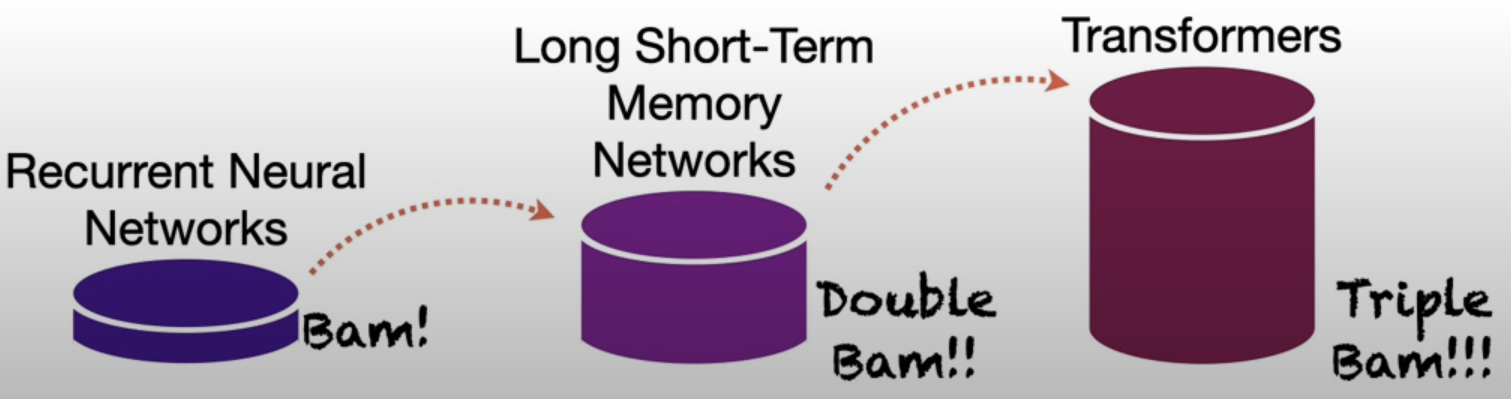

### Additional Sources:

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://karpathy.github.io/2015/05/21/rnn-effectiveness/


### Image Sources:

https://www.youtube.com/watch?v=YCzL96nL7j0

https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1174/reports/2760954.pdf?utm_source=chatgpt.com